<a href="https://colab.research.google.com/github/zhus-dika/togyz-qumalaq-agent/blob/main/togyzqumalaq_aec_vs_random_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🦛 Install need packages

In [1]:
#!python -m ipykernel install --user --name=venv

### 🐞 Imports

In [144]:
import gymnasium
import os
import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete
from gymnasium import spaces

from IPython.display import clear_output
import time
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import csv
import pandas as pd
from scipy.interpolate import interp1d

import os
from typing import Optional, Tuple

from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger

import gymnasium
import numpy as np
import torch
from copy import deepcopy
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, RainbowPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils.net.common import Net

import random
import copy

NUM_ITERS = 1000
PLAYS = {"bastaushy": 0, "qostaushy": 0}
REWARDS = {"bastaushy": [], "qostaushy": []}

### 🐯 Parameters

In [104]:
NET_ARCHS = [[512, 1024, 512]]

MAX_EPOCHS = 2000

# step_per_epoch=1000,
# step_per_collect=50,
# episode_per_test=10,

STEP_PER_EPOCH = 1000

STEP_PER_COLLECT = 100 #50

EPISODE_PER_TEST = 50 #10

BATCH_SIZE = 256

MODELS_PATH = {}

MODELS_PATH['bastaushy'] = os.path.join('..', 'models', 'dqn', 'curriculum_learning','bastaushy')

MODELS_PATH['qostaushy'] = os.path.join('..', 'models', 'dqn', 'curriculum_learning','qostaushy')

LOGS_PATH = {}

LOGS_PATH['bastaushy'] = os.path.join('..', 'logs', 'dqn', 'bastaushy')

LOGS_PATH['qostaushy'] = os.path.join('..', 'logs', 'dqn', 'qostaushy')

#  🐘 AEC environment https://pettingzoo.farama.org/api/aec/#about-aec

### 🦉 Create environment

In [145]:
def env(render_mode=None):
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(render_mode=internal_render_mode)
    # This wrapper is only for environments which print results to the terminal
    if render_mode == "ansi":
        env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
    env = wrappers.AssertOutOfBoundsWrapper(env)
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


class raw_env(AECEnv):
    """
    The metadata holds environment constants. From gymnasium, we inherit the "render_modes",
    metadata which specifies which modes can be put into the render() method.
    At least human mode should be supported.
    The "name" metadata allows the environment to be pretty printed.
    """

    metadata = {
        "render_modes": ["ansi", "human"],
        "name": "togyzqumalaq_v0"
        }

    def __init__(self, render_mode=None):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - otaular
        - tuzdyq
        - qazandar
        - possible_agents
        - render_mode

        Note: as of v1.18.1, the action_spaces and observation_spaces attributes are deprecated.
        Spaces should be defined in the action_space() and observation_space() methods.
        If these methods are not overridden, spaces will be inferred from self.observation_spaces/action_spaces, raising a warning.

        These attributes should not be changed after initialization.
        """
        self.otaular = []
        self.tuzdyq = []
        self.qazandar = []
        self.direction = []
        self.agents = ["bastaushy", "qostaushy"]
        self.possible_agents = self.agents[:]
        # optional: we can define the observation and action spaces here as attributes to be used in their corresponding methods
        self.action_spaces = {i: spaces.Discrete(9) for i in self.agents}
        self.observation_spaces = {
            i: spaces.Dict(
                {
                    "observation": MultiDiscrete([100] * 18 + [9] * 2 + [82] * 2),
                    "action_mask": Discrete(9),
                }
            )
            for i in self.agents
        }
        self.render_mode = render_mode

    # Observation space should be defined here.
    def action_space(self, agent):
        return self.action_spaces[agent]

    # Action space should be defined here.
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def render(self):
        """
        Renders the environment. In human mode,
        it can print to terminal, open
        up a graphical window, or open up some
        other display that
        a human can see and understand.
        """
        """Renders the environment."""
        if self.render_mode is None:
            gymnasium.logger.warn(
                "You are calling render method without "
                "specifying any render mode."
            )
            return

        if len(self.agents) == 2:
            points_bastaushy_x = np.array([i * 2 for i in range(10)])
            points_bastaushy_y = np.array([i % 5 for i in range(50)])

            x = np.arange(-3, 225, 1)
            y = -1

            text_kwargs = dict(ha='center', va='center', fontsize=12)
            plt.figure(figsize=(17, 6))

            for i in range(9):
                # qostaushy's part
                plt.scatter(
                    np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[17 - i]], points_bastaushy_y[:self.otaular[17 - i]], marker='o')
                # horizontal line
                plt.plot(x, np.repeat(y, len(x)))
                # vertical lines
                plt.plot(np.repeat(25 * i - 2, len(x)), np.arange(-7, 5, 12 / len(x)))
                # bastaushy's part
                plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[i]],
                            points_bastaushy_y[:self.otaular[i]] - 6, marker='o')

            # last vertical line
            plt.plot(np.repeat(25 * 9 - 2, len(x)), np.arange(-7, 5, 12 / len(x)))

            for i in range(9):
                # bastaushy's qumalaqtar
                plt.text(25 * i + 10, -7,
                         f'{i} ({self.otaular[i]})', **text_kwargs)
                # qostaushy's qumalaqtar
                plt.text(25 * i + 10, 5,
                         f'{17 - i} ({self.otaular[17 - i]})', **text_kwargs)
            # bastaushy qazan's qumalaqtar
            plt.text(230, -4,
                     f'qazan: {self.qazandar[0]}', **text_kwargs)
            # qostaushy qazan's qumalaqtar
            plt.text(230, 2,
                     f'qazan: {self.qazandar[1]}', **text_kwargs)
            # bastaushy tuzdyq's qumalaqtar
            plt.text(230, -6,
                     f'tuzdyq: {self.tuzdyq[0]}', **text_kwargs)
            # qostaushy tuzdyq's qumalaqtar
            plt.text(230, 0,
                     f'tuzdyq: {self.tuzdyq[1]}', **text_kwargs)
            plt.xticks([])
            plt.yticks([])
            plt.show()
        else:
            if self.render_mode == "human":
                print("Game over")
        
        time.sleep(2)
        clear_output(True)

    def _legal_moves(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        return [item for item in range(9 * cur_player, (cur_player + 1) * 9) if self.tuzdyq[opp_player] != item and self.otaular[item] > 0]

    def observe(self, agent):
        """
        Observe should return the observation of the specified agent. This function
        should return a sane observation (though not necessarily the most up to date possible)
        at any time after reset() is called.
        """
        # observation of one agent is the previous state of the other
        legal_moves = self._legal_moves(agent) if agent == self.agent_selection else []
        action_mask = np.zeros(9, "int8")
        if self.possible_agents.index(agent) == 1:
            legal_moves = [i - 9 for i in legal_moves]
        for i in legal_moves:
            action_mask[i] = 1
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        return {"observation": observation, "action_mask": action_mask}

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass

    def reset(self, seed=None, options=None):
        """
        Reset needs to initialize the following attributes
        - agents
        - rewards
        - _cumulative_rewards
        - terminations
        - truncations
        - infos
        - agent_selection
        And must set up the environment so that render(), step(), and observe()
        can be called without issues.
        Here it sets up the state dictionary which is used by step() and the observations dictionary which is used by step() and observe()
        """
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.otaular = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
        self.direction = [list(range(18)), [9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
        self.tuzdyq = [-1, -1]
        self.qazandar = [0, 0]
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.num_moves = 0
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        self.observations = {agent: observation for agent in self.agents}
        """
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        """
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

    def step(self, action):
        """
        step(action) takes in an action for the current agent (specified by
        agent_selection) and needs to update
        - rewards
        - _cumulative_rewards (accumulating the rewards)
        - terminations
        - truncations
        - infos
        - agent_selection (to the next agent)
        And any internal state used by observe() or render()
        """
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return

        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2

        self.num_moves += 1
        if self.render_mode == "human":
            print(f'MOVE #{self.num_moves}')
        # The truncations dictionary must be updated for all players.
        self.truncations = {
            agent: self.num_moves >= NUM_ITERS for agent in self.agents
        }
        # distribute qumalaqs
        if cur_player == 1:
            action += 9
        if self.render_mode == "human":
            print(f'{self.agent_selection} made action {action}')
        num_qumalaq = self.otaular[action]
        idx_action = self.direction[cur_player].index(action)
        if self.otaular[action] == 1:
            self.otaular[self.direction[cur_player][idx_action + 1]] += 1
            self.otaular[action] -= 1
        else:
            i = 1
            while self.otaular[action] > 1:
                self.otaular[self.direction[cur_player][(idx_action + i) % 18]] += 1
                self.otaular[action] -= 1
                i += 1
        # check tuzdyq & add rewards to qazandar
        reward = 0
        # curriculum lesson # 6
        # increase reward for winning tuzdyq
        if self.check_tuzdyq(self.agent_selection, action):
            reward += 3
            # self.rewards[self.agent_selection] += 10
            if self.render_mode == "human":
                print(f'{self.agent_selection} won tuzdyq {reward}')
        else:

            if num_qumalaq > 1:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq) % 18]

            if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] % 2 == 0:
                reward += self.otaular[last_otau]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won {reward}')
                self.otaular[last_otau] = 0
            if self.tuzdyq[cur_player] >= 0 and self.otaular[self.tuzdyq[cur_player]] > 0:
                reward += self.otaular[self.tuzdyq[cur_player]]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won tuzdyq {self.otaular[self.tuzdyq[cur_player]]}')
                self.otaular[self.tuzdyq[cur_player]] = 0
        if self.render_mode == "human":
            print(f'{self.agent_selection} won total {reward}')
        self.qazandar[cur_player] += reward
        #=======================================================================#
        # curriculum lesson # 1
        # for i in range(cur_player * 9, 9 + cur_player * 9):
        #     if self.otaular[i] % 2 != 0:
        #         reward -= 1
        
        #=======================================================================#
        # curriculum lesson # 2
        opp_actions = self._legal_moves(self.possible_agents[opp_player])
        rew_opp = 0
        for opp_act in opp_actions:
            num_qumalaq = self.otaular[opp_act]
            idx_action = self.direction[opp_player].index(action)
            if num_qumalaq > 1:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq) % 18]
            if rew_opp < self.otaular[last_otau] and self.otaular[last_otau] % 2 == 1 and last_otau in range(cur_player * 9, (cur_player + 1) * 9):
                rew_opp = self.otaular[last_otau]
        self.rewards[self.agent_selection] -= 0.75 * rew_opp
        #=======================================================================#
        # curriculum lesson # 3
        # reduce the number of steps
        self.rewards[self.agent_selection] -= 1

        # check opponent's atsyrau
        if self.check_atsyrau(self.possible_agents[opp_player]) and self.qazandar[opp_player] <= 81:
            for i in range(9):
                self.qazandar[cur_player] += self.otaular[i + cur_player * 9]
                reward += self.otaular[i + cur_player * 9]

        self.rewards[self.agent_selection] += reward
        REWARDS[self.agent_selection].append(self.qazandar[cur_player])
        # check if there is a winner
        winner = self.check_for_winner()

        #=======================================================================#
        # curriculum lesson # 4
        # increase reward for winning the game

        #=======================================================================#
        # curriculum lesson # 5
        # calculate reward in other way
        # self.rewards[self.agent_selection] += (self.qazandar[cur_player] - self.qazandar[opp_player]) / 82
        # self.rewards[self.agent_selection] -= 0.05
        if winner:
            # print("NSTEPS =", self.num_moves)
            self.rewards[self.agent_selection] += 500
            # self.rewards[self.agent_selection] += 1
            self.terminations = {i: True for i in self.agents}
            if self.render_mode == "human":
                print(f'{self.agent_selection} won the game!!!')
        # selects the next agent.
        self.agent_selection = self._agent_selector.next()
        # Adds .rewards to ._cumulative_rewards
        self._accumulate_rewards()

        if self.render_mode == "human":
            self.render()

    def check_tuzdyq(self, agent, action):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        idx = self.direction[cur_player].index(action)
        num_qumalaq = self.otaular[action]

        if num_qumalaq > 1:
            last_otau = self.direction[cur_player][(idx + num_qumalaq - 1) % 18]
        else:
            last_otau = self.direction[cur_player][(idx + num_qumalaq) % 18]

        if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] == 3 and last_otau != 17 - cur_player * 9 and abs(last_otau - self.tuzdyq[opp_player]) != 9:
            self.tuzdyq[cur_player] = last_otau
            self.otaular[last_otau] = 0
            if self.render_mode == "human":
                print(f'{agent} got tuzdyq {last_otau}!')
            return True

        return False

    def check_atsyrau(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2

        for idx, i in enumerate(self.otaular[cur_player * 9: (cur_player + 1) * 9]):
            if i > 0 and idx + cur_player * 9 != self.tuzdyq[opp_player]:
                return False
        if self.render_mode == "human":
            print(f'{agent} reached atsyrau')
        return True

    def check_for_winner(self):
        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        if self.qazandar[cur_player] > 81:
            PLAYS[self.agent_selection] += 1
            return True
        return False

### 🦚 Testing environment

In [6]:
# env = env(render_mode="human")
# env.reset(seed=42)

# for agent in env.agent_iter():
#     observation, reward, termination, truncation, info = env.last()

#     if termination or truncation:
#         action = None
#     else:
#         mask = observation["action_mask"]
#         # this is where you would insert your policy
#         action = env.action_space(agent).sample(mask)

#     env.step(action)
# env.close()

# 🐼 DQN agent to play vs a random policy agent https://pettingzoo.farama.org/tutorials/tianshou/intermediate/

### 🐫 Prepare main functions

In [4]:
def _get_agents_dqn(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    agent_type = None,
    net_arch = [64, 128, 128, 64]
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = _get_env()
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gymnasium.spaces.Dict)
        else env.observation_space
    )
    if agent_learn is None:
        # model
        net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=net_arch,
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=1e-4)
        agent_learn = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space,
            observation_space=observation_space
        ).to("cuda" if torch.cuda.is_available() else "cpu")


    if agent_opponent is None:
        agent_opponent = RandomPolicy(action_space=env.action_space)
        
    if agent_type=="qostaushy":
        agents = [agent_opponent, agent_learn]
    else:
        agents = [agent_learn, agent_opponent]
    policy = MultiAgentPolicyManager(policies=agents, env=env)
    return policy, optim, env.agents


def _get_env(render_mode=None):
    """This function is needed to provide callables for DummyVectorEnv."""
    def env(render_mode=None):
        """
        The env function often wraps the environment in wrappers by default.
        You can find full documentation for these methods
        elsewhere in the developer documentation.
        """
        internal_render_mode = render_mode if render_mode != "ansi" else "human"
        env = raw_env(render_mode=internal_render_mode)
        # This wrapper is only for environments which print results to the terminal
        if render_mode == "ansi":
            env = wrappers.CaptureStdoutWrapper(env)
        # this wrapper helps error handling for discrete action spaces
        env = wrappers.AssertOutOfBoundsWrapper(env)
        # Provides a wide vareity of helpful user errors
        # Strongly recommended
        env = wrappers.OrderEnforcingWrapper(env)
        return env
    return PettingZooEnv(env(render_mode=render_mode))

### 🐦 Add logger (to run tensorboard type in terminal  $tensorboard --logdir logs/dqn)

In [84]:
log_path = os.path.join('..', 'logs', "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

# 🐎 Self-play training agents

### 🦚 Methods train agent

In [5]:
def train_agent_dqn_bastaushy(index, net_arch, agent_learn=None, agent_opponent=None, path="bastaushy", seed=11):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_dqn(agent_learn=agent_learn, agent_opponent=agent_opponent, agent_type=path, net_arch=net_arch)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    log_path = os.path.join(LOGS_PATH[path], str(index))
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join(MODELS_PATH[path], f'policy_dqn_{arch2str(net_arch)}_{index}.pth')
        os.makedirs(MODELS_PATH[path], exist_ok=True)
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 55000
    
    def train_fn(epoch, env_step):
        policy.policies[agents[0]].set_eps(0.1)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[0]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 0]

    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=MAX_EPOCHS,
        step_per_epoch=STEP_PER_EPOCH,
        step_per_collect=STEP_PER_COLLECT,
        episode_per_test=EPISODE_PER_TEST,
        batch_size=BATCH_SIZE,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[0]])")
    return policy.policies[agents[0]]

In [6]:
def train_agent_dqn_qostaushy(index, net_arch, agent_learn=None, agent_opponent=None, path="qostaushy", seed=11):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_dqn(agent_learn=agent_learn, agent_opponent=agent_opponent, agent_type=path, net_arch=net_arch)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    log_path = os.path.join(LOGS_PATH[path], str(index))
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join(MODELS_PATH[path], f'policy_dqn_{arch2str(net_arch)}_{index}.pth')
        os.makedirs(MODELS_PATH[path], exist_ok=True)
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 55000
    
    def train_fn(epoch, env_step):
        policy.policies[agents[1]].set_eps(0.1)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[1]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 1]

    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=MAX_EPOCHS,
        step_per_epoch=STEP_PER_EPOCH,
        step_per_collect=STEP_PER_COLLECT,
        episode_per_test=EPISODE_PER_TEST,
        batch_size=BATCH_SIZE,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[1]])")
    return policy.policies[agents[1]]

## 🐡 Train initial agents via random policy

### 🐜 Set net architectures 

In [7]:
def arch2str(net_arch):
    out = str(net_arch[0])
    for i in net_arch[1:]:
        out += 'x' + str(i)
    return out

def str2arch(inp):
    lst = inp.split('x')
    return [int(i) for i in lst]

arch2str(NET_ARCHS[0])

'512x1024x512'

### 🦆 Training code

In [ ]:
for arch in NET_ARCHS:
    print(f"Train with initial agents for net arch={arch}")
    env = _get_env()
    net = Net(
                state_shape=(22,),
                action_shape=env.action_space.shape or env.action_space.n,
                hidden_sizes=arch,
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned = DQNPolicy(
                model=net,
                optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                discount_factor=0.9,
                estimation_step=3,
                target_update_freq=320,
                action_space=env.action_space,
                observation_space=env.observation_space
            ).to("cuda" if torch.cuda.is_available() else "cpu")

    agent_trained_bastaushy = train_agent_dqn_bastaushy(index=5, net_arch=arch, agent_learn=agent_learned, path="bastaushy")
    # agent_trained_qostaushy = train_agent_dqn_qostaushy(index=1, net_arch=arch, agent_learn=agent_learned, path="qostaushy")

## 🦉 Main self-play training code

### 🐘 Load trained agents

In [96]:
agents_learned_bastaushy = {arch2str(key): [] for key in NET_ARCHS}
agents_learned_qostaushy = {arch2str(key): [] for key in NET_ARCHS}

In [97]:
sorted_files = os.listdir(MODELS_PATH['bastaushy'])

sorted_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

for file in sorted_files:  
    env = _get_env()
    arch = str2arch(file.split('_')[2])
    if arch in NET_ARCHS:
        print(file)
        net = Net(
                    state_shape=(22,),
                    action_shape=env.action_space.shape or env.action_space.n,
                    hidden_sizes=arch,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned = DQNPolicy(
                    model=net,
                    optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                    discount_factor=0.9,
                    estimation_step=3,
                    target_update_freq=320,
                    action_space=env.action_space
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/{file}"))
        agent_learned.set_eps(0)
        agents_learned_bastaushy[arch2str(arch)].append(agent_learned)

policy_dqn_512x1024x512_0.pth
policy_dqn_512x1024x512_1.pth
policy_dqn_512x1024x512_2.pth
policy_dqn_512x1024x512_3.pth
policy_dqn_512x1024x512_4.pth
policy_dqn_512x1024x512_5.pth
policy_dqn_512x1024x512_6.pth
policy_dqn_512x1024x512_7.pth
policy_dqn_512x1024x512_8.pth
policy_dqn_512x1024x512_9.pth
policy_dqn_512x1024x512_10.pth


In [98]:
sorted_files = os.listdir(MODELS_PATH['qostaushy'])

sorted_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

for file in sorted_files:
    env = _get_env()
    arch = str2arch(file.split('_')[2])
    if arch in NET_ARCHS:
        print(file)
        net = Net(
                    state_shape=(22,),
                    action_shape=env.action_space.shape or env.action_space.n,
                    hidden_sizes=arch,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned = DQNPolicy(
                    model=net,
                    optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                    discount_factor=0.9,
                    estimation_step=3,
                    target_update_freq=320,
                    action_space=env.action_space
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        
        agent_learned.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/{file}"))
        agent_learned.set_eps(0)
        agents_learned_qostaushy[arch2str(arch)].append(agent_learned)

policy_dqn_512x1024x512_0.pth
policy_dqn_512x1024x512_1.pth
policy_dqn_512x1024x512_2.pth
policy_dqn_512x1024x512_3.pth
policy_dqn_512x1024x512_4.pth
policy_dqn_512x1024x512_5.pth
policy_dqn_512x1024x512_6.pth
policy_dqn_512x1024x512_7.pth
policy_dqn_512x1024x512_8.pth
policy_dqn_512x1024x512_9.pth
policy_dqn_512x1024x512_10.pth


### 🐑 Self-play

In [15]:
NUM_MODELS = 10

for arch in NET_ARCHS:
    
    for i in range(NUM_MODELS, NUM_MODELS + 1):
        
            arch_name = arch2str(arch)
            
            # random select opponent
            full_opp_bastaushy = []
            for arch_loc in NET_ARCHS:
                full_opp_bastaushy += agents_learned_bastaushy[arch2str(arch_loc)] 
            agent_opp_random_bastaushy = random.choice(full_opp_bastaushy)
            idx_opp_bastaushy = full_opp_bastaushy.index(agent_opp_random_bastaushy)
            
            full_opp_qostaushy = []
            for arch_loc in NET_ARCHS:
                full_opp_qostaushy += agents_learned_qostaushy[arch2str(arch_loc)] 
            agent_opp_random_qostaushy = random.choice(full_opp_qostaushy)
            idx_opp_qostaushy = full_opp_qostaushy.index(agent_opp_random_qostaushy)
            # training
            env = _get_env()
            net = Net(
                        state_shape=(22,),
                        action_shape=env.action_space.shape or env.action_space.n,
                        hidden_sizes=arch,
                        device="cuda" if torch.cuda.is_available() else "cpu",
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
            
            agent_learned_bastaushy = DQNPolicy(
                        model=net,
                        optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                        discount_factor=0.9,
                        estimation_step=3,
                        target_update_freq=320,
                        action_space=env.action_space,
                        observation_space=env.observation_space
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
        
            agent_learned_qostaushy = DQNPolicy(
                        model=net,
                        optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                        discount_factor=0.9,
                        estimation_step=3,
                        target_update_freq=320,
                        action_space=env.action_space,
                        observation_space=env.observation_space
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
        
            id_basta = random.choice(range(len(agents_learned_bastaushy[arch_name])))
            id_qosta = random.choice(range(len(agents_learned_qostaushy[arch_name])))
            agent_learned_bastaushy.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/policy_dqn_{arch_name}_{i-1}.pth"))
            agent_learned_qostaushy.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/policy_dqn_{arch_name}_{i-1}.pth"))

            print(f'Train agent bastaushy #{id_basta} vs qostaushy #{idx_opp_qostaushy}')
        
            train_agent_dqn_bastaushy(index=i, net_arch=arch, agent_learn=agent_learned_bastaushy, agent_opponent=agent_opp_random_qostaushy, path="bastaushy")
            
            #load best bastaushy policy model
            agent_learned_bastaushy.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/policy_dqn_{arch_name}_{i}.pth"))
        
            print(f'Train agent qostaushy #{id_qosta} vs bastaushy #{idx_opp_bastaushy}')
        
            train_agent_dqn_qostaushy(index=i, net_arch=arch, agent_learn=agent_learned_qostaushy, agent_opponent=agent_opp_random_bastaushy, path="qostaushy")
            # load best qostaushy policy model
            agent_learned_qostaushy.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/policy_dqn_{arch_name}_{i}.pth"))
            
            # add new learned agents
            
            agents_learned_bastaushy[arch_name].append(agent_learned_bastaushy)
            agents_learned_qostaushy[arch_name].append(agent_learned_qostaushy)

Train agent bastaushy #8 vs qostaushy #8


Epoch #1: 1001it [00:03, 299.72it/s, env_step=1000, gradient_step=100, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #1: test_reward: -20018.320000 ± 19967.767165, best_reward: -18090.195000 ± 21931.337754 in #0


Epoch #2: 1001it [00:03, 313.51it/s, env_step=2000, gradient_step=200, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #2: test_reward: -36279.640000 ± 28136.959562, best_reward: -18090.195000 ± 21931.337754 in #0


Epoch #3: 1001it [00:03, 282.07it/s, env_step=3000, gradient_step=300, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #3: test_reward: -21814.850000 ± 17210.218945, best_reward: -18090.195000 ± 21931.337754 in #0


Epoch #4: 1001it [00:02, 347.05it/s, env_step=4000, gradient_step=400, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #4: test_reward: -11818.815000 ± 10223.114647, best_reward: -11818.815000 ± 10223.114647 in #4


Epoch #5: 1001it [00:03, 332.31it/s, env_step=5000, gradient_step=500, len=48, n/ep=0, n/st=100, rew=307.56]                                                                                      


Epoch #5: test_reward: -38979.100000 ± 21777.348656, best_reward: -11818.815000 ± 10223.114647 in #4


Epoch #6: 1001it [00:04, 247.98it/s, env_step=6000, gradient_step=600, len=58, n/ep=0, n/st=100, rew=211.38]                                                                                      


Epoch #6: test_reward: -16834.385000 ± 16352.102419, best_reward: -11818.815000 ± 10223.114647 in #4


Epoch #7: 1001it [00:04, 217.94it/s, env_step=7000, gradient_step=700, len=70, n/ep=1, n/st=100, rew=-984.88]                                                                                     


Epoch #7: test_reward: -10769.005000 ± 12209.037835, best_reward: -10769.005000 ± 12209.037835 in #7


Epoch #8: 1001it [00:03, 277.98it/s, env_step=8000, gradient_step=800, len=80, n/ep=3, n/st=100, rew=-2380.38]                                                                                    


Epoch #8: test_reward: -16053.670000 ± 19969.581332, best_reward: -10769.005000 ± 12209.037835 in #7


Epoch #9: 1001it [00:04, 246.32it/s, env_step=9000, gradient_step=900, len=90, n/ep=5, n/st=100, rew=-4202.32]                                                                                    


Epoch #9: test_reward: -19942.970000 ± 11204.621596, best_reward: -10769.005000 ± 12209.037835 in #7


Epoch #10: 1001it [00:03, 267.51it/s, env_step=10000, gradient_step=1000, len=100, n/ep=1, n/st=100, rew=-5600.75]                                                                                


Epoch #10: test_reward: -16922.840000 ± 23364.992507, best_reward: -10769.005000 ± 12209.037835 in #7


Epoch #11: 1001it [00:03, 292.82it/s, env_step=11000, gradient_step=1100, len=110, n/ep=4, n/st=100, rew=-4793.69]                                                                                


Epoch #11: test_reward: -13261.510000 ± 8371.765834, best_reward: -10769.005000 ± 12209.037835 in #7


Epoch #12: 1001it [00:03, 328.99it/s, env_step=12000, gradient_step=1200, len=119, n/ep=0, n/st=100, rew=-7336.88]                                                                                


Epoch #12: test_reward: -15684.930000 ± 19060.063125, best_reward: -10769.005000 ± 12209.037835 in #7


Epoch #13: 1001it [00:03, 263.52it/s, env_step=13000, gradient_step=1300, len=128, n/ep=0, n/st=100, rew=-11823.19]                                                                               


Epoch #13: test_reward: -15300.540000 ± 11358.401921, best_reward: -10769.005000 ± 12209.037835 in #7


Epoch #14: 1001it [00:03, 315.76it/s, env_step=14000, gradient_step=1400, len=138, n/ep=0, n/st=100, rew=-6948.25]                                                                                


Epoch #14: test_reward: -7152.325000 ± 9772.237818, best_reward: -7152.325000 ± 9772.237818 in #14


Epoch #15: 1001it [00:03, 277.05it/s, env_step=15000, gradient_step=1500, len=60, n/ep=1, n/st=100, rew=1286.88]                                                                                  


Epoch #15: test_reward: -17305.015000 ± 10647.442731, best_reward: -7152.325000 ± 9772.237818 in #14


Epoch #16: 1001it [00:03, 268.79it/s, env_step=16000, gradient_step=1600, len=160, n/ep=1, n/st=100, rew=-8867.38]                                                                                


Epoch #16: test_reward: -20996.975000 ± 14270.239790, best_reward: -7152.325000 ± 9772.237818 in #14


Epoch #17: 1001it [00:03, 272.95it/s, env_step=17000, gradient_step=1700, len=74, n/ep=1, n/st=100, rew=-6224.00]                                                                                 


Epoch #17: test_reward: -6982.615000 ± 9215.099917, best_reward: -6982.615000 ± 9215.099917 in #17


Epoch #18: 1001it [00:03, 291.57it/s, env_step=18000, gradient_step=1800, len=113, n/ep=0, n/st=100, rew=-7292.62]                                                                                


Epoch #18: test_reward: -10181.955000 ± 10402.188014, best_reward: -6982.615000 ± 9215.099917 in #17


Epoch #19: 1001it [00:03, 259.59it/s, env_step=19000, gradient_step=1900, len=96, n/ep=1, n/st=100, rew=-3023.62]                                                                                 


Epoch #19: test_reward: -7010.695000 ± 5884.701250, best_reward: -6982.615000 ± 9215.099917 in #17


Epoch #20: 1001it [00:03, 292.41it/s, env_step=20000, gradient_step=2000, len=200, n/ep=1, n/st=100, rew=-19875.12]                                                                               


Epoch #20: test_reward: -10062.090000 ± 6501.943561, best_reward: -6982.615000 ± 9215.099917 in #17


Epoch #21: 1001it [00:03, 310.12it/s, env_step=21000, gradient_step=2100, len=210, n/ep=1, n/st=100, rew=-28264.75]                                                                               


Epoch #21: test_reward: -2332.765000 ± 4422.948750, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #22: 1001it [00:03, 319.80it/s, env_step=22000, gradient_step=2200, len=50, n/ep=0, n/st=100, rew=-1525.38]                                                                                 


Epoch #22: test_reward: -7809.100000 ± 5123.314269, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #23: 1001it [00:04, 249.43it/s, env_step=23000, gradient_step=2300, len=132, n/ep=2, n/st=100, rew=-14960.94]                                                                               


Epoch #23: test_reward: -10897.535000 ± 5726.223100, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #24: 1001it [00:02, 342.77it/s, env_step=24000, gradient_step=2400, len=78, n/ep=1, n/st=100, rew=-5069.25]                                                                                 


Epoch #24: test_reward: -7609.500000 ± 7591.522706, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #25: 1001it [00:03, 329.86it/s, env_step=25000, gradient_step=2500, len=134, n/ep=1, n/st=100, rew=-8839.88]                                                                                


Epoch #25: test_reward: -9104.280000 ± 9399.876098, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #26: 1001it [00:03, 317.98it/s, env_step=26000, gradient_step=2600, len=162, n/ep=2, n/st=100, rew=-11530.69]                                                                               


Epoch #26: test_reward: -6037.505000 ± 9154.838102, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #27: 1001it [00:03, 315.80it/s, env_step=27000, gradient_step=2700, len=80, n/ep=0, n/st=100, rew=-4561.31]                                                                                 


Epoch #27: test_reward: -10120.840000 ± 10611.294180, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #28: 1001it [00:03, 275.11it/s, env_step=28000, gradient_step=2800, len=40, n/ep=0, n/st=100, rew=61.62]                                                                                    


Epoch #28: test_reward: -2397.005000 ± 5155.836285, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #29: 1001it [00:03, 289.01it/s, env_step=29000, gradient_step=2900, len=45, n/ep=1, n/st=100, rew=642.12]                                                                                   


Epoch #29: test_reward: -10497.800000 ± 7453.367398, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #30: 1001it [00:03, 313.79it/s, env_step=30000, gradient_step=3000, len=114, n/ep=1, n/st=100, rew=-1393.50]                                                                                


Epoch #30: test_reward: -9831.060000 ± 9442.562772, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #31: 1001it [00:03, 281.23it/s, env_step=31000, gradient_step=3100, len=198, n/ep=0, n/st=100, rew=-26607.12]                                                                               


Epoch #31: test_reward: -8671.785000 ± 7326.959330, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #32: 1001it [00:03, 266.26it/s, env_step=32000, gradient_step=3200, len=80, n/ep=0, n/st=100, rew=-2030.62]                                                                                 


Epoch #32: test_reward: -25029.740000 ± 19305.305670, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #33: 1001it [00:03, 296.03it/s, env_step=33000, gradient_step=3300, len=143, n/ep=0, n/st=100, rew=-12867.88]                                                                               


Epoch #33: test_reward: -10070.770000 ± 9516.829637, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #34: 1001it [00:03, 291.29it/s, env_step=34000, gradient_step=3400, len=216, n/ep=0, n/st=100, rew=-18517.00]                                                                               


Epoch #34: test_reward: -10534.230000 ± 8394.579665, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #35: 1001it [00:03, 271.04it/s, env_step=35000, gradient_step=3500, len=123, n/ep=2, n/st=100, rew=-11476.81]                                                                               


Epoch #35: test_reward: -16415.180000 ± 11940.572879, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #36: 1001it [00:03, 309.78it/s, env_step=36000, gradient_step=3600, len=88, n/ep=2, n/st=100, rew=-926.62]                                                                                  


Epoch #36: test_reward: -9511.090000 ± 8301.427445, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #37: 1001it [00:03, 299.55it/s, env_step=37000, gradient_step=3700, len=87, n/ep=1, n/st=100, rew=-2172.62]                                                                                 


Epoch #37: test_reward: -15334.190000 ± 10641.342931, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #38: 1001it [00:03, 289.04it/s, env_step=38000, gradient_step=3800, len=169, n/ep=0, n/st=100, rew=-14324.75]                                                                               


Epoch #38: test_reward: -14202.440000 ± 13842.353727, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #39: 1001it [00:03, 312.36it/s, env_step=39000, gradient_step=3900, len=137, n/ep=2, n/st=100, rew=-11323.69]                                                                               


Epoch #39: test_reward: -11994.980000 ± 7990.568731, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #40: 1001it [00:03, 301.08it/s, env_step=40000, gradient_step=4000, len=45, n/ep=1, n/st=100, rew=-518.38]                                                                                  


Epoch #40: test_reward: -15558.745000 ± 11458.773529, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #41: 1001it [00:03, 316.00it/s, env_step=41000, gradient_step=4100, len=166, n/ep=1, n/st=100, rew=-15419.00]                                                                               


Epoch #41: test_reward: -11578.730000 ± 13042.240606, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #42: 1001it [00:03, 306.79it/s, env_step=42000, gradient_step=4200, len=147, n/ep=0, n/st=100, rew=-5700.00]                                                                                


Epoch #42: test_reward: -8509.960000 ± 9777.496418, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #43: 1001it [00:02, 334.60it/s, env_step=43000, gradient_step=4300, len=109, n/ep=1, n/st=100, rew=-3390.25]                                                                                


Epoch #43: test_reward: -6769.825000 ± 4829.394490, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #44: 1001it [00:03, 327.75it/s, env_step=44000, gradient_step=4400, len=171, n/ep=1, n/st=100, rew=-9774.38]                                                                                


Epoch #44: test_reward: -9739.530000 ± 9396.058500, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #45: 1001it [00:03, 318.22it/s, env_step=45000, gradient_step=4500, len=113, n/ep=0, n/st=100, rew=-1805.12]                                                                                


Epoch #45: test_reward: -13139.710000 ± 13140.567323, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #46: 1001it [00:03, 280.18it/s, env_step=46000, gradient_step=4600, len=68, n/ep=1, n/st=100, rew=-1229.12]                                                                                 


Epoch #46: test_reward: -12958.760000 ± 7792.655651, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #47: 1001it [00:03, 308.92it/s, env_step=47000, gradient_step=4700, len=192, n/ep=1, n/st=100, rew=-21890.25]                                                                               


Epoch #47: test_reward: -11197.475000 ± 8409.243578, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #48: 1001it [00:03, 333.15it/s, env_step=48000, gradient_step=4800, len=244, n/ep=1, n/st=100, rew=-27677.62]                                                                               


Epoch #48: test_reward: -9599.640000 ± 8081.480591, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #49: 1001it [00:03, 283.88it/s, env_step=49000, gradient_step=4900, len=124, n/ep=0, n/st=100, rew=-14611.12]                                                                               


Epoch #49: test_reward: -2407.155000 ± 5976.044145, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #50: 1001it [00:03, 304.97it/s, env_step=50000, gradient_step=5000, len=167, n/ep=1, n/st=100, rew=-13652.50]                                                                               


Epoch #50: test_reward: -7969.685000 ± 6358.067286, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #51: 1001it [00:03, 300.40it/s, env_step=51000, gradient_step=5100, len=80, n/ep=0, n/st=100, rew=-1278.12]                                                                                 


Epoch #51: test_reward: -17287.450000 ± 12050.701262, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #52: 1001it [00:03, 323.45it/s, env_step=52000, gradient_step=5200, len=85, n/ep=0, n/st=100, rew=-2156.19]                                                                                 


Epoch #52: test_reward: -8607.885000 ± 10237.873871, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #53: 1001it [00:03, 278.96it/s, env_step=53000, gradient_step=5300, len=144, n/ep=1, n/st=100, rew=-12613.88]                                                                               


Epoch #53: test_reward: -6163.650000 ± 8270.666154, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #54: 1001it [00:03, 269.44it/s, env_step=54000, gradient_step=5400, len=163, n/ep=1, n/st=100, rew=-10392.50]                                                                               


Epoch #54: test_reward: -4329.130000 ± 7963.000176, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #55: 1001it [00:03, 287.80it/s, env_step=55000, gradient_step=5500, len=148, n/ep=0, n/st=100, rew=-9374.25]                                                                                


Epoch #55: test_reward: -9200.255000 ± 6847.278013, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #56: 1001it [00:03, 316.76it/s, env_step=56000, gradient_step=5600, len=177, n/ep=3, n/st=100, rew=-18032.29]                                                                               


Epoch #56: test_reward: -7655.995000 ± 13684.305579, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #57: 1001it [00:03, 301.60it/s, env_step=57000, gradient_step=5700, len=183, n/ep=0, n/st=100, rew=-18822.62]                                                                               


Epoch #57: test_reward: -7436.245000 ± 6769.477391, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #58: 1001it [00:03, 312.73it/s, env_step=58000, gradient_step=5800, len=106, n/ep=0, n/st=100, rew=-1032.62]                                                                                


Epoch #58: test_reward: -11211.750000 ± 7929.215614, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #59: 1001it [00:03, 259.01it/s, env_step=59000, gradient_step=5900, len=61, n/ep=1, n/st=100, rew=-638.00]                                                                                  


Epoch #59: test_reward: -15360.275000 ± 16002.122390, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #60: 1001it [00:03, 268.94it/s, env_step=60000, gradient_step=6000, len=208, n/ep=0, n/st=100, rew=-23199.75]                                                                               


Epoch #60: test_reward: -9870.985000 ± 6054.328297, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #61: 1001it [00:03, 263.80it/s, env_step=61000, gradient_step=6100, len=43, n/ep=1, n/st=100, rew=97.12]                                                                                    


Epoch #61: test_reward: -11295.665000 ± 9775.822681, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #62: 1001it [00:03, 281.13it/s, env_step=62000, gradient_step=6200, len=122, n/ep=2, n/st=100, rew=-4217.50]                                                                                


Epoch #62: test_reward: -10380.555000 ± 7992.939242, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #63: 1001it [00:03, 276.11it/s, env_step=63000, gradient_step=6300, len=164, n/ep=3, n/st=100, rew=-18291.21]                                                                               


Epoch #63: test_reward: -6824.315000 ± 10315.138422, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #64: 1001it [00:03, 302.77it/s, env_step=64000, gradient_step=6400, len=109, n/ep=2, n/st=100, rew=-3937.12]                                                                                


Epoch #64: test_reward: -7512.100000 ± 6946.845856, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #65: 1001it [00:03, 280.98it/s, env_step=65000, gradient_step=6500, len=71, n/ep=1, n/st=100, rew=-488.75]                                                                                  


Epoch #65: test_reward: -7935.670000 ± 7723.507897, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #66: 1001it [00:03, 297.45it/s, env_step=66000, gradient_step=6600, len=141, n/ep=1, n/st=100, rew=-11116.50]                                                                               


Epoch #66: test_reward: -8213.390000 ± 14781.118545, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #67: 1001it [00:03, 274.31it/s, env_step=67000, gradient_step=6700, len=54, n/ep=0, n/st=100, rew=-216.25]                                                                                  


Epoch #67: test_reward: -5549.535000 ± 12084.090285, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #68: 1001it [00:03, 266.22it/s, env_step=68000, gradient_step=6800, len=128, n/ep=1, n/st=100, rew=-9204.38]                                                                                


Epoch #68: test_reward: -8600.930000 ± 8638.775161, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #69: 1001it [00:03, 281.13it/s, env_step=69000, gradient_step=6900, len=86, n/ep=0, n/st=100, rew=-2355.88]                                                                                 


Epoch #69: test_reward: -4068.615000 ± 9918.452285, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #70: 1001it [00:03, 255.97it/s, env_step=70000, gradient_step=7000, len=187, n/ep=0, n/st=100, rew=-16005.62]                                                                               


Epoch #70: test_reward: -8713.425000 ± 7836.247971, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #71: 1001it [00:02, 334.45it/s, env_step=71000, gradient_step=7100, len=61, n/ep=1, n/st=100, rew=361.38]                                                                                   


Epoch #71: test_reward: -9153.240000 ± 7736.812436, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #72: 1001it [00:03, 317.93it/s, env_step=72000, gradient_step=7200, len=127, n/ep=1, n/st=100, rew=-8449.62]                                                                                


Epoch #72: test_reward: -13274.800000 ± 11102.665070, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #73: 1001it [00:03, 281.01it/s, env_step=73000, gradient_step=7300, len=82, n/ep=2, n/st=100, rew=-2341.56]                                                                                 


Epoch #73: test_reward: -15795.340000 ± 21790.814013, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #74: 1001it [00:03, 289.15it/s, env_step=74000, gradient_step=7400, len=105, n/ep=3, n/st=100, rew=-5393.79]                                                                                


Epoch #74: test_reward: -4262.235000 ± 7530.490710, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #75: 1001it [00:03, 258.87it/s, env_step=75000, gradient_step=7500, len=45, n/ep=1, n/st=100, rew=264.00]                                                                                   


Epoch #75: test_reward: -8473.085000 ± 9232.806153, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #76: 1001it [00:03, 301.11it/s, env_step=76000, gradient_step=7600, len=142, n/ep=0, n/st=100, rew=-9744.75]                                                                                


Epoch #76: test_reward: -8375.680000 ± 13232.615762, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #77: 1001it [00:04, 231.19it/s, env_step=77000, gradient_step=7700, len=133, n/ep=1, n/st=100, rew=-6418.12]                                                                                


Epoch #77: test_reward: -9093.550000 ± 10451.639537, best_reward: -2332.765000 ± 4422.948750 in #21


Epoch #78: 1001it [00:03, 254.76it/s, env_step=78000, gradient_step=7800, len=170, n/ep=1, n/st=100, rew=-11768.25]                                                                               


Epoch #78: test_reward: -2126.055000 ± 5789.428997, best_reward: -2126.055000 ± 5789.428997 in #78


Epoch #79: 1001it [00:03, 261.58it/s, env_step=79000, gradient_step=7900, len=121, n/ep=0, n/st=100, rew=-13067.75]                                                                               


Epoch #79: test_reward: -5421.240000 ± 11148.602044, best_reward: -2126.055000 ± 5789.428997 in #78


Epoch #80: 1001it [00:04, 217.42it/s, env_step=80000, gradient_step=8000, len=69, n/ep=1, n/st=100, rew=-687.62]                                                                                  


Epoch #80: test_reward: -3321.470000 ± 5583.727559, best_reward: -2126.055000 ± 5789.428997 in #78


Epoch #81: 1001it [00:03, 268.97it/s, env_step=81000, gradient_step=8100, len=49, n/ep=1, n/st=100, rew=192.12]                                                                                   


Epoch #81: test_reward: -2775.350000 ± 5559.322122, best_reward: -2126.055000 ± 5789.428997 in #78


Epoch #82: 1001it [00:03, 271.08it/s, env_step=82000, gradient_step=8200, len=98, n/ep=1, n/st=100, rew=-2489.75]                                                                                 


Epoch #82: test_reward: -4303.475000 ± 6624.438410, best_reward: -2126.055000 ± 5789.428997 in #78


Epoch #83: 1001it [00:03, 286.96it/s, env_step=83000, gradient_step=8300, len=128, n/ep=2, n/st=100, rew=-6134.31]                                                                                


Epoch #83: test_reward: -2619.295000 ± 5854.976989, best_reward: -2126.055000 ± 5789.428997 in #78


Epoch #84: 1001it [00:03, 299.80it/s, env_step=84000, gradient_step=8400, len=137, n/ep=0, n/st=100, rew=-7705.19]                                                                                


Epoch #84: test_reward: -1943.525000 ± 4893.017467, best_reward: -1943.525000 ± 4893.017467 in #84


Epoch #85: 1001it [00:03, 323.12it/s, env_step=85000, gradient_step=8500, len=101, n/ep=1, n/st=100, rew=-3546.88]                                                                                


Epoch #85: test_reward: -1613.585000 ± 3080.561227, best_reward: -1613.585000 ± 3080.561227 in #85


Epoch #86: 1001it [00:02, 337.01it/s, env_step=86000, gradient_step=8600, len=123, n/ep=2, n/st=100, rew=-7398.06]                                                                                


Epoch #86: test_reward: -2922.740000 ± 9562.812234, best_reward: -1613.585000 ± 3080.561227 in #85


Epoch #87: 1001it [00:03, 308.57it/s, env_step=87000, gradient_step=8700, len=73, n/ep=0, n/st=100, rew=91.81]                                                                                    


Epoch #87: test_reward: -2868.220000 ± 8595.684325, best_reward: -1613.585000 ± 3080.561227 in #85


Epoch #88: 1001it [00:03, 301.58it/s, env_step=88000, gradient_step=8800, len=93, n/ep=0, n/st=100, rew=-2783.25]                                                                                 


Epoch #88: test_reward: -1183.955000 ± 3297.919208, best_reward: -1183.955000 ± 3297.919208 in #88


Epoch #89: 1001it [00:02, 343.03it/s, env_step=89000, gradient_step=8900, len=113, n/ep=0, n/st=100, rew=-7029.75]                                                                                


Epoch #89: test_reward: -7370.190000 ± 10004.554086, best_reward: -1183.955000 ± 3297.919208 in #88


Epoch #90: 1001it [00:02, 347.57it/s, env_step=90000, gradient_step=9000, len=35, n/ep=1, n/st=100, rew=751.12]                                                                                   


Epoch #90: test_reward: -6550.315000 ± 11473.383398, best_reward: -1183.955000 ± 3297.919208 in #88


Epoch #91: 1001it [00:03, 258.68it/s, env_step=91000, gradient_step=9100, len=93, n/ep=1, n/st=100, rew=-2948.00]                                                                                 


Epoch #91: test_reward: -3870.700000 ± 5628.631462, best_reward: -1183.955000 ± 3297.919208 in #88


Epoch #92: 1001it [00:03, 296.79it/s, env_step=92000, gradient_step=9200, len=123, n/ep=1, n/st=100, rew=-8045.75]                                                                                


Epoch #92: test_reward: -3842.350000 ± 7543.385885, best_reward: -1183.955000 ± 3297.919208 in #88


Epoch #93: 1001it [00:03, 296.77it/s, env_step=93000, gradient_step=9300, len=67, n/ep=2, n/st=100, rew=-82.81]                                                                                   


Epoch #93: test_reward: -2279.805000 ± 6527.159322, best_reward: -1183.955000 ± 3297.919208 in #88


Epoch #94: 1001it [00:03, 284.88it/s, env_step=94000, gradient_step=9400, len=83, n/ep=0, n/st=100, rew=-1396.38]                                                                                 


Epoch #94: test_reward: -945.030000 ± 4909.127738, best_reward: -945.030000 ± 4909.127738 in #94


Epoch #95: 1001it [00:03, 313.98it/s, env_step=95000, gradient_step=9500, len=69, n/ep=1, n/st=100, rew=-1538.38]                                                                                 


Epoch #95: test_reward: -500.870000 ± 2987.529477, best_reward: -500.870000 ± 2987.529477 in #95


Epoch #96: 1001it [00:03, 285.52it/s, env_step=96000, gradient_step=9600, len=121, n/ep=2, n/st=100, rew=-5091.62]                                                                                


Epoch #96: test_reward: -331.735000 ± 4178.621120, best_reward: -331.735000 ± 4178.621120 in #96


Epoch #97: 1001it [00:03, 290.27it/s, env_step=97000, gradient_step=9700, len=127, n/ep=0, n/st=100, rew=-6249.79]                                                                                


Epoch #97: test_reward: -756.140000 ± 4481.158409, best_reward: -331.735000 ± 4178.621120 in #96


Epoch #98: 1001it [00:03, 292.89it/s, env_step=98000, gradient_step=9800, len=96, n/ep=1, n/st=100, rew=-5880.62]                                                                                 


Epoch #98: test_reward: -1248.520000 ± 5556.890884, best_reward: -331.735000 ± 4178.621120 in #96


Epoch #99: 1001it [00:03, 318.38it/s, env_step=99000, gradient_step=9900, len=82, n/ep=1, n/st=100, rew=-3395.12]                                                                                 


Epoch #99: test_reward: -1087.080000 ± 5202.952790, best_reward: -331.735000 ± 4178.621120 in #96


Epoch #100: 1001it [00:03, 302.37it/s, env_step=100000, gradient_step=10000, len=90, n/ep=0, n/st=100, rew=-4053.25]                                                                              


Epoch #100: test_reward: -1573.480000 ± 7283.434396, best_reward: -331.735000 ± 4178.621120 in #96


Epoch #101: 1001it [00:03, 254.92it/s, env_step=101000, gradient_step=10100, len=123, n/ep=1, n/st=100, rew=-6854.38]                                                                             


Epoch #101: test_reward: -795.720000 ± 5984.078672, best_reward: -331.735000 ± 4178.621120 in #96


Epoch #102: 1001it [00:04, 232.33it/s, env_step=102000, gradient_step=10200, len=127, n/ep=1, n/st=100, rew=-4280.50]                                                                             


Epoch #102: test_reward: -1084.070000 ± 2796.128169, best_reward: -331.735000 ± 4178.621120 in #96


Epoch #103: 1001it [00:03, 259.48it/s, env_step=103000, gradient_step=10300, len=83, n/ep=1, n/st=100, rew=-1206.00]                                                                              


Epoch #103: test_reward: -78.930000 ± 3803.402232, best_reward: -78.930000 ± 3803.402232 in #103


Epoch #104: 1001it [00:03, 259.38it/s, env_step=104000, gradient_step=10400, len=59, n/ep=0, n/st=100, rew=106.50]                                                                                


Epoch #104: test_reward: 645.910000 ± 1704.068056, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #105: 1001it [00:03, 284.73it/s, env_step=105000, gradient_step=10500, len=44, n/ep=4, n/st=100, rew=464.16]                                                                                


Epoch #105: test_reward: -834.940000 ± 6370.761769, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #106: 1001it [00:04, 248.93it/s, env_step=106000, gradient_step=10600, len=85, n/ep=2, n/st=100, rew=-4857.94]                                                                              


Epoch #106: test_reward: 437.180000 ± 1472.750799, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #107: 1001it [00:03, 263.68it/s, env_step=107000, gradient_step=10700, len=57, n/ep=0, n/st=100, rew=482.62]                                                                                


Epoch #107: test_reward: 617.005000 ± 2343.127567, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #108: 1001it [00:03, 332.06it/s, env_step=108000, gradient_step=10800, len=117, n/ep=1, n/st=100, rew=-876.50]                                                                              


Epoch #108: test_reward: -242.190000 ± 3491.751321, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #109: 1001it [00:03, 322.78it/s, env_step=109000, gradient_step=10900, len=59, n/ep=0, n/st=100, rew=886.38]                                                                                


Epoch #109: test_reward: -210.040000 ± 4975.796171, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #110: 1001it [00:03, 301.47it/s, env_step=110000, gradient_step=11000, len=59, n/ep=1, n/st=100, rew=183.62]                                                                                


Epoch #110: test_reward: 137.720000 ± 2990.308367, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #111: 1001it [00:03, 305.32it/s, env_step=111000, gradient_step=11100, len=83, n/ep=3, n/st=100, rew=-763.46]                                                                               


Epoch #111: test_reward: -990.250000 ± 3556.356434, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #112: 1001it [00:03, 298.42it/s, env_step=112000, gradient_step=11200, len=121, n/ep=1, n/st=100, rew=-3176.00]                                                                             


Epoch #112: test_reward: 146.150000 ± 3427.805654, best_reward: 645.910000 ± 1704.068056 in #104


Epoch #113: 1001it [00:03, 316.13it/s, env_step=113000, gradient_step=11300, len=53, n/ep=4, n/st=100, rew=355.28]                                                                                


Epoch #113: test_reward: 738.585000 ± 750.777107, best_reward: 738.585000 ± 750.777107 in #113


Epoch #114: 1001it [00:03, 321.13it/s, env_step=114000, gradient_step=11400, len=148, n/ep=0, n/st=100, rew=-11348.46]                                                                            


Epoch #114: test_reward: 15.585000 ± 3350.407156, best_reward: 738.585000 ± 750.777107 in #113


Epoch #115: 1001it [00:02, 348.32it/s, env_step=115000, gradient_step=11500, len=52, n/ep=2, n/st=100, rew=315.25]                                                                                


Epoch #115: test_reward: 445.125000 ± 4103.601909, best_reward: 738.585000 ± 750.777107 in #113


Epoch #116: 1001it [00:04, 245.74it/s, env_step=116000, gradient_step=11600, len=43, n/ep=1, n/st=100, rew=693.50]                                                                                


Epoch #116: test_reward: 960.330000 ± 2296.333586, best_reward: 960.330000 ± 2296.333586 in #116


Epoch #117: 1001it [00:03, 250.67it/s, env_step=117000, gradient_step=11700, len=43, n/ep=1, n/st=100, rew=859.12]                                                                                


Epoch #117: test_reward: 224.035000 ± 2527.926582, best_reward: 960.330000 ± 2296.333586 in #116


Epoch #118: 1001it [00:02, 344.33it/s, env_step=118000, gradient_step=11800, len=87, n/ep=2, n/st=100, rew=-3244.88]                                                                              


Epoch #118: test_reward: 989.495000 ± 3762.664069, best_reward: 989.495000 ± 3762.664069 in #118


Epoch #119: 1001it [00:02, 362.67it/s, env_step=119000, gradient_step=11900, len=98, n/ep=5, n/st=100, rew=-6940.12]                                                                              


Epoch #119: test_reward: -905.350000 ± 6314.696323, best_reward: 989.495000 ± 3762.664069 in #118


Epoch #120: 1001it [00:02, 338.24it/s, env_step=120000, gradient_step=12000, len=49, n/ep=2, n/st=100, rew=665.19]                                                                                


Epoch #120: test_reward: -761.220000 ± 4886.467069, best_reward: 989.495000 ± 3762.664069 in #118


Epoch #121: 1001it [00:03, 323.28it/s, env_step=121000, gradient_step=12100, len=49, n/ep=1, n/st=100, rew=691.00]                                                                                


Epoch #121: test_reward: 174.080000 ± 3320.767608, best_reward: 989.495000 ± 3762.664069 in #118


Epoch #122: 1001it [00:02, 342.73it/s, env_step=122000, gradient_step=12200, len=71, n/ep=0, n/st=100, rew=-622.44]                                                                               


Epoch #122: test_reward: 1447.290000 ± 988.648023, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #123: 1001it [00:02, 341.75it/s, env_step=123000, gradient_step=12300, len=102, n/ep=2, n/st=100, rew=-5285.31]                                                                             


Epoch #123: test_reward: -680.500000 ± 4735.895733, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #124: 1001it [00:03, 319.55it/s, env_step=124000, gradient_step=12400, len=58, n/ep=5, n/st=100, rew=-85.10]                                                                                


Epoch #124: test_reward: -828.180000 ± 5424.168467, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #125: 1001it [00:03, 315.75it/s, env_step=125000, gradient_step=12500, len=68, n/ep=2, n/st=100, rew=-923.44]                                                                               


Epoch #125: test_reward: -164.895000 ± 4294.165498, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #126: 1001it [00:03, 316.85it/s, env_step=126000, gradient_step=12600, len=71, n/ep=3, n/st=100, rew=-101.42]                                                                               


Epoch #126: test_reward: 193.000000 ± 3224.109448, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #127: 1001it [00:03, 265.15it/s, env_step=127000, gradient_step=12700, len=51, n/ep=1, n/st=100, rew=581.12]                                                                                


Epoch #127: test_reward: 788.340000 ± 1391.449426, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #128: 1001it [00:03, 290.25it/s, env_step=128000, gradient_step=12800, len=39, n/ep=1, n/st=100, rew=812.12]                                                                                


Epoch #128: test_reward: -146.630000 ± 3224.247565, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #129: 1001it [00:03, 276.19it/s, env_step=129000, gradient_step=12900, len=65, n/ep=0, n/st=100, rew=-31.29]                                                                                


Epoch #129: test_reward: 631.935000 ± 1966.179806, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #130: 1001it [00:03, 267.82it/s, env_step=130000, gradient_step=13000, len=52, n/ep=0, n/st=100, rew=764.25]                                                                                


Epoch #130: test_reward: -554.685000 ± 3886.068895, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #131: 1001it [00:03, 312.09it/s, env_step=131000, gradient_step=13100, len=66, n/ep=0, n/st=100, rew=376.31]                                                                                


Epoch #131: test_reward: 457.210000 ± 1783.467589, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #132: 1001it [00:03, 265.42it/s, env_step=132000, gradient_step=13200, len=81, n/ep=0, n/st=100, rew=-201.38]                                                                               


Epoch #132: test_reward: 983.545000 ± 1283.291305, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #133: 1001it [00:03, 286.93it/s, env_step=133000, gradient_step=13300, len=123, n/ep=0, n/st=100, rew=-18016.94]                                                                            


Epoch #133: test_reward: 536.545000 ± 2222.491660, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #134: 1001it [00:02, 348.42it/s, env_step=134000, gradient_step=13400, len=50, n/ep=2, n/st=100, rew=549.19]                                                                                


Epoch #134: test_reward: -703.335000 ± 6850.489392, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #135: 1001it [00:03, 254.38it/s, env_step=135000, gradient_step=13500, len=44, n/ep=2, n/st=100, rew=757.44]                                                                                


Epoch #135: test_reward: 363.290000 ± 2639.362155, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #136: 1001it [00:02, 341.42it/s, env_step=136000, gradient_step=13600, len=49, n/ep=1, n/st=100, rew=919.88]                                                                                


Epoch #136: test_reward: -411.660000 ± 2594.504686, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #137: 1001it [00:03, 279.08it/s, env_step=137000, gradient_step=13700, len=97, n/ep=1, n/st=100, rew=-300.38]                                                                               


Epoch #137: test_reward: 1148.065000 ± 834.082188, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #138: 1001it [00:02, 334.44it/s, env_step=138000, gradient_step=13800, len=54, n/ep=2, n/st=100, rew=483.81]                                                                                


Epoch #138: test_reward: -389.545000 ± 4586.470027, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #139: 1001it [00:03, 325.35it/s, env_step=139000, gradient_step=13900, len=69, n/ep=3, n/st=100, rew=-1634.92]                                                                              


Epoch #139: test_reward: 873.720000 ± 2034.485349, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #140: 1001it [00:03, 278.17it/s, env_step=140000, gradient_step=14000, len=63, n/ep=2, n/st=100, rew=91.94]                                                                                 


Epoch #140: test_reward: 407.440000 ± 2378.165382, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #141: 1001it [00:03, 314.17it/s, env_step=141000, gradient_step=14100, len=77, n/ep=1, n/st=100, rew=-2510.75]                                                                              


Epoch #141: test_reward: 573.490000 ± 3139.861998, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #142: 1001it [00:03, 297.11it/s, env_step=142000, gradient_step=14200, len=42, n/ep=2, n/st=100, rew=115.19]                                                                                


Epoch #142: test_reward: 1069.325000 ± 1219.731846, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #143: 1001it [00:03, 284.55it/s, env_step=143000, gradient_step=14300, len=79, n/ep=1, n/st=100, rew=-8.00]                                                                                 


Epoch #143: test_reward: 474.765000 ± 2866.966573, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #144: 1001it [00:03, 276.26it/s, env_step=144000, gradient_step=14400, len=49, n/ep=0, n/st=100, rew=418.50]                                                                                


Epoch #144: test_reward: 82.675000 ± 3208.551222, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #145: 1001it [00:03, 291.18it/s, env_step=145000, gradient_step=14500, len=45, n/ep=1, n/st=100, rew=915.25]                                                                                


Epoch #145: test_reward: 954.830000 ± 1603.556145, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #146: 1001it [00:03, 319.29it/s, env_step=146000, gradient_step=14600, len=71, n/ep=1, n/st=100, rew=-104.38]                                                                               


Epoch #146: test_reward: 669.300000 ± 3074.013087, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #147: 1001it [00:03, 305.67it/s, env_step=147000, gradient_step=14700, len=46, n/ep=2, n/st=100, rew=509.12]                                                                                


Epoch #147: test_reward: -496.945000 ± 4777.279927, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #148: 1001it [00:03, 326.08it/s, env_step=148000, gradient_step=14800, len=75, n/ep=2, n/st=100, rew=-1415.38]                                                                              


Epoch #148: test_reward: 1078.495000 ± 528.460764, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #149: 1001it [00:03, 286.66it/s, env_step=149000, gradient_step=14900, len=68, n/ep=2, n/st=100, rew=-1297.50]                                                                              


Epoch #149: test_reward: -1460.675000 ± 7152.036004, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #150: 1001it [00:03, 304.27it/s, env_step=150000, gradient_step=15000, len=107, n/ep=0, n/st=100, rew=-2850.31]                                                                             


Epoch #150: test_reward: -194.330000 ± 4788.285542, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #151: 1001it [00:03, 290.56it/s, env_step=151000, gradient_step=15100, len=35, n/ep=1, n/st=100, rew=870.38]                                                                                


Epoch #151: test_reward: 519.505000 ± 1941.352648, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #152: 1001it [00:03, 274.21it/s, env_step=152000, gradient_step=15200, len=53, n/ep=2, n/st=100, rew=525.69]                                                                                


Epoch #152: test_reward: 1005.520000 ± 2638.180857, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #153: 1001it [00:03, 310.67it/s, env_step=153000, gradient_step=15300, len=91, n/ep=1, n/st=100, rew=-5099.25]                                                                              


Epoch #153: test_reward: 8.250000 ± 3659.610020, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #154: 1001it [00:03, 314.15it/s, env_step=154000, gradient_step=15400, len=55, n/ep=1, n/st=100, rew=143.12]                                                                                


Epoch #154: test_reward: 772.980000 ± 2248.980605, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #155: 1001it [00:03, 316.15it/s, env_step=155000, gradient_step=15500, len=57, n/ep=2, n/st=100, rew=492.38]                                                                                


Epoch #155: test_reward: 421.375000 ± 2591.657315, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #156: 1001it [00:03, 256.57it/s, env_step=156000, gradient_step=15600, len=60, n/ep=3, n/st=100, rew=-978.12]                                                                               


Epoch #156: test_reward: 311.700000 ± 2355.683455, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #157: 1001it [00:03, 296.89it/s, env_step=157000, gradient_step=15700, len=53, n/ep=1, n/st=100, rew=963.00]                                                                                


Epoch #157: test_reward: 1017.090000 ± 1225.364559, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #158: 1001it [00:03, 279.17it/s, env_step=158000, gradient_step=15800, len=56, n/ep=0, n/st=100, rew=-1542.34]                                                                              


Epoch #158: test_reward: -464.295000 ± 4390.305748, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #159: 1001it [00:04, 245.48it/s, env_step=159000, gradient_step=15900, len=53, n/ep=1, n/st=100, rew=635.62]                                                                                


Epoch #159: test_reward: 758.475000 ± 2039.994655, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #160: 1001it [00:03, 289.01it/s, env_step=160000, gradient_step=16000, len=57, n/ep=0, n/st=100, rew=519.12]                                                                                


Epoch #160: test_reward: -509.185000 ± 4526.728770, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #161: 1001it [00:03, 291.25it/s, env_step=161000, gradient_step=16100, len=48, n/ep=2, n/st=100, rew=760.31]                                                                                


Epoch #161: test_reward: -546.945000 ± 3508.556037, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #162: 1001it [00:03, 311.68it/s, env_step=162000, gradient_step=16200, len=49, n/ep=1, n/st=100, rew=887.25]                                                                                


Epoch #162: test_reward: 546.845000 ± 2006.549810, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #163: 1001it [00:03, 312.62it/s, env_step=163000, gradient_step=16300, len=67, n/ep=4, n/st=100, rew=-858.94]                                                                               


Epoch #163: test_reward: 914.135000 ± 818.406712, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #164: 1001it [00:03, 284.59it/s, env_step=164000, gradient_step=16400, len=108, n/ep=1, n/st=100, rew=-1751.38]                                                                             


Epoch #164: test_reward: -121.105000 ± 3515.503756, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #165: 1001it [00:03, 293.94it/s, env_step=165000, gradient_step=16500, len=121, n/ep=1, n/st=100, rew=-5998.25]                                                                             


Epoch #165: test_reward: 136.920000 ± 3410.768828, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #166: 1001it [00:02, 343.33it/s, env_step=166000, gradient_step=16600, len=50, n/ep=2, n/st=100, rew=754.75]                                                                                


Epoch #166: test_reward: 156.085000 ± 4769.373121, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #167: 1001it [00:03, 283.26it/s, env_step=167000, gradient_step=16700, len=71, n/ep=2, n/st=100, rew=-1381.00]                                                                              


Epoch #167: test_reward: 768.060000 ± 1525.473733, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #168: 1001it [00:03, 329.93it/s, env_step=168000, gradient_step=16800, len=66, n/ep=1, n/st=100, rew=691.25]                                                                                


Epoch #168: test_reward: 6.130000 ± 3266.252146, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #169: 1001it [00:03, 290.79it/s, env_step=169000, gradient_step=16900, len=55, n/ep=1, n/st=100, rew=697.75]                                                                                


Epoch #169: test_reward: 600.185000 ± 2176.273293, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #170: 1001it [00:03, 315.92it/s, env_step=170000, gradient_step=17000, len=49, n/ep=2, n/st=100, rew=286.62]                                                                                


Epoch #170: test_reward: -690.225000 ± 6279.663600, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #171: 1001it [00:03, 262.12it/s, env_step=171000, gradient_step=17100, len=42, n/ep=0, n/st=100, rew=524.38]                                                                                


Epoch #171: test_reward: 533.985000 ± 2258.077059, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #172: 1001it [00:03, 316.74it/s, env_step=172000, gradient_step=17200, len=160, n/ep=1, n/st=100, rew=-14294.88]                                                                            


Epoch #172: test_reward: 748.255000 ± 1714.242692, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #173: 1001it [00:03, 310.04it/s, env_step=173000, gradient_step=17300, len=125, n/ep=1, n/st=100, rew=-4763.00]                                                                             


Epoch #173: test_reward: 248.055000 ± 3377.497136, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #174: 1001it [00:03, 259.01it/s, env_step=174000, gradient_step=17400, len=69, n/ep=0, n/st=100, rew=-975.08]                                                                               


Epoch #174: test_reward: 900.645000 ± 3780.451007, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #175: 1001it [00:03, 319.33it/s, env_step=175000, gradient_step=17500, len=78, n/ep=0, n/st=100, rew=-829.46]                                                                               


Epoch #175: test_reward: 1026.825000 ± 1701.670601, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #176: 1001it [00:03, 291.52it/s, env_step=176000, gradient_step=17600, len=80, n/ep=2, n/st=100, rew=-1405.94]                                                                              


Epoch #176: test_reward: 451.530000 ± 2698.021797, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #177: 1001it [00:03, 288.73it/s, env_step=177000, gradient_step=17700, len=54, n/ep=3, n/st=100, rew=-699.29]                                                                               


Epoch #177: test_reward: 624.835000 ± 1443.971508, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #178: 1001it [00:03, 314.55it/s, env_step=178000, gradient_step=17800, len=47, n/ep=0, n/st=100, rew=845.96]                                                                                


Epoch #178: test_reward: 328.765000 ± 3858.290342, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #179: 1001it [00:03, 291.88it/s, env_step=179000, gradient_step=17900, len=41, n/ep=1, n/st=100, rew=806.88]                                                                                


Epoch #179: test_reward: 643.400000 ± 2258.906519, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #180: 1001it [00:03, 256.38it/s, env_step=180000, gradient_step=18000, len=47, n/ep=0, n/st=100, rew=-217.62]                                                                               


Epoch #180: test_reward: 371.625000 ± 4090.185496, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #181: 1001it [00:03, 286.89it/s, env_step=181000, gradient_step=18100, len=56, n/ep=1, n/st=100, rew=-292.12]                                                                               


Epoch #181: test_reward: 1104.545000 ± 896.718570, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #182: 1001it [00:03, 319.94it/s, env_step=182000, gradient_step=18200, len=51, n/ep=1, n/st=100, rew=580.75]                                                                                


Epoch #182: test_reward: 674.680000 ± 2286.096082, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #183: 1001it [00:03, 275.36it/s, env_step=183000, gradient_step=18300, len=105, n/ep=1, n/st=100, rew=-1366.50]                                                                             


Epoch #183: test_reward: 10.425000 ± 3989.253208, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #184: 1001it [00:03, 330.25it/s, env_step=184000, gradient_step=18400, len=53, n/ep=2, n/st=100, rew=605.31]                                                                                


Epoch #184: test_reward: 558.085000 ± 2395.419639, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #185: 1001it [00:02, 335.29it/s, env_step=185000, gradient_step=18500, len=73, n/ep=1, n/st=100, rew=336.75]                                                                                


Epoch #185: test_reward: -148.830000 ± 4008.903827, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #186: 1001it [00:03, 311.27it/s, env_step=186000, gradient_step=18600, len=61, n/ep=0, n/st=100, rew=126.25]                                                                                


Epoch #186: test_reward: 229.155000 ± 4007.107217, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #187: 1001it [00:03, 283.45it/s, env_step=187000, gradient_step=18700, len=48, n/ep=3, n/st=100, rew=425.75]                                                                                


Epoch #187: test_reward: 1049.045000 ± 1470.573005, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #188: 1001it [00:03, 274.20it/s, env_step=188000, gradient_step=18800, len=69, n/ep=0, n/st=100, rew=132.12]                                                                                


Epoch #188: test_reward: 952.865000 ± 1233.746923, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #189: 1001it [00:03, 296.79it/s, env_step=189000, gradient_step=18900, len=78, n/ep=3, n/st=100, rew=-4079.17]                                                                              


Epoch #189: test_reward: 167.465000 ± 3345.808040, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #190: 1001it [00:03, 276.84it/s, env_step=190000, gradient_step=19000, len=121, n/ep=1, n/st=100, rew=-3975.25]                                                                             


Epoch #190: test_reward: 654.610000 ± 1787.746039, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #191: 1001it [00:03, 327.29it/s, env_step=191000, gradient_step=19100, len=57, n/ep=3, n/st=100, rew=-523.50]                                                                               


Epoch #191: test_reward: -2512.405000 ± 9562.803616, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #192: 1001it [00:03, 320.97it/s, env_step=192000, gradient_step=19200, len=43, n/ep=0, n/st=100, rew=838.08]                                                                                


Epoch #192: test_reward: 544.040000 ± 2791.500889, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #193: 1001it [00:02, 334.09it/s, env_step=193000, gradient_step=19300, len=54, n/ep=1, n/st=100, rew=-206.00]                                                                               


Epoch #193: test_reward: 747.025000 ± 2343.065444, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #194: 1001it [00:03, 316.96it/s, env_step=194000, gradient_step=19400, len=50, n/ep=3, n/st=100, rew=1.46]                                                                                  


Epoch #194: test_reward: 956.085000 ± 1085.848523, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #195: 1001it [00:03, 288.35it/s, env_step=195000, gradient_step=19500, len=59, n/ep=1, n/st=100, rew=-4886.50]                                                                              


Epoch #195: test_reward: 1166.980000 ± 1000.685387, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #196: 1001it [00:03, 332.64it/s, env_step=196000, gradient_step=19600, len=67, n/ep=0, n/st=100, rew=-100.62]                                                                               


Epoch #196: test_reward: 507.130000 ± 2676.203294, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #197: 1001it [00:03, 330.32it/s, env_step=197000, gradient_step=19700, len=49, n/ep=1, n/st=100, rew=760.00]                                                                                


Epoch #197: test_reward: 988.315000 ± 1910.510873, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #198: 1001it [00:03, 303.61it/s, env_step=198000, gradient_step=19800, len=47, n/ep=0, n/st=100, rew=749.75]                                                                                


Epoch #198: test_reward: -200.615000 ± 4290.217325, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #199: 1001it [00:03, 321.04it/s, env_step=199000, gradient_step=19900, len=90, n/ep=4, n/st=100, rew=-2409.66]                                                                              


Epoch #199: test_reward: 562.130000 ± 3194.044124, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #200: 1001it [00:02, 353.35it/s, env_step=200000, gradient_step=20000, len=101, n/ep=2, n/st=100, rew=-4541.44]                                                                             


Epoch #200: test_reward: 129.370000 ± 2704.483452, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #201: 1001it [00:03, 294.61it/s, env_step=201000, gradient_step=20100, len=44, n/ep=0, n/st=100, rew=165.75]                                                                                


Epoch #201: test_reward: 263.560000 ± 4004.052022, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #202: 1001it [00:02, 338.92it/s, env_step=202000, gradient_step=20200, len=111, n/ep=2, n/st=100, rew=-3907.12]                                                                             


Epoch #202: test_reward: 640.405000 ± 1891.413451, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #203: 1001it [00:03, 319.31it/s, env_step=203000, gradient_step=20300, len=43, n/ep=1, n/st=100, rew=843.12]                                                                                


Epoch #203: test_reward: 58.920000 ± 3099.199957, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #204: 1001it [00:03, 320.29it/s, env_step=204000, gradient_step=20400, len=49, n/ep=0, n/st=100, rew=595.62]                                                                                


Epoch #204: test_reward: 565.580000 ± 2295.205231, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #205: 1001it [00:03, 327.65it/s, env_step=205000, gradient_step=20500, len=41, n/ep=1, n/st=100, rew=854.00]                                                                                


Epoch #205: test_reward: 400.730000 ± 2737.560795, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #206: 1001it [00:03, 318.01it/s, env_step=206000, gradient_step=20600, len=51, n/ep=1, n/st=100, rew=423.25]                                                                                


Epoch #206: test_reward: 866.725000 ± 1792.680561, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #207: 1001it [00:03, 294.84it/s, env_step=207000, gradient_step=20700, len=45, n/ep=1, n/st=100, rew=476.12]                                                                                


Epoch #207: test_reward: 158.540000 ± 3159.491112, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #208: 1001it [00:03, 286.41it/s, env_step=208000, gradient_step=20800, len=23, n/ep=0, n/st=100, rew=590.88]                                                                                


Epoch #208: test_reward: -271.420000 ± 4766.351131, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #209: 1001it [00:03, 278.07it/s, env_step=209000, gradient_step=20900, len=76, n/ep=3, n/st=100, rew=-1855.42]                                                                              


Epoch #209: test_reward: 446.765000 ± 3722.273701, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #210: 1001it [00:03, 292.86it/s, env_step=210000, gradient_step=21000, len=45, n/ep=1, n/st=100, rew=539.38]                                                                                


Epoch #210: test_reward: 845.500000 ± 1983.528635, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #211: 1001it [00:03, 300.31it/s, env_step=211000, gradient_step=21100, len=41, n/ep=4, n/st=100, rew=359.66]                                                                                


Epoch #211: test_reward: 1035.740000 ± 1178.796031, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #212: 1001it [00:03, 311.62it/s, env_step=212000, gradient_step=21200, len=51, n/ep=4, n/st=100, rew=193.44]                                                                                


Epoch #212: test_reward: 763.545000 ± 1996.691871, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #213: 1001it [00:03, 311.49it/s, env_step=213000, gradient_step=21300, len=41, n/ep=3, n/st=100, rew=728.67]                                                                                


Epoch #213: test_reward: 918.720000 ± 2691.212533, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #214: 1001it [00:03, 263.27it/s, env_step=214000, gradient_step=21400, len=47, n/ep=1, n/st=100, rew=700.12]                                                                                


Epoch #214: test_reward: 286.115000 ± 4004.739776, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #215: 1001it [00:03, 305.55it/s, env_step=215000, gradient_step=21500, len=45, n/ep=0, n/st=100, rew=771.75]                                                                                


Epoch #215: test_reward: 863.520000 ± 1706.876647, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #216: 1001it [00:03, 282.96it/s, env_step=216000, gradient_step=21600, len=90, n/ep=3, n/st=100, rew=-3354.21]                                                                              


Epoch #216: test_reward: 896.910000 ± 1360.751522, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #217: 1001it [00:03, 291.08it/s, env_step=217000, gradient_step=21700, len=45, n/ep=1, n/st=100, rew=742.75]                                                                                


Epoch #217: test_reward: 1269.270000 ± 1505.209314, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #218: 1001it [00:03, 304.78it/s, env_step=218000, gradient_step=21800, len=45, n/ep=1, n/st=100, rew=791.62]                                                                                


Epoch #218: test_reward: 360.745000 ± 1719.907599, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #219: 1001it [00:03, 302.51it/s, env_step=219000, gradient_step=21900, len=39, n/ep=1, n/st=100, rew=872.00]                                                                                


Epoch #219: test_reward: 678.540000 ± 2062.541027, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #220: 1001it [00:02, 340.40it/s, env_step=220000, gradient_step=22000, len=43, n/ep=0, n/st=100, rew=748.62]                                                                                


Epoch #220: test_reward: 387.575000 ± 3196.507626, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #221: 1001it [00:03, 276.95it/s, env_step=221000, gradient_step=22100, len=41, n/ep=1, n/st=100, rew=749.50]                                                                                


Epoch #221: test_reward: 742.635000 ± 2589.347010, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #222: 1001it [00:03, 277.11it/s, env_step=222000, gradient_step=22200, len=31, n/ep=0, n/st=100, rew=421.12]                                                                                


Epoch #222: test_reward: 586.505000 ± 1860.206580, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #223: 1001it [00:03, 302.67it/s, env_step=223000, gradient_step=22300, len=57, n/ep=1, n/st=100, rew=75.50]                                                                                 


Epoch #223: test_reward: 960.110000 ± 2075.136612, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #224: 1001it [00:03, 291.14it/s, env_step=224000, gradient_step=22400, len=97, n/ep=2, n/st=100, rew=-2409.19]                                                                              


Epoch #224: test_reward: -281.810000 ± 3202.016331, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #225: 1001it [00:04, 245.65it/s, env_step=225000, gradient_step=22500, len=77, n/ep=4, n/st=100, rew=-1956.59]                                                                              


Epoch #225: test_reward: 256.210000 ± 3264.044585, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #226: 1001it [00:03, 276.55it/s, env_step=226000, gradient_step=22600, len=71, n/ep=3, n/st=100, rew=-4341.62]                                                                              


Epoch #226: test_reward: -1067.810000 ± 5168.484477, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #227: 1001it [00:03, 308.45it/s, env_step=227000, gradient_step=22700, len=37, n/ep=2, n/st=100, rew=889.06]                                                                                


Epoch #227: test_reward: -490.505000 ± 4527.787292, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #228: 1001it [00:03, 257.90it/s, env_step=228000, gradient_step=22800, len=47, n/ep=0, n/st=100, rew=625.50]                                                                                


Epoch #228: test_reward: 1101.690000 ± 2335.002271, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #229: 1001it [00:04, 235.63it/s, env_step=229000, gradient_step=22900, len=78, n/ep=0, n/st=100, rew=-346.58]                                                                               


Epoch #229: test_reward: 440.365000 ± 2860.725251, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #230: 1001it [00:03, 271.35it/s, env_step=230000, gradient_step=23000, len=57, n/ep=1, n/st=100, rew=-1739.88]                                                                              


Epoch #230: test_reward: 381.975000 ± 2970.837647, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #231: 1001it [00:03, 290.23it/s, env_step=231000, gradient_step=23100, len=69, n/ep=2, n/st=100, rew=141.25]                                                                                


Epoch #231: test_reward: -391.285000 ± 2014.579112, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #232: 1001it [00:04, 231.71it/s, env_step=232000, gradient_step=23200, len=58, n/ep=0, n/st=100, rew=9.25]                                                                                  


Epoch #232: test_reward: 154.000000 ± 3336.943025, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #233: 1001it [00:04, 230.97it/s, env_step=233000, gradient_step=23300, len=109, n/ep=1, n/st=100, rew=-2887.75]                                                                             


Epoch #233: test_reward: 42.410000 ± 5361.226744, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #234: 1001it [00:04, 229.74it/s, env_step=234000, gradient_step=23400, len=61, n/ep=1, n/st=100, rew=-40.25]                                                                                


Epoch #234: test_reward: -4624.985000 ± 4832.232747, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #235: 1001it [00:03, 308.23it/s, env_step=235000, gradient_step=23500, len=55, n/ep=4, n/st=100, rew=187.16]                                                                                


Epoch #235: test_reward: 8.205000 ± 3703.939021, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #236: 1001it [00:03, 292.87it/s, env_step=236000, gradient_step=23600, len=68, n/ep=2, n/st=100, rew=-1128.00]                                                                              


Epoch #236: test_reward: -3301.450000 ± 5978.581127, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #237: 1001it [00:03, 262.26it/s, env_step=237000, gradient_step=23700, len=103, n/ep=3, n/st=100, rew=-8829.54]                                                                             


Epoch #237: test_reward: -511.685000 ± 2681.951849, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #238: 1001it [00:05, 174.45it/s, env_step=238000, gradient_step=23800, len=96, n/ep=0, n/st=100, rew=-2737.00]                                                                              


Epoch #238: test_reward: -46.620000 ± 3076.134828, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #239: 1001it [00:03, 272.24it/s, env_step=239000, gradient_step=23900, len=86, n/ep=2, n/st=100, rew=-953.44]                                                                               


Epoch #239: test_reward: -169.675000 ± 2719.836082, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #240: 1001it [00:03, 316.84it/s, env_step=240000, gradient_step=24000, len=49, n/ep=1, n/st=100, rew=858.88]                                                                                


Epoch #240: test_reward: -7270.980000 ± 6643.323335, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #241: 1001it [00:04, 241.75it/s, env_step=241000, gradient_step=24100, len=71, n/ep=0, n/st=100, rew=-2087.92]                                                                              


Epoch #241: test_reward: -3230.495000 ± 3301.273482, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #242: 1001it [00:04, 239.79it/s, env_step=242000, gradient_step=24200, len=87, n/ep=0, n/st=100, rew=-1251.62]                                                                              


Epoch #242: test_reward: -2390.365000 ± 3466.019276, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #243: 1001it [00:03, 305.03it/s, env_step=243000, gradient_step=24300, len=114, n/ep=0, n/st=100, rew=-3323.66]                                                                             


Epoch #243: test_reward: -3574.865000 ± 5553.831054, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #244: 1001it [00:03, 304.28it/s, env_step=244000, gradient_step=24400, len=34, n/ep=1, n/st=100, rew=259.38]                                                                                


Epoch #244: test_reward: -2380.475000 ± 6080.065822, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #245: 1001it [00:04, 223.96it/s, env_step=245000, gradient_step=24500, len=181, n/ep=1, n/st=100, rew=-10976.62]                                                                            


Epoch #245: test_reward: -1786.485000 ± 3893.049300, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #246: 1001it [00:04, 233.85it/s, env_step=246000, gradient_step=24600, len=44, n/ep=0, n/st=100, rew=1026.75]                                                                               


Epoch #246: test_reward: -1483.480000 ± 2221.833621, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #247: 1001it [00:04, 245.22it/s, env_step=247000, gradient_step=24700, len=48, n/ep=0, n/st=100, rew=1042.62]                                                                               


Epoch #247: test_reward: -3488.175000 ± 4284.161692, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #248: 1001it [00:04, 232.17it/s, env_step=248000, gradient_step=24800, len=75, n/ep=2, n/st=100, rew=-318.81]                                                                               


Epoch #248: test_reward: -3313.700000 ± 4854.392967, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #249: 1001it [00:03, 300.07it/s, env_step=249000, gradient_step=24900, len=113, n/ep=0, n/st=100, rew=-943.62]                                                                              


Epoch #249: test_reward: -3944.950000 ± 4044.584431, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #250: 1001it [00:03, 301.82it/s, env_step=250000, gradient_step=25000, len=79, n/ep=1, n/st=100, rew=537.75]                                                                                


Epoch #250: test_reward: -4515.045000 ± 8208.627214, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #251: 1001it [00:03, 293.02it/s, env_step=251000, gradient_step=25100, len=140, n/ep=2, n/st=100, rew=-7517.88]                                                                             


Epoch #251: test_reward: -3469.815000 ± 3410.768708, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #252: 1001it [00:03, 313.27it/s, env_step=252000, gradient_step=25200, len=115, n/ep=3, n/st=100, rew=-1941.08]                                                                             


Epoch #252: test_reward: -1910.400000 ± 3245.736734, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #253: 1001it [00:03, 288.44it/s, env_step=253000, gradient_step=25300, len=46, n/ep=1, n/st=100, rew=1147.88]                                                                               


Epoch #253: test_reward: -4626.710000 ± 7020.191926, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #254: 1001it [00:03, 306.43it/s, env_step=254000, gradient_step=25400, len=167, n/ep=0, n/st=100, rew=-9295.12]                                                                             


Epoch #254: test_reward: -1662.540000 ± 3188.301754, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #255: 1001it [00:03, 266.84it/s, env_step=255000, gradient_step=25500, len=83, n/ep=0, n/st=100, rew=-1014.44]                                                                              


Epoch #255: test_reward: -9093.240000 ± 8219.118573, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #256: 1001it [00:03, 286.40it/s, env_step=256000, gradient_step=25600, len=157, n/ep=1, n/st=100, rew=-13431.38]                                                                            


Epoch #256: test_reward: -1758.940000 ± 3393.717751, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #257: 1001it [00:02, 340.32it/s, env_step=257000, gradient_step=25700, len=74, n/ep=4, n/st=100, rew=-362.56]                                                                               


Epoch #257: test_reward: -2928.340000 ± 4444.163323, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #258: 1001it [00:03, 289.03it/s, env_step=258000, gradient_step=25800, len=160, n/ep=0, n/st=100, rew=-6336.38]                                                                             


Epoch #258: test_reward: -4243.580000 ± 9936.818150, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #259: 1001it [00:03, 292.31it/s, env_step=259000, gradient_step=25900, len=79, n/ep=0, n/st=100, rew=-898.38]                                                                               


Epoch #259: test_reward: -3733.680000 ± 4467.215271, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #260: 1001it [00:03, 283.11it/s, env_step=260000, gradient_step=26000, len=96, n/ep=1, n/st=100, rew=-552.38]                                                                               


Epoch #260: test_reward: -783.845000 ± 2946.993504, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #261: 1001it [00:03, 305.67it/s, env_step=261000, gradient_step=26100, len=167, n/ep=2, n/st=100, rew=-7857.50]                                                                             


Epoch #261: test_reward: -3209.220000 ± 8107.924167, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #262: 1001it [00:03, 330.94it/s, env_step=262000, gradient_step=26200, len=94, n/ep=1, n/st=100, rew=-297.00]                                                                               


Epoch #262: test_reward: -4468.005000 ± 5057.230291, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #263: 1001it [00:03, 293.28it/s, env_step=263000, gradient_step=26300, len=52, n/ep=0, n/st=100, rew=655.38]                                                                                


Epoch #263: test_reward: -4205.975000 ± 3768.756465, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #264: 1001it [00:03, 263.81it/s, env_step=264000, gradient_step=26400, len=88, n/ep=1, n/st=100, rew=-44.00]                                                                                


Epoch #264: test_reward: -3450.035000 ± 5003.987333, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #265: 1001it [00:03, 270.00it/s, env_step=265000, gradient_step=26500, len=38, n/ep=1, n/st=100, rew=1081.00]                                                                               


Epoch #265: test_reward: -3054.120000 ± 5229.738045, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #266: 1001it [00:04, 246.80it/s, env_step=266000, gradient_step=26600, len=62, n/ep=1, n/st=100, rew=352.38]                                                                                


Epoch #266: test_reward: -799.420000 ± 4162.908194, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #267: 1001it [00:03, 300.97it/s, env_step=267000, gradient_step=26700, len=51, n/ep=1, n/st=100, rew=307.75]                                                                                


Epoch #267: test_reward: -4801.105000 ± 5960.681665, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #268: 1001it [00:04, 232.50it/s, env_step=268000, gradient_step=26800, len=51, n/ep=0, n/st=100, rew=845.75]                                                                                


Epoch #268: test_reward: -1949.785000 ± 4839.609659, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #269: 1001it [00:03, 299.76it/s, env_step=269000, gradient_step=26900, len=119, n/ep=2, n/st=100, rew=-3743.38]                                                                             


Epoch #269: test_reward: -3543.440000 ± 5107.637713, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #270: 1001it [00:03, 256.26it/s, env_step=270000, gradient_step=27000, len=78, n/ep=1, n/st=100, rew=-2091.12]                                                                              


Epoch #270: test_reward: -7197.680000 ± 9919.196118, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #271: 1001it [00:03, 300.11it/s, env_step=271000, gradient_step=27100, len=140, n/ep=0, n/st=100, rew=-2396.19]                                                                             


Epoch #271: test_reward: -7430.645000 ± 9323.361244, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #272: 1001it [00:03, 261.34it/s, env_step=272000, gradient_step=27200, len=150, n/ep=0, n/st=100, rew=-4825.06]                                                                             


Epoch #272: test_reward: -6737.160000 ± 4715.146410, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #273: 1001it [00:02, 341.44it/s, env_step=273000, gradient_step=27300, len=38, n/ep=0, n/st=100, rew=1037.12]                                                                               


Epoch #273: test_reward: -11444.705000 ± 8765.621733, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #274: 1001it [00:03, 321.70it/s, env_step=274000, gradient_step=27400, len=130, n/ep=1, n/st=100, rew=-2810.88]                                                                             


Epoch #274: test_reward: -8156.115000 ± 6785.712904, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #275: 1001it [00:03, 300.27it/s, env_step=275000, gradient_step=27500, len=62, n/ep=0, n/st=100, rew=860.00]                                                                                


Epoch #275: test_reward: -7541.580000 ± 5530.822644, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #276: 1001it [00:03, 268.55it/s, env_step=276000, gradient_step=27600, len=124, n/ep=0, n/st=100, rew=-3230.96]                                                                             


Epoch #276: test_reward: -4408.465000 ± 4903.516234, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #277: 1001it [00:03, 312.04it/s, env_step=277000, gradient_step=27700, len=82, n/ep=1, n/st=100, rew=-489.38]                                                                               


Epoch #277: test_reward: -2481.000000 ± 5414.473574, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #278: 1001it [00:03, 291.36it/s, env_step=278000, gradient_step=27800, len=84, n/ep=1, n/st=100, rew=-1096.12]                                                                              


Epoch #278: test_reward: 222.765000 ± 2609.314379, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #279: 1001it [00:03, 321.77it/s, env_step=279000, gradient_step=27900, len=80, n/ep=0, n/st=100, rew=-1294.58]                                                                              


Epoch #279: test_reward: -5510.015000 ± 8783.502905, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #280: 1001it [00:03, 284.14it/s, env_step=280000, gradient_step=28000, len=142, n/ep=1, n/st=100, rew=-4869.00]                                                                             


Epoch #280: test_reward: -1438.825000 ± 4097.266043, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #281: 1001it [00:03, 264.74it/s, env_step=281000, gradient_step=28100, len=109, n/ep=2, n/st=100, rew=-2121.69]                                                                             


Epoch #281: test_reward: -6912.010000 ± 6601.340953, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #282: 1001it [00:02, 337.24it/s, env_step=282000, gradient_step=28200, len=81, n/ep=0, n/st=100, rew=-2283.75]                                                                              


Epoch #282: test_reward: -99.145000 ± 2644.917295, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #283: 1001it [00:03, 319.89it/s, env_step=283000, gradient_step=28300, len=56, n/ep=2, n/st=100, rew=263.44]                                                                                


Epoch #283: test_reward: -4541.160000 ± 4745.986170, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #284: 1001it [00:02, 336.66it/s, env_step=284000, gradient_step=28400, len=39, n/ep=1, n/st=100, rew=949.75]                                                                                


Epoch #284: test_reward: -1860.855000 ± 6149.391951, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #285: 1001it [00:03, 290.60it/s, env_step=285000, gradient_step=28500, len=92, n/ep=2, n/st=100, rew=-5026.50]                                                                              


Epoch #285: test_reward: -3626.200000 ± 3241.297691, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #286: 1001it [00:03, 267.48it/s, env_step=286000, gradient_step=28600, len=129, n/ep=0, n/st=100, rew=-7513.19]                                                                             


Epoch #286: test_reward: -9074.675000 ± 6766.967686, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #287: 1001it [00:03, 314.98it/s, env_step=287000, gradient_step=28700, len=146, n/ep=1, n/st=100, rew=-11401.50]                                                                            


Epoch #287: test_reward: -507.275000 ± 2686.191760, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #288: 1001it [00:03, 282.82it/s, env_step=288000, gradient_step=28800, len=82, n/ep=1, n/st=100, rew=-322.12]                                                                               


Epoch #288: test_reward: -6973.445000 ± 7664.265729, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #289: 1001it [00:03, 287.71it/s, env_step=289000, gradient_step=28900, len=99, n/ep=1, n/st=100, rew=-1178.38]                                                                              


Epoch #289: test_reward: -230.105000 ± 3265.618997, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #290: 1001it [00:03, 304.36it/s, env_step=290000, gradient_step=29000, len=104, n/ep=1, n/st=100, rew=-3015.62]                                                                             


Epoch #290: test_reward: 17.970000 ± 1373.080976, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #291: 1001it [00:03, 264.36it/s, env_step=291000, gradient_step=29100, len=43, n/ep=3, n/st=100, rew=-55.54]                                                                                


Epoch #291: test_reward: -5015.555000 ± 10021.833530, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #292: 1001it [00:03, 255.46it/s, env_step=292000, gradient_step=29200, len=90, n/ep=3, n/st=100, rew=-2146.50]                                                                              


Epoch #292: test_reward: -629.350000 ± 3746.935761, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #293: 1001it [00:04, 238.78it/s, env_step=293000, gradient_step=29300, len=107, n/ep=2, n/st=100, rew=-3335.19]                                                                             


Epoch #293: test_reward: -3542.465000 ± 4450.089021, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #294: 1001it [00:04, 246.76it/s, env_step=294000, gradient_step=29400, len=30, n/ep=2, n/st=100, rew=989.00]                                                                                


Epoch #294: test_reward: -4335.445000 ± 6393.138139, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #295: 1001it [00:03, 252.21it/s, env_step=295000, gradient_step=29500, len=47, n/ep=2, n/st=100, rew=928.12]                                                                                


Epoch #295: test_reward: -4309.135000 ± 6679.418688, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #296: 1001it [00:03, 295.13it/s, env_step=296000, gradient_step=29600, len=70, n/ep=1, n/st=100, rew=-2118.88]                                                                              


Epoch #296: test_reward: -835.450000 ± 4978.355466, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #297: 1001it [00:03, 310.15it/s, env_step=297000, gradient_step=29700, len=121, n/ep=0, n/st=100, rew=-3715.75]                                                                             


Epoch #297: test_reward: 374.060000 ± 1355.065108, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #298: 1001it [00:03, 251.11it/s, env_step=298000, gradient_step=29800, len=168, n/ep=1, n/st=100, rew=-5988.88]                                                                             


Epoch #298: test_reward: -1892.960000 ± 3370.254274, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #299: 1001it [00:03, 299.47it/s, env_step=299000, gradient_step=29900, len=36, n/ep=1, n/st=100, rew=747.50]                                                                                


Epoch #299: test_reward: -767.580000 ± 3556.427484, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #300: 1001it [00:03, 320.89it/s, env_step=300000, gradient_step=30000, len=59, n/ep=1, n/st=100, rew=508.88]                                                                                


Epoch #300: test_reward: -447.635000 ± 3918.114602, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #301: 1001it [00:03, 301.10it/s, env_step=301000, gradient_step=30100, len=63, n/ep=2, n/st=100, rew=111.06]                                                                                


Epoch #301: test_reward: -776.015000 ± 4487.744772, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #302: 1001it [00:04, 238.27it/s, env_step=302000, gradient_step=30200, len=138, n/ep=2, n/st=100, rew=-4839.56]                                                                             


Epoch #302: test_reward: -546.435000 ± 3019.501552, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #303: 1001it [00:03, 294.90it/s, env_step=303000, gradient_step=30300, len=86, n/ep=1, n/st=100, rew=-1692.25]                                                                              


Epoch #303: test_reward: -1085.855000 ± 3560.300414, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #304: 1001it [00:03, 307.73it/s, env_step=304000, gradient_step=30400, len=94, n/ep=2, n/st=100, rew=-2295.94]                                                                              


Epoch #304: test_reward: -1351.810000 ± 3094.334487, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #305: 1001it [00:03, 274.47it/s, env_step=305000, gradient_step=30500, len=177, n/ep=1, n/st=100, rew=-20480.38]                                                                            


Epoch #305: test_reward: -1456.900000 ± 4445.799823, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #306: 1001it [00:02, 335.74it/s, env_step=306000, gradient_step=30600, len=46, n/ep=1, n/st=100, rew=482.12]                                                                                


Epoch #306: test_reward: -2882.010000 ± 3701.763810, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #307: 1001it [00:03, 308.00it/s, env_step=307000, gradient_step=30700, len=71, n/ep=0, n/st=100, rew=-332.38]                                                                               


Epoch #307: test_reward: -3653.760000 ± 5530.926224, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #308: 1001it [00:03, 267.80it/s, env_step=308000, gradient_step=30800, len=117, n/ep=0, n/st=100, rew=-2136.25]                                                                             


Epoch #308: test_reward: -4443.450000 ± 5671.709345, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #309: 1001it [00:03, 315.11it/s, env_step=309000, gradient_step=30900, len=121, n/ep=0, n/st=100, rew=-3811.56]                                                                             


Epoch #309: test_reward: -904.945000 ± 3736.342691, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #310: 1001it [00:03, 284.68it/s, env_step=310000, gradient_step=31000, len=62, n/ep=1, n/st=100, rew=123.38]                                                                                


Epoch #310: test_reward: -4173.520000 ± 4137.571391, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #311: 1001it [00:03, 275.48it/s, env_step=311000, gradient_step=31100, len=100, n/ep=0, n/st=100, rew=297.75]                                                                               


Epoch #311: test_reward: -828.045000 ± 1912.135030, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #312: 1001it [00:03, 324.36it/s, env_step=312000, gradient_step=31200, len=39, n/ep=1, n/st=100, rew=275.62]                                                                                


Epoch #312: test_reward: 432.375000 ± 495.792979, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #313: 1001it [00:03, 305.19it/s, env_step=313000, gradient_step=31300, len=122, n/ep=1, n/st=100, rew=-6454.50]                                                                             


Epoch #313: test_reward: -1801.320000 ± 3705.408733, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #314: 1001it [00:03, 304.52it/s, env_step=314000, gradient_step=31400, len=71, n/ep=4, n/st=100, rew=300.88]                                                                                


Epoch #314: test_reward: -1697.640000 ± 3225.987593, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #315: 1001it [00:03, 287.43it/s, env_step=315000, gradient_step=31500, len=54, n/ep=3, n/st=100, rew=116.33]                                                                                


Epoch #315: test_reward: -229.395000 ± 1831.735538, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #316: 1001it [00:03, 309.25it/s, env_step=316000, gradient_step=31600, len=105, n/ep=1, n/st=100, rew=-2185.88]                                                                             


Epoch #316: test_reward: -2922.740000 ± 5188.520783, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #317: 1001it [00:03, 265.34it/s, env_step=317000, gradient_step=31700, len=48, n/ep=0, n/st=100, rew=-1717.96]                                                                              


Epoch #317: test_reward: -8310.975000 ± 8168.653725, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #318: 1001it [00:03, 298.40it/s, env_step=318000, gradient_step=31800, len=68, n/ep=1, n/st=100, rew=-1175.62]                                                                              


Epoch #318: test_reward: -9799.130000 ± 10688.397359, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #319: 1001it [00:03, 254.91it/s, env_step=319000, gradient_step=31900, len=40, n/ep=1, n/st=100, rew=154.38]                                                                                


Epoch #319: test_reward: -2135.600000 ± 2930.228871, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #320: 1001it [00:04, 237.86it/s, env_step=320000, gradient_step=32000, len=97, n/ep=3, n/st=100, rew=-2836.75]                                                                              


Epoch #320: test_reward: -7302.290000 ± 7447.766180, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #321: 1001it [00:03, 296.25it/s, env_step=321000, gradient_step=32100, len=42, n/ep=0, n/st=100, rew=78.00]                                                                                 


Epoch #321: test_reward: -3491.300000 ± 4907.936451, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #322: 1001it [00:03, 323.88it/s, env_step=322000, gradient_step=32200, len=200, n/ep=1, n/st=100, rew=-10096.62]                                                                            


Epoch #322: test_reward: -399.145000 ± 1763.243458, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #323: 1001it [00:03, 307.98it/s, env_step=323000, gradient_step=32300, len=75, n/ep=1, n/st=100, rew=-1649.12]                                                                              


Epoch #323: test_reward: -1666.640000 ± 3355.738570, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #324: 1001it [00:04, 238.31it/s, env_step=324000, gradient_step=32400, len=75, n/ep=1, n/st=100, rew=61.25]                                                                                 


Epoch #324: test_reward: 124.500000 ± 2656.849028, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #325: 1001it [00:03, 260.05it/s, env_step=325000, gradient_step=32500, len=172, n/ep=1, n/st=100, rew=-12031.50]                                                                            


Epoch #325: test_reward: -3739.965000 ± 4718.215893, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #326: 1001it [00:03, 282.44it/s, env_step=326000, gradient_step=32600, len=70, n/ep=1, n/st=100, rew=-127.12]                                                                               


Epoch #326: test_reward: -1010.035000 ± 2981.816558, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #327: 1001it [00:03, 301.97it/s, env_step=327000, gradient_step=32700, len=55, n/ep=1, n/st=100, rew=-184.38]                                                                               


Epoch #327: test_reward: -1044.135000 ± 2611.010177, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #328: 1001it [00:03, 305.07it/s, env_step=328000, gradient_step=32800, len=166, n/ep=1, n/st=100, rew=-10292.62]                                                                            


Epoch #328: test_reward: -283.760000 ± 2154.016350, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #329: 1001it [00:03, 305.32it/s, env_step=329000, gradient_step=32900, len=62, n/ep=0, n/st=100, rew=269.88]                                                                                


Epoch #329: test_reward: -1194.195000 ± 2832.975088, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #330: 1001it [00:03, 314.41it/s, env_step=330000, gradient_step=33000, len=75, n/ep=0, n/st=100, rew=482.62]                                                                                


Epoch #330: test_reward: -887.510000 ± 2284.835876, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #331: 1001it [00:03, 296.17it/s, env_step=331000, gradient_step=33100, len=76, n/ep=2, n/st=100, rew=-503.19]                                                                               


Epoch #331: test_reward: -1502.040000 ± 4086.968834, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #332: 1001it [00:03, 294.58it/s, env_step=332000, gradient_step=33200, len=73, n/ep=0, n/st=100, rew=-530.88]                                                                               


Epoch #332: test_reward: -2973.835000 ± 3422.654813, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #333: 1001it [00:03, 311.85it/s, env_step=333000, gradient_step=33300, len=43, n/ep=1, n/st=100, rew=204.00]                                                                                


Epoch #333: test_reward: -1100.030000 ± 1607.586093, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #334: 1001it [00:02, 342.60it/s, env_step=334000, gradient_step=33400, len=47, n/ep=1, n/st=100, rew=676.00]                                                                                


Epoch #334: test_reward: -457.865000 ± 2437.462229, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #335: 1001it [00:03, 328.41it/s, env_step=335000, gradient_step=33500, len=65, n/ep=0, n/st=100, rew=293.62]                                                                                


Epoch #335: test_reward: -1479.605000 ± 4728.973118, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #336: 1001it [00:03, 278.24it/s, env_step=336000, gradient_step=33600, len=121, n/ep=4, n/st=100, rew=-5248.66]                                                                             


Epoch #336: test_reward: -1645.615000 ± 3372.051616, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #337: 1001it [00:02, 353.90it/s, env_step=337000, gradient_step=33700, len=106, n/ep=2, n/st=100, rew=-2474.44]                                                                             


Epoch #337: test_reward: -1146.315000 ± 2264.878040, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #338: 1001it [00:02, 401.23it/s, env_step=338000, gradient_step=33800, len=142, n/ep=1, n/st=100, rew=-6561.62]                                                                             


Epoch #338: test_reward: 72.840000 ± 3724.869274, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #339: 1001it [00:02, 413.56it/s, env_step=339000, gradient_step=33900, len=72, n/ep=0, n/st=100, rew=-603.88]                                                                               


Epoch #339: test_reward: -21.500000 ± 2010.719744, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #340: 1001it [00:02, 407.17it/s, env_step=340000, gradient_step=34000, len=49, n/ep=1, n/st=100, rew=226.75]                                                                                


Epoch #340: test_reward: -452.120000 ± 4889.585963, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #341: 1001it [00:02, 427.91it/s, env_step=341000, gradient_step=34100, len=65, n/ep=1, n/st=100, rew=646.50]                                                                                


Epoch #341: test_reward: 25.225000 ± 3592.636472, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #342: 1001it [00:02, 367.79it/s, env_step=342000, gradient_step=34200, len=67, n/ep=1, n/st=100, rew=808.25]                                                                                


Epoch #342: test_reward: 551.485000 ± 2493.609349, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #343: 1001it [00:02, 378.66it/s, env_step=343000, gradient_step=34300, len=55, n/ep=1, n/st=100, rew=-21.62]                                                                                


Epoch #343: test_reward: 1135.220000 ± 1386.629212, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #344: 1001it [00:02, 382.45it/s, env_step=344000, gradient_step=34400, len=56, n/ep=0, n/st=100, rew=179.94]                                                                                


Epoch #344: test_reward: 346.385000 ± 2519.332218, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #345: 1001it [00:02, 336.27it/s, env_step=345000, gradient_step=34500, len=195, n/ep=1, n/st=100, rew=-10300.75]                                                                            


Epoch #345: test_reward: 649.845000 ± 2829.981708, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #346: 1001it [00:02, 361.49it/s, env_step=346000, gradient_step=34600, len=38, n/ep=2, n/st=100, rew=902.25]                                                                                


Epoch #346: test_reward: 746.465000 ± 1958.569790, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #347: 1001it [00:02, 382.29it/s, env_step=347000, gradient_step=34700, len=53, n/ep=2, n/st=100, rew=-311.81]                                                                               


Epoch #347: test_reward: 795.095000 ± 1739.072343, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #348: 1001it [00:02, 402.21it/s, env_step=348000, gradient_step=34800, len=71, n/ep=3, n/st=100, rew=-435.58]                                                                               


Epoch #348: test_reward: 1436.895000 ± 364.591481, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #349: 1001it [00:02, 406.64it/s, env_step=349000, gradient_step=34900, len=53, n/ep=1, n/st=100, rew=-624.25]                                                                               


Epoch #349: test_reward: 1271.615000 ± 1728.413064, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #350: 1001it [00:02, 408.25it/s, env_step=350000, gradient_step=35000, len=51, n/ep=1, n/st=100, rew=832.62]                                                                                


Epoch #350: test_reward: -196.245000 ± 4508.279556, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #351: 1001it [00:02, 382.20it/s, env_step=351000, gradient_step=35100, len=44, n/ep=1, n/st=100, rew=43.00]                                                                                 


Epoch #351: test_reward: 953.295000 ± 2460.018550, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #352: 1001it [00:02, 407.24it/s, env_step=352000, gradient_step=35200, len=27, n/ep=0, n/st=100, rew=684.62]                                                                                


Epoch #352: test_reward: 1186.345000 ± 1505.525339, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #353: 1001it [00:02, 369.09it/s, env_step=353000, gradient_step=35300, len=59, n/ep=3, n/st=100, rew=143.46]                                                                                


Epoch #353: test_reward: -380.170000 ± 3030.545600, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #354: 1001it [00:02, 392.24it/s, env_step=354000, gradient_step=35400, len=57, n/ep=3, n/st=100, rew=221.00]                                                                                


Epoch #354: test_reward: 841.815000 ± 1978.651484, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #355: 1001it [00:02, 412.26it/s, env_step=355000, gradient_step=35500, len=57, n/ep=2, n/st=100, rew=-745.44]                                                                               


Epoch #355: test_reward: 967.320000 ± 1903.673216, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #356: 1001it [00:02, 390.06it/s, env_step=356000, gradient_step=35600, len=61, n/ep=1, n/st=100, rew=225.50]                                                                                


Epoch #356: test_reward: -228.325000 ± 3102.435834, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #357: 1001it [00:02, 380.14it/s, env_step=357000, gradient_step=35700, len=33, n/ep=1, n/st=100, rew=825.00]                                                                                


Epoch #357: test_reward: 310.250000 ± 2720.115187, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #358: 1001it [00:02, 415.62it/s, env_step=358000, gradient_step=35800, len=52, n/ep=2, n/st=100, rew=881.00]                                                                                


Epoch #358: test_reward: -204.585000 ± 5236.550731, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #359: 1001it [00:02, 365.52it/s, env_step=359000, gradient_step=35900, len=126, n/ep=2, n/st=100, rew=-6984.62]                                                                             


Epoch #359: test_reward: 815.605000 ± 2606.752232, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #360: 1001it [00:02, 349.33it/s, env_step=360000, gradient_step=36000, len=29, n/ep=1, n/st=100, rew=750.00]                                                                                


Epoch #360: test_reward: 1121.980000 ± 1230.353650, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #361: 1001it [00:02, 336.54it/s, env_step=361000, gradient_step=36100, len=27, n/ep=1, n/st=100, rew=728.75]                                                                                


Epoch #361: test_reward: 7.920000 ± 3710.825780, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #362: 1001it [00:02, 416.88it/s, env_step=362000, gradient_step=36200, len=54, n/ep=2, n/st=100, rew=785.38]                                                                                


Epoch #362: test_reward: -173.055000 ± 5935.037731, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #363: 1001it [00:02, 415.19it/s, env_step=363000, gradient_step=36300, len=95, n/ep=1, n/st=100, rew=-914.50]                                                                               


Epoch #363: test_reward: 22.980000 ± 2537.823598, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #364: 1001it [00:02, 349.34it/s, env_step=364000, gradient_step=36400, len=61, n/ep=5, n/st=100, rew=-37.25]                                                                                


Epoch #364: test_reward: -2576.825000 ± 3485.147586, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #365: 1001it [00:02, 404.14it/s, env_step=365000, gradient_step=36500, len=57, n/ep=1, n/st=100, rew=944.38]                                                                                


Epoch #365: test_reward: -323.330000 ± 3023.158717, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #366: 1001it [00:02, 406.06it/s, env_step=366000, gradient_step=36600, len=57, n/ep=1, n/st=100, rew=557.25]                                                                                


Epoch #366: test_reward: -1258.065000 ± 3719.629226, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #367: 1001it [00:02, 366.32it/s, env_step=367000, gradient_step=36700, len=33, n/ep=0, n/st=100, rew=446.75]                                                                                


Epoch #367: test_reward: -715.425000 ± 4528.198173, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #368: 1001it [00:02, 342.38it/s, env_step=368000, gradient_step=36800, len=84, n/ep=4, n/st=100, rew=-2513.28]                                                                              


Epoch #368: test_reward: -9678.695000 ± 7200.174300, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #369: 1001it [00:02, 391.34it/s, env_step=369000, gradient_step=36900, len=52, n/ep=0, n/st=100, rew=1607.50]                                                                               


Epoch #369: test_reward: -10786.250000 ± 12465.023450, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #370: 1001it [00:02, 385.31it/s, env_step=370000, gradient_step=37000, len=48, n/ep=0, n/st=100, rew=32.66]                                                                                 


Epoch #370: test_reward: -6426.065000 ± 6754.051002, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #371: 1001it [00:02, 417.61it/s, env_step=371000, gradient_step=37100, len=50, n/ep=0, n/st=100, rew=1078.00]                                                                               


Epoch #371: test_reward: 893.965000 ± 1989.879159, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #372: 1001it [00:02, 393.64it/s, env_step=372000, gradient_step=37200, len=39, n/ep=1, n/st=100, rew=817.62]                                                                                


Epoch #372: test_reward: 316.330000 ± 1972.109164, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #373: 1001it [00:02, 395.69it/s, env_step=373000, gradient_step=37300, len=49, n/ep=1, n/st=100, rew=767.12]                                                                                


Epoch #373: test_reward: -7087.025000 ± 6520.891491, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #374: 1001it [00:02, 412.52it/s, env_step=374000, gradient_step=37400, len=41, n/ep=0, n/st=100, rew=756.88]                                                                                


Epoch #374: test_reward: -6100.720000 ± 5910.850603, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #375: 1001it [00:02, 381.92it/s, env_step=375000, gradient_step=37500, len=68, n/ep=2, n/st=100, rew=-8.00]                                                                                 


Epoch #375: test_reward: -3551.340000 ± 3456.043601, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #376: 1001it [00:02, 371.89it/s, env_step=376000, gradient_step=37600, len=92, n/ep=0, n/st=100, rew=-34.62]                                                                                


Epoch #376: test_reward: -3123.495000 ± 6219.714380, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #377: 1001it [00:02, 350.44it/s, env_step=377000, gradient_step=37700, len=74, n/ep=1, n/st=100, rew=-3857.25]                                                                              


Epoch #377: test_reward: -1156.610000 ± 3746.758401, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #378: 1001it [00:02, 361.74it/s, env_step=378000, gradient_step=37800, len=33, n/ep=1, n/st=100, rew=373.25]                                                                                


Epoch #378: test_reward: -3486.000000 ± 3771.388222, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #379: 1001it [00:02, 417.13it/s, env_step=379000, gradient_step=37900, len=112, n/ep=2, n/st=100, rew=-1706.06]                                                                             


Epoch #379: test_reward: 787.955000 ± 2840.095079, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #380: 1001it [00:02, 391.98it/s, env_step=380000, gradient_step=38000, len=65, n/ep=1, n/st=100, rew=-970.62]                                                                               


Epoch #380: test_reward: 358.080000 ± 3247.002358, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #381: 1001it [00:02, 372.65it/s, env_step=381000, gradient_step=38100, len=172, n/ep=1, n/st=100, rew=-11825.12]                                                                            


Epoch #381: test_reward: 1342.765000 ± 1202.850589, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #382: 1001it [00:02, 404.59it/s, env_step=382000, gradient_step=38200, len=87, n/ep=2, n/st=100, rew=-434.31]                                                                               


Epoch #382: test_reward: 898.240000 ± 2307.469070, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #383: 1001it [00:02, 388.57it/s, env_step=383000, gradient_step=38300, len=65, n/ep=3, n/st=100, rew=792.58]                                                                                


Epoch #383: test_reward: 745.955000 ± 1210.964716, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #384: 1001it [00:02, 371.62it/s, env_step=384000, gradient_step=38400, len=105, n/ep=0, n/st=100, rew=-1390.41]                                                                             


Epoch #384: test_reward: 625.565000 ± 1626.290255, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #385: 1001it [00:02, 402.38it/s, env_step=385000, gradient_step=38500, len=87, n/ep=3, n/st=100, rew=-4394.04]                                                                              


Epoch #385: test_reward: -196.495000 ± 4755.779791, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #386: 1001it [00:02, 364.89it/s, env_step=386000, gradient_step=38600, len=88, n/ep=3, n/st=100, rew=-3513.88]                                                                              


Epoch #386: test_reward: 460.890000 ± 2663.748651, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #387: 1001it [00:02, 390.22it/s, env_step=387000, gradient_step=38700, len=51, n/ep=4, n/st=100, rew=423.25]                                                                                


Epoch #387: test_reward: 802.375000 ± 1541.165716, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #388: 1001it [00:02, 357.78it/s, env_step=388000, gradient_step=38800, len=77, n/ep=4, n/st=100, rew=-34.50]                                                                                


Epoch #388: test_reward: 694.425000 ± 2980.009769, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #389: 1001it [00:02, 351.45it/s, env_step=389000, gradient_step=38900, len=136, n/ep=1, n/st=100, rew=-980.75]                                                                              


Epoch #389: test_reward: -2514.325000 ± 2400.582219, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #390: 1001it [00:02, 384.67it/s, env_step=390000, gradient_step=39000, len=25, n/ep=1, n/st=100, rew=864.25]                                                                                


Epoch #390: test_reward: 728.215000 ± 1486.287536, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #391: 1001it [00:03, 301.93it/s, env_step=391000, gradient_step=39100, len=148, n/ep=0, n/st=100, rew=-1877.38]                                                                             


Epoch #391: test_reward: 767.795000 ± 1874.280065, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #392: 1001it [00:02, 359.47it/s, env_step=392000, gradient_step=39200, len=110, n/ep=0, n/st=100, rew=-2046.25]                                                                             


Epoch #392: test_reward: -854.900000 ± 2135.796267, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #393: 1001it [00:03, 324.26it/s, env_step=393000, gradient_step=39300, len=52, n/ep=2, n/st=100, rew=787.50]                                                                                


Epoch #393: test_reward: -1688.375000 ± 2524.743947, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #394: 1001it [00:02, 354.60it/s, env_step=394000, gradient_step=39400, len=46, n/ep=0, n/st=100, rew=514.12]                                                                                


Epoch #394: test_reward: -1167.465000 ± 3061.511440, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #395: 1001it [00:02, 353.10it/s, env_step=395000, gradient_step=39500, len=98, n/ep=3, n/st=100, rew=-1745.79]                                                                              


Epoch #395: test_reward: -2244.780000 ± 5414.975930, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #396: 1001it [00:02, 342.07it/s, env_step=396000, gradient_step=39600, len=58, n/ep=0, n/st=100, rew=759.38]                                                                                


Epoch #396: test_reward: -1881.730000 ± 3255.161054, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #397: 1001it [00:02, 340.53it/s, env_step=397000, gradient_step=39700, len=33, n/ep=1, n/st=100, rew=316.88]                                                                                


Epoch #397: test_reward: -6501.265000 ± 5509.421895, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #398: 1001it [00:02, 421.68it/s, env_step=398000, gradient_step=39800, len=39, n/ep=1, n/st=100, rew=433.50]                                                                                


Epoch #398: test_reward: -2148.010000 ± 3155.576254, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #399: 1001it [00:02, 381.56it/s, env_step=399000, gradient_step=39900, len=57, n/ep=0, n/st=100, rew=685.00]                                                                                


Epoch #399: test_reward: 779.750000 ± 1978.756687, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #400: 1001it [00:02, 377.23it/s, env_step=400000, gradient_step=40000, len=68, n/ep=0, n/st=100, rew=-387.25]                                                                               


Epoch #400: test_reward: 599.390000 ± 2162.339637, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #401: 1001it [00:02, 364.68it/s, env_step=401000, gradient_step=40100, len=66, n/ep=3, n/st=100, rew=8.33]                                                                                  


Epoch #401: test_reward: 801.390000 ± 1527.131806, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #402: 1001it [00:02, 349.07it/s, env_step=402000, gradient_step=40200, len=44, n/ep=1, n/st=100, rew=212.75]                                                                                


Epoch #402: test_reward: 920.145000 ± 1246.109088, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #403: 1001it [00:02, 337.92it/s, env_step=403000, gradient_step=40300, len=83, n/ep=0, n/st=100, rew=-938.29]                                                                               


Epoch #403: test_reward: 773.525000 ± 2448.396505, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #404: 1001it [00:02, 343.43it/s, env_step=404000, gradient_step=40400, len=20, n/ep=1, n/st=100, rew=511.25]                                                                                


Epoch #404: test_reward: 381.210000 ± 2654.891117, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #405: 1001it [00:03, 308.04it/s, env_step=405000, gradient_step=40500, len=49, n/ep=1, n/st=100, rew=-33.00]                                                                                


Epoch #405: test_reward: 732.005000 ± 1876.744343, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #406: 1001it [00:02, 361.54it/s, env_step=406000, gradient_step=40600, len=110, n/ep=3, n/st=100, rew=-399.50]                                                                              


Epoch #406: test_reward: 730.470000 ± 2070.793490, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #407: 1001it [00:02, 360.55it/s, env_step=407000, gradient_step=40700, len=73, n/ep=4, n/st=100, rew=360.53]                                                                                


Epoch #407: test_reward: 1050.740000 ± 1113.202675, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #408: 1001it [00:02, 410.16it/s, env_step=408000, gradient_step=40800, len=61, n/ep=3, n/st=100, rew=-2592.17]                                                                              


Epoch #408: test_reward: 394.085000 ± 2852.091686, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #409: 1001it [00:02, 343.24it/s, env_step=409000, gradient_step=40900, len=67, n/ep=3, n/st=100, rew=-3406.50]                                                                              


Epoch #409: test_reward: 572.685000 ± 2542.707541, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #410: 1001it [00:02, 347.61it/s, env_step=410000, gradient_step=41000, len=29, n/ep=0, n/st=100, rew=821.12]                                                                                


Epoch #410: test_reward: 695.075000 ± 2493.954025, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #411: 1001it [00:02, 380.55it/s, env_step=411000, gradient_step=41100, len=92, n/ep=2, n/st=100, rew=-476.75]                                                                               


Epoch #411: test_reward: 935.605000 ± 1498.474388, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #412: 1001it [00:02, 344.61it/s, env_step=412000, gradient_step=41200, len=31, n/ep=1, n/st=100, rew=859.25]                                                                                


Epoch #412: test_reward: 1045.055000 ± 978.314482, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #413: 1001it [00:02, 347.25it/s, env_step=413000, gradient_step=41300, len=25, n/ep=0, n/st=100, rew=732.38]                                                                                


Epoch #413: test_reward: 1105.680000 ± 988.325153, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #414: 1001it [00:02, 356.22it/s, env_step=414000, gradient_step=41400, len=50, n/ep=1, n/st=100, rew=624.38]                                                                                


Epoch #414: test_reward: 773.625000 ± 1768.244450, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #415: 1001it [00:02, 383.72it/s, env_step=415000, gradient_step=41500, len=60, n/ep=1, n/st=100, rew=936.25]                                                                                


Epoch #415: test_reward: 1365.760000 ± 491.318560, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #416: 1001it [00:02, 353.34it/s, env_step=416000, gradient_step=41600, len=41, n/ep=0, n/st=100, rew=-309.00]                                                                               


Epoch #416: test_reward: 432.715000 ± 2443.514150, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #417: 1001it [00:03, 320.25it/s, env_step=417000, gradient_step=41700, len=54, n/ep=1, n/st=100, rew=783.88]                                                                                


Epoch #417: test_reward: 951.910000 ± 1050.519496, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #418: 1001it [00:02, 342.46it/s, env_step=418000, gradient_step=41800, len=61, n/ep=0, n/st=100, rew=914.00]                                                                                


Epoch #418: test_reward: 1007.965000 ± 977.685719, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #419: 1001it [00:02, 376.72it/s, env_step=419000, gradient_step=41900, len=155, n/ep=2, n/st=100, rew=-8370.69]                                                                             


Epoch #419: test_reward: 542.035000 ± 3011.223338, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #420: 1001it [00:02, 358.14it/s, env_step=420000, gradient_step=42000, len=37, n/ep=3, n/st=100, rew=821.75]                                                                                


Epoch #420: test_reward: 893.225000 ± 2087.600137, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #421: 1001it [00:03, 331.05it/s, env_step=421000, gradient_step=42100, len=31, n/ep=1, n/st=100, rew=889.62]                                                                                


Epoch #421: test_reward: 135.440000 ± 3972.345756, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #422: 1001it [00:02, 342.48it/s, env_step=422000, gradient_step=42200, len=186, n/ep=1, n/st=100, rew=-5307.25]                                                                             


Epoch #422: test_reward: -412.255000 ± 5113.310506, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #423: 1001it [00:02, 350.91it/s, env_step=423000, gradient_step=42300, len=31, n/ep=2, n/st=100, rew=881.31]                                                                                


Epoch #423: test_reward: 946.540000 ± 1122.963115, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #424: 1001it [00:02, 384.39it/s, env_step=424000, gradient_step=42400, len=31, n/ep=1, n/st=100, rew=889.62]                                                                                


Epoch #424: test_reward: 911.345000 ± 1689.621136, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #425: 1001it [00:02, 367.12it/s, env_step=425000, gradient_step=42500, len=31, n/ep=2, n/st=100, rew=889.62]                                                                                


Epoch #425: test_reward: 916.155000 ± 1114.497077, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #426: 1001it [00:02, 379.75it/s, env_step=426000, gradient_step=42600, len=31, n/ep=1, n/st=100, rew=889.62]                                                                                


Epoch #426: test_reward: 858.775000 ± 2153.088546, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #427: 1001it [00:03, 332.23it/s, env_step=427000, gradient_step=42700, len=60, n/ep=0, n/st=100, rew=-398.75]                                                                               


Epoch #427: test_reward: 1239.475000 ± 615.445498, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #428: 1001it [00:02, 357.74it/s, env_step=428000, gradient_step=42800, len=64, n/ep=3, n/st=100, rew=-2842.04]                                                                              


Epoch #428: test_reward: 848.320000 ± 1581.863908, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #429: 1001it [00:02, 400.77it/s, env_step=429000, gradient_step=42900, len=46, n/ep=4, n/st=100, rew=484.62]                                                                                


Epoch #429: test_reward: 854.760000 ± 2341.429449, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #430: 1001it [00:02, 349.88it/s, env_step=430000, gradient_step=43000, len=106, n/ep=1, n/st=100, rew=59.00]                                                                                


Epoch #430: test_reward: 943.115000 ± 2073.688287, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #431: 1001it [00:02, 352.66it/s, env_step=431000, gradient_step=43100, len=33, n/ep=1, n/st=100, rew=938.50]                                                                                


Epoch #431: test_reward: 25.620000 ± 4252.523192, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #432: 1001it [00:02, 368.99it/s, env_step=432000, gradient_step=43200, len=55, n/ep=1, n/st=100, rew=68.75]                                                                                 


Epoch #432: test_reward: -7.985000 ± 3978.932309, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #433: 1001it [00:02, 355.88it/s, env_step=433000, gradient_step=43300, len=31, n/ep=1, n/st=100, rew=888.50]                                                                                


Epoch #433: test_reward: 638.795000 ± 2064.350278, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #434: 1001it [00:02, 398.57it/s, env_step=434000, gradient_step=43400, len=33, n/ep=1, n/st=100, rew=833.12]                                                                                


Epoch #434: test_reward: 314.735000 ± 3395.907979, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #435: 1001it [00:02, 336.56it/s, env_step=435000, gradient_step=43500, len=51, n/ep=4, n/st=100, rew=591.44]                                                                                


Epoch #435: test_reward: 773.990000 ± 1488.123143, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #436: 1001it [00:02, 359.20it/s, env_step=436000, gradient_step=43600, len=59, n/ep=3, n/st=100, rew=149.54]                                                                                


Epoch #436: test_reward: 443.350000 ± 3243.135287, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #437: 1001it [00:02, 380.47it/s, env_step=437000, gradient_step=43700, len=29, n/ep=5, n/st=100, rew=848.52]                                                                                


Epoch #437: test_reward: 350.345000 ± 2066.421407, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #438: 1001it [00:02, 336.62it/s, env_step=438000, gradient_step=43800, len=33, n/ep=1, n/st=100, rew=910.50]                                                                                


Epoch #438: test_reward: 722.575000 ± 1718.715213, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #439: 1001it [00:02, 351.23it/s, env_step=439000, gradient_step=43900, len=49, n/ep=1, n/st=100, rew=890.12]                                                                                


Epoch #439: test_reward: -515.645000 ± 2134.470706, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #440: 1001it [00:03, 332.85it/s, env_step=440000, gradient_step=44000, len=118, n/ep=0, n/st=100, rew=-6698.75]                                                                             


Epoch #440: test_reward: -597.230000 ± 3212.458190, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #441: 1001it [00:02, 369.69it/s, env_step=441000, gradient_step=44100, len=38, n/ep=1, n/st=100, rew=-164.88]                                                                               


Epoch #441: test_reward: -369.340000 ± 1873.942815, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #442: 1001it [00:02, 337.99it/s, env_step=442000, gradient_step=44200, len=41, n/ep=1, n/st=100, rew=995.38]                                                                                


Epoch #442: test_reward: 1036.135000 ± 1332.894277, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #443: 1001it [00:03, 326.14it/s, env_step=443000, gradient_step=44300, len=65, n/ep=0, n/st=100, rew=927.75]                                                                                


Epoch #443: test_reward: -2169.865000 ± 3324.538361, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #444: 1001it [00:02, 334.71it/s, env_step=444000, gradient_step=44400, len=90, n/ep=0, n/st=100, rew=-3380.32]                                                                              


Epoch #444: test_reward: -1464.170000 ± 2338.169441, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #445: 1001it [00:03, 312.69it/s, env_step=445000, gradient_step=44500, len=155, n/ep=0, n/st=100, rew=-3704.88]                                                                             


Epoch #445: test_reward: 314.650000 ± 2497.263311, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #446: 1001it [00:02, 350.40it/s, env_step=446000, gradient_step=44600, len=81, n/ep=1, n/st=100, rew=-2522.75]                                                                              


Epoch #446: test_reward: -837.220000 ± 2614.372318, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #447: 1001it [00:03, 331.66it/s, env_step=447000, gradient_step=44700, len=92, n/ep=1, n/st=100, rew=-2600.12]                                                                              


Epoch #447: test_reward: -1037.415000 ± 3166.820165, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #448: 1001it [00:02, 356.94it/s, env_step=448000, gradient_step=44800, len=55, n/ep=1, n/st=100, rew=374.88]                                                                                


Epoch #448: test_reward: 706.440000 ± 1385.873457, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #449: 1001it [00:02, 355.69it/s, env_step=449000, gradient_step=44900, len=88, n/ep=1, n/st=100, rew=-1205.50]                                                                              


Epoch #449: test_reward: 490.315000 ± 2853.309496, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #450: 1001it [00:02, 387.84it/s, env_step=450000, gradient_step=45000, len=102, n/ep=1, n/st=100, rew=1090.50]                                                                              


Epoch #450: test_reward: 600.455000 ± 3073.566291, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #451: 1001it [00:02, 379.54it/s, env_step=451000, gradient_step=45100, len=152, n/ep=1, n/st=100, rew=-3290.50]                                                                             


Epoch #451: test_reward: 827.010000 ± 1537.831784, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #452: 1001it [00:02, 400.01it/s, env_step=452000, gradient_step=45200, len=29, n/ep=0, n/st=100, rew=697.00]                                                                                


Epoch #452: test_reward: 946.870000 ± 1817.814705, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #453: 1001it [00:02, 379.00it/s, env_step=453000, gradient_step=45300, len=61, n/ep=3, n/st=100, rew=149.58]                                                                                


Epoch #453: test_reward: 474.490000 ± 2323.418279, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #454: 1001it [00:02, 346.80it/s, env_step=454000, gradient_step=45400, len=94, n/ep=2, n/st=100, rew=-916.75]                                                                               


Epoch #454: test_reward: 1086.055000 ± 759.717542, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #455: 1001it [00:02, 354.71it/s, env_step=455000, gradient_step=45500, len=30, n/ep=0, n/st=100, rew=843.56]                                                                                


Epoch #455: test_reward: 698.755000 ± 2221.588438, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #456: 1001it [00:02, 369.30it/s, env_step=456000, gradient_step=45600, len=31, n/ep=1, n/st=100, rew=720.38]                                                                                


Epoch #456: test_reward: 994.080000 ± 1283.977447, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #457: 1001it [00:02, 344.40it/s, env_step=457000, gradient_step=45700, len=63, n/ep=3, n/st=100, rew=812.33]                                                                                


Epoch #457: test_reward: 934.020000 ± 1240.543126, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #458: 1001it [00:02, 336.48it/s, env_step=458000, gradient_step=45800, len=46, n/ep=3, n/st=100, rew=311.25]                                                                                


Epoch #458: test_reward: 1079.800000 ± 1114.051330, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #459: 1001it [00:02, 395.40it/s, env_step=459000, gradient_step=45900, len=29, n/ep=1, n/st=100, rew=800.88]                                                                                


Epoch #459: test_reward: 698.685000 ± 1633.941757, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #460: 1001it [00:02, 357.36it/s, env_step=460000, gradient_step=46000, len=148, n/ep=3, n/st=100, rew=-4742.54]                                                                             


Epoch #460: test_reward: 451.775000 ± 3033.233607, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #461: 1001it [00:03, 316.15it/s, env_step=461000, gradient_step=46100, len=34, n/ep=5, n/st=100, rew=849.58]                                                                                


Epoch #461: test_reward: -2022.485000 ± 2292.948871, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #462: 1001it [00:03, 310.02it/s, env_step=462000, gradient_step=46200, len=29, n/ep=4, n/st=100, rew=821.12]                                                                                


Epoch #462: test_reward: -382.880000 ± 4305.693499, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #463: 1001it [00:03, 333.58it/s, env_step=463000, gradient_step=46300, len=148, n/ep=0, n/st=100, rew=-2091.62]                                                                             


Epoch #463: test_reward: -2917.025000 ± 5233.622238, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #464: 1001it [00:03, 293.39it/s, env_step=464000, gradient_step=46400, len=104, n/ep=2, n/st=100, rew=-2447.38]                                                                             


Epoch #464: test_reward: -3075.450000 ± 5000.219846, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #465: 1001it [00:02, 335.62it/s, env_step=465000, gradient_step=46500, len=120, n/ep=3, n/st=100, rew=-6023.25]                                                                             


Epoch #465: test_reward: -3749.265000 ± 3195.206244, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #466: 1001it [00:02, 378.50it/s, env_step=466000, gradient_step=46600, len=53, n/ep=2, n/st=100, rew=-319.50]                                                                               


Epoch #466: test_reward: 166.490000 ± 3335.334453, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #467: 1001it [00:03, 330.39it/s, env_step=467000, gradient_step=46700, len=82, n/ep=2, n/st=100, rew=-1258.38]                                                                              


Epoch #467: test_reward: 873.505000 ± 1636.811395, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #468: 1001it [00:02, 371.20it/s, env_step=468000, gradient_step=46800, len=47, n/ep=1, n/st=100, rew=-474.50]                                                                               


Epoch #468: test_reward: -1075.740000 ± 4823.049216, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #469: 1001it [00:02, 337.66it/s, env_step=469000, gradient_step=46900, len=98, n/ep=1, n/st=100, rew=-1794.62]                                                                              


Epoch #469: test_reward: 24.440000 ± 4248.360863, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #470: 1001it [00:03, 317.12it/s, env_step=470000, gradient_step=47000, len=91, n/ep=2, n/st=100, rew=-1024.31]                                                                              


Epoch #470: test_reward: -598.390000 ± 4270.339556, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #471: 1001it [00:03, 307.21it/s, env_step=471000, gradient_step=47100, len=126, n/ep=0, n/st=100, rew=-5755.75]                                                                             


Epoch #471: test_reward: -1308.015000 ± 9138.571981, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #472: 1001it [00:03, 320.65it/s, env_step=472000, gradient_step=47200, len=60, n/ep=1, n/st=100, rew=1631.88]                                                                               


Epoch #472: test_reward: 1143.090000 ± 1153.538140, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #473: 1001it [00:02, 366.46it/s, env_step=473000, gradient_step=47300, len=51, n/ep=3, n/st=100, rew=502.58]                                                                                


Epoch #473: test_reward: -1587.940000 ± 2906.122074, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #474: 1001it [00:03, 287.53it/s, env_step=474000, gradient_step=47400, len=34, n/ep=0, n/st=100, rew=1027.50]                                                                               


Epoch #474: test_reward: -3179.595000 ± 4838.490265, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #475: 1001it [00:03, 324.60it/s, env_step=475000, gradient_step=47500, len=71, n/ep=1, n/st=100, rew=111.00]                                                                                


Epoch #475: test_reward: -1463.630000 ± 3764.854014, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #476: 1001it [00:03, 333.20it/s, env_step=476000, gradient_step=47600, len=105, n/ep=2, n/st=100, rew=-1119.62]                                                                             


Epoch #476: test_reward: 2.200000 ± 2010.442758, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #477: 1001it [00:02, 339.29it/s, env_step=477000, gradient_step=47700, len=82, n/ep=1, n/st=100, rew=-2168.88]                                                                              


Epoch #477: test_reward: 499.220000 ± 3487.314974, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #478: 1001it [00:02, 382.65it/s, env_step=478000, gradient_step=47800, len=120, n/ep=1, n/st=100, rew=176.50]                                                                               


Epoch #478: test_reward: 890.160000 ± 1403.184775, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #479: 1001it [00:02, 362.72it/s, env_step=479000, gradient_step=47900, len=109, n/ep=3, n/st=100, rew=-2183.88]                                                                             


Epoch #479: test_reward: -525.140000 ± 4145.940235, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #480: 1001it [00:03, 317.32it/s, env_step=480000, gradient_step=48000, len=130, n/ep=1, n/st=100, rew=-1361.12]                                                                             


Epoch #480: test_reward: 130.840000 ± 4777.619510, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #481: 1001it [00:02, 358.05it/s, env_step=481000, gradient_step=48100, len=184, n/ep=1, n/st=100, rew=-4179.50]                                                                             


Epoch #481: test_reward: -987.100000 ± 4516.565516, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #482: 1001it [00:02, 346.07it/s, env_step=482000, gradient_step=48200, len=36, n/ep=2, n/st=100, rew=602.31]                                                                                


Epoch #482: test_reward: -1321.535000 ± 4147.125104, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #483: 1001it [00:02, 354.96it/s, env_step=483000, gradient_step=48300, len=54, n/ep=1, n/st=100, rew=134.12]                                                                                


Epoch #483: test_reward: -908.890000 ± 2545.778789, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #484: 1001it [00:03, 324.80it/s, env_step=484000, gradient_step=48400, len=66, n/ep=0, n/st=100, rew=610.25]                                                                                


Epoch #484: test_reward: -1786.090000 ± 7192.553977, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #485: 1001it [00:03, 324.19it/s, env_step=485000, gradient_step=48500, len=27, n/ep=1, n/st=100, rew=877.88]                                                                                


Epoch #485: test_reward: 1031.225000 ± 1019.371820, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #486: 1001it [00:02, 349.88it/s, env_step=486000, gradient_step=48600, len=49, n/ep=0, n/st=100, rew=678.50]                                                                                


Epoch #486: test_reward: 364.900000 ± 2705.677162, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #487: 1001it [00:02, 383.29it/s, env_step=487000, gradient_step=48700, len=172, n/ep=1, n/st=100, rew=-5217.88]                                                                             


Epoch #487: test_reward: -2893.625000 ± 4994.162449, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #488: 1001it [00:02, 359.62it/s, env_step=488000, gradient_step=48800, len=67, n/ep=2, n/st=100, rew=1779.81]                                                                               


Epoch #488: test_reward: -2848.215000 ± 7092.264907, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #489: 1001it [00:02, 380.65it/s, env_step=489000, gradient_step=48900, len=130, n/ep=4, n/st=100, rew=-1249.41]                                                                             


Epoch #489: test_reward: -2443.170000 ± 5001.170175, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #490: 1001it [00:02, 340.06it/s, env_step=490000, gradient_step=49000, len=76, n/ep=0, n/st=100, rew=2069.25]                                                                               


Epoch #490: test_reward: 961.795000 ± 1267.919247, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #491: 1001it [00:02, 393.42it/s, env_step=491000, gradient_step=49100, len=39, n/ep=1, n/st=100, rew=935.38]                                                                                


Epoch #491: test_reward: 1274.555000 ± 454.281733, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #492: 1001it [00:02, 359.59it/s, env_step=492000, gradient_step=49200, len=41, n/ep=1, n/st=100, rew=185.50]                                                                                


Epoch #492: test_reward: -927.625000 ± 4376.829339, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #493: 1001it [00:02, 380.69it/s, env_step=493000, gradient_step=49300, len=35, n/ep=1, n/st=100, rew=890.62]                                                                                


Epoch #493: test_reward: 269.750000 ± 3835.435627, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #494: 1001it [00:02, 348.50it/s, env_step=494000, gradient_step=49400, len=152, n/ep=4, n/st=100, rew=-6386.62]                                                                             


Epoch #494: test_reward: 303.150000 ± 3728.026513, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #495: 1001it [00:02, 355.81it/s, env_step=495000, gradient_step=49500, len=39, n/ep=0, n/st=100, rew=889.38]                                                                                


Epoch #495: test_reward: 916.575000 ± 1608.545261, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #496: 1001it [00:02, 370.12it/s, env_step=496000, gradient_step=49600, len=31, n/ep=1, n/st=100, rew=865.25]                                                                                


Epoch #496: test_reward: 648.920000 ± 1934.177748, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #497: 1001it [00:02, 382.72it/s, env_step=497000, gradient_step=49700, len=63, n/ep=2, n/st=100, rew=468.81]                                                                                


Epoch #497: test_reward: -389.855000 ± 6323.894435, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #498: 1001it [00:02, 377.19it/s, env_step=498000, gradient_step=49800, len=135, n/ep=0, n/st=100, rew=-4620.08]                                                                             


Epoch #498: test_reward: 783.850000 ± 2156.947155, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #499: 1001it [00:02, 351.38it/s, env_step=499000, gradient_step=49900, len=129, n/ep=2, n/st=100, rew=-2254.25]                                                                             


Epoch #499: test_reward: 858.855000 ± 1424.427498, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #500: 1001it [00:02, 369.57it/s, env_step=500000, gradient_step=50000, len=42, n/ep=2, n/st=100, rew=-1348.75]                                                                              


Epoch #500: test_reward: 985.160000 ± 2157.021673, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #501: 1001it [00:02, 389.85it/s, env_step=501000, gradient_step=50100, len=79, n/ep=3, n/st=100, rew=340.29]                                                                                


Epoch #501: test_reward: 206.040000 ± 4461.547976, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #502: 1001it [00:02, 387.96it/s, env_step=502000, gradient_step=50200, len=48, n/ep=0, n/st=100, rew=655.44]                                                                                


Epoch #502: test_reward: 908.910000 ± 1431.791787, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #503: 1001it [00:02, 372.48it/s, env_step=503000, gradient_step=50300, len=40, n/ep=3, n/st=100, rew=834.46]                                                                                


Epoch #503: test_reward: -215.845000 ± 5227.111770, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #504: 1001it [00:02, 405.35it/s, env_step=504000, gradient_step=50400, len=183, n/ep=1, n/st=100, rew=-5431.38]                                                                             


Epoch #504: test_reward: 437.695000 ± 2713.805346, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #505: 1001it [00:02, 345.53it/s, env_step=505000, gradient_step=50500, len=99, n/ep=0, n/st=100, rew=-1388.00]                                                                              


Epoch #505: test_reward: 437.275000 ± 2846.822565, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #506: 1001it [00:03, 276.76it/s, env_step=506000, gradient_step=50600, len=39, n/ep=1, n/st=100, rew=-338.75]                                                                               


Epoch #506: test_reward: 796.470000 ± 1012.399971, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #507: 1001it [00:03, 328.22it/s, env_step=507000, gradient_step=50700, len=73, n/ep=0, n/st=100, rew=-1030.50]                                                                              


Epoch #507: test_reward: 184.720000 ± 2300.484535, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #508: 1001it [00:02, 376.61it/s, env_step=508000, gradient_step=50800, len=32, n/ep=1, n/st=100, rew=391.75]                                                                                


Epoch #508: test_reward: 1088.275000 ± 397.577053, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #509: 1001it [00:02, 395.73it/s, env_step=509000, gradient_step=50900, len=36, n/ep=3, n/st=100, rew=812.42]                                                                                


Epoch #509: test_reward: 763.520000 ± 1716.964989, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #510: 1001it [00:02, 356.70it/s, env_step=510000, gradient_step=51000, len=111, n/ep=4, n/st=100, rew=-9080.69]                                                                             


Epoch #510: test_reward: 595.075000 ± 1538.860048, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #511: 1001it [00:03, 329.65it/s, env_step=511000, gradient_step=51100, len=63, n/ep=2, n/st=100, rew=821.06]                                                                                


Epoch #511: test_reward: 976.415000 ± 780.855074, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #512: 1001it [00:03, 305.41it/s, env_step=512000, gradient_step=51200, len=53, n/ep=3, n/st=100, rew=979.12]                                                                                


Epoch #512: test_reward: 534.165000 ± 2771.102116, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #513: 1001it [00:02, 353.97it/s, env_step=513000, gradient_step=51300, len=61, n/ep=1, n/st=100, rew=244.12]                                                                                


Epoch #513: test_reward: 369.580000 ± 3531.147844, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #514: 1001it [00:03, 324.47it/s, env_step=514000, gradient_step=51400, len=59, n/ep=0, n/st=100, rew=636.50]                                                                                


Epoch #514: test_reward: 506.620000 ± 1828.818445, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #515: 1001it [00:03, 319.04it/s, env_step=515000, gradient_step=51500, len=87, n/ep=1, n/st=100, rew=32.25]                                                                                 


Epoch #515: test_reward: 399.400000 ± 2066.331592, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #516: 1001it [00:03, 326.48it/s, env_step=516000, gradient_step=51600, len=70, n/ep=3, n/st=100, rew=-1597.25]                                                                              


Epoch #516: test_reward: 894.080000 ± 706.669743, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #517: 1001it [00:02, 352.62it/s, env_step=517000, gradient_step=51700, len=114, n/ep=0, n/st=100, rew=-9356.19]                                                                             


Epoch #517: test_reward: 644.440000 ± 1590.407677, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #518: 1001it [00:02, 354.93it/s, env_step=518000, gradient_step=51800, len=89, n/ep=1, n/st=100, rew=-1605.00]                                                                              


Epoch #518: test_reward: 587.660000 ± 1912.179742, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #519: 1001it [00:02, 371.11it/s, env_step=519000, gradient_step=51900, len=85, n/ep=0, n/st=100, rew=-793.75]                                                                               


Epoch #519: test_reward: -1019.025000 ± 8810.415106, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #520: 1001it [00:02, 354.74it/s, env_step=520000, gradient_step=52000, len=69, n/ep=2, n/st=100, rew=-245.69]                                                                               


Epoch #520: test_reward: 646.070000 ± 1414.926105, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #521: 1001it [00:02, 354.33it/s, env_step=521000, gradient_step=52100, len=57, n/ep=4, n/st=100, rew=-733.94]                                                                               


Epoch #521: test_reward: 564.420000 ± 1612.221580, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #522: 1001it [00:02, 356.15it/s, env_step=522000, gradient_step=52200, len=57, n/ep=3, n/st=100, rew=878.54]                                                                                


Epoch #522: test_reward: -9798.850000 ± 12345.664508, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #523: 1001it [00:02, 375.43it/s, env_step=523000, gradient_step=52300, len=58, n/ep=0, n/st=100, rew=682.78]                                                                                


Epoch #523: test_reward: -53.645000 ± 2367.268989, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #524: 1001it [00:02, 341.83it/s, env_step=524000, gradient_step=52400, len=58, n/ep=2, n/st=100, rew=718.38]                                                                                


Epoch #524: test_reward: 463.095000 ± 2659.857525, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #525: 1001it [00:03, 329.84it/s, env_step=525000, gradient_step=52500, len=48, n/ep=3, n/st=100, rew=1005.83]                                                                               


Epoch #525: test_reward: 543.420000 ± 2879.452827, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #526: 1001it [00:02, 365.10it/s, env_step=526000, gradient_step=52600, len=57, n/ep=0, n/st=100, rew=952.00]                                                                                


Epoch #526: test_reward: -333.080000 ± 4847.708486, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #527: 1001it [00:02, 360.88it/s, env_step=527000, gradient_step=52700, len=43, n/ep=1, n/st=100, rew=924.00]                                                                                


Epoch #527: test_reward: -185.950000 ± 6342.164916, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #528: 1001it [00:03, 312.09it/s, env_step=528000, gradient_step=52800, len=51, n/ep=0, n/st=100, rew=520.25]                                                                                


Epoch #528: test_reward: 366.780000 ± 3883.171933, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #529: 1001it [00:03, 313.86it/s, env_step=529000, gradient_step=52900, len=39, n/ep=2, n/st=100, rew=1019.25]                                                                               


Epoch #529: test_reward: 922.860000 ± 1467.112084, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #530: 1001it [00:03, 316.39it/s, env_step=530000, gradient_step=53000, len=42, n/ep=4, n/st=100, rew=722.25]                                                                                


Epoch #530: test_reward: 635.335000 ± 2940.781958, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #531: 1001it [00:02, 339.02it/s, env_step=531000, gradient_step=53100, len=55, n/ep=0, n/st=100, rew=-63.81]                                                                                


Epoch #531: test_reward: 672.955000 ± 1627.987868, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #532: 1001it [00:02, 358.45it/s, env_step=532000, gradient_step=53200, len=99, n/ep=0, n/st=100, rew=81.50]                                                                                 


Epoch #532: test_reward: -8265.460000 ± 12097.512074, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #533: 1001it [00:03, 315.87it/s, env_step=533000, gradient_step=53300, len=37, n/ep=1, n/st=100, rew=937.75]                                                                                


Epoch #533: test_reward: 1280.630000 ± 527.370731, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #534: 1001it [00:02, 341.62it/s, env_step=534000, gradient_step=53400, len=91, n/ep=1, n/st=100, rew=859.75]                                                                                


Epoch #534: test_reward: 960.175000 ± 571.745095, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #535: 1001it [00:02, 373.86it/s, env_step=535000, gradient_step=53500, len=104, n/ep=1, n/st=100, rew=-5659.88]                                                                             


Epoch #535: test_reward: 857.585000 ± 1861.468684, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #536: 1001it [00:03, 310.32it/s, env_step=536000, gradient_step=53600, len=37, n/ep=3, n/st=100, rew=963.38]                                                                                


Epoch #536: test_reward: 12.880000 ± 2678.968648, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #537: 1001it [00:03, 325.16it/s, env_step=537000, gradient_step=53700, len=49, n/ep=1, n/st=100, rew=1040.88]                                                                               


Epoch #537: test_reward: -45.995000 ± 1925.780243, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #538: 1001it [00:03, 329.92it/s, env_step=538000, gradient_step=53800, len=52, n/ep=0, n/st=100, rew=598.12]                                                                                


Epoch #538: test_reward: -753.565000 ± 3216.356179, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #539: 1001it [00:02, 379.51it/s, env_step=539000, gradient_step=53900, len=43, n/ep=2, n/st=100, rew=1154.12]                                                                               


Epoch #539: test_reward: 624.945000 ± 1386.791955, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #540: 1001it [00:02, 376.48it/s, env_step=540000, gradient_step=54000, len=45, n/ep=1, n/st=100, rew=828.88]                                                                                


Epoch #540: test_reward: 419.850000 ± 3851.573578, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #541: 1001it [00:02, 353.93it/s, env_step=541000, gradient_step=54100, len=96, n/ep=0, n/st=100, rew=-1145.00]                                                                              


Epoch #541: test_reward: 347.795000 ± 2488.898276, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #542: 1001it [00:02, 337.19it/s, env_step=542000, gradient_step=54200, len=145, n/ep=1, n/st=100, rew=-8225.88]                                                                             


Epoch #542: test_reward: -1842.800000 ± 8871.042597, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #543: 1001it [00:03, 295.17it/s, env_step=543000, gradient_step=54300, len=41, n/ep=2, n/st=100, rew=1022.19]                                                                               


Epoch #543: test_reward: -406.390000 ± 2914.784354, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #544: 1001it [00:02, 354.89it/s, env_step=544000, gradient_step=54400, len=57, n/ep=2, n/st=100, rew=706.12]                                                                                


Epoch #544: test_reward: -5269.885000 ± 7706.946505, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #545: 1001it [00:03, 323.40it/s, env_step=545000, gradient_step=54500, len=64, n/ep=0, n/st=100, rew=1118.50]                                                                               


Epoch #545: test_reward: -5527.440000 ± 5336.491945, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #546: 1001it [00:03, 319.49it/s, env_step=546000, gradient_step=54600, len=114, n/ep=3, n/st=100, rew=-4605.67]                                                                             


Epoch #546: test_reward: 666.935000 ± 1868.343512, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #547: 1001it [00:02, 347.91it/s, env_step=547000, gradient_step=54700, len=75, n/ep=0, n/st=100, rew=389.75]                                                                                


Epoch #547: test_reward: 780.090000 ± 1883.711721, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #548: 1001it [00:03, 321.31it/s, env_step=548000, gradient_step=54800, len=59, n/ep=1, n/st=100, rew=-632.12]                                                                               


Epoch #548: test_reward: 267.755000 ± 2917.199100, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #549: 1001it [00:03, 282.13it/s, env_step=549000, gradient_step=54900, len=37, n/ep=1, n/st=100, rew=879.50]                                                                                


Epoch #549: test_reward: -113.620000 ± 2316.275291, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #550: 1001it [00:02, 368.35it/s, env_step=550000, gradient_step=55000, len=60, n/ep=0, n/st=100, rew=1024.88]                                                                               


Epoch #550: test_reward: 72.745000 ± 1130.551667, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #551: 1001it [00:02, 364.79it/s, env_step=551000, gradient_step=55100, len=52, n/ep=4, n/st=100, rew=496.56]                                                                                


Epoch #551: test_reward: 866.345000 ± 1361.840367, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #552: 1001it [00:02, 337.05it/s, env_step=552000, gradient_step=55200, len=45, n/ep=2, n/st=100, rew=551.06]                                                                                


Epoch #552: test_reward: 864.030000 ± 1250.997932, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #553: 1001it [00:03, 318.39it/s, env_step=553000, gradient_step=55300, len=91, n/ep=1, n/st=100, rew=-278.50]                                                                               


Epoch #553: test_reward: 190.585000 ± 3591.820412, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #554: 1001it [00:03, 290.66it/s, env_step=554000, gradient_step=55400, len=43, n/ep=1, n/st=100, rew=960.62]                                                                                


Epoch #554: test_reward: 60.370000 ± 1411.212342, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #555: 1001it [00:03, 331.21it/s, env_step=555000, gradient_step=55500, len=112, n/ep=1, n/st=100, rew=-3881.62]                                                                             


Epoch #555: test_reward: 714.410000 ± 1732.125661, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #556: 1001it [00:02, 345.53it/s, env_step=556000, gradient_step=55600, len=40, n/ep=3, n/st=100, rew=709.33]                                                                                


Epoch #556: test_reward: 989.610000 ± 949.407506, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #557: 1001it [00:02, 344.67it/s, env_step=557000, gradient_step=55700, len=53, n/ep=1, n/st=100, rew=1302.88]                                                                               


Epoch #557: test_reward: -804.165000 ± 2062.822219, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #558: 1001it [00:02, 350.46it/s, env_step=558000, gradient_step=55800, len=38, n/ep=1, n/st=100, rew=876.38]                                                                                


Epoch #558: test_reward: 723.295000 ± 2173.498820, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #559: 1001it [00:02, 359.22it/s, env_step=559000, gradient_step=55900, len=82, n/ep=0, n/st=100, rew=-1636.62]                                                                              


Epoch #559: test_reward: 561.500000 ± 1628.037478, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #560: 1001it [00:02, 383.28it/s, env_step=560000, gradient_step=56000, len=145, n/ep=4, n/st=100, rew=-6542.06]                                                                             


Epoch #560: test_reward: -285.170000 ± 1684.406308, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #561: 1001it [00:02, 365.22it/s, env_step=561000, gradient_step=56100, len=119, n/ep=4, n/st=100, rew=-2370.59]                                                                             


Epoch #561: test_reward: 270.755000 ± 2501.600308, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #562: 1001it [00:02, 358.50it/s, env_step=562000, gradient_step=56200, len=80, n/ep=2, n/st=100, rew=-1493.62]                                                                              


Epoch #562: test_reward: -826.335000 ± 1788.008994, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #563: 1001it [00:02, 384.31it/s, env_step=563000, gradient_step=56300, len=54, n/ep=3, n/st=100, rew=544.58]                                                                                


Epoch #563: test_reward: -1193.390000 ± 2792.621360, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #564: 1001it [00:02, 344.09it/s, env_step=564000, gradient_step=56400, len=30, n/ep=1, n/st=100, rew=867.38]                                                                                


Epoch #564: test_reward: -3219.265000 ± 5060.341864, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #565: 1001it [00:02, 381.10it/s, env_step=565000, gradient_step=56500, len=47, n/ep=2, n/st=100, rew=756.81]                                                                                


Epoch #565: test_reward: -988.730000 ± 2969.868070, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #566: 1001it [00:02, 358.95it/s, env_step=566000, gradient_step=56600, len=59, n/ep=2, n/st=100, rew=731.25]                                                                                


Epoch #566: test_reward: -4810.385000 ± 5149.666336, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #567: 1001it [00:02, 373.96it/s, env_step=567000, gradient_step=56700, len=89, n/ep=0, n/st=100, rew=-896.46]                                                                               


Epoch #567: test_reward: -1221.920000 ± 3694.265927, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #568: 1001it [00:02, 337.57it/s, env_step=568000, gradient_step=56800, len=102, n/ep=0, n/st=100, rew=-2073.88]                                                                             


Epoch #568: test_reward: -435.710000 ± 1208.566177, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #569: 1001it [00:02, 341.77it/s, env_step=569000, gradient_step=56900, len=51, n/ep=3, n/st=100, rew=-902.29]                                                                               


Epoch #569: test_reward: -2342.505000 ± 4233.663411, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #570: 1001it [00:02, 368.63it/s, env_step=570000, gradient_step=57000, len=68, n/ep=0, n/st=100, rew=-1362.54]                                                                              


Epoch #570: test_reward: -2253.425000 ± 4993.701966, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #571: 1001it [00:02, 367.32it/s, env_step=571000, gradient_step=57100, len=141, n/ep=1, n/st=100, rew=-3662.75]                                                                             


Epoch #571: test_reward: 713.200000 ± 3567.196587, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #572: 1001it [00:02, 334.28it/s, env_step=572000, gradient_step=57200, len=41, n/ep=2, n/st=100, rew=768.44]                                                                                


Epoch #572: test_reward: -3591.915000 ± 4461.909041, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #573: 1001it [00:02, 342.19it/s, env_step=573000, gradient_step=57300, len=106, n/ep=1, n/st=100, rew=-5191.50]                                                                             


Epoch #573: test_reward: 289.790000 ± 2687.215255, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #574: 1001it [00:03, 319.01it/s, env_step=574000, gradient_step=57400, len=69, n/ep=2, n/st=100, rew=-289.81]                                                                               


Epoch #574: test_reward: -975.200000 ± 2842.578392, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #575: 1001it [00:03, 324.79it/s, env_step=575000, gradient_step=57500, len=124, n/ep=1, n/st=100, rew=-434.12]                                                                              


Epoch #575: test_reward: -3844.640000 ± 3596.121228, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #576: 1001it [00:03, 315.80it/s, env_step=576000, gradient_step=57600, len=48, n/ep=0, n/st=100, rew=531.62]                                                                                


Epoch #576: test_reward: -1514.960000 ± 3592.050784, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #577: 1001it [00:02, 357.90it/s, env_step=577000, gradient_step=57700, len=99, n/ep=2, n/st=100, rew=-1041.75]                                                                              


Epoch #577: test_reward: -3551.400000 ± 4478.835630, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #578: 1001it [00:03, 296.57it/s, env_step=578000, gradient_step=57800, len=35, n/ep=0, n/st=100, rew=873.75]                                                                                


Epoch #578: test_reward: -3153.680000 ± 4315.954027, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #579: 1001it [00:03, 325.24it/s, env_step=579000, gradient_step=57900, len=86, n/ep=0, n/st=100, rew=-2608.54]                                                                              


Epoch #579: test_reward: -3833.265000 ± 4609.255435, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #580: 1001it [00:03, 301.91it/s, env_step=580000, gradient_step=58000, len=74, n/ep=3, n/st=100, rew=-930.62]                                                                               


Epoch #580: test_reward: -1919.665000 ± 2742.956708, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #581: 1001it [00:03, 306.34it/s, env_step=581000, gradient_step=58100, len=43, n/ep=0, n/st=100, rew=183.62]                                                                                


Epoch #581: test_reward: -1210.750000 ± 4182.502905, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #582: 1001it [00:02, 346.86it/s, env_step=582000, gradient_step=58200, len=53, n/ep=2, n/st=100, rew=576.00]                                                                                


Epoch #582: test_reward: -2136.840000 ± 7266.970896, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #583: 1001it [00:03, 333.52it/s, env_step=583000, gradient_step=58300, len=98, n/ep=3, n/st=100, rew=-3036.42]                                                                              


Epoch #583: test_reward: -103.780000 ± 1316.384292, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #584: 1001it [00:02, 367.43it/s, env_step=584000, gradient_step=58400, len=210, n/ep=1, n/st=100, rew=-14560.75]                                                                            


Epoch #584: test_reward: -2376.385000 ± 3905.220243, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #585: 1001it [00:02, 361.25it/s, env_step=585000, gradient_step=58500, len=58, n/ep=1, n/st=100, rew=1455.88]                                                                               


Epoch #585: test_reward: -94.645000 ± 2929.600415, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #586: 1001it [00:03, 312.50it/s, env_step=586000, gradient_step=58600, len=200, n/ep=1, n/st=100, rew=-12872.38]                                                                            


Epoch #586: test_reward: -718.755000 ± 3722.472661, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #587: 1001it [00:03, 333.48it/s, env_step=587000, gradient_step=58700, len=116, n/ep=2, n/st=100, rew=-3975.56]                                                                             


Epoch #587: test_reward: 491.275000 ± 1880.343870, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #588: 1001it [00:03, 297.84it/s, env_step=588000, gradient_step=58800, len=80, n/ep=1, n/st=100, rew=1222.62]                                                                               


Epoch #588: test_reward: -3162.275000 ± 4293.491174, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #589: 1001it [00:02, 369.81it/s, env_step=589000, gradient_step=58900, len=111, n/ep=0, n/st=100, rew=-1335.81]                                                                             


Epoch #589: test_reward: 462.595000 ± 2119.304728, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #590: 1001it [00:03, 286.08it/s, env_step=590000, gradient_step=59000, len=76, n/ep=3, n/st=100, rew=178.12]                                                                                


Epoch #590: test_reward: -176.560000 ± 1319.352104, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #591: 1001it [00:03, 330.33it/s, env_step=591000, gradient_step=59100, len=144, n/ep=3, n/st=100, rew=-3345.25]                                                                             


Epoch #591: test_reward: 168.790000 ± 1312.642955, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #592: 1001it [00:03, 291.65it/s, env_step=592000, gradient_step=59200, len=76, n/ep=2, n/st=100, rew=923.00]                                                                                


Epoch #592: test_reward: -439.990000 ± 1293.563932, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #593: 1001it [00:02, 346.54it/s, env_step=593000, gradient_step=59300, len=65, n/ep=1, n/st=100, rew=-605.00]                                                                               


Epoch #593: test_reward: -3745.640000 ± 6755.820753, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #594: 1001it [00:03, 314.43it/s, env_step=594000, gradient_step=59400, len=109, n/ep=0, n/st=100, rew=-782.92]                                                                              


Epoch #594: test_reward: -4268.660000 ± 4142.621389, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #595: 1001it [00:03, 306.24it/s, env_step=595000, gradient_step=59500, len=58, n/ep=1, n/st=100, rew=974.50]                                                                                


Epoch #595: test_reward: -4751.630000 ± 4319.184315, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #596: 1001it [00:02, 355.41it/s, env_step=596000, gradient_step=59600, len=60, n/ep=1, n/st=100, rew=1701.12]                                                                               


Epoch #596: test_reward: -4305.875000 ± 4444.500319, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #597: 1001it [00:03, 327.83it/s, env_step=597000, gradient_step=59700, len=180, n/ep=0, n/st=100, rew=-6212.25]                                                                             


Epoch #597: test_reward: -4664.150000 ± 7443.877420, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #598: 1001it [00:03, 329.70it/s, env_step=598000, gradient_step=59800, len=119, n/ep=1, n/st=100, rew=-4737.50]                                                                             


Epoch #598: test_reward: -4385.130000 ± 4248.584576, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #599: 1001it [00:02, 334.96it/s, env_step=599000, gradient_step=59900, len=27, n/ep=0, n/st=100, rew=860.75]                                                                                


Epoch #599: test_reward: -4562.745000 ± 7191.049513, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #600: 1001it [00:02, 350.07it/s, env_step=600000, gradient_step=60000, len=55, n/ep=1, n/st=100, rew=-1378.00]                                                                              


Epoch #600: test_reward: -2271.460000 ± 3479.763302, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #601: 1001it [00:03, 312.28it/s, env_step=601000, gradient_step=60100, len=170, n/ep=0, n/st=100, rew=-14715.08]                                                                            


Epoch #601: test_reward: -1529.155000 ± 4778.189086, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #602: 1001it [00:02, 336.21it/s, env_step=602000, gradient_step=60200, len=83, n/ep=0, n/st=100, rew=1520.06]                                                                               


Epoch #602: test_reward: -2854.595000 ± 8514.415301, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #603: 1001it [00:03, 327.42it/s, env_step=603000, gradient_step=60300, len=85, n/ep=2, n/st=100, rew=-454.50]                                                                               


Epoch #603: test_reward: -7418.325000 ± 7067.178391, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #604: 1001it [00:02, 351.38it/s, env_step=604000, gradient_step=60400, len=138, n/ep=1, n/st=100, rew=-112.25]                                                                              


Epoch #604: test_reward: -2367.375000 ± 3355.209710, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #605: 1001it [00:03, 302.11it/s, env_step=605000, gradient_step=60500, len=140, n/ep=2, n/st=100, rew=-2442.06]                                                                             


Epoch #605: test_reward: -2123.740000 ± 3133.594615, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #606: 1001it [00:02, 335.74it/s, env_step=606000, gradient_step=60600, len=52, n/ep=1, n/st=100, rew=863.62]                                                                                


Epoch #606: test_reward: -9281.260000 ± 6708.001035, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #607: 1001it [00:03, 325.38it/s, env_step=607000, gradient_step=60700, len=35, n/ep=2, n/st=100, rew=425.38]                                                                                


Epoch #607: test_reward: -3820.075000 ± 7995.592947, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #608: 1001it [00:03, 327.29it/s, env_step=608000, gradient_step=60800, len=54, n/ep=1, n/st=100, rew=-1313.88]                                                                              


Epoch #608: test_reward: -2573.485000 ± 7423.004454, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #609: 1001it [00:03, 327.28it/s, env_step=609000, gradient_step=60900, len=149, n/ep=1, n/st=100, rew=-7812.25]                                                                             


Epoch #609: test_reward: 828.790000 ± 1498.110223, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #610: 1001it [00:02, 366.67it/s, env_step=610000, gradient_step=61000, len=102, n/ep=2, n/st=100, rew=-1277.00]                                                                             


Epoch #610: test_reward: -6653.035000 ± 6102.703732, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #611: 1001it [00:03, 332.12it/s, env_step=611000, gradient_step=61100, len=68, n/ep=1, n/st=100, rew=-720.38]                                                                               


Epoch #611: test_reward: -1234.650000 ± 5427.846085, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #612: 1001it [00:02, 369.59it/s, env_step=612000, gradient_step=61200, len=102, n/ep=4, n/st=100, rew=-2026.69]                                                                             


Epoch #612: test_reward: 759.335000 ± 1454.141836, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #613: 1001it [00:03, 320.66it/s, env_step=613000, gradient_step=61300, len=114, n/ep=0, n/st=100, rew=-3421.06]                                                                             


Epoch #613: test_reward: -397.605000 ± 3677.740677, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #614: 1001it [00:02, 338.75it/s, env_step=614000, gradient_step=61400, len=56, n/ep=3, n/st=100, rew=-661.17]                                                                               


Epoch #614: test_reward: 614.455000 ± 2375.445109, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #615: 1001it [00:03, 314.32it/s, env_step=615000, gradient_step=61500, len=226, n/ep=1, n/st=100, rew=-11434.38]                                                                            


Epoch #615: test_reward: 635.920000 ± 2174.119039, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #616: 1001it [00:03, 311.23it/s, env_step=616000, gradient_step=61600, len=110, n/ep=0, n/st=100, rew=-5368.50]                                                                             


Epoch #616: test_reward: -4704.355000 ± 5485.425007, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #617: 1001it [00:03, 331.02it/s, env_step=617000, gradient_step=61700, len=161, n/ep=1, n/st=100, rew=-3199.00]                                                                             


Epoch #617: test_reward: -1443.100000 ± 3108.603678, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #618: 1001it [00:03, 315.24it/s, env_step=618000, gradient_step=61800, len=56, n/ep=0, n/st=100, rew=346.75]                                                                                


Epoch #618: test_reward: -1346.190000 ± 3091.972481, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #619: 1001it [00:03, 314.69it/s, env_step=619000, gradient_step=61900, len=43, n/ep=1, n/st=100, rew=1277.12]                                                                               


Epoch #619: test_reward: -1251.100000 ± 3469.142008, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #620: 1001it [00:03, 279.87it/s, env_step=620000, gradient_step=62000, len=82, n/ep=0, n/st=100, rew=-5236.19]                                                                              


Epoch #620: test_reward: -575.050000 ± 4092.146456, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #621: 1001it [00:02, 380.64it/s, env_step=621000, gradient_step=62100, len=43, n/ep=1, n/st=100, rew=191.50]                                                                                


Epoch #621: test_reward: -2524.055000 ± 5039.874019, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #622: 1001it [00:02, 374.81it/s, env_step=622000, gradient_step=62200, len=66, n/ep=2, n/st=100, rew=1188.62]                                                                               


Epoch #622: test_reward: -3588.140000 ± 4905.172227, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #623: 1001it [00:02, 360.77it/s, env_step=623000, gradient_step=62300, len=56, n/ep=2, n/st=100, rew=-630.94]                                                                               


Epoch #623: test_reward: -7781.680000 ± 6201.897335, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #624: 1001it [00:02, 334.34it/s, env_step=624000, gradient_step=62400, len=43, n/ep=1, n/st=100, rew=-241.75]                                                                               


Epoch #624: test_reward: -160.280000 ± 2687.969087, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #625: 1001it [00:02, 336.13it/s, env_step=625000, gradient_step=62500, len=31, n/ep=3, n/st=100, rew=949.46]                                                                                


Epoch #625: test_reward: 519.750000 ± 2492.361555, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #626: 1001it [00:02, 372.33it/s, env_step=626000, gradient_step=62600, len=45, n/ep=1, n/st=100, rew=1096.75]                                                                               


Epoch #626: test_reward: -151.535000 ± 4008.847906, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #627: 1001it [00:02, 356.65it/s, env_step=627000, gradient_step=62700, len=107, n/ep=1, n/st=100, rew=-1223.12]                                                                             


Epoch #627: test_reward: -1575.170000 ± 7205.130835, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #628: 1001it [00:02, 334.23it/s, env_step=628000, gradient_step=62800, len=26, n/ep=2, n/st=100, rew=912.88]                                                                                


Epoch #628: test_reward: -875.785000 ± 2290.933313, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #629: 1001it [00:03, 331.14it/s, env_step=629000, gradient_step=62900, len=25, n/ep=1, n/st=100, rew=876.25]                                                                                


Epoch #629: test_reward: 464.820000 ± 2513.097245, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #630: 1001it [00:03, 320.90it/s, env_step=630000, gradient_step=63000, len=131, n/ep=1, n/st=100, rew=-5429.75]                                                                             


Epoch #630: test_reward: 705.220000 ± 1530.396465, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #631: 1001it [00:03, 330.17it/s, env_step=631000, gradient_step=63100, len=113, n/ep=2, n/st=100, rew=-2306.75]                                                                             


Epoch #631: test_reward: 746.840000 ± 1359.212186, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #632: 1001it [00:02, 341.32it/s, env_step=632000, gradient_step=63200, len=146, n/ep=0, n/st=100, rew=-1752.50]                                                                             


Epoch #632: test_reward: -478.540000 ± 4662.197221, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #633: 1001it [00:02, 380.24it/s, env_step=633000, gradient_step=63300, len=158, n/ep=0, n/st=100, rew=-3265.25]                                                                             


Epoch #633: test_reward: 449.940000 ± 2625.421231, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #634: 1001it [00:03, 318.85it/s, env_step=634000, gradient_step=63400, len=37, n/ep=1, n/st=100, rew=1056.62]                                                                               


Epoch #634: test_reward: 870.165000 ± 1610.537254, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #635: 1001it [00:02, 349.42it/s, env_step=635000, gradient_step=63500, len=25, n/ep=1, n/st=100, rew=759.62]                                                                                


Epoch #635: test_reward: 1116.390000 ± 817.443925, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #636: 1001it [00:02, 360.51it/s, env_step=636000, gradient_step=63600, len=130, n/ep=1, n/st=100, rew=-4373.38]                                                                             


Epoch #636: test_reward: -58.485000 ± 4208.596388, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #637: 1001it [00:02, 362.84it/s, env_step=637000, gradient_step=63700, len=143, n/ep=2, n/st=100, rew=-1075.25]                                                                             


Epoch #637: test_reward: 619.555000 ± 1223.065461, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #638: 1001it [00:03, 325.40it/s, env_step=638000, gradient_step=63800, len=25, n/ep=0, n/st=100, rew=876.25]                                                                                


Epoch #638: test_reward: 46.265000 ± 2757.187702, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #639: 1001it [00:02, 364.43it/s, env_step=639000, gradient_step=63900, len=43, n/ep=1, n/st=100, rew=1238.00]                                                                               


Epoch #639: test_reward: 405.650000 ± 3647.079339, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #640: 1001it [00:03, 330.79it/s, env_step=640000, gradient_step=64000, len=25, n/ep=1, n/st=100, rew=733.12]                                                                                


Epoch #640: test_reward: 1014.745000 ± 800.507562, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #641: 1001it [00:02, 337.18it/s, env_step=641000, gradient_step=64100, len=23, n/ep=1, n/st=100, rew=724.00]                                                                                


Epoch #641: test_reward: 354.335000 ± 2212.826888, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #642: 1001it [00:03, 307.83it/s, env_step=642000, gradient_step=64200, len=79, n/ep=5, n/st=100, rew=-557.40]                                                                               


Epoch #642: test_reward: -118.570000 ± 4264.368055, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #643: 1001it [00:03, 307.32it/s, env_step=643000, gradient_step=64300, len=109, n/ep=2, n/st=100, rew=-4925.31]                                                                             


Epoch #643: test_reward: 945.050000 ± 1191.308926, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #644: 1001it [00:03, 262.52it/s, env_step=644000, gradient_step=64400, len=93, n/ep=0, n/st=100, rew=-1212.75]                                                                              


Epoch #644: test_reward: 719.310000 ± 1561.788793, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #645: 1001it [00:03, 325.65it/s, env_step=645000, gradient_step=64500, len=25, n/ep=0, n/st=100, rew=876.25]                                                                                


Epoch #645: test_reward: 690.965000 ± 2749.776606, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #646: 1001it [00:03, 321.05it/s, env_step=646000, gradient_step=64600, len=72, n/ep=2, n/st=100, rew=-342.88]                                                                               


Epoch #646: test_reward: 920.260000 ± 1676.924558, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #647: 1001it [00:03, 297.25it/s, env_step=647000, gradient_step=64700, len=61, n/ep=6, n/st=100, rew=-619.58]                                                                               


Epoch #647: test_reward: 556.955000 ± 2387.844184, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #648: 1001it [00:03, 323.87it/s, env_step=648000, gradient_step=64800, len=27, n/ep=1, n/st=100, rew=949.50]                                                                                


Epoch #648: test_reward: 927.745000 ± 1401.652679, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #649: 1001it [00:03, 309.75it/s, env_step=649000, gradient_step=64900, len=134, n/ep=1, n/st=100, rew=-2377.62]                                                                             


Epoch #649: test_reward: 273.435000 ± 3728.059390, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #650: 1001it [00:02, 358.63it/s, env_step=650000, gradient_step=65000, len=180, n/ep=2, n/st=100, rew=-15540.19]                                                                            


Epoch #650: test_reward: 412.975000 ± 2396.306504, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #651: 1001it [00:02, 341.60it/s, env_step=651000, gradient_step=65100, len=76, n/ep=1, n/st=100, rew=360.25]                                                                                


Epoch #651: test_reward: 494.760000 ± 2974.922665, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #652: 1001it [00:03, 310.93it/s, env_step=652000, gradient_step=65200, len=36, n/ep=2, n/st=100, rew=1094.94]                                                                               


Epoch #652: test_reward: 885.285000 ± 1779.825278, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #653: 1001it [00:03, 295.68it/s, env_step=653000, gradient_step=65300, len=40, n/ep=2, n/st=100, rew=625.12]                                                                                


Epoch #653: test_reward: 614.795000 ± 1171.876927, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #654: 1001it [00:03, 323.12it/s, env_step=654000, gradient_step=65400, len=32, n/ep=3, n/st=100, rew=862.92]                                                                                


Epoch #654: test_reward: 342.330000 ± 2332.042297, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #655: 1001it [00:02, 339.17it/s, env_step=655000, gradient_step=65500, len=47, n/ep=3, n/st=100, rew=1083.79]                                                                               


Epoch #655: test_reward: 641.965000 ± 2507.923111, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #656: 1001it [00:03, 306.16it/s, env_step=656000, gradient_step=65600, len=27, n/ep=1, n/st=100, rew=874.62]                                                                                


Epoch #656: test_reward: 738.970000 ± 2172.768828, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #657: 1001it [00:03, 329.79it/s, env_step=657000, gradient_step=65700, len=25, n/ep=1, n/st=100, rew=876.25]                                                                                


Epoch #657: test_reward: 1194.215000 ± 574.927382, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #658: 1001it [00:02, 334.35it/s, env_step=658000, gradient_step=65800, len=40, n/ep=0, n/st=100, rew=902.30]                                                                                


Epoch #658: test_reward: 789.130000 ± 2050.854849, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #659: 1001it [00:03, 310.51it/s, env_step=659000, gradient_step=65900, len=27, n/ep=1, n/st=100, rew=943.50]                                                                                


Epoch #659: test_reward: -119.880000 ± 965.630230, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #660: 1001it [00:02, 362.34it/s, env_step=660000, gradient_step=66000, len=56, n/ep=4, n/st=100, rew=-718.41]                                                                               


Epoch #660: test_reward: -2678.680000 ± 2912.127388, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #661: 1001it [00:03, 332.54it/s, env_step=661000, gradient_step=66100, len=51, n/ep=2, n/st=100, rew=699.38]                                                                                


Epoch #661: test_reward: -2218.095000 ± 3475.111664, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #662: 1001it [00:03, 320.22it/s, env_step=662000, gradient_step=66200, len=52, n/ep=0, n/st=100, rew=-92.75]                                                                                


Epoch #662: test_reward: 381.020000 ± 2010.646097, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #663: 1001it [00:03, 311.97it/s, env_step=663000, gradient_step=66300, len=123, n/ep=2, n/st=100, rew=-4482.25]                                                                             


Epoch #663: test_reward: 804.000000 ± 1530.399920, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #664: 1001it [00:02, 351.41it/s, env_step=664000, gradient_step=66400, len=66, n/ep=2, n/st=100, rew=61.31]                                                                                 


Epoch #664: test_reward: 828.085000 ± 1576.669523, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #665: 1001it [00:03, 332.49it/s, env_step=665000, gradient_step=66500, len=61, n/ep=1, n/st=100, rew=-740.88]                                                                               


Epoch #665: test_reward: 495.735000 ± 2196.487274, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #666: 1001it [00:02, 368.24it/s, env_step=666000, gradient_step=66600, len=137, n/ep=3, n/st=100, rew=-4308.00]                                                                             


Epoch #666: test_reward: 525.295000 ± 2416.195565, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #667: 1001it [00:02, 336.17it/s, env_step=667000, gradient_step=66700, len=35, n/ep=2, n/st=100, rew=567.50]                                                                                


Epoch #667: test_reward: 590.170000 ± 1927.179723, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #668: 1001it [00:03, 323.48it/s, env_step=668000, gradient_step=66800, len=45, n/ep=0, n/st=100, rew=1245.44]                                                                               


Epoch #668: test_reward: 846.280000 ± 1774.884855, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #669: 1001it [00:03, 329.30it/s, env_step=669000, gradient_step=66900, len=27, n/ep=0, n/st=100, rew=618.62]                                                                                


Epoch #669: test_reward: 460.000000 ± 1813.999386, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #670: 1001it [00:02, 339.88it/s, env_step=670000, gradient_step=67000, len=66, n/ep=0, n/st=100, rew=1035.44]                                                                               


Epoch #670: test_reward: 800.145000 ± 1748.564078, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #671: 1001it [00:02, 355.89it/s, env_step=671000, gradient_step=67100, len=92, n/ep=4, n/st=100, rew=-7214.81]                                                                              


Epoch #671: test_reward: -269.715000 ± 4867.542961, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #672: 1001it [00:03, 302.59it/s, env_step=672000, gradient_step=67200, len=55, n/ep=2, n/st=100, rew=517.38]                                                                                


Epoch #672: test_reward: 786.870000 ± 2961.247255, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #673: 1001it [00:03, 313.79it/s, env_step=673000, gradient_step=67300, len=206, n/ep=1, n/st=100, rew=-10251.75]                                                                            


Epoch #673: test_reward: 1192.180000 ± 1137.843818, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #674: 1001it [00:03, 325.00it/s, env_step=674000, gradient_step=67400, len=27, n/ep=1, n/st=100, rew=949.50]                                                                                


Epoch #674: test_reward: -211.770000 ± 4592.352136, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #675: 1001it [00:03, 318.88it/s, env_step=675000, gradient_step=67500, len=46, n/ep=2, n/st=100, rew=1294.06]                                                                               


Epoch #675: test_reward: 742.220000 ± 915.512083, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #676: 1001it [00:02, 367.97it/s, env_step=676000, gradient_step=67600, len=49, n/ep=0, n/st=100, rew=1266.88]                                                                               


Epoch #676: test_reward: 498.275000 ± 1821.300581, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #677: 1001it [00:02, 352.14it/s, env_step=677000, gradient_step=67700, len=82, n/ep=3, n/st=100, rew=-3519.42]                                                                              


Epoch #677: test_reward: -171.400000 ± 3190.955265, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #678: 1001it [00:02, 366.28it/s, env_step=678000, gradient_step=67800, len=48, n/ep=1, n/st=100, rew=325.25]                                                                                


Epoch #678: test_reward: 396.910000 ± 3811.020920, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #679: 1001it [00:02, 344.73it/s, env_step=679000, gradient_step=67900, len=29, n/ep=2, n/st=100, rew=749.62]                                                                                


Epoch #679: test_reward: 124.720000 ± 5056.864766, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #680: 1001it [00:03, 332.92it/s, env_step=680000, gradient_step=68000, len=94, n/ep=0, n/st=100, rew=-67.58]                                                                                


Epoch #680: test_reward: 143.610000 ± 1982.470543, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #681: 1001it [00:02, 366.02it/s, env_step=681000, gradient_step=68100, len=61, n/ep=1, n/st=100, rew=1304.75]                                                                               


Epoch #681: test_reward: 649.430000 ± 1124.881297, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #682: 1001it [00:02, 389.99it/s, env_step=682000, gradient_step=68200, len=26, n/ep=0, n/st=100, rew=427.25]                                                                                


Epoch #682: test_reward: -2600.520000 ± 5161.411643, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #683: 1001it [00:03, 316.09it/s, env_step=683000, gradient_step=68300, len=35, n/ep=0, n/st=100, rew=504.06]                                                                                


Epoch #683: test_reward: -225.880000 ± 3377.042134, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #684: 1001it [00:03, 300.15it/s, env_step=684000, gradient_step=68400, len=110, n/ep=2, n/st=100, rew=-1613.56]                                                                             


Epoch #684: test_reward: -608.465000 ± 3379.219216, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #685: 1001it [00:02, 368.79it/s, env_step=685000, gradient_step=68500, len=94, n/ep=0, n/st=100, rew=-163.25]                                                                               


Epoch #685: test_reward: 331.795000 ± 2547.695944, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #686: 1001it [00:02, 358.95it/s, env_step=686000, gradient_step=68600, len=37, n/ep=0, n/st=100, rew=412.12]                                                                                


Epoch #686: test_reward: -417.600000 ± 2921.252685, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #687: 1001it [00:02, 341.86it/s, env_step=687000, gradient_step=68700, len=59, n/ep=0, n/st=100, rew=341.75]                                                                                


Epoch #687: test_reward: -546.085000 ± 2641.567063, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #688: 1001it [00:03, 319.36it/s, env_step=688000, gradient_step=68800, len=46, n/ep=1, n/st=100, rew=1552.25]                                                                               


Epoch #688: test_reward: -753.370000 ± 2574.130935, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #689: 1001it [00:03, 314.32it/s, env_step=689000, gradient_step=68900, len=54, n/ep=1, n/st=100, rew=1652.75]                                                                               


Epoch #689: test_reward: -228.575000 ± 2730.031755, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #690: 1001it [00:02, 360.59it/s, env_step=690000, gradient_step=69000, len=230, n/ep=1, n/st=100, rew=-11690.38]                                                                            


Epoch #690: test_reward: 1172.130000 ± 1209.489616, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #691: 1001it [00:02, 386.06it/s, env_step=691000, gradient_step=69100, len=83, n/ep=0, n/st=100, rew=136.06]                                                                                


Epoch #691: test_reward: 730.710000 ± 2005.148399, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #692: 1001it [00:02, 360.62it/s, env_step=692000, gradient_step=69200, len=60, n/ep=2, n/st=100, rew=1678.00]                                                                               


Epoch #692: test_reward: 408.920000 ± 1982.671011, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #693: 1001it [00:03, 298.51it/s, env_step=693000, gradient_step=69300, len=66, n/ep=1, n/st=100, rew=1626.12]                                                                               


Epoch #693: test_reward: -1506.680000 ± 3305.871277, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #694: 1001it [00:02, 377.25it/s, env_step=694000, gradient_step=69400, len=106, n/ep=0, n/st=100, rew=662.25]                                                                               


Epoch #694: test_reward: -1036.620000 ± 3005.309472, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #695: 1001it [00:03, 330.38it/s, env_step=695000, gradient_step=69500, len=45, n/ep=1, n/st=100, rew=-0.62]                                                                                 


Epoch #695: test_reward: 220.670000 ± 2183.281227, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #696: 1001it [00:02, 341.44it/s, env_step=696000, gradient_step=69600, len=159, n/ep=1, n/st=100, rew=-1407.38]                                                                             


Epoch #696: test_reward: -510.005000 ± 2364.339582, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #697: 1001it [00:03, 298.69it/s, env_step=697000, gradient_step=69700, len=96, n/ep=2, n/st=100, rew=-1951.31]                                                                              


Epoch #697: test_reward: -34.990000 ± 2113.024678, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #698: 1001it [00:02, 347.24it/s, env_step=698000, gradient_step=69800, len=134, n/ep=1, n/st=100, rew=-596.75]                                                                              


Epoch #698: test_reward: -1182.495000 ± 2356.399162, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #699: 1001it [00:02, 338.40it/s, env_step=699000, gradient_step=69900, len=39, n/ep=2, n/st=100, rew=927.75]                                                                                


Epoch #699: test_reward: -953.760000 ± 4177.665794, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #700: 1001it [00:03, 314.00it/s, env_step=700000, gradient_step=70000, len=54, n/ep=1, n/st=100, rew=806.75]                                                                                


Epoch #700: test_reward: -532.890000 ± 3550.267786, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #701: 1001it [00:03, 303.44it/s, env_step=701000, gradient_step=70100, len=174, n/ep=0, n/st=100, rew=-9090.38]                                                                             


Epoch #701: test_reward: -257.390000 ± 2566.252668, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #702: 1001it [00:03, 329.71it/s, env_step=702000, gradient_step=70200, len=155, n/ep=2, n/st=100, rew=-8332.50]                                                                             


Epoch #702: test_reward: 195.460000 ± 3208.098725, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #703: 1001it [00:02, 350.29it/s, env_step=703000, gradient_step=70300, len=80, n/ep=4, n/st=100, rew=583.69]                                                                                


Epoch #703: test_reward: 444.655000 ± 1878.039295, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #704: 1001it [00:03, 329.15it/s, env_step=704000, gradient_step=70400, len=182, n/ep=1, n/st=100, rew=-4906.75]                                                                             


Epoch #704: test_reward: -1108.370000 ± 3566.172541, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #705: 1001it [00:02, 371.12it/s, env_step=705000, gradient_step=70500, len=48, n/ep=0, n/st=100, rew=1592.75]                                                                               


Epoch #705: test_reward: -681.795000 ± 3656.772530, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #706: 1001it [00:02, 336.79it/s, env_step=706000, gradient_step=70600, len=160, n/ep=0, n/st=100, rew=-3232.31]                                                                             


Epoch #706: test_reward: -1089.045000 ± 3999.875204, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #707: 1001it [00:02, 340.22it/s, env_step=707000, gradient_step=70700, len=58, n/ep=1, n/st=100, rew=1615.00]                                                                               


Epoch #707: test_reward: -1587.055000 ± 3506.199496, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #708: 1001it [00:02, 354.54it/s, env_step=708000, gradient_step=70800, len=25, n/ep=1, n/st=100, rew=876.25]                                                                                


Epoch #708: test_reward: -1143.080000 ± 3885.920260, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #709: 1001it [00:02, 358.75it/s, env_step=709000, gradient_step=70900, len=74, n/ep=0, n/st=100, rew=1793.62]                                                                               


Epoch #709: test_reward: -866.485000 ± 3376.971293, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #710: 1001it [00:03, 311.98it/s, env_step=710000, gradient_step=71000, len=181, n/ep=3, n/st=100, rew=-5378.38]                                                                             


Epoch #710: test_reward: -730.145000 ± 2293.465792, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #711: 1001it [00:02, 342.59it/s, env_step=711000, gradient_step=71100, len=56, n/ep=1, n/st=100, rew=1706.75]                                                                               


Epoch #711: test_reward: -288.435000 ± 2875.885443, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #712: 1001it [00:02, 357.83it/s, env_step=712000, gradient_step=71200, len=97, n/ep=2, n/st=100, rew=341.62]                                                                                


Epoch #712: test_reward: -427.985000 ± 1821.132912, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #713: 1001it [00:03, 331.05it/s, env_step=713000, gradient_step=71300, len=90, n/ep=0, n/st=100, rew=221.04]                                                                                


Epoch #713: test_reward: -562.660000 ± 3724.992866, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #714: 1001it [00:03, 301.50it/s, env_step=714000, gradient_step=71400, len=42, n/ep=1, n/st=100, rew=1209.25]                                                                               


Epoch #714: test_reward: -830.360000 ± 2336.372475, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #715: 1001it [00:02, 373.63it/s, env_step=715000, gradient_step=71500, len=116, n/ep=1, n/st=100, rew=1443.75]                                                                              


Epoch #715: test_reward: -910.320000 ± 3554.889592, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #716: 1001it [00:03, 312.27it/s, env_step=716000, gradient_step=71600, len=117, n/ep=2, n/st=100, rew=-1744.81]                                                                             


Epoch #716: test_reward: -942.335000 ± 2388.859060, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #717: 1001it [00:03, 310.87it/s, env_step=717000, gradient_step=71700, len=124, n/ep=1, n/st=100, rew=-868.50]                                                                              


Epoch #717: test_reward: 255.225000 ± 1949.165988, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #718: 1001it [00:03, 329.44it/s, env_step=718000, gradient_step=71800, len=109, n/ep=0, n/st=100, rew=-87.94]                                                                               


Epoch #718: test_reward: -816.045000 ± 2992.167852, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #719: 1001it [00:03, 321.98it/s, env_step=719000, gradient_step=71900, len=64, n/ep=0, n/st=100, rew=-806.44]                                                                               


Epoch #719: test_reward: 161.585000 ± 4123.844665, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #720: 1001it [00:03, 329.83it/s, env_step=720000, gradient_step=72000, len=108, n/ep=0, n/st=100, rew=550.12]                                                                               


Epoch #720: test_reward: -1250.530000 ± 4830.548062, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #721: 1001it [00:02, 352.85it/s, env_step=721000, gradient_step=72100, len=301, n/ep=1, n/st=100, rew=-26591.75]                                                                            


Epoch #721: test_reward: -2330.570000 ± 3575.176906, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #722: 1001it [00:02, 339.46it/s, env_step=722000, gradient_step=72200, len=198, n/ep=0, n/st=100, rew=-6424.62]                                                                             


Epoch #722: test_reward: -1548.570000 ± 2840.382803, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #723: 1001it [00:03, 324.08it/s, env_step=723000, gradient_step=72300, len=32, n/ep=1, n/st=100, rew=814.50]                                                                                


Epoch #723: test_reward: -1195.370000 ± 3879.531874, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #724: 1001it [00:02, 360.06it/s, env_step=724000, gradient_step=72400, len=150, n/ep=2, n/st=100, rew=-1714.12]                                                                             


Epoch #724: test_reward: -72.830000 ± 1492.649954, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #725: 1001it [00:03, 297.85it/s, env_step=725000, gradient_step=72500, len=130, n/ep=1, n/st=100, rew=487.50]                                                                               


Epoch #725: test_reward: -2135.500000 ± 4821.512334, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #726: 1001it [00:03, 285.95it/s, env_step=726000, gradient_step=72600, len=36, n/ep=0, n/st=100, rew=1320.25]                                                                               


Epoch #726: test_reward: -259.190000 ± 2558.361891, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #727: 1001it [00:02, 340.21it/s, env_step=727000, gradient_step=72700, len=97, n/ep=4, n/st=100, rew=-782.38]                                                                               


Epoch #727: test_reward: -551.820000 ± 2959.915747, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #728: 1001it [00:03, 319.88it/s, env_step=728000, gradient_step=72800, len=159, n/ep=2, n/st=100, rew=-1784.75]                                                                             


Epoch #728: test_reward: 459.120000 ± 1601.731249, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #729: 1001it [00:02, 337.23it/s, env_step=729000, gradient_step=72900, len=93, n/ep=0, n/st=100, rew=119.25]                                                                                


Epoch #729: test_reward: -768.325000 ± 3872.936961, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #730: 1001it [00:03, 316.81it/s, env_step=730000, gradient_step=73000, len=30, n/ep=1, n/st=100, rew=867.75]                                                                                


Epoch #730: test_reward: -1383.130000 ± 6272.240816, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #731: 1001it [00:02, 334.58it/s, env_step=731000, gradient_step=73100, len=54, n/ep=1, n/st=100, rew=1268.62]                                                                               


Epoch #731: test_reward: 950.580000 ± 811.763989, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #732: 1001it [00:02, 363.87it/s, env_step=732000, gradient_step=73200, len=108, n/ep=1, n/st=100, rew=368.50]                                                                               


Epoch #732: test_reward: -502.795000 ± 2220.275422, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #733: 1001it [00:02, 351.66it/s, env_step=733000, gradient_step=73300, len=30, n/ep=0, n/st=100, rew=408.50]                                                                                


Epoch #733: test_reward: -376.380000 ± 2013.390986, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #734: 1001it [00:02, 385.35it/s, env_step=734000, gradient_step=73400, len=140, n/ep=2, n/st=100, rew=-1570.94]                                                                             


Epoch #734: test_reward: 28.185000 ± 2725.511307, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #735: 1001it [00:02, 367.44it/s, env_step=735000, gradient_step=73500, len=110, n/ep=2, n/st=100, rew=-2393.12]                                                                             


Epoch #735: test_reward: -600.725000 ± 3663.407141, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #736: 1001it [00:03, 319.48it/s, env_step=736000, gradient_step=73600, len=33, n/ep=1, n/st=100, rew=432.88]                                                                                


Epoch #736: test_reward: -1430.575000 ± 4863.448587, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #737: 1001it [00:03, 324.54it/s, env_step=737000, gradient_step=73700, len=120, n/ep=0, n/st=100, rew=-2557.00]                                                                             


Epoch #737: test_reward: -5162.300000 ± 9362.720230, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #738: 1001it [00:03, 316.34it/s, env_step=738000, gradient_step=73800, len=40, n/ep=0, n/st=100, rew=1492.00]                                                                               


Epoch #738: test_reward: -6213.890000 ± 9821.321966, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #739: 1001it [00:03, 315.49it/s, env_step=739000, gradient_step=73900, len=118, n/ep=1, n/st=100, rew=-2410.50]                                                                             


Epoch #739: test_reward: 537.740000 ± 2016.896537, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #740: 1001it [00:03, 312.40it/s, env_step=740000, gradient_step=74000, len=50, n/ep=1, n/st=100, rew=388.88]                                                                                


Epoch #740: test_reward: -1198.775000 ± 7810.391318, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #741: 1001it [00:02, 391.27it/s, env_step=741000, gradient_step=74100, len=138, n/ep=1, n/st=100, rew=-896.75]                                                                              


Epoch #741: test_reward: -204.970000 ± 4892.281895, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #742: 1001it [00:03, 322.56it/s, env_step=742000, gradient_step=74200, len=72, n/ep=0, n/st=100, rew=1135.75]                                                                               


Epoch #742: test_reward: 349.560000 ± 1445.104572, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #743: 1001it [00:02, 346.89it/s, env_step=743000, gradient_step=74300, len=122, n/ep=1, n/st=100, rew=595.50]                                                                               


Epoch #743: test_reward: 1036.240000 ± 1252.731418, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #744: 1001it [00:02, 362.66it/s, env_step=744000, gradient_step=74400, len=139, n/ep=0, n/st=100, rew=-1215.88]                                                                             


Epoch #744: test_reward: 382.195000 ± 2161.227224, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #745: 1001it [00:02, 369.53it/s, env_step=745000, gradient_step=74500, len=180, n/ep=1, n/st=100, rew=-5022.62]                                                                             


Epoch #745: test_reward: -2197.320000 ± 11133.026841, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #746: 1001it [00:02, 374.21it/s, env_step=746000, gradient_step=74600, len=101, n/ep=1, n/st=100, rew=-306.75]                                                                              


Epoch #746: test_reward: -43.825000 ± 2491.874995, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #747: 1001it [00:03, 282.38it/s, env_step=747000, gradient_step=74700, len=36, n/ep=0, n/st=100, rew=1357.88]                                                                               


Epoch #747: test_reward: -720.515000 ± 4799.016025, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #748: 1001it [00:02, 351.83it/s, env_step=748000, gradient_step=74800, len=133, n/ep=0, n/st=100, rew=266.88]                                                                               


Epoch #748: test_reward: -1188.370000 ± 8071.441678, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #749: 1001it [00:03, 322.77it/s, env_step=749000, gradient_step=74900, len=102, n/ep=0, n/st=100, rew=-251.38]                                                                              


Epoch #749: test_reward: -1734.575000 ± 4494.835748, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #750: 1001it [00:02, 379.12it/s, env_step=750000, gradient_step=75000, len=98, n/ep=0, n/st=100, rew=-236.79]                                                                               


Epoch #750: test_reward: -117.920000 ± 2096.151610, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #751: 1001it [00:03, 314.94it/s, env_step=751000, gradient_step=75100, len=168, n/ep=0, n/st=100, rew=-1838.38]                                                                             


Epoch #751: test_reward: 832.445000 ± 1091.704213, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #752: 1001it [00:03, 326.76it/s, env_step=752000, gradient_step=75200, len=32, n/ep=3, n/st=100, rew=1205.92]                                                                               


Epoch #752: test_reward: 374.235000 ± 2477.415783, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #753: 1001it [00:02, 359.32it/s, env_step=753000, gradient_step=75300, len=109, n/ep=0, n/st=100, rew=-827.56]                                                                              


Epoch #753: test_reward: -315.960000 ± 4232.591982, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #754: 1001it [00:02, 364.69it/s, env_step=754000, gradient_step=75400, len=246, n/ep=1, n/st=100, rew=-16806.00]                                                                            


Epoch #754: test_reward: 98.015000 ± 3809.643343, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #755: 1001it [00:03, 301.84it/s, env_step=755000, gradient_step=75500, len=34, n/ep=1, n/st=100, rew=658.50]                                                                                


Epoch #755: test_reward: -2500.775000 ± 6330.721891, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #756: 1001it [00:03, 322.14it/s, env_step=756000, gradient_step=75600, len=226, n/ep=1, n/st=100, rew=-13069.75]                                                                            


Epoch #756: test_reward: -245.795000 ± 2917.799061, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #757: 1001it [00:03, 321.92it/s, env_step=757000, gradient_step=75700, len=97, n/ep=2, n/st=100, rew=-552.56]                                                                               


Epoch #757: test_reward: -307.750000 ± 3375.991299, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #758: 1001it [00:02, 387.18it/s, env_step=758000, gradient_step=75800, len=56, n/ep=1, n/st=100, rew=401.75]                                                                                


Epoch #758: test_reward: -2335.865000 ± 6809.607890, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #759: 1001it [00:03, 290.75it/s, env_step=759000, gradient_step=75900, len=38, n/ep=1, n/st=100, rew=1435.50]                                                                               


Epoch #759: test_reward: 241.085000 ± 2566.350756, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #760: 1001it [00:03, 290.65it/s, env_step=760000, gradient_step=76000, len=49, n/ep=1, n/st=100, rew=319.62]                                                                                


Epoch #760: test_reward: 386.200000 ± 2211.552434, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #761: 1001it [00:03, 294.32it/s, env_step=761000, gradient_step=76100, len=188, n/ep=1, n/st=100, rew=-6250.25]                                                                             


Epoch #761: test_reward: 514.105000 ± 1893.309922, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #762: 1001it [00:03, 265.33it/s, env_step=762000, gradient_step=76200, len=37, n/ep=2, n/st=100, rew=1083.50]                                                                               


Epoch #762: test_reward: 654.125000 ± 1343.390006, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #763: 1001it [00:03, 298.74it/s, env_step=763000, gradient_step=76300, len=127, n/ep=0, n/st=100, rew=-6118.62]                                                                             


Epoch #763: test_reward: -2534.025000 ± 9707.371641, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #764: 1001it [00:03, 288.30it/s, env_step=764000, gradient_step=76400, len=38, n/ep=0, n/st=100, rew=1439.00]                                                                               


Epoch #764: test_reward: 334.015000 ± 2667.960239, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #765: 1001it [00:02, 343.15it/s, env_step=765000, gradient_step=76500, len=38, n/ep=2, n/st=100, rew=1431.88]                                                                               


Epoch #765: test_reward: -1434.145000 ± 5117.566150, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #766: 1001it [00:03, 329.84it/s, env_step=766000, gradient_step=76600, len=136, n/ep=1, n/st=100, rew=-475.75]                                                                              


Epoch #766: test_reward: -602.180000 ± 7208.398232, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #767: 1001it [00:03, 323.29it/s, env_step=767000, gradient_step=76700, len=99, n/ep=4, n/st=100, rew=-762.31]                                                                               


Epoch #767: test_reward: -213.775000 ± 4234.852721, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #768: 1001it [00:02, 335.01it/s, env_step=768000, gradient_step=76800, len=38, n/ep=0, n/st=100, rew=960.50]                                                                                


Epoch #768: test_reward: 626.900000 ± 2802.208920, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #769: 1001it [00:03, 271.20it/s, env_step=769000, gradient_step=76900, len=37, n/ep=2, n/st=100, rew=1383.44]                                                                               


Epoch #769: test_reward: 304.710000 ± 2241.081843, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #770: 1001it [00:03, 279.09it/s, env_step=770000, gradient_step=77000, len=46, n/ep=2, n/st=100, rew=1209.00]                                                                               


Epoch #770: test_reward: 102.345000 ± 3442.789728, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #771: 1001it [00:03, 333.19it/s, env_step=771000, gradient_step=77100, len=38, n/ep=1, n/st=100, rew=1413.62]                                                                               


Epoch #771: test_reward: 273.575000 ± 2949.200994, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #772: 1001it [00:02, 359.61it/s, env_step=772000, gradient_step=77200, len=50, n/ep=1, n/st=100, rew=1464.62]                                                                               


Epoch #772: test_reward: -259.780000 ± 3916.180902, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #773: 1001it [00:02, 354.91it/s, env_step=773000, gradient_step=77300, len=56, n/ep=0, n/st=100, rew=-435.34]                                                                               


Epoch #773: test_reward: 734.900000 ± 2134.930313, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #774: 1001it [00:02, 349.84it/s, env_step=774000, gradient_step=77400, len=32, n/ep=0, n/st=100, rew=300.50]                                                                                


Epoch #774: test_reward: 603.830000 ± 1452.004330, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #775: 1001it [00:02, 336.99it/s, env_step=775000, gradient_step=77500, len=157, n/ep=2, n/st=100, rew=-1750.94]                                                                             


Epoch #775: test_reward: 153.250000 ± 3123.205923, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #776: 1001it [00:02, 354.09it/s, env_step=776000, gradient_step=77600, len=73, n/ep=2, n/st=100, rew=-1347.25]                                                                              


Epoch #776: test_reward: 408.255000 ± 2337.375466, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #777: 1001it [00:03, 302.39it/s, env_step=777000, gradient_step=77700, len=67, n/ep=2, n/st=100, rew=1217.75]                                                                               


Epoch #777: test_reward: 607.630000 ± 1988.715016, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #778: 1001it [00:03, 333.63it/s, env_step=778000, gradient_step=77800, len=48, n/ep=1, n/st=100, rew=1794.25]                                                                               


Epoch #778: test_reward: 185.785000 ± 2940.206556, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #779: 1001it [00:03, 332.25it/s, env_step=779000, gradient_step=77900, len=54, n/ep=2, n/st=100, rew=636.38]                                                                                


Epoch #779: test_reward: -518.630000 ± 4836.207111, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #780: 1001it [00:02, 389.68it/s, env_step=780000, gradient_step=78000, len=79, n/ep=3, n/st=100, rew=-325.00]                                                                               


Epoch #780: test_reward: -387.560000 ± 7408.633348, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #781: 1001it [00:03, 312.65it/s, env_step=781000, gradient_step=78100, len=48, n/ep=2, n/st=100, rew=1252.00]                                                                               


Epoch #781: test_reward: -1130.200000 ± 3267.187472, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #782: 1001it [00:03, 324.49it/s, env_step=782000, gradient_step=78200, len=66, n/ep=1, n/st=100, rew=2111.75]                                                                               


Epoch #782: test_reward: 887.560000 ± 1361.583305, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #783: 1001it [00:03, 287.23it/s, env_step=783000, gradient_step=78300, len=58, n/ep=2, n/st=100, rew=1386.56]                                                                               


Epoch #783: test_reward: 202.610000 ± 2237.037278, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #784: 1001it [00:03, 314.40it/s, env_step=784000, gradient_step=78400, len=96, n/ep=0, n/st=100, rew=-2147.41]                                                                              


Epoch #784: test_reward: -140.790000 ± 3503.981842, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #785: 1001it [00:02, 350.26it/s, env_step=785000, gradient_step=78500, len=36, n/ep=0, n/st=100, rew=705.00]                                                                                


Epoch #785: test_reward: 311.050000 ± 2829.659942, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #786: 1001it [00:02, 350.59it/s, env_step=786000, gradient_step=78600, len=48, n/ep=1, n/st=100, rew=1754.50]                                                                               


Epoch #786: test_reward: 629.805000 ± 1854.443177, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #787: 1001it [00:03, 331.59it/s, env_step=787000, gradient_step=78700, len=45, n/ep=0, n/st=100, rew=1440.25]                                                                               


Epoch #787: test_reward: -373.080000 ± 3242.321450, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #788: 1001it [00:03, 290.57it/s, env_step=788000, gradient_step=78800, len=45, n/ep=0, n/st=100, rew=1440.12]                                                                               


Epoch #788: test_reward: -2910.480000 ± 7436.906745, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #789: 1001it [00:02, 346.62it/s, env_step=789000, gradient_step=78900, len=48, n/ep=1, n/st=100, rew=1805.25]                                                                               


Epoch #789: test_reward: 70.125000 ± 3385.527766, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #790: 1001it [00:03, 304.22it/s, env_step=790000, gradient_step=79000, len=150, n/ep=4, n/st=100, rew=-7101.34]                                                                             


Epoch #790: test_reward: -364.060000 ± 3024.246351, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #791: 1001it [00:02, 339.47it/s, env_step=791000, gradient_step=79100, len=88, n/ep=2, n/st=100, rew=769.44]                                                                                


Epoch #791: test_reward: 876.505000 ± 1370.731984, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #792: 1001it [00:02, 366.91it/s, env_step=792000, gradient_step=79200, len=229, n/ep=2, n/st=100, rew=-27568.31]                                                                            


Epoch #792: test_reward: 544.225000 ± 1799.148165, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #793: 1001it [00:02, 345.85it/s, env_step=793000, gradient_step=79300, len=68, n/ep=3, n/st=100, rew=811.33]                                                                                


Epoch #793: test_reward: -966.755000 ± 3846.096489, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #794: 1001it [00:02, 361.12it/s, env_step=794000, gradient_step=79400, len=60, n/ep=0, n/st=100, rew=834.62]                                                                                


Epoch #794: test_reward: -10.920000 ± 2267.081172, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #795: 1001it [00:02, 342.74it/s, env_step=795000, gradient_step=79500, len=80, n/ep=0, n/st=100, rew=851.08]                                                                                


Epoch #795: test_reward: 702.620000 ± 1750.109602, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #796: 1001it [00:02, 346.97it/s, env_step=796000, gradient_step=79600, len=90, n/ep=2, n/st=100, rew=698.12]                                                                                


Epoch #796: test_reward: 1168.450000 ± 1466.096469, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #797: 1001it [00:02, 349.72it/s, env_step=797000, gradient_step=79700, len=81, n/ep=2, n/st=100, rew=720.69]                                                                                


Epoch #797: test_reward: -1558.700000 ± 3215.463289, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #798: 1001it [00:02, 338.32it/s, env_step=798000, gradient_step=79800, len=48, n/ep=1, n/st=100, rew=1784.25]                                                                               


Epoch #798: test_reward: -847.095000 ± 3763.952552, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #799: 1001it [00:03, 326.06it/s, env_step=799000, gradient_step=79900, len=49, n/ep=2, n/st=100, rew=879.44]                                                                                


Epoch #799: test_reward: -876.250000 ± 2460.422756, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #800: 1001it [00:02, 351.53it/s, env_step=800000, gradient_step=80000, len=56, n/ep=1, n/st=100, rew=1969.88]                                                                               


Epoch #800: test_reward: -355.700000 ± 2772.816562, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #801: 1001it [00:02, 360.19it/s, env_step=801000, gradient_step=80100, len=108, n/ep=1, n/st=100, rew=1364.62]                                                                              


Epoch #801: test_reward: 446.610000 ± 1664.878948, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #802: 1001it [00:02, 360.24it/s, env_step=802000, gradient_step=80200, len=137, n/ep=1, n/st=100, rew=-942.12]                                                                              


Epoch #802: test_reward: 849.170000 ± 1600.505728, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #803: 1001it [00:02, 386.29it/s, env_step=803000, gradient_step=80300, len=52, n/ep=0, n/st=100, rew=-100.38]                                                                               


Epoch #803: test_reward: -143.595000 ± 1903.449113, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #804: 1001it [00:02, 341.81it/s, env_step=804000, gradient_step=80400, len=48, n/ep=1, n/st=100, rew=1798.50]                                                                               


Epoch #804: test_reward: -2456.660000 ± 4121.298608, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #805: 1001it [00:02, 397.09it/s, env_step=805000, gradient_step=80500, len=91, n/ep=2, n/st=100, rew=1044.50]                                                                               


Epoch #805: test_reward: -1944.230000 ± 4054.052541, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #806: 1001it [00:02, 353.32it/s, env_step=806000, gradient_step=80600, len=74, n/ep=5, n/st=100, rew=244.68]                                                                                


Epoch #806: test_reward: -1339.190000 ± 3491.272346, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #807: 1001it [00:02, 338.84it/s, env_step=807000, gradient_step=80700, len=56, n/ep=1, n/st=100, rew=2022.62]                                                                               


Epoch #807: test_reward: 191.860000 ± 2491.776924, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #808: 1001it [00:02, 393.31it/s, env_step=808000, gradient_step=80800, len=120, n/ep=1, n/st=100, rew=-2010.38]                                                                             


Epoch #808: test_reward: -381.405000 ± 5070.780351, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #809: 1001it [00:02, 398.74it/s, env_step=809000, gradient_step=80900, len=76, n/ep=5, n/st=100, rew=327.55]                                                                                


Epoch #809: test_reward: -1488.430000 ± 3161.809054, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #810: 1001it [00:02, 348.83it/s, env_step=810000, gradient_step=81000, len=152, n/ep=1, n/st=100, rew=-1788.88]                                                                             


Epoch #810: test_reward: -60.945000 ± 2734.106572, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #811: 1001it [00:02, 366.41it/s, env_step=811000, gradient_step=81100, len=50, n/ep=0, n/st=100, rew=1424.12]                                                                               


Epoch #811: test_reward: -379.930000 ± 2696.802525, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #812: 1001it [00:02, 335.61it/s, env_step=812000, gradient_step=81200, len=70, n/ep=0, n/st=100, rew=671.38]                                                                                


Epoch #812: test_reward: -2214.965000 ± 5973.854825, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #813: 1001it [00:03, 330.97it/s, env_step=813000, gradient_step=81300, len=113, n/ep=2, n/st=100, rew=-1272.75]                                                                             


Epoch #813: test_reward: -641.655000 ± 2518.753937, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #814: 1001it [00:02, 373.83it/s, env_step=814000, gradient_step=81400, len=166, n/ep=1, n/st=100, rew=-3541.25]                                                                             


Epoch #814: test_reward: -751.980000 ± 2219.134645, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #815: 1001it [00:02, 369.77it/s, env_step=815000, gradient_step=81500, len=116, n/ep=0, n/st=100, rew=-5017.75]                                                                             


Epoch #815: test_reward: -872.515000 ± 5176.128653, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #816: 1001it [00:02, 356.57it/s, env_step=816000, gradient_step=81600, len=32, n/ep=1, n/st=100, rew=862.12]                                                                                


Epoch #816: test_reward: -85.755000 ± 2975.605566, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #817: 1001it [00:02, 357.43it/s, env_step=817000, gradient_step=81700, len=156, n/ep=1, n/st=100, rew=-3104.75]                                                                             


Epoch #817: test_reward: 7.370000 ± 3204.157417, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #818: 1001it [00:02, 349.49it/s, env_step=818000, gradient_step=81800, len=74, n/ep=0, n/st=100, rew=655.44]                                                                                


Epoch #818: test_reward: -933.135000 ± 2756.236793, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #819: 1001it [00:02, 342.95it/s, env_step=819000, gradient_step=81900, len=138, n/ep=1, n/st=100, rew=-787.88]                                                                              


Epoch #819: test_reward: -341.785000 ± 2470.523129, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #820: 1001it [00:02, 372.38it/s, env_step=820000, gradient_step=82000, len=149, n/ep=0, n/st=100, rew=-1409.38]                                                                             


Epoch #820: test_reward: 366.020000 ± 2083.154049, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #821: 1001it [00:02, 390.68it/s, env_step=821000, gradient_step=82100, len=120, n/ep=0, n/st=100, rew=-4474.88]                                                                             


Epoch #821: test_reward: 373.420000 ± 2541.058002, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #822: 1001it [00:02, 351.26it/s, env_step=822000, gradient_step=82200, len=38, n/ep=1, n/st=100, rew=1410.38]                                                                               


Epoch #822: test_reward: -781.495000 ± 7377.104095, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #823: 1001it [00:02, 383.27it/s, env_step=823000, gradient_step=82300, len=45, n/ep=1, n/st=100, rew=655.12]                                                                                


Epoch #823: test_reward: 33.710000 ± 4072.112051, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #824: 1001it [00:02, 377.58it/s, env_step=824000, gradient_step=82400, len=131, n/ep=1, n/st=100, rew=-307.00]                                                                              


Epoch #824: test_reward: -2437.380000 ± 3420.853472, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #825: 1001it [00:03, 323.92it/s, env_step=825000, gradient_step=82500, len=81, n/ep=0, n/st=100, rew=-1001.69]                                                                              


Epoch #825: test_reward: 107.295000 ± 1249.017188, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #826: 1001it [00:02, 336.29it/s, env_step=826000, gradient_step=82600, len=96, n/ep=1, n/st=100, rew=-1837.00]                                                                              


Epoch #826: test_reward: -125.265000 ± 2892.432531, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #827: 1001it [00:02, 365.47it/s, env_step=827000, gradient_step=82700, len=89, n/ep=4, n/st=100, rew=-479.50]                                                                               


Epoch #827: test_reward: -639.620000 ± 2754.498505, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #828: 1001it [00:02, 361.32it/s, env_step=828000, gradient_step=82800, len=145, n/ep=3, n/st=100, rew=-3200.25]                                                                             


Epoch #828: test_reward: 152.250000 ± 3173.027705, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #829: 1001it [00:02, 361.94it/s, env_step=829000, gradient_step=82900, len=108, n/ep=1, n/st=100, rew=772.50]                                                                               


Epoch #829: test_reward: -705.155000 ± 6222.282508, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #830: 1001it [00:02, 389.65it/s, env_step=830000, gradient_step=83000, len=174, n/ep=1, n/st=100, rew=-3520.88]                                                                             


Epoch #830: test_reward: 826.715000 ± 733.149347, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #831: 1001it [00:02, 368.45it/s, env_step=831000, gradient_step=83100, len=34, n/ep=1, n/st=100, rew=1186.12]                                                                               


Epoch #831: test_reward: -1852.765000 ± 3693.910157, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #832: 1001it [00:02, 375.02it/s, env_step=832000, gradient_step=83200, len=137, n/ep=2, n/st=100, rew=-4167.94]                                                                             


Epoch #832: test_reward: 462.645000 ± 1799.916206, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #833: 1001it [00:02, 386.07it/s, env_step=833000, gradient_step=83300, len=33, n/ep=1, n/st=100, rew=649.38]                                                                                


Epoch #833: test_reward: 416.915000 ± 2884.341431, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #834: 1001it [00:02, 379.23it/s, env_step=834000, gradient_step=83400, len=106, n/ep=2, n/st=100, rew=-3644.94]                                                                             


Epoch #834: test_reward: -1003.365000 ± 4309.064981, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #835: 1001it [00:02, 382.97it/s, env_step=835000, gradient_step=83500, len=55, n/ep=1, n/st=100, rew=152.50]                                                                                


Epoch #835: test_reward: 703.850000 ± 1763.697388, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #836: 1001it [00:03, 320.98it/s, env_step=836000, gradient_step=83600, len=154, n/ep=1, n/st=100, rew=-1551.38]                                                                             


Epoch #836: test_reward: -1892.040000 ± 3809.716733, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #837: 1001it [00:02, 353.71it/s, env_step=837000, gradient_step=83700, len=44, n/ep=2, n/st=100, rew=1429.38]                                                                               


Epoch #837: test_reward: -1272.665000 ± 2711.929909, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #838: 1001it [00:02, 378.52it/s, env_step=838000, gradient_step=83800, len=80, n/ep=3, n/st=100, rew=376.58]                                                                                


Epoch #838: test_reward: 237.860000 ± 2351.263188, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #839: 1001it [00:02, 341.91it/s, env_step=839000, gradient_step=83900, len=50, n/ep=0, n/st=100, rew=-118.25]                                                                               


Epoch #839: test_reward: 267.600000 ± 1701.080660, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #840: 1001it [00:02, 384.78it/s, env_step=840000, gradient_step=84000, len=190, n/ep=0, n/st=100, rew=-5370.88]                                                                             


Epoch #840: test_reward: -531.890000 ± 2409.966229, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #841: 1001it [00:02, 378.40it/s, env_step=841000, gradient_step=84100, len=130, n/ep=1, n/st=100, rew=143.50]                                                                               


Epoch #841: test_reward: -61.505000 ± 1821.128012, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #842: 1001it [00:03, 332.80it/s, env_step=842000, gradient_step=84200, len=81, n/ep=4, n/st=100, rew=-319.31]                                                                               


Epoch #842: test_reward: 623.350000 ± 1286.504446, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #843: 1001it [00:02, 351.83it/s, env_step=843000, gradient_step=84300, len=20, n/ep=1, n/st=100, rew=229.12]                                                                                


Epoch #843: test_reward: -60.910000 ± 1677.619832, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #844: 1001it [00:02, 397.68it/s, env_step=844000, gradient_step=84400, len=65, n/ep=2, n/st=100, rew=718.69]                                                                                


Epoch #844: test_reward: -269.385000 ± 2826.038135, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #845: 1001it [00:02, 343.83it/s, env_step=845000, gradient_step=84500, len=132, n/ep=2, n/st=100, rew=-428.25]                                                                              


Epoch #845: test_reward: -2803.810000 ± 5357.663664, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #846: 1001it [00:03, 278.60it/s, env_step=846000, gradient_step=84600, len=38, n/ep=0, n/st=100, rew=1402.75]                                                                               


Epoch #846: test_reward: 66.690000 ± 1578.313570, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #847: 1001it [00:02, 335.79it/s, env_step=847000, gradient_step=84700, len=114, n/ep=1, n/st=100, rew=1041.12]                                                                              


Epoch #847: test_reward: -140.125000 ± 2716.185188, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #848: 1001it [00:02, 348.50it/s, env_step=848000, gradient_step=84800, len=54, n/ep=1, n/st=100, rew=382.62]                                                                                


Epoch #848: test_reward: -356.180000 ± 2572.900204, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #849: 1001it [00:02, 376.64it/s, env_step=849000, gradient_step=84900, len=74, n/ep=0, n/st=100, rew=-1070.00]                                                                              


Epoch #849: test_reward: 525.805000 ± 927.362788, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #850: 1001it [00:02, 356.67it/s, env_step=850000, gradient_step=85000, len=108, n/ep=1, n/st=100, rew=1027.12]                                                                              


Epoch #850: test_reward: -774.845000 ± 4586.853297, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #851: 1001it [00:03, 299.71it/s, env_step=851000, gradient_step=85100, len=51, n/ep=2, n/st=100, rew=1086.00]                                                                               


Epoch #851: test_reward: -1084.785000 ± 3064.672119, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #852: 1001it [00:02, 356.22it/s, env_step=852000, gradient_step=85200, len=67, n/ep=1, n/st=100, rew=591.25]                                                                                


Epoch #852: test_reward: -576.680000 ± 2612.575677, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #853: 1001it [00:02, 367.54it/s, env_step=853000, gradient_step=85300, len=100, n/ep=2, n/st=100, rew=-598.88]                                                                              


Epoch #853: test_reward: -1069.365000 ± 2496.105866, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #854: 1001it [00:02, 372.32it/s, env_step=854000, gradient_step=85400, len=38, n/ep=1, n/st=100, rew=1431.38]                                                                               


Epoch #854: test_reward: -16.990000 ± 2285.894012, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #855: 1001it [00:02, 383.67it/s, env_step=855000, gradient_step=85500, len=130, n/ep=1, n/st=100, rew=259.88]                                                                               


Epoch #855: test_reward: -1565.335000 ± 4003.689981, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #856: 1001it [00:02, 363.34it/s, env_step=856000, gradient_step=85600, len=55, n/ep=1, n/st=100, rew=182.25]                                                                                


Epoch #856: test_reward: -1988.275000 ± 2962.921122, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #857: 1001it [00:03, 307.40it/s, env_step=857000, gradient_step=85700, len=106, n/ep=0, n/st=100, rew=652.06]                                                                               


Epoch #857: test_reward: -942.155000 ± 3534.487857, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #858: 1001it [00:02, 358.56it/s, env_step=858000, gradient_step=85800, len=124, n/ep=3, n/st=100, rew=-1281.17]                                                                             


Epoch #858: test_reward: -2339.775000 ± 3596.125345, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #859: 1001it [00:03, 294.61it/s, env_step=859000, gradient_step=85900, len=138, n/ep=1, n/st=100, rew=-40.38]                                                                               


Epoch #859: test_reward: -99.595000 ± 1634.388036, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #860: 1001it [00:02, 343.09it/s, env_step=860000, gradient_step=86000, len=170, n/ep=0, n/st=100, rew=-4913.25]                                                                             


Epoch #860: test_reward: -1418.340000 ± 2767.678726, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #861: 1001it [00:02, 350.69it/s, env_step=861000, gradient_step=86100, len=60, n/ep=0, n/st=100, rew=-695.12]                                                                               


Epoch #861: test_reward: 243.210000 ± 3368.587128, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #862: 1001it [00:02, 367.53it/s, env_step=862000, gradient_step=86200, len=40, n/ep=1, n/st=100, rew=-22.00]                                                                                


Epoch #862: test_reward: -55.290000 ± 2855.963606, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #863: 1001it [00:02, 384.74it/s, env_step=863000, gradient_step=86300, len=200, n/ep=1, n/st=100, rew=-6189.12]                                                                             


Epoch #863: test_reward: -1255.110000 ± 2709.991180, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #864: 1001it [00:02, 371.45it/s, env_step=864000, gradient_step=86400, len=108, n/ep=1, n/st=100, rew=1076.12]                                                                              


Epoch #864: test_reward: 105.870000 ± 1737.195304, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #865: 1001it [00:02, 390.14it/s, env_step=865000, gradient_step=86500, len=118, n/ep=0, n/st=100, rew=1153.88]                                                                              


Epoch #865: test_reward: -141.220000 ± 1785.744482, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #866: 1001it [00:02, 379.36it/s, env_step=866000, gradient_step=86600, len=126, n/ep=0, n/st=100, rew=-483.06]                                                                              


Epoch #866: test_reward: -1870.655000 ± 4793.931049, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #867: 1001it [00:02, 348.13it/s, env_step=867000, gradient_step=86700, len=119, n/ep=2, n/st=100, rew=126.31]                                                                               


Epoch #867: test_reward: -2696.700000 ± 5012.715418, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #868: 1001it [00:02, 366.66it/s, env_step=868000, gradient_step=86800, len=162, n/ep=0, n/st=100, rew=-2907.00]                                                                             


Epoch #868: test_reward: -751.735000 ± 2668.635540, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #869: 1001it [00:02, 372.50it/s, env_step=869000, gradient_step=86900, len=70, n/ep=1, n/st=100, rew=-3211.12]                                                                              


Epoch #869: test_reward: -1183.845000 ± 3873.564875, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #870: 1001it [00:02, 359.87it/s, env_step=870000, gradient_step=87000, len=90, n/ep=2, n/st=100, rew=-1040.31]                                                                              


Epoch #870: test_reward: -2470.545000 ± 5452.198745, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #871: 1001it [00:03, 280.60it/s, env_step=871000, gradient_step=87100, len=59, n/ep=0, n/st=100, rew=-755.44]                                                                               


Epoch #871: test_reward: -994.705000 ± 2774.812662, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #872: 1001it [00:03, 297.46it/s, env_step=872000, gradient_step=87200, len=71, n/ep=2, n/st=100, rew=197.25]                                                                                


Epoch #872: test_reward: -1825.845000 ± 2745.460315, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #873: 1001it [00:03, 320.81it/s, env_step=873000, gradient_step=87300, len=49, n/ep=2, n/st=100, rew=178.56]                                                                                


Epoch #873: test_reward: -616.390000 ± 6659.522049, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #874: 1001it [00:03, 322.64it/s, env_step=874000, gradient_step=87400, len=126, n/ep=1, n/st=100, rew=-629.25]                                                                              


Epoch #874: test_reward: -3267.490000 ± 7820.015835, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #875: 1001it [00:02, 333.83it/s, env_step=875000, gradient_step=87500, len=163, n/ep=2, n/st=100, rew=-2631.19]                                                                             


Epoch #875: test_reward: -1450.350000 ± 3676.308030, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #876: 1001it [00:03, 326.19it/s, env_step=876000, gradient_step=87600, len=35, n/ep=0, n/st=100, rew=734.94]                                                                                


Epoch #876: test_reward: -298.240000 ± 2769.355054, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #877: 1001it [00:03, 289.16it/s, env_step=877000, gradient_step=87700, len=106, n/ep=1, n/st=100, rew=1011.88]                                                                              


Epoch #877: test_reward: -2323.635000 ± 4638.375174, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #878: 1001it [00:02, 365.98it/s, env_step=878000, gradient_step=87800, len=154, n/ep=0, n/st=100, rew=-3360.21]                                                                             


Epoch #878: test_reward: -3868.260000 ± 10512.524698, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #879: 1001it [00:03, 268.45it/s, env_step=879000, gradient_step=87900, len=92, n/ep=2, n/st=100, rew=-82.81]                                                                                


Epoch #879: test_reward: -1307.510000 ± 2935.807178, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #880: 1001it [00:03, 297.45it/s, env_step=880000, gradient_step=88000, len=91, n/ep=0, n/st=100, rew=525.00]                                                                                


Epoch #880: test_reward: -1649.595000 ± 6289.829949, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #881: 1001it [00:03, 283.16it/s, env_step=881000, gradient_step=88100, len=75, n/ep=2, n/st=100, rew=237.31]                                                                                


Epoch #881: test_reward: -6771.575000 ± 10790.613148, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #882: 1001it [00:03, 314.30it/s, env_step=882000, gradient_step=88200, len=262, n/ep=0, n/st=100, rew=-18912.38]                                                                            


Epoch #882: test_reward: -2338.850000 ± 7704.114163, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #883: 1001it [00:02, 336.03it/s, env_step=883000, gradient_step=88300, len=32, n/ep=1, n/st=100, rew=204.00]                                                                                


Epoch #883: test_reward: -2124.835000 ± 3107.575380, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #884: 1001it [00:03, 327.31it/s, env_step=884000, gradient_step=88400, len=66, n/ep=3, n/st=100, rew=567.79]                                                                                


Epoch #884: test_reward: -4302.025000 ± 8731.287237, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #885: 1001it [00:03, 319.05it/s, env_step=885000, gradient_step=88500, len=169, n/ep=1, n/st=100, rew=-7094.75]                                                                             


Epoch #885: test_reward: -1544.380000 ± 3379.224275, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #886: 1001it [00:02, 366.70it/s, env_step=886000, gradient_step=88600, len=114, n/ep=1, n/st=100, rew=1373.12]                                                                              


Epoch #886: test_reward: -2392.230000 ± 3294.629926, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #887: 1001it [00:03, 319.20it/s, env_step=887000, gradient_step=88700, len=78, n/ep=0, n/st=100, rew=-2698.12]                                                                              


Epoch #887: test_reward: 585.135000 ± 2018.827867, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #888: 1001it [00:03, 312.24it/s, env_step=888000, gradient_step=88800, len=97, n/ep=3, n/st=100, rew=-484.38]                                                                               


Epoch #888: test_reward: 512.975000 ± 1515.310675, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #889: 1001it [00:03, 295.49it/s, env_step=889000, gradient_step=88900, len=148, n/ep=2, n/st=100, rew=-2055.00]                                                                             


Epoch #889: test_reward: -4756.715000 ± 7561.824138, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #890: 1001it [00:03, 322.40it/s, env_step=890000, gradient_step=89000, len=60, n/ep=1, n/st=100, rew=1968.12]                                                                               


Epoch #890: test_reward: -2623.525000 ± 3862.662662, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #891: 1001it [00:03, 318.48it/s, env_step=891000, gradient_step=89100, len=240, n/ep=1, n/st=100, rew=-10532.25]                                                                            


Epoch #891: test_reward: 549.645000 ± 1979.948013, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #892: 1001it [00:02, 353.09it/s, env_step=892000, gradient_step=89200, len=107, n/ep=4, n/st=100, rew=-1609.62]                                                                             


Epoch #892: test_reward: -725.685000 ± 2136.892294, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #893: 1001it [00:03, 301.70it/s, env_step=893000, gradient_step=89300, len=99, n/ep=0, n/st=100, rew=-1784.44]                                                                              


Epoch #893: test_reward: -3360.730000 ± 6427.860365, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #894: 1001it [00:03, 318.49it/s, env_step=894000, gradient_step=89400, len=155, n/ep=3, n/st=100, rew=-4590.50]                                                                             


Epoch #894: test_reward: -2749.010000 ± 4417.843730, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #895: 1001it [00:03, 285.35it/s, env_step=895000, gradient_step=89500, len=186, n/ep=1, n/st=100, rew=-5083.12]                                                                             


Epoch #895: test_reward: -4394.350000 ± 7027.080793, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #896: 1001it [00:02, 335.87it/s, env_step=896000, gradient_step=89600, len=196, n/ep=1, n/st=100, rew=-14035.12]                                                                            


Epoch #896: test_reward: -2586.965000 ± 4734.171119, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #897: 1001it [00:03, 329.95it/s, env_step=897000, gradient_step=89700, len=59, n/ep=1, n/st=100, rew=129.88]                                                                                


Epoch #897: test_reward: -3281.660000 ± 5967.756757, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #898: 1001it [00:03, 279.89it/s, env_step=898000, gradient_step=89800, len=100, n/ep=1, n/st=100, rew=941.38]                                                                               


Epoch #898: test_reward: 143.870000 ± 1399.641465, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #899: 1001it [00:02, 349.59it/s, env_step=899000, gradient_step=89900, len=56, n/ep=1, n/st=100, rew=1727.38]                                                                               


Epoch #899: test_reward: 367.940000 ± 1487.767871, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #900: 1001it [00:03, 331.97it/s, env_step=900000, gradient_step=90000, len=118, n/ep=1, n/st=100, rew=1080.25]                                                                              


Epoch #900: test_reward: 404.760000 ± 2834.175949, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #901: 1001it [00:03, 318.94it/s, env_step=901000, gradient_step=90100, len=160, n/ep=1, n/st=100, rew=-1824.75]                                                                             


Epoch #901: test_reward: 416.630000 ± 3249.075844, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #902: 1001it [00:02, 341.26it/s, env_step=902000, gradient_step=90200, len=114, n/ep=0, n/st=100, rew=1371.62]                                                                              


Epoch #902: test_reward: 758.635000 ± 2773.970306, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #903: 1001it [00:03, 302.73it/s, env_step=903000, gradient_step=90300, len=36, n/ep=0, n/st=100, rew=1367.00]                                                                               


Epoch #903: test_reward: -2253.580000 ± 4877.473038, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #904: 1001it [00:02, 367.23it/s, env_step=904000, gradient_step=90400, len=217, n/ep=1, n/st=100, rew=-7957.88]                                                                             


Epoch #904: test_reward: -889.455000 ± 3097.749140, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #905: 1001it [00:03, 302.92it/s, env_step=905000, gradient_step=90500, len=51, n/ep=0, n/st=100, rew=804.38]                                                                                


Epoch #905: test_reward: -3432.690000 ± 4207.455462, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #906: 1001it [00:02, 372.24it/s, env_step=906000, gradient_step=90600, len=160, n/ep=1, n/st=100, rew=-2191.00]                                                                             


Epoch #906: test_reward: -990.365000 ± 6717.077468, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #907: 1001it [00:03, 301.53it/s, env_step=907000, gradient_step=90700, len=101, n/ep=2, n/st=100, rew=-660.75]                                                                              


Epoch #907: test_reward: 774.115000 ± 1009.562922, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #908: 1001it [00:02, 352.34it/s, env_step=908000, gradient_step=90800, len=139, n/ep=3, n/st=100, rew=-12323.08]                                                                            


Epoch #908: test_reward: 468.760000 ± 2376.963662, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #909: 1001it [00:03, 322.57it/s, env_step=909000, gradient_step=90900, len=38, n/ep=0, n/st=100, rew=1178.21]                                                                               


Epoch #909: test_reward: -1932.600000 ± 4320.308764, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #910: 1001it [00:02, 342.94it/s, env_step=910000, gradient_step=91000, len=145, n/ep=0, n/st=100, rew=-4162.47]                                                                             


Epoch #910: test_reward: -4657.695000 ± 6766.333840, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #911: 1001it [00:03, 281.27it/s, env_step=911000, gradient_step=91100, len=140, n/ep=1, n/st=100, rew=-1561.88]                                                                             


Epoch #911: test_reward: -1345.030000 ± 5147.762755, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #912: 1001it [00:02, 372.48it/s, env_step=912000, gradient_step=91200, len=51, n/ep=0, n/st=100, rew=802.08]                                                                                


Epoch #912: test_reward: -5816.930000 ± 5998.649243, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #913: 1001it [00:03, 313.10it/s, env_step=913000, gradient_step=91300, len=30, n/ep=0, n/st=100, rew=538.62]                                                                                


Epoch #913: test_reward: -2055.415000 ± 6916.172901, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #914: 1001it [00:02, 357.63it/s, env_step=914000, gradient_step=91400, len=152, n/ep=1, n/st=100, rew=-348.88]                                                                              


Epoch #914: test_reward: -12.655000 ± 2729.825085, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #915: 1001it [00:03, 332.24it/s, env_step=915000, gradient_step=91500, len=134, n/ep=0, n/st=100, rew=487.75]                                                                               


Epoch #915: test_reward: -1772.615000 ± 4468.471532, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #916: 1001it [00:02, 345.13it/s, env_step=916000, gradient_step=91600, len=154, n/ep=0, n/st=100, rew=-1227.00]                                                                             


Epoch #916: test_reward: 33.715000 ± 6618.601043, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #917: 1001it [00:03, 320.96it/s, env_step=917000, gradient_step=91700, len=93, n/ep=3, n/st=100, rew=-1430.88]                                                                              


Epoch #917: test_reward: 812.065000 ± 1516.520372, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #918: 1001it [00:03, 332.75it/s, env_step=918000, gradient_step=91800, len=165, n/ep=1, n/st=100, rew=-2397.00]                                                                             


Epoch #918: test_reward: -5502.770000 ± 6977.367504, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #919: 1001it [00:03, 317.99it/s, env_step=919000, gradient_step=91900, len=65, n/ep=3, n/st=100, rew=967.00]                                                                                


Epoch #919: test_reward: -164.680000 ± 1591.771256, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #920: 1001it [00:02, 336.12it/s, env_step=920000, gradient_step=92000, len=110, n/ep=3, n/st=100, rew=-1329.67]                                                                             


Epoch #920: test_reward: 756.975000 ± 1757.659617, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #921: 1001it [00:02, 342.04it/s, env_step=921000, gradient_step=92100, len=60, n/ep=0, n/st=100, rew=277.62]                                                                                


Epoch #921: test_reward: -299.900000 ± 3185.052223, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #922: 1001it [00:03, 310.09it/s, env_step=922000, gradient_step=92200, len=148, n/ep=1, n/st=100, rew=-210.12]                                                                              


Epoch #922: test_reward: 249.410000 ± 3304.439705, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #923: 1001it [00:02, 354.52it/s, env_step=923000, gradient_step=92300, len=40, n/ep=2, n/st=100, rew=1184.69]                                                                               


Epoch #923: test_reward: -208.675000 ± 2780.233892, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #924: 1001it [00:03, 309.49it/s, env_step=924000, gradient_step=92400, len=98, n/ep=1, n/st=100, rew=-1276.00]                                                                              


Epoch #924: test_reward: -2257.695000 ± 3294.746309, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #925: 1001it [00:03, 330.03it/s, env_step=925000, gradient_step=92500, len=204, n/ep=1, n/st=100, rew=-6843.50]                                                                             


Epoch #925: test_reward: 753.805000 ± 967.806505, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #926: 1001it [00:03, 322.74it/s, env_step=926000, gradient_step=92600, len=38, n/ep=1, n/st=100, rew=1452.50]                                                                               


Epoch #926: test_reward: 784.535000 ± 1129.889305, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #927: 1001it [00:03, 317.32it/s, env_step=927000, gradient_step=92700, len=50, n/ep=0, n/st=100, rew=-254.50]                                                                               


Epoch #927: test_reward: 447.580000 ± 2767.872676, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #928: 1001it [00:03, 327.04it/s, env_step=928000, gradient_step=92800, len=108, n/ep=5, n/st=100, rew=-1879.10]                                                                             


Epoch #928: test_reward: -669.065000 ± 1026.896695, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #929: 1001it [00:03, 329.06it/s, env_step=929000, gradient_step=92900, len=57, n/ep=2, n/st=100, rew=747.38]                                                                                


Epoch #929: test_reward: -958.295000 ± 3659.824544, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #930: 1001it [00:02, 369.46it/s, env_step=930000, gradient_step=93000, len=138, n/ep=0, n/st=100, rew=-695.75]                                                                              


Epoch #930: test_reward: -311.725000 ± 1968.506871, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #931: 1001it [00:03, 314.99it/s, env_step=931000, gradient_step=93100, len=166, n/ep=1, n/st=100, rew=-1735.00]                                                                             


Epoch #931: test_reward: 562.445000 ± 1085.983572, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #932: 1001it [00:03, 322.68it/s, env_step=932000, gradient_step=93200, len=126, n/ep=1, n/st=100, rew=-1669.00]                                                                             


Epoch #932: test_reward: 665.245000 ± 2184.684581, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #933: 1001it [00:03, 295.45it/s, env_step=933000, gradient_step=93300, len=81, n/ep=1, n/st=100, rew=876.25]                                                                                


Epoch #933: test_reward: -371.275000 ± 3477.443079, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #934: 1001it [00:03, 328.31it/s, env_step=934000, gradient_step=93400, len=154, n/ep=1, n/st=100, rew=-3325.50]                                                                             


Epoch #934: test_reward: -1033.260000 ± 4766.253067, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #935: 1001it [00:03, 330.01it/s, env_step=935000, gradient_step=93500, len=100, n/ep=0, n/st=100, rew=748.04]                                                                               


Epoch #935: test_reward: -2390.230000 ± 4976.767371, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #936: 1001it [00:02, 347.64it/s, env_step=936000, gradient_step=93600, len=119, n/ep=2, n/st=100, rew=-5365.00]                                                                             


Epoch #936: test_reward: -1650.485000 ± 3467.713878, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #937: 1001it [00:03, 326.34it/s, env_step=937000, gradient_step=93700, len=198, n/ep=1, n/st=100, rew=-6626.00]                                                                             


Epoch #937: test_reward: -263.885000 ± 2636.279394, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #938: 1001it [00:03, 321.30it/s, env_step=938000, gradient_step=93800, len=62, n/ep=0, n/st=100, rew=1671.25]                                                                               


Epoch #938: test_reward: 517.000000 ± 1318.832695, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #939: 1001it [00:02, 367.36it/s, env_step=939000, gradient_step=93900, len=36, n/ep=0, n/st=100, rew=1300.00]                                                                               


Epoch #939: test_reward: 704.335000 ± 789.860652, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #940: 1001it [00:03, 315.77it/s, env_step=940000, gradient_step=94000, len=82, n/ep=1, n/st=100, rew=1775.00]                                                                               


Epoch #940: test_reward: -4423.010000 ± 8382.722444, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #941: 1001it [00:02, 341.30it/s, env_step=941000, gradient_step=94100, len=114, n/ep=2, n/st=100, rew=-1327.31]                                                                             


Epoch #941: test_reward: 458.655000 ± 2043.019712, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #942: 1001it [00:03, 316.06it/s, env_step=942000, gradient_step=94200, len=52, n/ep=1, n/st=100, rew=1659.38]                                                                               


Epoch #942: test_reward: 916.965000 ± 791.200014, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #943: 1001it [00:03, 315.85it/s, env_step=943000, gradient_step=94300, len=115, n/ep=2, n/st=100, rew=-2651.31]                                                                             


Epoch #943: test_reward: -4749.280000 ± 7007.970654, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #944: 1001it [00:03, 283.80it/s, env_step=944000, gradient_step=94400, len=62, n/ep=1, n/st=100, rew=1996.50]                                                                               


Epoch #944: test_reward: 1046.670000 ± 2572.800657, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #945: 1001it [00:03, 319.39it/s, env_step=945000, gradient_step=94500, len=81, n/ep=2, n/st=100, rew=-592.25]                                                                               


Epoch #945: test_reward: 127.380000 ± 2410.741954, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #946: 1001it [00:03, 298.15it/s, env_step=946000, gradient_step=94600, len=129, n/ep=1, n/st=100, rew=-607.12]                                                                              


Epoch #946: test_reward: 217.275000 ± 2562.134313, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #947: 1001it [00:03, 315.67it/s, env_step=947000, gradient_step=94700, len=143, n/ep=0, n/st=100, rew=-1447.75]                                                                             


Epoch #947: test_reward: -1889.195000 ± 3766.797373, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #948: 1001it [00:03, 307.87it/s, env_step=948000, gradient_step=94800, len=68, n/ep=1, n/st=100, rew=-1116.12]                                                                              


Epoch #948: test_reward: -1349.965000 ± 4915.832513, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #949: 1001it [00:02, 361.11it/s, env_step=949000, gradient_step=94900, len=65, n/ep=2, n/st=100, rew=-135.38]                                                                               


Epoch #949: test_reward: -4010.230000 ± 5349.472571, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #950: 1001it [00:03, 317.51it/s, env_step=950000, gradient_step=95000, len=104, n/ep=1, n/st=100, rew=1022.75]                                                                              


Epoch #950: test_reward: 1321.630000 ± 1360.305615, best_reward: 1447.290000 ± 988.648023 in #122


Epoch #951: 1001it [00:03, 300.13it/s, env_step=951000, gradient_step=95100, len=124, n/ep=0, n/st=100, rew=-2056.17]                                                                             


Epoch #951: test_reward: 1526.880000 ± 1622.217301, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #952: 1001it [00:03, 299.93it/s, env_step=952000, gradient_step=95200, len=46, n/ep=0, n/st=100, rew=1269.00]                                                                               


Epoch #952: test_reward: -516.945000 ± 2556.712418, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #953: 1001it [00:02, 343.85it/s, env_step=953000, gradient_step=95300, len=166, n/ep=0, n/st=100, rew=-4742.00]                                                                             


Epoch #953: test_reward: -347.345000 ± 2443.248148, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #954: 1001it [00:03, 332.59it/s, env_step=954000, gradient_step=95400, len=49, n/ep=1, n/st=100, rew=957.12]                                                                                


Epoch #954: test_reward: 667.025000 ± 3253.203242, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #955: 1001it [00:03, 314.47it/s, env_step=955000, gradient_step=95500, len=42, n/ep=0, n/st=100, rew=637.62]                                                                                


Epoch #955: test_reward: 930.270000 ± 1752.108028, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #956: 1001it [00:03, 301.65it/s, env_step=956000, gradient_step=95600, len=318, n/ep=1, n/st=100, rew=-28170.00]                                                                            


Epoch #956: test_reward: 689.150000 ± 2005.885061, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #957: 1001it [00:03, 323.18it/s, env_step=957000, gradient_step=95700, len=203, n/ep=3, n/st=100, rew=-9622.71]                                                                             


Epoch #957: test_reward: 1393.735000 ± 1288.898886, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #958: 1001it [00:02, 342.91it/s, env_step=958000, gradient_step=95800, len=52, n/ep=0, n/st=100, rew=1802.75]                                                                               


Epoch #958: test_reward: -705.445000 ± 3022.723389, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #959: 1001it [00:03, 311.51it/s, env_step=959000, gradient_step=95900, len=130, n/ep=2, n/st=100, rew=-477.44]                                                                              


Epoch #959: test_reward: 707.445000 ± 2267.643593, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #960: 1001it [00:02, 348.92it/s, env_step=960000, gradient_step=96000, len=109, n/ep=1, n/st=100, rew=494.25]                                                                               


Epoch #960: test_reward: -1406.690000 ± 3634.706297, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #961: 1001it [00:03, 327.31it/s, env_step=961000, gradient_step=96100, len=101, n/ep=1, n/st=100, rew=-1837.25]                                                                             


Epoch #961: test_reward: 539.870000 ± 2673.699341, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #962: 1001it [00:02, 360.30it/s, env_step=962000, gradient_step=96200, len=219, n/ep=0, n/st=100, rew=-10310.50]                                                                            


Epoch #962: test_reward: -3016.020000 ± 4375.479914, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #963: 1001it [00:02, 336.07it/s, env_step=963000, gradient_step=96300, len=75, n/ep=3, n/st=100, rew=-108.62]                                                                               


Epoch #963: test_reward: -1652.025000 ± 3460.990283, best_reward: 1526.880000 ± 1622.217301 in #951


Epoch #964: 1001it [00:02, 341.96it/s, env_step=964000, gradient_step=96400, len=63, n/ep=0, n/st=100, rew=809.12]                                                                                


Epoch #964: test_reward: 1643.845000 ± 1185.411838, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #965: 1001it [00:03, 320.45it/s, env_step=965000, gradient_step=96500, len=32, n/ep=1, n/st=100, rew=525.88]                                                                                


Epoch #965: test_reward: 222.335000 ± 2901.758858, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #966: 1001it [00:03, 321.88it/s, env_step=966000, gradient_step=96600, len=87, n/ep=2, n/st=100, rew=-607.12]                                                                               


Epoch #966: test_reward: 235.680000 ± 2120.989837, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #967: 1001it [00:03, 307.75it/s, env_step=967000, gradient_step=96700, len=133, n/ep=0, n/st=100, rew=575.88]                                                                               


Epoch #967: test_reward: 145.950000 ± 2323.997697, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #968: 1001it [00:03, 290.59it/s, env_step=968000, gradient_step=96800, len=119, n/ep=2, n/st=100, rew=-1241.62]                                                                             


Epoch #968: test_reward: 550.520000 ± 2631.922798, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #969: 1001it [00:03, 324.26it/s, env_step=969000, gradient_step=96900, len=118, n/ep=0, n/st=100, rew=-3413.00]                                                                             


Epoch #969: test_reward: 454.185000 ± 1486.313674, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #970: 1001it [00:02, 354.41it/s, env_step=970000, gradient_step=97000, len=192, n/ep=0, n/st=100, rew=-6248.88]                                                                             


Epoch #970: test_reward: 420.665000 ± 1768.509279, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #971: 1001it [00:03, 299.23it/s, env_step=971000, gradient_step=97100, len=63, n/ep=3, n/st=100, rew=996.96]                                                                                


Epoch #971: test_reward: 1404.680000 ± 1385.795503, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #972: 1001it [00:02, 357.79it/s, env_step=972000, gradient_step=97200, len=26, n/ep=0, n/st=100, rew=827.88]                                                                                


Epoch #972: test_reward: -161.380000 ± 4913.687768, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #973: 1001it [00:03, 280.85it/s, env_step=973000, gradient_step=97300, len=89, n/ep=3, n/st=100, rew=-383.00]                                                                               


Epoch #973: test_reward: 664.560000 ± 2747.610700, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #974: 1001it [00:03, 288.69it/s, env_step=974000, gradient_step=97400, len=79, n/ep=3, n/st=100, rew=-447.54]                                                                               


Epoch #974: test_reward: 1534.610000 ± 889.725166, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #975: 1001it [00:03, 317.35it/s, env_step=975000, gradient_step=97500, len=73, n/ep=2, n/st=100, rew=1328.31]                                                                               


Epoch #975: test_reward: 165.065000 ± 1800.916044, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #976: 1001it [00:03, 319.86it/s, env_step=976000, gradient_step=97600, len=76, n/ep=1, n/st=100, rew=-2429.75]                                                                              


Epoch #976: test_reward: 1300.450000 ± 810.965519, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #977: 1001it [00:03, 328.49it/s, env_step=977000, gradient_step=97700, len=103, n/ep=0, n/st=100, rew=353.31]                                                                               


Epoch #977: test_reward: 631.610000 ± 3394.729005, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #978: 1001it [00:02, 359.25it/s, env_step=978000, gradient_step=97800, len=44, n/ep=1, n/st=100, rew=763.50]                                                                                


Epoch #978: test_reward: 743.535000 ± 1675.122575, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #979: 1001it [00:03, 306.17it/s, env_step=979000, gradient_step=97900, len=91, n/ep=3, n/st=100, rew=1131.38]                                                                               


Epoch #979: test_reward: 822.105000 ± 2295.263466, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #980: 1001it [00:03, 319.46it/s, env_step=980000, gradient_step=98000, len=79, n/ep=3, n/st=100, rew=1058.75]                                                                               


Epoch #980: test_reward: 700.900000 ± 1731.358539, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #981: 1001it [00:02, 357.64it/s, env_step=981000, gradient_step=98100, len=151, n/ep=1, n/st=100, rew=-1076.00]                                                                             


Epoch #981: test_reward: -258.185000 ± 1971.180845, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #982: 1001it [00:02, 342.91it/s, env_step=982000, gradient_step=98200, len=83, n/ep=0, n/st=100, rew=794.56]                                                                                


Epoch #982: test_reward: -461.800000 ± 2419.314123, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #983: 1001it [00:03, 315.79it/s, env_step=983000, gradient_step=98300, len=73, n/ep=3, n/st=100, rew=1021.21]                                                                               


Epoch #983: test_reward: 617.270000 ± 1441.270342, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #984: 1001it [00:02, 356.50it/s, env_step=984000, gradient_step=98400, len=80, n/ep=0, n/st=100, rew=417.12]                                                                                


Epoch #984: test_reward: 543.170000 ± 1948.081217, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #985: 1001it [00:03, 316.45it/s, env_step=985000, gradient_step=98500, len=77, n/ep=2, n/st=100, rew=649.25]                                                                                


Epoch #985: test_reward: 58.170000 ± 2583.060510, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #986: 1001it [00:02, 376.01it/s, env_step=986000, gradient_step=98600, len=70, n/ep=1, n/st=100, rew=-1304.75]                                                                              


Epoch #986: test_reward: 311.490000 ± 2057.978453, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #987: 1001it [00:02, 385.27it/s, env_step=987000, gradient_step=98700, len=132, n/ep=2, n/st=100, rew=-1271.94]                                                                             


Epoch #987: test_reward: 1033.195000 ± 1972.056977, best_reward: 1643.845000 ± 1185.411838 in #964


Epoch #988: 1001it [00:02, 358.33it/s, env_step=988000, gradient_step=98800, len=143, n/ep=1, n/st=100, rew=-1442.25]                                                                             


Epoch #988: test_reward: 1667.470000 ± 748.262549, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #989: 1001it [00:02, 377.74it/s, env_step=989000, gradient_step=98900, len=72, n/ep=2, n/st=100, rew=144.56]                                                                                


Epoch #989: test_reward: 209.180000 ± 1114.024890, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #990: 1001it [00:03, 332.95it/s, env_step=990000, gradient_step=99000, len=55, n/ep=1, n/st=100, rew=980.88]                                                                                


Epoch #990: test_reward: 550.770000 ± 2018.337892, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #991: 1001it [00:03, 333.08it/s, env_step=991000, gradient_step=99100, len=83, n/ep=0, n/st=100, rew=311.25]                                                                                


Epoch #991: test_reward: 919.355000 ± 1535.913966, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #992: 1001it [00:02, 350.58it/s, env_step=992000, gradient_step=99200, len=102, n/ep=1, n/st=100, rew=-2166.75]                                                                             


Epoch #992: test_reward: 764.235000 ± 2377.611654, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #993: 1001it [00:03, 314.98it/s, env_step=993000, gradient_step=99300, len=103, n/ep=0, n/st=100, rew=567.25]                                                                               


Epoch #993: test_reward: -510.215000 ± 2010.439575, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #994: 1001it [00:02, 371.08it/s, env_step=994000, gradient_step=99400, len=34, n/ep=2, n/st=100, rew=583.38]                                                                                


Epoch #994: test_reward: 477.365000 ± 1555.368260, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #995: 1001it [00:02, 334.55it/s, env_step=995000, gradient_step=99500, len=126, n/ep=2, n/st=100, rew=49.44]                                                                                


Epoch #995: test_reward: 1182.880000 ± 1297.219118, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #996: 1001it [00:02, 338.89it/s, env_step=996000, gradient_step=99600, len=83, n/ep=0, n/st=100, rew=424.00]                                                                                


Epoch #996: test_reward: 199.900000 ± 2228.704664, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #997: 1001it [00:02, 342.54it/s, env_step=997000, gradient_step=99700, len=134, n/ep=0, n/st=100, rew=-415.81]                                                                              


Epoch #997: test_reward: 1292.215000 ± 820.820212, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #998: 1001it [00:03, 272.96it/s, env_step=998000, gradient_step=99800, len=70, n/ep=2, n/st=100, rew=536.12]                                                                                


Epoch #998: test_reward: -1315.100000 ± 3084.025437, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #999: 1001it [00:02, 360.90it/s, env_step=999000, gradient_step=99900, len=123, n/ep=0, n/st=100, rew=-436.50]                                                                              


Epoch #999: test_reward: 441.695000 ± 1718.825937, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1000: 1001it [00:03, 299.14it/s, env_step=1000000, gradient_step=100000, len=29, n/ep=1, n/st=100, rew=789.25]                                                                             


Epoch #1000: test_reward: 1320.305000 ± 910.634868, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1001: 1001it [00:02, 335.56it/s, env_step=1001000, gradient_step=100100, len=65, n/ep=1, n/st=100, rew=188.12]                                                                             


Epoch #1001: test_reward: 61.295000 ± 1326.058826, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1002: 1001it [00:02, 334.25it/s, env_step=1002000, gradient_step=100200, len=130, n/ep=1, n/st=100, rew=-446.38]                                                                           


Epoch #1002: test_reward: 355.570000 ± 1635.620938, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1003: 1001it [00:02, 350.28it/s, env_step=1003000, gradient_step=100300, len=126, n/ep=3, n/st=100, rew=-2529.33]                                                                          


Epoch #1003: test_reward: 876.735000 ± 1879.585813, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1004: 1001it [00:03, 316.40it/s, env_step=1004000, gradient_step=100400, len=126, n/ep=0, n/st=100, rew=-362.25]                                                                           


Epoch #1004: test_reward: 519.035000 ± 1614.314125, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1005: 1001it [00:02, 353.73it/s, env_step=1005000, gradient_step=100500, len=51, n/ep=1, n/st=100, rew=596.50]                                                                             


Epoch #1005: test_reward: -690.720000 ± 1668.859529, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1006: 1001it [00:02, 365.04it/s, env_step=1006000, gradient_step=100600, len=111, n/ep=0, n/st=100, rew=198.38]                                                                            


Epoch #1006: test_reward: -266.225000 ± 2132.375308, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1007: 1001it [00:02, 339.69it/s, env_step=1007000, gradient_step=100700, len=42, n/ep=1, n/st=100, rew=1469.38]                                                                            


Epoch #1007: test_reward: 861.485000 ± 1302.703712, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1008: 1001it [00:03, 310.41it/s, env_step=1008000, gradient_step=100800, len=182, n/ep=0, n/st=100, rew=-5603.88]                                                                          


Epoch #1008: test_reward: 603.165000 ± 1843.337018, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1009: 1001it [00:02, 376.30it/s, env_step=1009000, gradient_step=100900, len=44, n/ep=1, n/st=100, rew=1095.00]                                                                            


Epoch #1009: test_reward: 647.100000 ± 1365.133379, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1010: 1001it [00:02, 361.25it/s, env_step=1010000, gradient_step=101000, len=205, n/ep=0, n/st=100, rew=-15406.12]                                                                         


Epoch #1010: test_reward: 517.835000 ± 2190.475925, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1011: 1001it [00:03, 291.71it/s, env_step=1011000, gradient_step=101100, len=121, n/ep=1, n/st=100, rew=320.25]                                                                            


Epoch #1011: test_reward: 704.430000 ± 1659.971367, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1012: 1001it [00:02, 347.36it/s, env_step=1012000, gradient_step=101200, len=112, n/ep=5, n/st=100, rew=-1449.88]                                                                          


Epoch #1012: test_reward: 1235.850000 ± 2052.010064, best_reward: 1667.470000 ± 748.262549 in #988


Epoch #1013: 1001it [00:02, 352.12it/s, env_step=1013000, gradient_step=101300, len=123, n/ep=3, n/st=100, rew=-581.67]                                                                           


Epoch #1013: test_reward: 1674.170000 ± 760.469039, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1014: 1001it [00:03, 320.50it/s, env_step=1014000, gradient_step=101400, len=56, n/ep=0, n/st=100, rew=803.38]                                                                             


Epoch #1014: test_reward: 333.790000 ± 2573.913162, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1015: 1001it [00:03, 326.34it/s, env_step=1015000, gradient_step=101500, len=112, n/ep=1, n/st=100, rew=-1168.25]                                                                          


Epoch #1015: test_reward: 992.005000 ± 1621.064176, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1016: 1001it [00:02, 353.88it/s, env_step=1016000, gradient_step=101600, len=148, n/ep=1, n/st=100, rew=-1748.12]                                                                          


Epoch #1016: test_reward: -404.075000 ± 2099.887748, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1017: 1001it [00:02, 370.57it/s, env_step=1017000, gradient_step=101700, len=39, n/ep=0, n/st=100, rew=1364.75]                                                                            


Epoch #1017: test_reward: 552.625000 ± 1531.471107, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1018: 1001it [00:03, 329.25it/s, env_step=1018000, gradient_step=101800, len=41, n/ep=0, n/st=100, rew=797.12]                                                                             


Epoch #1018: test_reward: -178.655000 ± 1748.730998, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1019: 1001it [00:02, 337.08it/s, env_step=1019000, gradient_step=101900, len=88, n/ep=0, n/st=100, rew=200.88]                                                                             


Epoch #1019: test_reward: 539.245000 ± 1235.768587, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1020: 1001it [00:02, 369.16it/s, env_step=1020000, gradient_step=102000, len=155, n/ep=1, n/st=100, rew=-7980.12]                                                                          


Epoch #1020: test_reward: 431.165000 ± 1252.960940, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1021: 1001it [00:02, 342.40it/s, env_step=1021000, gradient_step=102100, len=137, n/ep=1, n/st=100, rew=-467.38]                                                                           


Epoch #1021: test_reward: 1330.460000 ± 1003.576693, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1022: 1001it [00:02, 359.58it/s, env_step=1022000, gradient_step=102200, len=55, n/ep=1, n/st=100, rew=709.75]                                                                             


Epoch #1022: test_reward: -2189.830000 ± 4609.699411, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1023: 1001it [00:02, 373.15it/s, env_step=1023000, gradient_step=102300, len=111, n/ep=3, n/st=100, rew=-471.42]                                                                           


Epoch #1023: test_reward: 1272.465000 ± 1009.624214, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1024: 1001it [00:02, 353.31it/s, env_step=1024000, gradient_step=102400, len=87, n/ep=3, n/st=100, rew=642.88]                                                                             


Epoch #1024: test_reward: -116.625000 ± 2722.235646, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1025: 1001it [00:02, 341.59it/s, env_step=1025000, gradient_step=102500, len=168, n/ep=1, n/st=100, rew=-2275.75]                                                                          


Epoch #1025: test_reward: -1978.185000 ± 3086.738766, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1026: 1001it [00:02, 366.24it/s, env_step=1026000, gradient_step=102600, len=101, n/ep=0, n/st=100, rew=1016.12]                                                                           


Epoch #1026: test_reward: -25.745000 ± 1310.561835, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1027: 1001it [00:02, 372.16it/s, env_step=1027000, gradient_step=102700, len=119, n/ep=3, n/st=100, rew=36.04]                                                                             


Epoch #1027: test_reward: 232.670000 ± 1939.337084, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1028: 1001it [00:03, 315.92it/s, env_step=1028000, gradient_step=102800, len=66, n/ep=2, n/st=100, rew=1173.00]                                                                            


Epoch #1028: test_reward: 204.845000 ± 1517.308541, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1029: 1001it [00:03, 302.66it/s, env_step=1029000, gradient_step=102900, len=30, n/ep=0, n/st=100, rew=575.38]                                                                             


Epoch #1029: test_reward: -99.805000 ± 1445.042351, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1030: 1001it [00:03, 320.75it/s, env_step=1030000, gradient_step=103000, len=61, n/ep=3, n/st=100, rew=573.88]                                                                             


Epoch #1030: test_reward: 946.635000 ± 1146.940134, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1031: 1001it [00:02, 353.09it/s, env_step=1031000, gradient_step=103100, len=63, n/ep=0, n/st=100, rew=1493.88]                                                                            


Epoch #1031: test_reward: 464.865000 ± 1675.348434, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1032: 1001it [00:03, 292.07it/s, env_step=1032000, gradient_step=103200, len=46, n/ep=2, n/st=100, rew=623.50]                                                                             


Epoch #1032: test_reward: 634.700000 ± 1854.400479, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1033: 1001it [00:02, 360.96it/s, env_step=1033000, gradient_step=103300, len=55, n/ep=1, n/st=100, rew=1185.50]                                                                            


Epoch #1033: test_reward: 1011.090000 ± 1443.218166, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1034: 1001it [00:02, 350.34it/s, env_step=1034000, gradient_step=103400, len=39, n/ep=0, n/st=100, rew=1304.38]                                                                            


Epoch #1034: test_reward: -695.980000 ± 3170.119961, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1035: 1001it [00:02, 343.99it/s, env_step=1035000, gradient_step=103500, len=107, n/ep=3, n/st=100, rew=-1228.12]                                                                          


Epoch #1035: test_reward: 579.145000 ± 5040.130446, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1036: 1001it [00:03, 320.79it/s, env_step=1036000, gradient_step=103600, len=140, n/ep=1, n/st=100, rew=-520.12]                                                                           


Epoch #1036: test_reward: -440.430000 ± 2041.449955, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1037: 1001it [00:02, 360.07it/s, env_step=1037000, gradient_step=103700, len=136, n/ep=2, n/st=100, rew=-270.81]                                                                           


Epoch #1037: test_reward: 1047.990000 ± 1156.831229, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1038: 1001it [00:02, 363.58it/s, env_step=1038000, gradient_step=103800, len=101, n/ep=0, n/st=100, rew=656.38]                                                                            


Epoch #1038: test_reward: 912.030000 ± 967.175949, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1039: 1001it [00:02, 353.80it/s, env_step=1039000, gradient_step=103900, len=69, n/ep=0, n/st=100, rew=291.33]                                                                             


Epoch #1039: test_reward: 462.850000 ± 1463.600047, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1040: 1001it [00:02, 358.51it/s, env_step=1040000, gradient_step=104000, len=138, n/ep=0, n/st=100, rew=-144.38]                                                                           


Epoch #1040: test_reward: -516.460000 ± 2840.779444, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1041: 1001it [00:03, 325.06it/s, env_step=1041000, gradient_step=104100, len=145, n/ep=0, n/st=100, rew=-10881.71]                                                                         


Epoch #1041: test_reward: 873.450000 ± 773.128159, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1042: 1001it [00:03, 330.27it/s, env_step=1042000, gradient_step=104200, len=124, n/ep=0, n/st=100, rew=-1226.75]                                                                          


Epoch #1042: test_reward: 1040.545000 ± 1307.859797, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1043: 1001it [00:02, 368.68it/s, env_step=1043000, gradient_step=104300, len=101, n/ep=0, n/st=100, rew=-627.38]                                                                           


Epoch #1043: test_reward: 401.325000 ± 1454.925990, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1044: 1001it [00:02, 353.05it/s, env_step=1044000, gradient_step=104400, len=60, n/ep=0, n/st=100, rew=846.29]                                                                             


Epoch #1044: test_reward: -45.255000 ± 1552.377072, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1045: 1001it [00:02, 355.77it/s, env_step=1045000, gradient_step=104500, len=105, n/ep=2, n/st=100, rew=-4095.56]                                                                          


Epoch #1045: test_reward: -1296.155000 ± 3156.078267, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1046: 1001it [00:02, 347.82it/s, env_step=1046000, gradient_step=104600, len=103, n/ep=0, n/st=100, rew=724.00]                                                                            


Epoch #1046: test_reward: 1458.435000 ± 1894.520192, best_reward: 1674.170000 ± 760.469039 in #1013


Epoch #1047: 1001it [00:03, 276.46it/s, env_step=1047000, gradient_step=104700, len=132, n/ep=1, n/st=100, rew=315.62]                                                                            


Epoch #1047: test_reward: 1765.705000 ± 1191.618425, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1048: 1001it [00:03, 316.01it/s, env_step=1048000, gradient_step=104800, len=32, n/ep=1, n/st=100, rew=742.38]                                                                             


Epoch #1048: test_reward: -217.125000 ± 1588.425910, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1049: 1001it [00:02, 363.30it/s, env_step=1049000, gradient_step=104900, len=85, n/ep=0, n/st=100, rew=1133.38]                                                                            


Epoch #1049: test_reward: -421.765000 ± 2601.694218, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1050: 1001it [00:02, 337.74it/s, env_step=1050000, gradient_step=105000, len=149, n/ep=0, n/st=100, rew=-1226.38]                                                                          


Epoch #1050: test_reward: 1308.925000 ± 1903.151412, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1051: 1001it [00:03, 325.07it/s, env_step=1051000, gradient_step=105100, len=113, n/ep=3, n/st=100, rew=-311.58]                                                                           


Epoch #1051: test_reward: 1079.290000 ± 1580.612201, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1052: 1001it [00:02, 362.86it/s, env_step=1052000, gradient_step=105200, len=170, n/ep=1, n/st=100, rew=-12789.25]                                                                         


Epoch #1052: test_reward: 486.135000 ± 1671.530422, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1053: 1001it [00:03, 290.22it/s, env_step=1053000, gradient_step=105300, len=107, n/ep=2, n/st=100, rew=917.06]                                                                            


Epoch #1053: test_reward: 1072.495000 ± 2890.151991, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1054: 1001it [00:03, 316.07it/s, env_step=1054000, gradient_step=105400, len=117, n/ep=0, n/st=100, rew=-1915.31]                                                                          


Epoch #1054: test_reward: 296.830000 ± 1674.201029, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1055: 1001it [00:02, 350.00it/s, env_step=1055000, gradient_step=105500, len=52, n/ep=1, n/st=100, rew=317.12]                                                                             


Epoch #1055: test_reward: 1563.975000 ± 1217.520759, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1056: 1001it [00:02, 346.39it/s, env_step=1056000, gradient_step=105600, len=134, n/ep=1, n/st=100, rew=-1483.62]                                                                          


Epoch #1056: test_reward: 231.225000 ± 1453.978745, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1057: 1001it [00:02, 354.39it/s, env_step=1057000, gradient_step=105700, len=67, n/ep=0, n/st=100, rew=-917.08]                                                                            


Epoch #1057: test_reward: 1445.295000 ± 2627.038986, best_reward: 1765.705000 ± 1191.618425 in #1047


Epoch #1058: 1001it [00:02, 359.73it/s, env_step=1058000, gradient_step=105800, len=137, n/ep=3, n/st=100, rew=-483.88]                                                                           


Epoch #1058: test_reward: 2621.850000 ± 1572.935186, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1059: 1001it [00:02, 342.89it/s, env_step=1059000, gradient_step=105900, len=105, n/ep=1, n/st=100, rew=1205.75]                                                                           


Epoch #1059: test_reward: 85.115000 ± 2360.150139, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1060: 1001it [00:03, 303.77it/s, env_step=1060000, gradient_step=106000, len=72, n/ep=0, n/st=100, rew=-426.00]                                                                            


Epoch #1060: test_reward: 2163.030000 ± 1457.200389, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1061: 1001it [00:02, 352.51it/s, env_step=1061000, gradient_step=106100, len=121, n/ep=2, n/st=100, rew=-2043.00]                                                                          


Epoch #1061: test_reward: 2081.215000 ± 1428.206973, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1062: 1001it [00:02, 365.02it/s, env_step=1062000, gradient_step=106200, len=176, n/ep=1, n/st=100, rew=-3363.75]                                                                          


Epoch #1062: test_reward: 135.505000 ± 2294.977314, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1063: 1001it [00:02, 338.33it/s, env_step=1063000, gradient_step=106300, len=131, n/ep=0, n/st=100, rew=168.50]                                                                            


Epoch #1063: test_reward: 1137.785000 ± 899.712267, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1064: 1001it [00:02, 372.50it/s, env_step=1064000, gradient_step=106400, len=128, n/ep=0, n/st=100, rew=-7172.75]                                                                          


Epoch #1064: test_reward: 182.700000 ± 1799.245180, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1065: 1001it [00:03, 313.58it/s, env_step=1065000, gradient_step=106500, len=58, n/ep=1, n/st=100, rew=-161.38]                                                                            


Epoch #1065: test_reward: 412.315000 ± 2660.153753, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1066: 1001it [00:02, 347.22it/s, env_step=1066000, gradient_step=106600, len=81, n/ep=1, n/st=100, rew=1622.12]                                                                            


Epoch #1066: test_reward: 936.730000 ± 2269.953449, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1067: 1001it [00:02, 370.57it/s, env_step=1067000, gradient_step=106700, len=116, n/ep=0, n/st=100, rew=989.25]                                                                            


Epoch #1067: test_reward: 1024.875000 ± 760.985212, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1068: 1001it [00:03, 319.54it/s, env_step=1068000, gradient_step=106800, len=59, n/ep=1, n/st=100, rew=537.50]                                                                             


Epoch #1068: test_reward: 466.085000 ± 1852.906102, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1069: 1001it [00:03, 322.39it/s, env_step=1069000, gradient_step=106900, len=160, n/ep=2, n/st=100, rew=-1230.12]                                                                          


Epoch #1069: test_reward: -372.495000 ± 3776.668295, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1070: 1001it [00:03, 322.64it/s, env_step=1070000, gradient_step=107000, len=85, n/ep=1, n/st=100, rew=-537.25]                                                                            


Epoch #1070: test_reward: -106.085000 ± 2717.295861, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1071: 1001it [00:02, 348.27it/s, env_step=1071000, gradient_step=107100, len=99, n/ep=0, n/st=100, rew=1118.00]                                                                            


Epoch #1071: test_reward: -229.805000 ± 1424.405362, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1072: 1001it [00:02, 347.32it/s, env_step=1072000, gradient_step=107200, len=130, n/ep=0, n/st=100, rew=-867.04]                                                                           


Epoch #1072: test_reward: 31.845000 ± 1372.399395, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1073: 1001it [00:02, 343.33it/s, env_step=1073000, gradient_step=107300, len=39, n/ep=2, n/st=100, rew=732.62]                                                                             


Epoch #1073: test_reward: 1293.765000 ± 947.774279, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1074: 1001it [00:02, 361.87it/s, env_step=1074000, gradient_step=107400, len=91, n/ep=1, n/st=100, rew=-375.50]                                                                            


Epoch #1074: test_reward: 1468.585000 ± 1091.049344, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1075: 1001it [00:02, 365.74it/s, env_step=1075000, gradient_step=107500, len=116, n/ep=0, n/st=100, rew=136.12]                                                                            


Epoch #1075: test_reward: -47.225000 ± 1345.320051, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1076: 1001it [00:03, 298.22it/s, env_step=1076000, gradient_step=107600, len=90, n/ep=0, n/st=100, rew=-500.62]                                                                            


Epoch #1076: test_reward: 1491.655000 ± 1478.164953, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1077: 1001it [00:02, 342.06it/s, env_step=1077000, gradient_step=107700, len=106, n/ep=3, n/st=100, rew=-795.58]                                                                           


Epoch #1077: test_reward: 1131.955000 ± 2388.509574, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1078: 1001it [00:03, 287.43it/s, env_step=1078000, gradient_step=107800, len=36, n/ep=0, n/st=100, rew=45.12]                                                                              


Epoch #1078: test_reward: -2289.605000 ± 3983.259189, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1079: 1001it [00:02, 334.97it/s, env_step=1079000, gradient_step=107900, len=130, n/ep=0, n/st=100, rew=-513.88]                                                                           


Epoch #1079: test_reward: -91.890000 ± 619.885752, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1080: 1001it [00:03, 308.94it/s, env_step=1080000, gradient_step=108000, len=53, n/ep=1, n/st=100, rew=444.88]                                                                             


Epoch #1080: test_reward: -231.660000 ± 2482.747683, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1081: 1001it [00:02, 351.88it/s, env_step=1081000, gradient_step=108100, len=98, n/ep=3, n/st=100, rew=-969.42]                                                                            


Epoch #1081: test_reward: 646.570000 ± 1996.029943, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1082: 1001it [00:03, 300.79it/s, env_step=1082000, gradient_step=108200, len=128, n/ep=0, n/st=100, rew=436.75]                                                                            


Epoch #1082: test_reward: 484.340000 ± 2440.401145, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1083: 1001it [00:03, 265.50it/s, env_step=1083000, gradient_step=108300, len=123, n/ep=0, n/st=100, rew=-32.19]                                                                            


Epoch #1083: test_reward: 1351.125000 ± 2414.552629, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1084: 1001it [00:03, 324.39it/s, env_step=1084000, gradient_step=108400, len=78, n/ep=2, n/st=100, rew=491.31]                                                                             


Epoch #1084: test_reward: -912.720000 ± 1934.040110, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1085: 1001it [00:03, 289.13it/s, env_step=1085000, gradient_step=108500, len=152, n/ep=0, n/st=100, rew=-1536.00]                                                                          


Epoch #1085: test_reward: 675.160000 ± 1188.125008, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1086: 1001it [00:03, 319.51it/s, env_step=1086000, gradient_step=108600, len=66, n/ep=2, n/st=100, rew=-626.06]                                                                            


Epoch #1086: test_reward: 799.070000 ± 1681.291292, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1087: 1001it [00:02, 340.61it/s, env_step=1087000, gradient_step=108700, len=69, n/ep=3, n/st=100, rew=241.38]                                                                             


Epoch #1087: test_reward: -615.790000 ± 1961.375262, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1088: 1001it [00:02, 366.62it/s, env_step=1088000, gradient_step=108800, len=83, n/ep=2, n/st=100, rew=-380.62]                                                                            


Epoch #1088: test_reward: 441.660000 ± 1363.621882, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1089: 1001it [00:03, 332.28it/s, env_step=1089000, gradient_step=108900, len=96, n/ep=0, n/st=100, rew=-2850.50]                                                                           


Epoch #1089: test_reward: 584.385000 ± 2198.630996, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1090: 1001it [00:03, 319.40it/s, env_step=1090000, gradient_step=109000, len=75, n/ep=1, n/st=100, rew=33.38]                                                                              


Epoch #1090: test_reward: 251.700000 ± 2568.464498, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1091: 1001it [00:02, 358.28it/s, env_step=1091000, gradient_step=109100, len=48, n/ep=1, n/st=100, rew=358.00]                                                                             


Epoch #1091: test_reward: -558.705000 ± 1708.378131, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1092: 1001it [00:02, 336.34it/s, env_step=1092000, gradient_step=109200, len=53, n/ep=2, n/st=100, rew=696.19]                                                                             


Epoch #1092: test_reward: 582.490000 ± 1132.100574, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1093: 1001it [00:02, 358.95it/s, env_step=1093000, gradient_step=109300, len=71, n/ep=1, n/st=100, rew=35.25]                                                                              


Epoch #1093: test_reward: 34.575000 ± 1548.569153, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1094: 1001it [00:03, 317.44it/s, env_step=1094000, gradient_step=109400, len=63, n/ep=0, n/st=100, rew=-189.50]                                                                            


Epoch #1094: test_reward: 191.085000 ± 1968.367500, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1095: 1001it [00:02, 364.19it/s, env_step=1095000, gradient_step=109500, len=80, n/ep=1, n/st=100, rew=-1701.38]                                                                           


Epoch #1095: test_reward: 232.265000 ± 1374.686056, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1096: 1001it [00:03, 315.90it/s, env_step=1096000, gradient_step=109600, len=101, n/ep=2, n/st=100, rew=-923.19]                                                                           


Epoch #1096: test_reward: 933.380000 ± 2344.456936, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1097: 1001it [00:02, 367.41it/s, env_step=1097000, gradient_step=109700, len=100, n/ep=2, n/st=100, rew=-176.75]                                                                           


Epoch #1097: test_reward: -2730.170000 ± 3051.263366, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1098: 1001it [00:03, 305.72it/s, env_step=1098000, gradient_step=109800, len=101, n/ep=1, n/st=100, rew=-619.62]                                                                           


Epoch #1098: test_reward: -92.670000 ± 3967.512864, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1099: 1001it [00:03, 322.25it/s, env_step=1099000, gradient_step=109900, len=108, n/ep=2, n/st=100, rew=-1481.31]                                                                          


Epoch #1099: test_reward: -74.800000 ± 2182.103762, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1100: 1001it [00:02, 353.47it/s, env_step=1100000, gradient_step=110000, len=114, n/ep=2, n/st=100, rew=577.50]                                                                            


Epoch #1100: test_reward: 766.945000 ± 2095.324973, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1101: 1001it [00:03, 313.84it/s, env_step=1101000, gradient_step=110100, len=96, n/ep=0, n/st=100, rew=-1202.44]                                                                           


Epoch #1101: test_reward: 568.245000 ± 1635.482474, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1102: 1001it [00:02, 349.67it/s, env_step=1102000, gradient_step=110200, len=41, n/ep=1, n/st=100, rew=431.25]                                                                             


Epoch #1102: test_reward: 665.260000 ± 1708.262927, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1103: 1001it [00:02, 348.50it/s, env_step=1103000, gradient_step=110300, len=47, n/ep=0, n/st=100, rew=963.38]                                                                             


Epoch #1103: test_reward: 1190.635000 ± 1013.690216, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1104: 1001it [00:02, 368.90it/s, env_step=1104000, gradient_step=110400, len=124, n/ep=2, n/st=100, rew=546.94]                                                                            


Epoch #1104: test_reward: 430.880000 ± 3043.447122, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1105: 1001it [00:02, 353.85it/s, env_step=1105000, gradient_step=110500, len=89, n/ep=2, n/st=100, rew=380.75]                                                                             


Epoch #1105: test_reward: -1692.895000 ± 1779.730882, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1106: 1001it [00:02, 369.89it/s, env_step=1106000, gradient_step=110600, len=111, n/ep=3, n/st=100, rew=-618.38]                                                                           


Epoch #1106: test_reward: 496.325000 ± 3516.390485, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1107: 1001it [00:02, 368.54it/s, env_step=1107000, gradient_step=110700, len=108, n/ep=1, n/st=100, rew=202.88]                                                                            


Epoch #1107: test_reward: 826.320000 ± 2444.667066, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1108: 1001it [00:02, 361.58it/s, env_step=1108000, gradient_step=110800, len=52, n/ep=0, n/st=100, rew=513.12]                                                                             


Epoch #1108: test_reward: 1307.720000 ± 1041.688270, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1109: 1001it [00:02, 363.37it/s, env_step=1109000, gradient_step=110900, len=73, n/ep=2, n/st=100, rew=973.81]                                                                             


Epoch #1109: test_reward: 660.185000 ± 1765.109371, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1110: 1001it [00:02, 357.83it/s, env_step=1110000, gradient_step=111000, len=38, n/ep=1, n/st=100, rew=-42.12]                                                                             


Epoch #1110: test_reward: 1010.180000 ± 1457.618497, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1111: 1001it [00:03, 325.42it/s, env_step=1111000, gradient_step=111100, len=119, n/ep=1, n/st=100, rew=-968.62]                                                                           


Epoch #1111: test_reward: 1294.430000 ± 1280.273715, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1112: 1001it [00:03, 298.42it/s, env_step=1112000, gradient_step=111200, len=49, n/ep=1, n/st=100, rew=490.25]                                                                             


Epoch #1112: test_reward: 1191.125000 ± 1664.719742, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1113: 1001it [00:03, 283.59it/s, env_step=1113000, gradient_step=111300, len=69, n/ep=0, n/st=100, rew=227.12]                                                                             


Epoch #1113: test_reward: 893.605000 ± 2532.975695, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1114: 1001it [00:03, 329.03it/s, env_step=1114000, gradient_step=111400, len=55, n/ep=2, n/st=100, rew=388.56]                                                                             


Epoch #1114: test_reward: -1167.430000 ± 1897.518964, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1115: 1001it [00:03, 332.38it/s, env_step=1115000, gradient_step=111500, len=97, n/ep=1, n/st=100, rew=-1397.25]                                                                           


Epoch #1115: test_reward: -777.925000 ± 1255.592495, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1116: 1001it [00:02, 345.89it/s, env_step=1116000, gradient_step=111600, len=48, n/ep=3, n/st=100, rew=572.21]                                                                             


Epoch #1116: test_reward: -560.210000 ± 734.844105, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1117: 1001it [00:02, 351.63it/s, env_step=1117000, gradient_step=111700, len=51, n/ep=4, n/st=100, rew=28.81]                                                                              


Epoch #1117: test_reward: -806.195000 ± 2903.007781, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1118: 1001it [00:02, 334.10it/s, env_step=1118000, gradient_step=111800, len=65, n/ep=0, n/st=100, rew=979.00]                                                                             


Epoch #1118: test_reward: -1699.605000 ± 4842.539617, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1119: 1001it [00:03, 299.81it/s, env_step=1119000, gradient_step=111900, len=51, n/ep=1, n/st=100, rew=-768.75]                                                                            


Epoch #1119: test_reward: -876.740000 ± 3863.785643, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1120: 1001it [00:02, 338.50it/s, env_step=1120000, gradient_step=112000, len=39, n/ep=4, n/st=100, rew=555.91]                                                                             


Epoch #1120: test_reward: -500.105000 ± 3416.005811, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1121: 1001it [00:02, 345.88it/s, env_step=1121000, gradient_step=112100, len=110, n/ep=1, n/st=100, rew=182.12]                                                                            


Epoch #1121: test_reward: 539.305000 ± 486.993761, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1122: 1001it [00:03, 306.77it/s, env_step=1122000, gradient_step=112200, len=81, n/ep=3, n/st=100, rew=117.46]                                                                             


Epoch #1122: test_reward: -14.580000 ± 1606.879633, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1123: 1001it [00:03, 297.21it/s, env_step=1123000, gradient_step=112300, len=46, n/ep=0, n/st=100, rew=1037.75]                                                                            


Epoch #1123: test_reward: -686.770000 ± 2983.168855, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1124: 1001it [00:03, 274.35it/s, env_step=1124000, gradient_step=112400, len=53, n/ep=0, n/st=100, rew=413.46]                                                                             


Epoch #1124: test_reward: -935.595000 ± 3311.303731, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1125: 1001it [00:03, 313.25it/s, env_step=1125000, gradient_step=112500, len=71, n/ep=4, n/st=100, rew=543.25]                                                                             


Epoch #1125: test_reward: 177.955000 ± 1201.832419, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1126: 1001it [00:03, 293.18it/s, env_step=1126000, gradient_step=112600, len=87, n/ep=2, n/st=100, rew=-1306.06]                                                                           


Epoch #1126: test_reward: -167.645000 ± 1685.098059, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1127: 1001it [00:03, 307.45it/s, env_step=1127000, gradient_step=112700, len=32, n/ep=1, n/st=100, rew=842.25]                                                                             


Epoch #1127: test_reward: 219.310000 ± 1411.000758, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1128: 1001it [00:03, 298.56it/s, env_step=1128000, gradient_step=112800, len=30, n/ep=1, n/st=100, rew=713.38]                                                                             


Epoch #1128: test_reward: 171.585000 ± 1225.852249, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1129: 1001it [00:03, 328.86it/s, env_step=1129000, gradient_step=112900, len=52, n/ep=2, n/st=100, rew=902.44]                                                                             


Epoch #1129: test_reward: 447.425000 ± 621.440090, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1130: 1001it [00:02, 358.19it/s, env_step=1130000, gradient_step=113000, len=73, n/ep=2, n/st=100, rew=-163.25]                                                                            


Epoch #1130: test_reward: -577.015000 ± 707.314386, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1131: 1001it [00:03, 298.76it/s, env_step=1131000, gradient_step=113100, len=65, n/ep=3, n/st=100, rew=-151.08]                                                                            


Epoch #1131: test_reward: -123.655000 ± 1927.994378, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1132: 1001it [00:03, 314.79it/s, env_step=1132000, gradient_step=113200, len=71, n/ep=3, n/st=100, rew=-1190.96]                                                                           


Epoch #1132: test_reward: -1001.570000 ± 1494.700181, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1133: 1001it [00:03, 292.45it/s, env_step=1133000, gradient_step=113300, len=45, n/ep=2, n/st=100, rew=-140.31]                                                                            


Epoch #1133: test_reward: -1185.900000 ± 2334.577755, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1134: 1001it [00:02, 339.54it/s, env_step=1134000, gradient_step=113400, len=38, n/ep=1, n/st=100, rew=-834.62]                                                                            


Epoch #1134: test_reward: -5197.430000 ± 5469.060782, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1135: 1001it [00:02, 341.23it/s, env_step=1135000, gradient_step=113500, len=82, n/ep=3, n/st=100, rew=-242.62]                                                                            


Epoch #1135: test_reward: -40.350000 ± 3896.200426, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1136: 1001it [00:02, 363.12it/s, env_step=1136000, gradient_step=113600, len=121, n/ep=0, n/st=100, rew=-8325.00]                                                                          


Epoch #1136: test_reward: -23.410000 ± 2513.272293, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1137: 1001it [00:02, 376.78it/s, env_step=1137000, gradient_step=113700, len=70, n/ep=1, n/st=100, rew=466.38]                                                                             


Epoch #1137: test_reward: -10304.665000 ± 13138.590157, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1138: 1001it [00:03, 296.79it/s, env_step=1138000, gradient_step=113800, len=61, n/ep=2, n/st=100, rew=52.12]                                                                              


Epoch #1138: test_reward: 251.430000 ± 1527.359227, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1139: 1001it [00:03, 325.59it/s, env_step=1139000, gradient_step=113900, len=51, n/ep=1, n/st=100, rew=248.25]                                                                             


Epoch #1139: test_reward: -1249.505000 ± 4700.387005, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1140: 1001it [00:03, 289.95it/s, env_step=1140000, gradient_step=114000, len=71, n/ep=2, n/st=100, rew=-1188.38]                                                                           


Epoch #1140: test_reward: -32.100000 ± 914.953992, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1141: 1001it [00:02, 362.27it/s, env_step=1141000, gradient_step=114100, len=22, n/ep=0, n/st=100, rew=472.62]                                                                             


Epoch #1141: test_reward: 77.240000 ± 1341.522514, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1142: 1001it [00:02, 361.93it/s, env_step=1142000, gradient_step=114200, len=64, n/ep=3, n/st=100, rew=-1383.88]                                                                           


Epoch #1142: test_reward: 268.735000 ± 842.975587, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1143: 1001it [00:02, 347.78it/s, env_step=1143000, gradient_step=114300, len=41, n/ep=2, n/st=100, rew=131.25]                                                                             


Epoch #1143: test_reward: -259.000000 ± 3235.435354, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1144: 1001it [00:03, 296.80it/s, env_step=1144000, gradient_step=114400, len=113, n/ep=1, n/st=100, rew=-4192.50]                                                                          


Epoch #1144: test_reward: 893.500000 ± 1357.389075, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1145: 1001it [00:03, 295.59it/s, env_step=1145000, gradient_step=114500, len=108, n/ep=2, n/st=100, rew=-1185.88]                                                                          


Epoch #1145: test_reward: 48.810000 ± 3287.816208, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1146: 1001it [00:02, 340.40it/s, env_step=1146000, gradient_step=114600, len=34, n/ep=1, n/st=100, rew=818.00]                                                                             


Epoch #1146: test_reward: -708.620000 ± 4927.192655, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1147: 1001it [00:02, 335.81it/s, env_step=1147000, gradient_step=114700, len=74, n/ep=4, n/st=100, rew=-1139.28]                                                                           


Epoch #1147: test_reward: 182.265000 ± 1155.611347, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1148: 1001it [00:02, 344.55it/s, env_step=1148000, gradient_step=114800, len=30, n/ep=2, n/st=100, rew=750.12]                                                                             


Epoch #1148: test_reward: -243.990000 ± 2445.583373, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1149: 1001it [00:03, 296.46it/s, env_step=1149000, gradient_step=114900, len=123, n/ep=3, n/st=100, rew=-5467.42]                                                                          


Epoch #1149: test_reward: 262.405000 ± 848.843740, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1150: 1001it [00:02, 352.19it/s, env_step=1150000, gradient_step=115000, len=37, n/ep=2, n/st=100, rew=353.00]                                                                             


Epoch #1150: test_reward: 981.075000 ± 2928.309559, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1151: 1001it [00:03, 308.75it/s, env_step=1151000, gradient_step=115100, len=75, n/ep=3, n/st=100, rew=-653.75]                                                                            


Epoch #1151: test_reward: -6686.125000 ± 8669.301770, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1152: 1001it [00:03, 326.17it/s, env_step=1152000, gradient_step=115200, len=74, n/ep=0, n/st=100, rew=-2423.56]                                                                           


Epoch #1152: test_reward: -3412.590000 ± 7501.186997, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1153: 1001it [00:03, 293.65it/s, env_step=1153000, gradient_step=115300, len=39, n/ep=1, n/st=100, rew=896.12]                                                                             


Epoch #1153: test_reward: 1431.335000 ± 1392.087696, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1154: 1001it [00:03, 295.68it/s, env_step=1154000, gradient_step=115400, len=40, n/ep=1, n/st=100, rew=591.00]                                                                             


Epoch #1154: test_reward: 300.200000 ± 4751.272776, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1155: 1001it [00:03, 303.34it/s, env_step=1155000, gradient_step=115500, len=42, n/ep=0, n/st=100, rew=643.50]                                                                             


Epoch #1155: test_reward: -429.895000 ± 1263.028129, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1156: 1001it [00:02, 369.78it/s, env_step=1156000, gradient_step=115600, len=130, n/ep=1, n/st=100, rew=-955.75]                                                                           


Epoch #1156: test_reward: 72.680000 ± 1908.105679, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1157: 1001it [00:03, 326.98it/s, env_step=1157000, gradient_step=115700, len=43, n/ep=0, n/st=100, rew=1074.50]                                                                            


Epoch #1157: test_reward: 426.370000 ± 3205.485109, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1158: 1001it [00:03, 332.72it/s, env_step=1158000, gradient_step=115800, len=58, n/ep=3, n/st=100, rew=-355.79]                                                                            


Epoch #1158: test_reward: 9.270000 ± 3156.491220, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1159: 1001it [00:03, 304.38it/s, env_step=1159000, gradient_step=115900, len=98, n/ep=2, n/st=100, rew=-5126.44]                                                                           


Epoch #1159: test_reward: 639.815000 ± 2871.107871, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1160: 1001it [00:02, 357.65it/s, env_step=1160000, gradient_step=116000, len=73, n/ep=0, n/st=100, rew=-457.75]                                                                            


Epoch #1160: test_reward: -1636.405000 ± 5041.660296, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1161: 1001it [00:02, 369.84it/s, env_step=1161000, gradient_step=116100, len=37, n/ep=1, n/st=100, rew=1007.12]                                                                            


Epoch #1161: test_reward: 298.295000 ± 2764.060759, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1162: 1001it [00:03, 319.31it/s, env_step=1162000, gradient_step=116200, len=41, n/ep=0, n/st=100, rew=866.88]                                                                             


Epoch #1162: test_reward: -628.115000 ± 4398.878705, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1163: 1001it [00:02, 334.41it/s, env_step=1163000, gradient_step=116300, len=48, n/ep=3, n/st=100, rew=37.17]                                                                              


Epoch #1163: test_reward: -399.780000 ± 1599.857705, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1164: 1001it [00:03, 271.12it/s, env_step=1164000, gradient_step=116400, len=39, n/ep=1, n/st=100, rew=1138.12]                                                                            


Epoch #1164: test_reward: 1062.395000 ± 1403.492770, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1165: 1001it [00:02, 343.83it/s, env_step=1165000, gradient_step=116500, len=56, n/ep=1, n/st=100, rew=1136.75]                                                                            


Epoch #1165: test_reward: -1161.140000 ± 2191.893358, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1166: 1001it [00:02, 347.98it/s, env_step=1166000, gradient_step=116600, len=77, n/ep=1, n/st=100, rew=1733.00]                                                                            


Epoch #1166: test_reward: 230.010000 ± 1671.583137, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1167: 1001it [00:03, 322.99it/s, env_step=1167000, gradient_step=116700, len=66, n/ep=0, n/st=100, rew=1054.88]                                                                            


Epoch #1167: test_reward: 118.485000 ± 1040.698715, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1168: 1001it [00:03, 327.72it/s, env_step=1168000, gradient_step=116800, len=93, n/ep=2, n/st=100, rew=355.69]                                                                             


Epoch #1168: test_reward: -587.620000 ± 6836.297374, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1169: 1001it [00:02, 372.07it/s, env_step=1169000, gradient_step=116900, len=28, n/ep=0, n/st=100, rew=684.06]                                                                             


Epoch #1169: test_reward: 331.595000 ± 1150.091960, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1170: 1001it [00:03, 327.06it/s, env_step=1170000, gradient_step=117000, len=38, n/ep=1, n/st=100, rew=523.38]                                                                             


Epoch #1170: test_reward: -1024.370000 ± 2723.657580, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1171: 1001it [00:02, 378.74it/s, env_step=1171000, gradient_step=117100, len=142, n/ep=0, n/st=100, rew=-608.62]                                                                           


Epoch #1171: test_reward: 407.290000 ± 1241.874771, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1172: 1001it [00:02, 365.44it/s, env_step=1172000, gradient_step=117200, len=88, n/ep=0, n/st=100, rew=-1181.96]                                                                           


Epoch #1172: test_reward: -275.095000 ± 3273.344195, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1173: 1001it [00:02, 348.33it/s, env_step=1173000, gradient_step=117300, len=66, n/ep=0, n/st=100, rew=1706.00]                                                                            


Epoch #1173: test_reward: -306.560000 ± 1512.717022, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1174: 1001it [00:02, 347.65it/s, env_step=1174000, gradient_step=117400, len=106, n/ep=2, n/st=100, rew=-1021.19]                                                                          


Epoch #1174: test_reward: -214.775000 ± 2189.262646, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1175: 1001it [00:02, 338.42it/s, env_step=1175000, gradient_step=117500, len=120, n/ep=1, n/st=100, rew=-1847.88]                                                                          


Epoch #1175: test_reward: 125.520000 ± 1631.820749, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1176: 1001it [00:02, 377.37it/s, env_step=1176000, gradient_step=117600, len=155, n/ep=2, n/st=100, rew=-6941.94]                                                                          


Epoch #1176: test_reward: -4788.140000 ± 7062.205994, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1177: 1001it [00:02, 376.54it/s, env_step=1177000, gradient_step=117700, len=81, n/ep=2, n/st=100, rew=-1853.81]                                                                           


Epoch #1177: test_reward: -1847.780000 ± 2951.851119, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1178: 1001it [00:02, 334.71it/s, env_step=1178000, gradient_step=117800, len=51, n/ep=1, n/st=100, rew=719.00]                                                                             


Epoch #1178: test_reward: -839.140000 ± 2140.815948, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1179: 1001it [00:02, 334.96it/s, env_step=1179000, gradient_step=117900, len=73, n/ep=0, n/st=100, rew=1599.12]                                                                            


Epoch #1179: test_reward: -41.525000 ± 1446.149896, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1180: 1001it [00:02, 348.08it/s, env_step=1180000, gradient_step=118000, len=30, n/ep=0, n/st=100, rew=272.38]                                                                             


Epoch #1180: test_reward: -2309.040000 ± 2978.934361, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1181: 1001it [00:02, 340.28it/s, env_step=1181000, gradient_step=118100, len=79, n/ep=3, n/st=100, rew=-1105.46]                                                                           


Epoch #1181: test_reward: -290.730000 ± 5742.545244, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1182: 1001it [00:03, 311.94it/s, env_step=1182000, gradient_step=118200, len=96, n/ep=0, n/st=100, rew=676.12]                                                                             


Epoch #1182: test_reward: -1394.430000 ± 4785.606804, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1183: 1001it [00:02, 341.88it/s, env_step=1183000, gradient_step=118300, len=163, n/ep=2, n/st=100, rew=-5743.31]                                                                          


Epoch #1183: test_reward: -6434.965000 ± 6552.646485, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1184: 1001it [00:03, 319.97it/s, env_step=1184000, gradient_step=118400, len=116, n/ep=0, n/st=100, rew=-135.29]                                                                           


Epoch #1184: test_reward: -546.955000 ± 2130.241325, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1185: 1001it [00:03, 292.66it/s, env_step=1185000, gradient_step=118500, len=73, n/ep=0, n/st=100, rew=-2419.88]                                                                           


Epoch #1185: test_reward: 180.085000 ± 1281.435450, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1186: 1001it [00:03, 332.99it/s, env_step=1186000, gradient_step=118600, len=118, n/ep=1, n/st=100, rew=-995.38]                                                                           


Epoch #1186: test_reward: -119.555000 ± 2716.101008, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1187: 1001it [00:02, 390.56it/s, env_step=1187000, gradient_step=118700, len=109, n/ep=1, n/st=100, rew=-235.12]                                                                           


Epoch #1187: test_reward: -205.635000 ± 2089.201999, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1188: 1001it [00:03, 324.69it/s, env_step=1188000, gradient_step=118800, len=134, n/ep=0, n/st=100, rew=-5224.12]                                                                          


Epoch #1188: test_reward: -1848.425000 ± 2669.028508, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1189: 1001it [00:02, 342.38it/s, env_step=1189000, gradient_step=118900, len=41, n/ep=2, n/st=100, rew=-90.50]                                                                             


Epoch #1189: test_reward: -3202.305000 ± 5060.558725, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1190: 1001it [00:03, 323.26it/s, env_step=1190000, gradient_step=119000, len=135, n/ep=4, n/st=100, rew=-5104.03]                                                                          


Epoch #1190: test_reward: -410.670000 ± 1733.631951, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1191: 1001it [00:02, 365.34it/s, env_step=1191000, gradient_step=119100, len=105, n/ep=1, n/st=100, rew=555.00]                                                                            


Epoch #1191: test_reward: -1355.270000 ± 2180.389814, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1192: 1001it [00:03, 313.72it/s, env_step=1192000, gradient_step=119200, len=90, n/ep=3, n/st=100, rew=-405.96]                                                                            


Epoch #1192: test_reward: -56.460000 ± 1616.572392, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1193: 1001it [00:03, 320.24it/s, env_step=1193000, gradient_step=119300, len=145, n/ep=3, n/st=100, rew=-3809.25]                                                                          


Epoch #1193: test_reward: -1423.915000 ± 4705.354707, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1194: 1001it [00:02, 350.07it/s, env_step=1194000, gradient_step=119400, len=66, n/ep=2, n/st=100, rew=15.38]                                                                              


Epoch #1194: test_reward: -268.485000 ± 3315.478230, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1195: 1001it [00:03, 330.47it/s, env_step=1195000, gradient_step=119500, len=26, n/ep=1, n/st=100, rew=746.50]                                                                             


Epoch #1195: test_reward: -665.795000 ± 2147.058086, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1196: 1001it [00:02, 334.41it/s, env_step=1196000, gradient_step=119600, len=44, n/ep=0, n/st=100, rew=128.62]                                                                             


Epoch #1196: test_reward: -897.585000 ± 1732.697201, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1197: 1001it [00:03, 311.29it/s, env_step=1197000, gradient_step=119700, len=140, n/ep=1, n/st=100, rew=-4965.62]                                                                          


Epoch #1197: test_reward: -481.445000 ± 431.185434, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1198: 1001it [00:02, 338.40it/s, env_step=1198000, gradient_step=119800, len=76, n/ep=2, n/st=100, rew=768.56]                                                                             


Epoch #1198: test_reward: -979.840000 ± 1964.866248, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1199: 1001it [00:02, 335.50it/s, env_step=1199000, gradient_step=119900, len=53, n/ep=0, n/st=100, rew=1005.88]                                                                            


Epoch #1199: test_reward: -153.220000 ± 1847.072241, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1200: 1001it [00:02, 374.92it/s, env_step=1200000, gradient_step=120000, len=181, n/ep=0, n/st=100, rew=-7058.25]                                                                          


Epoch #1200: test_reward: -1558.025000 ± 6254.635877, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1201: 1001it [00:02, 351.66it/s, env_step=1201000, gradient_step=120100, len=32, n/ep=3, n/st=100, rew=273.00]                                                                             


Epoch #1201: test_reward: -1001.205000 ± 1770.930375, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1202: 1001it [00:02, 355.03it/s, env_step=1202000, gradient_step=120200, len=92, n/ep=2, n/st=100, rew=-1052.00]                                                                           


Epoch #1202: test_reward: -2708.430000 ± 1831.745726, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1203: 1001it [00:02, 373.54it/s, env_step=1203000, gradient_step=120300, len=51, n/ep=1, n/st=100, rew=577.75]                                                                             


Epoch #1203: test_reward: -92.090000 ± 3974.276446, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1204: 1001it [00:02, 377.66it/s, env_step=1204000, gradient_step=120400, len=164, n/ep=3, n/st=100, rew=-2339.38]                                                                          


Epoch #1204: test_reward: 547.630000 ± 1859.518810, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1205: 1001it [00:02, 351.92it/s, env_step=1205000, gradient_step=120500, len=56, n/ep=1, n/st=100, rew=586.75]                                                                             


Epoch #1205: test_reward: -305.010000 ± 2507.065995, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1206: 1001it [00:03, 284.54it/s, env_step=1206000, gradient_step=120600, len=53, n/ep=1, n/st=100, rew=-612.12]                                                                            


Epoch #1206: test_reward: 374.905000 ± 1957.932854, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1207: 1001it [00:03, 315.25it/s, env_step=1207000, gradient_step=120700, len=94, n/ep=3, n/st=100, rew=-819.96]                                                                            


Epoch #1207: test_reward: 300.595000 ± 1279.078359, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1208: 1001it [00:02, 336.23it/s, env_step=1208000, gradient_step=120800, len=64, n/ep=5, n/st=100, rew=-105.83]                                                                            


Epoch #1208: test_reward: 291.225000 ± 3072.083637, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1209: 1001it [00:02, 342.17it/s, env_step=1209000, gradient_step=120900, len=75, n/ep=1, n/st=100, rew=-201.00]                                                                            


Epoch #1209: test_reward: 361.180000 ± 1867.328863, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1210: 1001it [00:02, 349.58it/s, env_step=1210000, gradient_step=121000, len=61, n/ep=2, n/st=100, rew=-106.88]                                                                            


Epoch #1210: test_reward: 610.450000 ± 2218.384346, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1211: 1001it [00:02, 352.08it/s, env_step=1211000, gradient_step=121100, len=51, n/ep=3, n/st=100, rew=138.54]                                                                             


Epoch #1211: test_reward: -55.155000 ± 2145.191685, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1212: 1001it [00:02, 374.80it/s, env_step=1212000, gradient_step=121200, len=156, n/ep=1, n/st=100, rew=-2089.25]                                                                          


Epoch #1212: test_reward: 638.895000 ± 1081.263488, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1213: 1001it [00:03, 308.28it/s, env_step=1213000, gradient_step=121300, len=41, n/ep=0, n/st=100, rew=382.88]                                                                             


Epoch #1213: test_reward: -781.200000 ± 3975.955600, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1214: 1001it [00:02, 371.08it/s, env_step=1214000, gradient_step=121400, len=65, n/ep=0, n/st=100, rew=-908.12]                                                                            


Epoch #1214: test_reward: 350.000000 ± 2528.834892, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1215: 1001it [00:03, 324.68it/s, env_step=1215000, gradient_step=121500, len=31, n/ep=0, n/st=100, rew=599.50]                                                                             


Epoch #1215: test_reward: -582.565000 ± 1142.694994, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1216: 1001it [00:02, 376.54it/s, env_step=1216000, gradient_step=121600, len=61, n/ep=2, n/st=100, rew=175.25]                                                                             


Epoch #1216: test_reward: -10.305000 ± 2679.456512, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1217: 1001it [00:02, 335.35it/s, env_step=1217000, gradient_step=121700, len=22, n/ep=1, n/st=100, rew=463.00]                                                                             


Epoch #1217: test_reward: 538.125000 ± 1732.518292, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1218: 1001it [00:02, 373.97it/s, env_step=1218000, gradient_step=121800, len=67, n/ep=2, n/st=100, rew=76.69]                                                                              


Epoch #1218: test_reward: 703.115000 ± 964.786630, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1219: 1001it [00:03, 322.65it/s, env_step=1219000, gradient_step=121900, len=60, n/ep=0, n/st=100, rew=-405.00]                                                                            


Epoch #1219: test_reward: 1087.570000 ± 317.361119, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1220: 1001it [00:03, 312.30it/s, env_step=1220000, gradient_step=122000, len=35, n/ep=1, n/st=100, rew=847.38]                                                                             


Epoch #1220: test_reward: 987.360000 ± 1317.363968, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1221: 1001it [00:02, 338.83it/s, env_step=1221000, gradient_step=122100, len=51, n/ep=2, n/st=100, rew=578.19]                                                                             


Epoch #1221: test_reward: -497.920000 ± 1917.190320, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1222: 1001it [00:02, 334.05it/s, env_step=1222000, gradient_step=122200, len=54, n/ep=1, n/st=100, rew=160.00]                                                                             


Epoch #1222: test_reward: 212.245000 ± 2136.982296, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1223: 1001it [00:03, 325.96it/s, env_step=1223000, gradient_step=122300, len=79, n/ep=1, n/st=100, rew=-778.00]                                                                            


Epoch #1223: test_reward: 636.260000 ± 2079.694538, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1224: 1001it [00:02, 335.72it/s, env_step=1224000, gradient_step=122400, len=97, n/ep=2, n/st=100, rew=-2048.44]                                                                           


Epoch #1224: test_reward: 640.990000 ± 1469.538729, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1225: 1001it [00:03, 331.85it/s, env_step=1225000, gradient_step=122500, len=90, n/ep=0, n/st=100, rew=-1101.53]                                                                           


Epoch #1225: test_reward: -1690.125000 ± 4778.371196, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1226: 1001it [00:03, 269.70it/s, env_step=1226000, gradient_step=122600, len=69, n/ep=1, n/st=100, rew=-1534.50]                                                                           


Epoch #1226: test_reward: -1391.945000 ± 3005.148882, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1227: 1001it [00:03, 327.46it/s, env_step=1227000, gradient_step=122700, len=48, n/ep=2, n/st=100, rew=730.31]                                                                             


Epoch #1227: test_reward: 652.145000 ± 1287.288925, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1228: 1001it [00:03, 306.54it/s, env_step=1228000, gradient_step=122800, len=41, n/ep=2, n/st=100, rew=831.38]                                                                             


Epoch #1228: test_reward: -1916.615000 ± 3371.880559, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1229: 1001it [00:03, 316.83it/s, env_step=1229000, gradient_step=122900, len=44, n/ep=1, n/st=100, rew=938.62]                                                                             


Epoch #1229: test_reward: -1248.140000 ± 1169.451470, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1230: 1001it [00:03, 305.55it/s, env_step=1230000, gradient_step=123000, len=31, n/ep=1, n/st=100, rew=872.62]                                                                             


Epoch #1230: test_reward: -810.640000 ± 929.953801, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1231: 1001it [00:02, 369.44it/s, env_step=1231000, gradient_step=123100, len=47, n/ep=0, n/st=100, rew=586.42]                                                                             


Epoch #1231: test_reward: -1332.615000 ± 2799.997109, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1232: 1001it [00:02, 343.85it/s, env_step=1232000, gradient_step=123200, len=46, n/ep=3, n/st=100, rew=340.54]                                                                             


Epoch #1232: test_reward: 919.340000 ± 527.793160, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1233: 1001it [00:02, 336.74it/s, env_step=1233000, gradient_step=123300, len=77, n/ep=4, n/st=100, rew=-733.25]                                                                            


Epoch #1233: test_reward: -332.390000 ± 1098.614399, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1234: 1001it [00:03, 276.58it/s, env_step=1234000, gradient_step=123400, len=41, n/ep=2, n/st=100, rew=718.81]                                                                             


Epoch #1234: test_reward: -1002.265000 ± 940.403375, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1235: 1001it [00:02, 350.85it/s, env_step=1235000, gradient_step=123500, len=76, n/ep=2, n/st=100, rew=-127.38]                                                                            


Epoch #1235: test_reward: -2809.730000 ± 3203.177436, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1236: 1001it [00:02, 357.34it/s, env_step=1236000, gradient_step=123600, len=66, n/ep=3, n/st=100, rew=406.04]                                                                             


Epoch #1236: test_reward: -8778.130000 ± 7783.824059, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1237: 1001it [00:02, 350.83it/s, env_step=1237000, gradient_step=123700, len=55, n/ep=1, n/st=100, rew=862.00]                                                                             


Epoch #1237: test_reward: -1169.800000 ± 1890.183735, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1238: 1001it [00:03, 324.53it/s, env_step=1238000, gradient_step=123800, len=65, n/ep=5, n/st=100, rew=191.80]                                                                             


Epoch #1238: test_reward: -6174.855000 ± 8869.847435, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1239: 1001it [00:02, 336.39it/s, env_step=1239000, gradient_step=123900, len=86, n/ep=5, n/st=100, rew=-1817.03]                                                                           


Epoch #1239: test_reward: -943.975000 ± 1591.070730, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1240: 1001it [00:02, 362.42it/s, env_step=1240000, gradient_step=124000, len=73, n/ep=3, n/st=100, rew=-352.08]                                                                            


Epoch #1240: test_reward: -1616.395000 ± 3245.582970, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1241: 1001it [00:02, 377.67it/s, env_step=1241000, gradient_step=124100, len=50, n/ep=0, n/st=100, rew=388.25]                                                                             


Epoch #1241: test_reward: -4851.930000 ± 4819.767090, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1242: 1001it [00:03, 300.20it/s, env_step=1242000, gradient_step=124200, len=43, n/ep=3, n/st=100, rew=468.62]                                                                             


Epoch #1242: test_reward: -1322.630000 ± 1567.713628, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1243: 1001it [00:03, 302.61it/s, env_step=1243000, gradient_step=124300, len=52, n/ep=2, n/st=100, rew=-68.38]                                                                             


Epoch #1243: test_reward: -3848.945000 ± 3487.697256, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1244: 1001it [00:03, 318.32it/s, env_step=1244000, gradient_step=124400, len=112, n/ep=1, n/st=100, rew=-2548.75]                                                                          


Epoch #1244: test_reward: -904.945000 ± 2379.817450, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1245: 1001it [00:03, 323.39it/s, env_step=1245000, gradient_step=124500, len=42, n/ep=1, n/st=100, rew=799.62]                                                                             


Epoch #1245: test_reward: -1706.610000 ± 2522.319668, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1246: 1001it [00:03, 285.63it/s, env_step=1246000, gradient_step=124600, len=42, n/ep=1, n/st=100, rew=31.50]                                                                              


Epoch #1246: test_reward: -4691.540000 ± 4593.976979, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1247: 1001it [00:03, 300.08it/s, env_step=1247000, gradient_step=124700, len=83, n/ep=1, n/st=100, rew=-1987.00]                                                                           


Epoch #1247: test_reward: -1109.365000 ± 2343.076547, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1248: 1001it [00:03, 320.18it/s, env_step=1248000, gradient_step=124800, len=89, n/ep=1, n/st=100, rew=-1414.00]                                                                           


Epoch #1248: test_reward: -2213.990000 ± 5540.509878, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1249: 1001it [00:02, 334.21it/s, env_step=1249000, gradient_step=124900, len=128, n/ep=1, n/st=100, rew=-3537.62]                                                                          


Epoch #1249: test_reward: -2208.520000 ± 3081.799121, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1250: 1001it [00:03, 317.86it/s, env_step=1250000, gradient_step=125000, len=116, n/ep=1, n/st=100, rew=-1667.88]                                                                          


Epoch #1250: test_reward: -310.730000 ± 1857.703519, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1251: 1001it [00:03, 330.79it/s, env_step=1251000, gradient_step=125100, len=70, n/ep=1, n/st=100, rew=576.62]                                                                             


Epoch #1251: test_reward: 341.290000 ± 3219.403426, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1252: 1001it [00:03, 327.82it/s, env_step=1252000, gradient_step=125200, len=40, n/ep=1, n/st=100, rew=427.00]                                                                             


Epoch #1252: test_reward: 339.320000 ± 2193.461880, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1253: 1001it [00:03, 311.69it/s, env_step=1253000, gradient_step=125300, len=114, n/ep=2, n/st=100, rew=-1807.31]                                                                          


Epoch #1253: test_reward: -1354.550000 ± 4242.019862, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1254: 1001it [00:02, 335.07it/s, env_step=1254000, gradient_step=125400, len=149, n/ep=1, n/st=100, rew=-7735.12]                                                                          


Epoch #1254: test_reward: -1515.945000 ± 3636.103424, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1255: 1001it [00:03, 301.31it/s, env_step=1255000, gradient_step=125500, len=151, n/ep=0, n/st=100, rew=-7136.75]                                                                          


Epoch #1255: test_reward: 491.325000 ± 2581.435844, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1256: 1001it [00:03, 325.41it/s, env_step=1256000, gradient_step=125600, len=111, n/ep=4, n/st=100, rew=-5417.91]                                                                          


Epoch #1256: test_reward: -116.965000 ± 809.942217, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1257: 1001it [00:02, 334.73it/s, env_step=1257000, gradient_step=125700, len=58, n/ep=1, n/st=100, rew=742.00]                                                                             


Epoch #1257: test_reward: -1373.055000 ± 1822.846954, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1258: 1001it [00:03, 320.20it/s, env_step=1258000, gradient_step=125800, len=39, n/ep=1, n/st=100, rew=1175.12]                                                                            


Epoch #1258: test_reward: 545.460000 ± 2390.340779, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1259: 1001it [00:03, 313.27it/s, env_step=1259000, gradient_step=125900, len=118, n/ep=2, n/st=100, rew=-5643.38]                                                                          


Epoch #1259: test_reward: -1393.020000 ± 2172.738385, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1260: 1001it [00:03, 326.70it/s, env_step=1260000, gradient_step=126000, len=50, n/ep=0, n/st=100, rew=434.12]                                                                             


Epoch #1260: test_reward: 548.740000 ± 601.437692, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1261: 1001it [00:03, 311.01it/s, env_step=1261000, gradient_step=126100, len=76, n/ep=1, n/st=100, rew=-726.25]                                                                            


Epoch #1261: test_reward: -1814.055000 ± 4172.784228, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1262: 1001it [00:03, 275.27it/s, env_step=1262000, gradient_step=126200, len=64, n/ep=0, n/st=100, rew=442.62]                                                                             


Epoch #1262: test_reward: 455.895000 ± 1239.014320, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1263: 1001it [00:02, 336.96it/s, env_step=1263000, gradient_step=126300, len=48, n/ep=3, n/st=100, rew=1000.62]                                                                            


Epoch #1263: test_reward: -780.225000 ± 2558.936242, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1264: 1001it [00:03, 330.98it/s, env_step=1264000, gradient_step=126400, len=66, n/ep=0, n/st=100, rew=-669.00]                                                                            


Epoch #1264: test_reward: 1071.075000 ± 1090.987724, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1265: 1001it [00:03, 318.35it/s, env_step=1265000, gradient_step=126500, len=48, n/ep=1, n/st=100, rew=918.88]                                                                             


Epoch #1265: test_reward: 223.740000 ± 2026.734386, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1266: 1001it [00:02, 367.65it/s, env_step=1266000, gradient_step=126600, len=47, n/ep=0, n/st=100, rew=112.00]                                                                             


Epoch #1266: test_reward: 1057.090000 ± 1188.850552, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1267: 1001it [00:02, 347.17it/s, env_step=1267000, gradient_step=126700, len=58, n/ep=2, n/st=100, rew=-329.88]                                                                            


Epoch #1267: test_reward: 812.190000 ± 801.691672, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1268: 1001it [00:02, 367.68it/s, env_step=1268000, gradient_step=126800, len=132, n/ep=1, n/st=100, rew=-1115.50]                                                                          


Epoch #1268: test_reward: 14.685000 ± 3579.174144, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1269: 1001it [00:02, 351.58it/s, env_step=1269000, gradient_step=126900, len=65, n/ep=2, n/st=100, rew=-666.94]                                                                            


Epoch #1269: test_reward: 723.560000 ± 934.025906, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1270: 1001it [00:02, 369.51it/s, env_step=1270000, gradient_step=127000, len=52, n/ep=2, n/st=100, rew=247.06]                                                                             


Epoch #1270: test_reward: 101.240000 ± 1220.489530, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1271: 1001it [00:03, 316.97it/s, env_step=1271000, gradient_step=127100, len=36, n/ep=0, n/st=100, rew=1049.96]                                                                            


Epoch #1271: test_reward: -356.030000 ± 1896.748911, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1272: 1001it [00:03, 326.91it/s, env_step=1272000, gradient_step=127200, len=83, n/ep=0, n/st=100, rew=-1737.79]                                                                           


Epoch #1272: test_reward: -896.195000 ± 2305.419782, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1273: 1001it [00:02, 353.76it/s, env_step=1273000, gradient_step=127300, len=61, n/ep=2, n/st=100, rew=278.12]                                                                             


Epoch #1273: test_reward: 336.655000 ± 947.596178, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1274: 1001it [00:02, 348.52it/s, env_step=1274000, gradient_step=127400, len=56, n/ep=2, n/st=100, rew=841.75]                                                                             


Epoch #1274: test_reward: -1192.165000 ± 2981.129054, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1275: 1001it [00:03, 332.86it/s, env_step=1275000, gradient_step=127500, len=59, n/ep=2, n/st=100, rew=1116.12]                                                                            


Epoch #1275: test_reward: -1401.995000 ± 3083.810394, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1276: 1001it [00:03, 282.86it/s, env_step=1276000, gradient_step=127600, len=75, n/ep=0, n/st=100, rew=381.50]                                                                             


Epoch #1276: test_reward: 886.410000 ± 2044.805211, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1277: 1001it [00:02, 337.65it/s, env_step=1277000, gradient_step=127700, len=81, n/ep=3, n/st=100, rew=780.54]                                                                             


Epoch #1277: test_reward: 458.330000 ± 2594.676985, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1278: 1001it [00:03, 297.57it/s, env_step=1278000, gradient_step=127800, len=71, n/ep=2, n/st=100, rew=-335.00]                                                                            


Epoch #1278: test_reward: 303.550000 ± 1606.890663, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1279: 1001it [00:03, 305.91it/s, env_step=1279000, gradient_step=127900, len=91, n/ep=4, n/st=100, rew=-9.91]                                                                              


Epoch #1279: test_reward: -9.800000 ± 2489.395210, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1280: 1001it [00:02, 374.45it/s, env_step=1280000, gradient_step=128000, len=47, n/ep=2, n/st=100, rew=932.25]                                                                             


Epoch #1280: test_reward: -876.365000 ± 1495.726213, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1281: 1001it [00:03, 305.62it/s, env_step=1281000, gradient_step=128100, len=34, n/ep=1, n/st=100, rew=584.25]                                                                             


Epoch #1281: test_reward: 248.610000 ± 2440.031058, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1282: 1001it [00:02, 347.30it/s, env_step=1282000, gradient_step=128200, len=44, n/ep=0, n/st=100, rew=467.94]                                                                             


Epoch #1282: test_reward: -851.000000 ± 3053.276551, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1283: 1001it [00:03, 312.52it/s, env_step=1283000, gradient_step=128300, len=70, n/ep=0, n/st=100, rew=957.38]                                                                             


Epoch #1283: test_reward: -338.845000 ± 2074.039743, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1284: 1001it [00:03, 297.28it/s, env_step=1284000, gradient_step=128400, len=48, n/ep=0, n/st=100, rew=1541.25]                                                                            


Epoch #1284: test_reward: -3126.325000 ± 4150.293550, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1285: 1001it [00:02, 334.68it/s, env_step=1285000, gradient_step=128500, len=100, n/ep=1, n/st=100, rew=-2227.38]                                                                          


Epoch #1285: test_reward: -528.115000 ± 2862.922344, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1286: 1001it [00:03, 329.77it/s, env_step=1286000, gradient_step=128600, len=70, n/ep=1, n/st=100, rew=1818.75]                                                                            


Epoch #1286: test_reward: -656.365000 ± 1769.605909, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1287: 1001it [00:03, 319.74it/s, env_step=1287000, gradient_step=128700, len=173, n/ep=0, n/st=100, rew=-7264.88]                                                                          


Epoch #1287: test_reward: 376.140000 ± 1781.048466, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1288: 1001it [00:02, 339.58it/s, env_step=1288000, gradient_step=128800, len=57, n/ep=3, n/st=100, rew=933.58]                                                                             


Epoch #1288: test_reward: 1135.920000 ± 688.192310, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1289: 1001it [00:03, 302.29it/s, env_step=1289000, gradient_step=128900, len=72, n/ep=0, n/st=100, rew=-786.75]                                                                            


Epoch #1289: test_reward: -1162.995000 ± 5182.026988, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1290: 1001it [00:02, 341.97it/s, env_step=1290000, gradient_step=129000, len=59, n/ep=3, n/st=100, rew=186.04]                                                                             


Epoch #1290: test_reward: -69.990000 ± 2360.201080, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1291: 1001it [00:02, 367.42it/s, env_step=1291000, gradient_step=129100, len=78, n/ep=3, n/st=100, rew=-449.08]                                                                            


Epoch #1291: test_reward: -466.955000 ± 1996.040042, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1292: 1001it [00:03, 294.42it/s, env_step=1292000, gradient_step=129200, len=31, n/ep=0, n/st=100, rew=830.12]                                                                             


Epoch #1292: test_reward: -2026.785000 ± 7015.841107, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1293: 1001it [00:02, 357.45it/s, env_step=1293000, gradient_step=129300, len=32, n/ep=0, n/st=100, rew=520.50]                                                                             


Epoch #1293: test_reward: 95.040000 ± 532.348247, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1294: 1001it [00:03, 289.18it/s, env_step=1294000, gradient_step=129400, len=75, n/ep=1, n/st=100, rew=-819.62]                                                                            


Epoch #1294: test_reward: -608.220000 ± 1653.251932, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1295: 1001it [00:02, 346.18it/s, env_step=1295000, gradient_step=129500, len=50, n/ep=0, n/st=100, rew=618.41]                                                                             


Epoch #1295: test_reward: 1069.520000 ± 867.681201, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1296: 1001it [00:02, 349.99it/s, env_step=1296000, gradient_step=129600, len=77, n/ep=2, n/st=100, rew=883.06]                                                                             


Epoch #1296: test_reward: 544.855000 ± 1807.706551, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1297: 1001it [00:03, 282.82it/s, env_step=1297000, gradient_step=129700, len=62, n/ep=2, n/st=100, rew=1332.38]                                                                            


Epoch #1297: test_reward: -123.130000 ± 2979.145649, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1298: 1001it [00:03, 331.64it/s, env_step=1298000, gradient_step=129800, len=38, n/ep=1, n/st=100, rew=488.50]                                                                             


Epoch #1298: test_reward: -26.925000 ± 3351.809762, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1299: 1001it [00:03, 281.52it/s, env_step=1299000, gradient_step=129900, len=49, n/ep=4, n/st=100, rew=1116.72]                                                                            


Epoch #1299: test_reward: -134.340000 ± 2108.951008, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1300: 1001it [00:03, 333.25it/s, env_step=1300000, gradient_step=130000, len=175, n/ep=0, n/st=100, rew=-8071.88]                                                                          


Epoch #1300: test_reward: 475.855000 ± 1628.555847, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1301: 1001it [00:03, 300.79it/s, env_step=1301000, gradient_step=130100, len=83, n/ep=2, n/st=100, rew=651.00]                                                                             


Epoch #1301: test_reward: 42.965000 ± 1160.007704, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1302: 1001it [00:02, 359.99it/s, env_step=1302000, gradient_step=130200, len=128, n/ep=1, n/st=100, rew=-4342.25]                                                                          


Epoch #1302: test_reward: -1223.610000 ± 2489.859484, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1303: 1001it [00:03, 291.05it/s, env_step=1303000, gradient_step=130300, len=46, n/ep=1, n/st=100, rew=1537.88]                                                                            


Epoch #1303: test_reward: 158.445000 ± 2184.011659, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1304: 1001it [00:03, 311.22it/s, env_step=1304000, gradient_step=130400, len=72, n/ep=0, n/st=100, rew=1648.69]                                                                            


Epoch #1304: test_reward: -944.000000 ± 2277.370500, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1305: 1001it [00:03, 309.66it/s, env_step=1305000, gradient_step=130500, len=59, n/ep=0, n/st=100, rew=1173.50]                                                                            


Epoch #1305: test_reward: -3732.115000 ± 3743.026402, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1306: 1001it [00:02, 359.20it/s, env_step=1306000, gradient_step=130600, len=40, n/ep=1, n/st=100, rew=207.38]                                                                             


Epoch #1306: test_reward: -2649.630000 ± 3741.150592, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1307: 1001it [00:03, 329.57it/s, env_step=1307000, gradient_step=130700, len=131, n/ep=2, n/st=100, rew=-1209.00]                                                                          


Epoch #1307: test_reward: -519.280000 ± 1399.103078, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1308: 1001it [00:03, 280.17it/s, env_step=1308000, gradient_step=130800, len=120, n/ep=2, n/st=100, rew=-1647.38]                                                                          


Epoch #1308: test_reward: -1463.360000 ± 2921.656585, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1309: 1001it [00:03, 265.74it/s, env_step=1309000, gradient_step=130900, len=100, n/ep=1, n/st=100, rew=1127.62]                                                                           


Epoch #1309: test_reward: -1137.890000 ± 4554.088772, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1310: 1001it [00:03, 274.05it/s, env_step=1310000, gradient_step=131000, len=52, n/ep=1, n/st=100, rew=4.00]                                                                               


Epoch #1310: test_reward: -1596.335000 ± 4777.604896, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1311: 1001it [00:03, 301.14it/s, env_step=1311000, gradient_step=131100, len=108, n/ep=4, n/st=100, rew=-2190.59]                                                                          


Epoch #1311: test_reward: 84.260000 ± 3404.080329, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1312: 1001it [00:02, 360.96it/s, env_step=1312000, gradient_step=131200, len=244, n/ep=0, n/st=100, rew=-18551.12]                                                                         


Epoch #1312: test_reward: -1001.610000 ± 3474.263412, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1313: 1001it [00:03, 310.05it/s, env_step=1313000, gradient_step=131300, len=126, n/ep=1, n/st=100, rew=-3010.12]                                                                          


Epoch #1313: test_reward: -82.325000 ± 3120.964870, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1314: 1001it [00:03, 301.73it/s, env_step=1314000, gradient_step=131400, len=54, n/ep=3, n/st=100, rew=988.92]                                                                             


Epoch #1314: test_reward: 349.020000 ± 2906.565477, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1315: 1001it [00:02, 343.71it/s, env_step=1315000, gradient_step=131500, len=131, n/ep=0, n/st=100, rew=-1589.12]                                                                          


Epoch #1315: test_reward: 1014.455000 ± 1523.136000, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1316: 1001it [00:02, 339.85it/s, env_step=1316000, gradient_step=131600, len=52, n/ep=1, n/st=100, rew=1816.62]                                                                            


Epoch #1316: test_reward: -87.410000 ± 2696.620004, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1317: 1001it [00:03, 312.69it/s, env_step=1317000, gradient_step=131700, len=93, n/ep=1, n/st=100, rew=-1971.25]                                                                           


Epoch #1317: test_reward: 1036.750000 ± 662.699685, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1318: 1001it [00:03, 332.03it/s, env_step=1318000, gradient_step=131800, len=32, n/ep=0, n/st=100, rew=878.00]                                                                             


Epoch #1318: test_reward: 753.730000 ± 2400.301122, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1319: 1001it [00:03, 322.24it/s, env_step=1319000, gradient_step=131900, len=33, n/ep=0, n/st=100, rew=959.94]                                                                             


Epoch #1319: test_reward: 929.730000 ± 1266.115150, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1320: 1001it [00:03, 318.18it/s, env_step=1320000, gradient_step=132000, len=35, n/ep=0, n/st=100, rew=942.00]                                                                             


Epoch #1320: test_reward: 52.800000 ± 3477.690910, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1321: 1001it [00:02, 346.78it/s, env_step=1321000, gradient_step=132100, len=64, n/ep=1, n/st=100, rew=1327.00]                                                                            


Epoch #1321: test_reward: -124.425000 ± 3027.683841, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1322: 1001it [00:03, 331.89it/s, env_step=1322000, gradient_step=132200, len=64, n/ep=4, n/st=100, rew=-1092.47]                                                                           


Epoch #1322: test_reward: 807.395000 ± 1421.765201, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1323: 1001it [00:03, 314.86it/s, env_step=1323000, gradient_step=132300, len=67, n/ep=3, n/st=100, rew=840.58]                                                                             


Epoch #1323: test_reward: 337.780000 ± 2911.026464, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1324: 1001it [00:03, 327.69it/s, env_step=1324000, gradient_step=132400, len=69, n/ep=3, n/st=100, rew=-2644.83]                                                                           


Epoch #1324: test_reward: 794.190000 ± 990.298393, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1325: 1001it [00:02, 349.24it/s, env_step=1325000, gradient_step=132500, len=108, n/ep=0, n/st=100, rew=-7150.62]                                                                          


Epoch #1325: test_reward: -1987.745000 ± 4469.182194, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1326: 1001it [00:03, 331.99it/s, env_step=1326000, gradient_step=132600, len=44, n/ep=4, n/st=100, rew=1209.47]                                                                            


Epoch #1326: test_reward: -3595.035000 ± 6077.306851, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1327: 1001it [00:03, 318.29it/s, env_step=1327000, gradient_step=132700, len=35, n/ep=1, n/st=100, rew=895.62]                                                                             


Epoch #1327: test_reward: -1964.285000 ± 4836.198224, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1328: 1001it [00:02, 365.93it/s, env_step=1328000, gradient_step=132800, len=42, n/ep=3, n/st=100, rew=1025.38]                                                                            


Epoch #1328: test_reward: 878.645000 ± 2207.786518, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1329: 1001it [00:03, 300.97it/s, env_step=1329000, gradient_step=132900, len=73, n/ep=2, n/st=100, rew=965.88]                                                                             


Epoch #1329: test_reward: 1036.010000 ± 807.983507, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1330: 1001it [00:03, 289.85it/s, env_step=1330000, gradient_step=133000, len=77, n/ep=0, n/st=100, rew=89.88]                                                                              


Epoch #1330: test_reward: 1095.750000 ± 858.963660, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1331: 1001it [00:03, 330.28it/s, env_step=1331000, gradient_step=133100, len=32, n/ep=0, n/st=100, rew=1147.00]                                                                            


Epoch #1331: test_reward: 1111.860000 ± 1727.300726, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1332: 1001it [00:02, 357.99it/s, env_step=1332000, gradient_step=133200, len=80, n/ep=2, n/st=100, rew=-130.81]                                                                            


Epoch #1332: test_reward: 502.685000 ± 2829.359481, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1333: 1001it [00:03, 332.32it/s, env_step=1333000, gradient_step=133300, len=34, n/ep=3, n/st=100, rew=732.83]                                                                             


Epoch #1333: test_reward: 283.990000 ± 2663.432126, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1334: 1001it [00:03, 330.41it/s, env_step=1334000, gradient_step=133400, len=88, n/ep=4, n/st=100, rew=-1915.94]                                                                           


Epoch #1334: test_reward: 794.190000 ± 1348.086688, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1335: 1001it [00:02, 366.00it/s, env_step=1335000, gradient_step=133500, len=29, n/ep=0, n/st=100, rew=843.42]                                                                             


Epoch #1335: test_reward: 738.015000 ± 1027.358286, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1336: 1001it [00:02, 367.72it/s, env_step=1336000, gradient_step=133600, len=33, n/ep=1, n/st=100, rew=778.62]                                                                             


Epoch #1336: test_reward: 938.225000 ± 951.032882, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1337: 1001it [00:02, 368.63it/s, env_step=1337000, gradient_step=133700, len=57, n/ep=4, n/st=100, rew=-274.25]                                                                            


Epoch #1337: test_reward: 96.805000 ± 2332.817901, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1338: 1001it [00:03, 330.53it/s, env_step=1338000, gradient_step=133800, len=75, n/ep=0, n/st=100, rew=1382.25]                                                                            


Epoch #1338: test_reward: 776.555000 ± 2068.400018, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1339: 1001it [00:03, 297.13it/s, env_step=1339000, gradient_step=133900, len=59, n/ep=5, n/st=100, rew=-168.35]                                                                            


Epoch #1339: test_reward: 620.130000 ± 1501.415600, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1340: 1001it [00:03, 309.05it/s, env_step=1340000, gradient_step=134000, len=88, n/ep=3, n/st=100, rew=-2043.25]                                                                           


Epoch #1340: test_reward: 424.385000 ± 3785.332376, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1341: 1001it [00:03, 301.64it/s, env_step=1341000, gradient_step=134100, len=65, n/ep=5, n/st=100, rew=778.00]                                                                             


Epoch #1341: test_reward: 460.420000 ± 2940.473428, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1342: 1001it [00:02, 351.45it/s, env_step=1342000, gradient_step=134200, len=133, n/ep=2, n/st=100, rew=-3384.38]                                                                          


Epoch #1342: test_reward: 726.375000 ± 1421.995047, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1343: 1001it [00:02, 351.54it/s, env_step=1343000, gradient_step=134300, len=125, n/ep=3, n/st=100, rew=-992.50]                                                                           


Epoch #1343: test_reward: 888.555000 ± 1427.801559, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1344: 1001it [00:02, 341.88it/s, env_step=1344000, gradient_step=134400, len=76, n/ep=3, n/st=100, rew=-2417.54]                                                                           


Epoch #1344: test_reward: 218.615000 ± 3096.563681, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1345: 1001it [00:02, 344.12it/s, env_step=1345000, gradient_step=134500, len=40, n/ep=3, n/st=100, rew=1186.46]                                                                            


Epoch #1345: test_reward: 918.070000 ± 956.432670, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1346: 1001it [00:02, 360.14it/s, env_step=1346000, gradient_step=134600, len=35, n/ep=1, n/st=100, rew=789.50]                                                                             


Epoch #1346: test_reward: -369.950000 ± 2648.627385, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1347: 1001it [00:02, 352.02it/s, env_step=1347000, gradient_step=134700, len=39, n/ep=0, n/st=100, rew=1041.62]                                                                            


Epoch #1347: test_reward: 540.845000 ± 2259.432151, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1348: 1001it [00:02, 362.39it/s, env_step=1348000, gradient_step=134800, len=45, n/ep=2, n/st=100, rew=836.19]                                                                             


Epoch #1348: test_reward: 247.820000 ± 3111.579504, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1349: 1001it [00:02, 338.51it/s, env_step=1349000, gradient_step=134900, len=62, n/ep=5, n/st=100, rew=-394.98]                                                                            


Epoch #1349: test_reward: 391.930000 ± 3501.715159, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1350: 1001it [00:02, 361.22it/s, env_step=1350000, gradient_step=135000, len=49, n/ep=0, n/st=100, rew=-53.69]                                                                             


Epoch #1350: test_reward: 810.050000 ± 2541.804085, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1351: 1001it [00:03, 289.24it/s, env_step=1351000, gradient_step=135100, len=69, n/ep=2, n/st=100, rew=544.19]                                                                             


Epoch #1351: test_reward: 632.685000 ± 2576.421102, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1352: 1001it [00:02, 344.76it/s, env_step=1352000, gradient_step=135200, len=58, n/ep=1, n/st=100, rew=-2568.75]                                                                           


Epoch #1352: test_reward: 720.140000 ± 3031.512994, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1353: 1001it [00:02, 342.18it/s, env_step=1353000, gradient_step=135300, len=93, n/ep=2, n/st=100, rew=744.25]                                                                             


Epoch #1353: test_reward: 666.130000 ± 3030.930004, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1354: 1001it [00:02, 369.56it/s, env_step=1354000, gradient_step=135400, len=79, n/ep=3, n/st=100, rew=260.33]                                                                             


Epoch #1354: test_reward: 1022.875000 ± 868.130693, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1355: 1001it [00:02, 339.43it/s, env_step=1355000, gradient_step=135500, len=38, n/ep=1, n/st=100, rew=1348.88]                                                                            


Epoch #1355: test_reward: 679.365000 ± 1782.653269, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1356: 1001it [00:02, 352.20it/s, env_step=1356000, gradient_step=135600, len=57, n/ep=2, n/st=100, rew=1458.00]                                                                            


Epoch #1356: test_reward: 740.010000 ± 1712.017482, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1357: 1001it [00:03, 316.82it/s, env_step=1357000, gradient_step=135700, len=80, n/ep=1, n/st=100, rew=1681.38]                                                                            


Epoch #1357: test_reward: -734.525000 ± 2740.760155, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1358: 1001it [00:02, 355.10it/s, env_step=1358000, gradient_step=135800, len=34, n/ep=0, n/st=100, rew=1429.47]                                                                            


Epoch #1358: test_reward: 1072.435000 ± 510.397506, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1359: 1001it [00:03, 313.42it/s, env_step=1359000, gradient_step=135900, len=100, n/ep=2, n/st=100, rew=869.25]                                                                            


Epoch #1359: test_reward: 112.430000 ± 4297.422995, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1360: 1001it [00:03, 308.92it/s, env_step=1360000, gradient_step=136000, len=44, n/ep=1, n/st=100, rew=1148.88]                                                                            


Epoch #1360: test_reward: 1077.510000 ± 768.292973, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1361: 1001it [00:02, 344.06it/s, env_step=1361000, gradient_step=136100, len=68, n/ep=0, n/st=100, rew=1307.12]                                                                            


Epoch #1361: test_reward: 1152.265000 ± 1226.892852, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1362: 1001it [00:03, 324.66it/s, env_step=1362000, gradient_step=136200, len=41, n/ep=3, n/st=100, rew=1149.54]                                                                            


Epoch #1362: test_reward: 843.625000 ± 831.615900, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1363: 1001it [00:02, 365.06it/s, env_step=1363000, gradient_step=136300, len=46, n/ep=1, n/st=100, rew=715.75]                                                                             


Epoch #1363: test_reward: 733.620000 ± 1316.711193, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1364: 1001it [00:02, 338.90it/s, env_step=1364000, gradient_step=136400, len=92, n/ep=2, n/st=100, rew=-258.06]                                                                            


Epoch #1364: test_reward: 167.410000 ± 2865.140177, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1365: 1001it [00:02, 358.02it/s, env_step=1365000, gradient_step=136500, len=92, n/ep=4, n/st=100, rew=-178.50]                                                                            


Epoch #1365: test_reward: 903.305000 ± 931.243563, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1366: 1001it [00:03, 307.70it/s, env_step=1366000, gradient_step=136600, len=64, n/ep=2, n/st=100, rew=159.94]                                                                             


Epoch #1366: test_reward: 571.145000 ± 2734.730388, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1367: 1001it [00:03, 308.62it/s, env_step=1367000, gradient_step=136700, len=64, n/ep=1, n/st=100, rew=301.00]                                                                             


Epoch #1367: test_reward: 881.900000 ± 799.345046, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1368: 1001it [00:03, 332.62it/s, env_step=1368000, gradient_step=136800, len=58, n/ep=1, n/st=100, rew=1672.88]                                                                            


Epoch #1368: test_reward: 164.235000 ± 1863.447347, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1369: 1001it [00:03, 317.10it/s, env_step=1369000, gradient_step=136900, len=49, n/ep=4, n/st=100, rew=812.09]                                                                             


Epoch #1369: test_reward: 730.310000 ± 1571.123069, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1370: 1001it [00:02, 333.93it/s, env_step=1370000, gradient_step=137000, len=42, n/ep=1, n/st=100, rew=1239.75]                                                                            


Epoch #1370: test_reward: 707.690000 ± 1138.556383, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1371: 1001it [00:03, 294.79it/s, env_step=1371000, gradient_step=137100, len=46, n/ep=1, n/st=100, rew=702.88]                                                                             


Epoch #1371: test_reward: 397.190000 ± 1857.797282, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1372: 1001it [00:03, 324.08it/s, env_step=1372000, gradient_step=137200, len=35, n/ep=1, n/st=100, rew=913.75]                                                                             


Epoch #1372: test_reward: 483.775000 ± 1725.046442, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1373: 1001it [00:03, 307.55it/s, env_step=1373000, gradient_step=137300, len=132, n/ep=0, n/st=100, rew=-6547.44]                                                                          


Epoch #1373: test_reward: 566.990000 ± 3238.920889, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1374: 1001it [00:03, 318.18it/s, env_step=1374000, gradient_step=137400, len=50, n/ep=1, n/st=100, rew=471.50]                                                                             


Epoch #1374: test_reward: 787.815000 ± 683.744268, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1375: 1001it [00:02, 363.53it/s, env_step=1375000, gradient_step=137500, len=30, n/ep=1, n/st=100, rew=833.62]                                                                             


Epoch #1375: test_reward: 923.960000 ± 1034.831049, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1376: 1001it [00:02, 358.72it/s, env_step=1376000, gradient_step=137600, len=29, n/ep=1, n/st=100, rew=835.25]                                                                             


Epoch #1376: test_reward: 829.470000 ± 857.595109, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1377: 1001it [00:03, 326.87it/s, env_step=1377000, gradient_step=137700, len=38, n/ep=1, n/st=100, rew=1575.88]                                                                            


Epoch #1377: test_reward: 1009.735000 ± 684.711621, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1378: 1001it [00:03, 282.70it/s, env_step=1378000, gradient_step=137800, len=73, n/ep=3, n/st=100, rew=530.08]                                                                             


Epoch #1378: test_reward: 266.680000 ± 2544.639467, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1379: 1001it [00:03, 296.80it/s, env_step=1379000, gradient_step=137900, len=86, n/ep=0, n/st=100, rew=-1911.12]                                                                           


Epoch #1379: test_reward: 579.900000 ± 2306.290475, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1380: 1001it [00:03, 292.54it/s, env_step=1380000, gradient_step=138000, len=55, n/ep=2, n/st=100, rew=580.38]                                                                             


Epoch #1380: test_reward: 10.870000 ± 3613.374807, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1381: 1001it [00:02, 340.10it/s, env_step=1381000, gradient_step=138100, len=46, n/ep=6, n/st=100, rew=319.38]                                                                             


Epoch #1381: test_reward: 78.815000 ± 5703.630540, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1382: 1001it [00:03, 292.13it/s, env_step=1382000, gradient_step=138200, len=152, n/ep=0, n/st=100, rew=-5660.00]                                                                          


Epoch #1382: test_reward: 1034.965000 ± 1351.657040, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1383: 1001it [00:03, 301.04it/s, env_step=1383000, gradient_step=138300, len=78, n/ep=0, n/st=100, rew=-639.50]                                                                            


Epoch #1383: test_reward: 164.545000 ± 3797.795536, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1384: 1001it [00:03, 288.29it/s, env_step=1384000, gradient_step=138400, len=58, n/ep=3, n/st=100, rew=53.29]                                                                              


Epoch #1384: test_reward: 511.070000 ± 1813.762262, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1385: 1001it [00:03, 289.47it/s, env_step=1385000, gradient_step=138500, len=68, n/ep=2, n/st=100, rew=907.75]                                                                             


Epoch #1385: test_reward: 472.290000 ± 3201.357499, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1386: 1001it [00:02, 346.45it/s, env_step=1386000, gradient_step=138600, len=49, n/ep=2, n/st=100, rew=1194.12]                                                                            


Epoch #1386: test_reward: 1269.810000 ± 1313.250918, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1387: 1001it [00:03, 289.33it/s, env_step=1387000, gradient_step=138700, len=39, n/ep=2, n/st=100, rew=1100.50]                                                                            


Epoch #1387: test_reward: 808.990000 ± 1829.150304, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1388: 1001it [00:03, 293.88it/s, env_step=1388000, gradient_step=138800, len=58, n/ep=2, n/st=100, rew=1537.25]                                                                            


Epoch #1388: test_reward: 1163.745000 ± 1027.938577, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1389: 1001it [00:03, 308.84it/s, env_step=1389000, gradient_step=138900, len=33, n/ep=0, n/st=100, rew=986.50]                                                                             


Epoch #1389: test_reward: -56.810000 ± 3005.424053, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1390: 1001it [00:03, 300.37it/s, env_step=1390000, gradient_step=139000, len=28, n/ep=1, n/st=100, rew=403.12]                                                                             


Epoch #1390: test_reward: 599.295000 ± 1887.496919, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1391: 1001it [00:03, 301.67it/s, env_step=1391000, gradient_step=139100, len=51, n/ep=2, n/st=100, rew=366.06]                                                                             


Epoch #1391: test_reward: 390.835000 ± 2150.824836, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1392: 1001it [00:03, 300.45it/s, env_step=1392000, gradient_step=139200, len=41, n/ep=0, n/st=100, rew=900.62]                                                                             


Epoch #1392: test_reward: 888.580000 ± 1012.739287, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1393: 1001it [00:03, 292.71it/s, env_step=1393000, gradient_step=139300, len=57, n/ep=1, n/st=100, rew=478.25]                                                                             


Epoch #1393: test_reward: -118.365000 ± 3840.957215, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1394: 1001it [00:03, 277.73it/s, env_step=1394000, gradient_step=139400, len=35, n/ep=4, n/st=100, rew=647.53]                                                                             


Epoch #1394: test_reward: 297.445000 ± 2542.226099, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1395: 1001it [00:03, 295.34it/s, env_step=1395000, gradient_step=139500, len=34, n/ep=1, n/st=100, rew=1419.00]                                                                            


Epoch #1395: test_reward: -455.535000 ± 827.600725, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1396: 1001it [00:03, 291.24it/s, env_step=1396000, gradient_step=139600, len=43, n/ep=1, n/st=100, rew=-281.88]                                                                            


Epoch #1396: test_reward: 340.615000 ± 3169.260187, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1397: 1001it [00:02, 347.82it/s, env_step=1397000, gradient_step=139700, len=34, n/ep=1, n/st=100, rew=1427.00]                                                                            


Epoch #1397: test_reward: 1089.750000 ± 757.771940, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1398: 1001it [00:03, 321.75it/s, env_step=1398000, gradient_step=139800, len=139, n/ep=4, n/st=100, rew=-6594.56]                                                                          


Epoch #1398: test_reward: 730.805000 ± 983.690894, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1399: 1001it [00:03, 310.43it/s, env_step=1399000, gradient_step=139900, len=44, n/ep=3, n/st=100, rew=1107.29]                                                                            


Epoch #1399: test_reward: 1115.240000 ± 799.589820, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1400: 1001it [00:03, 326.26it/s, env_step=1400000, gradient_step=140000, len=31, n/ep=1, n/st=100, rew=1064.62]                                                                            


Epoch #1400: test_reward: 613.385000 ± 1735.379202, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1401: 1001it [00:03, 322.08it/s, env_step=1401000, gradient_step=140100, len=38, n/ep=1, n/st=100, rew=1091.88]                                                                            


Epoch #1401: test_reward: 536.445000 ± 1879.771527, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1402: 1001it [00:02, 339.03it/s, env_step=1402000, gradient_step=140200, len=98, n/ep=0, n/st=100, rew=-755.25]                                                                            


Epoch #1402: test_reward: 675.525000 ± 1569.104337, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1403: 1001it [00:02, 361.26it/s, env_step=1403000, gradient_step=140300, len=45, n/ep=0, n/st=100, rew=1257.25]                                                                            


Epoch #1403: test_reward: 345.395000 ± 2131.394835, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1404: 1001it [00:03, 316.51it/s, env_step=1404000, gradient_step=140400, len=59, n/ep=2, n/st=100, rew=861.12]                                                                             


Epoch #1404: test_reward: 517.165000 ± 1503.775354, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1405: 1001it [00:03, 299.15it/s, env_step=1405000, gradient_step=140500, len=42, n/ep=3, n/st=100, rew=1652.42]                                                                            


Epoch #1405: test_reward: 613.785000 ± 1625.852648, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1406: 1001it [00:03, 315.78it/s, env_step=1406000, gradient_step=140600, len=100, n/ep=0, n/st=100, rew=91.44]                                                                             


Epoch #1406: test_reward: 645.265000 ± 1299.747348, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1407: 1001it [00:03, 302.21it/s, env_step=1407000, gradient_step=140700, len=40, n/ep=2, n/st=100, rew=876.50]                                                                             


Epoch #1407: test_reward: 527.910000 ± 2293.412422, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1408: 1001it [00:02, 370.17it/s, env_step=1408000, gradient_step=140800, len=41, n/ep=6, n/st=100, rew=1429.29]                                                                            


Epoch #1408: test_reward: -252.055000 ± 3486.375032, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1409: 1001it [00:03, 303.56it/s, env_step=1409000, gradient_step=140900, len=34, n/ep=0, n/st=100, rew=1412.88]                                                                            


Epoch #1409: test_reward: -721.795000 ± 4771.302600, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1410: 1001it [00:03, 329.00it/s, env_step=1410000, gradient_step=141000, len=30, n/ep=3, n/st=100, rew=748.29]                                                                             


Epoch #1410: test_reward: 672.760000 ± 1163.236499, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1411: 1001it [00:03, 332.71it/s, env_step=1411000, gradient_step=141100, len=92, n/ep=1, n/st=100, rew=-1456.38]                                                                           


Epoch #1411: test_reward: 836.900000 ± 909.820136, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1412: 1001it [00:02, 335.81it/s, env_step=1412000, gradient_step=141200, len=30, n/ep=3, n/st=100, rew=1075.17]                                                                            


Epoch #1412: test_reward: -814.845000 ± 7761.776707, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1413: 1001it [00:03, 317.59it/s, env_step=1413000, gradient_step=141300, len=34, n/ep=1, n/st=100, rew=1403.75]                                                                            


Epoch #1413: test_reward: 666.345000 ± 1072.105665, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1414: 1001it [00:03, 284.80it/s, env_step=1414000, gradient_step=141400, len=34, n/ep=2, n/st=100, rew=1389.62]                                                                            


Epoch #1414: test_reward: -83.750000 ± 4898.768703, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1415: 1001it [00:03, 290.57it/s, env_step=1415000, gradient_step=141500, len=47, n/ep=0, n/st=100, rew=395.62]                                                                             


Epoch #1415: test_reward: -333.280000 ± 4030.172199, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1416: 1001it [00:03, 319.87it/s, env_step=1416000, gradient_step=141600, len=72, n/ep=0, n/st=100, rew=191.38]                                                                             


Epoch #1416: test_reward: -238.275000 ± 593.357898, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1417: 1001it [00:02, 348.08it/s, env_step=1417000, gradient_step=141700, len=96, n/ep=1, n/st=100, rew=-1413.75]                                                                           


Epoch #1417: test_reward: 680.335000 ± 2162.350670, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1418: 1001it [00:03, 307.14it/s, env_step=1418000, gradient_step=141800, len=83, n/ep=0, n/st=100, rew=-967.16]                                                                            


Epoch #1418: test_reward: -86.550000 ± 4440.159536, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1419: 1001it [00:03, 290.10it/s, env_step=1419000, gradient_step=141900, len=34, n/ep=1, n/st=100, rew=1400.00]                                                                            


Epoch #1419: test_reward: 818.170000 ± 2003.629270, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1420: 1001it [00:03, 270.78it/s, env_step=1420000, gradient_step=142000, len=191, n/ep=1, n/st=100, rew=-9364.75]                                                                          


Epoch #1420: test_reward: 1272.720000 ± 907.591562, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1421: 1001it [00:03, 297.36it/s, env_step=1421000, gradient_step=142100, len=22, n/ep=0, n/st=100, rew=436.00]                                                                             


Epoch #1421: test_reward: 439.560000 ± 1512.469062, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1422: 1001it [00:02, 338.82it/s, env_step=1422000, gradient_step=142200, len=48, n/ep=0, n/st=100, rew=827.38]                                                                             


Epoch #1422: test_reward: 330.165000 ± 1014.545430, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1423: 1001it [00:03, 309.69it/s, env_step=1423000, gradient_step=142300, len=65, n/ep=0, n/st=100, rew=1997.44]                                                                            


Epoch #1423: test_reward: 575.565000 ± 941.880587, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1424: 1001it [00:02, 343.29it/s, env_step=1424000, gradient_step=142400, len=38, n/ep=2, n/st=100, rew=1533.31]                                                                            


Epoch #1424: test_reward: 872.060000 ± 1199.523515, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1425: 1001it [00:03, 327.56it/s, env_step=1425000, gradient_step=142500, len=125, n/ep=1, n/st=100, rew=-646.00]                                                                           


Epoch #1425: test_reward: -474.080000 ± 7103.601751, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1426: 1001it [00:03, 291.70it/s, env_step=1426000, gradient_step=142600, len=33, n/ep=0, n/st=100, rew=1087.22]                                                                            


Epoch #1426: test_reward: -1214.310000 ± 3934.322751, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1427: 1001it [00:03, 296.79it/s, env_step=1427000, gradient_step=142700, len=37, n/ep=2, n/st=100, rew=940.25]                                                                             


Epoch #1427: test_reward: -674.885000 ± 5219.211110, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1428: 1001it [00:02, 371.41it/s, env_step=1428000, gradient_step=142800, len=42, n/ep=1, n/st=100, rew=1665.25]                                                                            


Epoch #1428: test_reward: 530.505000 ± 1932.149579, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1429: 1001it [00:02, 367.22it/s, env_step=1429000, gradient_step=142900, len=38, n/ep=0, n/st=100, rew=1534.12]                                                                            


Epoch #1429: test_reward: -212.595000 ± 4003.653237, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1430: 1001it [00:02, 337.29it/s, env_step=1430000, gradient_step=143000, len=52, n/ep=4, n/st=100, rew=1461.16]                                                                            


Epoch #1430: test_reward: -132.780000 ± 7947.139177, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1431: 1001it [00:03, 315.80it/s, env_step=1431000, gradient_step=143100, len=34, n/ep=1, n/st=100, rew=1397.00]                                                                            


Epoch #1431: test_reward: -491.240000 ± 6160.650858, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1432: 1001it [00:02, 358.39it/s, env_step=1432000, gradient_step=143200, len=29, n/ep=2, n/st=100, rew=866.62]                                                                             


Epoch #1432: test_reward: 465.180000 ± 1825.568822, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1433: 1001it [00:03, 317.64it/s, env_step=1433000, gradient_step=143300, len=78, n/ep=2, n/st=100, rew=1091.94]                                                                            


Epoch #1433: test_reward: -5314.260000 ± 6408.231542, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1434: 1001it [00:02, 351.93it/s, env_step=1434000, gradient_step=143400, len=52, n/ep=1, n/st=100, rew=2042.50]                                                                            


Epoch #1434: test_reward: 667.320000 ± 960.673920, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1435: 1001it [00:02, 373.77it/s, env_step=1435000, gradient_step=143500, len=70, n/ep=1, n/st=100, rew=2400.00]                                                                            


Epoch #1435: test_reward: 570.670000 ± 1120.180474, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1436: 1001it [00:02, 365.38it/s, env_step=1436000, gradient_step=143600, len=63, n/ep=0, n/st=100, rew=451.12]                                                                             


Epoch #1436: test_reward: 410.285000 ± 2190.230825, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1437: 1001it [00:02, 338.75it/s, env_step=1437000, gradient_step=143700, len=128, n/ep=1, n/st=100, rew=-3064.38]                                                                          


Epoch #1437: test_reward: 633.180000 ± 1500.827761, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1438: 1001it [00:02, 356.74it/s, env_step=1438000, gradient_step=143800, len=107, n/ep=2, n/st=100, rew=-1448.44]                                                                          


Epoch #1438: test_reward: 469.205000 ± 3667.622630, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1439: 1001it [00:02, 359.46it/s, env_step=1439000, gradient_step=143900, len=137, n/ep=1, n/st=100, rew=-4817.75]                                                                          


Epoch #1439: test_reward: 1459.105000 ± 736.994417, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1440: 1001it [00:03, 332.76it/s, env_step=1440000, gradient_step=144000, len=42, n/ep=1, n/st=100, rew=1662.25]                                                                            


Epoch #1440: test_reward: 829.940000 ± 1267.954326, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1441: 1001it [00:03, 292.29it/s, env_step=1441000, gradient_step=144100, len=102, n/ep=3, n/st=100, rew=-857.33]                                                                           


Epoch #1441: test_reward: 756.350000 ± 1061.974092, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1442: 1001it [00:02, 339.96it/s, env_step=1442000, gradient_step=144200, len=28, n/ep=2, n/st=100, rew=1042.94]                                                                            


Epoch #1442: test_reward: 1061.950000 ± 1905.540528, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1443: 1001it [00:02, 355.39it/s, env_step=1443000, gradient_step=144300, len=37, n/ep=1, n/st=100, rew=381.12]                                                                             


Epoch #1443: test_reward: -142.350000 ± 2138.800188, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1444: 1001it [00:02, 367.66it/s, env_step=1444000, gradient_step=144400, len=48, n/ep=1, n/st=100, rew=1830.88]                                                                            


Epoch #1444: test_reward: 843.390000 ± 2301.391102, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1445: 1001it [00:02, 355.98it/s, env_step=1445000, gradient_step=144500, len=35, n/ep=2, n/st=100, rew=978.06]                                                                             


Epoch #1445: test_reward: 972.165000 ± 1946.849693, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1446: 1001it [00:03, 297.13it/s, env_step=1446000, gradient_step=144600, len=70, n/ep=1, n/st=100, rew=2092.62]                                                                            


Epoch #1446: test_reward: 328.885000 ± 2821.441558, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1447: 1001it [00:03, 318.88it/s, env_step=1447000, gradient_step=144700, len=59, n/ep=4, n/st=100, rew=847.25]                                                                             


Epoch #1447: test_reward: 379.975000 ± 1261.517356, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1448: 1001it [00:02, 353.11it/s, env_step=1448000, gradient_step=144800, len=32, n/ep=0, n/st=100, rew=1112.56]                                                                            


Epoch #1448: test_reward: 772.890000 ± 1352.444947, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1449: 1001it [00:03, 288.72it/s, env_step=1449000, gradient_step=144900, len=41, n/ep=0, n/st=100, rew=1315.69]                                                                            


Epoch #1449: test_reward: 257.555000 ± 2108.658882, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1450: 1001it [00:03, 332.90it/s, env_step=1450000, gradient_step=145000, len=115, n/ep=3, n/st=100, rew=-3531.92]                                                                          


Epoch #1450: test_reward: 774.740000 ± 1098.373807, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1451: 1001it [00:02, 361.63it/s, env_step=1451000, gradient_step=145100, len=24, n/ep=1, n/st=100, rew=560.25]                                                                             


Epoch #1451: test_reward: 312.760000 ± 1716.363773, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1452: 1001it [00:03, 301.27it/s, env_step=1452000, gradient_step=145200, len=57, n/ep=3, n/st=100, rew=-575.54]                                                                            


Epoch #1452: test_reward: 576.720000 ± 1908.016385, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1453: 1001it [00:03, 329.29it/s, env_step=1453000, gradient_step=145300, len=115, n/ep=0, n/st=100, rew=-6353.50]                                                                          


Epoch #1453: test_reward: 401.515000 ± 1996.662070, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1454: 1001it [00:03, 327.70it/s, env_step=1454000, gradient_step=145400, len=40, n/ep=1, n/st=100, rew=1468.75]                                                                            


Epoch #1454: test_reward: 877.345000 ± 510.786237, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1455: 1001it [00:03, 310.93it/s, env_step=1455000, gradient_step=145500, len=50, n/ep=2, n/st=100, rew=1511.69]                                                                            


Epoch #1455: test_reward: 851.940000 ± 1267.136592, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1456: 1001it [00:02, 375.22it/s, env_step=1456000, gradient_step=145600, len=108, n/ep=0, n/st=100, rew=986.00]                                                                            


Epoch #1456: test_reward: -1448.735000 ± 2272.094576, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1457: 1001it [00:03, 317.68it/s, env_step=1457000, gradient_step=145700, len=100, n/ep=1, n/st=100, rew=-896.50]                                                                           


Epoch #1457: test_reward: 581.475000 ± 1240.658666, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1458: 1001it [00:02, 346.44it/s, env_step=1458000, gradient_step=145800, len=63, n/ep=1, n/st=100, rew=-2174.88]                                                                           


Epoch #1458: test_reward: 605.930000 ± 2265.465449, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1459: 1001it [00:02, 347.21it/s, env_step=1459000, gradient_step=145900, len=42, n/ep=1, n/st=100, rew=1488.50]                                                                            


Epoch #1459: test_reward: 544.630000 ± 1060.756903, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1460: 1001it [00:02, 341.47it/s, env_step=1460000, gradient_step=146000, len=43, n/ep=3, n/st=100, rew=1644.88]                                                                            


Epoch #1460: test_reward: -626.660000 ± 2191.863948, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1461: 1001it [00:03, 332.58it/s, env_step=1461000, gradient_step=146100, len=32, n/ep=0, n/st=100, rew=569.25]                                                                             


Epoch #1461: test_reward: -203.100000 ± 327.932112, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1462: 1001it [00:02, 374.67it/s, env_step=1462000, gradient_step=146200, len=36, n/ep=0, n/st=100, rew=1233.62]                                                                            


Epoch #1462: test_reward: -14.740000 ± 697.925759, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1463: 1001it [00:02, 367.14it/s, env_step=1463000, gradient_step=146300, len=91, n/ep=3, n/st=100, rew=951.62]                                                                             


Epoch #1463: test_reward: 468.920000 ± 1998.050698, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1464: 1001it [00:03, 327.55it/s, env_step=1464000, gradient_step=146400, len=40, n/ep=1, n/st=100, rew=414.00]                                                                             


Epoch #1464: test_reward: -2442.900000 ± 1961.599576, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1465: 1001it [00:03, 305.55it/s, env_step=1465000, gradient_step=146500, len=83, n/ep=3, n/st=100, rew=-1321.04]                                                                           


Epoch #1465: test_reward: 372.095000 ± 2092.699653, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1466: 1001it [00:03, 325.57it/s, env_step=1466000, gradient_step=146600, len=46, n/ep=1, n/st=100, rew=492.12]                                                                             


Epoch #1466: test_reward: -174.250000 ± 1716.489094, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1467: 1001it [00:03, 329.31it/s, env_step=1467000, gradient_step=146700, len=161, n/ep=1, n/st=100, rew=-4466.00]                                                                          


Epoch #1467: test_reward: 1010.725000 ± 893.393511, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1468: 1001it [00:03, 301.36it/s, env_step=1468000, gradient_step=146800, len=68, n/ep=1, n/st=100, rew=-593.12]                                                                            


Epoch #1468: test_reward: -606.670000 ± 3964.908295, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1469: 1001it [00:03, 317.15it/s, env_step=1469000, gradient_step=146900, len=155, n/ep=1, n/st=100, rew=-6009.00]                                                                          


Epoch #1469: test_reward: -2267.255000 ± 3596.277583, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1470: 1001it [00:03, 289.37it/s, env_step=1470000, gradient_step=147000, len=91, n/ep=1, n/st=100, rew=-279.62]                                                                            


Epoch #1470: test_reward: -3733.950000 ± 4866.779447, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1471: 1001it [00:03, 318.45it/s, env_step=1471000, gradient_step=147100, len=56, n/ep=0, n/st=100, rew=1500.38]                                                                            


Epoch #1471: test_reward: -1222.190000 ± 3384.775576, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1472: 1001it [00:03, 323.14it/s, env_step=1472000, gradient_step=147200, len=36, n/ep=1, n/st=100, rew=550.50]                                                                             


Epoch #1472: test_reward: -273.500000 ± 5198.750296, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1473: 1001it [00:02, 344.37it/s, env_step=1473000, gradient_step=147300, len=114, n/ep=2, n/st=100, rew=-2266.00]                                                                          


Epoch #1473: test_reward: -4959.635000 ± 4727.270803, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1474: 1001it [00:03, 312.89it/s, env_step=1474000, gradient_step=147400, len=49, n/ep=0, n/st=100, rew=830.88]                                                                             


Epoch #1474: test_reward: -767.860000 ± 4016.466258, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1475: 1001it [00:02, 343.19it/s, env_step=1475000, gradient_step=147500, len=85, n/ep=0, n/st=100, rew=-515.00]                                                                            


Epoch #1475: test_reward: -439.060000 ± 4091.456765, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1476: 1001it [00:02, 335.66it/s, env_step=1476000, gradient_step=147600, len=83, n/ep=0, n/st=100, rew=925.00]                                                                             


Epoch #1476: test_reward: -860.255000 ± 1869.583519, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1477: 1001it [00:03, 307.88it/s, env_step=1477000, gradient_step=147700, len=33, n/ep=1, n/st=100, rew=1064.50]                                                                            


Epoch #1477: test_reward: -764.485000 ± 2200.625788, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1478: 1001it [00:03, 311.94it/s, env_step=1478000, gradient_step=147800, len=69, n/ep=1, n/st=100, rew=1402.00]                                                                            


Epoch #1478: test_reward: -66.990000 ± 2056.112679, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1479: 1001it [00:03, 320.79it/s, env_step=1479000, gradient_step=147900, len=68, n/ep=2, n/st=100, rew=-759.38]                                                                            


Epoch #1479: test_reward: -91.780000 ± 6457.545182, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1480: 1001it [00:03, 300.00it/s, env_step=1480000, gradient_step=148000, len=73, n/ep=4, n/st=100, rew=829.72]                                                                             


Epoch #1480: test_reward: -1021.140000 ± 2418.146286, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1481: 1001it [00:02, 359.59it/s, env_step=1481000, gradient_step=148100, len=116, n/ep=2, n/st=100, rew=-1346.06]                                                                          


Epoch #1481: test_reward: -3470.045000 ± 4826.727500, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1482: 1001it [00:02, 366.53it/s, env_step=1482000, gradient_step=148200, len=61, n/ep=2, n/st=100, rew=666.31]                                                                             


Epoch #1482: test_reward: -6456.675000 ± 7215.895151, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1483: 1001it [00:02, 372.22it/s, env_step=1483000, gradient_step=148300, len=146, n/ep=0, n/st=100, rew=-2555.25]                                                                          


Epoch #1483: test_reward: -811.145000 ± 2118.502544, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1484: 1001it [00:02, 360.19it/s, env_step=1484000, gradient_step=148400, len=121, n/ep=0, n/st=100, rew=-1039.38]                                                                          


Epoch #1484: test_reward: -419.835000 ± 2562.372865, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1485: 1001it [00:02, 351.29it/s, env_step=1485000, gradient_step=148500, len=132, n/ep=2, n/st=100, rew=-12248.25]                                                                         


Epoch #1485: test_reward: -723.080000 ± 3527.879246, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1486: 1001it [00:02, 369.36it/s, env_step=1486000, gradient_step=148600, len=65, n/ep=3, n/st=100, rew=339.54]                                                                             


Epoch #1486: test_reward: -81.165000 ± 2222.416098, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1487: 1001it [00:02, 357.29it/s, env_step=1487000, gradient_step=148700, len=62, n/ep=0, n/st=100, rew=1551.12]                                                                            


Epoch #1487: test_reward: -4022.225000 ± 7591.661694, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1488: 1001it [00:02, 351.57it/s, env_step=1488000, gradient_step=148800, len=46, n/ep=0, n/st=100, rew=618.25]                                                                             


Epoch #1488: test_reward: 164.060000 ± 2768.427553, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1489: 1001it [00:02, 334.21it/s, env_step=1489000, gradient_step=148900, len=192, n/ep=1, n/st=100, rew=-6767.62]                                                                          


Epoch #1489: test_reward: 114.710000 ± 2332.899316, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1490: 1001it [00:02, 344.88it/s, env_step=1490000, gradient_step=149000, len=162, n/ep=1, n/st=100, rew=-6825.62]                                                                          


Epoch #1490: test_reward: -325.815000 ± 1973.448915, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1491: 1001it [00:03, 312.68it/s, env_step=1491000, gradient_step=149100, len=38, n/ep=0, n/st=100, rew=1342.00]                                                                            


Epoch #1491: test_reward: 464.900000 ± 1173.383354, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1492: 1001it [00:03, 326.42it/s, env_step=1492000, gradient_step=149200, len=111, n/ep=1, n/st=100, rew=748.00]                                                                            


Epoch #1492: test_reward: 220.290000 ± 1181.422306, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1493: 1001it [00:02, 366.18it/s, env_step=1493000, gradient_step=149300, len=34, n/ep=0, n/st=100, rew=1015.19]                                                                            


Epoch #1493: test_reward: 793.420000 ± 1151.848668, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1494: 1001it [00:03, 295.76it/s, env_step=1494000, gradient_step=149400, len=36, n/ep=1, n/st=100, rew=1321.12]                                                                            


Epoch #1494: test_reward: 298.870000 ± 1880.855049, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1495: 1001it [00:02, 345.79it/s, env_step=1495000, gradient_step=149500, len=38, n/ep=0, n/st=100, rew=564.88]                                                                             


Epoch #1495: test_reward: -207.340000 ± 3589.174171, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1496: 1001it [00:02, 350.71it/s, env_step=1496000, gradient_step=149600, len=46, n/ep=1, n/st=100, rew=1101.12]                                                                            


Epoch #1496: test_reward: 733.935000 ± 751.555596, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1497: 1001it [00:02, 344.30it/s, env_step=1497000, gradient_step=149700, len=170, n/ep=1, n/st=100, rew=-6682.25]                                                                          


Epoch #1497: test_reward: 474.485000 ± 2697.698526, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1498: 1001it [00:03, 294.57it/s, env_step=1498000, gradient_step=149800, len=58, n/ep=4, n/st=100, rew=340.47]                                                                             


Epoch #1498: test_reward: -378.720000 ± 4586.781658, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1499: 1001it [00:03, 327.29it/s, env_step=1499000, gradient_step=149900, len=63, n/ep=0, n/st=100, rew=137.50]                                                                             


Epoch #1499: test_reward: -13.805000 ± 2684.398729, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1500: 1001it [00:02, 359.96it/s, env_step=1500000, gradient_step=150000, len=102, n/ep=2, n/st=100, rew=-1518.12]                                                                          


Epoch #1500: test_reward: 400.670000 ± 1950.420369, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1501: 1001it [00:03, 328.33it/s, env_step=1501000, gradient_step=150100, len=28, n/ep=1, n/st=100, rew=610.50]                                                                             


Epoch #1501: test_reward: -337.175000 ± 3554.800708, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1502: 1001it [00:02, 367.71it/s, env_step=1502000, gradient_step=150200, len=143, n/ep=1, n/st=100, rew=-9413.88]                                                                          


Epoch #1502: test_reward: -816.585000 ± 5048.295684, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1503: 1001it [00:02, 364.22it/s, env_step=1503000, gradient_step=150300, len=28, n/ep=0, n/st=100, rew=726.75]                                                                             


Epoch #1503: test_reward: 935.790000 ± 909.592712, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1504: 1001it [00:02, 359.49it/s, env_step=1504000, gradient_step=150400, len=102, n/ep=4, n/st=100, rew=-4769.38]                                                                          


Epoch #1504: test_reward: -32.690000 ± 3408.595555, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1505: 1001it [00:02, 363.77it/s, env_step=1505000, gradient_step=150500, len=69, n/ep=2, n/st=100, rew=767.12]                                                                             


Epoch #1505: test_reward: -10.030000 ± 3923.529928, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1506: 1001it [00:03, 300.86it/s, env_step=1506000, gradient_step=150600, len=138, n/ep=1, n/st=100, rew=-7768.62]                                                                          


Epoch #1506: test_reward: 548.215000 ± 1753.576589, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1507: 1001it [00:03, 307.42it/s, env_step=1507000, gradient_step=150700, len=140, n/ep=0, n/st=100, rew=-2973.50]                                                                          


Epoch #1507: test_reward: 601.035000 ± 2521.160080, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1508: 1001it [00:02, 341.34it/s, env_step=1508000, gradient_step=150800, len=45, n/ep=5, n/st=100, rew=1144.15]                                                                            


Epoch #1508: test_reward: 622.900000 ± 1922.216309, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1509: 1001it [00:03, 272.99it/s, env_step=1509000, gradient_step=150900, len=44, n/ep=1, n/st=100, rew=1533.50]                                                                            


Epoch #1509: test_reward: 929.400000 ± 716.414126, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1510: 1001it [00:03, 281.49it/s, env_step=1510000, gradient_step=151000, len=69, n/ep=3, n/st=100, rew=68.83]                                                                              


Epoch #1510: test_reward: 719.895000 ± 915.803397, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1511: 1001it [00:03, 301.65it/s, env_step=1511000, gradient_step=151100, len=30, n/ep=1, n/st=100, rew=801.12]                                                                             


Epoch #1511: test_reward: -761.680000 ± 3787.828026, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1512: 1001it [00:03, 324.05it/s, env_step=1512000, gradient_step=151200, len=30, n/ep=1, n/st=100, rew=720.88]                                                                             


Epoch #1512: test_reward: 599.070000 ± 1779.887736, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1513: 1001it [00:03, 325.18it/s, env_step=1513000, gradient_step=151300, len=138, n/ep=1, n/st=100, rew=-1021.00]                                                                          


Epoch #1513: test_reward: -188.620000 ± 3830.196975, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1514: 1001it [00:02, 361.88it/s, env_step=1514000, gradient_step=151400, len=92, n/ep=4, n/st=100, rew=-1097.88]                                                                           


Epoch #1514: test_reward: -559.020000 ± 2966.805769, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1515: 1001it [00:02, 369.31it/s, env_step=1515000, gradient_step=151500, len=34, n/ep=1, n/st=100, rew=1249.88]                                                                            


Epoch #1515: test_reward: -5115.865000 ± 5707.338315, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1516: 1001it [00:02, 355.76it/s, env_step=1516000, gradient_step=151600, len=84, n/ep=1, n/st=100, rew=680.88]                                                                             


Epoch #1516: test_reward: -2633.405000 ± 5667.524972, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1517: 1001it [00:03, 293.54it/s, env_step=1517000, gradient_step=151700, len=32, n/ep=1, n/st=100, rew=1190.00]                                                                            


Epoch #1517: test_reward: 166.960000 ± 1679.449693, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1518: 1001it [00:03, 292.61it/s, env_step=1518000, gradient_step=151800, len=45, n/ep=0, n/st=100, rew=-990.75]                                                                            


Epoch #1518: test_reward: 234.515000 ± 711.536170, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1519: 1001it [00:03, 316.55it/s, env_step=1519000, gradient_step=151900, len=42, n/ep=0, n/st=100, rew=1539.88]                                                                            


Epoch #1519: test_reward: 1194.350000 ± 1105.859085, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1520: 1001it [00:03, 303.98it/s, env_step=1520000, gradient_step=152000, len=34, n/ep=2, n/st=100, rew=596.12]                                                                             


Epoch #1520: test_reward: 1096.750000 ± 2070.039762, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1521: 1001it [00:03, 314.63it/s, env_step=1521000, gradient_step=152100, len=70, n/ep=0, n/st=100, rew=813.94]                                                                             


Epoch #1521: test_reward: 269.435000 ± 2095.702017, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1522: 1001it [00:03, 305.15it/s, env_step=1522000, gradient_step=152200, len=82, n/ep=1, n/st=100, rew=-65.00]                                                                             


Epoch #1522: test_reward: -2511.090000 ± 3611.557133, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1523: 1001it [00:03, 291.84it/s, env_step=1523000, gradient_step=152300, len=130, n/ep=1, n/st=100, rew=-875.75]                                                                           


Epoch #1523: test_reward: 333.430000 ± 2230.348977, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1524: 1001it [00:03, 303.43it/s, env_step=1524000, gradient_step=152400, len=51, n/ep=0, n/st=100, rew=908.00]                                                                             


Epoch #1524: test_reward: 585.345000 ± 1062.060259, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1525: 1001it [00:02, 339.94it/s, env_step=1525000, gradient_step=152500, len=149, n/ep=1, n/st=100, rew=-1731.12]                                                                          


Epoch #1525: test_reward: -430.960000 ± 3892.803929, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1526: 1001it [00:02, 336.77it/s, env_step=1526000, gradient_step=152600, len=63, n/ep=1, n/st=100, rew=-262.62]                                                                            


Epoch #1526: test_reward: -455.850000 ± 4333.050786, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1527: 1001it [00:03, 317.48it/s, env_step=1527000, gradient_step=152700, len=108, n/ep=2, n/st=100, rew=-2035.94]                                                                          


Epoch #1527: test_reward: -1032.140000 ± 3537.976354, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1528: 1001it [00:03, 280.31it/s, env_step=1528000, gradient_step=152800, len=87, n/ep=2, n/st=100, rew=-271.12]                                                                            


Epoch #1528: test_reward: 315.475000 ± 1557.073093, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1529: 1001it [00:03, 315.94it/s, env_step=1529000, gradient_step=152900, len=75, n/ep=0, n/st=100, rew=880.38]                                                                             


Epoch #1529: test_reward: -860.640000 ± 2307.463892, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1530: 1001it [00:03, 279.94it/s, env_step=1530000, gradient_step=153000, len=30, n/ep=1, n/st=100, rew=1137.50]                                                                            


Epoch #1530: test_reward: -586.435000 ± 816.246144, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1531: 1001it [00:02, 344.08it/s, env_step=1531000, gradient_step=153100, len=36, n/ep=2, n/st=100, rew=1317.31]                                                                            


Epoch #1531: test_reward: -481.390000 ± 582.172168, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1532: 1001it [00:03, 312.00it/s, env_step=1532000, gradient_step=153200, len=130, n/ep=3, n/st=100, rew=-5182.29]                                                                          


Epoch #1532: test_reward: 927.565000 ± 1094.083928, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1533: 1001it [00:03, 299.43it/s, env_step=1533000, gradient_step=153300, len=30, n/ep=1, n/st=100, rew=362.62]                                                                             


Epoch #1533: test_reward: -3188.200000 ± 5614.172383, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1534: 1001it [00:03, 285.64it/s, env_step=1534000, gradient_step=153400, len=35, n/ep=0, n/st=100, rew=479.44]                                                                             


Epoch #1534: test_reward: -307.530000 ± 1244.931033, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1535: 1001it [00:03, 265.44it/s, env_step=1535000, gradient_step=153500, len=103, n/ep=3, n/st=100, rew=-1963.75]                                                                          


Epoch #1535: test_reward: 503.535000 ± 1753.729286, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1536: 1001it [00:03, 310.38it/s, env_step=1536000, gradient_step=153600, len=195, n/ep=1, n/st=100, rew=-7605.62]                                                                          


Epoch #1536: test_reward: 792.610000 ± 1019.195698, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1537: 1001it [00:03, 313.28it/s, env_step=1537000, gradient_step=153700, len=39, n/ep=1, n/st=100, rew=-553.62]                                                                            


Epoch #1537: test_reward: -1078.430000 ± 1707.770579, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1538: 1001it [00:02, 339.95it/s, env_step=1538000, gradient_step=153800, len=40, n/ep=0, n/st=100, rew=627.38]                                                                             


Epoch #1538: test_reward: -455.980000 ± 3267.695716, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1539: 1001it [00:02, 362.99it/s, env_step=1539000, gradient_step=153900, len=78, n/ep=2, n/st=100, rew=419.75]                                                                             


Epoch #1539: test_reward: -2388.590000 ± 3600.545371, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1540: 1001it [00:02, 353.03it/s, env_step=1540000, gradient_step=154000, len=50, n/ep=1, n/st=100, rew=853.00]                                                                             


Epoch #1540: test_reward: 453.220000 ± 1638.754975, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1541: 1001it [00:03, 297.85it/s, env_step=1541000, gradient_step=154100, len=58, n/ep=0, n/st=100, rew=1576.62]                                                                            


Epoch #1541: test_reward: 869.175000 ± 904.455372, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1542: 1001it [00:02, 362.72it/s, env_step=1542000, gradient_step=154200, len=26, n/ep=0, n/st=100, rew=669.38]                                                                             


Epoch #1542: test_reward: 316.725000 ± 1903.083249, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1543: 1001it [00:02, 339.33it/s, env_step=1543000, gradient_step=154300, len=37, n/ep=2, n/st=100, rew=1167.25]                                                                            


Epoch #1543: test_reward: 664.585000 ± 1339.967137, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1544: 1001it [00:03, 325.42it/s, env_step=1544000, gradient_step=154400, len=134, n/ep=2, n/st=100, rew=-5454.75]                                                                          


Epoch #1544: test_reward: -742.365000 ± 1299.965854, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1545: 1001it [00:02, 358.68it/s, env_step=1545000, gradient_step=154500, len=46, n/ep=1, n/st=100, rew=1579.25]                                                                            


Epoch #1545: test_reward: 552.030000 ± 1461.766993, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1546: 1001it [00:03, 316.41it/s, env_step=1546000, gradient_step=154600, len=118, n/ep=2, n/st=100, rew=-2146.81]                                                                          


Epoch #1546: test_reward: 371.775000 ± 2375.998751, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1547: 1001it [00:03, 332.57it/s, env_step=1547000, gradient_step=154700, len=48, n/ep=1, n/st=100, rew=1485.12]                                                                            


Epoch #1547: test_reward: 613.270000 ± 538.560203, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1548: 1001it [00:02, 358.06it/s, env_step=1548000, gradient_step=154800, len=97, n/ep=2, n/st=100, rew=-4984.88]                                                                           


Epoch #1548: test_reward: 449.195000 ± 1995.549449, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1549: 1001it [00:03, 324.71it/s, env_step=1549000, gradient_step=154900, len=78, n/ep=0, n/st=100, rew=1225.88]                                                                            


Epoch #1549: test_reward: 891.880000 ± 866.668758, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1550: 1001it [00:03, 327.92it/s, env_step=1550000, gradient_step=155000, len=38, n/ep=2, n/st=100, rew=1380.50]                                                                            


Epoch #1550: test_reward: 627.770000 ± 624.508675, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1551: 1001it [00:02, 338.90it/s, env_step=1551000, gradient_step=155100, len=34, n/ep=2, n/st=100, rew=1117.94]                                                                            


Epoch #1551: test_reward: 331.230000 ± 1800.836274, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1552: 1001it [00:03, 295.42it/s, env_step=1552000, gradient_step=155200, len=68, n/ep=0, n/st=100, rew=-73.91]                                                                             


Epoch #1552: test_reward: 465.585000 ± 577.868107, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1553: 1001it [00:02, 366.00it/s, env_step=1553000, gradient_step=155300, len=52, n/ep=2, n/st=100, rew=1109.75]                                                                            


Epoch #1553: test_reward: 402.765000 ± 878.330468, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1554: 1001it [00:02, 368.83it/s, env_step=1554000, gradient_step=155400, len=60, n/ep=4, n/st=100, rew=459.25]                                                                             


Epoch #1554: test_reward: -686.740000 ± 1885.127026, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1555: 1001it [00:03, 327.32it/s, env_step=1555000, gradient_step=155500, len=40, n/ep=1, n/st=100, rew=86.25]                                                                              


Epoch #1555: test_reward: 563.885000 ± 706.189883, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1556: 1001it [00:02, 355.00it/s, env_step=1556000, gradient_step=155600, len=34, n/ep=0, n/st=100, rew=813.83]                                                                             


Epoch #1556: test_reward: -443.885000 ± 2039.524826, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1557: 1001it [00:02, 351.38it/s, env_step=1557000, gradient_step=155700, len=40, n/ep=1, n/st=100, rew=1217.38]                                                                            


Epoch #1557: test_reward: -137.560000 ± 984.016328, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1558: 1001it [00:03, 296.43it/s, env_step=1558000, gradient_step=155800, len=36, n/ep=2, n/st=100, rew=1116.00]                                                                            


Epoch #1558: test_reward: 158.170000 ± 1675.501948, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1559: 1001it [00:03, 303.72it/s, env_step=1559000, gradient_step=155900, len=54, n/ep=1, n/st=100, rew=790.75]                                                                             


Epoch #1559: test_reward: -29.790000 ± 382.033825, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1560: 1001it [00:03, 312.91it/s, env_step=1560000, gradient_step=156000, len=26, n/ep=0, n/st=100, rew=624.12]                                                                             


Epoch #1560: test_reward: -1291.630000 ± 4668.684996, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1561: 1001it [00:03, 329.86it/s, env_step=1561000, gradient_step=156100, len=38, n/ep=2, n/st=100, rew=780.38]                                                                             


Epoch #1561: test_reward: -547.630000 ± 1083.339727, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1562: 1001it [00:02, 359.09it/s, env_step=1562000, gradient_step=156200, len=44, n/ep=0, n/st=100, rew=819.12]                                                                             


Epoch #1562: test_reward: -223.795000 ± 399.227002, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1563: 1001it [00:02, 363.34it/s, env_step=1563000, gradient_step=156300, len=54, n/ep=5, n/st=100, rew=-407.98]                                                                            


Epoch #1563: test_reward: -200.780000 ± 2865.349947, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1564: 1001it [00:03, 288.76it/s, env_step=1564000, gradient_step=156400, len=50, n/ep=3, n/st=100, rew=460.00]                                                                             


Epoch #1564: test_reward: 717.670000 ± 1451.957410, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1565: 1001it [00:02, 370.39it/s, env_step=1565000, gradient_step=156500, len=131, n/ep=2, n/st=100, rew=-3232.81]                                                                          


Epoch #1565: test_reward: -516.540000 ± 1789.268968, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1566: 1001it [00:02, 338.55it/s, env_step=1566000, gradient_step=156600, len=41, n/ep=0, n/st=100, rew=951.79]                                                                             


Epoch #1566: test_reward: -696.575000 ± 1481.443060, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1567: 1001it [00:03, 308.60it/s, env_step=1567000, gradient_step=156700, len=51, n/ep=4, n/st=100, rew=273.03]                                                                             


Epoch #1567: test_reward: -269.740000 ± 1039.549506, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1568: 1001it [00:03, 316.08it/s, env_step=1568000, gradient_step=156800, len=36, n/ep=0, n/st=100, rew=792.62]                                                                             


Epoch #1568: test_reward: -344.530000 ± 1865.775727, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1569: 1001it [00:03, 275.09it/s, env_step=1569000, gradient_step=156900, len=32, n/ep=2, n/st=100, rew=742.75]                                                                             


Epoch #1569: test_reward: 189.735000 ± 583.517511, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1570: 1001it [00:03, 256.31it/s, env_step=1570000, gradient_step=157000, len=137, n/ep=2, n/st=100, rew=-2609.56]                                                                          


Epoch #1570: test_reward: -178.020000 ± 2397.531937, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1571: 1001it [00:03, 301.37it/s, env_step=1571000, gradient_step=157100, len=46, n/ep=0, n/st=100, rew=747.29]                                                                             


Epoch #1571: test_reward: -750.730000 ± 4577.457903, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1572: 1001it [00:03, 305.81it/s, env_step=1572000, gradient_step=157200, len=71, n/ep=3, n/st=100, rew=-3310.04]                                                                           


Epoch #1572: test_reward: -772.795000 ± 1655.191372, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1573: 1001it [00:03, 293.47it/s, env_step=1573000, gradient_step=157300, len=34, n/ep=2, n/st=100, rew=984.38]                                                                             


Epoch #1573: test_reward: 193.455000 ± 261.512025, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1574: 1001it [00:03, 319.04it/s, env_step=1574000, gradient_step=157400, len=111, n/ep=2, n/st=100, rew=-233.44]                                                                           


Epoch #1574: test_reward: -1062.475000 ± 4107.102281, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1575: 1001it [00:03, 323.91it/s, env_step=1575000, gradient_step=157500, len=186, n/ep=1, n/st=100, rew=-3842.50]                                                                          


Epoch #1575: test_reward: 758.835000 ± 458.383588, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1576: 1001it [00:03, 296.56it/s, env_step=1576000, gradient_step=157600, len=78, n/ep=2, n/st=100, rew=67.56]                                                                              


Epoch #1576: test_reward: 651.245000 ± 481.462196, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1577: 1001it [00:03, 312.39it/s, env_step=1577000, gradient_step=157700, len=107, n/ep=2, n/st=100, rew=-1053.94]                                                                          


Epoch #1577: test_reward: -374.450000 ± 2741.306968, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1578: 1001it [00:03, 322.65it/s, env_step=1578000, gradient_step=157800, len=80, n/ep=1, n/st=100, rew=-10.75]                                                                             


Epoch #1578: test_reward: -729.975000 ± 1401.561901, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1579: 1001it [00:03, 303.75it/s, env_step=1579000, gradient_step=157900, len=24, n/ep=1, n/st=100, rew=680.25]                                                                             


Epoch #1579: test_reward: -69.795000 ± 2596.028222, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1580: 1001it [00:03, 299.21it/s, env_step=1580000, gradient_step=158000, len=85, n/ep=2, n/st=100, rew=-312.12]                                                                            


Epoch #1580: test_reward: -1643.895000 ± 2969.694462, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1581: 1001it [00:03, 265.86it/s, env_step=1581000, gradient_step=158100, len=62, n/ep=1, n/st=100, rew=101.25]                                                                             


Epoch #1581: test_reward: -2147.325000 ± 4720.400986, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1582: 1001it [00:02, 339.42it/s, env_step=1582000, gradient_step=158200, len=93, n/ep=0, n/st=100, rew=-2946.69]                                                                           


Epoch #1582: test_reward: -524.615000 ± 2295.767187, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1583: 1001it [00:03, 292.11it/s, env_step=1583000, gradient_step=158300, len=42, n/ep=1, n/st=100, rew=1289.12]                                                                            


Epoch #1583: test_reward: -61.475000 ± 1394.624717, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1584: 1001it [00:03, 315.85it/s, env_step=1584000, gradient_step=158400, len=151, n/ep=0, n/st=100, rew=-3791.19]                                                                          


Epoch #1584: test_reward: 123.205000 ± 1356.940573, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1585: 1001it [00:02, 348.68it/s, env_step=1585000, gradient_step=158500, len=62, n/ep=3, n/st=100, rew=54.92]                                                                              


Epoch #1585: test_reward: 4.895000 ± 1540.894880, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1586: 1001it [00:02, 353.67it/s, env_step=1586000, gradient_step=158600, len=32, n/ep=3, n/st=100, rew=1001.42]                                                                            


Epoch #1586: test_reward: -937.275000 ± 1936.541607, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1587: 1001it [00:02, 370.01it/s, env_step=1587000, gradient_step=158700, len=94, n/ep=2, n/st=100, rew=-768.19]                                                                            


Epoch #1587: test_reward: -1.455000 ± 1218.061766, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1588: 1001it [00:02, 344.97it/s, env_step=1588000, gradient_step=158800, len=69, n/ep=2, n/st=100, rew=720.94]                                                                             


Epoch #1588: test_reward: 215.640000 ± 723.513119, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1589: 1001it [00:03, 316.59it/s, env_step=1589000, gradient_step=158900, len=46, n/ep=3, n/st=100, rew=522.12]                                                                             


Epoch #1589: test_reward: -998.190000 ± 4829.028158, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1590: 1001it [00:03, 328.78it/s, env_step=1590000, gradient_step=159000, len=76, n/ep=0, n/st=100, rew=-3553.38]                                                                           


Epoch #1590: test_reward: -153.820000 ± 1854.830399, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1591: 1001it [00:02, 350.64it/s, env_step=1591000, gradient_step=159100, len=51, n/ep=4, n/st=100, rew=614.41]                                                                             


Epoch #1591: test_reward: -1106.980000 ± 3874.517318, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1592: 1001it [00:03, 304.59it/s, env_step=1592000, gradient_step=159200, len=70, n/ep=0, n/st=100, rew=145.38]                                                                             


Epoch #1592: test_reward: -1245.550000 ± 4323.066092, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1593: 1001it [00:02, 348.80it/s, env_step=1593000, gradient_step=159300, len=72, n/ep=0, n/st=100, rew=-9.75]                                                                              


Epoch #1593: test_reward: -1555.945000 ± 2706.373815, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1594: 1001it [00:03, 311.05it/s, env_step=1594000, gradient_step=159400, len=52, n/ep=1, n/st=100, rew=1388.88]                                                                            


Epoch #1594: test_reward: -1471.575000 ± 6082.226535, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1595: 1001it [00:02, 351.00it/s, env_step=1595000, gradient_step=159500, len=62, n/ep=3, n/st=100, rew=149.00]                                                                             


Epoch #1595: test_reward: -1211.970000 ± 4047.965383, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1596: 1001it [00:02, 347.77it/s, env_step=1596000, gradient_step=159600, len=64, n/ep=2, n/st=100, rew=1213.44]                                                                            


Epoch #1596: test_reward: -2077.825000 ± 2610.374722, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1597: 1001it [00:03, 315.25it/s, env_step=1597000, gradient_step=159700, len=28, n/ep=2, n/st=100, rew=888.88]                                                                             


Epoch #1597: test_reward: -1724.095000 ± 4613.454446, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1598: 1001it [00:02, 369.04it/s, env_step=1598000, gradient_step=159800, len=161, n/ep=2, n/st=100, rew=-8338.94]                                                                          


Epoch #1598: test_reward: -5905.960000 ± 5912.631346, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1599: 1001it [00:02, 357.03it/s, env_step=1599000, gradient_step=159900, len=99, n/ep=1, n/st=100, rew=-193.75]                                                                            


Epoch #1599: test_reward: -989.715000 ± 2898.098360, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1600: 1001it [00:02, 353.57it/s, env_step=1600000, gradient_step=160000, len=171, n/ep=2, n/st=100, rew=-6146.12]                                                                          


Epoch #1600: test_reward: -2668.900000 ± 3854.400739, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1601: 1001it [00:03, 299.50it/s, env_step=1601000, gradient_step=160100, len=36, n/ep=1, n/st=100, rew=1186.62]                                                                            


Epoch #1601: test_reward: -76.415000 ± 1727.903494, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1602: 1001it [00:03, 287.08it/s, env_step=1602000, gradient_step=160200, len=62, n/ep=0, n/st=100, rew=493.62]                                                                             


Epoch #1602: test_reward: -2473.990000 ± 7364.381499, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1603: 1001it [00:02, 358.23it/s, env_step=1603000, gradient_step=160300, len=26, n/ep=1, n/st=100, rew=951.25]                                                                             


Epoch #1603: test_reward: -920.285000 ± 3381.344463, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1604: 1001it [00:03, 314.10it/s, env_step=1604000, gradient_step=160400, len=22, n/ep=1, n/st=100, rew=659.38]                                                                             


Epoch #1604: test_reward: -2514.570000 ± 5635.547331, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1605: 1001it [00:02, 342.72it/s, env_step=1605000, gradient_step=160500, len=62, n/ep=3, n/st=100, rew=22.75]                                                                              


Epoch #1605: test_reward: -489.765000 ± 2880.353388, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1606: 1001it [00:02, 360.82it/s, env_step=1606000, gradient_step=160600, len=96, n/ep=1, n/st=100, rew=307.12]                                                                             


Epoch #1606: test_reward: -1307.500000 ± 3067.239158, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1607: 1001it [00:02, 344.90it/s, env_step=1607000, gradient_step=160700, len=167, n/ep=0, n/st=100, rew=-3664.12]                                                                          


Epoch #1607: test_reward: -687.685000 ± 2167.233255, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1608: 1001it [00:02, 344.42it/s, env_step=1608000, gradient_step=160800, len=158, n/ep=1, n/st=100, rew=-3782.75]                                                                          


Epoch #1608: test_reward: 143.280000 ± 918.135269, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1609: 1001it [00:03, 314.58it/s, env_step=1609000, gradient_step=160900, len=117, n/ep=1, n/st=100, rew=-176.88]                                                                           


Epoch #1609: test_reward: -419.010000 ± 1513.319168, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1610: 1001it [00:02, 336.54it/s, env_step=1610000, gradient_step=161000, len=54, n/ep=2, n/st=100, rew=49.44]                                                                              


Epoch #1610: test_reward: -2903.055000 ± 3297.711389, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1611: 1001it [00:03, 326.48it/s, env_step=1611000, gradient_step=161100, len=40, n/ep=3, n/st=100, rew=624.50]                                                                             


Epoch #1611: test_reward: -1578.770000 ± 3196.577637, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1612: 1001it [00:02, 346.96it/s, env_step=1612000, gradient_step=161200, len=119, n/ep=0, n/st=100, rew=836.88]                                                                            


Epoch #1612: test_reward: -5503.400000 ± 5349.331028, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1613: 1001it [00:02, 339.47it/s, env_step=1613000, gradient_step=161300, len=126, n/ep=0, n/st=100, rew=-2194.00]                                                                          


Epoch #1613: test_reward: -3496.615000 ± 4217.112199, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1614: 1001it [00:02, 343.10it/s, env_step=1614000, gradient_step=161400, len=151, n/ep=0, n/st=100, rew=-4248.75]                                                                          


Epoch #1614: test_reward: -761.335000 ± 3434.103756, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1615: 1001it [00:03, 296.31it/s, env_step=1615000, gradient_step=161500, len=117, n/ep=3, n/st=100, rew=-2791.38]                                                                          


Epoch #1615: test_reward: -1232.920000 ± 11232.886519, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1616: 1001it [00:02, 344.80it/s, env_step=1616000, gradient_step=161600, len=107, n/ep=3, n/st=100, rew=-3084.21]                                                                          


Epoch #1616: test_reward: -6484.495000 ± 7828.960563, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1617: 1001it [00:03, 314.07it/s, env_step=1617000, gradient_step=161700, len=176, n/ep=0, n/st=100, rew=-3249.75]                                                                          


Epoch #1617: test_reward: -2531.265000 ± 4001.468439, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1618: 1001it [00:03, 324.19it/s, env_step=1618000, gradient_step=161800, len=94, n/ep=1, n/st=100, rew=-2142.50]                                                                           


Epoch #1618: test_reward: -1460.490000 ± 3265.587865, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1619: 1001it [00:03, 272.68it/s, env_step=1619000, gradient_step=161900, len=43, n/ep=1, n/st=100, rew=454.88]                                                                             


Epoch #1619: test_reward: -471.265000 ± 3128.682335, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1620: 1001it [00:02, 338.89it/s, env_step=1620000, gradient_step=162000, len=46, n/ep=2, n/st=100, rew=-125.81]                                                                            


Epoch #1620: test_reward: -421.915000 ± 3140.638409, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1621: 1001it [00:03, 305.91it/s, env_step=1621000, gradient_step=162100, len=114, n/ep=4, n/st=100, rew=-2257.97]                                                                          


Epoch #1621: test_reward: -1370.070000 ± 3658.137768, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1622: 1001it [00:03, 303.85it/s, env_step=1622000, gradient_step=162200, len=66, n/ep=0, n/st=100, rew=730.94]                                                                             


Epoch #1622: test_reward: -2989.375000 ± 6030.931636, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1623: 1001it [00:03, 327.09it/s, env_step=1623000, gradient_step=162300, len=161, n/ep=1, n/st=100, rew=-2349.38]                                                                          


Epoch #1623: test_reward: -4449.060000 ± 9121.035646, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1624: 1001it [00:02, 364.29it/s, env_step=1624000, gradient_step=162400, len=60, n/ep=0, n/st=100, rew=-16.50]                                                                             


Epoch #1624: test_reward: -2364.540000 ± 6322.193201, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1625: 1001it [00:02, 339.54it/s, env_step=1625000, gradient_step=162500, len=196, n/ep=1, n/st=100, rew=-5708.62]                                                                          


Epoch #1625: test_reward: -2560.025000 ± 5035.866406, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1626: 1001it [00:03, 330.74it/s, env_step=1626000, gradient_step=162600, len=103, n/ep=2, n/st=100, rew=671.50]                                                                            


Epoch #1626: test_reward: -2280.300000 ± 3197.455370, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1627: 1001it [00:02, 334.43it/s, env_step=1627000, gradient_step=162700, len=62, n/ep=0, n/st=100, rew=1789.50]                                                                            


Epoch #1627: test_reward: -587.560000 ± 3881.271116, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1628: 1001it [00:03, 293.22it/s, env_step=1628000, gradient_step=162800, len=195, n/ep=1, n/st=100, rew=-5819.88]                                                                          


Epoch #1628: test_reward: -809.240000 ± 2626.692432, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1629: 1001it [00:02, 365.73it/s, env_step=1629000, gradient_step=162900, len=92, n/ep=1, n/st=100, rew=1063.38]                                                                            


Epoch #1629: test_reward: -3345.820000 ± 3921.376245, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1630: 1001it [00:03, 322.72it/s, env_step=1630000, gradient_step=163000, len=84, n/ep=0, n/st=100, rew=1761.25]                                                                            


Epoch #1630: test_reward: -4407.510000 ± 6074.690232, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1631: 1001it [00:02, 355.27it/s, env_step=1631000, gradient_step=163100, len=50, n/ep=1, n/st=100, rew=1270.38]                                                                            


Epoch #1631: test_reward: -2889.810000 ± 4382.977905, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1632: 1001it [00:02, 357.30it/s, env_step=1632000, gradient_step=163200, len=109, n/ep=3, n/st=100, rew=-1977.46]                                                                          


Epoch #1632: test_reward: -2488.120000 ± 4824.427635, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1633: 1001it [00:02, 371.90it/s, env_step=1633000, gradient_step=163300, len=157, n/ep=2, n/st=100, rew=-2935.00]                                                                          


Epoch #1633: test_reward: -1190.590000 ± 2403.893496, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1634: 1001it [00:02, 358.04it/s, env_step=1634000, gradient_step=163400, len=107, n/ep=0, n/st=100, rew=453.88]                                                                            


Epoch #1634: test_reward: -2304.955000 ± 4881.334587, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1635: 1001it [00:02, 347.02it/s, env_step=1635000, gradient_step=163500, len=97, n/ep=0, n/st=100, rew=-49.88]                                                                             


Epoch #1635: test_reward: -1235.285000 ± 3960.861052, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1636: 1001it [00:02, 346.21it/s, env_step=1636000, gradient_step=163600, len=158, n/ep=1, n/st=100, rew=-2132.12]                                                                          


Epoch #1636: test_reward: -3134.905000 ± 4967.877813, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1637: 1001it [00:03, 327.58it/s, env_step=1637000, gradient_step=163700, len=38, n/ep=1, n/st=100, rew=877.12]                                                                             


Epoch #1637: test_reward: -2843.850000 ± 5612.940530, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1638: 1001it [00:02, 364.42it/s, env_step=1638000, gradient_step=163800, len=143, n/ep=0, n/st=100, rew=-920.62]                                                                           


Epoch #1638: test_reward: -2209.860000 ± 8433.680816, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1639: 1001it [00:03, 292.95it/s, env_step=1639000, gradient_step=163900, len=100, n/ep=1, n/st=100, rew=-130.75]                                                                           


Epoch #1639: test_reward: -3724.225000 ± 6435.879549, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1640: 1001it [00:03, 314.82it/s, env_step=1640000, gradient_step=164000, len=113, n/ep=3, n/st=100, rew=-2154.58]                                                                          


Epoch #1640: test_reward: -800.705000 ± 1963.584745, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1641: 1001it [00:03, 324.26it/s, env_step=1641000, gradient_step=164100, len=174, n/ep=3, n/st=100, rew=-8330.46]                                                                          


Epoch #1641: test_reward: -896.495000 ± 2109.529432, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1642: 1001it [00:02, 366.53it/s, env_step=1642000, gradient_step=164200, len=89, n/ep=2, n/st=100, rew=-109.38]                                                                            


Epoch #1642: test_reward: -63.875000 ± 3115.316742, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1643: 1001it [00:02, 351.41it/s, env_step=1643000, gradient_step=164300, len=139, n/ep=1, n/st=100, rew=-1240.50]                                                                          


Epoch #1643: test_reward: -274.620000 ± 3376.681600, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1644: 1001it [00:02, 342.97it/s, env_step=1644000, gradient_step=164400, len=42, n/ep=1, n/st=100, rew=1294.75]                                                                            


Epoch #1644: test_reward: -4250.505000 ± 5791.018903, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1645: 1001it [00:02, 337.79it/s, env_step=1645000, gradient_step=164500, len=132, n/ep=2, n/st=100, rew=-6163.56]                                                                          


Epoch #1645: test_reward: -2919.720000 ± 5635.164130, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1646: 1001it [00:03, 332.55it/s, env_step=1646000, gradient_step=164600, len=58, n/ep=0, n/st=100, rew=710.81]                                                                             


Epoch #1646: test_reward: -3585.345000 ± 4203.551610, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1647: 1001it [00:02, 368.06it/s, env_step=1647000, gradient_step=164700, len=162, n/ep=1, n/st=100, rew=-2020.12]                                                                          


Epoch #1647: test_reward: 134.815000 ± 2597.603285, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1648: 1001it [00:02, 371.72it/s, env_step=1648000, gradient_step=164800, len=166, n/ep=0, n/st=100, rew=-1693.00]                                                                          


Epoch #1648: test_reward: -5182.130000 ± 6464.654307, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1649: 1001it [00:03, 326.09it/s, env_step=1649000, gradient_step=164900, len=120, n/ep=0, n/st=100, rew=-3134.25]                                                                          


Epoch #1649: test_reward: 1.900000 ± 1716.150245, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1650: 1001it [00:02, 338.93it/s, env_step=1650000, gradient_step=165000, len=166, n/ep=0, n/st=100, rew=-2189.88]                                                                          


Epoch #1650: test_reward: -251.000000 ± 1222.610154, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1651: 1001it [00:02, 340.97it/s, env_step=1651000, gradient_step=165100, len=26, n/ep=1, n/st=100, rew=243.00]                                                                             


Epoch #1651: test_reward: -25.125000 ± 625.892999, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1652: 1001it [00:02, 341.84it/s, env_step=1652000, gradient_step=165200, len=40, n/ep=0, n/st=100, rew=782.44]                                                                             


Epoch #1652: test_reward: -977.790000 ± 3290.439851, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1653: 1001it [00:03, 303.05it/s, env_step=1653000, gradient_step=165300, len=205, n/ep=0, n/st=100, rew=-7292.00]                                                                          


Epoch #1653: test_reward: 143.025000 ± 2366.745102, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1654: 1001it [00:03, 295.33it/s, env_step=1654000, gradient_step=165400, len=82, n/ep=1, n/st=100, rew=1474.00]                                                                            


Epoch #1654: test_reward: 323.900000 ± 2644.648066, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1655: 1001it [00:02, 345.54it/s, env_step=1655000, gradient_step=165500, len=72, n/ep=1, n/st=100, rew=-1091.12]                                                                           


Epoch #1655: test_reward: 447.935000 ± 2595.039792, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1656: 1001it [00:02, 368.79it/s, env_step=1656000, gradient_step=165600, len=171, n/ep=0, n/st=100, rew=-5669.00]                                                                          


Epoch #1656: test_reward: -1481.660000 ± 3639.848514, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1657: 1001it [00:03, 332.93it/s, env_step=1657000, gradient_step=165700, len=201, n/ep=1, n/st=100, rew=-7098.12]                                                                          


Epoch #1657: test_reward: -2711.990000 ± 3659.357923, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1658: 1001it [00:03, 332.08it/s, env_step=1658000, gradient_step=165800, len=62, n/ep=1, n/st=100, rew=1677.88]                                                                            


Epoch #1658: test_reward: -3884.400000 ± 5873.517807, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1659: 1001it [00:03, 321.78it/s, env_step=1659000, gradient_step=165900, len=131, n/ep=0, n/st=100, rew=-3571.50]                                                                          


Epoch #1659: test_reward: -442.015000 ± 3164.751338, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1660: 1001it [00:03, 315.04it/s, env_step=1660000, gradient_step=166000, len=60, n/ep=0, n/st=100, rew=1547.00]                                                                            


Epoch #1660: test_reward: 653.080000 ± 1490.027538, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1661: 1001it [00:03, 332.96it/s, env_step=1661000, gradient_step=166100, len=88, n/ep=1, n/st=100, rew=1777.88]                                                                            


Epoch #1661: test_reward: -410.430000 ± 3020.461315, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1662: 1001it [00:02, 367.85it/s, env_step=1662000, gradient_step=166200, len=125, n/ep=1, n/st=100, rew=-157.00]                                                                           


Epoch #1662: test_reward: 561.145000 ± 3024.392391, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1663: 1001it [00:03, 313.00it/s, env_step=1663000, gradient_step=166300, len=87, n/ep=2, n/st=100, rew=704.50]                                                                             


Epoch #1663: test_reward: -2398.100000 ± 5394.021479, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1664: 1001it [00:02, 344.96it/s, env_step=1664000, gradient_step=166400, len=28, n/ep=1, n/st=100, rew=541.62]                                                                             


Epoch #1664: test_reward: -4455.385000 ± 11403.449273, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1665: 1001it [00:02, 350.08it/s, env_step=1665000, gradient_step=166500, len=44, n/ep=0, n/st=100, rew=1115.00]                                                                            


Epoch #1665: test_reward: -2684.600000 ± 4496.448602, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1666: 1001it [00:02, 336.31it/s, env_step=1666000, gradient_step=166600, len=38, n/ep=1, n/st=100, rew=253.75]                                                                             


Epoch #1666: test_reward: -2902.140000 ± 7787.051251, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1667: 1001it [00:02, 339.80it/s, env_step=1667000, gradient_step=166700, len=60, n/ep=1, n/st=100, rew=-56.38]                                                                             


Epoch #1667: test_reward: -1934.080000 ± 4167.307162, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1668: 1001it [00:03, 318.03it/s, env_step=1668000, gradient_step=166800, len=36, n/ep=1, n/st=100, rew=462.50]                                                                             


Epoch #1668: test_reward: -2399.595000 ± 3889.456011, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1669: 1001it [00:03, 315.10it/s, env_step=1669000, gradient_step=166900, len=42, n/ep=0, n/st=100, rew=-266.25]                                                                            


Epoch #1669: test_reward: 338.470000 ± 2234.886831, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1670: 1001it [00:03, 291.51it/s, env_step=1670000, gradient_step=167000, len=72, n/ep=2, n/st=100, rew=777.88]                                                                             


Epoch #1670: test_reward: -3180.950000 ± 6059.759612, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1671: 1001it [00:02, 345.08it/s, env_step=1671000, gradient_step=167100, len=36, n/ep=0, n/st=100, rew=259.00]                                                                             


Epoch #1671: test_reward: -1971.085000 ± 3326.421958, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1672: 1001it [00:03, 316.57it/s, env_step=1672000, gradient_step=167200, len=202, n/ep=1, n/st=100, rew=-6978.38]                                                                          


Epoch #1672: test_reward: -2522.720000 ± 6346.658004, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1673: 1001it [00:03, 318.15it/s, env_step=1673000, gradient_step=167300, len=158, n/ep=1, n/st=100, rew=-6639.62]                                                                          


Epoch #1673: test_reward: -725.660000 ± 2718.783138, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1674: 1001it [00:02, 366.65it/s, env_step=1674000, gradient_step=167400, len=82, n/ep=1, n/st=100, rew=430.38]                                                                             


Epoch #1674: test_reward: -2471.840000 ± 4113.702873, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1675: 1001it [00:02, 371.71it/s, env_step=1675000, gradient_step=167500, len=124, n/ep=2, n/st=100, rew=-524.69]                                                                           


Epoch #1675: test_reward: -629.490000 ± 4171.476146, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1676: 1001it [00:02, 339.45it/s, env_step=1676000, gradient_step=167600, len=55, n/ep=2, n/st=100, rew=688.12]                                                                             


Epoch #1676: test_reward: -155.130000 ± 3863.409159, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1677: 1001it [00:03, 294.53it/s, env_step=1677000, gradient_step=167700, len=109, n/ep=2, n/st=100, rew=-384.75]                                                                           


Epoch #1677: test_reward: -18.470000 ± 3608.401608, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1678: 1001it [00:02, 354.24it/s, env_step=1678000, gradient_step=167800, len=135, n/ep=2, n/st=100, rew=-8020.12]                                                                          


Epoch #1678: test_reward: 717.385000 ± 2618.244228, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1679: 1001it [00:02, 351.17it/s, env_step=1679000, gradient_step=167900, len=115, n/ep=0, n/st=100, rew=-1523.12]                                                                          


Epoch #1679: test_reward: -3018.225000 ± 7448.867425, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1680: 1001it [00:02, 342.27it/s, env_step=1680000, gradient_step=168000, len=85, n/ep=0, n/st=100, rew=115.19]                                                                             


Epoch #1680: test_reward: -1014.845000 ± 4256.041295, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1681: 1001it [00:03, 320.27it/s, env_step=1681000, gradient_step=168100, len=143, n/ep=0, n/st=100, rew=-3043.84]                                                                          


Epoch #1681: test_reward: -843.505000 ± 3055.314104, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1682: 1001it [00:02, 345.41it/s, env_step=1682000, gradient_step=168200, len=135, n/ep=2, n/st=100, rew=-5152.44]                                                                          


Epoch #1682: test_reward: -809.830000 ± 4430.970011, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1683: 1001it [00:02, 348.60it/s, env_step=1683000, gradient_step=168300, len=148, n/ep=0, n/st=100, rew=-1956.50]                                                                          


Epoch #1683: test_reward: -1011.475000 ± 3008.175082, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1684: 1001it [00:02, 352.16it/s, env_step=1684000, gradient_step=168400, len=28, n/ep=1, n/st=100, rew=837.50]                                                                             


Epoch #1684: test_reward: -2330.050000 ± 3874.957240, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1685: 1001it [00:02, 356.94it/s, env_step=1685000, gradient_step=168500, len=71, n/ep=1, n/st=100, rew=592.00]                                                                             


Epoch #1685: test_reward: -3287.070000 ± 7696.162715, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1686: 1001it [00:02, 339.27it/s, env_step=1686000, gradient_step=168600, len=92, n/ep=0, n/st=100, rew=248.62]                                                                             


Epoch #1686: test_reward: 373.605000 ± 3257.574107, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1687: 1001it [00:03, 289.10it/s, env_step=1687000, gradient_step=168700, len=78, n/ep=1, n/st=100, rew=350.12]                                                                             


Epoch #1687: test_reward: 101.120000 ± 1537.708645, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1688: 1001it [00:03, 295.28it/s, env_step=1688000, gradient_step=168800, len=56, n/ep=0, n/st=100, rew=-441.62]                                                                            


Epoch #1688: test_reward: -2834.885000 ± 7260.400685, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1689: 1001it [00:03, 315.44it/s, env_step=1689000, gradient_step=168900, len=56, n/ep=1, n/st=100, rew=-649.75]                                                                            


Epoch #1689: test_reward: 130.770000 ± 1042.779405, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1690: 1001it [00:03, 290.26it/s, env_step=1690000, gradient_step=169000, len=129, n/ep=1, n/st=100, rew=-1048.38]                                                                          


Epoch #1690: test_reward: 596.670000 ± 1611.359340, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1691: 1001it [00:02, 366.02it/s, env_step=1691000, gradient_step=169100, len=119, n/ep=1, n/st=100, rew=1064.75]                                                                           


Epoch #1691: test_reward: -4548.785000 ± 6519.651428, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1692: 1001it [00:03, 323.43it/s, env_step=1692000, gradient_step=169200, len=54, n/ep=0, n/st=100, rew=1445.00]                                                                            


Epoch #1692: test_reward: -458.040000 ± 5031.047981, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1693: 1001it [00:03, 318.88it/s, env_step=1693000, gradient_step=169300, len=69, n/ep=1, n/st=100, rew=633.50]                                                                             


Epoch #1693: test_reward: 867.770000 ± 1586.505209, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1694: 1001it [00:03, 306.45it/s, env_step=1694000, gradient_step=169400, len=179, n/ep=0, n/st=100, rew=-2036.12]                                                                          


Epoch #1694: test_reward: -5319.925000 ± 6454.320341, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1695: 1001it [00:02, 338.56it/s, env_step=1695000, gradient_step=169500, len=84, n/ep=0, n/st=100, rew=480.42]                                                                             


Epoch #1695: test_reward: 313.365000 ± 2738.593409, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1696: 1001it [00:03, 285.53it/s, env_step=1696000, gradient_step=169600, len=107, n/ep=0, n/st=100, rew=-1822.62]                                                                          


Epoch #1696: test_reward: -258.145000 ± 2886.026916, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1697: 1001it [00:03, 316.28it/s, env_step=1697000, gradient_step=169700, len=57, n/ep=2, n/st=100, rew=92.69]                                                                              


Epoch #1697: test_reward: -3571.065000 ± 6867.217498, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1698: 1001it [00:03, 332.29it/s, env_step=1698000, gradient_step=169800, len=157, n/ep=1, n/st=100, rew=-2929.50]                                                                          


Epoch #1698: test_reward: -970.860000 ± 2664.323802, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1699: 1001it [00:03, 318.80it/s, env_step=1699000, gradient_step=169900, len=185, n/ep=1, n/st=100, rew=-7924.12]                                                                          


Epoch #1699: test_reward: 503.475000 ± 2079.136639, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1700: 1001it [00:03, 331.29it/s, env_step=1700000, gradient_step=170000, len=143, n/ep=1, n/st=100, rew=-775.50]                                                                           


Epoch #1700: test_reward: -582.545000 ± 6077.111528, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1701: 1001it [00:03, 300.04it/s, env_step=1701000, gradient_step=170100, len=94, n/ep=2, n/st=100, rew=-1247.12]                                                                           


Epoch #1701: test_reward: 846.335000 ± 2117.305185, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1702: 1001it [00:02, 343.42it/s, env_step=1702000, gradient_step=170200, len=151, n/ep=2, n/st=100, rew=-1767.25]                                                                          


Epoch #1702: test_reward: -4839.535000 ± 3861.615698, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1703: 1001it [00:02, 344.44it/s, env_step=1703000, gradient_step=170300, len=40, n/ep=1, n/st=100, rew=1319.38]                                                                            


Epoch #1703: test_reward: 366.230000 ± 3363.451969, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1704: 1001it [00:03, 321.44it/s, env_step=1704000, gradient_step=170400, len=171, n/ep=2, n/st=100, rew=-2818.81]                                                                          


Epoch #1704: test_reward: -1210.770000 ± 3977.193173, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1705: 1001it [00:03, 329.23it/s, env_step=1705000, gradient_step=170500, len=93, n/ep=3, n/st=100, rew=-1121.75]                                                                           


Epoch #1705: test_reward: -1195.135000 ± 3904.474585, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1706: 1001it [00:02, 345.30it/s, env_step=1706000, gradient_step=170600, len=105, n/ep=0, n/st=100, rew=1565.38]                                                                           


Epoch #1706: test_reward: -571.970000 ± 1898.416647, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1707: 1001it [00:02, 368.60it/s, env_step=1707000, gradient_step=170700, len=153, n/ep=2, n/st=100, rew=-2152.12]                                                                          


Epoch #1707: test_reward: -508.360000 ± 2220.759838, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1708: 1001it [00:03, 330.80it/s, env_step=1708000, gradient_step=170800, len=110, n/ep=0, n/st=100, rew=-3178.12]                                                                          


Epoch #1708: test_reward: 106.300000 ± 3182.554470, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1709: 1001it [00:03, 300.66it/s, env_step=1709000, gradient_step=170900, len=40, n/ep=1, n/st=100, rew=937.62]                                                                             


Epoch #1709: test_reward: 484.010000 ± 2570.195172, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1710: 1001it [00:02, 338.22it/s, env_step=1710000, gradient_step=171000, len=50, n/ep=1, n/st=100, rew=705.50]                                                                             


Epoch #1710: test_reward: 128.280000 ± 1389.584079, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1711: 1001it [00:03, 333.47it/s, env_step=1711000, gradient_step=171100, len=121, n/ep=0, n/st=100, rew=-1280.12]                                                                          


Epoch #1711: test_reward: 26.865000 ± 1047.070656, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1712: 1001it [00:02, 359.90it/s, env_step=1712000, gradient_step=171200, len=104, n/ep=4, n/st=100, rew=527.34]                                                                            


Epoch #1712: test_reward: -110.495000 ± 1652.987068, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1713: 1001it [00:02, 372.15it/s, env_step=1713000, gradient_step=171300, len=26, n/ep=1, n/st=100, rew=552.62]                                                                             


Epoch #1713: test_reward: -10028.640000 ± 9142.077586, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1714: 1001it [00:02, 334.09it/s, env_step=1714000, gradient_step=171400, len=75, n/ep=1, n/st=100, rew=1226.50]                                                                            


Epoch #1714: test_reward: -393.865000 ± 1881.491104, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1715: 1001it [00:02, 344.15it/s, env_step=1715000, gradient_step=171500, len=111, n/ep=2, n/st=100, rew=63.25]                                                                             


Epoch #1715: test_reward: 34.405000 ± 1666.702248, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1716: 1001it [00:02, 337.56it/s, env_step=1716000, gradient_step=171600, len=34, n/ep=0, n/st=100, rew=635.41]                                                                             


Epoch #1716: test_reward: 72.585000 ± 1141.491136, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1717: 1001it [00:03, 312.90it/s, env_step=1717000, gradient_step=171700, len=157, n/ep=2, n/st=100, rew=-9824.31]                                                                          


Epoch #1717: test_reward: -715.120000 ± 4090.127135, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1718: 1001it [00:03, 311.13it/s, env_step=1718000, gradient_step=171800, len=81, n/ep=2, n/st=100, rew=-498.12]                                                                            


Epoch #1718: test_reward: 152.370000 ± 1417.564766, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1719: 1001it [00:03, 305.93it/s, env_step=1719000, gradient_step=171900, len=103, n/ep=3, n/st=100, rew=-425.17]                                                                           


Epoch #1719: test_reward: -280.595000 ± 2588.187706, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1720: 1001it [00:03, 306.85it/s, env_step=1720000, gradient_step=172000, len=117, n/ep=2, n/st=100, rew=-1803.19]                                                                          


Epoch #1720: test_reward: -549.630000 ± 2416.635982, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1721: 1001it [00:02, 355.17it/s, env_step=1721000, gradient_step=172100, len=59, n/ep=0, n/st=100, rew=-1721.75]                                                                           


Epoch #1721: test_reward: -192.455000 ± 1167.670366, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1722: 1001it [00:03, 332.57it/s, env_step=1722000, gradient_step=172200, len=110, n/ep=2, n/st=100, rew=-2518.19]                                                                          


Epoch #1722: test_reward: 83.415000 ± 1384.946015, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1723: 1001it [00:03, 318.56it/s, env_step=1723000, gradient_step=172300, len=98, n/ep=9, n/st=100, rew=-2928.12]                                                                           


Epoch #1723: test_reward: -1244.665000 ± 3860.373081, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1724: 1001it [00:02, 347.02it/s, env_step=1724000, gradient_step=172400, len=82, n/ep=4, n/st=100, rew=-3235.72]                                                                           


Epoch #1724: test_reward: -213.655000 ± 2283.697709, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1725: 1001it [00:02, 354.20it/s, env_step=1725000, gradient_step=172500, len=24, n/ep=0, n/st=100, rew=562.69]                                                                             


Epoch #1725: test_reward: 137.505000 ± 1169.372170, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1726: 1001it [00:03, 317.67it/s, env_step=1726000, gradient_step=172600, len=52, n/ep=3, n/st=100, rew=588.50]                                                                             


Epoch #1726: test_reward: -462.280000 ± 3111.029857, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1727: 1001it [00:03, 313.59it/s, env_step=1727000, gradient_step=172700, len=28, n/ep=1, n/st=100, rew=912.75]                                                                             


Epoch #1727: test_reward: -17.340000 ± 2699.028626, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1728: 1001it [00:03, 320.44it/s, env_step=1728000, gradient_step=172800, len=26, n/ep=1, n/st=100, rew=543.25]                                                                             


Epoch #1728: test_reward: -4411.430000 ± 3574.749255, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1729: 1001it [00:02, 372.59it/s, env_step=1729000, gradient_step=172900, len=103, n/ep=4, n/st=100, rew=-6427.28]                                                                          


Epoch #1729: test_reward: -2247.530000 ± 3659.799372, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1730: 1001it [00:02, 362.84it/s, env_step=1730000, gradient_step=173000, len=152, n/ep=0, n/st=100, rew=-5473.75]                                                                          


Epoch #1730: test_reward: -1706.735000 ± 4114.875017, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1731: 1001it [00:03, 323.10it/s, env_step=1731000, gradient_step=173100, len=26, n/ep=1, n/st=100, rew=500.75]                                                                             


Epoch #1731: test_reward: 26.310000 ± 2109.451956, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1732: 1001it [00:02, 342.48it/s, env_step=1732000, gradient_step=173200, len=57, n/ep=2, n/st=100, rew=1112.38]                                                                            


Epoch #1732: test_reward: -267.315000 ± 1617.163766, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1733: 1001it [00:03, 317.97it/s, env_step=1733000, gradient_step=173300, len=55, n/ep=2, n/st=100, rew=95.25]                                                                              


Epoch #1733: test_reward: -1551.405000 ± 8411.930114, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1734: 1001it [00:02, 349.34it/s, env_step=1734000, gradient_step=173400, len=102, n/ep=0, n/st=100, rew=-2385.81]                                                                          


Epoch #1734: test_reward: -3736.315000 ± 3747.881356, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1735: 1001it [00:03, 313.81it/s, env_step=1735000, gradient_step=173500, len=32, n/ep=1, n/st=100, rew=826.25]                                                                             


Epoch #1735: test_reward: 411.125000 ± 2059.751871, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1736: 1001it [00:02, 336.81it/s, env_step=1736000, gradient_step=173600, len=145, n/ep=2, n/st=100, rew=-3329.31]                                                                          


Epoch #1736: test_reward: 772.095000 ± 2861.511134, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1737: 1001it [00:03, 309.94it/s, env_step=1737000, gradient_step=173700, len=141, n/ep=0, n/st=100, rew=-847.00]                                                                           


Epoch #1737: test_reward: -3714.640000 ± 6763.806291, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1738: 1001it [00:03, 317.49it/s, env_step=1738000, gradient_step=173800, len=105, n/ep=1, n/st=100, rew=-4512.62]                                                                          


Epoch #1738: test_reward: -2819.610000 ± 4586.482337, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1739: 1001it [00:02, 337.37it/s, env_step=1739000, gradient_step=173900, len=34, n/ep=0, n/st=100, rew=437.00]                                                                             


Epoch #1739: test_reward: -222.455000 ± 2849.199107, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1740: 1001it [00:03, 281.38it/s, env_step=1740000, gradient_step=174000, len=109, n/ep=0, n/st=100, rew=1300.00]                                                                           


Epoch #1740: test_reward: 377.475000 ± 2251.503313, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1741: 1001it [00:03, 329.30it/s, env_step=1741000, gradient_step=174100, len=28, n/ep=2, n/st=100, rew=902.62]                                                                             


Epoch #1741: test_reward: 433.125000 ± 1252.755916, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1742: 1001it [00:03, 309.59it/s, env_step=1742000, gradient_step=174200, len=40, n/ep=1, n/st=100, rew=607.50]                                                                             


Epoch #1742: test_reward: -427.425000 ± 3550.813155, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1743: 1001it [00:03, 329.76it/s, env_step=1743000, gradient_step=174300, len=78, n/ep=5, n/st=100, rew=463.12]                                                                             


Epoch #1743: test_reward: -60.405000 ± 953.746346, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1744: 1001it [00:03, 332.52it/s, env_step=1744000, gradient_step=174400, len=36, n/ep=0, n/st=100, rew=908.12]                                                                             


Epoch #1744: test_reward: -518.985000 ± 1148.774454, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1745: 1001it [00:03, 330.82it/s, env_step=1745000, gradient_step=174500, len=35, n/ep=3, n/st=100, rew=568.96]                                                                             


Epoch #1745: test_reward: -714.505000 ± 2628.688013, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1746: 1001it [00:02, 372.34it/s, env_step=1746000, gradient_step=174600, len=66, n/ep=5, n/st=100, rew=204.15]                                                                             


Epoch #1746: test_reward: -203.715000 ± 1559.313691, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1747: 1001it [00:03, 332.24it/s, env_step=1747000, gradient_step=174700, len=79, n/ep=3, n/st=100, rew=47.62]                                                                              


Epoch #1747: test_reward: -202.585000 ± 1182.170670, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1748: 1001it [00:03, 331.55it/s, env_step=1748000, gradient_step=174800, len=71, n/ep=1, n/st=100, rew=654.62]                                                                             


Epoch #1748: test_reward: 233.140000 ± 1459.828834, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1749: 1001it [00:02, 343.44it/s, env_step=1749000, gradient_step=174900, len=28, n/ep=1, n/st=100, rew=639.75]                                                                             


Epoch #1749: test_reward: -261.230000 ± 2662.324540, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1750: 1001it [00:02, 365.78it/s, env_step=1750000, gradient_step=175000, len=76, n/ep=4, n/st=100, rew=-550.19]                                                                            


Epoch #1750: test_reward: -12.300000 ± 933.978968, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1751: 1001it [00:02, 351.96it/s, env_step=1751000, gradient_step=175100, len=47, n/ep=2, n/st=100, rew=878.88]                                                                             


Epoch #1751: test_reward: 366.995000 ± 960.590196, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1752: 1001it [00:02, 333.72it/s, env_step=1752000, gradient_step=175200, len=115, n/ep=1, n/st=100, rew=-914.88]                                                                           


Epoch #1752: test_reward: 69.325000 ± 1897.495367, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1753: 1001it [00:03, 301.39it/s, env_step=1753000, gradient_step=175300, len=52, n/ep=2, n/st=100, rew=833.00]                                                                             


Epoch #1753: test_reward: -2920.230000 ± 5852.848166, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1754: 1001it [00:02, 343.97it/s, env_step=1754000, gradient_step=175400, len=48, n/ep=1, n/st=100, rew=-123.38]                                                                            


Epoch #1754: test_reward: -863.300000 ± 1604.654217, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1755: 1001it [00:02, 345.61it/s, env_step=1755000, gradient_step=175500, len=45, n/ep=1, n/st=100, rew=979.75]                                                                             


Epoch #1755: test_reward: 176.520000 ± 1064.900604, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1756: 1001it [00:02, 368.35it/s, env_step=1756000, gradient_step=175600, len=37, n/ep=0, n/st=100, rew=943.38]                                                                             


Epoch #1756: test_reward: -1422.440000 ± 3593.943651, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1757: 1001it [00:02, 358.41it/s, env_step=1757000, gradient_step=175700, len=67, n/ep=2, n/st=100, rew=-437.19]                                                                            


Epoch #1757: test_reward: -1987.465000 ± 3866.719908, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1758: 1001it [00:02, 337.77it/s, env_step=1758000, gradient_step=175800, len=80, n/ep=0, n/st=100, rew=-1041.56]                                                                           


Epoch #1758: test_reward: 155.850000 ± 954.170491, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1759: 1001it [00:03, 310.53it/s, env_step=1759000, gradient_step=175900, len=107, n/ep=4, n/st=100, rew=-1875.91]                                                                          


Epoch #1759: test_reward: -1632.695000 ± 3775.635375, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1760: 1001it [00:03, 284.97it/s, env_step=1760000, gradient_step=176000, len=73, n/ep=1, n/st=100, rew=1141.00]                                                                            


Epoch #1760: test_reward: 408.935000 ± 1256.970053, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1761: 1001it [00:03, 331.05it/s, env_step=1761000, gradient_step=176100, len=87, n/ep=1, n/st=100, rew=203.75]                                                                             


Epoch #1761: test_reward: -502.785000 ± 1625.745135, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1762: 1001it [00:02, 349.81it/s, env_step=1762000, gradient_step=176200, len=40, n/ep=2, n/st=100, rew=895.12]                                                                             


Epoch #1762: test_reward: 83.420000 ± 1031.086925, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1763: 1001it [00:02, 335.93it/s, env_step=1763000, gradient_step=176300, len=62, n/ep=2, n/st=100, rew=402.50]                                                                             


Epoch #1763: test_reward: -61.350000 ± 1220.414540, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1764: 1001it [00:03, 310.41it/s, env_step=1764000, gradient_step=176400, len=179, n/ep=1, n/st=100, rew=-10227.00]                                                                         


Epoch #1764: test_reward: 128.105000 ± 4586.216596, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1765: 1001it [00:03, 311.65it/s, env_step=1765000, gradient_step=176500, len=28, n/ep=0, n/st=100, rew=914.12]                                                                             


Epoch #1765: test_reward: 384.700000 ± 2576.943602, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1766: 1001it [00:03, 307.08it/s, env_step=1766000, gradient_step=176600, len=212, n/ep=1, n/st=100, rew=-10953.38]                                                                         


Epoch #1766: test_reward: -2593.435000 ± 8910.110427, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1767: 1001it [00:02, 352.80it/s, env_step=1767000, gradient_step=176700, len=36, n/ep=2, n/st=100, rew=691.00]                                                                             


Epoch #1767: test_reward: 1084.830000 ± 1082.791682, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1768: 1001it [00:03, 303.43it/s, env_step=1768000, gradient_step=176800, len=110, n/ep=1, n/st=100, rew=-2425.50]                                                                          


Epoch #1768: test_reward: 467.095000 ± 1870.197109, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1769: 1001it [00:03, 311.11it/s, env_step=1769000, gradient_step=176900, len=193, n/ep=1, n/st=100, rew=-13134.25]                                                                         


Epoch #1769: test_reward: -30.870000 ± 4061.652596, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1770: 1001it [00:03, 309.55it/s, env_step=1770000, gradient_step=177000, len=130, n/ep=0, n/st=100, rew=-5482.38]                                                                          


Epoch #1770: test_reward: 549.345000 ± 730.809450, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1771: 1001it [00:02, 347.82it/s, env_step=1771000, gradient_step=177100, len=90, n/ep=1, n/st=100, rew=-1780.50]                                                                           


Epoch #1771: test_reward: 314.060000 ± 1133.529360, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1772: 1001it [00:02, 369.90it/s, env_step=1772000, gradient_step=177200, len=90, n/ep=1, n/st=100, rew=1037.62]                                                                            


Epoch #1772: test_reward: -929.540000 ± 4602.310686, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1773: 1001it [00:02, 369.29it/s, env_step=1773000, gradient_step=177300, len=177, n/ep=1, n/st=100, rew=-8403.62]                                                                          


Epoch #1773: test_reward: 601.545000 ± 627.843372, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1774: 1001it [00:03, 319.54it/s, env_step=1774000, gradient_step=177400, len=71, n/ep=0, n/st=100, rew=735.06]                                                                             


Epoch #1774: test_reward: 349.330000 ± 1558.857033, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1775: 1001it [00:02, 336.09it/s, env_step=1775000, gradient_step=177500, len=56, n/ep=2, n/st=100, rew=1441.88]                                                                            


Epoch #1775: test_reward: 291.860000 ± 923.525273, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1776: 1001it [00:03, 294.21it/s, env_step=1776000, gradient_step=177600, len=86, n/ep=1, n/st=100, rew=-359.00]                                                                            


Epoch #1776: test_reward: 370.175000 ± 2054.034301, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1777: 1001it [00:03, 331.75it/s, env_step=1777000, gradient_step=177700, len=174, n/ep=0, n/st=100, rew=-6363.88]                                                                          


Epoch #1777: test_reward: 533.445000 ± 815.440688, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1778: 1001it [00:02, 335.01it/s, env_step=1778000, gradient_step=177800, len=70, n/ep=0, n/st=100, rew=632.88]                                                                             


Epoch #1778: test_reward: 306.725000 ± 1166.430499, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1779: 1001it [00:03, 311.38it/s, env_step=1779000, gradient_step=177900, len=30, n/ep=1, n/st=100, rew=981.50]                                                                             


Epoch #1779: test_reward: 398.650000 ± 1234.059099, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1780: 1001it [00:03, 320.42it/s, env_step=1780000, gradient_step=178000, len=26, n/ep=1, n/st=100, rew=943.25]                                                                             


Epoch #1780: test_reward: -492.255000 ± 2247.634434, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1781: 1001it [00:02, 353.21it/s, env_step=1781000, gradient_step=178100, len=81, n/ep=4, n/st=100, rew=-522.84]                                                                            


Epoch #1781: test_reward: 514.100000 ± 1106.801144, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1782: 1001it [00:03, 299.40it/s, env_step=1782000, gradient_step=178200, len=100, n/ep=3, n/st=100, rew=-2159.79]                                                                          


Epoch #1782: test_reward: -17.540000 ± 2854.950957, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1783: 1001it [00:03, 328.69it/s, env_step=1783000, gradient_step=178300, len=70, n/ep=2, n/st=100, rew=606.19]                                                                             


Epoch #1783: test_reward: 284.095000 ± 1847.185395, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1784: 1001it [00:02, 354.37it/s, env_step=1784000, gradient_step=178400, len=56, n/ep=0, n/st=100, rew=1175.04]                                                                            


Epoch #1784: test_reward: 216.985000 ± 1438.100692, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1785: 1001it [00:03, 324.86it/s, env_step=1785000, gradient_step=178500, len=59, n/ep=2, n/st=100, rew=1117.19]                                                                            


Epoch #1785: test_reward: -242.695000 ± 4332.942786, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1786: 1001it [00:02, 339.81it/s, env_step=1786000, gradient_step=178600, len=36, n/ep=1, n/st=100, rew=1059.62]                                                                            


Epoch #1786: test_reward: -185.340000 ± 2338.092995, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1787: 1001it [00:03, 300.65it/s, env_step=1787000, gradient_step=178700, len=123, n/ep=2, n/st=100, rew=-6348.00]                                                                          


Epoch #1787: test_reward: -2391.145000 ± 10035.258485, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1788: 1001it [00:03, 304.98it/s, env_step=1788000, gradient_step=178800, len=93, n/ep=3, n/st=100, rew=-229.67]                                                                            


Epoch #1788: test_reward: 584.925000 ± 453.290978, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1789: 1001it [00:02, 336.09it/s, env_step=1789000, gradient_step=178900, len=96, n/ep=1, n/st=100, rew=1102.12]                                                                            


Epoch #1789: test_reward: -77.280000 ± 3217.602334, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1790: 1001it [00:03, 329.07it/s, env_step=1790000, gradient_step=179000, len=42, n/ep=2, n/st=100, rew=986.81]                                                                             


Epoch #1790: test_reward: -2039.335000 ± 11371.731298, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1791: 1001it [00:03, 302.98it/s, env_step=1791000, gradient_step=179100, len=62, n/ep=1, n/st=100, rew=47.12]                                                                              


Epoch #1791: test_reward: 353.165000 ± 1250.592704, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1792: 1001it [00:03, 322.17it/s, env_step=1792000, gradient_step=179200, len=91, n/ep=2, n/st=100, rew=-1508.38]                                                                           


Epoch #1792: test_reward: 541.360000 ± 3253.601018, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1793: 1001it [00:02, 355.80it/s, env_step=1793000, gradient_step=179300, len=44, n/ep=0, n/st=100, rew=1104.00]                                                                            


Epoch #1793: test_reward: -591.780000 ± 5334.021242, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1794: 1001it [00:02, 362.26it/s, env_step=1794000, gradient_step=179400, len=55, n/ep=3, n/st=100, rew=870.25]                                                                             


Epoch #1794: test_reward: -1507.850000 ± 6256.423596, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1795: 1001it [00:03, 326.58it/s, env_step=1795000, gradient_step=179500, len=96, n/ep=0, n/st=100, rew=-841.06]                                                                            


Epoch #1795: test_reward: 486.515000 ± 1663.774222, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1796: 1001it [00:03, 293.52it/s, env_step=1796000, gradient_step=179600, len=26, n/ep=0, n/st=100, rew=609.00]                                                                             


Epoch #1796: test_reward: -1337.420000 ± 7319.737531, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1797: 1001it [00:03, 315.98it/s, env_step=1797000, gradient_step=179700, len=70, n/ep=2, n/st=100, rew=456.12]                                                                             


Epoch #1797: test_reward: 4.480000 ± 2205.226584, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1798: 1001it [00:02, 366.85it/s, env_step=1798000, gradient_step=179800, len=39, n/ep=0, n/st=100, rew=1333.31]                                                                            


Epoch #1798: test_reward: 461.480000 ± 1292.573254, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1799: 1001it [00:03, 300.35it/s, env_step=1799000, gradient_step=179900, len=45, n/ep=1, n/st=100, rew=842.12]                                                                             


Epoch #1799: test_reward: 64.705000 ± 3415.509163, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1800: 1001it [00:03, 302.59it/s, env_step=1800000, gradient_step=180000, len=100, n/ep=2, n/st=100, rew=-824.38]                                                                           


Epoch #1800: test_reward: -2519.625000 ± 7406.089316, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1801: 1001it [00:03, 315.79it/s, env_step=1801000, gradient_step=180100, len=128, n/ep=1, n/st=100, rew=-4148.75]                                                                          


Epoch #1801: test_reward: -8164.190000 ± 12494.578119, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1802: 1001it [00:03, 326.54it/s, env_step=1802000, gradient_step=180200, len=46, n/ep=1, n/st=100, rew=1408.00]                                                                            


Epoch #1802: test_reward: -73.065000 ± 1109.086261, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1803: 1001it [00:02, 338.53it/s, env_step=1803000, gradient_step=180300, len=58, n/ep=5, n/st=100, rew=821.62]                                                                             


Epoch #1803: test_reward: -1658.165000 ± 8523.144340, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1804: 1001it [00:02, 350.63it/s, env_step=1804000, gradient_step=180400, len=83, n/ep=2, n/st=100, rew=1065.56]                                                                            


Epoch #1804: test_reward: -214.335000 ± 1586.636945, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1805: 1001it [00:02, 360.27it/s, env_step=1805000, gradient_step=180500, len=24, n/ep=0, n/st=100, rew=601.88]                                                                             


Epoch #1805: test_reward: -278.215000 ± 2252.291274, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1806: 1001it [00:02, 364.77it/s, env_step=1806000, gradient_step=180600, len=128, n/ep=1, n/st=100, rew=653.50]                                                                            


Epoch #1806: test_reward: -243.385000 ± 1799.430713, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1807: 1001it [00:03, 324.34it/s, env_step=1807000, gradient_step=180700, len=46, n/ep=2, n/st=100, rew=581.19]                                                                             


Epoch #1807: test_reward: 171.860000 ± 637.515741, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1808: 1001it [00:03, 303.45it/s, env_step=1808000, gradient_step=180800, len=60, n/ep=0, n/st=100, rew=1282.25]                                                                            


Epoch #1808: test_reward: 27.355000 ± 1730.008983, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1809: 1001it [00:02, 363.85it/s, env_step=1809000, gradient_step=180900, len=54, n/ep=0, n/st=100, rew=785.19]                                                                             


Epoch #1809: test_reward: -239.025000 ± 1447.980056, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1810: 1001it [00:02, 338.09it/s, env_step=1810000, gradient_step=181000, len=51, n/ep=2, n/st=100, rew=241.88]                                                                             


Epoch #1810: test_reward: 245.495000 ± 1054.999240, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1811: 1001it [00:03, 327.51it/s, env_step=1811000, gradient_step=181100, len=40, n/ep=2, n/st=100, rew=876.31]                                                                             


Epoch #1811: test_reward: 110.565000 ± 2590.109089, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1812: 1001it [00:03, 317.56it/s, env_step=1812000, gradient_step=181200, len=20, n/ep=1, n/st=100, rew=664.12]                                                                             


Epoch #1812: test_reward: -186.480000 ± 3171.622207, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1813: 1001it [00:03, 331.41it/s, env_step=1813000, gradient_step=181300, len=139, n/ep=2, n/st=100, rew=-3705.31]                                                                          


Epoch #1813: test_reward: -1876.565000 ± 3002.156803, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1814: 1001it [00:03, 300.82it/s, env_step=1814000, gradient_step=181400, len=187, n/ep=0, n/st=100, rew=-14359.75]                                                                         


Epoch #1814: test_reward: -119.105000 ± 2249.442912, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1815: 1001it [00:03, 300.67it/s, env_step=1815000, gradient_step=181500, len=60, n/ep=0, n/st=100, rew=807.88]                                                                             


Epoch #1815: test_reward: 340.350000 ± 2084.567044, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1816: 1001it [00:03, 321.63it/s, env_step=1816000, gradient_step=181600, len=82, n/ep=0, n/st=100, rew=980.12]                                                                             


Epoch #1816: test_reward: -8166.700000 ± 14650.807077, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1817: 1001it [00:03, 292.51it/s, env_step=1817000, gradient_step=181700, len=54, n/ep=1, n/st=100, rew=1212.62]                                                                            


Epoch #1817: test_reward: 221.865000 ± 1157.768983, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1818: 1001it [00:02, 342.38it/s, env_step=1818000, gradient_step=181800, len=56, n/ep=2, n/st=100, rew=559.00]                                                                             


Epoch #1818: test_reward: 487.860000 ± 1246.991163, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1819: 1001it [00:02, 340.93it/s, env_step=1819000, gradient_step=181900, len=63, n/ep=2, n/st=100, rew=671.38]                                                                             


Epoch #1819: test_reward: -172.855000 ± 1853.331848, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1820: 1001it [00:02, 341.99it/s, env_step=1820000, gradient_step=182000, len=211, n/ep=1, n/st=100, rew=-12837.38]                                                                         


Epoch #1820: test_reward: 295.040000 ± 1463.347901, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1821: 1001it [00:03, 331.14it/s, env_step=1821000, gradient_step=182100, len=87, n/ep=0, n/st=100, rew=-303.29]                                                                            


Epoch #1821: test_reward: 149.355000 ± 2980.349159, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1822: 1001it [00:02, 345.10it/s, env_step=1822000, gradient_step=182200, len=37, n/ep=1, n/st=100, rew=814.38]                                                                             


Epoch #1822: test_reward: -716.420000 ± 2132.666784, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1823: 1001it [00:03, 332.97it/s, env_step=1823000, gradient_step=182300, len=56, n/ep=1, n/st=100, rew=1060.75]                                                                            


Epoch #1823: test_reward: -837.780000 ± 1890.176836, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1824: 1001it [00:03, 302.57it/s, env_step=1824000, gradient_step=182400, len=81, n/ep=2, n/st=100, rew=-3498.00]                                                                           


Epoch #1824: test_reward: -1598.175000 ± 3845.704388, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1825: 1001it [00:03, 290.34it/s, env_step=1825000, gradient_step=182500, len=67, n/ep=1, n/st=100, rew=1299.38]                                                                            


Epoch #1825: test_reward: -975.125000 ± 1943.001685, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1826: 1001it [00:02, 334.76it/s, env_step=1826000, gradient_step=182600, len=92, n/ep=1, n/st=100, rew=280.75]                                                                             


Epoch #1826: test_reward: -218.340000 ± 3427.446292, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1827: 1001it [00:02, 363.42it/s, env_step=1827000, gradient_step=182700, len=57, n/ep=2, n/st=100, rew=700.31]                                                                             


Epoch #1827: test_reward: 273.275000 ± 1217.780711, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1828: 1001it [00:02, 337.98it/s, env_step=1828000, gradient_step=182800, len=84, n/ep=0, n/st=100, rew=491.06]                                                                             


Epoch #1828: test_reward: 103.665000 ± 1583.006048, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1829: 1001it [00:03, 310.26it/s, env_step=1829000, gradient_step=182900, len=45, n/ep=1, n/st=100, rew=390.75]                                                                             


Epoch #1829: test_reward: -684.155000 ± 6112.886232, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1830: 1001it [00:02, 351.62it/s, env_step=1830000, gradient_step=183000, len=63, n/ep=1, n/st=100, rew=971.25]                                                                             


Epoch #1830: test_reward: -488.355000 ± 2024.323854, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1831: 1001it [00:03, 303.34it/s, env_step=1831000, gradient_step=183100, len=44, n/ep=0, n/st=100, rew=925.12]                                                                             


Epoch #1831: test_reward: -1997.200000 ± 2579.185967, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1832: 1001it [00:03, 301.72it/s, env_step=1832000, gradient_step=183200, len=52, n/ep=6, n/st=100, rew=767.85]                                                                             


Epoch #1832: test_reward: -1074.800000 ± 4090.403937, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1833: 1001it [00:02, 345.00it/s, env_step=1833000, gradient_step=183300, len=89, n/ep=0, n/st=100, rew=-3853.75]                                                                           


Epoch #1833: test_reward: -114.865000 ± 1927.497878, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1834: 1001it [00:03, 317.76it/s, env_step=1834000, gradient_step=183400, len=79, n/ep=2, n/st=100, rew=-726.94]                                                                            


Epoch #1834: test_reward: -981.175000 ± 1694.758144, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1835: 1001it [00:03, 294.67it/s, env_step=1835000, gradient_step=183500, len=92, n/ep=3, n/st=100, rew=289.46]                                                                             


Epoch #1835: test_reward: -1563.410000 ± 5260.437156, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1836: 1001it [00:03, 300.87it/s, env_step=1836000, gradient_step=183600, len=102, n/ep=2, n/st=100, rew=-2506.75]                                                                          


Epoch #1836: test_reward: -769.140000 ± 3192.717293, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1837: 1001it [00:03, 313.23it/s, env_step=1837000, gradient_step=183700, len=113, n/ep=6, n/st=100, rew=-5972.19]                                                                          


Epoch #1837: test_reward: -6888.200000 ± 9823.726956, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1838: 1001it [00:02, 355.85it/s, env_step=1838000, gradient_step=183800, len=42, n/ep=2, n/st=100, rew=683.56]                                                                             


Epoch #1838: test_reward: -287.370000 ± 1380.142504, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1839: 1001it [00:02, 346.97it/s, env_step=1839000, gradient_step=183900, len=171, n/ep=1, n/st=100, rew=-3226.12]                                                                          


Epoch #1839: test_reward: -242.825000 ± 2923.517495, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1840: 1001it [00:03, 324.02it/s, env_step=1840000, gradient_step=184000, len=68, n/ep=4, n/st=100, rew=398.75]                                                                             


Epoch #1840: test_reward: -1326.185000 ± 4181.186630, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1841: 1001it [00:03, 327.14it/s, env_step=1841000, gradient_step=184100, len=123, n/ep=2, n/st=100, rew=-4360.12]                                                                          


Epoch #1841: test_reward: -2073.155000 ± 2574.413991, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1842: 1001it [00:02, 345.84it/s, env_step=1842000, gradient_step=184200, len=100, n/ep=1, n/st=100, rew=-375.88]                                                                           


Epoch #1842: test_reward: 416.940000 ± 1125.077504, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1843: 1001it [00:03, 309.01it/s, env_step=1843000, gradient_step=184300, len=46, n/ep=2, n/st=100, rew=248.19]                                                                             


Epoch #1843: test_reward: -211.685000 ± 1458.442373, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1844: 1001it [00:03, 328.90it/s, env_step=1844000, gradient_step=184400, len=52, n/ep=4, n/st=100, rew=782.38]                                                                             


Epoch #1844: test_reward: -339.840000 ± 1112.754440, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1845: 1001it [00:02, 363.19it/s, env_step=1845000, gradient_step=184500, len=142, n/ep=0, n/st=100, rew=-4870.75]                                                                          


Epoch #1845: test_reward: -750.850000 ± 3158.126219, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1846: 1001it [00:02, 352.88it/s, env_step=1846000, gradient_step=184600, len=44, n/ep=1, n/st=100, rew=803.38]                                                                             


Epoch #1846: test_reward: 191.385000 ± 1628.763470, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1847: 1001it [00:03, 295.53it/s, env_step=1847000, gradient_step=184700, len=38, n/ep=1, n/st=100, rew=954.00]                                                                             


Epoch #1847: test_reward: -53.300000 ± 1508.532016, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1848: 1001it [00:03, 321.24it/s, env_step=1848000, gradient_step=184800, len=52, n/ep=1, n/st=100, rew=747.88]                                                                             


Epoch #1848: test_reward: -39.300000 ± 2909.118237, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1849: 1001it [00:03, 315.90it/s, env_step=1849000, gradient_step=184900, len=85, n/ep=2, n/st=100, rew=-1680.06]                                                                           


Epoch #1849: test_reward: -364.890000 ± 2873.201908, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1850: 1001it [00:02, 348.86it/s, env_step=1850000, gradient_step=185000, len=57, n/ep=3, n/st=100, rew=-987.42]                                                                            


Epoch #1850: test_reward: 151.710000 ± 2340.266427, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1851: 1001it [00:03, 328.96it/s, env_step=1851000, gradient_step=185100, len=140, n/ep=1, n/st=100, rew=-4237.50]                                                                          


Epoch #1851: test_reward: 117.210000 ± 1108.993206, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1852: 1001it [00:03, 273.27it/s, env_step=1852000, gradient_step=185200, len=82, n/ep=4, n/st=100, rew=-2656.72]                                                                           


Epoch #1852: test_reward: -4294.150000 ± 4128.182981, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1853: 1001it [00:03, 305.58it/s, env_step=1853000, gradient_step=185300, len=75, n/ep=4, n/st=100, rew=-708.34]                                                                            


Epoch #1853: test_reward: -2999.365000 ± 5163.315100, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1854: 1001it [00:03, 293.96it/s, env_step=1854000, gradient_step=185400, len=52, n/ep=1, n/st=100, rew=766.88]                                                                             


Epoch #1854: test_reward: 242.235000 ± 1465.593238, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1855: 1001it [00:03, 275.84it/s, env_step=1855000, gradient_step=185500, len=87, n/ep=3, n/st=100, rew=-823.04]                                                                            


Epoch #1855: test_reward: 48.865000 ± 1164.101311, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1856: 1001it [00:03, 305.19it/s, env_step=1856000, gradient_step=185600, len=30, n/ep=1, n/st=100, rew=1030.88]                                                                            


Epoch #1856: test_reward: 262.195000 ± 1111.673662, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1857: 1001it [00:03, 290.70it/s, env_step=1857000, gradient_step=185700, len=32, n/ep=1, n/st=100, rew=698.50]                                                                             


Epoch #1857: test_reward: -1280.385000 ± 8356.288796, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1858: 1001it [00:03, 317.47it/s, env_step=1858000, gradient_step=185800, len=67, n/ep=2, n/st=100, rew=447.44]                                                                             


Epoch #1858: test_reward: 379.820000 ± 965.024961, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1859: 1001it [00:02, 345.77it/s, env_step=1859000, gradient_step=185900, len=42, n/ep=1, n/st=100, rew=-541.50]                                                                            


Epoch #1859: test_reward: 139.070000 ± 2097.786048, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1860: 1001it [00:03, 298.83it/s, env_step=1860000, gradient_step=186000, len=42, n/ep=1, n/st=100, rew=1141.88]                                                                            


Epoch #1860: test_reward: 421.470000 ± 349.124582, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1861: 1001it [00:03, 326.60it/s, env_step=1861000, gradient_step=186100, len=38, n/ep=2, n/st=100, rew=1239.38]                                                                            


Epoch #1861: test_reward: 548.090000 ± 569.252457, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1862: 1001it [00:03, 312.61it/s, env_step=1862000, gradient_step=186200, len=32, n/ep=1, n/st=100, rew=1052.12]                                                                            


Epoch #1862: test_reward: 367.355000 ± 1865.811694, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1863: 1001it [00:03, 279.01it/s, env_step=1863000, gradient_step=186300, len=65, n/ep=4, n/st=100, rew=267.50]                                                                             


Epoch #1863: test_reward: 637.165000 ± 956.713820, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1864: 1001it [00:02, 348.97it/s, env_step=1864000, gradient_step=186400, len=36, n/ep=0, n/st=100, rew=223.25]                                                                             


Epoch #1864: test_reward: 471.705000 ± 893.166398, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1865: 1001it [00:02, 339.74it/s, env_step=1865000, gradient_step=186500, len=38, n/ep=1, n/st=100, rew=1259.00]                                                                            


Epoch #1865: test_reward: 621.010000 ± 1039.157512, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1866: 1001it [00:03, 321.60it/s, env_step=1866000, gradient_step=186600, len=103, n/ep=4, n/st=100, rew=-2359.72]                                                                          


Epoch #1866: test_reward: 144.050000 ± 3722.974184, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1867: 1001it [00:03, 307.09it/s, env_step=1867000, gradient_step=186700, len=60, n/ep=1, n/st=100, rew=1095.88]                                                                            


Epoch #1867: test_reward: 805.260000 ± 678.385421, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1868: 1001it [00:03, 284.45it/s, env_step=1868000, gradient_step=186800, len=52, n/ep=2, n/st=100, rew=68.69]                                                                              


Epoch #1868: test_reward: -136.190000 ± 2786.683037, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1869: 1001it [00:02, 342.46it/s, env_step=1869000, gradient_step=186900, len=51, n/ep=3, n/st=100, rew=1153.04]                                                                            


Epoch #1869: test_reward: -153.710000 ± 3246.881737, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1870: 1001it [00:03, 324.95it/s, env_step=1870000, gradient_step=187000, len=152, n/ep=1, n/st=100, rew=-8193.75]                                                                          


Epoch #1870: test_reward: 475.810000 ± 1457.235947, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1871: 1001it [00:02, 336.85it/s, env_step=1871000, gradient_step=187100, len=44, n/ep=0, n/st=100, rew=1247.88]                                                                            


Epoch #1871: test_reward: 391.685000 ± 1403.460624, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1872: 1001it [00:02, 344.95it/s, env_step=1872000, gradient_step=187200, len=50, n/ep=2, n/st=100, rew=1303.62]                                                                            


Epoch #1872: test_reward: 604.535000 ± 625.219785, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1873: 1001it [00:02, 336.65it/s, env_step=1873000, gradient_step=187300, len=97, n/ep=3, n/st=100, rew=-2399.67]                                                                           


Epoch #1873: test_reward: 709.135000 ± 693.028061, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1874: 1001it [00:03, 312.50it/s, env_step=1874000, gradient_step=187400, len=39, n/ep=2, n/st=100, rew=1092.94]                                                                            


Epoch #1874: test_reward: 668.285000 ± 429.506531, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1875: 1001it [00:02, 337.67it/s, env_step=1875000, gradient_step=187500, len=86, n/ep=1, n/st=100, rew=301.12]                                                                             


Epoch #1875: test_reward: 230.455000 ± 1953.168431, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1876: 1001it [00:03, 312.50it/s, env_step=1876000, gradient_step=187600, len=32, n/ep=2, n/st=100, rew=806.44]                                                                             


Epoch #1876: test_reward: 142.300000 ± 2186.726217, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1877: 1001it [00:03, 324.79it/s, env_step=1877000, gradient_step=187700, len=44, n/ep=3, n/st=100, rew=1003.79]                                                                            


Epoch #1877: test_reward: 640.980000 ± 1153.015070, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1878: 1001it [00:03, 313.34it/s, env_step=1878000, gradient_step=187800, len=40, n/ep=1, n/st=100, rew=-102.88]                                                                            


Epoch #1878: test_reward: 670.655000 ± 853.444504, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1879: 1001it [00:02, 352.39it/s, env_step=1879000, gradient_step=187900, len=129, n/ep=2, n/st=100, rew=-4047.50]                                                                          


Epoch #1879: test_reward: 393.365000 ± 2733.492909, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1880: 1001it [00:03, 327.61it/s, env_step=1880000, gradient_step=188000, len=52, n/ep=0, n/st=100, rew=1281.79]                                                                            


Epoch #1880: test_reward: 235.390000 ± 1923.585419, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1881: 1001it [00:02, 343.30it/s, env_step=1881000, gradient_step=188100, len=87, n/ep=3, n/st=100, rew=-719.67]                                                                            


Epoch #1881: test_reward: 738.255000 ± 476.480415, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1882: 1001it [00:03, 305.47it/s, env_step=1882000, gradient_step=188200, len=54, n/ep=3, n/st=100, rew=797.50]                                                                             


Epoch #1882: test_reward: 691.980000 ± 920.023021, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1883: 1001it [00:03, 319.86it/s, env_step=1883000, gradient_step=188300, len=32, n/ep=1, n/st=100, rew=596.88]                                                                             


Epoch #1883: test_reward: 234.175000 ± 2332.339383, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1884: 1001it [00:03, 313.51it/s, env_step=1884000, gradient_step=188400, len=41, n/ep=4, n/st=100, rew=1002.69]                                                                            


Epoch #1884: test_reward: 619.250000 ± 830.323633, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1885: 1001it [00:02, 361.86it/s, env_step=1885000, gradient_step=188500, len=54, n/ep=0, n/st=100, rew=768.17]                                                                             


Epoch #1885: test_reward: 385.585000 ± 1087.192128, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1886: 1001it [00:03, 300.40it/s, env_step=1886000, gradient_step=188600, len=61, n/ep=2, n/st=100, rew=-1350.69]                                                                           


Epoch #1886: test_reward: 307.210000 ± 1428.738003, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1887: 1001it [00:02, 360.28it/s, env_step=1887000, gradient_step=188700, len=40, n/ep=2, n/st=100, rew=1159.62]                                                                            


Epoch #1887: test_reward: -63.445000 ± 2644.302311, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1888: 1001it [00:02, 339.10it/s, env_step=1888000, gradient_step=188800, len=44, n/ep=1, n/st=100, rew=1227.00]                                                                            


Epoch #1888: test_reward: -2283.505000 ± 8037.230571, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1889: 1001it [00:02, 348.13it/s, env_step=1889000, gradient_step=188900, len=65, n/ep=2, n/st=100, rew=631.81]                                                                             


Epoch #1889: test_reward: -3.525000 ± 2711.401572, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1890: 1001it [00:03, 327.70it/s, env_step=1890000, gradient_step=189000, len=131, n/ep=1, n/st=100, rew=-206.00]                                                                           


Epoch #1890: test_reward: 360.115000 ± 1603.565481, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1891: 1001it [00:02, 339.78it/s, env_step=1891000, gradient_step=189100, len=50, n/ep=1, n/st=100, rew=1329.75]                                                                            


Epoch #1891: test_reward: 668.975000 ± 618.767164, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1892: 1001it [00:03, 322.38it/s, env_step=1892000, gradient_step=189200, len=58, n/ep=1, n/st=100, rew=-270.12]                                                                            


Epoch #1892: test_reward: 625.780000 ± 824.595290, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1893: 1001it [00:03, 329.04it/s, env_step=1893000, gradient_step=189300, len=37, n/ep=0, n/st=100, rew=1070.31]                                                                            


Epoch #1893: test_reward: 264.140000 ± 1816.663961, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1894: 1001it [00:02, 334.92it/s, env_step=1894000, gradient_step=189400, len=50, n/ep=2, n/st=100, rew=1319.81]                                                                            


Epoch #1894: test_reward: 296.410000 ± 2066.536458, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1895: 1001it [00:02, 342.96it/s, env_step=1895000, gradient_step=189500, len=158, n/ep=1, n/st=100, rew=-9369.75]                                                                          


Epoch #1895: test_reward: 280.930000 ± 2262.365855, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1896: 1001it [00:02, 358.37it/s, env_step=1896000, gradient_step=189600, len=79, n/ep=0, n/st=100, rew=-1169.17]                                                                           


Epoch #1896: test_reward: 454.640000 ± 1703.036002, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1897: 1001it [00:03, 313.51it/s, env_step=1897000, gradient_step=189700, len=149, n/ep=2, n/st=100, rew=-4309.56]                                                                          


Epoch #1897: test_reward: -453.535000 ± 3487.805114, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1898: 1001it [00:02, 342.36it/s, env_step=1898000, gradient_step=189800, len=42, n/ep=1, n/st=100, rew=1198.75]                                                                            


Epoch #1898: test_reward: 322.865000 ± 1638.106228, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1899: 1001it [00:03, 329.98it/s, env_step=1899000, gradient_step=189900, len=42, n/ep=0, n/st=100, rew=512.12]                                                                             


Epoch #1899: test_reward: 321.680000 ± 2368.555761, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1900: 1001it [00:03, 303.42it/s, env_step=1900000, gradient_step=190000, len=26, n/ep=1, n/st=100, rew=507.12]                                                                             


Epoch #1900: test_reward: 532.705000 ± 1147.826448, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1901: 1001it [00:03, 319.88it/s, env_step=1901000, gradient_step=190100, len=59, n/ep=0, n/st=100, rew=787.81]                                                                             


Epoch #1901: test_reward: -302.680000 ± 4090.413056, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1902: 1001it [00:03, 326.19it/s, env_step=1902000, gradient_step=190200, len=56, n/ep=1, n/st=100, rew=1336.00]                                                                            


Epoch #1902: test_reward: 537.645000 ± 1229.272502, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1903: 1001it [00:03, 328.66it/s, env_step=1903000, gradient_step=190300, len=52, n/ep=1, n/st=100, rew=-272.50]                                                                            


Epoch #1903: test_reward: -1337.410000 ± 9279.188643, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1904: 1001it [00:03, 320.49it/s, env_step=1904000, gradient_step=190400, len=70, n/ep=4, n/st=100, rew=341.19]                                                                             


Epoch #1904: test_reward: 383.945000 ± 1799.884968, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1905: 1001it [00:02, 358.97it/s, env_step=1905000, gradient_step=190500, len=75, n/ep=2, n/st=100, rew=842.00]                                                                             


Epoch #1905: test_reward: 50.275000 ± 2263.698962, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1906: 1001it [00:02, 334.24it/s, env_step=1906000, gradient_step=190600, len=51, n/ep=2, n/st=100, rew=1230.56]                                                                            


Epoch #1906: test_reward: 514.510000 ± 1181.233451, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1907: 1001it [00:03, 296.91it/s, env_step=1907000, gradient_step=190700, len=48, n/ep=1, n/st=100, rew=1342.12]                                                                            


Epoch #1907: test_reward: -417.605000 ± 4323.676766, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1908: 1001it [00:03, 264.76it/s, env_step=1908000, gradient_step=190800, len=38, n/ep=0, n/st=100, rew=1150.25]                                                                            


Epoch #1908: test_reward: 808.055000 ± 512.056436, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1909: 1001it [00:03, 320.16it/s, env_step=1909000, gradient_step=190900, len=136, n/ep=1, n/st=100, rew=-1549.88]                                                                          


Epoch #1909: test_reward: 355.080000 ± 1293.714232, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1910: 1001it [00:03, 301.15it/s, env_step=1910000, gradient_step=191000, len=24, n/ep=1, n/st=100, rew=740.25]                                                                             


Epoch #1910: test_reward: 568.235000 ± 718.714763, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1911: 1001it [00:02, 366.87it/s, env_step=1911000, gradient_step=191100, len=46, n/ep=2, n/st=100, rew=1196.88]                                                                            


Epoch #1911: test_reward: 97.800000 ± 4055.644775, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1912: 1001it [00:03, 315.28it/s, env_step=1912000, gradient_step=191200, len=78, n/ep=2, n/st=100, rew=22.25]                                                                              


Epoch #1912: test_reward: -1157.655000 ± 4721.530621, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1913: 1001it [00:03, 331.02it/s, env_step=1913000, gradient_step=191300, len=60, n/ep=3, n/st=100, rew=-128.62]                                                                            


Epoch #1913: test_reward: 480.065000 ± 2585.548941, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1914: 1001it [00:03, 318.07it/s, env_step=1914000, gradient_step=191400, len=142, n/ep=1, n/st=100, rew=-2381.50]                                                                          


Epoch #1914: test_reward: 462.845000 ± 1220.038509, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1915: 1001it [00:03, 303.39it/s, env_step=1915000, gradient_step=191500, len=87, n/ep=4, n/st=100, rew=-626.59]                                                                            


Epoch #1915: test_reward: 825.310000 ± 2063.462407, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1916: 1001it [00:03, 295.43it/s, env_step=1916000, gradient_step=191600, len=99, n/ep=0, n/st=100, rew=1473.38]                                                                            


Epoch #1916: test_reward: -1351.265000 ± 4133.014828, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1917: 1001it [00:02, 336.87it/s, env_step=1917000, gradient_step=191700, len=46, n/ep=0, n/st=100, rew=1258.25]                                                                            


Epoch #1917: test_reward: 332.590000 ± 2212.403001, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1918: 1001it [00:03, 319.79it/s, env_step=1918000, gradient_step=191800, len=94, n/ep=2, n/st=100, rew=-1986.25]                                                                           


Epoch #1918: test_reward: -1112.000000 ± 3054.775286, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1919: 1001it [00:03, 314.19it/s, env_step=1919000, gradient_step=191900, len=78, n/ep=2, n/st=100, rew=1287.38]                                                                            


Epoch #1919: test_reward: -300.005000 ± 1636.835126, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1920: 1001it [00:03, 263.91it/s, env_step=1920000, gradient_step=192000, len=69, n/ep=1, n/st=100, rew=1522.75]                                                                            


Epoch #1920: test_reward: -591.970000 ± 2867.277426, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1921: 1001it [00:03, 261.15it/s, env_step=1921000, gradient_step=192100, len=111, n/ep=1, n/st=100, rew=1020.25]                                                                           


Epoch #1921: test_reward: -2589.725000 ± 9363.567966, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1922: 1001it [00:03, 276.40it/s, env_step=1922000, gradient_step=192200, len=59, n/ep=1, n/st=100, rew=779.12]                                                                             


Epoch #1922: test_reward: 15.035000 ± 2203.531467, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1923: 1001it [00:03, 324.41it/s, env_step=1923000, gradient_step=192300, len=81, n/ep=0, n/st=100, rew=-12.38]                                                                             


Epoch #1923: test_reward: -7733.655000 ± 13350.879385, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1924: 1001it [00:03, 330.27it/s, env_step=1924000, gradient_step=192400, len=23, n/ep=2, n/st=100, rew=663.81]                                                                             


Epoch #1924: test_reward: -237.735000 ± 4708.688638, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1925: 1001it [00:03, 298.63it/s, env_step=1925000, gradient_step=192500, len=50, n/ep=0, n/st=100, rew=-652.33]                                                                            


Epoch #1925: test_reward: 650.250000 ± 1948.905134, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1926: 1001it [00:02, 352.00it/s, env_step=1926000, gradient_step=192600, len=70, n/ep=2, n/st=100, rew=671.88]                                                                             


Epoch #1926: test_reward: 167.540000 ± 2983.921592, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1927: 1001it [00:03, 324.68it/s, env_step=1927000, gradient_step=192700, len=147, n/ep=0, n/st=100, rew=-5434.08]                                                                          


Epoch #1927: test_reward: 811.430000 ± 1483.831855, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1928: 1001it [00:03, 302.17it/s, env_step=1928000, gradient_step=192800, len=108, n/ep=0, n/st=100, rew=-816.41]                                                                           


Epoch #1928: test_reward: -3.000000 ± 3326.081332, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1929: 1001it [00:02, 337.31it/s, env_step=1929000, gradient_step=192900, len=117, n/ep=0, n/st=100, rew=-685.62]                                                                           


Epoch #1929: test_reward: 944.490000 ± 2582.246175, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1930: 1001it [00:02, 339.07it/s, env_step=1930000, gradient_step=193000, len=55, n/ep=2, n/st=100, rew=-245.25]                                                                            


Epoch #1930: test_reward: 1242.410000 ± 2073.244868, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1931: 1001it [00:03, 318.00it/s, env_step=1931000, gradient_step=193100, len=117, n/ep=0, n/st=100, rew=522.75]                                                                            


Epoch #1931: test_reward: 616.440000 ± 3408.174350, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1932: 1001it [00:03, 282.45it/s, env_step=1932000, gradient_step=193200, len=84, n/ep=0, n/st=100, rew=1345.88]                                                                            


Epoch #1932: test_reward: 232.800000 ± 3077.248538, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1933: 1001it [00:02, 358.08it/s, env_step=1933000, gradient_step=193300, len=87, n/ep=0, n/st=100, rew=1439.38]                                                                            


Epoch #1933: test_reward: -2350.565000 ± 4123.820678, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1934: 1001it [00:02, 339.42it/s, env_step=1934000, gradient_step=193400, len=205, n/ep=1, n/st=100, rew=-6182.25]                                                                          


Epoch #1934: test_reward: -517.835000 ± 2690.531220, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1935: 1001it [00:03, 319.06it/s, env_step=1935000, gradient_step=193500, len=98, n/ep=0, n/st=100, rew=-812.29]                                                                            


Epoch #1935: test_reward: 260.790000 ± 2319.719657, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1936: 1001it [00:03, 324.08it/s, env_step=1936000, gradient_step=193600, len=77, n/ep=0, n/st=100, rew=367.19]                                                                             


Epoch #1936: test_reward: 257.820000 ± 3127.764602, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1937: 1001it [00:03, 310.99it/s, env_step=1937000, gradient_step=193700, len=109, n/ep=3, n/st=100, rew=-841.62]                                                                           


Epoch #1937: test_reward: 843.130000 ± 2343.607861, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1938: 1001it [00:03, 299.28it/s, env_step=1938000, gradient_step=193800, len=109, n/ep=3, n/st=100, rew=-2865.71]                                                                          


Epoch #1938: test_reward: 343.985000 ± 1104.464934, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1939: 1001it [00:03, 320.91it/s, env_step=1939000, gradient_step=193900, len=101, n/ep=2, n/st=100, rew=-50.38]                                                                            


Epoch #1939: test_reward: 858.330000 ± 1574.390638, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1940: 1001it [00:03, 322.91it/s, env_step=1940000, gradient_step=194000, len=139, n/ep=2, n/st=100, rew=-3579.38]                                                                          


Epoch #1940: test_reward: 1089.910000 ± 2899.918939, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1941: 1001it [00:03, 311.41it/s, env_step=1941000, gradient_step=194100, len=32, n/ep=0, n/st=100, rew=948.62]                                                                             


Epoch #1941: test_reward: -8.715000 ± 5688.181935, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1942: 1001it [00:03, 331.91it/s, env_step=1942000, gradient_step=194200, len=43, n/ep=3, n/st=100, rew=1129.54]                                                                            


Epoch #1942: test_reward: 1013.610000 ± 1084.116335, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1943: 1001it [00:03, 305.84it/s, env_step=1943000, gradient_step=194300, len=80, n/ep=2, n/st=100, rew=-149.44]                                                                            


Epoch #1943: test_reward: 802.015000 ± 2696.462310, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1944: 1001it [00:02, 337.93it/s, env_step=1944000, gradient_step=194400, len=92, n/ep=3, n/st=100, rew=745.04]                                                                             


Epoch #1944: test_reward: -38.670000 ± 2583.123888, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1945: 1001it [00:02, 343.07it/s, env_step=1945000, gradient_step=194500, len=89, n/ep=1, n/st=100, rew=1625.25]                                                                            


Epoch #1945: test_reward: 1403.870000 ± 1773.211478, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1946: 1001it [00:03, 309.70it/s, env_step=1946000, gradient_step=194600, len=61, n/ep=0, n/st=100, rew=1337.31]                                                                            


Epoch #1946: test_reward: 427.370000 ± 5095.579929, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1947: 1001it [00:03, 294.76it/s, env_step=1947000, gradient_step=194700, len=66, n/ep=2, n/st=100, rew=1056.88]                                                                            


Epoch #1947: test_reward: 335.940000 ± 1835.124436, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1948: 1001it [00:02, 342.16it/s, env_step=1948000, gradient_step=194800, len=79, n/ep=3, n/st=100, rew=-73.62]                                                                             


Epoch #1948: test_reward: -1137.935000 ± 4956.643141, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1949: 1001it [00:02, 335.34it/s, env_step=1949000, gradient_step=194900, len=157, n/ep=2, n/st=100, rew=-3224.94]                                                                          


Epoch #1949: test_reward: -3473.430000 ± 8690.972325, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1950: 1001it [00:02, 354.86it/s, env_step=1950000, gradient_step=195000, len=118, n/ep=1, n/st=100, rew=-165.88]                                                                           


Epoch #1950: test_reward: -276.425000 ± 3816.407427, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1951: 1001it [00:02, 335.15it/s, env_step=1951000, gradient_step=195100, len=141, n/ep=1, n/st=100, rew=524.00]                                                                            


Epoch #1951: test_reward: -1102.030000 ± 4298.377189, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1952: 1001it [00:03, 317.45it/s, env_step=1952000, gradient_step=195200, len=128, n/ep=1, n/st=100, rew=-9204.12]                                                                          


Epoch #1952: test_reward: -982.850000 ± 8896.753682, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1953: 1001it [00:02, 357.26it/s, env_step=1953000, gradient_step=195300, len=31, n/ep=1, n/st=100, rew=618.50]                                                                             


Epoch #1953: test_reward: -183.630000 ± 3396.787606, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1954: 1001it [00:02, 366.48it/s, env_step=1954000, gradient_step=195400, len=30, n/ep=1, n/st=100, rew=880.38]                                                                             


Epoch #1954: test_reward: 863.145000 ± 1593.777131, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1955: 1001it [00:02, 349.83it/s, env_step=1955000, gradient_step=195500, len=79, n/ep=1, n/st=100, rew=1291.75]                                                                            


Epoch #1955: test_reward: -1046.640000 ± 4419.161646, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1956: 1001it [00:03, 313.11it/s, env_step=1956000, gradient_step=195600, len=101, n/ep=0, n/st=100, rew=739.50]                                                                            


Epoch #1956: test_reward: 1037.020000 ± 2609.044404, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1957: 1001it [00:02, 338.83it/s, env_step=1957000, gradient_step=195700, len=120, n/ep=2, n/st=100, rew=-576.69]                                                                           


Epoch #1957: test_reward: -1218.930000 ± 3341.783105, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1958: 1001it [00:02, 359.91it/s, env_step=1958000, gradient_step=195800, len=113, n/ep=0, n/st=100, rew=1064.38]                                                                           


Epoch #1958: test_reward: 212.930000 ± 1907.682780, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1959: 1001it [00:03, 320.49it/s, env_step=1959000, gradient_step=195900, len=123, n/ep=1, n/st=100, rew=-295.88]                                                                           


Epoch #1959: test_reward: 1514.805000 ± 1520.147514, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1960: 1001it [00:03, 318.84it/s, env_step=1960000, gradient_step=196000, len=112, n/ep=3, n/st=100, rew=-357.83]                                                                           


Epoch #1960: test_reward: 1147.740000 ± 2208.146182, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1961: 1001it [00:02, 343.26it/s, env_step=1961000, gradient_step=196100, len=22, n/ep=1, n/st=100, rew=755.88]                                                                             


Epoch #1961: test_reward: 854.455000 ± 1932.648517, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1962: 1001it [00:03, 320.04it/s, env_step=1962000, gradient_step=196200, len=104, n/ep=1, n/st=100, rew=1675.75]                                                                           


Epoch #1962: test_reward: -663.615000 ± 3460.143728, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1963: 1001it [00:03, 317.40it/s, env_step=1963000, gradient_step=196300, len=82, n/ep=3, n/st=100, rew=-350.83]                                                                            


Epoch #1963: test_reward: -423.630000 ± 1495.339899, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1964: 1001it [00:02, 365.42it/s, env_step=1964000, gradient_step=196400, len=164, n/ep=0, n/st=100, rew=-8297.75]                                                                          


Epoch #1964: test_reward: 475.380000 ± 1441.773059, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1965: 1001it [00:03, 289.08it/s, env_step=1965000, gradient_step=196500, len=88, n/ep=2, n/st=100, rew=-2405.31]                                                                           


Epoch #1965: test_reward: -338.240000 ± 3273.139977, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1966: 1001it [00:03, 327.89it/s, env_step=1966000, gradient_step=196600, len=122, n/ep=2, n/st=100, rew=-5345.69]                                                                          


Epoch #1966: test_reward: -286.125000 ± 6410.860656, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1967: 1001it [00:02, 367.32it/s, env_step=1967000, gradient_step=196700, len=102, n/ep=0, n/st=100, rew=-987.50]                                                                           


Epoch #1967: test_reward: 458.840000 ± 1743.294864, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1968: 1001it [00:02, 366.27it/s, env_step=1968000, gradient_step=196800, len=112, n/ep=2, n/st=100, rew=-4274.00]                                                                          


Epoch #1968: test_reward: 294.395000 ± 4132.985503, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1969: 1001it [00:02, 355.66it/s, env_step=1969000, gradient_step=196900, len=121, n/ep=0, n/st=100, rew=-4163.25]                                                                          


Epoch #1969: test_reward: 593.225000 ± 1539.339042, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1970: 1001it [00:02, 360.12it/s, env_step=1970000, gradient_step=197000, len=101, n/ep=0, n/st=100, rew=300.00]                                                                            


Epoch #1970: test_reward: 379.530000 ± 1109.665307, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1971: 1001it [00:03, 304.32it/s, env_step=1971000, gradient_step=197100, len=30, n/ep=1, n/st=100, rew=776.12]                                                                             


Epoch #1971: test_reward: 779.010000 ± 1717.790462, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1972: 1001it [00:02, 335.71it/s, env_step=1972000, gradient_step=197200, len=26, n/ep=0, n/st=100, rew=819.50]                                                                             


Epoch #1972: test_reward: 608.770000 ± 2568.007298, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1973: 1001it [00:03, 297.87it/s, env_step=1973000, gradient_step=197300, len=117, n/ep=0, n/st=100, rew=124.62]                                                                            


Epoch #1973: test_reward: -305.580000 ± 4925.000793, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1974: 1001it [00:03, 316.84it/s, env_step=1974000, gradient_step=197400, len=157, n/ep=1, n/st=100, rew=-1732.88]                                                                          


Epoch #1974: test_reward: 307.765000 ± 1697.806155, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1975: 1001it [00:03, 328.42it/s, env_step=1975000, gradient_step=197500, len=126, n/ep=0, n/st=100, rew=-1744.44]                                                                          


Epoch #1975: test_reward: 717.665000 ± 2730.644636, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1976: 1001it [00:03, 297.53it/s, env_step=1976000, gradient_step=197600, len=91, n/ep=1, n/st=100, rew=1137.50]                                                                            


Epoch #1976: test_reward: 133.430000 ± 3460.300223, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1977: 1001it [00:02, 362.73it/s, env_step=1977000, gradient_step=197700, len=66, n/ep=1, n/st=100, rew=1567.25]                                                                            


Epoch #1977: test_reward: 421.495000 ± 3290.736969, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1978: 1001it [00:03, 281.83it/s, env_step=1978000, gradient_step=197800, len=109, n/ep=2, n/st=100, rew=-361.25]                                                                           


Epoch #1978: test_reward: 852.860000 ± 3002.105878, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1979: 1001it [00:03, 332.97it/s, env_step=1979000, gradient_step=197900, len=123, n/ep=2, n/st=100, rew=-432.75]                                                                           


Epoch #1979: test_reward: 444.745000 ± 3151.035080, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1980: 1001it [00:02, 346.59it/s, env_step=1980000, gradient_step=198000, len=28, n/ep=0, n/st=100, rew=892.88]                                                                             


Epoch #1980: test_reward: 64.770000 ± 2793.486256, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1981: 1001it [00:02, 348.86it/s, env_step=1981000, gradient_step=198100, len=74, n/ep=2, n/st=100, rew=110.06]                                                                             


Epoch #1981: test_reward: 374.665000 ± 5530.453324, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1982: 1001it [00:03, 329.31it/s, env_step=1982000, gradient_step=198200, len=135, n/ep=2, n/st=100, rew=-2033.12]                                                                          


Epoch #1982: test_reward: 1004.010000 ± 2181.332862, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1983: 1001it [00:03, 322.22it/s, env_step=1983000, gradient_step=198300, len=59, n/ep=0, n/st=100, rew=382.58]                                                                             


Epoch #1983: test_reward: 430.645000 ± 1256.609818, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1984: 1001it [00:03, 270.26it/s, env_step=1984000, gradient_step=198400, len=95, n/ep=0, n/st=100, rew=723.62]                                                                             


Epoch #1984: test_reward: 619.405000 ± 1327.849452, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1985: 1001it [00:03, 318.32it/s, env_step=1985000, gradient_step=198500, len=133, n/ep=1, n/st=100, rew=-858.50]                                                                           


Epoch #1985: test_reward: 1488.580000 ± 1300.148677, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1986: 1001it [00:03, 326.56it/s, env_step=1986000, gradient_step=198600, len=93, n/ep=1, n/st=100, rew=605.62]                                                                             


Epoch #1986: test_reward: 448.055000 ± 1817.713798, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1987: 1001it [00:03, 293.63it/s, env_step=1987000, gradient_step=198700, len=79, n/ep=0, n/st=100, rew=-2038.81]                                                                           


Epoch #1987: test_reward: 1288.210000 ± 1408.806383, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1988: 1001it [00:03, 273.70it/s, env_step=1988000, gradient_step=198800, len=26, n/ep=0, n/st=100, rew=793.25]                                                                             


Epoch #1988: test_reward: 1375.185000 ± 1258.102206, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1989: 1001it [00:02, 338.36it/s, env_step=1989000, gradient_step=198900, len=52, n/ep=0, n/st=100, rew=1196.62]                                                                            


Epoch #1989: test_reward: 614.925000 ± 2366.096683, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1990: 1001it [00:03, 331.00it/s, env_step=1990000, gradient_step=199000, len=146, n/ep=2, n/st=100, rew=-3317.00]                                                                          


Epoch #1990: test_reward: 175.660000 ± 4712.493624, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1991: 1001it [00:03, 289.30it/s, env_step=1991000, gradient_step=199100, len=82, n/ep=1, n/st=100, rew=-829.25]                                                                            


Epoch #1991: test_reward: 601.355000 ± 1809.555835, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1992: 1001it [00:03, 294.62it/s, env_step=1992000, gradient_step=199200, len=69, n/ep=2, n/st=100, rew=690.88]                                                                             


Epoch #1992: test_reward: 1560.510000 ± 1924.395309, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1993: 1001it [00:02, 343.19it/s, env_step=1993000, gradient_step=199300, len=155, n/ep=0, n/st=100, rew=-3727.00]                                                                          


Epoch #1993: test_reward: 1464.045000 ± 1015.200397, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1994: 1001it [00:03, 326.03it/s, env_step=1994000, gradient_step=199400, len=87, n/ep=0, n/st=100, rew=998.50]                                                                             


Epoch #1994: test_reward: -4331.160000 ± 6880.949769, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1995: 1001it [00:02, 358.48it/s, env_step=1995000, gradient_step=199500, len=93, n/ep=0, n/st=100, rew=625.62]                                                                             


Epoch #1995: test_reward: -1990.965000 ± 2888.521678, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1996: 1001it [00:03, 330.22it/s, env_step=1996000, gradient_step=199600, len=118, n/ep=3, n/st=100, rew=-874.54]                                                                           


Epoch #1996: test_reward: 802.330000 ± 1622.451695, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1997: 1001it [00:02, 341.23it/s, env_step=1997000, gradient_step=199700, len=22, n/ep=1, n/st=100, rew=641.00]                                                                             


Epoch #1997: test_reward: 1149.285000 ± 1771.355591, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1998: 1001it [00:03, 323.82it/s, env_step=1998000, gradient_step=199800, len=165, n/ep=1, n/st=100, rew=-2160.00]                                                                          


Epoch #1998: test_reward: -1221.760000 ± 1443.364574, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #1999: 1001it [00:02, 347.08it/s, env_step=1999000, gradient_step=199900, len=40, n/ep=0, n/st=100, rew=936.75]                                                                             


Epoch #1999: test_reward: -897.890000 ± 4046.364948, best_reward: 2621.850000 ± 1572.935186 in #1058


Epoch #2000: 1001it [00:03, 289.97it/s, env_step=2000000, gradient_step=200000, len=121, n/ep=0, n/st=100, rew=-416.00]                                                                           


Epoch #2000: test_reward: -1457.745000 ± 4087.912216, best_reward: 2621.850000 ± 1572.935186 in #1058

==========Result==========
InfoStats(gradient_step=200000, best_reward=2621.85, best_reward_std=1572.9351862044412, train_step=2000000, train_episode=25155, test_step=8452510, test_episode=100050, timing=TimingStats(total_time=9151.806689739227, train_time=6190.033599615097, train_time_collect=749.3839263916016, train_time_update=5345.545848608017, test_time=2961.7730901241302, update_speed=323.1000232574444))

(the trained policy can be accessed via policy.policies[agents[0]])
Train agent qostaushy #9 vs bastaushy #2


Epoch #1: 1001it [00:02, 386.97it/s, env_step=1000, gradient_step=100, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #1: test_reward: -53834.940000 ± 64978.611782, best_reward: -53834.940000 ± 64978.611782 in #1


Epoch #2: 1001it [00:02, 390.38it/s, env_step=2000, gradient_step=200, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #2: test_reward: -23815.890000 ± 31485.655864, best_reward: -23815.890000 ± 31485.655864 in #2


Epoch #3: 1001it [00:02, 399.48it/s, env_step=3000, gradient_step=300, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #3: test_reward: -61826.605000 ± 39579.329268, best_reward: -23815.890000 ± 31485.655864 in #2


Epoch #4: 1001it [00:02, 416.91it/s, env_step=4000, gradient_step=400, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #4: test_reward: -32772.500000 ± 19723.422069, best_reward: -23815.890000 ± 31485.655864 in #2


Epoch #5: 1001it [00:02, 373.85it/s, env_step=5000, gradient_step=500, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #5: test_reward: -53284.105000 ± 42428.139231, best_reward: -23815.890000 ± 31485.655864 in #2


Epoch #6: 1001it [00:02, 393.40it/s, env_step=6000, gradient_step=600, len=57, n/ep=0, n/st=100, rew=-4158.12]                                                                                    


Epoch #6: test_reward: -46546.165000 ± 20532.350364, best_reward: -23815.890000 ± 31485.655864 in #2


Epoch #7: 1001it [00:02, 361.19it/s, env_step=7000, gradient_step=700, len=67, n/ep=0, n/st=100, rew=-5549.12]                                                                                    


Epoch #7: test_reward: -32734.070000 ± 16926.071415, best_reward: -23815.890000 ± 31485.655864 in #2


Epoch #8: 1001it [00:02, 449.84it/s, env_step=8000, gradient_step=800, len=78, n/ep=0, n/st=100, rew=-4613.88]                                                                                    


Epoch #8: test_reward: -50879.135000 ± 39743.446496, best_reward: -23815.890000 ± 31485.655864 in #2


Epoch #9: 1001it [00:02, 340.49it/s, env_step=9000, gradient_step=900, len=90, n/ep=1, n/st=100, rew=-6088.50]                                                                                    


Epoch #9: test_reward: -13300.950000 ± 9249.187375, best_reward: -13300.950000 ± 9249.187375 in #9


Epoch #10: 1001it [00:02, 428.15it/s, env_step=10000, gradient_step=1000, len=100, n/ep=2, n/st=100, rew=-6249.06]                                                                                


Epoch #10: test_reward: -16668.150000 ± 10836.568194, best_reward: -13300.950000 ± 9249.187375 in #9


Epoch #11: 1001it [00:02, 452.58it/s, env_step=11000, gradient_step=1100, len=110, n/ep=1, n/st=100, rew=-12201.75]                                                                               


Epoch #11: test_reward: -10230.005000 ± 8225.915179, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #12: 1001it [00:02, 382.64it/s, env_step=12000, gradient_step=1200, len=119, n/ep=0, n/st=100, rew=-13219.75]                                                                               


Epoch #12: test_reward: -22047.805000 ± 20232.448765, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #13: 1001it [00:02, 416.22it/s, env_step=13000, gradient_step=1300, len=130, n/ep=1, n/st=100, rew=-15346.25]                                                                               


Epoch #13: test_reward: -15530.570000 ± 9830.198716, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #14: 1001it [00:02, 431.81it/s, env_step=14000, gradient_step=1400, len=140, n/ep=2, n/st=100, rew=-17222.31]                                                                               


Epoch #14: test_reward: -16080.675000 ± 19440.577059, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #15: 1001it [00:02, 448.81it/s, env_step=15000, gradient_step=1500, len=146, n/ep=0, n/st=100, rew=-21117.50]                                                                               


Epoch #15: test_reward: -41501.545000 ± 44326.254312, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #16: 1001it [00:02, 443.82it/s, env_step=16000, gradient_step=1600, len=160, n/ep=1, n/st=100, rew=-19730.00]                                                                               


Epoch #16: test_reward: -16075.700000 ± 19318.755877, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #17: 1001it [00:02, 349.21it/s, env_step=17000, gradient_step=1700, len=114, n/ep=2, n/st=100, rew=-16389.19]                                                                               


Epoch #17: test_reward: -22394.440000 ± 12064.846380, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #18: 1001it [00:03, 327.46it/s, env_step=18000, gradient_step=1800, len=178, n/ep=0, n/st=100, rew=-28637.25]                                                                               


Epoch #18: test_reward: -25776.080000 ± 17971.905716, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #19: 1001it [00:02, 398.85it/s, env_step=19000, gradient_step=1900, len=188, n/ep=0, n/st=100, rew=-27807.25]                                                                               


Epoch #19: test_reward: -25585.415000 ± 17552.699278, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #20: 1001it [00:02, 394.21it/s, env_step=20000, gradient_step=2000, len=199, n/ep=0, n/st=100, rew=-24993.38]                                                                               


Epoch #20: test_reward: -14754.475000 ± 12819.783760, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #21: 1001it [00:02, 409.04it/s, env_step=21000, gradient_step=2100, len=208, n/ep=0, n/st=100, rew=-37497.38]                                                                               


Epoch #21: test_reward: -12412.855000 ± 10266.160857, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #22: 1001it [00:02, 440.66it/s, env_step=22000, gradient_step=2200, len=82, n/ep=3, n/st=100, rew=-5269.29]                                                                                 


Epoch #22: test_reward: -18734.530000 ± 11540.426593, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #23: 1001it [00:02, 382.21it/s, env_step=23000, gradient_step=2300, len=71, n/ep=0, n/st=100, rew=-5072.75]                                                                                 


Epoch #23: test_reward: -13056.685000 ± 15677.922555, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #24: 1001it [00:02, 371.46it/s, env_step=24000, gradient_step=2400, len=149, n/ep=2, n/st=100, rew=-18595.94]                                                                               


Epoch #24: test_reward: -28501.680000 ± 16186.688310, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #25: 1001it [00:02, 429.13it/s, env_step=25000, gradient_step=2500, len=103, n/ep=0, n/st=100, rew=-14921.12]                                                                               


Epoch #25: test_reward: -26145.175000 ± 19850.189107, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #26: 1001it [00:02, 363.10it/s, env_step=26000, gradient_step=2600, len=124, n/ep=0, n/st=100, rew=-12889.62]                                                                               


Epoch #26: test_reward: -13692.420000 ± 10493.335950, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #27: 1001it [00:02, 406.11it/s, env_step=27000, gradient_step=2700, len=81, n/ep=0, n/st=100, rew=-5376.38]                                                                                 


Epoch #27: test_reward: -36467.665000 ± 25484.356022, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #28: 1001it [00:02, 396.21it/s, env_step=28000, gradient_step=2800, len=97, n/ep=1, n/st=100, rew=-2135.62]                                                                                 


Epoch #28: test_reward: -17991.005000 ± 19749.567337, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #29: 1001it [00:02, 391.69it/s, env_step=29000, gradient_step=2900, len=120, n/ep=1, n/st=100, rew=-10163.25]                                                                               


Epoch #29: test_reward: -17950.865000 ± 17699.426086, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #30: 1001it [00:02, 336.44it/s, env_step=30000, gradient_step=3000, len=108, n/ep=0, n/st=100, rew=-8505.94]                                                                                


Epoch #30: test_reward: -31147.450000 ± 25912.776336, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #31: 1001it [00:02, 439.31it/s, env_step=31000, gradient_step=3100, len=71, n/ep=1, n/st=100, rew=-4407.12]                                                                                 


Epoch #31: test_reward: -11903.450000 ± 7681.361191, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #32: 1001it [00:02, 423.65it/s, env_step=32000, gradient_step=3200, len=123, n/ep=0, n/st=100, rew=-13131.88]                                                                               


Epoch #32: test_reward: -18404.555000 ± 10923.521119, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #33: 1001it [00:02, 436.15it/s, env_step=33000, gradient_step=3300, len=127, n/ep=0, n/st=100, rew=-15564.00]                                                                               


Epoch #33: test_reward: -13580.810000 ± 8571.901264, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #34: 1001it [00:02, 387.90it/s, env_step=34000, gradient_step=3400, len=138, n/ep=2, n/st=100, rew=-12215.69]                                                                               


Epoch #34: test_reward: -10769.135000 ± 10440.641567, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #35: 1001it [00:02, 383.70it/s, env_step=35000, gradient_step=3500, len=90, n/ep=0, n/st=100, rew=-5676.00]                                                                                 


Epoch #35: test_reward: -21692.965000 ± 13804.379072, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #36: 1001it [00:02, 386.14it/s, env_step=36000, gradient_step=3600, len=127, n/ep=0, n/st=100, rew=-13632.88]                                                                               


Epoch #36: test_reward: -23114.925000 ± 21089.895691, best_reward: -10230.005000 ± 8225.915179 in #11


Epoch #37: 1001it [00:02, 371.17it/s, env_step=37000, gradient_step=3700, len=210, n/ep=0, n/st=100, rew=-36878.00]                                                                               


Epoch #37: test_reward: -9873.455000 ± 10703.678445, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #38: 1001it [00:02, 440.82it/s, env_step=38000, gradient_step=3800, len=215, n/ep=0, n/st=100, rew=-33163.75]                                                                               


Epoch #38: test_reward: -16410.085000 ± 12057.887779, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #39: 1001it [00:02, 402.28it/s, env_step=39000, gradient_step=3900, len=114, n/ep=2, n/st=100, rew=-12892.81]                                                                               


Epoch #39: test_reward: -14817.460000 ± 9794.175236, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #40: 1001it [00:02, 399.90it/s, env_step=40000, gradient_step=4000, len=68, n/ep=2, n/st=100, rew=-2785.19]                                                                                 


Epoch #40: test_reward: -10833.350000 ± 10631.397276, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #41: 1001it [00:02, 375.82it/s, env_step=41000, gradient_step=4100, len=170, n/ep=1, n/st=100, rew=-15695.50]                                                                               


Epoch #41: test_reward: -11885.270000 ± 8275.576004, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #42: 1001it [00:02, 433.42it/s, env_step=42000, gradient_step=4200, len=92, n/ep=2, n/st=100, rew=-7254.62]                                                                                 


Epoch #42: test_reward: -26994.525000 ± 16683.107326, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #43: 1001it [00:02, 382.89it/s, env_step=43000, gradient_step=4300, len=90, n/ep=0, n/st=100, rew=-4126.88]                                                                                 


Epoch #43: test_reward: -16946.985000 ± 9617.637142, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #44: 1001it [00:02, 382.62it/s, env_step=44000, gradient_step=4400, len=203, n/ep=1, n/st=100, rew=-26703.88]                                                                               


Epoch #44: test_reward: -22329.395000 ± 15031.121485, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #45: 1001it [00:02, 404.13it/s, env_step=45000, gradient_step=4500, len=115, n/ep=0, n/st=100, rew=-10830.38]                                                                               


Epoch #45: test_reward: -12093.890000 ± 11265.897105, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #46: 1001it [00:02, 399.56it/s, env_step=46000, gradient_step=4600, len=150, n/ep=1, n/st=100, rew=-12936.00]                                                                               


Epoch #46: test_reward: -10553.210000 ± 9496.360493, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #47: 1001it [00:02, 424.01it/s, env_step=47000, gradient_step=4700, len=138, n/ep=1, n/st=100, rew=-22597.00]                                                                               


Epoch #47: test_reward: -17661.845000 ± 13416.342289, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #48: 1001it [00:02, 354.48it/s, env_step=48000, gradient_step=4800, len=190, n/ep=1, n/st=100, rew=-23313.75]                                                                               


Epoch #48: test_reward: -16010.070000 ± 12884.237646, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #49: 1001it [00:02, 385.49it/s, env_step=49000, gradient_step=4900, len=182, n/ep=1, n/st=100, rew=-36247.25]                                                                               


Epoch #49: test_reward: -23645.230000 ± 16661.005444, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #50: 1001it [00:02, 438.45it/s, env_step=50000, gradient_step=5000, len=208, n/ep=0, n/st=100, rew=-29114.62]                                                                               


Epoch #50: test_reward: -19059.885000 ± 13123.205074, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #51: 1001it [00:02, 381.16it/s, env_step=51000, gradient_step=5100, len=162, n/ep=0, n/st=100, rew=-24762.50]                                                                               


Epoch #51: test_reward: -16336.660000 ± 12401.072196, best_reward: -9873.455000 ± 10703.678445 in #37


Epoch #52: 1001it [00:02, 365.10it/s, env_step=52000, gradient_step=5200, len=92, n/ep=0, n/st=100, rew=-4544.25]                                                                                 


Epoch #52: test_reward: -8369.745000 ± 9974.785874, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #53: 1001it [00:02, 386.75it/s, env_step=53000, gradient_step=5300, len=220, n/ep=0, n/st=100, rew=-28586.12]                                                                               


Epoch #53: test_reward: -17024.030000 ± 18023.920820, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #54: 1001it [00:02, 388.98it/s, env_step=54000, gradient_step=5400, len=211, n/ep=1, n/st=100, rew=-39995.75]                                                                               


Epoch #54: test_reward: -22724.100000 ± 18703.375618, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #55: 1001it [00:02, 388.58it/s, env_step=55000, gradient_step=5500, len=131, n/ep=0, n/st=100, rew=-9602.25]                                                                                


Epoch #55: test_reward: -22500.270000 ± 12904.152540, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #56: 1001it [00:02, 342.94it/s, env_step=56000, gradient_step=5600, len=160, n/ep=2, n/st=100, rew=-20677.25]                                                                               


Epoch #56: test_reward: -13981.790000 ± 18312.665728, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #57: 1001it [00:02, 347.86it/s, env_step=57000, gradient_step=5700, len=117, n/ep=2, n/st=100, rew=-16462.50]                                                                               


Epoch #57: test_reward: -17639.450000 ± 11331.543754, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #58: 1001it [00:02, 401.58it/s, env_step=58000, gradient_step=5800, len=97, n/ep=1, n/st=100, rew=-4774.00]                                                                                 


Epoch #58: test_reward: -14397.215000 ± 12921.929563, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #59: 1001it [00:02, 406.77it/s, env_step=59000, gradient_step=5900, len=85, n/ep=0, n/st=100, rew=-5888.38]                                                                                 


Epoch #59: test_reward: -13157.425000 ± 10864.461411, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #60: 1001it [00:02, 342.28it/s, env_step=60000, gradient_step=6000, len=155, n/ep=2, n/st=100, rew=-14852.88]                                                                               


Epoch #60: test_reward: -18466.930000 ± 14281.739561, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #61: 1001it [00:02, 372.74it/s, env_step=61000, gradient_step=6100, len=233, n/ep=1, n/st=100, rew=-38618.12]                                                                               


Epoch #61: test_reward: -15429.455000 ± 10477.242127, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #62: 1001it [00:03, 308.22it/s, env_step=62000, gradient_step=6200, len=73, n/ep=0, n/st=100, rew=-5716.38]                                                                                 


Epoch #62: test_reward: -14394.205000 ± 9443.159861, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #63: 1001it [00:02, 366.61it/s, env_step=63000, gradient_step=6300, len=210, n/ep=3, n/st=100, rew=-30756.92]                                                                               


Epoch #63: test_reward: -12661.070000 ± 8365.613602, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #64: 1001it [00:02, 393.81it/s, env_step=64000, gradient_step=6400, len=243, n/ep=0, n/st=100, rew=-41568.88]                                                                               


Epoch #64: test_reward: -14880.380000 ± 9660.130998, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #65: 1001it [00:02, 435.31it/s, env_step=65000, gradient_step=6500, len=115, n/ep=0, n/st=100, rew=-10182.50]                                                                               


Epoch #65: test_reward: -14471.235000 ± 11285.136005, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #66: 1001it [00:02, 434.22it/s, env_step=66000, gradient_step=6600, len=175, n/ep=2, n/st=100, rew=-16398.44]                                                                               


Epoch #66: test_reward: -9195.480000 ± 7397.218210, best_reward: -8369.745000 ± 9974.785874 in #52


Epoch #67: 1001it [00:02, 412.77it/s, env_step=67000, gradient_step=6700, len=110, n/ep=1, n/st=100, rew=-7808.75]                                                                                


Epoch #67: test_reward: -7575.455000 ± 8181.181899, best_reward: -7575.455000 ± 8181.181899 in #67


Epoch #68: 1001it [00:02, 410.59it/s, env_step=68000, gradient_step=6800, len=167, n/ep=0, n/st=100, rew=-23016.62]                                                                               


Epoch #68: test_reward: -10318.565000 ± 9792.838320, best_reward: -7575.455000 ± 8181.181899 in #67


Epoch #69: 1001it [00:02, 362.82it/s, env_step=69000, gradient_step=6900, len=131, n/ep=0, n/st=100, rew=-10188.62]                                                                               


Epoch #69: test_reward: -14824.140000 ± 12013.351122, best_reward: -7575.455000 ± 8181.181899 in #67


Epoch #70: 1001it [00:02, 370.04it/s, env_step=70000, gradient_step=7000, len=93, n/ep=0, n/st=100, rew=-2402.88]                                                                                 


Epoch #70: test_reward: -8432.790000 ± 11203.107009, best_reward: -7575.455000 ± 8181.181899 in #67


Epoch #71: 1001it [00:02, 453.42it/s, env_step=71000, gradient_step=7100, len=129, n/ep=2, n/st=100, rew=-8514.25]                                                                                


Epoch #71: test_reward: -9923.230000 ± 10917.964669, best_reward: -7575.455000 ± 8181.181899 in #67


Epoch #72: 1001it [00:02, 410.03it/s, env_step=72000, gradient_step=7200, len=91, n/ep=2, n/st=100, rew=-4193.50]                                                                                 


Epoch #72: test_reward: -10559.440000 ± 8378.847250, best_reward: -7575.455000 ± 8181.181899 in #67


Epoch #73: 1001it [00:02, 419.36it/s, env_step=73000, gradient_step=7300, len=195, n/ep=0, n/st=100, rew=-36933.12]                                                                               


Epoch #73: test_reward: -15206.840000 ± 9436.756453, best_reward: -7575.455000 ± 8181.181899 in #67


Epoch #74: 1001it [00:02, 348.82it/s, env_step=74000, gradient_step=7400, len=130, n/ep=3, n/st=100, rew=-10616.67]                                                                               


Epoch #74: test_reward: -6551.725000 ± 5175.398151, best_reward: -6551.725000 ± 5175.398151 in #74


Epoch #75: 1001it [00:02, 444.70it/s, env_step=75000, gradient_step=7500, len=168, n/ep=0, n/st=100, rew=-15203.88]                                                                               


Epoch #75: test_reward: -9613.350000 ± 5699.931542, best_reward: -6551.725000 ± 5175.398151 in #74


Epoch #76: 1001it [00:02, 381.63it/s, env_step=76000, gradient_step=7600, len=51, n/ep=2, n/st=100, rew=-1118.56]                                                                                 


Epoch #76: test_reward: -9662.830000 ± 6255.682890, best_reward: -6551.725000 ± 5175.398151 in #74


Epoch #77: 1001it [00:02, 377.80it/s, env_step=77000, gradient_step=7700, len=84, n/ep=1, n/st=100, rew=-4010.00]                                                                                 


Epoch #77: test_reward: -8812.130000 ± 5773.885855, best_reward: -6551.725000 ± 5175.398151 in #74


Epoch #78: 1001it [00:02, 442.13it/s, env_step=78000, gradient_step=7800, len=82, n/ep=1, n/st=100, rew=-5920.38]                                                                                 


Epoch #78: test_reward: -13147.290000 ± 10416.343477, best_reward: -6551.725000 ± 5175.398151 in #74


Epoch #79: 1001it [00:02, 358.30it/s, env_step=79000, gradient_step=7900, len=212, n/ep=0, n/st=100, rew=-29506.88]                                                                               


Epoch #79: test_reward: -5716.655000 ± 5353.851701, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #80: 1001it [00:02, 346.26it/s, env_step=80000, gradient_step=8000, len=158, n/ep=2, n/st=100, rew=-11706.31]                                                                               


Epoch #80: test_reward: -11985.345000 ± 8051.044414, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #81: 1001it [00:02, 386.19it/s, env_step=81000, gradient_step=8100, len=171, n/ep=0, n/st=100, rew=-9386.62]                                                                                


Epoch #81: test_reward: -12028.395000 ± 7188.207645, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #82: 1001it [00:02, 425.11it/s, env_step=82000, gradient_step=8200, len=110, n/ep=0, n/st=100, rew=-5532.50]                                                                                


Epoch #82: test_reward: -17032.135000 ± 12214.627951, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #83: 1001it [00:02, 413.81it/s, env_step=83000, gradient_step=8300, len=98, n/ep=2, n/st=100, rew=-4679.44]                                                                                 


Epoch #83: test_reward: -10618.675000 ± 9188.174574, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #84: 1001it [00:02, 399.55it/s, env_step=84000, gradient_step=8400, len=123, n/ep=0, n/st=100, rew=-3146.12]                                                                                


Epoch #84: test_reward: -11241.620000 ± 8141.144317, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #85: 1001it [00:02, 405.49it/s, env_step=85000, gradient_step=8500, len=158, n/ep=1, n/st=100, rew=-14560.88]                                                                               


Epoch #85: test_reward: -6753.955000 ± 7089.706692, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #86: 1001it [00:02, 404.19it/s, env_step=86000, gradient_step=8600, len=96, n/ep=0, n/st=100, rew=-4414.88]                                                                                 


Epoch #86: test_reward: -12648.785000 ± 8423.810839, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #87: 1001it [00:02, 414.19it/s, env_step=87000, gradient_step=8700, len=66, n/ep=0, n/st=100, rew=-2403.44]                                                                                 


Epoch #87: test_reward: -6152.395000 ± 7434.048001, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #88: 1001it [00:02, 420.13it/s, env_step=88000, gradient_step=8800, len=170, n/ep=1, n/st=100, rew=-13048.25]                                                                               


Epoch #88: test_reward: -15479.970000 ± 8400.662948, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #89: 1001it [00:02, 449.23it/s, env_step=89000, gradient_step=8900, len=79, n/ep=1, n/st=100, rew=-2713.38]                                                                                 


Epoch #89: test_reward: -9877.770000 ± 8289.947845, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #90: 1001it [00:02, 378.15it/s, env_step=90000, gradient_step=9000, len=105, n/ep=1, n/st=100, rew=-9447.50]                                                                                


Epoch #90: test_reward: -7828.465000 ± 8901.370268, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #91: 1001it [00:02, 377.15it/s, env_step=91000, gradient_step=9100, len=131, n/ep=0, n/st=100, rew=-12199.44]                                                                               


Epoch #91: test_reward: -12133.975000 ± 7327.904889, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #92: 1001it [00:02, 409.17it/s, env_step=92000, gradient_step=9200, len=145, n/ep=0, n/st=100, rew=-7490.62]                                                                                


Epoch #92: test_reward: -15388.335000 ± 13013.242730, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #93: 1001it [00:02, 419.18it/s, env_step=93000, gradient_step=9300, len=69, n/ep=1, n/st=100, rew=-1816.25]                                                                                 


Epoch #93: test_reward: -12630.810000 ± 8975.360310, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #94: 1001it [00:02, 389.33it/s, env_step=94000, gradient_step=9400, len=111, n/ep=2, n/st=100, rew=-8787.81]                                                                                


Epoch #94: test_reward: -6473.270000 ± 6937.265786, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #95: 1001it [00:02, 366.09it/s, env_step=95000, gradient_step=9500, len=217, n/ep=1, n/st=100, rew=-24216.00]                                                                               


Epoch #95: test_reward: -10173.590000 ± 9434.729980, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #96: 1001it [00:02, 392.96it/s, env_step=96000, gradient_step=9600, len=163, n/ep=1, n/st=100, rew=-13468.62]                                                                               


Epoch #96: test_reward: -17350.265000 ± 11958.001576, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #97: 1001it [00:02, 424.79it/s, env_step=97000, gradient_step=9700, len=100, n/ep=0, n/st=100, rew=-3393.25]                                                                                


Epoch #97: test_reward: -6607.585000 ± 7410.370983, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #98: 1001it [00:02, 334.55it/s, env_step=98000, gradient_step=9800, len=132, n/ep=1, n/st=100, rew=-12028.00]                                                                               


Epoch #98: test_reward: -9884.780000 ± 9821.498655, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #99: 1001it [00:02, 376.71it/s, env_step=99000, gradient_step=9900, len=106, n/ep=0, n/st=100, rew=-6073.94]                                                                                


Epoch #99: test_reward: -14621.615000 ± 10114.725332, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #100: 1001it [00:02, 354.82it/s, env_step=100000, gradient_step=10000, len=168, n/ep=2, n/st=100, rew=-14851.69]                                                                            


Epoch #100: test_reward: -19783.610000 ± 13888.918811, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #101: 1001it [00:02, 349.44it/s, env_step=101000, gradient_step=10100, len=77, n/ep=1, n/st=100, rew=-3405.50]                                                                              


Epoch #101: test_reward: -16696.395000 ± 10348.822242, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #102: 1001it [00:03, 331.39it/s, env_step=102000, gradient_step=10200, len=112, n/ep=0, n/st=100, rew=-4341.62]                                                                             


Epoch #102: test_reward: -11848.515000 ± 12173.917569, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #103: 1001it [00:02, 357.08it/s, env_step=103000, gradient_step=10300, len=82, n/ep=1, n/st=100, rew=-2550.62]                                                                              


Epoch #103: test_reward: -6165.485000 ± 6119.307974, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #104: 1001it [00:02, 366.03it/s, env_step=104000, gradient_step=10400, len=116, n/ep=0, n/st=100, rew=-6615.12]                                                                             


Epoch #104: test_reward: -7035.875000 ± 6736.311876, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #105: 1001it [00:02, 345.56it/s, env_step=105000, gradient_step=10500, len=195, n/ep=1, n/st=100, rew=-39175.75]                                                                            


Epoch #105: test_reward: -15367.790000 ± 9618.409161, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #106: 1001it [00:03, 305.02it/s, env_step=106000, gradient_step=10600, len=120, n/ep=1, n/st=100, rew=-6678.62]                                                                             


Epoch #106: test_reward: -9626.560000 ± 5808.775752, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #107: 1001it [00:02, 368.82it/s, env_step=107000, gradient_step=10700, len=129, n/ep=0, n/st=100, rew=-5443.88]                                                                             


Epoch #107: test_reward: -14813.720000 ± 14011.074829, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #108: 1001it [00:02, 338.09it/s, env_step=108000, gradient_step=10800, len=149, n/ep=0, n/st=100, rew=-14677.28]                                                                            


Epoch #108: test_reward: -7962.135000 ± 8481.421653, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #109: 1001it [00:02, 362.82it/s, env_step=109000, gradient_step=10900, len=83, n/ep=0, n/st=100, rew=-1440.88]                                                                              


Epoch #109: test_reward: -9824.090000 ± 6746.479243, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #110: 1001it [00:03, 296.26it/s, env_step=110000, gradient_step=11000, len=56, n/ep=1, n/st=100, rew=-692.62]                                                                               


Epoch #110: test_reward: -9140.125000 ± 7095.240549, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #111: 1001it [00:03, 328.55it/s, env_step=111000, gradient_step=11100, len=153, n/ep=1, n/st=100, rew=-11451.75]                                                                            


Epoch #111: test_reward: -15362.545000 ± 10910.152365, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #112: 1001it [00:03, 311.16it/s, env_step=112000, gradient_step=11200, len=117, n/ep=0, n/st=100, rew=-13078.50]                                                                            


Epoch #112: test_reward: -6727.060000 ± 7577.745014, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #113: 1001it [00:02, 345.30it/s, env_step=113000, gradient_step=11300, len=179, n/ep=2, n/st=100, rew=-12259.94]                                                                            


Epoch #113: test_reward: -10507.145000 ± 7327.414877, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #114: 1001it [00:03, 295.64it/s, env_step=114000, gradient_step=11400, len=87, n/ep=0, n/st=100, rew=-4623.44]                                                                              


Epoch #114: test_reward: -9015.780000 ± 8208.955997, best_reward: -5716.655000 ± 5353.851701 in #79


Epoch #115: 1001it [00:02, 339.92it/s, env_step=115000, gradient_step=11500, len=129, n/ep=0, n/st=100, rew=-12240.54]                                                                            


Epoch #115: test_reward: -2960.080000 ± 5147.967762, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #116: 1001it [00:03, 307.07it/s, env_step=116000, gradient_step=11600, len=178, n/ep=2, n/st=100, rew=-13761.81]                                                                            


Epoch #116: test_reward: -10075.935000 ± 8333.455690, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #117: 1001it [00:03, 320.29it/s, env_step=117000, gradient_step=11700, len=75, n/ep=0, n/st=100, rew=-2136.94]                                                                              


Epoch #117: test_reward: -11707.780000 ± 8725.920470, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #118: 1001it [00:03, 308.60it/s, env_step=118000, gradient_step=11800, len=158, n/ep=0, n/st=100, rew=-14759.19]                                                                            


Epoch #118: test_reward: -4247.050000 ± 6190.129842, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #119: 1001it [00:03, 313.94it/s, env_step=119000, gradient_step=11900, len=79, n/ep=1, n/st=100, rew=-3109.38]                                                                              


Epoch #119: test_reward: -9988.205000 ± 8174.453466, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #120: 1001it [00:02, 339.59it/s, env_step=120000, gradient_step=12000, len=138, n/ep=2, n/st=100, rew=-7463.50]                                                                             


Epoch #120: test_reward: -15862.940000 ± 15990.357833, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #121: 1001it [00:02, 337.20it/s, env_step=121000, gradient_step=12100, len=131, n/ep=0, n/st=100, rew=-14010.88]                                                                            


Epoch #121: test_reward: -21161.800000 ± 18476.415944, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #122: 1001it [00:02, 358.64it/s, env_step=122000, gradient_step=12200, len=100, n/ep=2, n/st=100, rew=-9355.75]                                                                             


Epoch #122: test_reward: -17059.970000 ± 11970.402199, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #123: 1001it [00:03, 320.68it/s, env_step=123000, gradient_step=12300, len=116, n/ep=2, n/st=100, rew=-10323.94]                                                                            


Epoch #123: test_reward: -15008.720000 ± 10539.433210, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #124: 1001it [00:02, 344.39it/s, env_step=124000, gradient_step=12400, len=97, n/ep=0, n/st=100, rew=-5531.31]                                                                              


Epoch #124: test_reward: -15290.495000 ± 10815.883414, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #125: 1001it [00:03, 275.59it/s, env_step=125000, gradient_step=12500, len=84, n/ep=1, n/st=100, rew=-4091.88]                                                                              


Epoch #125: test_reward: -6767.615000 ± 6147.968031, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #126: 1001it [00:03, 300.57it/s, env_step=126000, gradient_step=12600, len=110, n/ep=2, n/st=100, rew=-13551.19]                                                                            


Epoch #126: test_reward: -6578.230000 ± 7496.961766, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #127: 1001it [00:03, 321.44it/s, env_step=127000, gradient_step=12700, len=99, n/ep=2, n/st=100, rew=-5338.06]                                                                              


Epoch #127: test_reward: -24615.820000 ± 16613.466496, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #128: 1001it [00:03, 285.54it/s, env_step=128000, gradient_step=12800, len=108, n/ep=1, n/st=100, rew=-7633.00]                                                                             


Epoch #128: test_reward: -5404.370000 ± 7138.793991, best_reward: -2960.080000 ± 5147.967762 in #115


Epoch #129: 1001it [00:02, 348.65it/s, env_step=129000, gradient_step=12900, len=138, n/ep=1, n/st=100, rew=-23694.88]                                                                            


Epoch #129: test_reward: -1064.175000 ± 2252.239284, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #130: 1001it [00:03, 293.31it/s, env_step=130000, gradient_step=13000, len=88, n/ep=0, n/st=100, rew=-6173.62]                                                                              


Epoch #130: test_reward: -13317.080000 ± 8905.151727, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #131: 1001it [00:02, 335.01it/s, env_step=131000, gradient_step=13100, len=54, n/ep=1, n/st=100, rew=-1466.88]                                                                              


Epoch #131: test_reward: -7919.630000 ± 6087.470384, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #132: 1001it [00:02, 341.49it/s, env_step=132000, gradient_step=13200, len=70, n/ep=0, n/st=100, rew=-2857.88]                                                                              


Epoch #132: test_reward: -23962.335000 ± 18105.295254, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #133: 1001it [00:03, 286.01it/s, env_step=133000, gradient_step=13300, len=106, n/ep=3, n/st=100, rew=-7801.00]                                                                             


Epoch #133: test_reward: -17065.375000 ± 11313.024006, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #134: 1001it [00:03, 318.95it/s, env_step=134000, gradient_step=13400, len=96, n/ep=3, n/st=100, rew=-8102.75]                                                                              


Epoch #134: test_reward: -17974.150000 ± 13256.550657, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #135: 1001it [00:02, 348.56it/s, env_step=135000, gradient_step=13500, len=100, n/ep=0, n/st=100, rew=-6580.79]                                                                             


Epoch #135: test_reward: -18831.400000 ± 13065.042300, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #136: 1001it [00:02, 367.06it/s, env_step=136000, gradient_step=13600, len=113, n/ep=0, n/st=100, rew=-12487.81]                                                                            


Epoch #136: test_reward: -10163.860000 ± 7187.054634, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #137: 1001it [00:02, 335.11it/s, env_step=137000, gradient_step=13700, len=155, n/ep=0, n/st=100, rew=-7281.25]                                                                             


Epoch #137: test_reward: -15087.950000 ± 11040.987377, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #138: 1001it [00:02, 363.38it/s, env_step=138000, gradient_step=13800, len=50, n/ep=1, n/st=100, rew=-1106.25]                                                                              


Epoch #138: test_reward: -7641.585000 ± 8711.409621, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #139: 1001it [00:03, 301.57it/s, env_step=139000, gradient_step=13900, len=114, n/ep=1, n/st=100, rew=-7661.75]                                                                             


Epoch #139: test_reward: -19955.045000 ± 15568.359558, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #140: 1001it [00:03, 310.54it/s, env_step=140000, gradient_step=14000, len=94, n/ep=0, n/st=100, rew=-7086.00]                                                                              


Epoch #140: test_reward: -12950.540000 ± 13187.259854, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #141: 1001it [00:03, 331.38it/s, env_step=141000, gradient_step=14100, len=146, n/ep=2, n/st=100, rew=-21487.31]                                                                            


Epoch #141: test_reward: -16487.445000 ± 14071.497288, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #142: 1001it [00:03, 312.65it/s, env_step=142000, gradient_step=14200, len=189, n/ep=1, n/st=100, rew=-22804.88]                                                                            


Epoch #142: test_reward: -6414.595000 ± 8029.051636, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #143: 1001it [00:03, 325.70it/s, env_step=143000, gradient_step=14300, len=116, n/ep=2, n/st=100, rew=-11580.12]                                                                            


Epoch #143: test_reward: -7913.055000 ± 6959.794737, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #144: 1001it [00:02, 343.06it/s, env_step=144000, gradient_step=14400, len=160, n/ep=2, n/st=100, rew=-23412.12]                                                                            


Epoch #144: test_reward: -9570.655000 ± 8705.445822, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #145: 1001it [00:02, 339.55it/s, env_step=145000, gradient_step=14500, len=102, n/ep=1, n/st=100, rew=-7786.12]                                                                             


Epoch #145: test_reward: -9431.705000 ± 9034.314373, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #146: 1001it [00:03, 311.84it/s, env_step=146000, gradient_step=14600, len=224, n/ep=1, n/st=100, rew=-45565.38]                                                                            


Epoch #146: test_reward: -7956.980000 ± 12974.297150, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #147: 1001it [00:03, 316.32it/s, env_step=147000, gradient_step=14700, len=128, n/ep=1, n/st=100, rew=-11733.88]                                                                            


Epoch #147: test_reward: -12440.180000 ± 10886.516146, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #148: 1001it [00:02, 339.72it/s, env_step=148000, gradient_step=14800, len=128, n/ep=1, n/st=100, rew=-10446.00]                                                                            


Epoch #148: test_reward: -2457.480000 ± 4828.029044, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #149: 1001it [00:03, 329.72it/s, env_step=149000, gradient_step=14900, len=62, n/ep=2, n/st=100, rew=-2014.25]                                                                              


Epoch #149: test_reward: -14996.215000 ± 12801.581059, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #150: 1001it [00:03, 288.14it/s, env_step=150000, gradient_step=15000, len=138, n/ep=0, n/st=100, rew=-16594.88]                                                                            


Epoch #150: test_reward: -5191.680000 ± 7878.382465, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #151: 1001it [00:03, 257.65it/s, env_step=151000, gradient_step=15100, len=173, n/ep=0, n/st=100, rew=-20038.46]                                                                            


Epoch #151: test_reward: -12637.110000 ± 8518.218454, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #152: 1001it [00:03, 288.40it/s, env_step=152000, gradient_step=15200, len=119, n/ep=2, n/st=100, rew=-11045.81]                                                                            


Epoch #152: test_reward: -11205.620000 ± 9168.964595, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #153: 1001it [00:02, 341.57it/s, env_step=153000, gradient_step=15300, len=188, n/ep=2, n/st=100, rew=-25164.75]                                                                            


Epoch #153: test_reward: -13506.780000 ± 10295.223032, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #154: 1001it [00:03, 328.68it/s, env_step=154000, gradient_step=15400, len=128, n/ep=0, n/st=100, rew=-14221.25]                                                                            


Epoch #154: test_reward: -14665.180000 ± 11606.434566, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #155: 1001it [00:03, 282.85it/s, env_step=155000, gradient_step=15500, len=135, n/ep=0, n/st=100, rew=-10531.50]                                                                            


Epoch #155: test_reward: -11651.175000 ± 10407.350235, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #156: 1001it [00:03, 302.92it/s, env_step=156000, gradient_step=15600, len=114, n/ep=0, n/st=100, rew=-11586.83]                                                                            


Epoch #156: test_reward: -8169.830000 ± 7331.536025, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #157: 1001it [00:02, 343.29it/s, env_step=157000, gradient_step=15700, len=127, n/ep=1, n/st=100, rew=-15230.25]                                                                            


Epoch #157: test_reward: -12098.740000 ± 12076.761740, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #158: 1001it [00:03, 288.18it/s, env_step=158000, gradient_step=15800, len=56, n/ep=1, n/st=100, rew=-2814.38]                                                                              


Epoch #158: test_reward: -8868.645000 ± 9085.716554, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #159: 1001it [00:02, 340.42it/s, env_step=159000, gradient_step=15900, len=74, n/ep=3, n/st=100, rew=-4193.92]                                                                              


Epoch #159: test_reward: -6229.870000 ± 6643.837347, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #160: 1001it [00:02, 360.33it/s, env_step=160000, gradient_step=16000, len=88, n/ep=0, n/st=100, rew=-5838.50]                                                                              


Epoch #160: test_reward: -8207.850000 ± 9221.153496, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #161: 1001it [00:03, 286.85it/s, env_step=161000, gradient_step=16100, len=100, n/ep=3, n/st=100, rew=-7738.79]                                                                             


Epoch #161: test_reward: -6631.380000 ± 6937.903228, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #162: 1001it [00:02, 337.24it/s, env_step=162000, gradient_step=16200, len=72, n/ep=1, n/st=100, rew=-2357.88]                                                                              


Epoch #162: test_reward: -14411.695000 ± 13238.435335, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #163: 1001it [00:03, 298.08it/s, env_step=163000, gradient_step=16300, len=52, n/ep=0, n/st=100, rew=-1315.38]                                                                              


Epoch #163: test_reward: -6344.585000 ± 6880.055253, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #164: 1001it [00:03, 330.65it/s, env_step=164000, gradient_step=16400, len=128, n/ep=1, n/st=100, rew=-8675.88]                                                                             


Epoch #164: test_reward: -19041.095000 ± 12617.002654, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #165: 1001it [00:02, 335.60it/s, env_step=165000, gradient_step=16500, len=84, n/ep=0, n/st=100, rew=-3062.38]                                                                              


Epoch #165: test_reward: -8617.350000 ± 6407.272907, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #166: 1001it [00:03, 283.72it/s, env_step=166000, gradient_step=16600, len=83, n/ep=2, n/st=100, rew=-3304.56]                                                                              


Epoch #166: test_reward: -7551.555000 ± 9154.763319, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #167: 1001it [00:03, 312.12it/s, env_step=167000, gradient_step=16700, len=155, n/ep=2, n/st=100, rew=-22004.94]                                                                            


Epoch #167: test_reward: -9681.305000 ± 6827.276218, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #168: 1001it [00:02, 343.72it/s, env_step=168000, gradient_step=16800, len=133, n/ep=2, n/st=100, rew=-11904.06]                                                                            


Epoch #168: test_reward: -7790.760000 ± 9511.473038, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #169: 1001it [00:03, 275.57it/s, env_step=169000, gradient_step=16900, len=111, n/ep=1, n/st=100, rew=-12683.00]                                                                            


Epoch #169: test_reward: -16400.390000 ± 12212.878971, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #170: 1001it [00:03, 300.25it/s, env_step=170000, gradient_step=17000, len=103, n/ep=3, n/st=100, rew=-7280.25]                                                                             


Epoch #170: test_reward: -8353.845000 ± 10176.919331, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #171: 1001it [00:02, 336.81it/s, env_step=171000, gradient_step=17100, len=218, n/ep=1, n/st=100, rew=-30208.12]                                                                            


Epoch #171: test_reward: -3544.150000 ± 8409.988992, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #172: 1001it [00:03, 288.76it/s, env_step=172000, gradient_step=17200, len=92, n/ep=1, n/st=100, rew=-5445.50]                                                                              


Epoch #172: test_reward: -6773.160000 ± 6039.335770, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #173: 1001it [00:02, 339.29it/s, env_step=173000, gradient_step=17300, len=126, n/ep=0, n/st=100, rew=-7825.00]                                                                             


Epoch #173: test_reward: -6923.500000 ± 7739.725318, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #174: 1001it [00:03, 315.15it/s, env_step=174000, gradient_step=17400, len=63, n/ep=1, n/st=100, rew=-2106.00]                                                                              


Epoch #174: test_reward: -12285.690000 ± 8393.811650, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #175: 1001it [00:02, 352.29it/s, env_step=175000, gradient_step=17500, len=96, n/ep=1, n/st=100, rew=-7160.12]                                                                              


Epoch #175: test_reward: -4156.940000 ± 5577.802529, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #176: 1001it [00:03, 297.11it/s, env_step=176000, gradient_step=17600, len=47, n/ep=0, n/st=100, rew=-1684.88]                                                                              


Epoch #176: test_reward: -7069.680000 ± 6832.039954, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #177: 1001it [00:03, 276.68it/s, env_step=177000, gradient_step=17700, len=56, n/ep=1, n/st=100, rew=-693.75]                                                                               


Epoch #177: test_reward: -9672.240000 ± 8471.410253, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #178: 1001it [00:03, 322.30it/s, env_step=178000, gradient_step=17800, len=81, n/ep=1, n/st=100, rew=-3611.50]                                                                              


Epoch #178: test_reward: -12552.015000 ± 11620.078767, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #179: 1001it [00:03, 333.25it/s, env_step=179000, gradient_step=17900, len=150, n/ep=1, n/st=100, rew=-23175.50]                                                                            


Epoch #179: test_reward: -1563.985000 ± 4443.372939, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #180: 1001it [00:02, 336.63it/s, env_step=180000, gradient_step=18000, len=76, n/ep=1, n/st=100, rew=-3426.25]                                                                              


Epoch #180: test_reward: -2833.230000 ± 9230.430818, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #181: 1001it [00:02, 351.89it/s, env_step=181000, gradient_step=18100, len=62, n/ep=1, n/st=100, rew=-2111.50]                                                                              


Epoch #181: test_reward: -4255.925000 ± 6818.218472, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #182: 1001it [00:03, 305.17it/s, env_step=182000, gradient_step=18200, len=111, n/ep=4, n/st=100, rew=-7809.69]                                                                             


Epoch #182: test_reward: -10326.810000 ± 9009.616488, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #183: 1001it [00:02, 352.58it/s, env_step=183000, gradient_step=18300, len=46, n/ep=0, n/st=100, rew=-640.00]                                                                               


Epoch #183: test_reward: -12814.535000 ± 11903.046791, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #184: 1001it [00:03, 316.20it/s, env_step=184000, gradient_step=18400, len=159, n/ep=0, n/st=100, rew=-20273.00]                                                                            


Epoch #184: test_reward: -16814.660000 ± 17160.525500, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #185: 1001it [00:03, 301.06it/s, env_step=185000, gradient_step=18500, len=57, n/ep=0, n/st=100, rew=-1452.25]                                                                              


Epoch #185: test_reward: -9855.990000 ± 8542.496778, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #186: 1001it [00:02, 357.67it/s, env_step=186000, gradient_step=18600, len=138, n/ep=2, n/st=100, rew=-9882.00]                                                                             


Epoch #186: test_reward: -14740.780000 ± 11732.182207, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #187: 1001it [00:03, 308.91it/s, env_step=187000, gradient_step=18700, len=195, n/ep=1, n/st=100, rew=-25339.38]                                                                            


Epoch #187: test_reward: -9645.610000 ± 7508.865128, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #188: 1001it [00:03, 283.41it/s, env_step=188000, gradient_step=18800, len=183, n/ep=2, n/st=100, rew=-20207.06]                                                                            


Epoch #188: test_reward: -12297.840000 ± 8550.159614, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #189: 1001it [00:02, 353.19it/s, env_step=189000, gradient_step=18900, len=58, n/ep=0, n/st=100, rew=-1979.12]                                                                              


Epoch #189: test_reward: -3551.480000 ± 6144.609663, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #190: 1001it [00:03, 280.76it/s, env_step=190000, gradient_step=19000, len=83, n/ep=2, n/st=100, rew=-4805.75]                                                                              


Epoch #190: test_reward: -7201.130000 ± 7997.618714, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #191: 1001it [00:03, 296.60it/s, env_step=191000, gradient_step=19100, len=78, n/ep=0, n/st=100, rew=-1347.75]                                                                              


Epoch #191: test_reward: -9256.095000 ± 6959.542551, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #192: 1001it [00:02, 337.72it/s, env_step=192000, gradient_step=19200, len=58, n/ep=1, n/st=100, rew=-2561.25]                                                                              


Epoch #192: test_reward: -4716.555000 ± 9402.716155, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #193: 1001it [00:02, 359.13it/s, env_step=193000, gradient_step=19300, len=88, n/ep=1, n/st=100, rew=-4744.12]                                                                              


Epoch #193: test_reward: -3844.835000 ± 6517.397515, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #194: 1001it [00:03, 302.88it/s, env_step=194000, gradient_step=19400, len=81, n/ep=2, n/st=100, rew=-2218.75]                                                                              


Epoch #194: test_reward: -7767.355000 ± 6658.386631, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #195: 1001it [00:03, 303.30it/s, env_step=195000, gradient_step=19500, len=139, n/ep=2, n/st=100, rew=-14287.44]                                                                            


Epoch #195: test_reward: -3983.140000 ± 8193.190914, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #196: 1001it [00:03, 315.65it/s, env_step=196000, gradient_step=19600, len=98, n/ep=2, n/st=100, rew=-5886.31]                                                                              


Epoch #196: test_reward: -6638.495000 ± 9382.156068, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #197: 1001it [00:03, 296.36it/s, env_step=197000, gradient_step=19700, len=127, n/ep=2, n/st=100, rew=-16846.69]                                                                            


Epoch #197: test_reward: -5493.100000 ± 8127.575382, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #198: 1001it [00:02, 349.76it/s, env_step=198000, gradient_step=19800, len=83, n/ep=4, n/st=100, rew=-3648.22]                                                                              


Epoch #198: test_reward: -5612.390000 ± 5188.398064, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #199: 1001it [00:03, 300.52it/s, env_step=199000, gradient_step=19900, len=94, n/ep=0, n/st=100, rew=-3093.62]                                                                              


Epoch #199: test_reward: -11888.105000 ± 9057.157610, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #200: 1001it [00:03, 273.79it/s, env_step=200000, gradient_step=20000, len=80, n/ep=0, n/st=100, rew=-3301.88]                                                                              


Epoch #200: test_reward: -4137.590000 ± 7968.028198, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #201: 1001it [00:03, 304.90it/s, env_step=201000, gradient_step=20100, len=145, n/ep=0, n/st=100, rew=-13753.33]                                                                            


Epoch #201: test_reward: -3720.385000 ± 7687.675029, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #202: 1001it [00:03, 305.20it/s, env_step=202000, gradient_step=20200, len=105, n/ep=0, n/st=100, rew=-1959.88]                                                                             


Epoch #202: test_reward: -3599.285000 ± 6576.060676, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #203: 1001it [00:03, 317.97it/s, env_step=203000, gradient_step=20300, len=63, n/ep=0, n/st=100, rew=-2404.58]                                                                              


Epoch #203: test_reward: -4365.860000 ± 5401.204005, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #204: 1001it [00:02, 339.26it/s, env_step=204000, gradient_step=20400, len=90, n/ep=0, n/st=100, rew=-4125.88]                                                                              


Epoch #204: test_reward: -5982.780000 ± 6588.357989, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #205: 1001it [00:03, 319.79it/s, env_step=205000, gradient_step=20500, len=102, n/ep=1, n/st=100, rew=-6373.38]                                                                             


Epoch #205: test_reward: -6355.210000 ± 6533.380527, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #206: 1001it [00:02, 347.11it/s, env_step=206000, gradient_step=20600, len=114, n/ep=0, n/st=100, rew=-5598.25]                                                                             


Epoch #206: test_reward: -3501.090000 ± 3733.468954, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #207: 1001it [00:03, 294.58it/s, env_step=207000, gradient_step=20700, len=194, n/ep=0, n/st=100, rew=-20338.62]                                                                            


Epoch #207: test_reward: -4904.315000 ± 4929.252666, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #208: 1001it [00:03, 295.82it/s, env_step=208000, gradient_step=20800, len=93, n/ep=0, n/st=100, rew=-7961.12]                                                                              


Epoch #208: test_reward: -7971.790000 ± 6914.650412, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #209: 1001it [00:03, 289.16it/s, env_step=209000, gradient_step=20900, len=85, n/ep=2, n/st=100, rew=-5148.62]                                                                              


Epoch #209: test_reward: -1947.045000 ± 5288.768522, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #210: 1001it [00:02, 338.76it/s, env_step=210000, gradient_step=21000, len=93, n/ep=3, n/st=100, rew=-6137.08]                                                                              


Epoch #210: test_reward: -3369.215000 ± 5809.650534, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #211: 1001it [00:02, 338.48it/s, env_step=211000, gradient_step=21100, len=38, n/ep=1, n/st=100, rew=-300.75]                                                                               


Epoch #211: test_reward: -4864.465000 ± 7910.335917, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #212: 1001it [00:02, 355.26it/s, env_step=212000, gradient_step=21200, len=66, n/ep=1, n/st=100, rew=-2233.25]                                                                              


Epoch #212: test_reward: -5486.515000 ± 6597.593063, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #213: 1001it [00:03, 322.90it/s, env_step=213000, gradient_step=21300, len=51, n/ep=0, n/st=100, rew=166.12]                                                                                


Epoch #213: test_reward: -6687.960000 ± 6452.518894, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #214: 1001it [00:02, 343.02it/s, env_step=214000, gradient_step=21400, len=79, n/ep=1, n/st=100, rew=-5455.50]                                                                              


Epoch #214: test_reward: -3958.960000 ± 7788.497476, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #215: 1001it [00:03, 316.04it/s, env_step=215000, gradient_step=21500, len=131, n/ep=2, n/st=100, rew=-12446.69]                                                                            


Epoch #215: test_reward: -13323.005000 ± 11062.403521, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #216: 1001it [00:03, 312.43it/s, env_step=216000, gradient_step=21600, len=74, n/ep=2, n/st=100, rew=-974.31]                                                                               


Epoch #216: test_reward: -1823.365000 ± 5946.709003, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #217: 1001it [00:03, 330.31it/s, env_step=217000, gradient_step=21700, len=67, n/ep=1, n/st=100, rew=-1938.38]                                                                              


Epoch #217: test_reward: -7301.060000 ± 5778.173141, best_reward: -1064.175000 ± 2252.239284 in #129


Epoch #218: 1001it [00:03, 295.35it/s, env_step=218000, gradient_step=21800, len=56, n/ep=0, n/st=100, rew=-850.88]                                                                               


Epoch #218: test_reward: 464.995000 ± 570.219411, best_reward: 464.995000 ± 570.219411 in #218


Epoch #219: 1001it [00:03, 308.30it/s, env_step=219000, gradient_step=21900, len=46, n/ep=0, n/st=100, rew=-131.00]                                                                               


Epoch #219: test_reward: -6006.320000 ± 8381.589493, best_reward: 464.995000 ± 570.219411 in #218


Epoch #220: 1001it [00:02, 341.26it/s, env_step=220000, gradient_step=22000, len=84, n/ep=0, n/st=100, rew=-2243.50]                                                                              


Epoch #220: test_reward: -10448.925000 ± 9608.857665, best_reward: 464.995000 ± 570.219411 in #218


Epoch #221: 1001it [00:03, 322.77it/s, env_step=221000, gradient_step=22100, len=167, n/ep=1, n/st=100, rew=-19528.12]                                                                            


Epoch #221: test_reward: -6247.540000 ± 5866.899422, best_reward: 464.995000 ± 570.219411 in #218


Epoch #222: 1001it [00:03, 307.23it/s, env_step=222000, gradient_step=22200, len=75, n/ep=2, n/st=100, rew=-4397.75]                                                                              


Epoch #222: test_reward: -8675.250000 ± 10421.703823, best_reward: 464.995000 ± 570.219411 in #218


Epoch #223: 1001it [00:02, 356.77it/s, env_step=223000, gradient_step=22300, len=57, n/ep=2, n/st=100, rew=-1925.50]                                                                              


Epoch #223: test_reward: -6632.985000 ± 6146.195006, best_reward: 464.995000 ± 570.219411 in #218


Epoch #224: 1001it [00:02, 337.31it/s, env_step=224000, gradient_step=22400, len=88, n/ep=0, n/st=100, rew=-6753.25]                                                                              


Epoch #224: test_reward: -5807.470000 ± 4902.491869, best_reward: 464.995000 ± 570.219411 in #218


Epoch #225: 1001it [00:03, 311.80it/s, env_step=225000, gradient_step=22500, len=74, n/ep=0, n/st=100, rew=-3476.31]                                                                              


Epoch #225: test_reward: -1497.070000 ± 3241.737817, best_reward: 464.995000 ± 570.219411 in #218


Epoch #226: 1001it [00:02, 350.74it/s, env_step=226000, gradient_step=22600, len=70, n/ep=0, n/st=100, rew=-2425.25]                                                                              


Epoch #226: test_reward: -3126.745000 ± 2371.381239, best_reward: 464.995000 ± 570.219411 in #218


Epoch #227: 1001it [00:03, 290.52it/s, env_step=227000, gradient_step=22700, len=85, n/ep=3, n/st=100, rew=-4405.33]                                                                              


Epoch #227: test_reward: -7324.245000 ± 8120.120553, best_reward: 464.995000 ± 570.219411 in #218


Epoch #228: 1001it [00:03, 298.83it/s, env_step=228000, gradient_step=22800, len=125, n/ep=0, n/st=100, rew=-8557.44]                                                                             


Epoch #228: test_reward: -2694.950000 ± 5894.786889, best_reward: 464.995000 ± 570.219411 in #218


Epoch #229: 1001it [00:02, 335.58it/s, env_step=229000, gradient_step=22900, len=80, n/ep=1, n/st=100, rew=-5280.88]                                                                              


Epoch #229: test_reward: -10167.760000 ± 9420.336295, best_reward: 464.995000 ± 570.219411 in #218


Epoch #230: 1001it [00:03, 330.91it/s, env_step=230000, gradient_step=23000, len=76, n/ep=0, n/st=100, rew=-2045.50]                                                                              


Epoch #230: test_reward: -11637.250000 ± 9682.046836, best_reward: 464.995000 ± 570.219411 in #218


Epoch #231: 1001it [00:03, 316.65it/s, env_step=231000, gradient_step=23100, len=101, n/ep=0, n/st=100, rew=-8328.62]                                                                             


Epoch #231: test_reward: -10237.930000 ± 10416.276886, best_reward: 464.995000 ± 570.219411 in #218


Epoch #232: 1001it [00:03, 295.46it/s, env_step=232000, gradient_step=23200, len=92, n/ep=1, n/st=100, rew=-5746.25]                                                                              


Epoch #232: test_reward: -10128.570000 ± 10202.410843, best_reward: 464.995000 ± 570.219411 in #218


Epoch #233: 1001it [00:03, 325.46it/s, env_step=233000, gradient_step=23300, len=349, n/ep=0, n/st=100, rew=-74992.88]                                                                            


Epoch #233: test_reward: -5481.355000 ± 6492.962912, best_reward: 464.995000 ± 570.219411 in #218


Epoch #234: 1001it [00:03, 306.89it/s, env_step=234000, gradient_step=23400, len=84, n/ep=0, n/st=100, rew=-3840.12]                                                                              


Epoch #234: test_reward: -2932.615000 ± 4227.046128, best_reward: 464.995000 ± 570.219411 in #218


Epoch #235: 1001it [00:03, 333.67it/s, env_step=235000, gradient_step=23500, len=76, n/ep=0, n/st=100, rew=-3900.62]                                                                              


Epoch #235: test_reward: -3337.320000 ± 4923.351992, best_reward: 464.995000 ± 570.219411 in #218


Epoch #236: 1001it [00:02, 341.33it/s, env_step=236000, gradient_step=23600, len=80, n/ep=2, n/st=100, rew=-3355.19]                                                                              


Epoch #236: test_reward: -12048.440000 ± 10770.001606, best_reward: 464.995000 ± 570.219411 in #218


Epoch #237: 1001it [00:02, 333.73it/s, env_step=237000, gradient_step=23700, len=76, n/ep=4, n/st=100, rew=-4563.75]                                                                              


Epoch #237: test_reward: -6600.895000 ± 4484.771586, best_reward: 464.995000 ± 570.219411 in #218


Epoch #238: 1001it [00:03, 307.35it/s, env_step=238000, gradient_step=23800, len=46, n/ep=1, n/st=100, rew=-426.75]                                                                               


Epoch #238: test_reward: -9428.125000 ± 4554.216708, best_reward: 464.995000 ± 570.219411 in #218


Epoch #239: 1001it [00:02, 333.80it/s, env_step=239000, gradient_step=23900, len=137, n/ep=1, n/st=100, rew=-12943.75]                                                                            


Epoch #239: test_reward: -10230.515000 ± 8753.364645, best_reward: 464.995000 ± 570.219411 in #218


Epoch #240: 1001it [00:03, 302.87it/s, env_step=240000, gradient_step=24000, len=101, n/ep=2, n/st=100, rew=-6467.12]                                                                             


Epoch #240: test_reward: -8540.230000 ± 5404.308685, best_reward: 464.995000 ± 570.219411 in #218


Epoch #241: 1001it [00:02, 347.52it/s, env_step=241000, gradient_step=24100, len=69, n/ep=2, n/st=100, rew=-1804.50]                                                                              


Epoch #241: test_reward: -2851.255000 ± 2531.353220, best_reward: 464.995000 ± 570.219411 in #218


Epoch #242: 1001it [00:03, 308.68it/s, env_step=242000, gradient_step=24200, len=195, n/ep=1, n/st=100, rew=-23938.25]                                                                            


Epoch #242: test_reward: -6030.510000 ± 5542.585704, best_reward: 464.995000 ± 570.219411 in #218


Epoch #243: 1001it [00:03, 306.34it/s, env_step=243000, gradient_step=24300, len=124, n/ep=0, n/st=100, rew=-10108.31]                                                                            


Epoch #243: test_reward: -650.310000 ± 4424.053357, best_reward: 464.995000 ± 570.219411 in #218


Epoch #244: 1001it [00:03, 294.92it/s, env_step=244000, gradient_step=24400, len=79, n/ep=6, n/st=100, rew=-5121.81]                                                                              


Epoch #244: test_reward: -4085.230000 ± 6405.624212, best_reward: 464.995000 ± 570.219411 in #218


Epoch #245: 1001it [00:03, 276.55it/s, env_step=245000, gradient_step=24500, len=68, n/ep=1, n/st=100, rew=-4639.50]                                                                              


Epoch #245: test_reward: -216.115000 ± 2035.359058, best_reward: 464.995000 ± 570.219411 in #218


Epoch #246: 1001it [00:03, 296.33it/s, env_step=246000, gradient_step=24600, len=75, n/ep=4, n/st=100, rew=-4150.72]                                                                              


Epoch #246: test_reward: -3540.305000 ± 5076.988202, best_reward: 464.995000 ± 570.219411 in #218


Epoch #247: 1001it [00:03, 279.02it/s, env_step=247000, gradient_step=24700, len=87, n/ep=0, n/st=100, rew=-5546.88]                                                                              


Epoch #247: test_reward: -6945.325000 ± 7668.526489, best_reward: 464.995000 ± 570.219411 in #218


Epoch #248: 1001it [00:03, 333.02it/s, env_step=248000, gradient_step=24800, len=46, n/ep=3, n/st=100, rew=-724.38]                                                                               


Epoch #248: test_reward: -3400.130000 ± 4237.210570, best_reward: 464.995000 ± 570.219411 in #218


Epoch #249: 1001it [00:02, 345.36it/s, env_step=249000, gradient_step=24900, len=144, n/ep=0, n/st=100, rew=-11396.00]                                                                            


Epoch #249: test_reward: -4076.850000 ± 5573.536872, best_reward: 464.995000 ± 570.219411 in #218


Epoch #250: 1001it [00:03, 306.61it/s, env_step=250000, gradient_step=25000, len=50, n/ep=1, n/st=100, rew=-906.62]                                                                               


Epoch #250: test_reward: -5216.740000 ± 9232.562036, best_reward: 464.995000 ± 570.219411 in #218


Epoch #251: 1001it [00:03, 302.78it/s, env_step=251000, gradient_step=25100, len=98, n/ep=2, n/st=100, rew=-6258.62]                                                                              


Epoch #251: test_reward: -4356.965000 ± 5091.445825, best_reward: 464.995000 ± 570.219411 in #218


Epoch #252: 1001it [00:03, 277.15it/s, env_step=252000, gradient_step=25200, len=48, n/ep=0, n/st=100, rew=-888.88]                                                                               


Epoch #252: test_reward: -5414.875000 ± 5216.078847, best_reward: 464.995000 ± 570.219411 in #218


Epoch #253: 1001it [00:03, 308.95it/s, env_step=253000, gradient_step=25300, len=86, n/ep=0, n/st=100, rew=-3442.94]                                                                              


Epoch #253: test_reward: -3483.130000 ± 3077.753471, best_reward: 464.995000 ± 570.219411 in #218


Epoch #254: 1001it [00:02, 350.24it/s, env_step=254000, gradient_step=25400, len=46, n/ep=1, n/st=100, rew=-1010.75]                                                                              


Epoch #254: test_reward: -1788.345000 ± 3734.373058, best_reward: 464.995000 ± 570.219411 in #218


Epoch #255: 1001it [00:02, 346.21it/s, env_step=255000, gradient_step=25500, len=133, n/ep=1, n/st=100, rew=-13327.75]                                                                            


Epoch #255: test_reward: -3678.800000 ± 2333.602028, best_reward: 464.995000 ± 570.219411 in #218


Epoch #256: 1001it [00:03, 319.85it/s, env_step=256000, gradient_step=25600, len=167, n/ep=0, n/st=100, rew=-18073.00]                                                                            


Epoch #256: test_reward: -1575.150000 ± 2372.844456, best_reward: 464.995000 ± 570.219411 in #218


Epoch #257: 1001it [00:02, 340.24it/s, env_step=257000, gradient_step=25700, len=51, n/ep=0, n/st=100, rew=-1146.12]                                                                              


Epoch #257: test_reward: -2951.605000 ± 3292.366021, best_reward: 464.995000 ± 570.219411 in #218


Epoch #258: 1001it [00:02, 338.87it/s, env_step=258000, gradient_step=25800, len=59, n/ep=2, n/st=100, rew=-1927.44]                                                                              


Epoch #258: test_reward: -4921.805000 ± 4131.259023, best_reward: 464.995000 ± 570.219411 in #218


Epoch #259: 1001it [00:03, 273.15it/s, env_step=259000, gradient_step=25900, len=289, n/ep=1, n/st=100, rew=-49959.12]                                                                            


Epoch #259: test_reward: -6760.490000 ± 8216.638205, best_reward: 464.995000 ± 570.219411 in #218


Epoch #260: 1001it [00:03, 272.48it/s, env_step=260000, gradient_step=26000, len=120, n/ep=0, n/st=100, rew=-7829.88]                                                                             


Epoch #260: test_reward: -2904.105000 ± 5385.637862, best_reward: 464.995000 ± 570.219411 in #218


Epoch #261: 1001it [00:03, 273.88it/s, env_step=261000, gradient_step=26100, len=44, n/ep=0, n/st=100, rew=-162.00]                                                                               


Epoch #261: test_reward: -3021.665000 ± 4904.316136, best_reward: 464.995000 ± 570.219411 in #218


Epoch #262: 1001it [00:03, 310.72it/s, env_step=262000, gradient_step=26200, len=62, n/ep=3, n/st=100, rew=-2504.79]                                                                              


Epoch #262: test_reward: -3645.910000 ± 4578.283674, best_reward: 464.995000 ± 570.219411 in #218


Epoch #263: 1001it [00:03, 295.99it/s, env_step=263000, gradient_step=26300, len=45, n/ep=0, n/st=100, rew=-470.81]                                                                               


Epoch #263: test_reward: -3303.890000 ± 2809.506831, best_reward: 464.995000 ± 570.219411 in #218


Epoch #264: 1001it [00:02, 355.45it/s, env_step=264000, gradient_step=26400, len=56, n/ep=1, n/st=100, rew=-361.38]                                                                               


Epoch #264: test_reward: -554.960000 ± 2418.284096, best_reward: 464.995000 ± 570.219411 in #218


Epoch #265: 1001it [00:03, 293.81it/s, env_step=265000, gradient_step=26500, len=88, n/ep=1, n/st=100, rew=-4799.88]                                                                              


Epoch #265: test_reward: -4401.920000 ± 6042.039449, best_reward: 464.995000 ± 570.219411 in #218


Epoch #266: 1001it [00:03, 324.24it/s, env_step=266000, gradient_step=26600, len=80, n/ep=1, n/st=100, rew=-3268.25]                                                                              


Epoch #266: test_reward: -4508.500000 ± 4069.633040, best_reward: 464.995000 ± 570.219411 in #218


Epoch #267: 1001it [00:02, 346.92it/s, env_step=267000, gradient_step=26700, len=42, n/ep=0, n/st=100, rew=-769.25]                                                                               


Epoch #267: test_reward: -1425.990000 ± 4227.753265, best_reward: 464.995000 ± 570.219411 in #218


Epoch #268: 1001it [00:03, 293.72it/s, env_step=268000, gradient_step=26800, len=52, n/ep=2, n/st=100, rew=-379.50]                                                                               


Epoch #268: test_reward: -2306.295000 ± 6890.103128, best_reward: 464.995000 ± 570.219411 in #218


Epoch #269: 1001it [00:02, 338.41it/s, env_step=269000, gradient_step=26900, len=71, n/ep=2, n/st=100, rew=-2328.56]                                                                              


Epoch #269: test_reward: -2901.595000 ± 2992.761163, best_reward: 464.995000 ± 570.219411 in #218


Epoch #270: 1001it [00:03, 286.85it/s, env_step=270000, gradient_step=27000, len=45, n/ep=2, n/st=100, rew=-881.75]                                                                               


Epoch #270: test_reward: -2160.995000 ± 1822.684671, best_reward: 464.995000 ± 570.219411 in #218


Epoch #271: 1001it [00:02, 338.12it/s, env_step=271000, gradient_step=27100, len=115, n/ep=2, n/st=100, rew=-7326.19]                                                                             


Epoch #271: test_reward: -1932.845000 ± 3773.557345, best_reward: 464.995000 ± 570.219411 in #218


Epoch #272: 1001it [00:02, 348.02it/s, env_step=272000, gradient_step=27200, len=48, n/ep=4, n/st=100, rew=-895.34]                                                                               


Epoch #272: test_reward: -772.770000 ± 1154.070620, best_reward: 464.995000 ± 570.219411 in #218


Epoch #273: 1001it [00:02, 352.31it/s, env_step=273000, gradient_step=27300, len=61, n/ep=2, n/st=100, rew=-1994.44]                                                                              


Epoch #273: test_reward: -581.640000 ± 3385.025265, best_reward: 464.995000 ± 570.219411 in #218


Epoch #274: 1001it [00:02, 351.41it/s, env_step=274000, gradient_step=27400, len=34, n/ep=1, n/st=100, rew=-144.25]                                                                               


Epoch #274: test_reward: -2756.240000 ± 2998.376742, best_reward: 464.995000 ± 570.219411 in #218


Epoch #275: 1001it [00:02, 340.93it/s, env_step=275000, gradient_step=27500, len=56, n/ep=1, n/st=100, rew=-2237.00]                                                                              


Epoch #275: test_reward: -2906.795000 ± 3284.180715, best_reward: 464.995000 ± 570.219411 in #218


Epoch #276: 1001it [00:03, 325.96it/s, env_step=276000, gradient_step=27600, len=42, n/ep=2, n/st=100, rew=-470.88]                                                                               


Epoch #276: test_reward: -3706.590000 ± 3220.341287, best_reward: 464.995000 ± 570.219411 in #218


Epoch #277: 1001it [00:02, 339.82it/s, env_step=277000, gradient_step=27700, len=48, n/ep=3, n/st=100, rew=-1010.71]                                                                              


Epoch #277: test_reward: -908.020000 ± 2772.961002, best_reward: 464.995000 ± 570.219411 in #218


Epoch #278: 1001it [00:02, 343.05it/s, env_step=278000, gradient_step=27800, len=80, n/ep=1, n/st=100, rew=-2485.50]                                                                              


Epoch #278: test_reward: -6.045000 ± 1978.874213, best_reward: 464.995000 ± 570.219411 in #218


Epoch #279: 1001it [00:02, 337.22it/s, env_step=279000, gradient_step=27900, len=59, n/ep=0, n/st=100, rew=-1301.12]                                                                              


Epoch #279: test_reward: -178.370000 ± 1772.728943, best_reward: 464.995000 ± 570.219411 in #218


Epoch #280: 1001it [00:03, 306.00it/s, env_step=280000, gradient_step=28000, len=82, n/ep=0, n/st=100, rew=-3365.17]                                                                              


Epoch #280: test_reward: -1791.995000 ± 2318.257267, best_reward: 464.995000 ± 570.219411 in #218


Epoch #281: 1001it [00:03, 329.44it/s, env_step=281000, gradient_step=28100, len=50, n/ep=1, n/st=100, rew=-766.00]                                                                               


Epoch #281: test_reward: -196.280000 ± 2101.087842, best_reward: 464.995000 ± 570.219411 in #218


Epoch #282: 1001it [00:03, 327.21it/s, env_step=282000, gradient_step=28200, len=59, n/ep=2, n/st=100, rew=-1817.69]                                                                              


Epoch #282: test_reward: -1326.345000 ± 1138.827141, best_reward: 464.995000 ± 570.219411 in #218


Epoch #283: 1001it [00:03, 323.17it/s, env_step=283000, gradient_step=28300, len=144, n/ep=1, n/st=100, rew=-8580.38]                                                                             


Epoch #283: test_reward: -594.550000 ± 863.513264, best_reward: 464.995000 ± 570.219411 in #218


Epoch #284: 1001it [00:03, 309.56it/s, env_step=284000, gradient_step=28400, len=100, n/ep=1, n/st=100, rew=-4111.00]                                                                             


Epoch #284: test_reward: -1020.455000 ± 1348.187011, best_reward: 464.995000 ± 570.219411 in #218


Epoch #285: 1001it [00:02, 353.31it/s, env_step=285000, gradient_step=28500, len=60, n/ep=3, n/st=100, rew=-2270.79]                                                                              


Epoch #285: test_reward: -836.835000 ± 911.619461, best_reward: 464.995000 ± 570.219411 in #218


Epoch #286: 1001it [00:03, 308.73it/s, env_step=286000, gradient_step=28600, len=56, n/ep=1, n/st=100, rew=-2712.88]                                                                              


Epoch #286: test_reward: -2833.345000 ± 3011.877913, best_reward: 464.995000 ± 570.219411 in #218


Epoch #287: 1001it [00:03, 311.66it/s, env_step=287000, gradient_step=28700, len=53, n/ep=2, n/st=100, rew=-1391.31]                                                                              


Epoch #287: test_reward: -398.735000 ± 1112.783485, best_reward: 464.995000 ± 570.219411 in #218


Epoch #288: 1001it [00:03, 271.59it/s, env_step=288000, gradient_step=28800, len=50, n/ep=1, n/st=100, rew=-1226.25]                                                                              


Epoch #288: test_reward: -333.510000 ± 3045.867853, best_reward: 464.995000 ± 570.219411 in #218


Epoch #289: 1001it [00:02, 354.09it/s, env_step=289000, gradient_step=28900, len=99, n/ep=0, n/st=100, rew=-6383.92]                                                                              


Epoch #289: test_reward: 193.070000 ± 759.319546, best_reward: 464.995000 ± 570.219411 in #218


Epoch #290: 1001it [00:02, 350.25it/s, env_step=290000, gradient_step=29000, len=46, n/ep=1, n/st=100, rew=-210.25]                                                                               


Epoch #290: test_reward: -69.075000 ± 606.232027, best_reward: 464.995000 ± 570.219411 in #218


Epoch #291: 1001it [00:03, 317.26it/s, env_step=291000, gradient_step=29100, len=79, n/ep=0, n/st=100, rew=-3057.44]                                                                              


Epoch #291: test_reward: 269.090000 ± 800.848990, best_reward: 464.995000 ± 570.219411 in #218


Epoch #292: 1001it [00:02, 347.33it/s, env_step=292000, gradient_step=29200, len=55, n/ep=3, n/st=100, rew=-1104.17]                                                                              


Epoch #292: test_reward: 146.530000 ± 709.559396, best_reward: 464.995000 ± 570.219411 in #218


Epoch #293: 1001it [00:03, 331.73it/s, env_step=293000, gradient_step=29300, len=65, n/ep=2, n/st=100, rew=-1173.62]                                                                              


Epoch #293: test_reward: -16336.875000 ± 16467.522183, best_reward: 464.995000 ± 570.219411 in #218


Epoch #294: 1001it [00:03, 301.98it/s, env_step=294000, gradient_step=29400, len=28, n/ep=1, n/st=100, rew=174.62]                                                                                


Epoch #294: test_reward: 2.270000 ± 3907.210137, best_reward: 464.995000 ± 570.219411 in #218


Epoch #295: 1001it [00:03, 307.62it/s, env_step=295000, gradient_step=29500, len=67, n/ep=2, n/st=100, rew=-2704.12]                                                                              


Epoch #295: test_reward: 78.540000 ± 919.174701, best_reward: 464.995000 ± 570.219411 in #218


Epoch #296: 1001it [00:03, 326.96it/s, env_step=296000, gradient_step=29600, len=36, n/ep=2, n/st=100, rew=171.00]                                                                                


Epoch #296: test_reward: 573.120000 ± 374.355260, best_reward: 573.120000 ± 374.355260 in #296


Epoch #297: 1001it [00:03, 322.58it/s, env_step=297000, gradient_step=29700, len=28, n/ep=1, n/st=100, rew=231.25]                                                                                


Epoch #297: test_reward: 496.655000 ± 706.598547, best_reward: 573.120000 ± 374.355260 in #296


Epoch #298: 1001it [00:03, 323.36it/s, env_step=298000, gradient_step=29800, len=50, n/ep=2, n/st=100, rew=-790.50]                                                                               


Epoch #298: test_reward: 161.580000 ± 1466.762250, best_reward: 573.120000 ± 374.355260 in #296


Epoch #299: 1001it [00:03, 279.73it/s, env_step=299000, gradient_step=29900, len=44, n/ep=2, n/st=100, rew=-824.00]                                                                               


Epoch #299: test_reward: -482.035000 ± 4615.340493, best_reward: 573.120000 ± 374.355260 in #296


Epoch #300: 1001it [00:03, 312.18it/s, env_step=300000, gradient_step=30000, len=31, n/ep=2, n/st=100, rew=148.62]                                                                                


Epoch #300: test_reward: -98.115000 ± 2608.445796, best_reward: 573.120000 ± 374.355260 in #296


Epoch #301: 1001it [00:03, 304.64it/s, env_step=301000, gradient_step=30100, len=38, n/ep=1, n/st=100, rew=16.00]                                                                                 


Epoch #301: test_reward: -243.490000 ± 3324.238565, best_reward: 573.120000 ± 374.355260 in #296


Epoch #302: 1001it [00:03, 278.79it/s, env_step=302000, gradient_step=30200, len=43, n/ep=0, n/st=100, rew=-202.62]                                                                               


Epoch #302: test_reward: 134.380000 ± 3028.515562, best_reward: 573.120000 ± 374.355260 in #296


Epoch #303: 1001it [00:02, 347.15it/s, env_step=303000, gradient_step=30300, len=28, n/ep=1, n/st=100, rew=170.50]                                                                                


Epoch #303: test_reward: 473.085000 ± 721.934338, best_reward: 573.120000 ± 374.355260 in #296


Epoch #304: 1001it [00:03, 311.99it/s, env_step=304000, gradient_step=30400, len=43, n/ep=5, n/st=100, rew=-156.45]                                                                               


Epoch #304: test_reward: 398.205000 ± 1190.354346, best_reward: 573.120000 ± 374.355260 in #296


Epoch #305: 1001it [00:02, 349.90it/s, env_step=305000, gradient_step=30500, len=39, n/ep=3, n/st=100, rew=39.79]                                                                                 


Epoch #305: test_reward: -3.835000 ± 2672.810384, best_reward: 573.120000 ± 374.355260 in #296


Epoch #306: 1001it [00:03, 296.35it/s, env_step=306000, gradient_step=30600, len=59, n/ep=4, n/st=100, rew=-1897.03]                                                                              


Epoch #306: test_reward: 645.220000 ± 655.387022, best_reward: 645.220000 ± 655.387022 in #306


Epoch #307: 1001it [00:02, 337.46it/s, env_step=307000, gradient_step=30700, len=42, n/ep=0, n/st=100, rew=-1148.48]                                                                              


Epoch #307: test_reward: 80.685000 ± 1837.643724, best_reward: 645.220000 ± 655.387022 in #306


Epoch #308: 1001it [00:03, 281.41it/s, env_step=308000, gradient_step=30800, len=44, n/ep=3, n/st=100, rew=-96.83]                                                                                


Epoch #308: test_reward: -364.725000 ± 3991.550081, best_reward: 645.220000 ± 655.387022 in #306


Epoch #309: 1001it [00:02, 343.06it/s, env_step=309000, gradient_step=30900, len=30, n/ep=1, n/st=100, rew=208.62]                                                                                


Epoch #309: test_reward: 401.735000 ± 1061.216360, best_reward: 645.220000 ± 655.387022 in #306


Epoch #310: 1001it [00:03, 316.51it/s, env_step=310000, gradient_step=31000, len=36, n/ep=0, n/st=100, rew=89.75]                                                                                 


Epoch #310: test_reward: 244.380000 ± 1920.494140, best_reward: 645.220000 ± 655.387022 in #306


Epoch #311: 1001it [00:03, 298.11it/s, env_step=311000, gradient_step=31100, len=38, n/ep=5, n/st=100, rew=-55.17]                                                                                


Epoch #311: test_reward: 377.515000 ± 2002.868788, best_reward: 645.220000 ± 655.387022 in #306


Epoch #312: 1001it [00:02, 349.73it/s, env_step=312000, gradient_step=31200, len=60, n/ep=1, n/st=100, rew=-1190.00]                                                                              


Epoch #312: test_reward: 148.035000 ± 403.147910, best_reward: 645.220000 ± 655.387022 in #306


Epoch #313: 1001it [00:03, 292.71it/s, env_step=313000, gradient_step=31300, len=65, n/ep=3, n/st=100, rew=-2568.92]                                                                              


Epoch #313: test_reward: -169.830000 ± 2891.975765, best_reward: 645.220000 ± 655.387022 in #306


Epoch #314: 1001it [00:03, 279.48it/s, env_step=314000, gradient_step=31400, len=49, n/ep=2, n/st=100, rew=-312.38]                                                                               


Epoch #314: test_reward: 500.970000 ± 462.873772, best_reward: 645.220000 ± 655.387022 in #306


Epoch #315: 1001it [00:02, 343.15it/s, env_step=315000, gradient_step=31500, len=39, n/ep=5, n/st=100, rew=51.77]                                                                                 


Epoch #315: test_reward: 456.580000 ± 1340.363320, best_reward: 645.220000 ± 655.387022 in #306


Epoch #316: 1001it [00:03, 303.97it/s, env_step=316000, gradient_step=31600, len=29, n/ep=4, n/st=100, rew=198.41]                                                                                


Epoch #316: test_reward: 380.210000 ± 1082.259868, best_reward: 645.220000 ± 655.387022 in #306


Epoch #317: 1001it [00:03, 283.00it/s, env_step=317000, gradient_step=31700, len=30, n/ep=2, n/st=100, rew=205.62]                                                                                


Epoch #317: test_reward: 394.675000 ± 1496.576503, best_reward: 645.220000 ± 655.387022 in #306


Epoch #318: 1001it [00:03, 327.76it/s, env_step=318000, gradient_step=31800, len=85, n/ep=2, n/st=100, rew=-6056.69]                                                                              


Epoch #318: test_reward: 246.215000 ± 1347.012511, best_reward: 645.220000 ± 655.387022 in #306


Epoch #319: 1001it [00:02, 351.35it/s, env_step=319000, gradient_step=31900, len=38, n/ep=2, n/st=100, rew=-265.88]                                                                               


Epoch #319: test_reward: 638.165000 ± 898.762835, best_reward: 645.220000 ± 655.387022 in #306


Epoch #320: 1001it [00:03, 323.38it/s, env_step=320000, gradient_step=32000, len=56, n/ep=4, n/st=100, rew=-955.84]                                                                               


Epoch #320: test_reward: 403.865000 ± 1372.941033, best_reward: 645.220000 ± 655.387022 in #306


Epoch #321: 1001it [00:03, 296.79it/s, env_step=321000, gradient_step=32100, len=30, n/ep=2, n/st=100, rew=-59.44]                                                                                


Epoch #321: test_reward: 311.125000 ± 1302.542184, best_reward: 645.220000 ± 655.387022 in #306


Epoch #322: 1001it [00:02, 335.21it/s, env_step=322000, gradient_step=32200, len=34, n/ep=1, n/st=100, rew=199.00]                                                                                


Epoch #322: test_reward: 607.655000 ± 675.534771, best_reward: 645.220000 ± 655.387022 in #306


Epoch #323: 1001it [00:03, 317.17it/s, env_step=323000, gradient_step=32300, len=34, n/ep=1, n/st=100, rew=199.00]                                                                                


Epoch #323: test_reward: 427.920000 ± 1093.063904, best_reward: 645.220000 ± 655.387022 in #306


Epoch #324: 1001it [00:03, 292.87it/s, env_step=324000, gradient_step=32400, len=33, n/ep=2, n/st=100, rew=132.69]                                                                                


Epoch #324: test_reward: 396.125000 ± 1435.769863, best_reward: 645.220000 ± 655.387022 in #306


Epoch #325: 1001it [00:03, 297.54it/s, env_step=325000, gradient_step=32500, len=49, n/ep=2, n/st=100, rew=-429.25]                                                                               


Epoch #325: test_reward: 569.540000 ± 573.646819, best_reward: 645.220000 ± 655.387022 in #306


Epoch #326: 1001it [00:03, 320.46it/s, env_step=326000, gradient_step=32600, len=36, n/ep=1, n/st=100, rew=167.38]                                                                                


Epoch #326: test_reward: -345.130000 ± 1030.605960, best_reward: 645.220000 ± 655.387022 in #306


Epoch #327: 1001it [00:03, 316.85it/s, env_step=327000, gradient_step=32700, len=35, n/ep=2, n/st=100, rew=148.94]                                                                                


Epoch #327: test_reward: -8101.800000 ± 8698.338451, best_reward: 645.220000 ± 655.387022 in #306


Epoch #328: 1001it [00:03, 279.74it/s, env_step=328000, gradient_step=32800, len=36, n/ep=4, n/st=100, rew=104.78]                                                                                


Epoch #328: test_reward: 533.645000 ± 738.539293, best_reward: 645.220000 ± 655.387022 in #306


Epoch #329: 1001it [00:03, 331.51it/s, env_step=329000, gradient_step=32900, len=38, n/ep=1, n/st=100, rew=-138.12]                                                                               


Epoch #329: test_reward: 600.455000 ± 839.572534, best_reward: 645.220000 ± 655.387022 in #306


Epoch #330: 1001it [00:03, 317.07it/s, env_step=330000, gradient_step=33000, len=34, n/ep=2, n/st=100, rew=199.00]                                                                                


Epoch #330: test_reward: 508.610000 ± 879.616860, best_reward: 645.220000 ± 655.387022 in #306


Epoch #331: 1001it [00:02, 346.53it/s, env_step=331000, gradient_step=33100, len=33, n/ep=5, n/st=100, rew=106.97]                                                                                


Epoch #331: test_reward: 379.475000 ± 985.014172, best_reward: 645.220000 ± 655.387022 in #306


Epoch #332: 1001it [00:03, 330.31it/s, env_step=332000, gradient_step=33200, len=38, n/ep=5, n/st=100, rew=-418.57]                                                                               


Epoch #332: test_reward: 554.020000 ± 615.789477, best_reward: 645.220000 ± 655.387022 in #306


Epoch #333: 1001it [00:03, 303.14it/s, env_step=333000, gradient_step=33300, len=38, n/ep=1, n/st=100, rew=142.12]                                                                                


Epoch #333: test_reward: 562.170000 ± 726.287721, best_reward: 645.220000 ± 655.387022 in #306


Epoch #334: 1001it [00:03, 287.81it/s, env_step=334000, gradient_step=33400, len=54, n/ep=2, n/st=100, rew=-1016.19]                                                                              


Epoch #334: test_reward: 621.880000 ± 463.688142, best_reward: 645.220000 ± 655.387022 in #306


Epoch #335: 1001it [00:03, 299.99it/s, env_step=335000, gradient_step=33500, len=35, n/ep=5, n/st=100, rew=61.00]                                                                                 


Epoch #335: test_reward: -110.310000 ± 686.943236, best_reward: 645.220000 ± 655.387022 in #306


Epoch #336: 1001it [00:03, 278.04it/s, env_step=336000, gradient_step=33600, len=78, n/ep=2, n/st=100, rew=-2461.56]                                                                              


Epoch #336: test_reward: -28.095000 ± 3794.267659, best_reward: 645.220000 ± 655.387022 in #306


Epoch #337: 1001it [00:03, 292.96it/s, env_step=337000, gradient_step=33700, len=62, n/ep=2, n/st=100, rew=-1541.50]                                                                              


Epoch #337: test_reward: 90.270000 ± 2228.929718, best_reward: 645.220000 ± 655.387022 in #306


Epoch #338: 1001it [00:03, 323.07it/s, env_step=338000, gradient_step=33800, len=56, n/ep=1, n/st=100, rew=-1084.62]                                                                              


Epoch #338: test_reward: 531.500000 ± 678.138819, best_reward: 645.220000 ± 655.387022 in #306


Epoch #339: 1001it [00:03, 264.51it/s, env_step=339000, gradient_step=33900, len=55, n/ep=2, n/st=100, rew=-2578.50]                                                                              


Epoch #339: test_reward: -126.875000 ± 3551.269429, best_reward: 645.220000 ± 655.387022 in #306


Epoch #340: 1001it [00:03, 318.89it/s, env_step=340000, gradient_step=34000, len=33, n/ep=2, n/st=100, rew=156.94]                                                                                


Epoch #340: test_reward: 649.395000 ± 348.587905, best_reward: 649.395000 ± 348.587905 in #340


Epoch #341: 1001it [00:03, 323.24it/s, env_step=341000, gradient_step=34100, len=28, n/ep=3, n/st=100, rew=170.00]                                                                                


Epoch #341: test_reward: 215.300000 ± 2049.779769, best_reward: 649.395000 ± 348.587905 in #340


Epoch #342: 1001it [00:03, 323.39it/s, env_step=342000, gradient_step=34200, len=37, n/ep=3, n/st=100, rew=86.42]                                                                                 


Epoch #342: test_reward: 61.170000 ± 2897.176971, best_reward: 649.395000 ± 348.587905 in #340


Epoch #343: 1001it [00:03, 303.20it/s, env_step=343000, gradient_step=34300, len=28, n/ep=1, n/st=100, rew=218.50]                                                                                


Epoch #343: test_reward: 468.825000 ± 1851.391881, best_reward: 649.395000 ± 348.587905 in #340


Epoch #344: 1001it [00:03, 308.04it/s, env_step=344000, gradient_step=34400, len=28, n/ep=1, n/st=100, rew=218.50]                                                                                


Epoch #344: test_reward: 38.330000 ± 3392.451539, best_reward: 649.395000 ± 348.587905 in #340


Epoch #345: 1001it [00:03, 327.34it/s, env_step=345000, gradient_step=34500, len=48, n/ep=1, n/st=100, rew=-262.25]                                                                               


Epoch #345: test_reward: 224.755000 ± 1928.372834, best_reward: 649.395000 ± 348.587905 in #340


Epoch #346: 1001it [00:03, 298.93it/s, env_step=346000, gradient_step=34600, len=43, n/ep=2, n/st=100, rew=-237.94]                                                                               


Epoch #346: test_reward: -3701.070000 ± 5658.810336, best_reward: 649.395000 ± 348.587905 in #340


Epoch #347: 1001it [00:02, 341.45it/s, env_step=347000, gradient_step=34700, len=42, n/ep=1, n/st=100, rew=-266.88]                                                                               


Epoch #347: test_reward: -825.195000 ± 1968.357870, best_reward: 649.395000 ± 348.587905 in #340


Epoch #348: 1001it [00:03, 324.19it/s, env_step=348000, gradient_step=34800, len=28, n/ep=2, n/st=100, rew=218.50]                                                                                


Epoch #348: test_reward: 422.335000 ± 1140.338210, best_reward: 649.395000 ± 348.587905 in #340


Epoch #349: 1001it [00:03, 325.60it/s, env_step=349000, gradient_step=34900, len=47, n/ep=2, n/st=100, rew=-684.31]                                                                               


Epoch #349: test_reward: -1846.840000 ± 4076.577116, best_reward: 649.395000 ± 348.587905 in #340


Epoch #350: 1001it [00:03, 321.88it/s, env_step=350000, gradient_step=35000, len=76, n/ep=1, n/st=100, rew=-692.00]                                                                               


Epoch #350: test_reward: -17.485000 ± 1373.604691, best_reward: 649.395000 ± 348.587905 in #340


Epoch #351: 1001it [00:03, 296.33it/s, env_step=351000, gradient_step=35100, len=42, n/ep=1, n/st=100, rew=-466.62]                                                                               


Epoch #351: test_reward: 338.320000 ± 1833.069100, best_reward: 649.395000 ± 348.587905 in #340


Epoch #352: 1001it [00:03, 279.18it/s, env_step=352000, gradient_step=35200, len=43, n/ep=0, n/st=100, rew=-770.00]                                                                               


Epoch #352: test_reward: -657.700000 ± 5611.961031, best_reward: 649.395000 ± 348.587905 in #340


Epoch #353: 1001it [00:03, 267.53it/s, env_step=353000, gradient_step=35300, len=28, n/ep=1, n/st=100, rew=218.50]                                                                                


Epoch #353: test_reward: 587.675000 ± 1743.479297, best_reward: 649.395000 ± 348.587905 in #340


Epoch #354: 1001it [00:03, 274.52it/s, env_step=354000, gradient_step=35400, len=75, n/ep=3, n/st=100, rew=-4026.75]                                                                              


Epoch #354: test_reward: 649.935000 ± 573.100205, best_reward: 649.935000 ± 573.100205 in #354


Epoch #355: 1001it [00:02, 343.29it/s, env_step=355000, gradient_step=35500, len=50, n/ep=1, n/st=100, rew=-160.75]                                                                               


Epoch #355: test_reward: -530.210000 ± 4180.628007, best_reward: 649.935000 ± 573.100205 in #354


Epoch #356: 1001it [00:03, 331.33it/s, env_step=356000, gradient_step=35600, len=73, n/ep=0, n/st=100, rew=-1639.44]                                                                              


Epoch #356: test_reward: 364.720000 ± 1592.911459, best_reward: 649.935000 ± 573.100205 in #354


Epoch #357: 1001it [00:03, 283.09it/s, env_step=357000, gradient_step=35700, len=49, n/ep=3, n/st=100, rew=-939.58]                                                                               


Epoch #357: test_reward: 593.030000 ± 652.134903, best_reward: 649.935000 ± 573.100205 in #354


Epoch #358: 1001it [00:03, 282.44it/s, env_step=358000, gradient_step=35800, len=26, n/ep=0, n/st=100, rew=289.00]                                                                                


Epoch #358: test_reward: 127.470000 ± 3641.035507, best_reward: 649.935000 ± 573.100205 in #354


Epoch #359: 1001it [00:03, 287.00it/s, env_step=359000, gradient_step=35900, len=24, n/ep=2, n/st=100, rew=243.75]                                                                                


Epoch #359: test_reward: 647.105000 ± 469.392616, best_reward: 649.935000 ± 573.100205 in #354


Epoch #360: 1001it [00:03, 276.47it/s, env_step=360000, gradient_step=36000, len=36, n/ep=4, n/st=100, rew=121.81]                                                                                


Epoch #360: test_reward: 436.965000 ± 1344.511971, best_reward: 649.935000 ± 573.100205 in #354


Epoch #361: 1001it [00:03, 304.24it/s, env_step=361000, gradient_step=36100, len=41, n/ep=2, n/st=100, rew=-396.00]                                                                               


Epoch #361: test_reward: 400.765000 ± 1516.680831, best_reward: 649.935000 ± 573.100205 in #354


Epoch #362: 1001it [00:03, 330.38it/s, env_step=362000, gradient_step=36200, len=34, n/ep=0, n/st=100, rew=257.88]                                                                                


Epoch #362: test_reward: 472.700000 ± 954.329042, best_reward: 649.935000 ± 573.100205 in #354


Epoch #363: 1001it [00:03, 282.83it/s, env_step=363000, gradient_step=36300, len=40, n/ep=2, n/st=100, rew=-578.88]                                                                               


Epoch #363: test_reward: 223.130000 ± 3349.812074, best_reward: 649.935000 ± 573.100205 in #354


Epoch #364: 1001it [00:03, 297.04it/s, env_step=364000, gradient_step=36400, len=47, n/ep=2, n/st=100, rew=-1439.44]                                                                              


Epoch #364: test_reward: 104.760000 ± 2611.319420, best_reward: 649.935000 ± 573.100205 in #354


Epoch #365: 1001it [00:03, 292.51it/s, env_step=365000, gradient_step=36500, len=38, n/ep=5, n/st=100, rew=-294.48]                                                                               


Epoch #365: test_reward: 195.085000 ± 1487.394376, best_reward: 649.935000 ± 573.100205 in #354


Epoch #366: 1001it [00:02, 339.23it/s, env_step=366000, gradient_step=36600, len=34, n/ep=2, n/st=100, rew=50.19]                                                                                 


Epoch #366: test_reward: 564.550000 ± 484.025400, best_reward: 649.935000 ± 573.100205 in #354


Epoch #367: 1001it [00:03, 268.29it/s, env_step=367000, gradient_step=36700, len=40, n/ep=3, n/st=100, rew=-14.67]                                                                                


Epoch #367: test_reward: 703.685000 ± 403.815994, best_reward: 703.685000 ± 403.815994 in #367


Epoch #368: 1001it [00:02, 336.24it/s, env_step=368000, gradient_step=36800, len=35, n/ep=2, n/st=100, rew=7.31]                                                                                  


Epoch #368: test_reward: 513.085000 ± 979.835348, best_reward: 703.685000 ± 403.815994 in #367


Epoch #369: 1001it [00:03, 331.00it/s, env_step=369000, gradient_step=36900, len=92, n/ep=0, n/st=100, rew=-2162.50]                                                                              


Epoch #369: test_reward: -76.775000 ± 3551.881797, best_reward: 703.685000 ± 403.815994 in #367


Epoch #370: 1001it [00:03, 293.77it/s, env_step=370000, gradient_step=37000, len=34, n/ep=2, n/st=100, rew=64.31]                                                                                 


Epoch #370: test_reward: -322.700000 ± 2272.429332, best_reward: 703.685000 ± 403.815994 in #367


Epoch #371: 1001it [00:03, 307.81it/s, env_step=371000, gradient_step=37100, len=50, n/ep=2, n/st=100, rew=-440.56]                                                                               


Epoch #371: test_reward: -99.640000 ± 1339.507467, best_reward: 703.685000 ± 403.815994 in #367


Epoch #372: 1001it [00:03, 280.56it/s, env_step=372000, gradient_step=37200, len=30, n/ep=3, n/st=100, rew=167.50]                                                                                


Epoch #372: test_reward: 566.555000 ± 984.130586, best_reward: 703.685000 ± 403.815994 in #367


Epoch #373: 1001it [00:03, 306.30it/s, env_step=373000, gradient_step=37300, len=52, n/ep=1, n/st=100, rew=-1058.75]                                                                              


Epoch #373: test_reward: 624.595000 ± 541.049457, best_reward: 703.685000 ± 403.815994 in #367


Epoch #374: 1001it [00:03, 321.29it/s, env_step=374000, gradient_step=37400, len=40, n/ep=4, n/st=100, rew=-459.38]                                                                               


Epoch #374: test_reward: 262.005000 ± 3173.352642, best_reward: 703.685000 ± 403.815994 in #367


Epoch #375: 1001it [00:03, 311.53it/s, env_step=375000, gradient_step=37500, len=53, n/ep=6, n/st=100, rew=-890.62]                                                                               


Epoch #375: test_reward: -236.215000 ± 3848.184435, best_reward: 703.685000 ± 403.815994 in #367


Epoch #376: 1001it [00:02, 344.32it/s, env_step=376000, gradient_step=37600, len=41, n/ep=7, n/st=100, rew=-284.70]                                                                               


Epoch #376: test_reward: 559.715000 ± 663.806122, best_reward: 703.685000 ± 403.815994 in #367


Epoch #377: 1001it [00:03, 307.87it/s, env_step=377000, gradient_step=37700, len=39, n/ep=2, n/st=100, rew=-5.62]                                                                                 


Epoch #377: test_reward: 38.480000 ± 2369.154096, best_reward: 703.685000 ± 403.815994 in #367


Epoch #378: 1001it [00:03, 258.21it/s, env_step=378000, gradient_step=37800, len=48, n/ep=3, n/st=100, rew=-679.04]                                                                               


Epoch #378: test_reward: 216.280000 ± 2027.848298, best_reward: 703.685000 ± 403.815994 in #367


Epoch #379: 1001it [00:03, 253.65it/s, env_step=379000, gradient_step=37900, len=49, n/ep=2, n/st=100, rew=-403.94]                                                                               


Epoch #379: test_reward: 274.575000 ± 1784.404934, best_reward: 703.685000 ± 403.815994 in #367


Epoch #380: 1001it [00:03, 288.82it/s, env_step=380000, gradient_step=38000, len=36, n/ep=1, n/st=100, rew=90.25]                                                                                 


Epoch #380: test_reward: 85.035000 ± 3458.234922, best_reward: 703.685000 ± 403.815994 in #367


Epoch #381: 1001it [00:03, 277.78it/s, env_step=381000, gradient_step=38100, len=27, n/ep=6, n/st=100, rew=204.67]                                                                                


Epoch #381: test_reward: 56.245000 ± 2827.895824, best_reward: 703.685000 ± 403.815994 in #367


Epoch #382: 1001it [00:03, 293.65it/s, env_step=382000, gradient_step=38200, len=29, n/ep=2, n/st=100, rew=300.31]                                                                                


Epoch #382: test_reward: 457.565000 ± 1435.562795, best_reward: 703.685000 ± 403.815994 in #367


Epoch #383: 1001it [00:03, 314.20it/s, env_step=383000, gradient_step=38300, len=52, n/ep=1, n/st=100, rew=-783.62]                                                                               


Epoch #383: test_reward: 241.600000 ± 1752.638611, best_reward: 703.685000 ± 403.815994 in #367


Epoch #384: 1001it [00:02, 343.98it/s, env_step=384000, gradient_step=38400, len=30, n/ep=1, n/st=100, rew=113.62]                                                                                


Epoch #384: test_reward: 22.595000 ± 3072.169913, best_reward: 703.685000 ± 403.815994 in #367


Epoch #385: 1001it [00:03, 274.81it/s, env_step=385000, gradient_step=38500, len=29, n/ep=5, n/st=100, rew=166.47]                                                                                


Epoch #385: test_reward: 550.340000 ± 1003.621025, best_reward: 703.685000 ± 403.815994 in #367


Epoch #386: 1001it [00:03, 269.07it/s, env_step=386000, gradient_step=38600, len=34, n/ep=2, n/st=100, rew=338.25]                                                                                


Epoch #386: test_reward: 264.540000 ± 2049.271798, best_reward: 703.685000 ± 403.815994 in #367


Epoch #387: 1001it [00:03, 280.78it/s, env_step=387000, gradient_step=38700, len=55, n/ep=4, n/st=100, rew=-1555.03]                                                                              


Epoch #387: test_reward: 700.005000 ± 371.828305, best_reward: 703.685000 ± 403.815994 in #367


Epoch #388: 1001it [00:02, 340.83it/s, env_step=388000, gradient_step=38800, len=34, n/ep=0, n/st=100, rew=301.69]                                                                                


Epoch #388: test_reward: 216.290000 ± 2356.248294, best_reward: 703.685000 ± 403.815994 in #367


Epoch #389: 1001it [00:03, 315.60it/s, env_step=389000, gradient_step=38900, len=40, n/ep=1, n/st=100, rew=-202.75]                                                                               


Epoch #389: test_reward: -91.395000 ± 4657.116636, best_reward: 703.685000 ± 403.815994 in #367


Epoch #390: 1001it [00:02, 341.02it/s, env_step=390000, gradient_step=39000, len=38, n/ep=1, n/st=100, rew=-426.50]                                                                               


Epoch #390: test_reward: 727.955000 ± 598.786668, best_reward: 727.955000 ± 598.786668 in #390


Epoch #391: 1001it [00:03, 296.22it/s, env_step=391000, gradient_step=39100, len=47, n/ep=3, n/st=100, rew=-536.08]                                                                               


Epoch #391: test_reward: 510.255000 ± 626.083803, best_reward: 727.955000 ± 598.786668 in #390


Epoch #392: 1001it [00:02, 336.78it/s, env_step=392000, gradient_step=39200, len=82, n/ep=0, n/st=100, rew=-2866.29]                                                                              


Epoch #392: test_reward: 319.890000 ± 2346.798865, best_reward: 727.955000 ± 598.786668 in #390


Epoch #393: 1001it [00:03, 322.15it/s, env_step=393000, gradient_step=39300, len=54, n/ep=2, n/st=100, rew=-743.31]                                                                               


Epoch #393: test_reward: 32.000000 ± 3064.155670, best_reward: 727.955000 ± 598.786668 in #390


Epoch #394: 1001it [00:03, 299.37it/s, env_step=394000, gradient_step=39400, len=33, n/ep=6, n/st=100, rew=-24.33]                                                                                


Epoch #394: test_reward: 589.385000 ± 605.518439, best_reward: 727.955000 ± 598.786668 in #390


Epoch #395: 1001it [00:03, 318.73it/s, env_step=395000, gradient_step=39500, len=22, n/ep=2, n/st=100, rew=242.25]                                                                                


Epoch #395: test_reward: 240.185000 ± 2698.210184, best_reward: 727.955000 ± 598.786668 in #390


Epoch #396: 1001it [00:03, 302.77it/s, env_step=396000, gradient_step=39600, len=27, n/ep=5, n/st=100, rew=194.00]                                                                                


Epoch #396: test_reward: 315.395000 ± 1547.068600, best_reward: 727.955000 ± 598.786668 in #390


Epoch #397: 1001it [00:03, 275.16it/s, env_step=397000, gradient_step=39700, len=59, n/ep=2, n/st=100, rew=-916.31]                                                                               


Epoch #397: test_reward: 234.565000 ± 3244.424729, best_reward: 727.955000 ± 598.786668 in #390


Epoch #398: 1001it [00:03, 299.35it/s, env_step=398000, gradient_step=39800, len=29, n/ep=2, n/st=100, rew=130.25]                                                                                


Epoch #398: test_reward: -184.385000 ± 3250.488776, best_reward: 727.955000 ± 598.786668 in #390


Epoch #399: 1001it [00:03, 300.87it/s, env_step=399000, gradient_step=39900, len=46, n/ep=3, n/st=100, rew=-463.46]                                                                               


Epoch #399: test_reward: 309.965000 ± 3026.230584, best_reward: 727.955000 ± 598.786668 in #390


Epoch #400: 1001it [00:03, 291.45it/s, env_step=400000, gradient_step=40000, len=157, n/ep=0, n/st=100, rew=-10134.00]                                                                            


Epoch #400: test_reward: 699.040000 ± 415.625012, best_reward: 727.955000 ± 598.786668 in #390


Epoch #401: 1001it [00:03, 265.65it/s, env_step=401000, gradient_step=40100, len=34, n/ep=2, n/st=100, rew=146.12]                                                                                


Epoch #401: test_reward: -770.540000 ± 6625.649749, best_reward: 727.955000 ± 598.786668 in #390


Epoch #402: 1001it [00:03, 280.92it/s, env_step=402000, gradient_step=40200, len=125, n/ep=3, n/st=100, rew=-10182.83]                                                                            


Epoch #402: test_reward: 149.920000 ± 3284.764216, best_reward: 727.955000 ± 598.786668 in #390


Epoch #403: 1001it [00:03, 303.83it/s, env_step=403000, gradient_step=40300, len=53, n/ep=2, n/st=100, rew=-607.31]                                                                               


Epoch #403: test_reward: -799.700000 ± 7622.228812, best_reward: 727.955000 ± 598.786668 in #390


Epoch #404: 1001it [00:03, 285.71it/s, env_step=404000, gradient_step=40400, len=32, n/ep=0, n/st=100, rew=354.25]                                                                                


Epoch #404: test_reward: 621.320000 ± 1212.103464, best_reward: 727.955000 ± 598.786668 in #390


Epoch #405: 1001it [00:03, 300.51it/s, env_step=405000, gradient_step=40500, len=30, n/ep=1, n/st=100, rew=355.75]                                                                                


Epoch #405: test_reward: -691.180000 ± 4657.201063, best_reward: 727.955000 ± 598.786668 in #390


Epoch #406: 1001it [00:03, 319.44it/s, env_step=406000, gradient_step=40600, len=91, n/ep=0, n/st=100, rew=-5751.62]                                                                              


Epoch #406: test_reward: 750.425000 ± 828.848639, best_reward: 750.425000 ± 828.848639 in #406


Epoch #407: 1001it [00:03, 311.43it/s, env_step=407000, gradient_step=40700, len=48, n/ep=1, n/st=100, rew=-184.75]                                                                               


Epoch #407: test_reward: 682.825000 ± 380.224832, best_reward: 750.425000 ± 828.848639 in #406


Epoch #408: 1001it [00:03, 299.27it/s, env_step=408000, gradient_step=40800, len=47, n/ep=6, n/st=100, rew=-978.46]                                                                               


Epoch #408: test_reward: -715.870000 ± 6797.803037, best_reward: 750.425000 ± 828.848639 in #406


Epoch #409: 1001it [00:03, 293.08it/s, env_step=409000, gradient_step=40900, len=38, n/ep=4, n/st=100, rew=15.66]                                                                                 


Epoch #409: test_reward: 100.530000 ± 2173.146801, best_reward: 750.425000 ± 828.848639 in #406


Epoch #410: 1001it [00:03, 326.43it/s, env_step=410000, gradient_step=41000, len=55, n/ep=2, n/st=100, rew=-1132.56]                                                                              


Epoch #410: test_reward: 784.885000 ± 502.967743, best_reward: 784.885000 ± 502.967743 in #410


Epoch #411: 1001it [00:04, 238.35it/s, env_step=411000, gradient_step=41100, len=22, n/ep=1, n/st=100, rew=242.25]                                                                                


Epoch #411: test_reward: 377.625000 ± 1874.328573, best_reward: 784.885000 ± 502.967743 in #410


Epoch #412: 1001it [00:03, 255.66it/s, env_step=412000, gradient_step=41200, len=44, n/ep=1, n/st=100, rew=-61.12]                                                                                


Epoch #412: test_reward: 381.885000 ± 2170.600319, best_reward: 784.885000 ± 502.967743 in #410


Epoch #413: 1001it [00:03, 312.71it/s, env_step=413000, gradient_step=41300, len=35, n/ep=2, n/st=100, rew=100.25]                                                                                


Epoch #413: test_reward: 177.970000 ± 3600.303741, best_reward: 784.885000 ± 502.967743 in #410


Epoch #414: 1001it [00:04, 239.20it/s, env_step=414000, gradient_step=41400, len=38, n/ep=1, n/st=100, rew=285.75]                                                                                


Epoch #414: test_reward: 677.880000 ± 1136.470221, best_reward: 784.885000 ± 502.967743 in #410


Epoch #415: 1001it [00:04, 239.22it/s, env_step=415000, gradient_step=41500, len=75, n/ep=1, n/st=100, rew=-2111.12]                                                                              


Epoch #415: test_reward: 677.060000 ± 389.219702, best_reward: 784.885000 ± 502.967743 in #410


Epoch #416: 1001it [00:04, 247.75it/s, env_step=416000, gradient_step=41600, len=53, n/ep=0, n/st=100, rew=-681.73]                                                                               


Epoch #416: test_reward: 234.470000 ± 1632.814358, best_reward: 784.885000 ± 502.967743 in #410


Epoch #417: 1001it [00:03, 296.10it/s, env_step=417000, gradient_step=41700, len=26, n/ep=3, n/st=100, rew=352.58]                                                                                


Epoch #417: test_reward: 529.370000 ± 1239.713435, best_reward: 784.885000 ± 502.967743 in #410


Epoch #418: 1001it [00:03, 306.97it/s, env_step=418000, gradient_step=41800, len=97, n/ep=2, n/st=100, rew=-5691.31]                                                                              


Epoch #418: test_reward: -32.310000 ± 3699.620774, best_reward: 784.885000 ± 502.967743 in #410


Epoch #419: 1001it [00:03, 260.10it/s, env_step=419000, gradient_step=41900, len=36, n/ep=0, n/st=100, rew=430.44]                                                                                


Epoch #419: test_reward: -116.595000 ± 3783.177162, best_reward: 784.885000 ± 502.967743 in #410


Epoch #420: 1001it [00:03, 273.04it/s, env_step=420000, gradient_step=42000, len=44, n/ep=1, n/st=100, rew=-493.25]                                                                               


Epoch #420: test_reward: 124.195000 ± 3182.224853, best_reward: 784.885000 ± 502.967743 in #410


Epoch #421: 1001it [00:03, 273.16it/s, env_step=421000, gradient_step=42100, len=150, n/ep=2, n/st=100, rew=-16307.06]                                                                            


Epoch #421: test_reward: -423.150000 ± 3978.834347, best_reward: 784.885000 ± 502.967743 in #410


Epoch #422: 1001it [00:03, 312.08it/s, env_step=422000, gradient_step=42200, len=60, n/ep=5, n/st=100, rew=-1706.92]                                                                              


Epoch #422: test_reward: 589.575000 ± 732.390180, best_reward: 784.885000 ± 502.967743 in #410


Epoch #423: 1001it [00:03, 268.37it/s, env_step=423000, gradient_step=42300, len=44, n/ep=2, n/st=100, rew=-128.69]                                                                               


Epoch #423: test_reward: 528.555000 ± 797.349436, best_reward: 784.885000 ± 502.967743 in #410


Epoch #424: 1001it [00:03, 317.41it/s, env_step=424000, gradient_step=42400, len=94, n/ep=2, n/st=100, rew=-6250.94]                                                                              


Epoch #424: test_reward: 447.610000 ± 1062.702868, best_reward: 784.885000 ± 502.967743 in #410


Epoch #425: 1001it [00:03, 310.36it/s, env_step=425000, gradient_step=42500, len=30, n/ep=2, n/st=100, rew=368.62]                                                                                


Epoch #425: test_reward: 483.075000 ± 991.447754, best_reward: 784.885000 ± 502.967743 in #410


Epoch #426: 1001it [00:03, 288.47it/s, env_step=426000, gradient_step=42600, len=65, n/ep=3, n/st=100, rew=-1206.04]                                                                              


Epoch #426: test_reward: 740.660000 ± 118.396524, best_reward: 784.885000 ± 502.967743 in #410


Epoch #427: 1001it [00:03, 262.75it/s, env_step=427000, gradient_step=42700, len=32, n/ep=1, n/st=100, rew=304.00]                                                                                


Epoch #427: test_reward: 768.555000 ± 487.951597, best_reward: 784.885000 ± 502.967743 in #410


Epoch #428: 1001it [00:03, 321.96it/s, env_step=428000, gradient_step=42800, len=32, n/ep=6, n/st=100, rew=241.94]                                                                                


Epoch #428: test_reward: 230.700000 ± 3163.521028, best_reward: 784.885000 ± 502.967743 in #410


Epoch #429: 1001it [00:03, 324.06it/s, env_step=429000, gradient_step=42900, len=36, n/ep=3, n/st=100, rew=-85.17]                                                                                


Epoch #429: test_reward: 342.870000 ± 2522.484510, best_reward: 784.885000 ± 502.967743 in #410


Epoch #430: 1001it [00:03, 326.08it/s, env_step=430000, gradient_step=43000, len=40, n/ep=3, n/st=100, rew=-28.46]                                                                                


Epoch #430: test_reward: 301.355000 ± 3190.984378, best_reward: 784.885000 ± 502.967743 in #410


Epoch #431: 1001it [00:03, 303.87it/s, env_step=431000, gradient_step=43100, len=27, n/ep=6, n/st=100, rew=322.58]                                                                                


Epoch #431: test_reward: -96.010000 ± 2745.336521, best_reward: 784.885000 ± 502.967743 in #410


Epoch #432: 1001it [00:03, 327.15it/s, env_step=432000, gradient_step=43200, len=25, n/ep=2, n/st=100, rew=337.44]                                                                                


Epoch #432: test_reward: 782.965000 ± 472.137276, best_reward: 784.885000 ± 502.967743 in #410


Epoch #433: 1001it [00:03, 320.87it/s, env_step=433000, gradient_step=43300, len=32, n/ep=1, n/st=100, rew=295.38]                                                                                


Epoch #433: test_reward: 44.120000 ± 3083.281227, best_reward: 784.885000 ± 502.967743 in #410


Epoch #434: 1001it [00:03, 260.84it/s, env_step=434000, gradient_step=43400, len=23, n/ep=0, n/st=100, rew=225.92]                                                                                


Epoch #434: test_reward: 120.100000 ± 2706.363004, best_reward: 784.885000 ± 502.967743 in #410


Epoch #435: 1001it [00:03, 303.64it/s, env_step=435000, gradient_step=43500, len=29, n/ep=2, n/st=100, rew=395.75]                                                                                


Epoch #435: test_reward: 758.960000 ± 838.948230, best_reward: 784.885000 ± 502.967743 in #410


Epoch #436: 1001it [00:03, 308.72it/s, env_step=436000, gradient_step=43600, len=22, n/ep=2, n/st=100, rew=247.00]                                                                                


Epoch #436: test_reward: 198.655000 ± 3091.726803, best_reward: 784.885000 ± 502.967743 in #410


Epoch #437: 1001it [00:03, 314.55it/s, env_step=437000, gradient_step=43700, len=34, n/ep=3, n/st=100, rew=243.88]                                                                                


Epoch #437: test_reward: 716.300000 ± 1017.998391, best_reward: 784.885000 ± 502.967743 in #410


Epoch #438: 1001it [00:03, 332.93it/s, env_step=438000, gradient_step=43800, len=37, n/ep=2, n/st=100, rew=293.25]                                                                                


Epoch #438: test_reward: -1220.160000 ± 4532.201549, best_reward: 784.885000 ± 502.967743 in #410


Epoch #439: 1001it [00:03, 274.44it/s, env_step=439000, gradient_step=43900, len=35, n/ep=3, n/st=100, rew=-61.46]                                                                                


Epoch #439: test_reward: -11.640000 ± 3707.632030, best_reward: 784.885000 ± 502.967743 in #410


Epoch #440: 1001it [00:03, 322.08it/s, env_step=440000, gradient_step=44000, len=52, n/ep=1, n/st=100, rew=-891.50]                                                                               


Epoch #440: test_reward: 345.635000 ± 1609.299335, best_reward: 784.885000 ± 502.967743 in #410


Epoch #441: 1001it [00:03, 302.22it/s, env_step=441000, gradient_step=44100, len=30, n/ep=1, n/st=100, rew=355.62]                                                                                


Epoch #441: test_reward: -2791.645000 ± 4969.577978, best_reward: 784.885000 ± 502.967743 in #410


Epoch #442: 1001it [00:02, 341.01it/s, env_step=442000, gradient_step=44200, len=41, n/ep=4, n/st=100, rew=-11.69]                                                                                


Epoch #442: test_reward: -8137.240000 ± 7949.100410, best_reward: 784.885000 ± 502.967743 in #410


Epoch #443: 1001it [00:03, 295.28it/s, env_step=443000, gradient_step=44300, len=60, n/ep=1, n/st=100, rew=-1216.75]                                                                              


Epoch #443: test_reward: 465.730000 ± 1329.637961, best_reward: 784.885000 ± 502.967743 in #410


Epoch #444: 1001it [00:03, 297.13it/s, env_step=444000, gradient_step=44400, len=62, n/ep=2, n/st=100, rew=-1751.31]                                                                              


Epoch #444: test_reward: -609.290000 ± 8176.328873, best_reward: 784.885000 ± 502.967743 in #410


Epoch #445: 1001it [00:03, 320.28it/s, env_step=445000, gradient_step=44500, len=47, n/ep=1, n/st=100, rew=-96.25]                                                                                


Epoch #445: test_reward: 693.990000 ± 488.258809, best_reward: 784.885000 ± 502.967743 in #410


Epoch #446: 1001it [00:03, 288.72it/s, env_step=446000, gradient_step=44600, len=50, n/ep=5, n/st=100, rew=-807.33]                                                                               


Epoch #446: test_reward: -19191.400000 ± 18742.739666, best_reward: 784.885000 ± 502.967743 in #410


Epoch #447: 1001it [00:03, 324.13it/s, env_step=447000, gradient_step=44700, len=91, n/ep=1, n/st=100, rew=-6329.00]                                                                              


Epoch #447: test_reward: -78.310000 ± 4272.750129, best_reward: 784.885000 ± 502.967743 in #410


Epoch #448: 1001it [00:03, 293.31it/s, env_step=448000, gradient_step=44800, len=35, n/ep=3, n/st=100, rew=186.12]                                                                                


Epoch #448: test_reward: -47.605000 ± 2982.080443, best_reward: 784.885000 ± 502.967743 in #410


Epoch #449: 1001it [00:03, 278.94it/s, env_step=449000, gradient_step=44900, len=49, n/ep=2, n/st=100, rew=-1165.75]                                                                              


Epoch #449: test_reward: 629.795000 ± 855.873520, best_reward: 784.885000 ± 502.967743 in #410


Epoch #450: 1001it [00:03, 305.06it/s, env_step=450000, gradient_step=45000, len=43, n/ep=3, n/st=100, rew=-465.58]                                                                               


Epoch #450: test_reward: 520.875000 ± 1998.011255, best_reward: 784.885000 ± 502.967743 in #410


Epoch #451: 1001it [00:03, 271.09it/s, env_step=451000, gradient_step=45100, len=30, n/ep=3, n/st=100, rew=372.42]                                                                                


Epoch #451: test_reward: 761.940000 ± 588.104122, best_reward: 784.885000 ± 502.967743 in #410


Epoch #452: 1001it [00:03, 298.72it/s, env_step=452000, gradient_step=45200, len=46, n/ep=0, n/st=100, rew=228.00]                                                                                


Epoch #452: test_reward: -107.340000 ± 4081.134583, best_reward: 784.885000 ± 502.967743 in #410


Epoch #453: 1001it [00:02, 344.09it/s, env_step=453000, gradient_step=45300, len=122, n/ep=0, n/st=100, rew=-10595.19]                                                                            


Epoch #453: test_reward: 917.735000 ± 242.552904, best_reward: 917.735000 ± 242.552904 in #453


Epoch #454: 1001it [00:03, 313.56it/s, env_step=454000, gradient_step=45400, len=44, n/ep=6, n/st=100, rew=-710.69]                                                                               


Epoch #454: test_reward: 527.670000 ± 1547.617141, best_reward: 917.735000 ± 242.552904 in #453


Epoch #455: 1001it [00:03, 301.30it/s, env_step=455000, gradient_step=45500, len=49, n/ep=3, n/st=100, rew=-596.04]                                                                               


Epoch #455: test_reward: 83.345000 ± 3410.126157, best_reward: 917.735000 ± 242.552904 in #453


Epoch #456: 1001it [00:03, 272.47it/s, env_step=456000, gradient_step=45600, len=28, n/ep=1, n/st=100, rew=396.62]                                                                                


Epoch #456: test_reward: -203.000000 ± 2155.259372, best_reward: 917.735000 ± 242.552904 in #453


Epoch #457: 1001it [00:03, 303.22it/s, env_step=457000, gradient_step=45700, len=70, n/ep=4, n/st=100, rew=-2305.31]                                                                              


Epoch #457: test_reward: 545.820000 ± 1751.088304, best_reward: 917.735000 ± 242.552904 in #453


Epoch #458: 1001it [00:04, 245.47it/s, env_step=458000, gradient_step=45800, len=41, n/ep=4, n/st=100, rew=-295.59]                                                                               


Epoch #458: test_reward: 797.220000 ± 522.049767, best_reward: 917.735000 ± 242.552904 in #453


Epoch #459: 1001it [00:03, 259.48it/s, env_step=459000, gradient_step=45900, len=35, n/ep=2, n/st=100, rew=335.06]                                                                                


Epoch #459: test_reward: 568.980000 ± 1255.008765, best_reward: 917.735000 ± 242.552904 in #453


Epoch #460: 1001it [00:03, 326.49it/s, env_step=460000, gradient_step=46000, len=34, n/ep=1, n/st=100, rew=337.88]                                                                                


Epoch #460: test_reward: 262.515000 ± 2906.108455, best_reward: 917.735000 ± 242.552904 in #453


Epoch #461: 1001it [00:03, 320.44it/s, env_step=461000, gradient_step=46100, len=30, n/ep=2, n/st=100, rew=404.19]                                                                                


Epoch #461: test_reward: 517.465000 ± 1857.502238, best_reward: 917.735000 ± 242.552904 in #453


Epoch #462: 1001it [00:03, 286.42it/s, env_step=462000, gradient_step=46200, len=32, n/ep=1, n/st=100, rew=434.75]                                                                                


Epoch #462: test_reward: 647.730000 ± 638.182969, best_reward: 917.735000 ± 242.552904 in #453


Epoch #463: 1001it [00:03, 310.04it/s, env_step=463000, gradient_step=46300, len=49, n/ep=0, n/st=100, rew=-821.78]                                                                               


Epoch #463: test_reward: 492.695000 ± 1399.325486, best_reward: 917.735000 ± 242.552904 in #453


Epoch #464: 1001it [00:03, 305.16it/s, env_step=464000, gradient_step=46400, len=32, n/ep=5, n/st=100, rew=129.05]                                                                                


Epoch #464: test_reward: 907.060000 ± 834.774789, best_reward: 917.735000 ± 242.552904 in #453


Epoch #465: 1001it [00:03, 311.73it/s, env_step=465000, gradient_step=46500, len=41, n/ep=3, n/st=100, rew=-396.38]                                                                               


Epoch #465: test_reward: 802.305000 ± 564.546671, best_reward: 917.735000 ± 242.552904 in #453


Epoch #466: 1001it [00:03, 310.88it/s, env_step=466000, gradient_step=46600, len=34, n/ep=1, n/st=100, rew=218.88]                                                                                


Epoch #466: test_reward: 587.570000 ± 847.696107, best_reward: 917.735000 ± 242.552904 in #453


Epoch #467: 1001it [00:03, 298.26it/s, env_step=467000, gradient_step=46700, len=30, n/ep=0, n/st=100, rew=569.81]                                                                                


Epoch #467: test_reward: 929.615000 ± 579.020758, best_reward: 929.615000 ± 579.020758 in #467


Epoch #468: 1001it [00:03, 299.63it/s, env_step=468000, gradient_step=46800, len=26, n/ep=1, n/st=100, rew=395.12]                                                                                


Epoch #468: test_reward: 707.755000 ± 843.055201, best_reward: 929.615000 ± 579.020758 in #467


Epoch #469: 1001it [00:03, 285.89it/s, env_step=469000, gradient_step=46900, len=36, n/ep=0, n/st=100, rew=356.79]                                                                                


Epoch #469: test_reward: 308.600000 ± 1714.301634, best_reward: 929.615000 ± 579.020758 in #467


Epoch #470: 1001it [00:03, 290.97it/s, env_step=470000, gradient_step=47000, len=34, n/ep=4, n/st=100, rew=173.62]                                                                                


Epoch #470: test_reward: 403.845000 ± 1738.452057, best_reward: 929.615000 ± 579.020758 in #467


Epoch #471: 1001it [00:03, 274.89it/s, env_step=471000, gradient_step=47100, len=34, n/ep=2, n/st=100, rew=-61.31]                                                                                


Epoch #471: test_reward: 1005.225000 ± 282.833486, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #472: 1001it [00:03, 297.80it/s, env_step=472000, gradient_step=47200, len=61, n/ep=2, n/st=100, rew=-416.44]                                                                               


Epoch #472: test_reward: -646.800000 ± 2926.224471, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #473: 1001it [00:03, 304.00it/s, env_step=473000, gradient_step=47300, len=24, n/ep=1, n/st=100, rew=578.75]                                                                                


Epoch #473: test_reward: -2185.810000 ± 5118.035748, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #474: 1001it [00:03, 318.28it/s, env_step=474000, gradient_step=47400, len=55, n/ep=3, n/st=100, rew=-213.50]                                                                               


Epoch #474: test_reward: -1138.185000 ± 2674.040152, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #475: 1001it [00:03, 326.64it/s, env_step=475000, gradient_step=47500, len=32, n/ep=2, n/st=100, rew=503.06]                                                                                


Epoch #475: test_reward: -5380.515000 ± 5776.051096, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #476: 1001it [00:03, 313.87it/s, env_step=476000, gradient_step=47600, len=64, n/ep=2, n/st=100, rew=-1756.25]                                                                              


Epoch #476: test_reward: 869.630000 ± 1016.238833, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #477: 1001it [00:03, 321.18it/s, env_step=477000, gradient_step=47700, len=40, n/ep=2, n/st=100, rew=-641.50]                                                                               


Epoch #477: test_reward: 962.260000 ± 794.207473, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #478: 1001it [00:02, 339.58it/s, env_step=478000, gradient_step=47800, len=50, n/ep=0, n/st=100, rew=-222.88]                                                                               


Epoch #478: test_reward: 1003.095000 ± 608.537338, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #479: 1001it [00:03, 282.42it/s, env_step=479000, gradient_step=47900, len=47, n/ep=3, n/st=100, rew=-1110.12]                                                                              


Epoch #479: test_reward: -1466.150000 ± 3821.872413, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #480: 1001it [00:03, 271.26it/s, env_step=480000, gradient_step=48000, len=74, n/ep=4, n/st=100, rew=-2192.00]                                                                              


Epoch #480: test_reward: 527.545000 ± 800.750405, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #481: 1001it [00:03, 270.53it/s, env_step=481000, gradient_step=48100, len=43, n/ep=3, n/st=100, rew=-717.46]                                                                               


Epoch #481: test_reward: -1651.680000 ± 5993.724473, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #482: 1001it [00:03, 294.04it/s, env_step=482000, gradient_step=48200, len=56, n/ep=0, n/st=100, rew=-43.38]                                                                                


Epoch #482: test_reward: -681.895000 ± 4822.739093, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #483: 1001it [00:03, 314.93it/s, env_step=483000, gradient_step=48300, len=35, n/ep=3, n/st=100, rew=208.42]                                                                                


Epoch #483: test_reward: 452.600000 ± 1098.159593, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #484: 1001it [00:03, 290.81it/s, env_step=484000, gradient_step=48400, len=59, n/ep=1, n/st=100, rew=-1013.12]                                                                              


Epoch #484: test_reward: -143.895000 ± 4293.455649, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #485: 1001it [00:02, 333.89it/s, env_step=485000, gradient_step=48500, len=52, n/ep=1, n/st=100, rew=-469.38]                                                                               


Epoch #485: test_reward: -1754.365000 ± 3313.218590, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #486: 1001it [00:03, 296.64it/s, env_step=486000, gradient_step=48600, len=64, n/ep=0, n/st=100, rew=-2680.04]                                                                              


Epoch #486: test_reward: 568.475000 ± 693.110322, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #487: 1001it [00:03, 326.47it/s, env_step=487000, gradient_step=48700, len=62, n/ep=1, n/st=100, rew=-2079.12]                                                                              


Epoch #487: test_reward: 90.400000 ± 662.171543, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #488: 1001it [00:03, 317.07it/s, env_step=488000, gradient_step=48800, len=69, n/ep=0, n/st=100, rew=-1033.62]                                                                              


Epoch #488: test_reward: -1996.685000 ± 2141.052955, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #489: 1001it [00:02, 343.14it/s, env_step=489000, gradient_step=48900, len=52, n/ep=3, n/st=100, rew=-1817.75]                                                                              


Epoch #489: test_reward: -844.320000 ± 3481.378732, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #490: 1001it [00:03, 322.06it/s, env_step=490000, gradient_step=49000, len=56, n/ep=2, n/st=100, rew=-602.50]                                                                               


Epoch #490: test_reward: 103.585000 ± 4054.372596, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #491: 1001it [00:03, 309.95it/s, env_step=491000, gradient_step=49100, len=185, n/ep=1, n/st=100, rew=-24411.00]                                                                            


Epoch #491: test_reward: 520.710000 ± 1528.893891, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #492: 1001it [00:03, 325.08it/s, env_step=492000, gradient_step=49200, len=48, n/ep=1, n/st=100, rew=-1030.12]                                                                              


Epoch #492: test_reward: 898.270000 ± 725.253449, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #493: 1001it [00:03, 279.50it/s, env_step=493000, gradient_step=49300, len=37, n/ep=4, n/st=100, rew=-289.28]                                                                               


Epoch #493: test_reward: 363.085000 ± 2823.396993, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #494: 1001it [00:02, 335.75it/s, env_step=494000, gradient_step=49400, len=44, n/ep=1, n/st=100, rew=-443.38]                                                                               


Epoch #494: test_reward: 696.625000 ± 532.910411, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #495: 1001it [00:03, 319.47it/s, env_step=495000, gradient_step=49500, len=30, n/ep=0, n/st=100, rew=510.25]                                                                                


Epoch #495: test_reward: 728.435000 ± 414.308441, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #496: 1001it [00:03, 289.25it/s, env_step=496000, gradient_step=49600, len=32, n/ep=2, n/st=100, rew=170.12]                                                                                


Epoch #496: test_reward: -300.795000 ± 2672.248945, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #497: 1001it [00:03, 287.57it/s, env_step=497000, gradient_step=49700, len=44, n/ep=1, n/st=100, rew=-23.12]                                                                                


Epoch #497: test_reward: 347.830000 ± 1280.796078, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #498: 1001it [00:03, 290.26it/s, env_step=498000, gradient_step=49800, len=32, n/ep=0, n/st=100, rew=196.50]                                                                                


Epoch #498: test_reward: 590.395000 ± 726.690032, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #499: 1001it [00:03, 316.86it/s, env_step=499000, gradient_step=49900, len=34, n/ep=5, n/st=100, rew=-126.72]                                                                               


Epoch #499: test_reward: 607.690000 ± 439.479245, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #500: 1001it [00:02, 338.25it/s, env_step=500000, gradient_step=50000, len=38, n/ep=4, n/st=100, rew=280.78]                                                                                


Epoch #500: test_reward: -738.745000 ± 5694.002281, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #501: 1001it [00:03, 291.76it/s, env_step=501000, gradient_step=50100, len=30, n/ep=3, n/st=100, rew=287.92]                                                                                


Epoch #501: test_reward: 41.045000 ± 2039.941328, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #502: 1001it [00:03, 266.27it/s, env_step=502000, gradient_step=50200, len=31, n/ep=2, n/st=100, rew=437.50]                                                                                


Epoch #502: test_reward: 634.720000 ± 391.807736, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #503: 1001it [00:02, 340.61it/s, env_step=503000, gradient_step=50300, len=33, n/ep=3, n/st=100, rew=376.33]                                                                                


Epoch #503: test_reward: 132.445000 ± 2904.965485, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #504: 1001it [00:03, 293.02it/s, env_step=504000, gradient_step=50400, len=28, n/ep=0, n/st=100, rew=420.25]                                                                                


Epoch #504: test_reward: -1347.105000 ± 7839.514281, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #505: 1001it [00:03, 273.14it/s, env_step=505000, gradient_step=50500, len=42, n/ep=2, n/st=100, rew=87.12]                                                                                 


Epoch #505: test_reward: -342.905000 ± 1353.586231, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #506: 1001it [00:03, 299.31it/s, env_step=506000, gradient_step=50600, len=26, n/ep=1, n/st=100, rew=386.50]                                                                                


Epoch #506: test_reward: -330.445000 ± 1397.908095, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #507: 1001it [00:02, 339.57it/s, env_step=507000, gradient_step=50700, len=42, n/ep=1, n/st=100, rew=48.62]                                                                                 


Epoch #507: test_reward: -1797.375000 ± 1743.477728, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #508: 1001it [00:02, 343.13it/s, env_step=508000, gradient_step=50800, len=33, n/ep=0, n/st=100, rew=-93.88]                                                                                


Epoch #508: test_reward: -928.970000 ± 4750.517096, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #509: 1001it [00:03, 307.40it/s, env_step=509000, gradient_step=50900, len=66, n/ep=4, n/st=100, rew=-804.81]                                                                               


Epoch #509: test_reward: 103.205000 ± 849.160807, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #510: 1001it [00:03, 285.74it/s, env_step=510000, gradient_step=51000, len=113, n/ep=3, n/st=100, rew=-6636.75]                                                                             


Epoch #510: test_reward: -12388.545000 ± 12080.658965, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #511: 1001it [00:03, 307.89it/s, env_step=511000, gradient_step=51100, len=49, n/ep=0, n/st=100, rew=-484.88]                                                                               


Epoch #511: test_reward: 100.270000 ± 1665.435711, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #512: 1001it [00:03, 314.47it/s, env_step=512000, gradient_step=51200, len=58, n/ep=1, n/st=100, rew=-1217.25]                                                                              


Epoch #512: test_reward: -4255.750000 ± 6613.005508, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #513: 1001it [00:03, 276.72it/s, env_step=513000, gradient_step=51300, len=96, n/ep=4, n/st=100, rew=-7681.22]                                                                              


Epoch #513: test_reward: -488.450000 ± 3864.754506, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #514: 1001it [00:03, 303.60it/s, env_step=514000, gradient_step=51400, len=54, n/ep=5, n/st=100, rew=-971.10]                                                                               


Epoch #514: test_reward: -1415.090000 ± 5319.694710, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #515: 1001it [00:03, 307.78it/s, env_step=515000, gradient_step=51500, len=26, n/ep=1, n/st=100, rew=386.50]                                                                                


Epoch #515: test_reward: -10447.115000 ± 11889.469570, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #516: 1001it [00:03, 315.00it/s, env_step=516000, gradient_step=51600, len=144, n/ep=1, n/st=100, rew=-8739.38]                                                                             


Epoch #516: test_reward: -5260.155000 ± 4662.225841, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #517: 1001it [00:03, 308.73it/s, env_step=517000, gradient_step=51700, len=58, n/ep=1, n/st=100, rew=-669.50]                                                                               


Epoch #517: test_reward: -3304.750000 ± 4000.304274, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #518: 1001it [00:03, 313.65it/s, env_step=518000, gradient_step=51800, len=35, n/ep=0, n/st=100, rew=31.33]                                                                                 


Epoch #518: test_reward: -1891.900000 ± 4552.322333, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #519: 1001it [00:03, 301.58it/s, env_step=519000, gradient_step=51900, len=53, n/ep=3, n/st=100, rew=-565.50]                                                                               


Epoch #519: test_reward: -552.555000 ± 3434.417720, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #520: 1001it [00:03, 301.63it/s, env_step=520000, gradient_step=52000, len=67, n/ep=2, n/st=100, rew=-22.00]                                                                                


Epoch #520: test_reward: 3.670000 ± 1786.571593, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #521: 1001it [00:03, 305.79it/s, env_step=521000, gradient_step=52100, len=70, n/ep=1, n/st=100, rew=-764.25]                                                                               


Epoch #521: test_reward: -228.895000 ± 2971.151564, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #522: 1001it [00:03, 316.31it/s, env_step=522000, gradient_step=52200, len=28, n/ep=1, n/st=100, rew=269.50]                                                                                


Epoch #522: test_reward: -442.520000 ± 2767.307855, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #523: 1001it [00:02, 333.89it/s, env_step=523000, gradient_step=52300, len=49, n/ep=3, n/st=100, rew=-709.96]                                                                               


Epoch #523: test_reward: -2347.340000 ± 4047.892306, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #524: 1001it [00:03, 287.49it/s, env_step=524000, gradient_step=52400, len=59, n/ep=2, n/st=100, rew=-2217.88]                                                                              


Epoch #524: test_reward: -167.630000 ± 2212.773783, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #525: 1001it [00:03, 327.91it/s, env_step=525000, gradient_step=52500, len=70, n/ep=3, n/st=100, rew=-1602.92]                                                                              


Epoch #525: test_reward: -3804.715000 ± 5689.990008, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #526: 1001it [00:03, 290.01it/s, env_step=526000, gradient_step=52600, len=33, n/ep=4, n/st=100, rew=153.16]                                                                                


Epoch #526: test_reward: 318.810000 ± 634.881651, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #527: 1001it [00:03, 281.68it/s, env_step=527000, gradient_step=52700, len=28, n/ep=2, n/st=100, rew=386.81]                                                                                


Epoch #527: test_reward: -3080.465000 ± 4856.058226, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #528: 1001it [00:03, 314.20it/s, env_step=528000, gradient_step=52800, len=89, n/ep=2, n/st=100, rew=-5200.38]                                                                              


Epoch #528: test_reward: -645.615000 ± 2167.573720, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #529: 1001it [00:02, 340.98it/s, env_step=529000, gradient_step=52900, len=128, n/ep=1, n/st=100, rew=-5951.25]                                                                             


Epoch #529: test_reward: -622.980000 ± 3236.724107, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #530: 1001it [00:02, 337.73it/s, env_step=530000, gradient_step=53000, len=80, n/ep=0, n/st=100, rew=-2041.38]                                                                              


Epoch #530: test_reward: -4811.010000 ± 7251.775467, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #531: 1001it [00:03, 309.64it/s, env_step=531000, gradient_step=53100, len=103, n/ep=3, n/st=100, rew=-3683.17]                                                                             


Epoch #531: test_reward: -785.370000 ± 3533.284653, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #532: 1001it [00:03, 310.06it/s, env_step=532000, gradient_step=53200, len=31, n/ep=2, n/st=100, rew=391.50]                                                                                


Epoch #532: test_reward: -411.315000 ± 3572.878249, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #533: 1001it [00:03, 323.36it/s, env_step=533000, gradient_step=53300, len=26, n/ep=1, n/st=100, rew=386.50]                                                                                


Epoch #533: test_reward: 130.505000 ± 1942.695549, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #534: 1001it [00:03, 313.23it/s, env_step=534000, gradient_step=53400, len=67, n/ep=5, n/st=100, rew=-2071.35]                                                                              


Epoch #534: test_reward: 111.270000 ± 1259.314726, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #535: 1001it [00:03, 332.64it/s, env_step=535000, gradient_step=53500, len=62, n/ep=2, n/st=100, rew=-1129.75]                                                                              


Epoch #535: test_reward: -1370.285000 ± 5625.924773, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #536: 1001it [00:03, 292.83it/s, env_step=536000, gradient_step=53600, len=32, n/ep=1, n/st=100, rew=85.75]                                                                                 


Epoch #536: test_reward: -5.695000 ± 1671.034843, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #537: 1001it [00:03, 301.68it/s, env_step=537000, gradient_step=53700, len=60, n/ep=2, n/st=100, rew=-754.75]                                                                               


Epoch #537: test_reward: 223.945000 ± 1499.934639, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #538: 1001it [00:02, 338.36it/s, env_step=538000, gradient_step=53800, len=47, n/ep=0, n/st=100, rew=345.25]                                                                                


Epoch #538: test_reward: -428.075000 ± 2776.040832, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #539: 1001it [00:03, 295.57it/s, env_step=539000, gradient_step=53900, len=37, n/ep=2, n/st=100, rew=314.00]                                                                                


Epoch #539: test_reward: -1049.120000 ± 5292.869903, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #540: 1001it [00:03, 277.66it/s, env_step=540000, gradient_step=54000, len=41, n/ep=2, n/st=100, rew=348.25]                                                                                


Epoch #540: test_reward: -2114.740000 ± 3966.560777, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #541: 1001it [00:03, 302.22it/s, env_step=541000, gradient_step=54100, len=62, n/ep=1, n/st=100, rew=291.12]                                                                                


Epoch #541: test_reward: -43.765000 ± 2179.359062, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #542: 1001it [00:03, 305.58it/s, env_step=542000, gradient_step=54200, len=48, n/ep=0, n/st=100, rew=131.25]                                                                                


Epoch #542: test_reward: -1365.810000 ± 6121.880976, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #543: 1001it [00:03, 329.05it/s, env_step=543000, gradient_step=54300, len=34, n/ep=3, n/st=100, rew=92.29]                                                                                 


Epoch #543: test_reward: 260.770000 ± 894.072282, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #544: 1001it [00:03, 329.85it/s, env_step=544000, gradient_step=54400, len=33, n/ep=2, n/st=100, rew=97.81]                                                                                 


Epoch #544: test_reward: -600.305000 ± 1421.661096, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #545: 1001it [00:03, 284.98it/s, env_step=545000, gradient_step=54500, len=67, n/ep=0, n/st=100, rew=-3240.44]                                                                              


Epoch #545: test_reward: -376.150000 ± 1724.532595, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #546: 1001it [00:03, 308.90it/s, env_step=546000, gradient_step=54600, len=36, n/ep=1, n/st=100, rew=513.25]                                                                                


Epoch #546: test_reward: -383.665000 ± 2359.738639, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #547: 1001it [00:03, 322.03it/s, env_step=547000, gradient_step=54700, len=27, n/ep=2, n/st=100, rew=260.50]                                                                                


Epoch #547: test_reward: -1313.530000 ± 5077.800013, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #548: 1001it [00:03, 286.44it/s, env_step=548000, gradient_step=54800, len=40, n/ep=1, n/st=100, rew=535.62]                                                                                


Epoch #548: test_reward: -1781.465000 ± 2821.605744, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #549: 1001it [00:03, 269.67it/s, env_step=549000, gradient_step=54900, len=42, n/ep=2, n/st=100, rew=-232.81]                                                                               


Epoch #549: test_reward: -1035.810000 ± 3404.469464, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #550: 1001it [00:02, 339.51it/s, env_step=550000, gradient_step=55000, len=44, n/ep=1, n/st=100, rew=137.25]                                                                                


Epoch #550: test_reward: -360.935000 ± 2576.350576, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #551: 1001it [00:03, 299.15it/s, env_step=551000, gradient_step=55100, len=44, n/ep=0, n/st=100, rew=-587.50]                                                                               


Epoch #551: test_reward: -1698.945000 ± 2816.971115, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #552: 1001it [00:03, 276.37it/s, env_step=552000, gradient_step=55200, len=72, n/ep=4, n/st=100, rew=-1788.81]                                                                              


Epoch #552: test_reward: -1569.955000 ± 3613.639160, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #553: 1001it [00:02, 338.96it/s, env_step=553000, gradient_step=55300, len=88, n/ep=1, n/st=100, rew=-1480.00]                                                                              


Epoch #553: test_reward: -5379.825000 ± 7625.628899, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #554: 1001it [00:03, 271.50it/s, env_step=554000, gradient_step=55400, len=52, n/ep=1, n/st=100, rew=-883.88]                                                                               


Epoch #554: test_reward: -1104.950000 ± 4045.476532, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #555: 1001it [00:03, 283.74it/s, env_step=555000, gradient_step=55500, len=86, n/ep=1, n/st=100, rew=-2821.25]                                                                              


Epoch #555: test_reward: -227.065000 ± 2721.566586, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #556: 1001it [00:02, 335.70it/s, env_step=556000, gradient_step=55600, len=86, n/ep=0, n/st=100, rew=-3944.38]                                                                              


Epoch #556: test_reward: -143.910000 ± 1989.433811, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #557: 1001it [00:03, 281.32it/s, env_step=557000, gradient_step=55700, len=34, n/ep=3, n/st=100, rew=138.79]                                                                                


Epoch #557: test_reward: -305.520000 ± 2504.257590, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #558: 1001it [00:03, 309.58it/s, env_step=558000, gradient_step=55800, len=46, n/ep=0, n/st=100, rew=252.50]                                                                                


Epoch #558: test_reward: -1318.890000 ± 3424.596983, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #559: 1001it [00:02, 334.52it/s, env_step=559000, gradient_step=55900, len=55, n/ep=2, n/st=100, rew=-401.06]                                                                               


Epoch #559: test_reward: -411.480000 ± 2772.904419, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #560: 1001it [00:03, 330.53it/s, env_step=560000, gradient_step=56000, len=44, n/ep=0, n/st=100, rew=231.75]                                                                                


Epoch #560: test_reward: -723.085000 ± 3252.244317, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #561: 1001it [00:03, 288.69it/s, env_step=561000, gradient_step=56100, len=50, n/ep=0, n/st=100, rew=-635.12]                                                                               


Epoch #561: test_reward: -364.485000 ± 2569.963645, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #562: 1001it [00:03, 287.38it/s, env_step=562000, gradient_step=56200, len=105, n/ep=2, n/st=100, rew=-4739.12]                                                                             


Epoch #562: test_reward: -251.525000 ± 2008.559741, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #563: 1001it [00:03, 314.20it/s, env_step=563000, gradient_step=56300, len=46, n/ep=1, n/st=100, rew=-84.75]                                                                                


Epoch #563: test_reward: -2616.830000 ± 5688.145229, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #564: 1001it [00:03, 290.07it/s, env_step=564000, gradient_step=56400, len=120, n/ep=2, n/st=100, rew=-6117.81]                                                                             


Epoch #564: test_reward: -2617.050000 ± 2497.422909, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #565: 1001it [00:02, 338.59it/s, env_step=565000, gradient_step=56500, len=58, n/ep=3, n/st=100, rew=-371.25]                                                                               


Epoch #565: test_reward: -1628.005000 ± 3196.647687, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #566: 1001it [00:03, 324.18it/s, env_step=566000, gradient_step=56600, len=62, n/ep=2, n/st=100, rew=-96.06]                                                                                


Epoch #566: test_reward: -1493.385000 ± 2720.014486, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #567: 1001it [00:03, 306.20it/s, env_step=567000, gradient_step=56700, len=174, n/ep=0, n/st=100, rew=-10051.88]                                                                            


Epoch #567: test_reward: -323.650000 ± 2913.918110, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #568: 1001it [00:03, 269.81it/s, env_step=568000, gradient_step=56800, len=104, n/ep=3, n/st=100, rew=-5290.25]                                                                             


Epoch #568: test_reward: -518.050000 ± 3733.190930, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #569: 1001it [00:03, 277.73it/s, env_step=569000, gradient_step=56900, len=42, n/ep=1, n/st=100, rew=418.38]                                                                                


Epoch #569: test_reward: -1645.915000 ± 4024.349285, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #570: 1001it [00:03, 315.10it/s, env_step=570000, gradient_step=57000, len=57, n/ep=3, n/st=100, rew=-395.88]                                                                               


Epoch #570: test_reward: -402.530000 ± 2547.703878, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #571: 1001it [00:03, 288.27it/s, env_step=571000, gradient_step=57100, len=62, n/ep=1, n/st=100, rew=-740.62]                                                                               


Epoch #571: test_reward: -1154.175000 ± 4830.156068, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #572: 1001it [00:03, 320.09it/s, env_step=572000, gradient_step=57200, len=51, n/ep=3, n/st=100, rew=-520.50]                                                                               


Epoch #572: test_reward: -2467.865000 ± 2226.814391, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #573: 1001it [00:03, 290.73it/s, env_step=573000, gradient_step=57300, len=66, n/ep=1, n/st=100, rew=-69.12]                                                                                


Epoch #573: test_reward: -1505.490000 ± 1540.809691, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #574: 1001it [00:03, 292.72it/s, env_step=574000, gradient_step=57400, len=65, n/ep=6, n/st=100, rew=-1880.29]                                                                              


Epoch #574: test_reward: -2017.405000 ± 3198.113426, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #575: 1001it [00:03, 279.92it/s, env_step=575000, gradient_step=57500, len=239, n/ep=1, n/st=100, rew=-20724.62]                                                                            


Epoch #575: test_reward: -3658.220000 ± 3367.139945, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #576: 1001it [00:03, 299.70it/s, env_step=576000, gradient_step=57600, len=105, n/ep=2, n/st=100, rew=-3777.88]                                                                             


Epoch #576: test_reward: -9168.330000 ± 9571.273020, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #577: 1001it [00:03, 314.94it/s, env_step=577000, gradient_step=57700, len=82, n/ep=3, n/st=100, rew=-2636.17]                                                                              


Epoch #577: test_reward: -2454.225000 ± 2314.984037, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #578: 1001it [00:03, 324.53it/s, env_step=578000, gradient_step=57800, len=41, n/ep=0, n/st=100, rew=-210.00]                                                                               


Epoch #578: test_reward: -4230.815000 ± 4560.897457, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #579: 1001it [00:03, 323.45it/s, env_step=579000, gradient_step=57900, len=150, n/ep=1, n/st=100, rew=-6512.50]                                                                             


Epoch #579: test_reward: -6314.175000 ± 7393.461493, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #580: 1001it [00:03, 263.17it/s, env_step=580000, gradient_step=58000, len=52, n/ep=0, n/st=100, rew=-1117.25]                                                                              


Epoch #580: test_reward: -7065.935000 ± 3380.738256, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #581: 1001it [00:03, 326.62it/s, env_step=581000, gradient_step=58100, len=107, n/ep=1, n/st=100, rew=-1543.00]                                                                             


Epoch #581: test_reward: -5635.005000 ± 4902.419521, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #582: 1001it [00:03, 311.81it/s, env_step=582000, gradient_step=58200, len=77, n/ep=2, n/st=100, rew=-1603.50]                                                                              


Epoch #582: test_reward: -4558.090000 ± 6220.336548, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #583: 1001it [00:03, 276.40it/s, env_step=583000, gradient_step=58300, len=44, n/ep=0, n/st=100, rew=112.38]                                                                                


Epoch #583: test_reward: -2795.500000 ± 4711.232345, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #584: 1001it [00:03, 321.66it/s, env_step=584000, gradient_step=58400, len=102, n/ep=1, n/st=100, rew=-3355.38]                                                                             


Epoch #584: test_reward: -7015.425000 ± 4242.419494, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #585: 1001it [00:03, 279.18it/s, env_step=585000, gradient_step=58500, len=78, n/ep=3, n/st=100, rew=-2262.67]                                                                              


Epoch #585: test_reward: -3665.930000 ± 2731.077567, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #586: 1001it [00:03, 302.57it/s, env_step=586000, gradient_step=58600, len=74, n/ep=2, n/st=100, rew=-1630.12]                                                                              


Epoch #586: test_reward: -2485.095000 ± 2301.905936, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #587: 1001it [00:03, 323.51it/s, env_step=587000, gradient_step=58700, len=75, n/ep=1, n/st=100, rew=-2028.62]                                                                              


Epoch #587: test_reward: -1874.230000 ± 5188.822316, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #588: 1001it [00:03, 313.52it/s, env_step=588000, gradient_step=58800, len=108, n/ep=3, n/st=100, rew=-3026.71]                                                                             


Epoch #588: test_reward: -6906.510000 ± 5478.939856, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #589: 1001it [00:03, 324.63it/s, env_step=589000, gradient_step=58900, len=54, n/ep=1, n/st=100, rew=-484.75]                                                                               


Epoch #589: test_reward: -2240.595000 ± 2760.670704, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #590: 1001it [00:03, 276.69it/s, env_step=590000, gradient_step=59000, len=104, n/ep=4, n/st=100, rew=-3093.16]                                                                             


Epoch #590: test_reward: -6602.965000 ± 5545.605838, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #591: 1001it [00:03, 305.50it/s, env_step=591000, gradient_step=59100, len=123, n/ep=1, n/st=100, rew=-5810.00]                                                                             


Epoch #591: test_reward: -2289.095000 ± 3579.948333, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #592: 1001it [00:03, 326.41it/s, env_step=592000, gradient_step=59200, len=181, n/ep=1, n/st=100, rew=-12587.62]                                                                            


Epoch #592: test_reward: -3868.570000 ± 4145.195379, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #593: 1001it [00:03, 332.67it/s, env_step=593000, gradient_step=59300, len=49, n/ep=0, n/st=100, rew=-72.50]                                                                                


Epoch #593: test_reward: -1545.835000 ± 1183.659409, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #594: 1001it [00:03, 332.58it/s, env_step=594000, gradient_step=59400, len=99, n/ep=4, n/st=100, rew=-4437.34]                                                                              


Epoch #594: test_reward: -7992.145000 ± 4036.529861, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #595: 1001it [00:03, 325.75it/s, env_step=595000, gradient_step=59500, len=62, n/ep=2, n/st=100, rew=-2387.88]                                                                              


Epoch #595: test_reward: -7161.410000 ± 4540.549271, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #596: 1001it [00:03, 282.85it/s, env_step=596000, gradient_step=59600, len=69, n/ep=0, n/st=100, rew=-2587.81]                                                                              


Epoch #596: test_reward: 739.790000 ± 1114.282769, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #597: 1001it [00:03, 318.27it/s, env_step=597000, gradient_step=59700, len=124, n/ep=0, n/st=100, rew=-6640.00]                                                                             


Epoch #597: test_reward: 654.095000 ± 1096.088460, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #598: 1001it [00:02, 341.03it/s, env_step=598000, gradient_step=59800, len=61, n/ep=1, n/st=100, rew=-2357.38]                                                                              


Epoch #598: test_reward: -369.295000 ± 2555.314068, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #599: 1001it [00:03, 278.41it/s, env_step=599000, gradient_step=59900, len=36, n/ep=1, n/st=100, rew=410.38]                                                                                


Epoch #599: test_reward: 40.510000 ± 1445.840777, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #600: 1001it [00:03, 291.21it/s, env_step=600000, gradient_step=60000, len=65, n/ep=1, n/st=100, rew=-2084.88]                                                                              


Epoch #600: test_reward: 315.185000 ± 1032.193765, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #601: 1001it [00:03, 300.04it/s, env_step=601000, gradient_step=60100, len=72, n/ep=1, n/st=100, rew=-501.50]                                                                               


Epoch #601: test_reward: -2649.175000 ± 6181.289624, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #602: 1001it [00:03, 275.92it/s, env_step=602000, gradient_step=60200, len=69, n/ep=3, n/st=100, rew=-2865.08]                                                                              


Epoch #602: test_reward: -5512.895000 ± 5884.490917, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #603: 1001it [00:03, 297.38it/s, env_step=603000, gradient_step=60300, len=66, n/ep=3, n/st=100, rew=-1138.88]                                                                              


Epoch #603: test_reward: -2.445000 ± 1739.513807, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #604: 1001it [00:03, 322.92it/s, env_step=604000, gradient_step=60400, len=84, n/ep=0, n/st=100, rew=-2502.62]                                                                              


Epoch #604: test_reward: 4.420000 ± 559.060148, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #605: 1001it [00:03, 266.27it/s, env_step=605000, gradient_step=60500, len=40, n/ep=1, n/st=100, rew=462.50]                                                                                


Epoch #605: test_reward: -126.770000 ± 1263.410656, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #606: 1001it [00:03, 321.89it/s, env_step=606000, gradient_step=60600, len=57, n/ep=3, n/st=100, rew=296.21]                                                                                


Epoch #606: test_reward: 568.560000 ± 304.708634, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #607: 1001it [00:03, 328.05it/s, env_step=607000, gradient_step=60700, len=43, n/ep=3, n/st=100, rew=150.12]                                                                                


Epoch #607: test_reward: 406.335000 ± 554.370913, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #608: 1001it [00:03, 297.03it/s, env_step=608000, gradient_step=60800, len=80, n/ep=3, n/st=100, rew=-4067.71]                                                                              


Epoch #608: test_reward: 13.145000 ± 2403.576328, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #609: 1001it [00:03, 308.11it/s, env_step=609000, gradient_step=60900, len=60, n/ep=1, n/st=100, rew=-219.88]                                                                               


Epoch #609: test_reward: 238.300000 ± 700.107104, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #610: 1001it [00:03, 270.23it/s, env_step=610000, gradient_step=61000, len=69, n/ep=2, n/st=100, rew=-1201.44]                                                                              


Epoch #610: test_reward: 186.965000 ± 948.649371, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #611: 1001it [00:03, 323.27it/s, env_step=611000, gradient_step=61100, len=97, n/ep=3, n/st=100, rew=-3338.88]                                                                              


Epoch #611: test_reward: -96.565000 ± 2282.714541, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #612: 1001it [00:02, 336.42it/s, env_step=612000, gradient_step=61200, len=79, n/ep=2, n/st=100, rew=-1372.81]                                                                              


Epoch #612: test_reward: -622.770000 ± 3282.235203, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #613: 1001it [00:03, 284.38it/s, env_step=613000, gradient_step=61300, len=50, n/ep=5, n/st=100, rew=-219.07]                                                                               


Epoch #613: test_reward: -584.510000 ± 3702.741876, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #614: 1001it [00:03, 307.97it/s, env_step=614000, gradient_step=61400, len=44, n/ep=1, n/st=100, rew=602.25]                                                                                


Epoch #614: test_reward: -955.015000 ± 3277.827302, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #615: 1001it [00:03, 303.17it/s, env_step=615000, gradient_step=61500, len=52, n/ep=1, n/st=100, rew=766.12]                                                                                


Epoch #615: test_reward: -720.195000 ± 3772.662821, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #616: 1001it [00:03, 271.01it/s, env_step=616000, gradient_step=61600, len=44, n/ep=2, n/st=100, rew=606.75]                                                                                


Epoch #616: test_reward: 113.035000 ± 1168.248716, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #617: 1001it [00:03, 276.15it/s, env_step=617000, gradient_step=61700, len=37, n/ep=2, n/st=100, rew=325.00]                                                                                


Epoch #617: test_reward: -915.380000 ± 1869.734865, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #618: 1001it [00:03, 277.81it/s, env_step=618000, gradient_step=61800, len=144, n/ep=1, n/st=100, rew=-4841.75]                                                                             


Epoch #618: test_reward: -1178.480000 ± 4454.013996, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #619: 1001it [00:03, 305.29it/s, env_step=619000, gradient_step=61900, len=77, n/ep=2, n/st=100, rew=-337.62]                                                                               


Epoch #619: test_reward: -644.710000 ± 3440.868340, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #620: 1001it [00:03, 331.41it/s, env_step=620000, gradient_step=62000, len=21, n/ep=0, n/st=100, rew=480.00]                                                                                


Epoch #620: test_reward: -95.935000 ± 2088.715758, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #621: 1001it [00:03, 330.72it/s, env_step=621000, gradient_step=62100, len=88, n/ep=2, n/st=100, rew=-615.44]                                                                               


Epoch #621: test_reward: -4689.870000 ± 4019.939996, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #622: 1001it [00:03, 325.92it/s, env_step=622000, gradient_step=62200, len=97, n/ep=1, n/st=100, rew=-841.50]                                                                               


Epoch #622: test_reward: -242.615000 ± 2524.199254, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #623: 1001it [00:03, 331.85it/s, env_step=623000, gradient_step=62300, len=92, n/ep=1, n/st=100, rew=-491.38]                                                                               


Epoch #623: test_reward: -1203.640000 ± 2074.219940, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #624: 1001it [00:03, 311.04it/s, env_step=624000, gradient_step=62400, len=58, n/ep=0, n/st=100, rew=439.75]                                                                                


Epoch #624: test_reward: -1401.440000 ± 5174.270043, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #625: 1001it [00:03, 313.59it/s, env_step=625000, gradient_step=62500, len=88, n/ep=2, n/st=100, rew=-2378.00]                                                                              


Epoch #625: test_reward: -4228.230000 ± 5214.783143, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #626: 1001it [00:03, 330.64it/s, env_step=626000, gradient_step=62600, len=44, n/ep=0, n/st=100, rew=435.38]                                                                                


Epoch #626: test_reward: -3764.680000 ± 5476.835554, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #627: 1001it [00:03, 298.09it/s, env_step=627000, gradient_step=62700, len=61, n/ep=0, n/st=100, rew=269.06]                                                                                


Epoch #627: test_reward: -7295.180000 ± 6098.892166, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #628: 1001it [00:03, 310.53it/s, env_step=628000, gradient_step=62800, len=60, n/ep=3, n/st=100, rew=252.75]                                                                                


Epoch #628: test_reward: -6322.230000 ± 6859.682845, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #629: 1001it [00:03, 291.87it/s, env_step=629000, gradient_step=62900, len=76, n/ep=0, n/st=100, rew=-468.12]                                                                               


Epoch #629: test_reward: -3592.325000 ± 4220.702001, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #630: 1001it [00:03, 308.61it/s, env_step=630000, gradient_step=63000, len=64, n/ep=2, n/st=100, rew=-113.25]                                                                               


Epoch #630: test_reward: -6645.830000 ± 5700.922948, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #631: 1001it [00:02, 337.34it/s, env_step=631000, gradient_step=63100, len=61, n/ep=0, n/st=100, rew=-495.94]                                                                               


Epoch #631: test_reward: -4729.305000 ± 4680.653220, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #632: 1001it [00:03, 256.11it/s, env_step=632000, gradient_step=63200, len=71, n/ep=2, n/st=100, rew=38.81]                                                                                 


Epoch #632: test_reward: -6336.040000 ± 6376.029706, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #633: 1001it [00:03, 259.29it/s, env_step=633000, gradient_step=63300, len=125, n/ep=0, n/st=100, rew=-4872.71]                                                                             


Epoch #633: test_reward: 116.740000 ± 604.017868, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #634: 1001it [00:03, 284.12it/s, env_step=634000, gradient_step=63400, len=54, n/ep=3, n/st=100, rew=279.67]                                                                                


Epoch #634: test_reward: -294.765000 ± 2914.378201, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #635: 1001it [00:03, 295.26it/s, env_step=635000, gradient_step=63500, len=169, n/ep=1, n/st=100, rew=-11988.38]                                                                            


Epoch #635: test_reward: -592.640000 ± 2182.839544, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #636: 1001it [00:03, 258.78it/s, env_step=636000, gradient_step=63600, len=95, n/ep=3, n/st=100, rew=-5372.67]                                                                              


Epoch #636: test_reward: -51.410000 ± 1921.533620, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #637: 1001it [00:03, 324.15it/s, env_step=637000, gradient_step=63700, len=68, n/ep=2, n/st=100, rew=-1260.12]                                                                              


Epoch #637: test_reward: -1073.145000 ± 1795.969016, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #638: 1001it [00:03, 280.47it/s, env_step=638000, gradient_step=63800, len=101, n/ep=0, n/st=100, rew=-2648.69]                                                                             


Epoch #638: test_reward: -811.790000 ± 2662.975422, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #639: 1001it [00:03, 294.68it/s, env_step=639000, gradient_step=63900, len=97, n/ep=2, n/st=100, rew=-3959.19]                                                                              


Epoch #639: test_reward: -133.335000 ± 2178.429534, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #640: 1001it [00:02, 334.55it/s, env_step=640000, gradient_step=64000, len=46, n/ep=1, n/st=100, rew=231.12]                                                                                


Epoch #640: test_reward: -186.335000 ± 2377.294553, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #641: 1001it [00:04, 249.56it/s, env_step=641000, gradient_step=64100, len=64, n/ep=4, n/st=100, rew=-67.75]                                                                                


Epoch #641: test_reward: -1676.050000 ± 2316.017654, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #642: 1001it [00:03, 278.73it/s, env_step=642000, gradient_step=64200, len=56, n/ep=3, n/st=100, rew=324.21]                                                                                


Epoch #642: test_reward: 236.995000 ± 870.698378, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #643: 1001it [00:03, 256.23it/s, env_step=643000, gradient_step=64300, len=60, n/ep=2, n/st=100, rew=-704.44]                                                                               


Epoch #643: test_reward: -2014.425000 ± 4344.516411, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #644: 1001it [00:04, 224.95it/s, env_step=644000, gradient_step=64400, len=172, n/ep=1, n/st=100, rew=-7175.62]                                                                             


Epoch #644: test_reward: -1778.215000 ± 1026.779843, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #645: 1001it [00:03, 259.99it/s, env_step=645000, gradient_step=64500, len=90, n/ep=1, n/st=100, rew=-2691.50]                                                                              


Epoch #645: test_reward: -1391.430000 ± 2983.749760, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #646: 1001it [00:03, 257.02it/s, env_step=646000, gradient_step=64600, len=57, n/ep=2, n/st=100, rew=-82.50]                                                                                


Epoch #646: test_reward: -4004.970000 ± 3912.179322, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #647: 1001it [00:04, 246.15it/s, env_step=647000, gradient_step=64700, len=50, n/ep=5, n/st=100, rew=72.83]                                                                                 


Epoch #647: test_reward: -3343.065000 ± 4125.004887, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #648: 1001it [00:03, 288.92it/s, env_step=648000, gradient_step=64800, len=53, n/ep=2, n/st=100, rew=-929.12]                                                                               


Epoch #648: test_reward: -3524.870000 ± 4573.520212, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #649: 1001it [00:03, 307.40it/s, env_step=649000, gradient_step=64900, len=100, n/ep=2, n/st=100, rew=-2095.69]                                                                             


Epoch #649: test_reward: -494.035000 ± 2563.700940, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #650: 1001it [00:03, 265.82it/s, env_step=650000, gradient_step=65000, len=54, n/ep=0, n/st=100, rew=345.25]                                                                                


Epoch #650: test_reward: 86.040000 ± 1151.139518, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #651: 1001it [00:04, 220.32it/s, env_step=651000, gradient_step=65100, len=96, n/ep=0, n/st=100, rew=-1680.88]                                                                              


Epoch #651: test_reward: -537.725000 ± 2590.292115, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #652: 1001it [00:03, 302.36it/s, env_step=652000, gradient_step=65200, len=40, n/ep=0, n/st=100, rew=426.00]                                                                                


Epoch #652: test_reward: 220.545000 ± 1866.061606, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #653: 1001it [00:03, 278.58it/s, env_step=653000, gradient_step=65300, len=132, n/ep=1, n/st=100, rew=-3061.75]                                                                             


Epoch #653: test_reward: -13.880000 ± 1800.812665, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #654: 1001it [00:04, 247.27it/s, env_step=654000, gradient_step=65400, len=54, n/ep=2, n/st=100, rew=441.62]                                                                                


Epoch #654: test_reward: 158.320000 ± 801.936310, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #655: 1001it [00:03, 264.09it/s, env_step=655000, gradient_step=65500, len=100, n/ep=1, n/st=100, rew=-2258.25]                                                                             


Epoch #655: test_reward: 116.750000 ± 1253.049166, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #656: 1001it [00:03, 277.95it/s, env_step=656000, gradient_step=65600, len=101, n/ep=3, n/st=100, rew=-1520.29]                                                                             


Epoch #656: test_reward: -272.490000 ± 2120.319170, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #657: 1001it [00:03, 288.23it/s, env_step=657000, gradient_step=65700, len=89, n/ep=0, n/st=100, rew=-3901.25]                                                                              


Epoch #657: test_reward: -687.705000 ± 2418.230278, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #658: 1001it [00:03, 305.68it/s, env_step=658000, gradient_step=65800, len=85, n/ep=0, n/st=100, rew=-1020.62]                                                                              


Epoch #658: test_reward: 649.690000 ± 358.754810, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #659: 1001it [00:03, 284.43it/s, env_step=659000, gradient_step=65900, len=42, n/ep=1, n/st=100, rew=267.12]                                                                                


Epoch #659: test_reward: 204.390000 ± 1218.462106, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #660: 1001it [00:03, 277.19it/s, env_step=660000, gradient_step=66000, len=75, n/ep=0, n/st=100, rew=-451.69]                                                                               


Epoch #660: test_reward: -251.535000 ± 1944.981781, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #661: 1001it [00:03, 270.02it/s, env_step=661000, gradient_step=66100, len=56, n/ep=3, n/st=100, rew=303.29]                                                                                


Epoch #661: test_reward: 56.885000 ± 2231.573465, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #662: 1001it [00:03, 274.96it/s, env_step=662000, gradient_step=66200, len=49, n/ep=0, n/st=100, rew=432.25]                                                                                


Epoch #662: test_reward: 275.455000 ± 2063.775374, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #663: 1001it [00:03, 308.23it/s, env_step=663000, gradient_step=66300, len=71, n/ep=0, n/st=100, rew=-18.83]                                                                                


Epoch #663: test_reward: -829.335000 ± 4543.691245, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #664: 1001it [00:03, 290.30it/s, env_step=664000, gradient_step=66400, len=68, n/ep=2, n/st=100, rew=366.31]                                                                                


Epoch #664: test_reward: 702.635000 ± 506.530668, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #665: 1001it [00:03, 299.51it/s, env_step=665000, gradient_step=66500, len=62, n/ep=0, n/st=100, rew=353.25]                                                                                


Epoch #665: test_reward: 386.855000 ± 1093.745284, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #666: 1001it [00:03, 318.82it/s, env_step=666000, gradient_step=66600, len=67, n/ep=2, n/st=100, rew=127.38]                                                                                


Epoch #666: test_reward: 700.045000 ± 505.438255, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #667: 1001it [00:03, 264.17it/s, env_step=667000, gradient_step=66700, len=52, n/ep=1, n/st=100, rew=466.12]                                                                                


Epoch #667: test_reward: -13.975000 ± 1923.611902, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #668: 1001it [00:03, 290.76it/s, env_step=668000, gradient_step=66800, len=50, n/ep=5, n/st=100, rew=458.02]                                                                                


Epoch #668: test_reward: 163.785000 ± 2979.675304, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #669: 1001it [00:03, 308.16it/s, env_step=669000, gradient_step=66900, len=50, n/ep=1, n/st=100, rew=505.12]                                                                                


Epoch #669: test_reward: 540.240000 ± 1093.985018, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #670: 1001it [00:03, 273.84it/s, env_step=670000, gradient_step=67000, len=62, n/ep=5, n/st=100, rew=90.17]                                                                                 


Epoch #670: test_reward: 376.440000 ± 1503.607566, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #671: 1001it [00:03, 290.89it/s, env_step=671000, gradient_step=67100, len=44, n/ep=0, n/st=100, rew=407.38]                                                                                


Epoch #671: test_reward: 305.945000 ± 1881.380487, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #672: 1001it [00:03, 284.52it/s, env_step=672000, gradient_step=67200, len=96, n/ep=0, n/st=100, rew=-500.88]                                                                               


Epoch #672: test_reward: 348.595000 ± 1644.776096, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #673: 1001it [00:03, 264.10it/s, env_step=673000, gradient_step=67300, len=52, n/ep=4, n/st=100, rew=499.75]                                                                                


Epoch #673: test_reward: -291.780000 ± 2923.271744, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #674: 1001it [00:03, 313.07it/s, env_step=674000, gradient_step=67400, len=60, n/ep=1, n/st=100, rew=19.25]                                                                                 


Epoch #674: test_reward: -399.880000 ± 4968.780627, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #675: 1001it [00:03, 288.58it/s, env_step=675000, gradient_step=67500, len=66, n/ep=0, n/st=100, rew=-589.29]                                                                               


Epoch #675: test_reward: 391.865000 ± 1584.926047, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #676: 1001it [00:03, 281.27it/s, env_step=676000, gradient_step=67600, len=86, n/ep=0, n/st=100, rew=-213.69]                                                                               


Epoch #676: test_reward: 427.240000 ± 2004.062109, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #677: 1001it [00:03, 274.39it/s, env_step=677000, gradient_step=67700, len=40, n/ep=1, n/st=100, rew=549.00]                                                                                


Epoch #677: test_reward: -81.035000 ± 2463.473177, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #678: 1001it [00:04, 249.92it/s, env_step=678000, gradient_step=67800, len=44, n/ep=2, n/st=100, rew=700.50]                                                                                


Epoch #678: test_reward: 807.970000 ± 446.454440, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #679: 1001it [00:04, 241.30it/s, env_step=679000, gradient_step=67900, len=90, n/ep=1, n/st=100, rew=-389.00]                                                                               


Epoch #679: test_reward: 786.810000 ± 524.672351, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #680: 1001it [00:03, 274.73it/s, env_step=680000, gradient_step=68000, len=72, n/ep=1, n/st=100, rew=668.50]                                                                                


Epoch #680: test_reward: 755.990000 ± 928.861276, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #681: 1001it [00:03, 251.53it/s, env_step=681000, gradient_step=68100, len=122, n/ep=1, n/st=100, rew=-2585.62]                                                                             


Epoch #681: test_reward: 479.750000 ± 3240.811320, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #682: 1001it [00:03, 270.38it/s, env_step=682000, gradient_step=68200, len=52, n/ep=3, n/st=100, rew=355.62]                                                                                


Epoch #682: test_reward: 564.580000 ± 754.460788, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #683: 1001it [00:03, 250.46it/s, env_step=683000, gradient_step=68300, len=54, n/ep=0, n/st=100, rew=430.17]                                                                                


Epoch #683: test_reward: 667.085000 ± 562.550923, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #684: 1001it [00:03, 295.36it/s, env_step=684000, gradient_step=68400, len=95, n/ep=2, n/st=100, rew=-1992.62]                                                                              


Epoch #684: test_reward: 372.705000 ± 2137.051154, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #685: 1001it [00:03, 307.61it/s, env_step=685000, gradient_step=68500, len=42, n/ep=2, n/st=100, rew=646.44]                                                                                


Epoch #685: test_reward: 593.430000 ± 604.662044, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #686: 1001it [00:03, 268.59it/s, env_step=686000, gradient_step=68600, len=46, n/ep=1, n/st=100, rew=503.38]                                                                                


Epoch #686: test_reward: 162.080000 ± 3500.897942, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #687: 1001it [00:03, 311.18it/s, env_step=687000, gradient_step=68700, len=50, n/ep=1, n/st=100, rew=393.75]                                                                                


Epoch #687: test_reward: 604.000000 ± 915.918205, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #688: 1001it [00:03, 295.45it/s, env_step=688000, gradient_step=68800, len=47, n/ep=2, n/st=100, rew=507.75]                                                                                


Epoch #688: test_reward: -599.480000 ± 6259.161503, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #689: 1001it [00:03, 323.73it/s, env_step=689000, gradient_step=68900, len=53, n/ep=4, n/st=100, rew=414.97]                                                                                


Epoch #689: test_reward: 598.995000 ± 2078.485515, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #690: 1001it [00:03, 290.63it/s, env_step=690000, gradient_step=69000, len=56, n/ep=1, n/st=100, rew=61.00]                                                                                 


Epoch #690: test_reward: 285.960000 ± 1165.346644, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #691: 1001it [00:03, 316.25it/s, env_step=691000, gradient_step=69100, len=43, n/ep=0, n/st=100, rew=458.75]                                                                                


Epoch #691: test_reward: 961.055000 ± 492.869263, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #692: 1001it [00:03, 306.02it/s, env_step=692000, gradient_step=69200, len=168, n/ep=1, n/st=100, rew=-7924.25]                                                                             


Epoch #692: test_reward: 121.755000 ± 3204.592673, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #693: 1001it [00:03, 260.77it/s, env_step=693000, gradient_step=69300, len=61, n/ep=2, n/st=100, rew=-184.75]                                                                               


Epoch #693: test_reward: 928.055000 ± 596.847774, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #694: 1001it [00:03, 312.30it/s, env_step=694000, gradient_step=69400, len=56, n/ep=0, n/st=100, rew=259.80]                                                                                


Epoch #694: test_reward: 291.035000 ± 1476.671397, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #695: 1001it [00:03, 282.91it/s, env_step=695000, gradient_step=69500, len=93, n/ep=3, n/st=100, rew=-1795.00]                                                                              


Epoch #695: test_reward: 572.020000 ± 2369.886428, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #696: 1001it [00:03, 270.75it/s, env_step=696000, gradient_step=69600, len=64, n/ep=3, n/st=100, rew=441.17]                                                                                


Epoch #696: test_reward: 517.665000 ± 1985.060056, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #697: 1001it [00:03, 285.21it/s, env_step=697000, gradient_step=69700, len=64, n/ep=0, n/st=100, rew=740.50]                                                                                


Epoch #697: test_reward: 951.680000 ± 403.614290, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #698: 1001it [00:03, 271.37it/s, env_step=698000, gradient_step=69800, len=59, n/ep=0, n/st=100, rew=591.81]                                                                                


Epoch #698: test_reward: 796.990000 ± 1758.011201, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #699: 1001it [00:03, 278.47it/s, env_step=699000, gradient_step=69900, len=62, n/ep=0, n/st=100, rew=506.12]                                                                                


Epoch #699: test_reward: 538.855000 ± 1946.326482, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #700: 1001it [00:03, 287.80it/s, env_step=700000, gradient_step=70000, len=56, n/ep=3, n/st=100, rew=361.92]                                                                                


Epoch #700: test_reward: -350.915000 ± 1757.698955, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #701: 1001it [00:03, 277.04it/s, env_step=701000, gradient_step=70100, len=55, n/ep=2, n/st=100, rew=-305.19]                                                                               


Epoch #701: test_reward: 854.820000 ± 946.256671, best_reward: 1005.225000 ± 282.833486 in #471


Epoch #702: 1001it [00:03, 279.63it/s, env_step=702000, gradient_step=70200, len=59, n/ep=2, n/st=100, rew=311.81]                                                                                


Epoch #702: test_reward: 1063.725000 ± 657.867331, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #703: 1001it [00:03, 294.87it/s, env_step=703000, gradient_step=70300, len=68, n/ep=0, n/st=100, rew=550.38]                                                                                


Epoch #703: test_reward: 469.525000 ± 1276.818396, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #704: 1001it [00:04, 244.21it/s, env_step=704000, gradient_step=70400, len=48, n/ep=1, n/st=100, rew=690.38]                                                                                


Epoch #704: test_reward: 646.530000 ± 1597.933482, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #705: 1001it [00:04, 240.34it/s, env_step=705000, gradient_step=70500, len=88, n/ep=1, n/st=100, rew=-1238.88]                                                                              


Epoch #705: test_reward: 785.580000 ± 1544.717105, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #706: 1001it [00:03, 306.93it/s, env_step=706000, gradient_step=70600, len=60, n/ep=1, n/st=100, rew=235.00]                                                                                


Epoch #706: test_reward: 839.310000 ± 535.067214, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #707: 1001it [00:03, 292.54it/s, env_step=707000, gradient_step=70700, len=62, n/ep=2, n/st=100, rew=-72.56]                                                                                


Epoch #707: test_reward: 689.370000 ± 1117.760782, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #708: 1001it [00:03, 261.43it/s, env_step=708000, gradient_step=70800, len=46, n/ep=1, n/st=100, rew=-81.12]                                                                                


Epoch #708: test_reward: 478.580000 ± 1695.205128, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #709: 1001it [00:03, 268.16it/s, env_step=709000, gradient_step=70900, len=70, n/ep=0, n/st=100, rew=-1323.38]                                                                              


Epoch #709: test_reward: 806.655000 ± 577.738442, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #710: 1001it [00:03, 308.22it/s, env_step=710000, gradient_step=71000, len=58, n/ep=0, n/st=100, rew=585.00]                                                                                


Epoch #710: test_reward: 368.885000 ± 1917.143848, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #711: 1001it [00:03, 275.33it/s, env_step=711000, gradient_step=71100, len=48, n/ep=3, n/st=100, rew=548.67]                                                                                


Epoch #711: test_reward: 206.465000 ± 1882.364039, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #712: 1001it [00:03, 290.21it/s, env_step=712000, gradient_step=71200, len=44, n/ep=1, n/st=100, rew=344.00]                                                                                


Epoch #712: test_reward: 653.875000 ± 988.724870, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #713: 1001it [00:03, 292.81it/s, env_step=713000, gradient_step=71300, len=64, n/ep=2, n/st=100, rew=58.44]                                                                                 


Epoch #713: test_reward: 199.450000 ± 2234.420242, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #714: 1001it [00:03, 264.41it/s, env_step=714000, gradient_step=71400, len=56, n/ep=0, n/st=100, rew=610.38]                                                                                


Epoch #714: test_reward: -191.780000 ± 2247.833981, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #715: 1001it [00:03, 322.17it/s, env_step=715000, gradient_step=71500, len=88, n/ep=1, n/st=100, rew=-526.62]                                                                               


Epoch #715: test_reward: 236.260000 ± 1752.333158, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #716: 1001it [00:03, 278.24it/s, env_step=716000, gradient_step=71600, len=72, n/ep=3, n/st=100, rew=-1518.25]                                                                              


Epoch #716: test_reward: 557.555000 ± 749.813541, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #717: 1001it [00:03, 273.11it/s, env_step=717000, gradient_step=71700, len=64, n/ep=2, n/st=100, rew=-1671.69]                                                                              


Epoch #717: test_reward: -924.940000 ± 2195.724700, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #718: 1001it [00:03, 305.57it/s, env_step=718000, gradient_step=71800, len=66, n/ep=1, n/st=100, rew=439.88]                                                                                


Epoch #718: test_reward: -2556.180000 ± 1197.700316, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #719: 1001it [00:03, 292.74it/s, env_step=719000, gradient_step=71900, len=70, n/ep=1, n/st=100, rew=337.25]                                                                                


Epoch #719: test_reward: -2034.950000 ± 3661.948729, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #720: 1001it [00:03, 253.26it/s, env_step=720000, gradient_step=72000, len=66, n/ep=1, n/st=100, rew=820.00]                                                                                


Epoch #720: test_reward: -2682.660000 ± 1681.891790, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #721: 1001it [00:03, 260.37it/s, env_step=721000, gradient_step=72100, len=78, n/ep=0, n/st=100, rew=-430.25]                                                                               


Epoch #721: test_reward: -62.075000 ± 3345.712347, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #722: 1001it [00:03, 262.91it/s, env_step=722000, gradient_step=72200, len=89, n/ep=2, n/st=100, rew=-1021.19]                                                                              


Epoch #722: test_reward: -136.035000 ± 1929.915003, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #723: 1001it [00:03, 310.02it/s, env_step=723000, gradient_step=72300, len=74, n/ep=1, n/st=100, rew=347.75]                                                                                


Epoch #723: test_reward: 195.250000 ± 832.980956, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #724: 1001it [00:03, 296.08it/s, env_step=724000, gradient_step=72400, len=26, n/ep=1, n/st=100, rew=661.25]                                                                                


Epoch #724: test_reward: 987.185000 ± 578.987901, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #725: 1001it [00:03, 300.18it/s, env_step=725000, gradient_step=72500, len=97, n/ep=0, n/st=100, rew=-3824.88]                                                                              


Epoch #725: test_reward: 617.420000 ± 1029.102865, best_reward: 1063.725000 ± 657.867331 in #702


Epoch #726: 1001it [00:03, 268.10it/s, env_step=726000, gradient_step=72600, len=40, n/ep=1, n/st=100, rew=218.38]                                                                                


Epoch #726: test_reward: 1080.630000 ± 264.556734, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #727: 1001it [00:03, 308.80it/s, env_step=727000, gradient_step=72700, len=66, n/ep=2, n/st=100, rew=-163.31]                                                                               


Epoch #727: test_reward: 1007.010000 ± 919.712606, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #728: 1001it [00:03, 303.89it/s, env_step=728000, gradient_step=72800, len=152, n/ep=1, n/st=100, rew=-6584.50]                                                                             


Epoch #728: test_reward: 302.355000 ± 2426.013248, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #729: 1001it [00:03, 298.28it/s, env_step=729000, gradient_step=72900, len=42, n/ep=2, n/st=100, rew=587.38]                                                                                


Epoch #729: test_reward: 409.175000 ± 3638.577376, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #730: 1001it [00:03, 252.27it/s, env_step=730000, gradient_step=73000, len=43, n/ep=1, n/st=100, rew=-554.75]                                                                               


Epoch #730: test_reward: 401.750000 ± 2306.572373, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #731: 1001it [00:03, 253.33it/s, env_step=731000, gradient_step=73100, len=111, n/ep=0, n/st=100, rew=-2847.50]                                                                             


Epoch #731: test_reward: 1007.135000 ± 632.234358, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #732: 1001it [00:04, 241.59it/s, env_step=732000, gradient_step=73200, len=62, n/ep=0, n/st=100, rew=624.00]                                                                                


Epoch #732: test_reward: 578.520000 ± 2062.216257, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #733: 1001it [00:04, 231.58it/s, env_step=733000, gradient_step=73300, len=58, n/ep=2, n/st=100, rew=657.75]                                                                                


Epoch #733: test_reward: 236.830000 ± 3192.570267, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #734: 1001it [00:03, 293.70it/s, env_step=734000, gradient_step=73400, len=66, n/ep=1, n/st=100, rew=322.38]                                                                                


Epoch #734: test_reward: 1061.830000 ± 420.778479, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #735: 1001it [00:03, 276.61it/s, env_step=735000, gradient_step=73500, len=48, n/ep=5, n/st=100, rew=381.75]                                                                                


Epoch #735: test_reward: 250.435000 ± 3551.451759, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #736: 1001it [00:03, 266.25it/s, env_step=736000, gradient_step=73600, len=31, n/ep=1, n/st=100, rew=345.75]                                                                                


Epoch #736: test_reward: 167.680000 ± 2204.123017, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #737: 1001it [00:03, 261.69it/s, env_step=737000, gradient_step=73700, len=26, n/ep=1, n/st=100, rew=781.50]                                                                                


Epoch #737: test_reward: 655.425000 ± 724.310222, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #738: 1001it [00:03, 266.18it/s, env_step=738000, gradient_step=73800, len=46, n/ep=4, n/st=100, rew=136.16]                                                                                


Epoch #738: test_reward: 674.725000 ± 1451.680271, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #739: 1001it [00:03, 284.49it/s, env_step=739000, gradient_step=73900, len=35, n/ep=3, n/st=100, rew=158.79]                                                                                


Epoch #739: test_reward: 202.395000 ± 1313.228887, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #740: 1001it [00:03, 298.49it/s, env_step=740000, gradient_step=74000, len=100, n/ep=1, n/st=100, rew=-19.00]                                                                               


Epoch #740: test_reward: 734.010000 ± 1433.973068, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #741: 1001it [00:03, 298.35it/s, env_step=741000, gradient_step=74100, len=34, n/ep=1, n/st=100, rew=346.75]                                                                                


Epoch #741: test_reward: 770.300000 ± 794.456397, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #742: 1001it [00:03, 282.04it/s, env_step=742000, gradient_step=74200, len=75, n/ep=0, n/st=100, rew=-548.41]                                                                               


Epoch #742: test_reward: 225.325000 ± 1349.363816, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #743: 1001it [00:04, 245.38it/s, env_step=743000, gradient_step=74300, len=33, n/ep=2, n/st=100, rew=455.38]                                                                                


Epoch #743: test_reward: 792.370000 ± 1053.995949, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #744: 1001it [00:03, 309.41it/s, env_step=744000, gradient_step=74400, len=78, n/ep=3, n/st=100, rew=-1004.88]                                                                              


Epoch #744: test_reward: -135.275000 ± 4668.918612, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #745: 1001it [00:03, 254.66it/s, env_step=745000, gradient_step=74500, len=58, n/ep=3, n/st=100, rew=-483.38]                                                                               


Epoch #745: test_reward: -17664.640000 ± 17135.948125, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #746: 1001it [00:03, 318.73it/s, env_step=746000, gradient_step=74600, len=35, n/ep=2, n/st=100, rew=697.12]                                                                                


Epoch #746: test_reward: 565.420000 ± 856.084817, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #747: 1001it [00:03, 251.28it/s, env_step=747000, gradient_step=74700, len=47, n/ep=2, n/st=100, rew=-211.50]                                                                               


Epoch #747: test_reward: 462.200000 ± 714.187127, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #748: 1001it [00:03, 308.01it/s, env_step=748000, gradient_step=74800, len=69, n/ep=0, n/st=100, rew=414.62]                                                                                


Epoch #748: test_reward: -1022.920000 ± 3070.666112, best_reward: 1080.630000 ± 264.556734 in #726


Epoch #749: 1001it [00:03, 309.25it/s, env_step=749000, gradient_step=74900, len=83, n/ep=5, n/st=100, rew=-2420.70]                                                                              


Epoch #749: test_reward: 1359.890000 ± 160.465145, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #750: 1001it [00:03, 295.96it/s, env_step=750000, gradient_step=75000, len=50, n/ep=1, n/st=100, rew=697.25]                                                                                


Epoch #750: test_reward: -3029.720000 ± 2061.033032, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #751: 1001it [00:04, 247.03it/s, env_step=751000, gradient_step=75100, len=38, n/ep=3, n/st=100, rew=580.04]                                                                                


Epoch #751: test_reward: -2533.230000 ± 4858.843953, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #752: 1001it [00:03, 293.36it/s, env_step=752000, gradient_step=75200, len=61, n/ep=3, n/st=100, rew=497.46]                                                                                


Epoch #752: test_reward: -6775.365000 ± 4891.229282, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #753: 1001it [00:03, 250.72it/s, env_step=753000, gradient_step=75300, len=76, n/ep=3, n/st=100, rew=-1012.71]                                                                              


Epoch #753: test_reward: -3168.665000 ± 4945.891077, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #754: 1001it [00:03, 276.98it/s, env_step=754000, gradient_step=75400, len=121, n/ep=0, n/st=100, rew=-6335.25]                                                                             


Epoch #754: test_reward: -1038.640000 ± 1922.861589, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #755: 1001it [00:03, 301.07it/s, env_step=755000, gradient_step=75500, len=130, n/ep=0, n/st=100, rew=-4752.50]                                                                             


Epoch #755: test_reward: -3530.750000 ± 3275.446741, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #756: 1001it [00:03, 297.83it/s, env_step=756000, gradient_step=75600, len=45, n/ep=1, n/st=100, rew=99.25]                                                                                 


Epoch #756: test_reward: -1156.795000 ± 2570.309924, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #757: 1001it [00:03, 287.55it/s, env_step=757000, gradient_step=75700, len=89, n/ep=1, n/st=100, rew=-2549.62]                                                                              


Epoch #757: test_reward: -806.095000 ± 2552.524959, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #758: 1001it [00:03, 309.85it/s, env_step=758000, gradient_step=75800, len=53, n/ep=1, n/st=100, rew=-821.88]                                                                               


Epoch #758: test_reward: -4701.180000 ± 3725.079708, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #759: 1001it [00:03, 275.44it/s, env_step=759000, gradient_step=75900, len=57, n/ep=1, n/st=100, rew=-512.75]                                                                               


Epoch #759: test_reward: -9161.780000 ± 5666.195855, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #760: 1001it [00:03, 271.79it/s, env_step=760000, gradient_step=76000, len=44, n/ep=0, n/st=100, rew=371.88]                                                                                


Epoch #760: test_reward: -9.625000 ± 2057.942385, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #761: 1001it [00:03, 251.96it/s, env_step=761000, gradient_step=76100, len=139, n/ep=2, n/st=100, rew=-10837.44]                                                                            


Epoch #761: test_reward: -2965.940000 ± 4380.240268, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #762: 1001it [00:03, 325.41it/s, env_step=762000, gradient_step=76200, len=68, n/ep=2, n/st=100, rew=-1618.50]                                                                              


Epoch #762: test_reward: -3921.035000 ± 3721.927381, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #763: 1001it [00:03, 302.49it/s, env_step=763000, gradient_step=76300, len=84, n/ep=1, n/st=100, rew=-1419.38]                                                                              


Epoch #763: test_reward: -5392.070000 ± 4940.945591, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #764: 1001it [00:03, 293.04it/s, env_step=764000, gradient_step=76400, len=64, n/ep=1, n/st=100, rew=-2433.88]                                                                              


Epoch #764: test_reward: -6948.500000 ± 6270.285579, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #765: 1001it [00:03, 326.65it/s, env_step=765000, gradient_step=76500, len=122, n/ep=3, n/st=100, rew=-5617.79]                                                                             


Epoch #765: test_reward: -6697.745000 ± 4838.705641, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #766: 1001it [00:03, 324.69it/s, env_step=766000, gradient_step=76600, len=75, n/ep=1, n/st=100, rew=-1654.62]                                                                              


Epoch #766: test_reward: 845.950000 ± 1473.909125, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #767: 1001it [00:03, 312.47it/s, env_step=767000, gradient_step=76700, len=60, n/ep=1, n/st=100, rew=-143.00]                                                                               


Epoch #767: test_reward: -3312.600000 ± 3941.019739, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #768: 1001it [00:03, 270.70it/s, env_step=768000, gradient_step=76800, len=55, n/ep=0, n/st=100, rew=-625.00]                                                                               


Epoch #768: test_reward: -5417.660000 ± 5784.354964, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #769: 1001it [00:03, 282.65it/s, env_step=769000, gradient_step=76900, len=80, n/ep=1, n/st=100, rew=-953.38]                                                                               


Epoch #769: test_reward: 998.440000 ± 706.296346, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #770: 1001it [00:03, 301.38it/s, env_step=770000, gradient_step=77000, len=183, n/ep=1, n/st=100, rew=-10360.88]                                                                            


Epoch #770: test_reward: 1088.750000 ± 629.382102, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #771: 1001it [00:03, 323.25it/s, env_step=771000, gradient_step=77100, len=128, n/ep=0, n/st=100, rew=-7556.38]                                                                             


Epoch #771: test_reward: -9091.270000 ± 7119.635420, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #772: 1001it [00:03, 251.21it/s, env_step=772000, gradient_step=77200, len=123, n/ep=0, n/st=100, rew=-5412.62]                                                                             


Epoch #772: test_reward: -501.470000 ± 1992.172018, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #773: 1001it [00:03, 274.18it/s, env_step=773000, gradient_step=77300, len=87, n/ep=1, n/st=100, rew=-1204.25]                                                                              


Epoch #773: test_reward: -3882.790000 ± 4132.917868, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #774: 1001it [00:04, 247.05it/s, env_step=774000, gradient_step=77400, len=92, n/ep=1, n/st=100, rew=-388.12]                                                                               


Epoch #774: test_reward: -5047.560000 ± 5254.752105, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #775: 1001it [00:04, 246.30it/s, env_step=775000, gradient_step=77500, len=64, n/ep=4, n/st=100, rew=343.38]                                                                                


Epoch #775: test_reward: -1858.090000 ± 2656.609905, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #776: 1001it [00:04, 249.31it/s, env_step=776000, gradient_step=77600, len=55, n/ep=2, n/st=100, rew=544.31]                                                                                


Epoch #776: test_reward: 978.090000 ± 1590.803290, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #777: 1001it [00:03, 283.00it/s, env_step=777000, gradient_step=77700, len=105, n/ep=1, n/st=100, rew=-4401.50]                                                                             


Epoch #777: test_reward: -5656.640000 ± 4457.970483, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #778: 1001it [00:03, 324.43it/s, env_step=778000, gradient_step=77800, len=26, n/ep=1, n/st=100, rew=817.62]                                                                                


Epoch #778: test_reward: -3778.950000 ± 3879.161474, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #779: 1001it [00:04, 243.70it/s, env_step=779000, gradient_step=77900, len=43, n/ep=1, n/st=100, rew=316.38]                                                                                


Epoch #779: test_reward: -5370.515000 ± 4249.257321, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #780: 1001it [00:03, 280.71it/s, env_step=780000, gradient_step=78000, len=94, n/ep=0, n/st=100, rew=-1981.62]                                                                              


Epoch #780: test_reward: -3520.080000 ± 3377.438708, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #781: 1001it [00:03, 317.74it/s, env_step=781000, gradient_step=78100, len=91, n/ep=1, n/st=100, rew=-1036.88]                                                                              


Epoch #781: test_reward: 988.280000 ± 1885.456106, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #782: 1001it [00:03, 313.78it/s, env_step=782000, gradient_step=78200, len=115, n/ep=0, n/st=100, rew=-6338.75]                                                                             


Epoch #782: test_reward: -1614.170000 ± 3255.994492, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #783: 1001it [00:03, 320.19it/s, env_step=783000, gradient_step=78300, len=104, n/ep=0, n/st=100, rew=-5133.12]                                                                             


Epoch #783: test_reward: 513.400000 ± 1065.968879, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #784: 1001it [00:03, 277.41it/s, env_step=784000, gradient_step=78400, len=111, n/ep=1, n/st=100, rew=-3396.88]                                                                             


Epoch #784: test_reward: -1977.250000 ± 2887.010480, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #785: 1001it [00:03, 315.62it/s, env_step=785000, gradient_step=78500, len=73, n/ep=2, n/st=100, rew=-418.12]                                                                               


Epoch #785: test_reward: -1595.165000 ± 2917.263909, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #786: 1001it [00:03, 263.84it/s, env_step=786000, gradient_step=78600, len=79, n/ep=2, n/st=100, rew=-1495.06]                                                                              


Epoch #786: test_reward: -4660.410000 ± 3935.227165, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #787: 1001it [00:03, 279.40it/s, env_step=787000, gradient_step=78700, len=91, n/ep=2, n/st=100, rew=-1697.69]                                                                              


Epoch #787: test_reward: -2097.620000 ± 1908.994393, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #788: 1001it [00:03, 299.30it/s, env_step=788000, gradient_step=78800, len=53, n/ep=0, n/st=100, rew=-185.50]                                                                               


Epoch #788: test_reward: -1674.990000 ± 1985.317005, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #789: 1001it [00:03, 264.09it/s, env_step=789000, gradient_step=78900, len=98, n/ep=2, n/st=100, rew=-2819.00]                                                                              


Epoch #789: test_reward: -2210.990000 ± 2955.887323, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #790: 1001it [00:03, 269.37it/s, env_step=790000, gradient_step=79000, len=186, n/ep=2, n/st=100, rew=-10970.25]                                                                            


Epoch #790: test_reward: -2488.950000 ± 2981.255288, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #791: 1001it [00:03, 305.80it/s, env_step=791000, gradient_step=79100, len=91, n/ep=2, n/st=100, rew=-711.88]                                                                               


Epoch #791: test_reward: 261.310000 ± 2322.976159, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #792: 1001it [00:03, 301.36it/s, env_step=792000, gradient_step=79200, len=50, n/ep=0, n/st=100, rew=-703.50]                                                                               


Epoch #792: test_reward: -1670.130000 ± 2445.413477, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #793: 1001it [00:03, 301.78it/s, env_step=793000, gradient_step=79300, len=75, n/ep=2, n/st=100, rew=-294.31]                                                                               


Epoch #793: test_reward: -90.740000 ± 1797.162404, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #794: 1001it [00:03, 289.92it/s, env_step=794000, gradient_step=79400, len=67, n/ep=0, n/st=100, rew=-469.21]                                                                               


Epoch #794: test_reward: -3232.475000 ± 3974.843796, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #795: 1001it [00:03, 293.65it/s, env_step=795000, gradient_step=79500, len=58, n/ep=1, n/st=100, rew=-1062.25]                                                                              


Epoch #795: test_reward: 224.955000 ± 1709.938487, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #796: 1001it [00:03, 310.42it/s, env_step=796000, gradient_step=79600, len=62, n/ep=1, n/st=100, rew=1019.62]                                                                               


Epoch #796: test_reward: -641.495000 ± 2990.336912, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #797: 1001it [00:03, 325.92it/s, env_step=797000, gradient_step=79700, len=124, n/ep=4, n/st=100, rew=-7647.81]                                                                             


Epoch #797: test_reward: 338.560000 ± 2417.761338, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #798: 1001it [00:03, 299.82it/s, env_step=798000, gradient_step=79800, len=80, n/ep=2, n/st=100, rew=-1286.81]                                                                              


Epoch #798: test_reward: -1388.725000 ± 4250.689155, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #799: 1001it [00:03, 303.93it/s, env_step=799000, gradient_step=79900, len=63, n/ep=2, n/st=100, rew=702.19]                                                                                


Epoch #799: test_reward: -851.850000 ± 2094.419926, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #800: 1001it [00:03, 314.71it/s, env_step=800000, gradient_step=80000, len=96, n/ep=1, n/st=100, rew=-149.88]                                                                               


Epoch #800: test_reward: -1633.270000 ± 2868.919434, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #801: 1001it [00:03, 258.18it/s, env_step=801000, gradient_step=80100, len=126, n/ep=1, n/st=100, rew=-2767.38]                                                                             


Epoch #801: test_reward: -100.895000 ± 1833.372056, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #802: 1001it [00:03, 298.80it/s, env_step=802000, gradient_step=80200, len=64, n/ep=1, n/st=100, rew=355.00]                                                                                


Epoch #802: test_reward: -2217.330000 ± 3730.918091, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #803: 1001it [00:03, 326.31it/s, env_step=803000, gradient_step=80300, len=52, n/ep=1, n/st=100, rew=-193.12]                                                                               


Epoch #803: test_reward: -1299.645000 ± 2329.508296, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #804: 1001it [00:03, 309.34it/s, env_step=804000, gradient_step=80400, len=55, n/ep=0, n/st=100, rew=-727.00]                                                                               


Epoch #804: test_reward: -640.710000 ± 2738.527000, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #805: 1001it [00:03, 271.73it/s, env_step=805000, gradient_step=80500, len=69, n/ep=0, n/st=100, rew=309.33]                                                                                


Epoch #805: test_reward: -1842.970000 ± 6460.432341, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #806: 1001it [00:03, 306.86it/s, env_step=806000, gradient_step=80600, len=68, n/ep=0, n/st=100, rew=617.00]                                                                                


Epoch #806: test_reward: -1090.605000 ± 2162.550466, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #807: 1001it [00:03, 298.95it/s, env_step=807000, gradient_step=80700, len=62, n/ep=2, n/st=100, rew=673.00]                                                                                


Epoch #807: test_reward: -1622.555000 ± 2852.129451, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #808: 1001it [00:03, 285.46it/s, env_step=808000, gradient_step=80800, len=25, n/ep=1, n/st=100, rew=402.38]                                                                                


Epoch #808: test_reward: -4273.450000 ± 5341.151022, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #809: 1001it [00:03, 283.16it/s, env_step=809000, gradient_step=80900, len=94, n/ep=1, n/st=100, rew=-624.38]                                                                               


Epoch #809: test_reward: -2787.425000 ± 1880.983429, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #810: 1001it [00:03, 317.75it/s, env_step=810000, gradient_step=81000, len=65, n/ep=2, n/st=100, rew=525.50]                                                                                


Epoch #810: test_reward: -1633.445000 ± 2049.699265, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #811: 1001it [00:03, 297.59it/s, env_step=811000, gradient_step=81100, len=73, n/ep=0, n/st=100, rew=-1053.15]                                                                              


Epoch #811: test_reward: -2122.630000 ± 2552.681557, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #812: 1001it [00:03, 251.75it/s, env_step=812000, gradient_step=81200, len=116, n/ep=0, n/st=100, rew=-1170.62]                                                                             


Epoch #812: test_reward: -1231.230000 ± 2380.962894, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #813: 1001it [00:03, 278.64it/s, env_step=813000, gradient_step=81300, len=96, n/ep=0, n/st=100, rew=-290.62]                                                                               


Epoch #813: test_reward: -3144.790000 ± 3264.429245, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #814: 1001it [00:03, 294.47it/s, env_step=814000, gradient_step=81400, len=61, n/ep=0, n/st=100, rew=-145.62]                                                                               


Epoch #814: test_reward: -1718.410000 ± 1830.621425, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #815: 1001it [00:03, 293.97it/s, env_step=815000, gradient_step=81500, len=121, n/ep=1, n/st=100, rew=-1199.50]                                                                             


Epoch #815: test_reward: -2945.810000 ± 2931.020665, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #816: 1001it [00:03, 289.55it/s, env_step=816000, gradient_step=81600, len=116, n/ep=1, n/st=100, rew=-8011.38]                                                                             


Epoch #816: test_reward: -1408.065000 ± 1993.372308, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #817: 1001it [00:03, 297.27it/s, env_step=817000, gradient_step=81700, len=75, n/ep=3, n/st=100, rew=-29.88]                                                                                


Epoch #817: test_reward: -1096.595000 ± 1594.844670, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #818: 1001it [00:03, 256.61it/s, env_step=818000, gradient_step=81800, len=57, n/ep=0, n/st=100, rew=-356.25]                                                                               


Epoch #818: test_reward: -1350.075000 ± 1982.423214, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #819: 1001it [00:03, 292.21it/s, env_step=819000, gradient_step=81900, len=109, n/ep=1, n/st=100, rew=-628.25]                                                                              


Epoch #819: test_reward: -4068.640000 ± 5036.820446, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #820: 1001it [00:03, 295.45it/s, env_step=820000, gradient_step=82000, len=85, n/ep=2, n/st=100, rew=-2174.00]                                                                              


Epoch #820: test_reward: -1314.760000 ± 1807.293432, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #821: 1001it [00:03, 284.22it/s, env_step=821000, gradient_step=82100, len=104, n/ep=0, n/st=100, rew=-616.25]                                                                              


Epoch #821: test_reward: -5279.365000 ± 3118.065606, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #822: 1001it [00:03, 272.36it/s, env_step=822000, gradient_step=82200, len=66, n/ep=3, n/st=100, rew=-277.79]                                                                               


Epoch #822: test_reward: -1066.120000 ± 1446.722854, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #823: 1001it [00:03, 301.56it/s, env_step=823000, gradient_step=82300, len=57, n/ep=2, n/st=100, rew=-280.75]                                                                               


Epoch #823: test_reward: -2451.405000 ± 1931.577980, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #824: 1001it [00:03, 304.32it/s, env_step=824000, gradient_step=82400, len=60, n/ep=3, n/st=100, rew=159.92]                                                                                


Epoch #824: test_reward: -1328.270000 ± 1494.897246, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #825: 1001it [00:03, 284.27it/s, env_step=825000, gradient_step=82500, len=60, n/ep=1, n/st=100, rew=-442.38]                                                                               


Epoch #825: test_reward: -1920.450000 ± 2868.818002, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #826: 1001it [00:03, 265.66it/s, env_step=826000, gradient_step=82600, len=66, n/ep=1, n/st=100, rew=-1976.00]                                                                              


Epoch #826: test_reward: -3063.795000 ± 3064.880440, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #827: 1001it [00:03, 314.84it/s, env_step=827000, gradient_step=82700, len=146, n/ep=1, n/st=100, rew=-4826.62]                                                                             


Epoch #827: test_reward: -4239.065000 ± 2367.744978, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #828: 1001it [00:03, 262.14it/s, env_step=828000, gradient_step=82800, len=57, n/ep=1, n/st=100, rew=-480.88]                                                                               


Epoch #828: test_reward: -1061.010000 ± 2579.381418, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #829: 1001it [00:03, 264.40it/s, env_step=829000, gradient_step=82900, len=59, n/ep=1, n/st=100, rew=-191.00]                                                                               


Epoch #829: test_reward: -1768.280000 ± 2091.561341, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #830: 1001it [00:03, 295.64it/s, env_step=830000, gradient_step=83000, len=97, n/ep=1, n/st=100, rew=-110.25]                                                                               


Epoch #830: test_reward: -1868.050000 ± 3084.623413, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #831: 1001it [00:03, 307.27it/s, env_step=831000, gradient_step=83100, len=109, n/ep=3, n/st=100, rew=-1683.75]                                                                             


Epoch #831: test_reward: -1241.675000 ± 3551.590260, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #832: 1001it [00:03, 288.38it/s, env_step=832000, gradient_step=83200, len=61, n/ep=1, n/st=100, rew=-413.75]                                                                               


Epoch #832: test_reward: -57.525000 ± 1868.634058, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #833: 1001it [00:03, 276.27it/s, env_step=833000, gradient_step=83300, len=52, n/ep=2, n/st=100, rew=-472.62]                                                                               


Epoch #833: test_reward: 153.265000 ± 1465.287446, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #834: 1001it [00:03, 317.54it/s, env_step=834000, gradient_step=83400, len=101, n/ep=0, n/st=100, rew=-1619.12]                                                                             


Epoch #834: test_reward: -954.945000 ± 2343.305683, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #835: 1001it [00:03, 326.91it/s, env_step=835000, gradient_step=83500, len=106, n/ep=0, n/st=100, rew=-1720.50]                                                                             


Epoch #835: test_reward: -4115.040000 ± 3798.246740, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #836: 1001it [00:03, 277.48it/s, env_step=836000, gradient_step=83600, len=145, n/ep=0, n/st=100, rew=-3703.25]                                                                             


Epoch #836: test_reward: -1957.200000 ± 2601.232472, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #837: 1001it [00:03, 309.83it/s, env_step=837000, gradient_step=83700, len=101, n/ep=3, n/st=100, rew=-909.42]                                                                              


Epoch #837: test_reward: -3611.490000 ± 3149.794128, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #838: 1001it [00:03, 303.07it/s, env_step=838000, gradient_step=83800, len=55, n/ep=0, n/st=100, rew=-502.69]                                                                               


Epoch #838: test_reward: -3697.455000 ± 4430.347035, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #839: 1001it [00:03, 321.55it/s, env_step=839000, gradient_step=83900, len=135, n/ep=2, n/st=100, rew=-4628.06]                                                                             


Epoch #839: test_reward: -1193.655000 ± 3293.735923, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #840: 1001it [00:03, 300.13it/s, env_step=840000, gradient_step=84000, len=177, n/ep=0, n/st=100, rew=-5187.00]                                                                             


Epoch #840: test_reward: -1669.915000 ± 3059.458325, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #841: 1001it [00:03, 260.66it/s, env_step=841000, gradient_step=84100, len=104, n/ep=2, n/st=100, rew=-557.75]                                                                              


Epoch #841: test_reward: -193.245000 ± 2489.465321, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #842: 1001it [00:03, 302.99it/s, env_step=842000, gradient_step=84200, len=78, n/ep=0, n/st=100, rew=-801.12]                                                                               


Epoch #842: test_reward: -4090.325000 ± 2531.023646, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #843: 1001it [00:03, 317.19it/s, env_step=843000, gradient_step=84300, len=144, n/ep=3, n/st=100, rew=-5749.75]                                                                             


Epoch #843: test_reward: -1169.815000 ± 3384.798351, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #844: 1001it [00:03, 273.94it/s, env_step=844000, gradient_step=84400, len=71, n/ep=1, n/st=100, rew=-714.62]                                                                               


Epoch #844: test_reward: -4086.970000 ± 3407.111394, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #845: 1001it [00:03, 265.80it/s, env_step=845000, gradient_step=84500, len=93, n/ep=0, n/st=100, rew=-5658.50]                                                                              


Epoch #845: test_reward: -3302.030000 ± 2489.792766, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #846: 1001it [00:03, 278.20it/s, env_step=846000, gradient_step=84600, len=176, n/ep=0, n/st=100, rew=-9638.00]                                                                             


Epoch #846: test_reward: -3494.455000 ± 2661.527492, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #847: 1001it [00:03, 310.41it/s, env_step=847000, gradient_step=84700, len=135, n/ep=1, n/st=100, rew=-9073.62]                                                                             


Epoch #847: test_reward: -5061.425000 ± 3596.640063, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #848: 1001it [00:03, 284.03it/s, env_step=848000, gradient_step=84800, len=85, n/ep=0, n/st=100, rew=365.62]                                                                                


Epoch #848: test_reward: -704.200000 ± 1887.411396, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #849: 1001it [00:03, 307.62it/s, env_step=849000, gradient_step=84900, len=151, n/ep=1, n/st=100, rew=-3489.12]                                                                             


Epoch #849: test_reward: -5643.065000 ± 2535.546657, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #850: 1001it [00:03, 298.85it/s, env_step=850000, gradient_step=85000, len=105, n/ep=0, n/st=100, rew=-1094.69]                                                                             


Epoch #850: test_reward: -2819.925000 ± 2779.477960, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #851: 1001it [00:03, 286.28it/s, env_step=851000, gradient_step=85100, len=137, n/ep=1, n/st=100, rew=-2196.50]                                                                             


Epoch #851: test_reward: -4901.805000 ± 4465.374156, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #852: 1001it [00:03, 296.38it/s, env_step=852000, gradient_step=85200, len=71, n/ep=2, n/st=100, rew=258.81]                                                                                


Epoch #852: test_reward: -1346.020000 ± 2069.345622, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #853: 1001it [00:03, 302.56it/s, env_step=853000, gradient_step=85300, len=114, n/ep=1, n/st=100, rew=-2177.38]                                                                             


Epoch #853: test_reward: -268.050000 ± 2757.662317, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #854: 1001it [00:03, 299.66it/s, env_step=854000, gradient_step=85400, len=54, n/ep=1, n/st=100, rew=428.12]                                                                                


Epoch #854: test_reward: 196.765000 ± 2799.847571, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #855: 1001it [00:03, 282.21it/s, env_step=855000, gradient_step=85500, len=119, n/ep=1, n/st=100, rew=-1276.88]                                                                             


Epoch #855: test_reward: -2648.710000 ± 2545.455932, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #856: 1001it [00:03, 273.99it/s, env_step=856000, gradient_step=85600, len=86, n/ep=0, n/st=100, rew=586.50]                                                                                


Epoch #856: test_reward: -3020.040000 ± 2278.150004, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #857: 1001it [00:03, 277.53it/s, env_step=857000, gradient_step=85700, len=120, n/ep=3, n/st=100, rew=-4520.88]                                                                             


Epoch #857: test_reward: -2117.200000 ± 1979.055743, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #858: 1001it [00:03, 297.48it/s, env_step=858000, gradient_step=85800, len=102, n/ep=0, n/st=100, rew=-1048.38]                                                                             


Epoch #858: test_reward: -4416.755000 ± 2479.519935, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #859: 1001it [00:04, 242.32it/s, env_step=859000, gradient_step=85900, len=76, n/ep=0, n/st=100, rew=351.00]                                                                                


Epoch #859: test_reward: -3347.200000 ± 4139.500692, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #860: 1001it [00:03, 256.69it/s, env_step=860000, gradient_step=86000, len=126, n/ep=3, n/st=100, rew=-2635.08]                                                                             


Epoch #860: test_reward: -2244.555000 ± 2748.517794, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #861: 1001it [00:03, 275.89it/s, env_step=861000, gradient_step=86100, len=128, n/ep=0, n/st=100, rew=-1605.38]                                                                             


Epoch #861: test_reward: -960.355000 ± 2199.218411, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #862: 1001it [00:03, 274.55it/s, env_step=862000, gradient_step=86200, len=70, n/ep=0, n/st=100, rew=672.50]                                                                                


Epoch #862: test_reward: -3366.645000 ± 2420.149092, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #863: 1001it [00:03, 287.78it/s, env_step=863000, gradient_step=86300, len=118, n/ep=1, n/st=100, rew=-359.75]                                                                              


Epoch #863: test_reward: -3604.470000 ± 2189.316817, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #864: 1001it [00:03, 298.04it/s, env_step=864000, gradient_step=86400, len=128, n/ep=1, n/st=100, rew=-1741.25]                                                                             


Epoch #864: test_reward: -2491.080000 ± 2223.155954, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #865: 1001it [00:03, 303.53it/s, env_step=865000, gradient_step=86500, len=163, n/ep=0, n/st=100, rew=-4750.00]                                                                             


Epoch #865: test_reward: -3110.820000 ± 2648.182690, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #866: 1001it [00:03, 290.71it/s, env_step=866000, gradient_step=86600, len=89, n/ep=0, n/st=100, rew=-2721.75]                                                                              


Epoch #866: test_reward: -5238.675000 ± 3326.669840, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #867: 1001it [00:03, 320.40it/s, env_step=867000, gradient_step=86700, len=58, n/ep=1, n/st=100, rew=729.12]                                                                                


Epoch #867: test_reward: -3622.250000 ± 2966.449095, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #868: 1001it [00:03, 332.45it/s, env_step=868000, gradient_step=86800, len=159, n/ep=0, n/st=100, rew=-4194.50]                                                                             


Epoch #868: test_reward: -4381.280000 ± 3557.250590, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #869: 1001it [00:02, 387.87it/s, env_step=869000, gradient_step=86900, len=194, n/ep=1, n/st=100, rew=-9902.00]                                                                             


Epoch #869: test_reward: -2372.170000 ± 3396.852221, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #870: 1001it [00:02, 352.71it/s, env_step=870000, gradient_step=87000, len=145, n/ep=0, n/st=100, rew=-4138.62]                                                                             


Epoch #870: test_reward: -3114.960000 ± 3469.921516, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #871: 1001it [00:03, 331.17it/s, env_step=871000, gradient_step=87100, len=149, n/ep=2, n/st=100, rew=-7238.69]                                                                             


Epoch #871: test_reward: -2696.715000 ± 2041.122994, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #872: 1001it [00:02, 350.01it/s, env_step=872000, gradient_step=87200, len=153, n/ep=1, n/st=100, rew=-5963.00]                                                                             


Epoch #872: test_reward: -2897.895000 ± 3200.707213, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #873: 1001it [00:03, 320.16it/s, env_step=873000, gradient_step=87300, len=139, n/ep=1, n/st=100, rew=-2855.25]                                                                             


Epoch #873: test_reward: -4685.790000 ± 3852.365941, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #874: 1001it [00:03, 307.95it/s, env_step=874000, gradient_step=87400, len=136, n/ep=0, n/st=100, rew=-1634.38]                                                                             


Epoch #874: test_reward: -2487.370000 ± 2152.006164, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #875: 1001it [00:02, 379.63it/s, env_step=875000, gradient_step=87500, len=79, n/ep=0, n/st=100, rew=-1743.33]                                                                              


Epoch #875: test_reward: -2135.915000 ± 2117.326871, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #876: 1001it [00:02, 344.98it/s, env_step=876000, gradient_step=87600, len=122, n/ep=0, n/st=100, rew=-889.75]                                                                              


Epoch #876: test_reward: -4728.050000 ± 4193.268604, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #877: 1001it [00:02, 385.53it/s, env_step=877000, gradient_step=87700, len=143, n/ep=0, n/st=100, rew=-3500.12]                                                                             


Epoch #877: test_reward: -3573.050000 ± 4690.563107, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #878: 1001it [00:02, 388.56it/s, env_step=878000, gradient_step=87800, len=127, n/ep=0, n/st=100, rew=-1153.88]                                                                             


Epoch #878: test_reward: -3793.375000 ± 3020.114375, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #879: 1001it [00:02, 357.10it/s, env_step=879000, gradient_step=87900, len=72, n/ep=0, n/st=100, rew=559.88]                                                                                


Epoch #879: test_reward: -3406.260000 ± 3338.938835, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #880: 1001it [00:02, 371.89it/s, env_step=880000, gradient_step=88000, len=80, n/ep=0, n/st=100, rew=-502.17]                                                                               


Epoch #880: test_reward: -3715.400000 ± 2992.899237, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #881: 1001it [00:03, 318.02it/s, env_step=881000, gradient_step=88100, len=62, n/ep=1, n/st=100, rew=-581.75]                                                                               


Epoch #881: test_reward: -3502.750000 ± 2641.599198, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #882: 1001it [00:03, 307.68it/s, env_step=882000, gradient_step=88200, len=122, n/ep=0, n/st=100, rew=-1947.38]                                                                             


Epoch #882: test_reward: -4035.195000 ± 3520.299535, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #883: 1001it [00:03, 319.08it/s, env_step=883000, gradient_step=88300, len=98, n/ep=1, n/st=100, rew=289.50]                                                                                


Epoch #883: test_reward: -2572.540000 ± 2921.856794, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #884: 1001it [00:02, 336.71it/s, env_step=884000, gradient_step=88400, len=130, n/ep=3, n/st=100, rew=-3349.50]                                                                             


Epoch #884: test_reward: -2324.955000 ± 2742.460888, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #885: 1001it [00:02, 392.63it/s, env_step=885000, gradient_step=88500, len=120, n/ep=0, n/st=100, rew=-242.62]                                                                              


Epoch #885: test_reward: -2931.150000 ± 2436.591528, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #886: 1001it [00:02, 353.52it/s, env_step=886000, gradient_step=88600, len=83, n/ep=2, n/st=100, rew=-977.31]                                                                               


Epoch #886: test_reward: -2087.495000 ± 2652.173735, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #887: 1001it [00:02, 386.43it/s, env_step=887000, gradient_step=88700, len=91, n/ep=0, n/st=100, rew=-484.12]                                                                               


Epoch #887: test_reward: -2346.285000 ± 3106.201480, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #888: 1001it [00:02, 364.83it/s, env_step=888000, gradient_step=88800, len=128, n/ep=2, n/st=100, rew=-1339.88]                                                                             


Epoch #888: test_reward: -3769.800000 ± 3199.811917, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #889: 1001it [00:02, 339.10it/s, env_step=889000, gradient_step=88900, len=167, n/ep=2, n/st=100, rew=-6062.75]                                                                             


Epoch #889: test_reward: -5026.260000 ± 3588.780261, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #890: 1001it [00:03, 316.15it/s, env_step=890000, gradient_step=89000, len=118, n/ep=1, n/st=100, rew=-1483.62]                                                                             


Epoch #890: test_reward: -4521.485000 ± 3426.193650, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #891: 1001it [00:03, 332.56it/s, env_step=891000, gradient_step=89100, len=171, n/ep=1, n/st=100, rew=-4834.75]                                                                             


Epoch #891: test_reward: -3604.650000 ± 3214.569830, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #892: 1001it [00:03, 324.26it/s, env_step=892000, gradient_step=89200, len=116, n/ep=0, n/st=100, rew=-581.92]                                                                              


Epoch #892: test_reward: -2509.940000 ± 2424.443862, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #893: 1001it [00:03, 333.49it/s, env_step=893000, gradient_step=89300, len=100, n/ep=0, n/st=100, rew=333.62]                                                                               


Epoch #893: test_reward: -2714.270000 ± 2877.476264, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #894: 1001it [00:02, 360.12it/s, env_step=894000, gradient_step=89400, len=86, n/ep=1, n/st=100, rew=355.12]                                                                                


Epoch #894: test_reward: -4480.650000 ± 3584.674770, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #895: 1001it [00:03, 298.39it/s, env_step=895000, gradient_step=89500, len=148, n/ep=2, n/st=100, rew=-2534.94]                                                                             


Epoch #895: test_reward: -3296.755000 ± 2712.029773, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #896: 1001it [00:02, 336.36it/s, env_step=896000, gradient_step=89600, len=104, n/ep=0, n/st=100, rew=-2402.69]                                                                             


Epoch #896: test_reward: -2235.295000 ± 2471.837775, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #897: 1001it [00:03, 329.66it/s, env_step=897000, gradient_step=89700, len=122, n/ep=0, n/st=100, rew=-2588.25]                                                                             


Epoch #897: test_reward: -5110.430000 ± 3467.448156, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #898: 1001it [00:02, 345.41it/s, env_step=898000, gradient_step=89800, len=155, n/ep=0, n/st=100, rew=-4937.69]                                                                             


Epoch #898: test_reward: -3660.735000 ± 2475.323007, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #899: 1001it [00:02, 387.20it/s, env_step=899000, gradient_step=89900, len=150, n/ep=1, n/st=100, rew=-2262.75]                                                                             


Epoch #899: test_reward: -7308.380000 ± 4717.424110, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #900: 1001it [00:02, 367.22it/s, env_step=900000, gradient_step=90000, len=98, n/ep=0, n/st=100, rew=612.75]                                                                                


Epoch #900: test_reward: -3266.390000 ± 2375.048429, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #901: 1001it [00:02, 347.69it/s, env_step=901000, gradient_step=90100, len=105, n/ep=6, n/st=100, rew=-2134.58]                                                                             


Epoch #901: test_reward: -5119.000000 ± 3931.029192, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #902: 1001it [00:02, 348.00it/s, env_step=902000, gradient_step=90200, len=165, n/ep=2, n/st=100, rew=-7202.56]                                                                             


Epoch #902: test_reward: -3973.555000 ± 2530.456148, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #903: 1001it [00:03, 330.72it/s, env_step=903000, gradient_step=90300, len=128, n/ep=5, n/st=100, rew=-1900.08]                                                                             


Epoch #903: test_reward: -2426.080000 ± 2627.986419, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #904: 1001it [00:02, 351.79it/s, env_step=904000, gradient_step=90400, len=178, n/ep=2, n/st=100, rew=-6023.25]                                                                             


Epoch #904: test_reward: -2830.805000 ± 2365.117822, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #905: 1001it [00:02, 337.03it/s, env_step=905000, gradient_step=90500, len=141, n/ep=0, n/st=100, rew=-3052.12]                                                                             


Epoch #905: test_reward: -3497.205000 ± 3313.401861, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #906: 1001it [00:03, 326.85it/s, env_step=906000, gradient_step=90600, len=139, n/ep=0, n/st=100, rew=-10181.50]                                                                            


Epoch #906: test_reward: -4085.455000 ± 3027.906929, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #907: 1001it [00:02, 353.93it/s, env_step=907000, gradient_step=90700, len=132, n/ep=2, n/st=100, rew=-3245.75]                                                                             


Epoch #907: test_reward: -3625.965000 ± 3075.407427, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #908: 1001it [00:02, 347.59it/s, env_step=908000, gradient_step=90800, len=123, n/ep=3, n/st=100, rew=-2904.54]                                                                             


Epoch #908: test_reward: -2331.780000 ± 2786.337169, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #909: 1001it [00:03, 325.35it/s, env_step=909000, gradient_step=90900, len=87, n/ep=0, n/st=100, rew=-3352.62]                                                                              


Epoch #909: test_reward: -1816.230000 ± 2177.080244, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #910: 1001it [00:03, 303.80it/s, env_step=910000, gradient_step=91000, len=84, n/ep=0, n/st=100, rew=958.75]                                                                                


Epoch #910: test_reward: -4659.050000 ± 4066.738891, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #911: 1001it [00:03, 329.26it/s, env_step=911000, gradient_step=91100, len=156, n/ep=0, n/st=100, rew=-3332.09]                                                                             


Epoch #911: test_reward: -5870.935000 ± 4096.442264, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #912: 1001it [00:03, 322.22it/s, env_step=912000, gradient_step=91200, len=70, n/ep=0, n/st=100, rew=-5144.50]                                                                              


Epoch #912: test_reward: -2070.995000 ± 3916.418215, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #913: 1001it [00:02, 334.33it/s, env_step=913000, gradient_step=91300, len=129, n/ep=1, n/st=100, rew=-25.25]                                                                               


Epoch #913: test_reward: -3861.045000 ± 2472.847452, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #914: 1001it [00:03, 330.70it/s, env_step=914000, gradient_step=91400, len=132, n/ep=1, n/st=100, rew=-3466.88]                                                                             


Epoch #914: test_reward: -4162.780000 ± 3449.867699, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #915: 1001it [00:03, 322.86it/s, env_step=915000, gradient_step=91500, len=109, n/ep=0, n/st=100, rew=-616.88]                                                                              


Epoch #915: test_reward: -4452.705000 ± 2366.288017, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #916: 1001it [00:02, 341.35it/s, env_step=916000, gradient_step=91600, len=104, n/ep=1, n/st=100, rew=345.75]                                                                               


Epoch #916: test_reward: -2426.460000 ± 3694.335627, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #917: 1001it [00:03, 302.12it/s, env_step=917000, gradient_step=91700, len=105, n/ep=2, n/st=100, rew=-3224.62]                                                                             


Epoch #917: test_reward: -5007.610000 ± 4333.127665, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #918: 1001it [00:03, 310.70it/s, env_step=918000, gradient_step=91800, len=174, n/ep=0, n/st=100, rew=-3629.62]                                                                             


Epoch #918: test_reward: -4671.630000 ± 4081.905000, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #919: 1001it [00:03, 299.51it/s, env_step=919000, gradient_step=91900, len=175, n/ep=0, n/st=100, rew=-4426.50]                                                                             


Epoch #919: test_reward: -4456.040000 ± 4129.834337, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #920: 1001it [00:03, 300.15it/s, env_step=920000, gradient_step=92000, len=94, n/ep=1, n/st=100, rew=-777.25]                                                                               


Epoch #920: test_reward: -2617.245000 ± 2968.690085, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #921: 1001it [00:03, 303.88it/s, env_step=921000, gradient_step=92100, len=184, n/ep=2, n/st=100, rew=-6178.44]                                                                             


Epoch #921: test_reward: -2571.985000 ± 3013.967958, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #922: 1001it [00:03, 296.98it/s, env_step=922000, gradient_step=92200, len=125, n/ep=1, n/st=100, rew=-1457.38]                                                                             


Epoch #922: test_reward: -3063.340000 ± 2380.853541, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #923: 1001it [00:03, 308.05it/s, env_step=923000, gradient_step=92300, len=142, n/ep=1, n/st=100, rew=-5850.75]                                                                             


Epoch #923: test_reward: -3113.640000 ± 2942.428304, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #924: 1001it [00:03, 301.73it/s, env_step=924000, gradient_step=92400, len=124, n/ep=2, n/st=100, rew=-495.62]                                                                              


Epoch #924: test_reward: -3256.715000 ± 3200.874382, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #925: 1001it [00:03, 292.42it/s, env_step=925000, gradient_step=92500, len=92, n/ep=3, n/st=100, rew=-912.17]                                                                               


Epoch #925: test_reward: -3173.150000 ± 2915.001663, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #926: 1001it [00:03, 312.33it/s, env_step=926000, gradient_step=92600, len=58, n/ep=0, n/st=100, rew=-62.88]                                                                                


Epoch #926: test_reward: -7039.680000 ± 5744.135911, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #927: 1001it [00:02, 365.64it/s, env_step=927000, gradient_step=92700, len=151, n/ep=0, n/st=100, rew=-2817.62]                                                                             


Epoch #927: test_reward: -4319.465000 ± 3267.323721, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #928: 1001it [00:03, 319.12it/s, env_step=928000, gradient_step=92800, len=101, n/ep=0, n/st=100, rew=-911.75]                                                                              


Epoch #928: test_reward: -6297.745000 ± 4648.093815, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #929: 1001it [00:03, 306.05it/s, env_step=929000, gradient_step=92900, len=104, n/ep=0, n/st=100, rew=-870.62]                                                                              


Epoch #929: test_reward: -5344.445000 ± 3778.517548, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #930: 1001it [00:03, 305.63it/s, env_step=930000, gradient_step=93000, len=188, n/ep=0, n/st=100, rew=-7085.19]                                                                             


Epoch #930: test_reward: -5045.770000 ± 4059.310073, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #931: 1001it [00:03, 307.95it/s, env_step=931000, gradient_step=93100, len=133, n/ep=2, n/st=100, rew=-2325.50]                                                                             


Epoch #931: test_reward: -4181.625000 ± 3723.466698, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #932: 1001it [00:02, 336.98it/s, env_step=932000, gradient_step=93200, len=43, n/ep=1, n/st=100, rew=-1352.00]                                                                              


Epoch #932: test_reward: -4577.590000 ± 3613.552592, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #933: 1001it [00:03, 299.45it/s, env_step=933000, gradient_step=93300, len=124, n/ep=0, n/st=100, rew=-2191.00]                                                                             


Epoch #933: test_reward: -4198.600000 ± 3284.942898, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #934: 1001it [00:02, 350.71it/s, env_step=934000, gradient_step=93400, len=108, n/ep=2, n/st=100, rew=-1090.94]                                                                             


Epoch #934: test_reward: -4257.330000 ± 4238.650598, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #935: 1001it [00:02, 339.87it/s, env_step=935000, gradient_step=93500, len=147, n/ep=0, n/st=100, rew=-2496.75]                                                                             


Epoch #935: test_reward: -5882.825000 ± 3203.234098, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #936: 1001it [00:02, 345.66it/s, env_step=936000, gradient_step=93600, len=198, n/ep=2, n/st=100, rew=-8498.94]                                                                             


Epoch #936: test_reward: -4157.935000 ± 4248.480201, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #937: 1001it [00:03, 325.93it/s, env_step=937000, gradient_step=93700, len=126, n/ep=1, n/st=100, rew=-781.25]                                                                              


Epoch #937: test_reward: -3942.905000 ± 3231.186546, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #938: 1001it [00:03, 265.67it/s, env_step=938000, gradient_step=93800, len=137, n/ep=1, n/st=100, rew=-1811.88]                                                                             


Epoch #938: test_reward: -6548.345000 ± 3136.464385, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #939: 1001it [00:03, 312.72it/s, env_step=939000, gradient_step=93900, len=140, n/ep=1, n/st=100, rew=-2017.00]                                                                             


Epoch #939: test_reward: -5758.485000 ± 3233.727461, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #940: 1001it [00:03, 325.69it/s, env_step=940000, gradient_step=94000, len=194, n/ep=1, n/st=100, rew=-8183.25]                                                                             


Epoch #940: test_reward: -5090.220000 ± 3236.889302, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #941: 1001it [00:02, 337.53it/s, env_step=941000, gradient_step=94100, len=159, n/ep=1, n/st=100, rew=-4764.75]                                                                             


Epoch #941: test_reward: -3511.545000 ± 3463.444266, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #942: 1001it [00:03, 318.74it/s, env_step=942000, gradient_step=94200, len=180, n/ep=0, n/st=100, rew=-7106.06]                                                                             


Epoch #942: test_reward: -3303.855000 ± 2384.664768, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #943: 1001it [00:03, 305.53it/s, env_step=943000, gradient_step=94300, len=143, n/ep=0, n/st=100, rew=-1820.12]                                                                             


Epoch #943: test_reward: -3817.925000 ± 2765.634439, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #944: 1001it [00:03, 293.81it/s, env_step=944000, gradient_step=94400, len=39, n/ep=1, n/st=100, rew=522.75]                                                                                


Epoch #944: test_reward: -3109.600000 ± 3419.680029, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #945: 1001it [00:03, 318.61it/s, env_step=945000, gradient_step=94500, len=178, n/ep=0, n/st=100, rew=-4806.69]                                                                             


Epoch #945: test_reward: -3011.715000 ± 2396.456298, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #946: 1001it [00:03, 280.90it/s, env_step=946000, gradient_step=94600, len=148, n/ep=2, n/st=100, rew=-2735.06]                                                                             


Epoch #946: test_reward: -1218.630000 ± 3147.055817, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #947: 1001it [00:03, 284.60it/s, env_step=947000, gradient_step=94700, len=183, n/ep=1, n/st=100, rew=-5466.50]                                                                             


Epoch #947: test_reward: -3733.340000 ± 3682.703268, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #948: 1001it [00:03, 289.46it/s, env_step=948000, gradient_step=94800, len=39, n/ep=1, n/st=100, rew=544.38]                                                                                


Epoch #948: test_reward: -3106.250000 ± 2149.986478, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #949: 1001it [00:03, 325.88it/s, env_step=949000, gradient_step=94900, len=69, n/ep=0, n/st=100, rew=-2205.12]                                                                              


Epoch #949: test_reward: -3254.615000 ± 3512.054888, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #950: 1001it [00:03, 307.46it/s, env_step=950000, gradient_step=95000, len=129, n/ep=1, n/st=100, rew=-832.88]                                                                              


Epoch #950: test_reward: -5194.505000 ± 4371.742904, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #951: 1001it [00:02, 366.07it/s, env_step=951000, gradient_step=95100, len=149, n/ep=1, n/st=100, rew=-2548.62]                                                                             


Epoch #951: test_reward: -3515.680000 ± 3214.136668, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #952: 1001it [00:02, 340.32it/s, env_step=952000, gradient_step=95200, len=82, n/ep=0, n/st=100, rew=143.38]                                                                                


Epoch #952: test_reward: -4181.370000 ± 2706.189440, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #953: 1001it [00:03, 325.17it/s, env_step=953000, gradient_step=95300, len=155, n/ep=1, n/st=100, rew=-2334.62]                                                                             


Epoch #953: test_reward: -2890.305000 ± 2672.378312, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #954: 1001it [00:03, 332.81it/s, env_step=954000, gradient_step=95400, len=192, n/ep=0, n/st=100, rew=-6497.75]                                                                             


Epoch #954: test_reward: -3970.110000 ± 4611.106525, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #955: 1001it [00:02, 352.60it/s, env_step=955000, gradient_step=95500, len=157, n/ep=0, n/st=100, rew=-2884.62]                                                                             


Epoch #955: test_reward: -4160.225000 ± 3631.546334, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #956: 1001it [00:03, 323.26it/s, env_step=956000, gradient_step=95600, len=194, n/ep=1, n/st=100, rew=-10448.00]                                                                            


Epoch #956: test_reward: -3167.380000 ± 2554.488532, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #957: 1001it [00:03, 319.39it/s, env_step=957000, gradient_step=95700, len=112, n/ep=3, n/st=100, rew=-1160.96]                                                                             


Epoch #957: test_reward: -5601.120000 ± 3570.803444, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #958: 1001it [00:02, 352.31it/s, env_step=958000, gradient_step=95800, len=110, n/ep=0, n/st=100, rew=-656.88]                                                                              


Epoch #958: test_reward: -5150.725000 ± 4017.610601, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #959: 1001it [00:03, 329.42it/s, env_step=959000, gradient_step=95900, len=104, n/ep=0, n/st=100, rew=-2683.50]                                                                             


Epoch #959: test_reward: -4532.575000 ± 3541.334978, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #960: 1001it [00:03, 319.47it/s, env_step=960000, gradient_step=96000, len=78, n/ep=1, n/st=100, rew=-2307.25]                                                                              


Epoch #960: test_reward: -5350.685000 ± 3388.483596, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #961: 1001it [00:02, 346.70it/s, env_step=961000, gradient_step=96100, len=98, n/ep=2, n/st=100, rew=-1152.06]                                                                              


Epoch #961: test_reward: -3602.660000 ± 2080.750959, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #962: 1001it [00:02, 350.72it/s, env_step=962000, gradient_step=96200, len=169, n/ep=1, n/st=100, rew=-4509.38]                                                                             


Epoch #962: test_reward: -3201.605000 ± 2442.167897, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #963: 1001it [00:02, 377.12it/s, env_step=963000, gradient_step=96300, len=159, n/ep=0, n/st=100, rew=-2973.38]                                                                             


Epoch #963: test_reward: -2863.045000 ± 2718.814642, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #964: 1001it [00:02, 347.81it/s, env_step=964000, gradient_step=96400, len=131, n/ep=2, n/st=100, rew=-1398.06]                                                                             


Epoch #964: test_reward: -1798.720000 ± 1575.808978, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #965: 1001it [00:02, 353.29it/s, env_step=965000, gradient_step=96500, len=92, n/ep=0, n/st=100, rew=-3383.96]                                                                              


Epoch #965: test_reward: -6123.440000 ± 5548.131656, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #966: 1001it [00:02, 354.94it/s, env_step=966000, gradient_step=96600, len=54, n/ep=2, n/st=100, rew=794.81]                                                                                


Epoch #966: test_reward: -4452.840000 ± 4288.309516, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #967: 1001it [00:02, 356.80it/s, env_step=967000, gradient_step=96700, len=98, n/ep=1, n/st=100, rew=-340.12]                                                                               


Epoch #967: test_reward: -1373.845000 ± 5736.712896, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #968: 1001it [00:03, 326.20it/s, env_step=968000, gradient_step=96800, len=51, n/ep=1, n/st=100, rew=50.25]                                                                                 


Epoch #968: test_reward: -2391.375000 ± 1433.701240, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #969: 1001it [00:02, 372.32it/s, env_step=969000, gradient_step=96900, len=136, n/ep=1, n/st=100, rew=-1513.00]                                                                             


Epoch #969: test_reward: -2371.465000 ± 2225.200663, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #970: 1001it [00:02, 340.89it/s, env_step=970000, gradient_step=97000, len=192, n/ep=0, n/st=100, rew=-6277.00]                                                                             


Epoch #970: test_reward: -5080.665000 ± 4855.976485, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #971: 1001it [00:03, 326.71it/s, env_step=971000, gradient_step=97100, len=177, n/ep=0, n/st=100, rew=-8447.62]                                                                             


Epoch #971: test_reward: -3559.730000 ± 5023.149240, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #972: 1001it [00:03, 329.62it/s, env_step=972000, gradient_step=97200, len=102, n/ep=1, n/st=100, rew=-177.88]                                                                              


Epoch #972: test_reward: -3596.345000 ± 3820.543738, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #973: 1001it [00:02, 364.17it/s, env_step=973000, gradient_step=97300, len=133, n/ep=3, n/st=100, rew=-2655.38]                                                                             


Epoch #973: test_reward: -3479.810000 ± 3272.974291, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #974: 1001it [00:02, 361.23it/s, env_step=974000, gradient_step=97400, len=72, n/ep=0, n/st=100, rew=-985.25]                                                                               


Epoch #974: test_reward: -1566.950000 ± 3406.703740, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #975: 1001it [00:02, 372.93it/s, env_step=975000, gradient_step=97500, len=65, n/ep=0, n/st=100, rew=-913.25]                                                                               


Epoch #975: test_reward: -2216.620000 ± 3469.754585, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #976: 1001it [00:03, 311.19it/s, env_step=976000, gradient_step=97600, len=77, n/ep=2, n/st=100, rew=-680.56]                                                                               


Epoch #976: test_reward: -2714.545000 ± 3653.804129, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #977: 1001it [00:02, 352.19it/s, env_step=977000, gradient_step=97700, len=122, n/ep=0, n/st=100, rew=-3973.62]                                                                             


Epoch #977: test_reward: -1505.270000 ± 3159.745955, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #978: 1001it [00:02, 362.38it/s, env_step=978000, gradient_step=97800, len=119, n/ep=3, n/st=100, rew=-2152.88]                                                                             


Epoch #978: test_reward: -1817.015000 ± 3125.085647, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #979: 1001it [00:02, 348.31it/s, env_step=979000, gradient_step=97900, len=88, n/ep=0, n/st=100, rew=-1322.25]                                                                              


Epoch #979: test_reward: -5150.505000 ± 5888.751829, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #980: 1001it [00:03, 318.19it/s, env_step=980000, gradient_step=98000, len=88, n/ep=6, n/st=100, rew=-1381.58]                                                                              


Epoch #980: test_reward: -1173.780000 ± 2271.222089, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #981: 1001it [00:02, 338.82it/s, env_step=981000, gradient_step=98100, len=193, n/ep=2, n/st=100, rew=-7923.56]                                                                             


Epoch #981: test_reward: -5297.065000 ± 5485.825687, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #982: 1001it [00:02, 370.98it/s, env_step=982000, gradient_step=98200, len=96, n/ep=0, n/st=100, rew=-364.38]                                                                               


Epoch #982: test_reward: 156.165000 ± 3298.523385, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #983: 1001it [00:02, 345.72it/s, env_step=983000, gradient_step=98300, len=78, n/ep=1, n/st=100, rew=-203.50]                                                                               


Epoch #983: test_reward: 327.780000 ± 2300.166760, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #984: 1001it [00:03, 333.65it/s, env_step=984000, gradient_step=98400, len=94, n/ep=0, n/st=100, rew=-236.88]                                                                               


Epoch #984: test_reward: -1618.165000 ± 3195.430468, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #985: 1001it [00:02, 341.09it/s, env_step=985000, gradient_step=98500, len=94, n/ep=0, n/st=100, rew=-447.38]                                                                               


Epoch #985: test_reward: 224.370000 ± 3307.718295, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #986: 1001it [00:02, 345.27it/s, env_step=986000, gradient_step=98600, len=76, n/ep=0, n/st=100, rew=-1448.75]                                                                              


Epoch #986: test_reward: -115.300000 ± 2407.851264, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #987: 1001it [00:02, 340.62it/s, env_step=987000, gradient_step=98700, len=68, n/ep=0, n/st=100, rew=-670.06]                                                                               


Epoch #987: test_reward: -166.295000 ± 1324.478503, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #988: 1001it [00:02, 361.08it/s, env_step=988000, gradient_step=98800, len=77, n/ep=2, n/st=100, rew=264.81]                                                                                


Epoch #988: test_reward: -393.695000 ± 4716.201544, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #989: 1001it [00:03, 313.31it/s, env_step=989000, gradient_step=98900, len=60, n/ep=1, n/st=100, rew=517.75]                                                                                


Epoch #989: test_reward: 95.580000 ± 1094.104745, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #990: 1001it [00:02, 333.94it/s, env_step=990000, gradient_step=99000, len=58, n/ep=1, n/st=100, rew=-27.75]                                                                                


Epoch #990: test_reward: -588.330000 ± 2993.437180, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #991: 1001it [00:03, 304.63it/s, env_step=991000, gradient_step=99100, len=71, n/ep=1, n/st=100, rew=-456.00]                                                                               


Epoch #991: test_reward: 249.590000 ± 1699.203033, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #992: 1001it [00:02, 340.92it/s, env_step=992000, gradient_step=99200, len=75, n/ep=2, n/st=100, rew=211.75]                                                                                


Epoch #992: test_reward: 50.380000 ± 2418.223863, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #993: 1001it [00:02, 372.70it/s, env_step=993000, gradient_step=99300, len=150, n/ep=0, n/st=100, rew=-4420.00]                                                                             


Epoch #993: test_reward: -121.145000 ± 3012.089837, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #994: 1001it [00:02, 340.83it/s, env_step=994000, gradient_step=99400, len=96, n/ep=0, n/st=100, rew=-1312.08]                                                                              


Epoch #994: test_reward: -846.780000 ± 4763.740211, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #995: 1001it [00:02, 335.85it/s, env_step=995000, gradient_step=99500, len=46, n/ep=1, n/st=100, rew=357.50]                                                                                


Epoch #995: test_reward: 252.625000 ± 2275.373926, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #996: 1001it [00:02, 361.91it/s, env_step=996000, gradient_step=99600, len=87, n/ep=5, n/st=100, rew=-1469.35]                                                                              


Epoch #996: test_reward: -173.555000 ± 3257.020886, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #997: 1001it [00:03, 329.02it/s, env_step=997000, gradient_step=99700, len=84, n/ep=1, n/st=100, rew=-984.38]                                                                               


Epoch #997: test_reward: 533.280000 ± 1471.951792, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #998: 1001it [00:02, 343.27it/s, env_step=998000, gradient_step=99800, len=127, n/ep=3, n/st=100, rew=-3780.96]                                                                             


Epoch #998: test_reward: -56.455000 ± 3187.819245, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #999: 1001it [00:02, 342.91it/s, env_step=999000, gradient_step=99900, len=116, n/ep=2, n/st=100, rew=-2698.25]                                                                             


Epoch #999: test_reward: 9.940000 ± 2303.961085, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1000: 1001it [00:02, 350.82it/s, env_step=1000000, gradient_step=100000, len=93, n/ep=4, n/st=100, rew=-4119.16]                                                                           


Epoch #1000: test_reward: -83.575000 ± 1854.583008, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1001: 1001it [00:02, 346.06it/s, env_step=1001000, gradient_step=100100, len=78, n/ep=0, n/st=100, rew=-957.25]                                                                            


Epoch #1001: test_reward: -67.265000 ± 1353.079240, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1002: 1001it [00:02, 335.24it/s, env_step=1002000, gradient_step=100200, len=74, n/ep=2, n/st=100, rew=-822.81]                                                                            


Epoch #1002: test_reward: -178.485000 ± 3117.857796, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1003: 1001it [00:03, 329.72it/s, env_step=1003000, gradient_step=100300, len=129, n/ep=3, n/st=100, rew=-5458.62]                                                                          


Epoch #1003: test_reward: 202.055000 ± 2138.409885, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1004: 1001it [00:02, 368.14it/s, env_step=1004000, gradient_step=100400, len=60, n/ep=1, n/st=100, rew=663.50]                                                                             


Epoch #1004: test_reward: 838.375000 ± 942.673584, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1005: 1001it [00:03, 326.03it/s, env_step=1005000, gradient_step=100500, len=62, n/ep=2, n/st=100, rew=-136.44]                                                                            


Epoch #1005: test_reward: -567.370000 ± 4457.239090, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1006: 1001it [00:02, 348.66it/s, env_step=1006000, gradient_step=100600, len=57, n/ep=4, n/st=100, rew=265.22]                                                                             


Epoch #1006: test_reward: 375.635000 ± 1482.077487, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1007: 1001it [00:02, 354.22it/s, env_step=1007000, gradient_step=100700, len=64, n/ep=0, n/st=100, rew=566.50]                                                                             


Epoch #1007: test_reward: -324.800000 ± 4007.304206, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1008: 1001it [00:02, 366.26it/s, env_step=1008000, gradient_step=100800, len=100, n/ep=1, n/st=100, rew=-2522.25]                                                                          


Epoch #1008: test_reward: -701.850000 ± 2130.052899, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1009: 1001it [00:03, 317.25it/s, env_step=1009000, gradient_step=100900, len=60, n/ep=1, n/st=100, rew=-161.00]                                                                            


Epoch #1009: test_reward: 260.060000 ± 2099.557176, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1010: 1001it [00:03, 321.95it/s, env_step=1010000, gradient_step=101000, len=107, n/ep=0, n/st=100, rew=-2890.38]                                                                          


Epoch #1010: test_reward: -322.265000 ± 3159.281363, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1011: 1001it [00:02, 337.32it/s, env_step=1011000, gradient_step=101100, len=48, n/ep=0, n/st=100, rew=685.06]                                                                             


Epoch #1011: test_reward: -306.700000 ± 2849.892243, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1012: 1001it [00:03, 332.88it/s, env_step=1012000, gradient_step=101200, len=111, n/ep=3, n/st=100, rew=-3059.50]                                                                          


Epoch #1012: test_reward: 429.770000 ± 791.595665, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1013: 1001it [00:02, 361.45it/s, env_step=1013000, gradient_step=101300, len=54, n/ep=0, n/st=100, rew=1175.62]                                                                            


Epoch #1013: test_reward: -354.145000 ± 2498.704714, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1014: 1001it [00:03, 332.68it/s, env_step=1014000, gradient_step=101400, len=69, n/ep=0, n/st=100, rew=232.81]                                                                             


Epoch #1014: test_reward: 24.510000 ± 2986.656674, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1015: 1001it [00:02, 339.42it/s, env_step=1015000, gradient_step=101500, len=56, n/ep=0, n/st=100, rew=592.75]                                                                             


Epoch #1015: test_reward: 629.690000 ± 1674.063103, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1016: 1001it [00:02, 360.54it/s, env_step=1016000, gradient_step=101600, len=107, n/ep=2, n/st=100, rew=-1864.88]                                                                          


Epoch #1016: test_reward: -63.570000 ± 2867.884469, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1017: 1001it [00:02, 346.29it/s, env_step=1017000, gradient_step=101700, len=73, n/ep=2, n/st=100, rew=-14.81]                                                                             


Epoch #1017: test_reward: 81.130000 ± 2768.483532, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1018: 1001it [00:02, 340.13it/s, env_step=1018000, gradient_step=101800, len=84, n/ep=1, n/st=100, rew=-401.25]                                                                            


Epoch #1018: test_reward: -171.030000 ± 1676.423695, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1019: 1001it [00:02, 352.88it/s, env_step=1019000, gradient_step=101900, len=43, n/ep=0, n/st=100, rew=-102.88]                                                                            


Epoch #1019: test_reward: 155.480000 ± 2681.886940, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1020: 1001it [00:03, 318.76it/s, env_step=1020000, gradient_step=102000, len=25, n/ep=1, n/st=100, rew=297.25]                                                                             


Epoch #1020: test_reward: 668.990000 ± 1522.440932, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1021: 1001it [00:03, 333.01it/s, env_step=1021000, gradient_step=102100, len=61, n/ep=2, n/st=100, rew=-376.06]                                                                            


Epoch #1021: test_reward: -665.220000 ± 3120.149626, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1022: 1001it [00:02, 336.51it/s, env_step=1022000, gradient_step=102200, len=65, n/ep=3, n/st=100, rew=-586.75]                                                                            


Epoch #1022: test_reward: 555.760000 ± 1510.101093, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1023: 1001it [00:02, 344.83it/s, env_step=1023000, gradient_step=102300, len=114, n/ep=1, n/st=100, rew=-974.25]                                                                           


Epoch #1023: test_reward: 493.370000 ± 1674.836856, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1024: 1001it [00:02, 343.72it/s, env_step=1024000, gradient_step=102400, len=117, n/ep=0, n/st=100, rew=-2225.38]                                                                          


Epoch #1024: test_reward: 625.210000 ± 975.540269, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1025: 1001it [00:03, 315.34it/s, env_step=1025000, gradient_step=102500, len=62, n/ep=2, n/st=100, rew=-563.94]                                                                            


Epoch #1025: test_reward: 11.150000 ± 2160.634453, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1026: 1001it [00:02, 343.00it/s, env_step=1026000, gradient_step=102600, len=68, n/ep=7, n/st=100, rew=-277.25]                                                                            


Epoch #1026: test_reward: -706.890000 ± 3005.862894, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1027: 1001it [00:03, 319.29it/s, env_step=1027000, gradient_step=102700, len=57, n/ep=0, n/st=100, rew=517.12]                                                                             


Epoch #1027: test_reward: 462.175000 ± 1575.051488, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1028: 1001it [00:03, 319.72it/s, env_step=1028000, gradient_step=102800, len=52, n/ep=1, n/st=100, rew=575.12]                                                                             


Epoch #1028: test_reward: 196.510000 ± 2001.575138, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1029: 1001it [00:02, 348.33it/s, env_step=1029000, gradient_step=102900, len=287, n/ep=1, n/st=100, rew=-31542.75]                                                                         


Epoch #1029: test_reward: -245.870000 ± 2893.766902, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1030: 1001it [00:02, 340.74it/s, env_step=1030000, gradient_step=103000, len=135, n/ep=0, n/st=100, rew=-5535.88]                                                                          


Epoch #1030: test_reward: 146.700000 ± 3322.176080, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1031: 1001it [00:02, 364.87it/s, env_step=1031000, gradient_step=103100, len=52, n/ep=1, n/st=100, rew=541.25]                                                                             


Epoch #1031: test_reward: -1676.730000 ± 2004.717219, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1032: 1001it [00:03, 323.73it/s, env_step=1032000, gradient_step=103200, len=52, n/ep=1, n/st=100, rew=447.25]                                                                             


Epoch #1032: test_reward: -408.270000 ± 3219.964235, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1033: 1001it [00:02, 354.25it/s, env_step=1033000, gradient_step=103300, len=121, n/ep=0, n/st=100, rew=-2473.04]                                                                          


Epoch #1033: test_reward: -820.665000 ± 2663.597377, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1034: 1001it [00:02, 350.76it/s, env_step=1034000, gradient_step=103400, len=52, n/ep=2, n/st=100, rew=-1246.69]                                                                           


Epoch #1034: test_reward: -640.450000 ± 2373.062150, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1035: 1001it [00:02, 345.00it/s, env_step=1035000, gradient_step=103500, len=68, n/ep=3, n/st=100, rew=-78.96]                                                                             


Epoch #1035: test_reward: -7544.910000 ± 5309.312547, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1036: 1001it [00:02, 336.21it/s, env_step=1036000, gradient_step=103600, len=99, n/ep=2, n/st=100, rew=-670.56]                                                                            


Epoch #1036: test_reward: -858.640000 ± 2590.868442, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1037: 1001it [00:02, 354.25it/s, env_step=1037000, gradient_step=103700, len=188, n/ep=0, n/st=100, rew=-8798.12]                                                                          


Epoch #1037: test_reward: -3851.305000 ± 6423.807485, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1038: 1001it [00:02, 338.78it/s, env_step=1038000, gradient_step=103800, len=74, n/ep=1, n/st=100, rew=720.25]                                                                             


Epoch #1038: test_reward: -1006.255000 ± 3126.083074, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1039: 1001it [00:02, 371.90it/s, env_step=1039000, gradient_step=103900, len=58, n/ep=0, n/st=100, rew=-32.56]                                                                             


Epoch #1039: test_reward: -2115.750000 ± 3245.375549, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1040: 1001it [00:02, 352.99it/s, env_step=1040000, gradient_step=104000, len=89, n/ep=0, n/st=100, rew=-783.25]                                                                            


Epoch #1040: test_reward: -2959.805000 ± 4510.212562, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1041: 1001it [00:02, 338.84it/s, env_step=1041000, gradient_step=104100, len=84, n/ep=0, n/st=100, rew=1047.88]                                                                            


Epoch #1041: test_reward: -1886.635000 ± 3562.173492, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1042: 1001it [00:03, 294.58it/s, env_step=1042000, gradient_step=104200, len=73, n/ep=3, n/st=100, rew=-822.08]                                                                            


Epoch #1042: test_reward: -2535.120000 ± 4552.880700, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1043: 1001it [00:03, 332.11it/s, env_step=1043000, gradient_step=104300, len=126, n/ep=1, n/st=100, rew=-4514.00]                                                                          


Epoch #1043: test_reward: -1561.590000 ± 3313.893014, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1044: 1001it [00:03, 311.03it/s, env_step=1044000, gradient_step=104400, len=120, n/ep=0, n/st=100, rew=-1289.00]                                                                          


Epoch #1044: test_reward: -2626.685000 ± 5483.001000, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1045: 1001it [00:03, 288.54it/s, env_step=1045000, gradient_step=104500, len=90, n/ep=3, n/st=100, rew=-1572.75]                                                                           


Epoch #1045: test_reward: -4692.760000 ± 3552.209534, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1046: 1001it [00:03, 304.21it/s, env_step=1046000, gradient_step=104600, len=84, n/ep=1, n/st=100, rew=1061.88]                                                                            


Epoch #1046: test_reward: -1699.980000 ± 2834.808999, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1047: 1001it [00:03, 316.00it/s, env_step=1047000, gradient_step=104700, len=115, n/ep=0, n/st=100, rew=-386.81]                                                                           


Epoch #1047: test_reward: -1943.825000 ± 3760.656062, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1048: 1001it [00:03, 330.18it/s, env_step=1048000, gradient_step=104800, len=107, n/ep=1, n/st=100, rew=-1770.38]                                                                          


Epoch #1048: test_reward: -2505.525000 ± 3268.117462, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1049: 1001it [00:02, 342.20it/s, env_step=1049000, gradient_step=104900, len=26, n/ep=0, n/st=100, rew=746.50]                                                                             


Epoch #1049: test_reward: -2469.140000 ± 4971.270599, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1050: 1001it [00:03, 322.45it/s, env_step=1050000, gradient_step=105000, len=84, n/ep=0, n/st=100, rew=-430.94]                                                                            


Epoch #1050: test_reward: -5146.850000 ± 3769.353367, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1051: 1001it [00:02, 335.01it/s, env_step=1051000, gradient_step=105100, len=132, n/ep=1, n/st=100, rew=-1992.25]                                                                          


Epoch #1051: test_reward: -2255.630000 ± 4506.521316, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1052: 1001it [00:03, 313.46it/s, env_step=1052000, gradient_step=105200, len=130, n/ep=2, n/st=100, rew=-2640.00]                                                                          


Epoch #1052: test_reward: -4404.145000 ± 5565.359605, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1053: 1001it [00:03, 308.86it/s, env_step=1053000, gradient_step=105300, len=112, n/ep=3, n/st=100, rew=-1816.17]                                                                          


Epoch #1053: test_reward: -2125.675000 ± 4484.514642, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1054: 1001it [00:03, 316.73it/s, env_step=1054000, gradient_step=105400, len=35, n/ep=1, n/st=100, rew=-145.62]                                                                            


Epoch #1054: test_reward: -2461.370000 ± 2946.040737, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1055: 1001it [00:03, 325.77it/s, env_step=1055000, gradient_step=105500, len=130, n/ep=3, n/st=100, rew=-2645.92]                                                                          


Epoch #1055: test_reward: -2125.720000 ± 3200.675155, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1056: 1001it [00:03, 307.41it/s, env_step=1056000, gradient_step=105600, len=168, n/ep=1, n/st=100, rew=-4414.38]                                                                          


Epoch #1056: test_reward: -2859.600000 ± 4409.398335, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1057: 1001it [00:03, 326.06it/s, env_step=1057000, gradient_step=105700, len=200, n/ep=0, n/st=100, rew=-11932.00]                                                                         


Epoch #1057: test_reward: -2116.370000 ± 1874.422457, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1058: 1001it [00:02, 336.92it/s, env_step=1058000, gradient_step=105800, len=37, n/ep=0, n/st=100, rew=557.25]                                                                             


Epoch #1058: test_reward: -1985.175000 ± 2269.060652, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1059: 1001it [00:02, 347.85it/s, env_step=1059000, gradient_step=105900, len=145, n/ep=0, n/st=100, rew=-3104.50]                                                                          


Epoch #1059: test_reward: -1983.550000 ± 2236.432543, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1060: 1001it [00:03, 293.89it/s, env_step=1060000, gradient_step=106000, len=41, n/ep=0, n/st=100, rew=-226.62]                                                                            


Epoch #1060: test_reward: -4804.195000 ± 2985.072499, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1061: 1001it [00:02, 334.60it/s, env_step=1061000, gradient_step=106100, len=231, n/ep=1, n/st=100, rew=-9867.75]                                                                          


Epoch #1061: test_reward: -1897.775000 ± 2955.889450, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1062: 1001it [00:02, 353.74it/s, env_step=1062000, gradient_step=106200, len=45, n/ep=1, n/st=100, rew=-301.62]                                                                            


Epoch #1062: test_reward: -5310.545000 ± 3904.506528, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1063: 1001it [00:03, 328.59it/s, env_step=1063000, gradient_step=106300, len=123, n/ep=1, n/st=100, rew=-756.88]                                                                           


Epoch #1063: test_reward: -3765.795000 ± 5007.177118, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1064: 1001it [00:02, 333.90it/s, env_step=1064000, gradient_step=106400, len=153, n/ep=1, n/st=100, rew=-2580.12]                                                                          


Epoch #1064: test_reward: -5248.315000 ± 4223.171201, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1065: 1001it [00:03, 314.61it/s, env_step=1065000, gradient_step=106500, len=46, n/ep=0, n/st=100, rew=207.50]                                                                             


Epoch #1065: test_reward: -2715.575000 ± 3514.088777, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1066: 1001it [00:03, 322.91it/s, env_step=1066000, gradient_step=106600, len=137, n/ep=0, n/st=100, rew=-2584.69]                                                                          


Epoch #1066: test_reward: -3358.395000 ± 4346.844225, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1067: 1001it [00:03, 327.07it/s, env_step=1067000, gradient_step=106700, len=160, n/ep=1, n/st=100, rew=-3197.88]                                                                          


Epoch #1067: test_reward: -5725.340000 ± 4523.802228, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1068: 1001it [00:03, 292.21it/s, env_step=1068000, gradient_step=106800, len=126, n/ep=0, n/st=100, rew=-1553.88]                                                                          


Epoch #1068: test_reward: -2574.790000 ± 3537.130488, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1069: 1001it [00:03, 328.91it/s, env_step=1069000, gradient_step=106900, len=99, n/ep=0, n/st=100, rew=-707.44]                                                                            


Epoch #1069: test_reward: -7172.030000 ± 5023.982632, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1070: 1001it [00:03, 324.57it/s, env_step=1070000, gradient_step=107000, len=86, n/ep=0, n/st=100, rew=-2983.88]                                                                           


Epoch #1070: test_reward: -5691.385000 ± 3470.325652, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1071: 1001it [00:02, 349.62it/s, env_step=1071000, gradient_step=107100, len=169, n/ep=1, n/st=100, rew=-4623.62]                                                                          


Epoch #1071: test_reward: -6960.925000 ± 4887.976214, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1072: 1001it [00:02, 364.30it/s, env_step=1072000, gradient_step=107200, len=92, n/ep=2, n/st=100, rew=-1118.62]                                                                           


Epoch #1072: test_reward: -3053.230000 ± 5286.923056, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1073: 1001it [00:02, 337.21it/s, env_step=1073000, gradient_step=107300, len=58, n/ep=0, n/st=100, rew=400.88]                                                                             


Epoch #1073: test_reward: -5658.520000 ± 5055.770221, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1074: 1001it [00:02, 364.68it/s, env_step=1074000, gradient_step=107400, len=71, n/ep=0, n/st=100, rew=-998.88]                                                                            


Epoch #1074: test_reward: -5254.040000 ± 4035.269076, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1075: 1001it [00:03, 312.06it/s, env_step=1075000, gradient_step=107500, len=187, n/ep=1, n/st=100, rew=-6227.12]                                                                          


Epoch #1075: test_reward: -4755.265000 ± 3951.961683, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1076: 1001it [00:03, 332.84it/s, env_step=1076000, gradient_step=107600, len=176, n/ep=2, n/st=100, rew=-4847.50]                                                                          


Epoch #1076: test_reward: -5214.305000 ± 2559.696523, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1077: 1001it [00:02, 349.12it/s, env_step=1077000, gradient_step=107700, len=84, n/ep=0, n/st=100, rew=354.38]                                                                             


Epoch #1077: test_reward: -5744.005000 ± 3722.431582, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1078: 1001it [00:02, 336.05it/s, env_step=1078000, gradient_step=107800, len=153, n/ep=1, n/st=100, rew=-2762.88]                                                                          


Epoch #1078: test_reward: -6532.265000 ± 4008.349960, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1079: 1001it [00:02, 341.10it/s, env_step=1079000, gradient_step=107900, len=173, n/ep=1, n/st=100, rew=-4790.38]                                                                          


Epoch #1079: test_reward: -6580.675000 ± 3657.154304, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1080: 1001it [00:02, 340.61it/s, env_step=1080000, gradient_step=108000, len=183, n/ep=1, n/st=100, rew=-6490.50]                                                                          


Epoch #1080: test_reward: -6487.125000 ± 5164.667675, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1081: 1001it [00:02, 335.66it/s, env_step=1081000, gradient_step=108100, len=37, n/ep=0, n/st=100, rew=478.88]                                                                             


Epoch #1081: test_reward: -6343.900000 ± 4524.998791, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1082: 1001it [00:03, 333.31it/s, env_step=1082000, gradient_step=108200, len=167, n/ep=1, n/st=100, rew=-6406.25]                                                                          


Epoch #1082: test_reward: -5112.095000 ± 3048.417688, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1083: 1001it [00:02, 356.92it/s, env_step=1083000, gradient_step=108300, len=93, n/ep=4, n/st=100, rew=-1320.75]                                                                           


Epoch #1083: test_reward: -3350.030000 ± 2725.655890, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1084: 1001it [00:03, 333.41it/s, env_step=1084000, gradient_step=108400, len=201, n/ep=0, n/st=100, rew=-7162.62]                                                                          


Epoch #1084: test_reward: -5126.925000 ± 3473.582879, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1085: 1001it [00:02, 333.84it/s, env_step=1085000, gradient_step=108500, len=141, n/ep=3, n/st=100, rew=-2849.62]                                                                          


Epoch #1085: test_reward: -1208.055000 ± 3575.984848, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1086: 1001it [00:02, 347.67it/s, env_step=1086000, gradient_step=108600, len=75, n/ep=1, n/st=100, rew=-1358.12]                                                                           


Epoch #1086: test_reward: -5159.675000 ± 4084.529783, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1087: 1001it [00:02, 369.02it/s, env_step=1087000, gradient_step=108700, len=154, n/ep=0, n/st=100, rew=-3188.25]                                                                          


Epoch #1087: test_reward: -978.595000 ± 2417.240667, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1088: 1001it [00:03, 322.20it/s, env_step=1088000, gradient_step=108800, len=33, n/ep=1, n/st=100, rew=557.88]                                                                             


Epoch #1088: test_reward: -1602.820000 ± 2898.513375, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1089: 1001it [00:03, 332.53it/s, env_step=1089000, gradient_step=108900, len=179, n/ep=1, n/st=100, rew=-8869.88]                                                                          


Epoch #1089: test_reward: -1549.550000 ± 2745.440571, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1090: 1001it [00:03, 322.64it/s, env_step=1090000, gradient_step=109000, len=113, n/ep=2, n/st=100, rew=-2869.81]                                                                          


Epoch #1090: test_reward: -855.410000 ± 2845.320910, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1091: 1001it [00:03, 324.65it/s, env_step=1091000, gradient_step=109100, len=79, n/ep=2, n/st=100, rew=573.56]                                                                             


Epoch #1091: test_reward: -2958.235000 ± 5578.407942, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1092: 1001it [00:02, 349.77it/s, env_step=1092000, gradient_step=109200, len=169, n/ep=0, n/st=100, rew=-6494.88]                                                                          


Epoch #1092: test_reward: -3117.755000 ± 2633.153248, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1093: 1001it [00:02, 339.29it/s, env_step=1093000, gradient_step=109300, len=80, n/ep=1, n/st=100, rew=-1270.62]                                                                           


Epoch #1093: test_reward: -6500.490000 ± 4261.391353, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1094: 1001it [00:03, 331.83it/s, env_step=1094000, gradient_step=109400, len=49, n/ep=0, n/st=100, rew=159.75]                                                                             


Epoch #1094: test_reward: 654.715000 ± 1783.412902, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1095: 1001it [00:02, 355.68it/s, env_step=1095000, gradient_step=109500, len=128, n/ep=2, n/st=100, rew=-3314.06]                                                                          


Epoch #1095: test_reward: -7294.905000 ± 3331.650347, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1096: 1001it [00:02, 357.53it/s, env_step=1096000, gradient_step=109600, len=128, n/ep=4, n/st=100, rew=-2119.47]                                                                          


Epoch #1096: test_reward: -5572.660000 ± 4291.210375, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1097: 1001it [00:02, 349.22it/s, env_step=1097000, gradient_step=109700, len=72, n/ep=1, n/st=100, rew=107.75]                                                                             


Epoch #1097: test_reward: -6349.665000 ± 4314.960798, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1098: 1001it [00:03, 327.53it/s, env_step=1098000, gradient_step=109800, len=199, n/ep=0, n/st=100, rew=-7841.12]                                                                          


Epoch #1098: test_reward: -6029.455000 ± 3791.795763, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1099: 1001it [00:03, 311.75it/s, env_step=1099000, gradient_step=109900, len=145, n/ep=0, n/st=100, rew=-2775.44]                                                                          


Epoch #1099: test_reward: -470.280000 ± 2093.683672, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1100: 1001it [00:03, 309.59it/s, env_step=1100000, gradient_step=110000, len=132, n/ep=0, n/st=100, rew=-5943.12]                                                                          


Epoch #1100: test_reward: 942.625000 ± 1338.197452, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1101: 1001it [00:03, 333.50it/s, env_step=1101000, gradient_step=110100, len=191, n/ep=0, n/st=100, rew=-10095.62]                                                                         


Epoch #1101: test_reward: -4381.910000 ± 3354.873529, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1102: 1001it [00:03, 332.35it/s, env_step=1102000, gradient_step=110200, len=213, n/ep=0, n/st=100, rew=-9141.25]                                                                          


Epoch #1102: test_reward: -804.765000 ± 4422.932531, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1103: 1001it [00:03, 299.79it/s, env_step=1103000, gradient_step=110300, len=92, n/ep=2, n/st=100, rew=-1892.00]                                                                           


Epoch #1103: test_reward: -1881.420000 ± 5157.778056, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1104: 1001it [00:02, 367.10it/s, env_step=1104000, gradient_step=110400, len=66, n/ep=0, n/st=100, rew=12.75]                                                                              


Epoch #1104: test_reward: -1186.630000 ± 2262.412488, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1105: 1001it [00:02, 355.95it/s, env_step=1105000, gradient_step=110500, len=89, n/ep=3, n/st=100, rew=-886.96]                                                                            


Epoch #1105: test_reward: -1200.265000 ± 1604.664239, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1106: 1001it [00:02, 339.40it/s, env_step=1106000, gradient_step=110600, len=57, n/ep=1, n/st=100, rew=888.75]                                                                             


Epoch #1106: test_reward: -1135.525000 ± 1972.341336, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1107: 1001it [00:02, 350.25it/s, env_step=1107000, gradient_step=110700, len=123, n/ep=0, n/st=100, rew=-927.69]                                                                           


Epoch #1107: test_reward: -407.670000 ± 2220.507858, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1108: 1001it [00:02, 364.91it/s, env_step=1108000, gradient_step=110800, len=186, n/ep=0, n/st=100, rew=-11666.50]                                                                         


Epoch #1108: test_reward: -1109.640000 ± 2888.812547, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1109: 1001it [00:03, 314.39it/s, env_step=1109000, gradient_step=110900, len=139, n/ep=0, n/st=100, rew=-1425.00]                                                                          


Epoch #1109: test_reward: -856.690000 ± 2239.860271, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1110: 1001it [00:02, 352.80it/s, env_step=1110000, gradient_step=111000, len=103, n/ep=0, n/st=100, rew=-1338.50]                                                                          


Epoch #1110: test_reward: -2752.380000 ± 2908.863560, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1111: 1001it [00:03, 313.88it/s, env_step=1111000, gradient_step=111100, len=145, n/ep=0, n/st=100, rew=-3243.00]                                                                          


Epoch #1111: test_reward: -59.020000 ± 2218.557410, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1112: 1001it [00:03, 327.29it/s, env_step=1112000, gradient_step=111200, len=55, n/ep=1, n/st=100, rew=538.00]                                                                             


Epoch #1112: test_reward: -260.380000 ± 2433.889321, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1113: 1001it [00:03, 297.17it/s, env_step=1113000, gradient_step=111300, len=130, n/ep=4, n/st=100, rew=-3973.91]                                                                          


Epoch #1113: test_reward: -112.120000 ± 2326.861898, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1114: 1001it [00:02, 355.45it/s, env_step=1114000, gradient_step=111400, len=180, n/ep=1, n/st=100, rew=-8025.75]                                                                          


Epoch #1114: test_reward: 564.555000 ± 1843.316169, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1115: 1001it [00:02, 355.67it/s, env_step=1115000, gradient_step=111500, len=38, n/ep=0, n/st=100, rew=837.38]                                                                             


Epoch #1115: test_reward: 1054.490000 ± 2006.542316, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1116: 1001it [00:02, 353.76it/s, env_step=1116000, gradient_step=111600, len=120, n/ep=3, n/st=100, rew=-1899.17]                                                                          


Epoch #1116: test_reward: 295.445000 ± 1620.603804, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1117: 1001it [00:03, 333.25it/s, env_step=1117000, gradient_step=111700, len=174, n/ep=0, n/st=100, rew=-7604.25]                                                                          


Epoch #1117: test_reward: -4890.230000 ± 4057.629412, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1118: 1001it [00:02, 345.63it/s, env_step=1118000, gradient_step=111800, len=76, n/ep=1, n/st=100, rew=658.50]                                                                             


Epoch #1118: test_reward: -6487.255000 ± 6903.130521, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1119: 1001it [00:02, 355.90it/s, env_step=1119000, gradient_step=111900, len=54, n/ep=1, n/st=100, rew=-2792.12]                                                                           


Epoch #1119: test_reward: -301.690000 ± 1330.282957, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1120: 1001it [00:02, 352.31it/s, env_step=1120000, gradient_step=112000, len=62, n/ep=3, n/st=100, rew=19.54]                                                                              


Epoch #1120: test_reward: -2499.235000 ± 2915.481895, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1121: 1001it [00:03, 323.92it/s, env_step=1121000, gradient_step=112100, len=83, n/ep=2, n/st=100, rew=-168.12]                                                                            


Epoch #1121: test_reward: -4395.735000 ± 4035.658894, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1122: 1001it [00:03, 318.49it/s, env_step=1122000, gradient_step=112200, len=94, n/ep=5, n/st=100, rew=-2343.78]                                                                           


Epoch #1122: test_reward: -2254.650000 ± 3048.198850, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1123: 1001it [00:02, 364.88it/s, env_step=1123000, gradient_step=112300, len=40, n/ep=1, n/st=100, rew=796.00]                                                                             


Epoch #1123: test_reward: 45.730000 ± 1634.326880, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1124: 1001it [00:02, 348.63it/s, env_step=1124000, gradient_step=112400, len=48, n/ep=1, n/st=100, rew=731.88]                                                                             


Epoch #1124: test_reward: -410.470000 ± 3456.745354, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1125: 1001it [00:02, 347.29it/s, env_step=1125000, gradient_step=112500, len=82, n/ep=2, n/st=100, rew=-185.25]                                                                            


Epoch #1125: test_reward: -306.775000 ± 2641.088222, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1126: 1001it [00:03, 330.17it/s, env_step=1126000, gradient_step=112600, len=68, n/ep=0, n/st=100, rew=265.19]                                                                             


Epoch #1126: test_reward: 134.455000 ± 2290.442922, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1127: 1001it [00:02, 348.02it/s, env_step=1127000, gradient_step=112700, len=57, n/ep=2, n/st=100, rew=510.38]                                                                             


Epoch #1127: test_reward: -114.195000 ± 2034.109823, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1128: 1001it [00:03, 327.40it/s, env_step=1128000, gradient_step=112800, len=68, n/ep=3, n/st=100, rew=208.04]                                                                             


Epoch #1128: test_reward: 354.000000 ± 1980.350124, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1129: 1001it [00:03, 310.34it/s, env_step=1129000, gradient_step=112900, len=92, n/ep=3, n/st=100, rew=-2659.62]                                                                           


Epoch #1129: test_reward: -3300.790000 ± 3124.748883, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1130: 1001it [00:02, 368.67it/s, env_step=1130000, gradient_step=113000, len=56, n/ep=1, n/st=100, rew=371.38]                                                                             


Epoch #1130: test_reward: 1142.910000 ± 617.727988, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1131: 1001it [00:02, 339.40it/s, env_step=1131000, gradient_step=113100, len=32, n/ep=1, n/st=100, rew=710.25]                                                                             


Epoch #1131: test_reward: 927.670000 ± 1479.118050, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1132: 1001it [00:02, 346.49it/s, env_step=1132000, gradient_step=113200, len=124, n/ep=1, n/st=100, rew=-2443.12]                                                                          


Epoch #1132: test_reward: -228.315000 ± 4347.422185, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1133: 1001it [00:03, 326.97it/s, env_step=1133000, gradient_step=113300, len=50, n/ep=1, n/st=100, rew=1234.62]                                                                            


Epoch #1133: test_reward: 399.935000 ± 2602.731970, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1134: 1001it [00:03, 307.90it/s, env_step=1134000, gradient_step=113400, len=63, n/ep=2, n/st=100, rew=-681.56]                                                                            


Epoch #1134: test_reward: -350.960000 ± 3112.188849, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1135: 1001it [00:02, 353.23it/s, env_step=1135000, gradient_step=113500, len=48, n/ep=1, n/st=100, rew=1219.00]                                                                            


Epoch #1135: test_reward: -314.360000 ± 3733.532815, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1136: 1001it [00:03, 331.01it/s, env_step=1136000, gradient_step=113600, len=77, n/ep=2, n/st=100, rew=193.56]                                                                             


Epoch #1136: test_reward: 555.665000 ± 1789.901999, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1137: 1001it [00:02, 338.69it/s, env_step=1137000, gradient_step=113700, len=49, n/ep=3, n/st=100, rew=889.75]                                                                             


Epoch #1137: test_reward: 535.780000 ± 1834.095155, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1138: 1001it [00:02, 344.19it/s, env_step=1138000, gradient_step=113800, len=97, n/ep=1, n/st=100, rew=-3543.38]                                                                           


Epoch #1138: test_reward: 281.910000 ± 2145.926060, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1139: 1001it [00:03, 329.11it/s, env_step=1139000, gradient_step=113900, len=159, n/ep=0, n/st=100, rew=-2637.62]                                                                          


Epoch #1139: test_reward: 100.680000 ± 3115.586880, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1140: 1001it [00:03, 320.71it/s, env_step=1140000, gradient_step=114000, len=47, n/ep=5, n/st=100, rew=728.58]                                                                             


Epoch #1140: test_reward: 715.725000 ± 1527.922802, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1141: 1001it [00:03, 311.88it/s, env_step=1141000, gradient_step=114100, len=52, n/ep=2, n/st=100, rew=1121.00]                                                                            


Epoch #1141: test_reward: -494.635000 ± 4171.130365, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1142: 1001it [00:02, 353.46it/s, env_step=1142000, gradient_step=114200, len=59, n/ep=1, n/st=100, rew=391.25]                                                                             


Epoch #1142: test_reward: 701.080000 ± 1540.004618, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1143: 1001it [00:02, 361.55it/s, env_step=1143000, gradient_step=114300, len=48, n/ep=6, n/st=100, rew=1063.33]                                                                            


Epoch #1143: test_reward: 316.540000 ± 2268.177682, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1144: 1001it [00:03, 333.00it/s, env_step=1144000, gradient_step=114400, len=51, n/ep=2, n/st=100, rew=1057.44]                                                                            


Epoch #1144: test_reward: 1003.000000 ± 1320.448146, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1145: 1001it [00:03, 312.88it/s, env_step=1145000, gradient_step=114500, len=68, n/ep=4, n/st=100, rew=-1250.75]                                                                           


Epoch #1145: test_reward: 540.780000 ± 2478.280483, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1146: 1001it [00:02, 337.64it/s, env_step=1146000, gradient_step=114600, len=60, n/ep=2, n/st=100, rew=322.56]                                                                             


Epoch #1146: test_reward: 536.695000 ± 2305.819149, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1147: 1001it [00:02, 339.36it/s, env_step=1147000, gradient_step=114700, len=78, n/ep=1, n/st=100, rew=966.25]                                                                             


Epoch #1147: test_reward: 430.955000 ± 3465.973111, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1148: 1001it [00:03, 297.84it/s, env_step=1148000, gradient_step=114800, len=50, n/ep=1, n/st=100, rew=1267.62]                                                                            


Epoch #1148: test_reward: 575.940000 ± 1644.725195, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1149: 1001it [00:03, 310.63it/s, env_step=1149000, gradient_step=114900, len=48, n/ep=2, n/st=100, rew=687.25]                                                                             


Epoch #1149: test_reward: -117.045000 ± 3854.263061, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1150: 1001it [00:03, 300.80it/s, env_step=1150000, gradient_step=115000, len=52, n/ep=2, n/st=100, rew=1266.06]                                                                            


Epoch #1150: test_reward: 63.875000 ± 2821.667277, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1151: 1001it [00:03, 297.91it/s, env_step=1151000, gradient_step=115100, len=56, n/ep=1, n/st=100, rew=1287.50]                                                                            


Epoch #1151: test_reward: 339.025000 ± 2315.546483, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1152: 1001it [00:02, 349.72it/s, env_step=1152000, gradient_step=115200, len=46, n/ep=0, n/st=100, rew=1201.88]                                                                            


Epoch #1152: test_reward: 697.425000 ± 1369.599787, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1153: 1001it [00:02, 351.85it/s, env_step=1153000, gradient_step=115300, len=52, n/ep=1, n/st=100, rew=1046.00]                                                                            


Epoch #1153: test_reward: 450.145000 ± 1974.880342, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1154: 1001it [00:03, 333.39it/s, env_step=1154000, gradient_step=115400, len=51, n/ep=2, n/st=100, rew=1234.31]                                                                            


Epoch #1154: test_reward: 519.690000 ± 1666.001202, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1155: 1001it [00:02, 343.45it/s, env_step=1155000, gradient_step=115500, len=76, n/ep=2, n/st=100, rew=1122.44]                                                                            


Epoch #1155: test_reward: 540.525000 ± 1736.106567, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1156: 1001it [00:02, 351.60it/s, env_step=1156000, gradient_step=115600, len=42, n/ep=1, n/st=100, rew=983.88]                                                                             


Epoch #1156: test_reward: 549.430000 ± 1782.918860, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1157: 1001it [00:02, 344.50it/s, env_step=1157000, gradient_step=115700, len=62, n/ep=3, n/st=100, rew=385.12]                                                                             


Epoch #1157: test_reward: 575.010000 ± 1982.162709, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1158: 1001it [00:03, 318.47it/s, env_step=1158000, gradient_step=115800, len=46, n/ep=3, n/st=100, rew=283.75]                                                                             


Epoch #1158: test_reward: 643.880000 ± 1837.426731, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1159: 1001it [00:02, 361.84it/s, env_step=1159000, gradient_step=115900, len=44, n/ep=2, n/st=100, rew=437.88]                                                                             


Epoch #1159: test_reward: 216.760000 ± 2952.157766, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1160: 1001it [00:03, 301.69it/s, env_step=1160000, gradient_step=116000, len=47, n/ep=2, n/st=100, rew=1184.88]                                                                            


Epoch #1160: test_reward: 826.880000 ± 1225.149096, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1161: 1001it [00:03, 323.82it/s, env_step=1161000, gradient_step=116100, len=47, n/ep=2, n/st=100, rew=1037.88]                                                                            


Epoch #1161: test_reward: 78.930000 ± 2753.355537, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1162: 1001it [00:02, 337.49it/s, env_step=1162000, gradient_step=116200, len=48, n/ep=2, n/st=100, rew=1250.94]                                                                            


Epoch #1162: test_reward: 526.230000 ± 1886.138528, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1163: 1001it [00:02, 338.33it/s, env_step=1163000, gradient_step=116300, len=49, n/ep=3, n/st=100, rew=1165.17]                                                                            


Epoch #1163: test_reward: 432.590000 ± 2987.335592, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1164: 1001it [00:02, 356.59it/s, env_step=1164000, gradient_step=116400, len=66, n/ep=1, n/st=100, rew=365.50]                                                                             


Epoch #1164: test_reward: 567.570000 ± 1607.006595, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1165: 1001it [00:02, 337.76it/s, env_step=1165000, gradient_step=116500, len=44, n/ep=2, n/st=100, rew=1088.38]                                                                            


Epoch #1165: test_reward: 612.775000 ± 1667.110870, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1166: 1001it [00:02, 335.48it/s, env_step=1166000, gradient_step=116600, len=42, n/ep=1, n/st=100, rew=1087.25]                                                                            


Epoch #1166: test_reward: 584.905000 ± 1381.723046, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1167: 1001it [00:03, 308.71it/s, env_step=1167000, gradient_step=116700, len=80, n/ep=1, n/st=100, rew=-5337.38]                                                                           


Epoch #1167: test_reward: 382.885000 ± 2477.094684, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1168: 1001it [00:02, 364.63it/s, env_step=1168000, gradient_step=116800, len=63, n/ep=2, n/st=100, rew=1145.75]                                                                            


Epoch #1168: test_reward: 279.525000 ± 2659.507531, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1169: 1001it [00:03, 314.96it/s, env_step=1169000, gradient_step=116900, len=52, n/ep=1, n/st=100, rew=1296.00]                                                                            


Epoch #1169: test_reward: -1748.270000 ± 4355.995885, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1170: 1001it [00:02, 357.61it/s, env_step=1170000, gradient_step=117000, len=45, n/ep=0, n/st=100, rew=1117.19]                                                                            


Epoch #1170: test_reward: -3558.545000 ± 4214.383228, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1171: 1001it [00:03, 323.99it/s, env_step=1171000, gradient_step=117100, len=54, n/ep=2, n/st=100, rew=919.00]                                                                             


Epoch #1171: test_reward: -4727.515000 ± 4214.032655, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1172: 1001it [00:03, 317.74it/s, env_step=1172000, gradient_step=117200, len=62, n/ep=1, n/st=100, rew=973.25]                                                                             


Epoch #1172: test_reward: -3404.185000 ± 3084.580576, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1173: 1001it [00:03, 313.56it/s, env_step=1173000, gradient_step=117300, len=119, n/ep=1, n/st=100, rew=-4756.00]                                                                          


Epoch #1173: test_reward: -1298.995000 ± 2972.822201, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1174: 1001it [00:02, 341.65it/s, env_step=1174000, gradient_step=117400, len=59, n/ep=2, n/st=100, rew=493.50]                                                                             


Epoch #1174: test_reward: -1015.440000 ± 1949.806906, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1175: 1001it [00:02, 364.80it/s, env_step=1175000, gradient_step=117500, len=63, n/ep=1, n/st=100, rew=94.62]                                                                              


Epoch #1175: test_reward: -1304.420000 ± 2075.264252, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1176: 1001it [00:02, 343.06it/s, env_step=1176000, gradient_step=117600, len=61, n/ep=2, n/st=100, rew=80.25]                                                                              


Epoch #1176: test_reward: -1092.530000 ± 2626.684617, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1177: 1001it [00:02, 346.88it/s, env_step=1177000, gradient_step=117700, len=51, n/ep=2, n/st=100, rew=421.25]                                                                             


Epoch #1177: test_reward: -6566.680000 ± 6176.958060, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1178: 1001it [00:02, 351.36it/s, env_step=1178000, gradient_step=117800, len=129, n/ep=0, n/st=100, rew=-919.12]                                                                           


Epoch #1178: test_reward: -8009.520000 ± 6716.921747, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1179: 1001it [00:02, 349.37it/s, env_step=1179000, gradient_step=117900, len=104, n/ep=0, n/st=100, rew=-7956.81]                                                                          


Epoch #1179: test_reward: -6326.450000 ± 5328.896055, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1180: 1001it [00:02, 362.28it/s, env_step=1180000, gradient_step=118000, len=132, n/ep=2, n/st=100, rew=-3942.12]                                                                          


Epoch #1180: test_reward: -2778.080000 ± 3778.289736, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1181: 1001it [00:02, 353.84it/s, env_step=1181000, gradient_step=118100, len=144, n/ep=0, n/st=100, rew=-6863.56]                                                                          


Epoch #1181: test_reward: -2563.565000 ± 4148.039035, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1182: 1001it [00:02, 355.43it/s, env_step=1182000, gradient_step=118200, len=62, n/ep=0, n/st=100, rew=806.75]                                                                             


Epoch #1182: test_reward: -1978.855000 ± 2188.590590, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1183: 1001it [00:03, 312.32it/s, env_step=1183000, gradient_step=118300, len=119, n/ep=2, n/st=100, rew=-2556.88]                                                                          


Epoch #1183: test_reward: -8617.480000 ± 4520.350102, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1184: 1001it [00:03, 303.54it/s, env_step=1184000, gradient_step=118400, len=106, n/ep=2, n/st=100, rew=-3093.00]                                                                          


Epoch #1184: test_reward: -2343.960000 ± 2835.953178, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1185: 1001it [00:02, 339.87it/s, env_step=1185000, gradient_step=118500, len=94, n/ep=1, n/st=100, rew=-1736.62]                                                                           


Epoch #1185: test_reward: -1461.320000 ± 3017.218011, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1186: 1001it [00:02, 351.99it/s, env_step=1186000, gradient_step=118600, len=60, n/ep=1, n/st=100, rew=1304.38]                                                                            


Epoch #1186: test_reward: -5.000000 ± 2070.652083, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1187: 1001it [00:03, 307.30it/s, env_step=1187000, gradient_step=118700, len=37, n/ep=0, n/st=100, rew=277.38]                                                                             


Epoch #1187: test_reward: 801.050000 ± 1542.031517, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1188: 1001it [00:02, 344.88it/s, env_step=1188000, gradient_step=118800, len=89, n/ep=4, n/st=100, rew=-1626.94]                                                                           


Epoch #1188: test_reward: 749.105000 ± 2049.247682, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1189: 1001it [00:02, 350.79it/s, env_step=1189000, gradient_step=118900, len=59, n/ep=2, n/st=100, rew=-211.25]                                                                            


Epoch #1189: test_reward: 518.345000 ± 3411.793932, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1190: 1001it [00:02, 336.54it/s, env_step=1190000, gradient_step=119000, len=69, n/ep=2, n/st=100, rew=29.62]                                                                              


Epoch #1190: test_reward: 81.390000 ± 4002.608270, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1191: 1001it [00:03, 331.22it/s, env_step=1191000, gradient_step=119100, len=126, n/ep=0, n/st=100, rew=-4850.81]                                                                          


Epoch #1191: test_reward: 635.700000 ± 1688.324141, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1192: 1001it [00:02, 363.97it/s, env_step=1192000, gradient_step=119200, len=73, n/ep=4, n/st=100, rew=-1462.22]                                                                           


Epoch #1192: test_reward: 801.160000 ± 905.575622, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1193: 1001it [00:02, 360.27it/s, env_step=1193000, gradient_step=119300, len=101, n/ep=0, n/st=100, rew=-3783.62]                                                                          


Epoch #1193: test_reward: 537.470000 ± 1791.771449, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1194: 1001it [00:03, 295.68it/s, env_step=1194000, gradient_step=119400, len=48, n/ep=1, n/st=100, rew=1186.88]                                                                            


Epoch #1194: test_reward: -2144.355000 ± 3209.329918, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1195: 1001it [00:02, 365.28it/s, env_step=1195000, gradient_step=119500, len=69, n/ep=0, n/st=100, rew=25.00]                                                                              


Epoch #1195: test_reward: -470.500000 ± 3923.224214, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1196: 1001it [00:02, 342.88it/s, env_step=1196000, gradient_step=119600, len=73, n/ep=0, n/st=100, rew=40.58]                                                                              


Epoch #1196: test_reward: 153.625000 ± 2694.946816, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1197: 1001it [00:02, 356.77it/s, env_step=1197000, gradient_step=119700, len=64, n/ep=1, n/st=100, rew=1257.00]                                                                            


Epoch #1197: test_reward: 909.690000 ± 1275.141185, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1198: 1001it [00:02, 356.36it/s, env_step=1198000, gradient_step=119800, len=82, n/ep=0, n/st=100, rew=329.88]                                                                             


Epoch #1198: test_reward: 496.805000 ± 2010.239731, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1199: 1001it [00:02, 338.03it/s, env_step=1199000, gradient_step=119900, len=47, n/ep=2, n/st=100, rew=1141.12]                                                                            


Epoch #1199: test_reward: 438.595000 ± 2879.394961, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1200: 1001it [00:02, 343.08it/s, env_step=1200000, gradient_step=120000, len=75, n/ep=2, n/st=100, rew=1275.38]                                                                            


Epoch #1200: test_reward: 545.260000 ± 1807.524202, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1201: 1001it [00:02, 337.74it/s, env_step=1201000, gradient_step=120100, len=52, n/ep=2, n/st=100, rew=1247.81]                                                                            


Epoch #1201: test_reward: 365.760000 ± 2113.209099, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1202: 1001it [00:03, 332.52it/s, env_step=1202000, gradient_step=120200, len=64, n/ep=0, n/st=100, rew=-233.88]                                                                            


Epoch #1202: test_reward: -7214.610000 ± 7091.220968, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1203: 1001it [00:03, 325.07it/s, env_step=1203000, gradient_step=120300, len=42, n/ep=0, n/st=100, rew=743.88]                                                                             


Epoch #1203: test_reward: 870.345000 ± 1278.840074, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1204: 1001it [00:02, 366.58it/s, env_step=1204000, gradient_step=120400, len=86, n/ep=1, n/st=100, rew=1576.62]                                                                            


Epoch #1204: test_reward: -2010.520000 ± 3603.636259, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1205: 1001it [00:03, 318.72it/s, env_step=1205000, gradient_step=120500, len=64, n/ep=1, n/st=100, rew=801.62]                                                                             


Epoch #1205: test_reward: -4646.740000 ± 5356.768086, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1206: 1001it [00:03, 304.28it/s, env_step=1206000, gradient_step=120600, len=52, n/ep=0, n/st=100, rew=1309.12]                                                                            


Epoch #1206: test_reward: -3341.400000 ± 4327.961835, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1207: 1001it [00:03, 325.97it/s, env_step=1207000, gradient_step=120700, len=119, n/ep=3, n/st=100, rew=-9495.21]                                                                          


Epoch #1207: test_reward: -6878.095000 ± 5844.062495, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1208: 1001it [00:02, 374.73it/s, env_step=1208000, gradient_step=120800, len=107, n/ep=1, n/st=100, rew=206.00]                                                                            


Epoch #1208: test_reward: -5039.655000 ± 4465.364563, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1209: 1001it [00:03, 321.28it/s, env_step=1209000, gradient_step=120900, len=44, n/ep=0, n/st=100, rew=525.31]                                                                             


Epoch #1209: test_reward: -3900.210000 ± 3292.378073, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1210: 1001it [00:03, 325.09it/s, env_step=1210000, gradient_step=121000, len=103, n/ep=0, n/st=100, rew=-1796.69]                                                                          


Epoch #1210: test_reward: -3923.485000 ± 4619.935870, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1211: 1001it [00:03, 333.47it/s, env_step=1211000, gradient_step=121100, len=56, n/ep=1, n/st=100, rew=861.00]                                                                             


Epoch #1211: test_reward: -1210.880000 ± 7189.046317, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1212: 1001it [00:02, 358.47it/s, env_step=1212000, gradient_step=121200, len=115, n/ep=0, n/st=100, rew=-2452.44]                                                                          


Epoch #1212: test_reward: -3176.670000 ± 4113.680881, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1213: 1001it [00:03, 322.74it/s, env_step=1213000, gradient_step=121300, len=130, n/ep=1, n/st=100, rew=-2710.38]                                                                          


Epoch #1213: test_reward: -2765.470000 ± 3496.657301, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1214: 1001it [00:02, 338.26it/s, env_step=1214000, gradient_step=121400, len=130, n/ep=1, n/st=100, rew=-3691.75]                                                                          


Epoch #1214: test_reward: -1545.550000 ± 2035.269859, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1215: 1001it [00:03, 333.05it/s, env_step=1215000, gradient_step=121500, len=124, n/ep=0, n/st=100, rew=-1181.25]                                                                          


Epoch #1215: test_reward: -3343.625000 ± 3218.122416, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1216: 1001it [00:03, 333.15it/s, env_step=1216000, gradient_step=121600, len=75, n/ep=1, n/st=100, rew=924.25]                                                                             


Epoch #1216: test_reward: 180.060000 ± 2265.727358, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1217: 1001it [00:02, 352.16it/s, env_step=1217000, gradient_step=121700, len=84, n/ep=2, n/st=100, rew=-572.88]                                                                            


Epoch #1217: test_reward: -3446.370000 ± 5299.548335, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1218: 1001it [00:02, 338.06it/s, env_step=1218000, gradient_step=121800, len=28, n/ep=0, n/st=100, rew=1036.75]                                                                            


Epoch #1218: test_reward: -3059.880000 ± 3769.426149, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1219: 1001it [00:03, 315.68it/s, env_step=1219000, gradient_step=121900, len=84, n/ep=0, n/st=100, rew=-1900.04]                                                                           


Epoch #1219: test_reward: 677.960000 ± 2160.224428, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1220: 1001it [00:02, 350.21it/s, env_step=1220000, gradient_step=122000, len=115, n/ep=2, n/st=100, rew=-7790.62]                                                                          


Epoch #1220: test_reward: -282.075000 ± 2865.685498, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1221: 1001it [00:02, 342.66it/s, env_step=1221000, gradient_step=122100, len=170, n/ep=0, n/st=100, rew=-9534.62]                                                                          


Epoch #1221: test_reward: -332.080000 ± 3984.879287, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1222: 1001it [00:03, 325.37it/s, env_step=1222000, gradient_step=122200, len=81, n/ep=0, n/st=100, rew=198.50]                                                                             


Epoch #1222: test_reward: -2086.935000 ± 3349.200561, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1223: 1001it [00:03, 324.76it/s, env_step=1223000, gradient_step=122300, len=117, n/ep=1, n/st=100, rew=-3000.12]                                                                          


Epoch #1223: test_reward: 536.640000 ± 1811.340401, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1224: 1001it [00:03, 322.06it/s, env_step=1224000, gradient_step=122400, len=81, n/ep=3, n/st=100, rew=-170.17]                                                                            


Epoch #1224: test_reward: -43.005000 ± 3337.629025, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1225: 1001it [00:02, 341.84it/s, env_step=1225000, gradient_step=122500, len=103, n/ep=2, n/st=100, rew=-2173.94]                                                                          


Epoch #1225: test_reward: 789.755000 ± 1498.835743, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1226: 1001it [00:03, 293.18it/s, env_step=1226000, gradient_step=122600, len=136, n/ep=0, n/st=100, rew=-2186.00]                                                                          


Epoch #1226: test_reward: 561.980000 ± 1933.051450, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1227: 1001it [00:03, 311.60it/s, env_step=1227000, gradient_step=122700, len=115, n/ep=0, n/st=100, rew=-1278.12]                                                                          


Epoch #1227: test_reward: 742.015000 ± 2094.407705, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1228: 1001it [00:02, 343.35it/s, env_step=1228000, gradient_step=122800, len=46, n/ep=1, n/st=100, rew=1226.25]                                                                            


Epoch #1228: test_reward: -75.525000 ± 4450.848116, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1229: 1001it [00:03, 321.37it/s, env_step=1229000, gradient_step=122900, len=60, n/ep=1, n/st=100, rew=1092.62]                                                                            


Epoch #1229: test_reward: -280.960000 ± 2425.417449, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1230: 1001it [00:03, 330.43it/s, env_step=1230000, gradient_step=123000, len=124, n/ep=2, n/st=100, rew=-6120.94]                                                                          


Epoch #1230: test_reward: -755.945000 ± 2086.241394, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1231: 1001it [00:02, 342.86it/s, env_step=1231000, gradient_step=123100, len=52, n/ep=1, n/st=100, rew=1374.00]                                                                            


Epoch #1231: test_reward: -636.075000 ± 3118.368675, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1232: 1001it [00:02, 339.06it/s, env_step=1232000, gradient_step=123200, len=78, n/ep=2, n/st=100, rew=160.38]                                                                             


Epoch #1232: test_reward: -1530.520000 ± 1802.741831, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1233: 1001it [00:03, 332.12it/s, env_step=1233000, gradient_step=123300, len=52, n/ep=1, n/st=100, rew=1159.00]                                                                            


Epoch #1233: test_reward: -2082.080000 ± 3036.795817, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1234: 1001it [00:02, 335.20it/s, env_step=1234000, gradient_step=123400, len=67, n/ep=2, n/st=100, rew=-1577.44]                                                                           


Epoch #1234: test_reward: -21.975000 ± 3552.258751, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1235: 1001it [00:02, 337.96it/s, env_step=1235000, gradient_step=123500, len=66, n/ep=1, n/st=100, rew=1258.75]                                                                            


Epoch #1235: test_reward: 757.220000 ± 813.214095, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1236: 1001it [00:03, 330.54it/s, env_step=1236000, gradient_step=123600, len=55, n/ep=1, n/st=100, rew=1135.88]                                                                            


Epoch #1236: test_reward: -311.825000 ± 4996.470449, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1237: 1001it [00:02, 341.21it/s, env_step=1237000, gradient_step=123700, len=74, n/ep=0, n/st=100, rew=433.50]                                                                             


Epoch #1237: test_reward: -169.510000 ± 3820.773715, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1238: 1001it [00:03, 293.59it/s, env_step=1238000, gradient_step=123800, len=50, n/ep=0, n/st=100, rew=-581.81]                                                                            


Epoch #1238: test_reward: 464.730000 ± 2208.646831, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1239: 1001it [00:02, 340.81it/s, env_step=1239000, gradient_step=123900, len=42, n/ep=0, n/st=100, rew=1121.75]                                                                            


Epoch #1239: test_reward: 55.580000 ± 3214.955358, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1240: 1001it [00:03, 314.42it/s, env_step=1240000, gradient_step=124000, len=94, n/ep=2, n/st=100, rew=-3887.69]                                                                           


Epoch #1240: test_reward: 405.250000 ± 2986.930520, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1241: 1001it [00:02, 340.81it/s, env_step=1241000, gradient_step=124100, len=89, n/ep=0, n/st=100, rew=-1591.42]                                                                           


Epoch #1241: test_reward: -1181.480000 ± 6203.650664, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1242: 1001it [00:02, 356.55it/s, env_step=1242000, gradient_step=124200, len=124, n/ep=2, n/st=100, rew=-2599.56]                                                                          


Epoch #1242: test_reward: -11414.130000 ± 9957.601057, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1243: 1001it [00:03, 328.56it/s, env_step=1243000, gradient_step=124300, len=33, n/ep=1, n/st=100, rew=750.25]                                                                             


Epoch #1243: test_reward: -4121.420000 ± 4024.619371, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1244: 1001it [00:03, 327.08it/s, env_step=1244000, gradient_step=124400, len=90, n/ep=0, n/st=100, rew=-1954.94]                                                                           


Epoch #1244: test_reward: 271.530000 ± 3828.875029, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1245: 1001it [00:03, 324.42it/s, env_step=1245000, gradient_step=124500, len=131, n/ep=0, n/st=100, rew=-4675.16]                                                                          


Epoch #1245: test_reward: 119.305000 ± 2087.038267, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1246: 1001it [00:02, 338.33it/s, env_step=1246000, gradient_step=124600, len=75, n/ep=1, n/st=100, rew=445.38]                                                                             


Epoch #1246: test_reward: 528.685000 ± 2070.251372, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1247: 1001it [00:03, 310.51it/s, env_step=1247000, gradient_step=124700, len=70, n/ep=4, n/st=100, rew=440.66]                                                                             


Epoch #1247: test_reward: -61.945000 ± 2531.265675, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1248: 1001it [00:03, 303.01it/s, env_step=1248000, gradient_step=124800, len=107, n/ep=2, n/st=100, rew=-2998.38]                                                                          


Epoch #1248: test_reward: 851.330000 ± 1938.895398, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1249: 1001it [00:02, 339.48it/s, env_step=1249000, gradient_step=124900, len=87, n/ep=2, n/st=100, rew=-1301.38]                                                                           


Epoch #1249: test_reward: -62.095000 ± 3267.657628, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1250: 1001it [00:02, 352.19it/s, env_step=1250000, gradient_step=125000, len=141, n/ep=0, n/st=100, rew=-4327.12]                                                                          


Epoch #1250: test_reward: -448.655000 ± 3875.627673, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1251: 1001it [00:03, 310.51it/s, env_step=1251000, gradient_step=125100, len=46, n/ep=0, n/st=100, rew=1233.25]                                                                            


Epoch #1251: test_reward: -69.185000 ± 2980.187886, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1252: 1001it [00:02, 347.29it/s, env_step=1252000, gradient_step=125200, len=67, n/ep=3, n/st=100, rew=-0.17]                                                                              


Epoch #1252: test_reward: 51.160000 ± 3287.754641, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1253: 1001it [00:03, 293.21it/s, env_step=1253000, gradient_step=125300, len=97, n/ep=1, n/st=100, rew=660.25]                                                                             


Epoch #1253: test_reward: -31.640000 ± 3144.548734, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1254: 1001it [00:03, 333.34it/s, env_step=1254000, gradient_step=125400, len=45, n/ep=2, n/st=100, rew=1123.12]                                                                            


Epoch #1254: test_reward: -43.335000 ± 3337.910688, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1255: 1001it [00:03, 324.17it/s, env_step=1255000, gradient_step=125500, len=133, n/ep=2, n/st=100, rew=-7350.38]                                                                          


Epoch #1255: test_reward: -1008.000000 ± 3715.025519, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1256: 1001it [00:02, 339.04it/s, env_step=1256000, gradient_step=125600, len=46, n/ep=1, n/st=100, rew=1192.62]                                                                            


Epoch #1256: test_reward: -1856.030000 ± 3342.017455, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1257: 1001it [00:03, 325.18it/s, env_step=1257000, gradient_step=125700, len=51, n/ep=2, n/st=100, rew=998.12]                                                                             


Epoch #1257: test_reward: -6307.370000 ± 5689.431125, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1258: 1001it [00:02, 347.92it/s, env_step=1258000, gradient_step=125800, len=46, n/ep=3, n/st=100, rew=1115.71]                                                                            


Epoch #1258: test_reward: -8309.280000 ± 8265.453029, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1259: 1001it [00:03, 333.17it/s, env_step=1259000, gradient_step=125900, len=116, n/ep=0, n/st=100, rew=-1450.62]                                                                          


Epoch #1259: test_reward: -5538.705000 ± 5120.645474, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1260: 1001it [00:03, 301.16it/s, env_step=1260000, gradient_step=126000, len=72, n/ep=1, n/st=100, rew=656.88]                                                                             


Epoch #1260: test_reward: 616.030000 ± 1386.103040, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1261: 1001it [00:02, 346.06it/s, env_step=1261000, gradient_step=126100, len=137, n/ep=0, n/st=100, rew=-6258.00]                                                                          


Epoch #1261: test_reward: -4303.915000 ± 3865.501797, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1262: 1001it [00:02, 364.49it/s, env_step=1262000, gradient_step=126200, len=100, n/ep=0, n/st=100, rew=-294.31]                                                                           


Epoch #1262: test_reward: -2579.495000 ± 4377.425281, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1263: 1001it [00:03, 311.30it/s, env_step=1263000, gradient_step=126300, len=62, n/ep=1, n/st=100, rew=-653.62]                                                                            


Epoch #1263: test_reward: 524.405000 ± 1669.091867, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1264: 1001it [00:02, 353.36it/s, env_step=1264000, gradient_step=126400, len=129, n/ep=0, n/st=100, rew=-8264.62]                                                                          


Epoch #1264: test_reward: -4301.360000 ± 6024.291016, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1265: 1001it [00:03, 313.92it/s, env_step=1265000, gradient_step=126500, len=167, n/ep=0, n/st=100, rew=-9490.88]                                                                          


Epoch #1265: test_reward: -4695.425000 ± 4208.703056, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1266: 1001it [00:03, 330.85it/s, env_step=1266000, gradient_step=126600, len=62, n/ep=0, n/st=100, rew=964.75]                                                                             


Epoch #1266: test_reward: -4253.340000 ± 3577.668563, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1267: 1001it [00:03, 318.03it/s, env_step=1267000, gradient_step=126700, len=46, n/ep=0, n/st=100, rew=1122.38]                                                                            


Epoch #1267: test_reward: -5317.730000 ± 4239.244839, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1268: 1001it [00:02, 348.48it/s, env_step=1268000, gradient_step=126800, len=70, n/ep=0, n/st=100, rew=-1885.75]                                                                           


Epoch #1268: test_reward: -4911.020000 ± 7092.920667, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1269: 1001it [00:03, 313.01it/s, env_step=1269000, gradient_step=126900, len=106, n/ep=0, n/st=100, rew=-496.00]                                                                           


Epoch #1269: test_reward: -12119.575000 ± 8170.733412, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1270: 1001it [00:02, 341.40it/s, env_step=1270000, gradient_step=127000, len=120, n/ep=3, n/st=100, rew=-3535.42]                                                                          


Epoch #1270: test_reward: -4412.610000 ± 4019.992572, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1271: 1001it [00:03, 317.14it/s, env_step=1271000, gradient_step=127100, len=91, n/ep=0, n/st=100, rew=-1603.44]                                                                           


Epoch #1271: test_reward: -5457.020000 ± 5103.916671, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1272: 1001it [00:03, 291.65it/s, env_step=1272000, gradient_step=127200, len=172, n/ep=0, n/st=100, rew=-14335.38]                                                                         


Epoch #1272: test_reward: -4936.580000 ± 5108.312158, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1273: 1001it [00:03, 329.13it/s, env_step=1273000, gradient_step=127300, len=137, n/ep=1, n/st=100, rew=-4649.62]                                                                          


Epoch #1273: test_reward: -4300.310000 ± 4769.141954, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1274: 1001it [00:03, 316.19it/s, env_step=1274000, gradient_step=127400, len=170, n/ep=1, n/st=100, rew=-12981.12]                                                                         


Epoch #1274: test_reward: -2863.250000 ± 3437.651477, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1275: 1001it [00:03, 311.11it/s, env_step=1275000, gradient_step=127500, len=134, n/ep=3, n/st=100, rew=-5388.00]                                                                          


Epoch #1275: test_reward: -2402.050000 ± 2861.750455, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1276: 1001it [00:03, 320.31it/s, env_step=1276000, gradient_step=127600, len=184, n/ep=0, n/st=100, rew=-10047.00]                                                                         


Epoch #1276: test_reward: -5904.775000 ± 6732.684050, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1277: 1001it [00:02, 335.55it/s, env_step=1277000, gradient_step=127700, len=105, n/ep=0, n/st=100, rew=-4120.38]                                                                          


Epoch #1277: test_reward: -6213.520000 ± 5405.910019, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1278: 1001it [00:03, 333.09it/s, env_step=1278000, gradient_step=127800, len=64, n/ep=0, n/st=100, rew=-1505.50]                                                                           


Epoch #1278: test_reward: -2499.555000 ± 4102.017169, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1279: 1001it [00:02, 348.67it/s, env_step=1279000, gradient_step=127900, len=90, n/ep=1, n/st=100, rew=-2341.62]                                                                           


Epoch #1279: test_reward: -5306.370000 ± 3704.248696, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1280: 1001it [00:02, 344.10it/s, env_step=1280000, gradient_step=128000, len=117, n/ep=2, n/st=100, rew=-3979.69]                                                                          


Epoch #1280: test_reward: -10461.500000 ± 9303.506815, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1281: 1001it [00:02, 357.50it/s, env_step=1281000, gradient_step=128100, len=81, n/ep=0, n/st=100, rew=-3517.67]                                                                           


Epoch #1281: test_reward: -1854.195000 ± 3152.854054, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1282: 1001it [00:03, 288.39it/s, env_step=1282000, gradient_step=128200, len=72, n/ep=2, n/st=100, rew=-1284.56]                                                                           


Epoch #1282: test_reward: -2813.875000 ± 3801.881413, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1283: 1001it [00:02, 348.69it/s, env_step=1283000, gradient_step=128300, len=60, n/ep=2, n/st=100, rew=-992.12]                                                                            


Epoch #1283: test_reward: -4896.625000 ± 5166.705607, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1284: 1001it [00:02, 338.83it/s, env_step=1284000, gradient_step=128400, len=105, n/ep=3, n/st=100, rew=-4248.04]                                                                          


Epoch #1284: test_reward: -2883.885000 ± 5258.606971, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1285: 1001it [00:03, 303.41it/s, env_step=1285000, gradient_step=128500, len=121, n/ep=0, n/st=100, rew=-5469.69]                                                                          


Epoch #1285: test_reward: -2744.855000 ± 4244.730644, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1286: 1001it [00:03, 313.40it/s, env_step=1286000, gradient_step=128600, len=67, n/ep=1, n/st=100, rew=-268.25]                                                                            


Epoch #1286: test_reward: -3092.785000 ± 3235.817724, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1287: 1001it [00:03, 327.13it/s, env_step=1287000, gradient_step=128700, len=161, n/ep=2, n/st=100, rew=-10831.12]                                                                         


Epoch #1287: test_reward: -3098.805000 ± 5813.391917, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1288: 1001it [00:03, 333.50it/s, env_step=1288000, gradient_step=128800, len=71, n/ep=0, n/st=100, rew=192.88]                                                                             


Epoch #1288: test_reward: -2745.660000 ± 4039.063955, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1289: 1001it [00:02, 343.67it/s, env_step=1289000, gradient_step=128900, len=186, n/ep=0, n/st=100, rew=-11639.00]                                                                         


Epoch #1289: test_reward: 431.845000 ± 2501.212328, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1290: 1001it [00:02, 354.56it/s, env_step=1290000, gradient_step=129000, len=157, n/ep=1, n/st=100, rew=-7651.50]                                                                          


Epoch #1290: test_reward: -2964.550000 ± 4177.683690, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1291: 1001it [00:02, 342.49it/s, env_step=1291000, gradient_step=129100, len=111, n/ep=0, n/st=100, rew=-1398.38]                                                                          


Epoch #1291: test_reward: 337.745000 ± 2622.065180, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1292: 1001it [00:02, 334.30it/s, env_step=1292000, gradient_step=129200, len=93, n/ep=4, n/st=100, rew=-3028.41]                                                                           


Epoch #1292: test_reward: 120.905000 ± 2520.262262, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1293: 1001it [00:03, 306.14it/s, env_step=1293000, gradient_step=129300, len=88, n/ep=0, n/st=100, rew=-613.81]                                                                            


Epoch #1293: test_reward: -2421.310000 ± 3985.063546, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1294: 1001it [00:02, 343.20it/s, env_step=1294000, gradient_step=129400, len=69, n/ep=1, n/st=100, rew=814.00]                                                                             


Epoch #1294: test_reward: -187.555000 ± 3650.417364, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1295: 1001it [00:02, 338.61it/s, env_step=1295000, gradient_step=129500, len=95, n/ep=0, n/st=100, rew=-2273.25]                                                                           


Epoch #1295: test_reward: 250.025000 ± 4096.623817, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1296: 1001it [00:03, 323.40it/s, env_step=1296000, gradient_step=129600, len=71, n/ep=0, n/st=100, rew=-642.19]                                                                            


Epoch #1296: test_reward: -3697.330000 ± 3563.555594, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1297: 1001it [00:02, 334.41it/s, env_step=1297000, gradient_step=129700, len=72, n/ep=0, n/st=100, rew=-295.67]                                                                            


Epoch #1297: test_reward: -2437.480000 ± 3704.723451, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1298: 1001it [00:02, 347.17it/s, env_step=1298000, gradient_step=129800, len=124, n/ep=0, n/st=100, rew=-4293.00]                                                                          


Epoch #1298: test_reward: -3061.615000 ± 2660.229993, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1299: 1001it [00:02, 361.20it/s, env_step=1299000, gradient_step=129900, len=114, n/ep=1, n/st=100, rew=-4901.38]                                                                          


Epoch #1299: test_reward: -8934.545000 ± 7966.551212, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1300: 1001it [00:03, 318.00it/s, env_step=1300000, gradient_step=130000, len=88, n/ep=0, n/st=100, rew=-1675.38]                                                                           


Epoch #1300: test_reward: -3494.905000 ± 4352.051602, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1301: 1001it [00:02, 358.79it/s, env_step=1301000, gradient_step=130100, len=74, n/ep=1, n/st=100, rew=806.50]                                                                             


Epoch #1301: test_reward: -10242.125000 ± 8979.141795, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1302: 1001it [00:02, 343.01it/s, env_step=1302000, gradient_step=130200, len=188, n/ep=2, n/st=100, rew=-16189.75]                                                                         


Epoch #1302: test_reward: -4206.570000 ± 3393.911665, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1303: 1001it [00:03, 319.01it/s, env_step=1303000, gradient_step=130300, len=152, n/ep=0, n/st=100, rew=-7333.00]                                                                          


Epoch #1303: test_reward: -4548.620000 ± 6423.916653, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1304: 1001it [00:02, 361.34it/s, env_step=1304000, gradient_step=130400, len=74, n/ep=0, n/st=100, rew=1393.75]                                                                            


Epoch #1304: test_reward: 339.090000 ± 1315.659940, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1305: 1001it [00:03, 332.72it/s, env_step=1305000, gradient_step=130500, len=53, n/ep=1, n/st=100, rew=-423.88]                                                                            


Epoch #1305: test_reward: -3893.030000 ± 5000.828267, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1306: 1001it [00:02, 344.41it/s, env_step=1306000, gradient_step=130600, len=186, n/ep=1, n/st=100, rew=-12215.12]                                                                         


Epoch #1306: test_reward: -3624.600000 ± 3498.437121, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1307: 1001it [00:03, 325.95it/s, env_step=1307000, gradient_step=130700, len=107, n/ep=2, n/st=100, rew=-2593.38]                                                                          


Epoch #1307: test_reward: -2893.475000 ± 3298.332623, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1308: 1001it [00:02, 349.26it/s, env_step=1308000, gradient_step=130800, len=82, n/ep=0, n/st=100, rew=-2128.46]                                                                           


Epoch #1308: test_reward: -2255.080000 ± 3338.497766, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1309: 1001it [00:03, 327.50it/s, env_step=1309000, gradient_step=130900, len=89, n/ep=1, n/st=100, rew=-873.38]                                                                            


Epoch #1309: test_reward: 802.355000 ± 1424.148310, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1310: 1001it [00:03, 307.55it/s, env_step=1310000, gradient_step=131000, len=104, n/ep=1, n/st=100, rew=-4344.38]                                                                          


Epoch #1310: test_reward: 594.595000 ± 1716.921543, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1311: 1001it [00:03, 295.31it/s, env_step=1311000, gradient_step=131100, len=52, n/ep=1, n/st=100, rew=1294.00]                                                                            


Epoch #1311: test_reward: 470.775000 ± 1165.885244, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1312: 1001it [00:03, 329.68it/s, env_step=1312000, gradient_step=131200, len=107, n/ep=3, n/st=100, rew=-4039.88]                                                                          


Epoch #1312: test_reward: -927.065000 ± 1218.798125, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1313: 1001it [00:03, 260.48it/s, env_step=1313000, gradient_step=131300, len=40, n/ep=0, n/st=100, rew=953.00]                                                                             


Epoch #1313: test_reward: 406.450000 ± 2162.583124, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1314: 1001it [00:03, 289.24it/s, env_step=1314000, gradient_step=131400, len=136, n/ep=1, n/st=100, rew=-7412.38]                                                                          


Epoch #1314: test_reward: -6213.255000 ± 6515.411597, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1315: 1001it [00:03, 299.31it/s, env_step=1315000, gradient_step=131500, len=169, n/ep=1, n/st=100, rew=-11122.00]                                                                         


Epoch #1315: test_reward: -2827.720000 ± 4370.000715, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1316: 1001it [00:03, 305.44it/s, env_step=1316000, gradient_step=131600, len=42, n/ep=2, n/st=100, rew=810.44]                                                                             


Epoch #1316: test_reward: 308.900000 ± 2877.002883, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1317: 1001it [00:03, 293.05it/s, env_step=1317000, gradient_step=131700, len=184, n/ep=1, n/st=100, rew=-13587.00]                                                                         


Epoch #1317: test_reward: 317.495000 ± 2440.850909, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1318: 1001it [00:03, 313.13it/s, env_step=1318000, gradient_step=131800, len=102, n/ep=0, n/st=100, rew=-4267.81]                                                                          


Epoch #1318: test_reward: 625.330000 ± 1231.730701, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1319: 1001it [00:03, 310.92it/s, env_step=1319000, gradient_step=131900, len=96, n/ep=1, n/st=100, rew=-795.38]                                                                            


Epoch #1319: test_reward: -211.285000 ± 4359.441960, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1320: 1001it [00:03, 303.44it/s, env_step=1320000, gradient_step=132000, len=38, n/ep=0, n/st=100, rew=647.88]                                                                             


Epoch #1320: test_reward: -333.805000 ± 3832.860354, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1321: 1001it [00:03, 330.75it/s, env_step=1321000, gradient_step=132100, len=120, n/ep=1, n/st=100, rew=-1308.25]                                                                          


Epoch #1321: test_reward: 827.960000 ± 727.972586, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1322: 1001it [00:03, 289.70it/s, env_step=1322000, gradient_step=132200, len=42, n/ep=2, n/st=100, rew=399.25]                                                                             


Epoch #1322: test_reward: -1625.730000 ± 4305.886370, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1323: 1001it [00:03, 321.35it/s, env_step=1323000, gradient_step=132300, len=85, n/ep=1, n/st=100, rew=-5151.25]                                                                           


Epoch #1323: test_reward: 669.715000 ± 2362.908594, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1324: 1001it [00:02, 357.24it/s, env_step=1324000, gradient_step=132400, len=104, n/ep=3, n/st=100, rew=-4638.75]                                                                          


Epoch #1324: test_reward: 992.755000 ± 375.048885, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1325: 1001it [00:03, 308.57it/s, env_step=1325000, gradient_step=132500, len=37, n/ep=5, n/st=100, rew=136.05]                                                                             


Epoch #1325: test_reward: 357.480000 ± 2274.231719, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1326: 1001it [00:03, 302.75it/s, env_step=1326000, gradient_step=132600, len=34, n/ep=3, n/st=100, rew=900.04]                                                                             


Epoch #1326: test_reward: 780.005000 ± 1336.512044, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1327: 1001it [00:02, 352.83it/s, env_step=1327000, gradient_step=132700, len=26, n/ep=0, n/st=100, rew=810.00]                                                                             


Epoch #1327: test_reward: 1016.525000 ± 504.711728, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1328: 1001it [00:02, 361.66it/s, env_step=1328000, gradient_step=132800, len=40, n/ep=1, n/st=100, rew=630.25]                                                                             


Epoch #1328: test_reward: 202.990000 ± 3318.683730, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1329: 1001it [00:02, 348.99it/s, env_step=1329000, gradient_step=132900, len=42, n/ep=1, n/st=100, rew=881.62]                                                                             


Epoch #1329: test_reward: 1296.940000 ± 993.994361, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1330: 1001it [00:03, 322.02it/s, env_step=1330000, gradient_step=133000, len=68, n/ep=0, n/st=100, rew=-644.81]                                                                            


Epoch #1330: test_reward: 667.525000 ± 1664.518594, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1331: 1001it [00:02, 361.64it/s, env_step=1331000, gradient_step=133100, len=38, n/ep=0, n/st=100, rew=941.44]                                                                             


Epoch #1331: test_reward: -147.035000 ± 4533.001829, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1332: 1001it [00:02, 360.01it/s, env_step=1332000, gradient_step=133200, len=38, n/ep=1, n/st=100, rew=855.12]                                                                             


Epoch #1332: test_reward: -2316.650000 ± 2404.015111, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1333: 1001it [00:02, 349.69it/s, env_step=1333000, gradient_step=133300, len=24, n/ep=2, n/st=100, rew=659.00]                                                                             


Epoch #1333: test_reward: 528.045000 ± 2069.734943, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1334: 1001it [00:03, 317.83it/s, env_step=1334000, gradient_step=133400, len=31, n/ep=3, n/st=100, rew=777.29]                                                                             


Epoch #1334: test_reward: 382.895000 ± 2980.884853, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1335: 1001it [00:02, 374.43it/s, env_step=1335000, gradient_step=133500, len=31, n/ep=2, n/st=100, rew=792.88]                                                                             


Epoch #1335: test_reward: 186.185000 ± 2304.805362, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1336: 1001it [00:03, 307.60it/s, env_step=1336000, gradient_step=133600, len=36, n/ep=1, n/st=100, rew=678.12]                                                                             


Epoch #1336: test_reward: 614.665000 ± 2548.887256, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1337: 1001it [00:02, 364.83it/s, env_step=1337000, gradient_step=133700, len=56, n/ep=1, n/st=100, rew=1055.75]                                                                            


Epoch #1337: test_reward: 591.970000 ± 2107.739699, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1338: 1001it [00:02, 367.94it/s, env_step=1338000, gradient_step=133800, len=93, n/ep=4, n/st=100, rew=-5770.22]                                                                           


Epoch #1338: test_reward: 573.895000 ± 1702.238752, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1339: 1001it [00:02, 348.90it/s, env_step=1339000, gradient_step=133900, len=126, n/ep=1, n/st=100, rew=-2785.12]                                                                          


Epoch #1339: test_reward: 736.700000 ± 1268.715045, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1340: 1001it [00:02, 334.72it/s, env_step=1340000, gradient_step=134000, len=77, n/ep=3, n/st=100, rew=-2173.42]                                                                           


Epoch #1340: test_reward: 8.700000 ± 3962.799559, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1341: 1001it [00:02, 349.13it/s, env_step=1341000, gradient_step=134100, len=41, n/ep=1, n/st=100, rew=784.12]                                                                             


Epoch #1341: test_reward: 451.555000 ± 3335.243103, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1342: 1001it [00:02, 333.82it/s, env_step=1342000, gradient_step=134200, len=69, n/ep=9, n/st=100, rew=-1549.21]                                                                           


Epoch #1342: test_reward: -486.705000 ± 4673.890985, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1343: 1001it [00:02, 358.94it/s, env_step=1343000, gradient_step=134300, len=52, n/ep=5, n/st=100, rew=208.60]                                                                             


Epoch #1343: test_reward: 824.280000 ± 1558.411792, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1344: 1001it [00:02, 364.25it/s, env_step=1344000, gradient_step=134400, len=75, n/ep=3, n/st=100, rew=-2755.21]                                                                           


Epoch #1344: test_reward: 398.100000 ± 3455.196948, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1345: 1001it [00:02, 365.73it/s, env_step=1345000, gradient_step=134500, len=26, n/ep=1, n/st=100, rew=648.50]                                                                             


Epoch #1345: test_reward: 664.380000 ± 1388.446678, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1346: 1001it [00:03, 303.95it/s, env_step=1346000, gradient_step=134600, len=36, n/ep=5, n/st=100, rew=718.33]                                                                             


Epoch #1346: test_reward: 948.255000 ± 685.804824, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1347: 1001it [00:03, 319.18it/s, env_step=1347000, gradient_step=134700, len=46, n/ep=2, n/st=100, rew=309.62]                                                                             


Epoch #1347: test_reward: 598.020000 ± 2140.186183, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1348: 1001it [00:02, 366.15it/s, env_step=1348000, gradient_step=134800, len=50, n/ep=3, n/st=100, rew=362.54]                                                                             


Epoch #1348: test_reward: 287.890000 ± 3436.036812, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1349: 1001it [00:02, 343.42it/s, env_step=1349000, gradient_step=134900, len=26, n/ep=3, n/st=100, rew=713.38]                                                                             


Epoch #1349: test_reward: -294.310000 ± 7089.732366, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1350: 1001it [00:03, 306.56it/s, env_step=1350000, gradient_step=135000, len=37, n/ep=4, n/st=100, rew=-41.56]                                                                             


Epoch #1350: test_reward: 661.420000 ± 2281.728134, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1351: 1001it [00:03, 307.99it/s, env_step=1351000, gradient_step=135100, len=60, n/ep=0, n/st=100, rew=1247.50]                                                                            


Epoch #1351: test_reward: 830.810000 ± 865.142524, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1352: 1001it [00:03, 320.37it/s, env_step=1352000, gradient_step=135200, len=64, n/ep=5, n/st=100, rew=-296.12]                                                                            


Epoch #1352: test_reward: -891.540000 ± 5003.129289, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1353: 1001it [00:02, 335.04it/s, env_step=1353000, gradient_step=135300, len=27, n/ep=6, n/st=100, rew=729.42]                                                                             


Epoch #1353: test_reward: 971.200000 ± 953.235489, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1354: 1001it [00:02, 344.67it/s, env_step=1354000, gradient_step=135400, len=32, n/ep=4, n/st=100, rew=783.97]                                                                             


Epoch #1354: test_reward: 141.830000 ± 2288.134489, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1355: 1001it [00:03, 286.43it/s, env_step=1355000, gradient_step=135500, len=29, n/ep=2, n/st=100, rew=775.12]                                                                             


Epoch #1355: test_reward: 736.210000 ± 2070.362004, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1356: 1001it [00:03, 323.60it/s, env_step=1356000, gradient_step=135600, len=26, n/ep=1, n/st=100, rew=736.50]                                                                             


Epoch #1356: test_reward: 959.595000 ± 1294.432424, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1357: 1001it [00:03, 306.15it/s, env_step=1357000, gradient_step=135700, len=30, n/ep=6, n/st=100, rew=780.83]                                                                             


Epoch #1357: test_reward: 1113.340000 ± 297.769276, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1358: 1001it [00:03, 321.70it/s, env_step=1358000, gradient_step=135800, len=120, n/ep=1, n/st=100, rew=-4119.62]                                                                          


Epoch #1358: test_reward: 830.580000 ± 2239.109410, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1359: 1001it [00:03, 324.97it/s, env_step=1359000, gradient_step=135900, len=27, n/ep=2, n/st=100, rew=704.50]                                                                             


Epoch #1359: test_reward: 857.000000 ± 1339.430500, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1360: 1001it [00:03, 306.23it/s, env_step=1360000, gradient_step=136000, len=28, n/ep=2, n/st=100, rew=785.25]                                                                             


Epoch #1360: test_reward: -396.930000 ± 4304.013635, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1361: 1001it [00:03, 317.08it/s, env_step=1361000, gradient_step=136100, len=22, n/ep=2, n/st=100, rew=631.38]                                                                             


Epoch #1361: test_reward: -1113.110000 ± 10062.448645, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1362: 1001it [00:03, 328.32it/s, env_step=1362000, gradient_step=136200, len=59, n/ep=2, n/st=100, rew=-134.00]                                                                            


Epoch #1362: test_reward: 834.160000 ± 1981.112062, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1363: 1001it [00:02, 367.74it/s, env_step=1363000, gradient_step=136300, len=26, n/ep=1, n/st=100, rew=765.12]                                                                             


Epoch #1363: test_reward: 204.470000 ± 2753.659310, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1364: 1001it [00:02, 373.57it/s, env_step=1364000, gradient_step=136400, len=28, n/ep=1, n/st=100, rew=799.12]                                                                             


Epoch #1364: test_reward: -546.575000 ± 6389.364366, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1365: 1001it [00:02, 372.30it/s, env_step=1365000, gradient_step=136500, len=28, n/ep=1, n/st=100, rew=813.75]                                                                             


Epoch #1365: test_reward: 714.090000 ± 1998.498562, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1366: 1001it [00:02, 347.71it/s, env_step=1366000, gradient_step=136600, len=36, n/ep=4, n/st=100, rew=366.81]                                                                             


Epoch #1366: test_reward: 123.180000 ± 3867.721880, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1367: 1001it [00:03, 314.58it/s, env_step=1367000, gradient_step=136700, len=33, n/ep=0, n/st=100, rew=828.31]                                                                             


Epoch #1367: test_reward: 696.275000 ± 1869.865416, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1368: 1001it [00:03, 314.79it/s, env_step=1368000, gradient_step=136800, len=36, n/ep=0, n/st=100, rew=640.91]                                                                             


Epoch #1368: test_reward: 475.275000 ± 2187.461427, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1369: 1001it [00:02, 350.46it/s, env_step=1369000, gradient_step=136900, len=36, n/ep=3, n/st=100, rew=160.33]                                                                             


Epoch #1369: test_reward: 638.280000 ± 1394.953839, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1370: 1001it [00:03, 314.50it/s, env_step=1370000, gradient_step=137000, len=31, n/ep=5, n/st=100, rew=706.45]                                                                             


Epoch #1370: test_reward: 247.695000 ± 2638.200915, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1371: 1001it [00:02, 344.30it/s, env_step=1371000, gradient_step=137100, len=119, n/ep=2, n/st=100, rew=-4311.31]                                                                          


Epoch #1371: test_reward: 453.215000 ± 1756.147919, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1372: 1001it [00:02, 364.93it/s, env_step=1372000, gradient_step=137200, len=26, n/ep=2, n/st=100, rew=765.12]                                                                             


Epoch #1372: test_reward: -659.890000 ± 4708.446137, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1373: 1001it [00:02, 334.54it/s, env_step=1373000, gradient_step=137300, len=27, n/ep=5, n/st=100, rew=777.73]                                                                             


Epoch #1373: test_reward: 918.150000 ± 1035.514358, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1374: 1001it [00:03, 315.74it/s, env_step=1374000, gradient_step=137400, len=53, n/ep=3, n/st=100, rew=-367.04]                                                                            


Epoch #1374: test_reward: 750.795000 ± 1084.788403, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1375: 1001it [00:02, 334.29it/s, env_step=1375000, gradient_step=137500, len=44, n/ep=5, n/st=100, rew=558.25]                                                                             


Epoch #1375: test_reward: 393.750000 ± 2986.697805, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1376: 1001it [00:03, 327.66it/s, env_step=1376000, gradient_step=137600, len=108, n/ep=2, n/st=100, rew=-9441.50]                                                                          


Epoch #1376: test_reward: 966.645000 ± 1250.580078, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1377: 1001it [00:03, 310.95it/s, env_step=1377000, gradient_step=137700, len=28, n/ep=1, n/st=100, rew=640.50]                                                                             


Epoch #1377: test_reward: -242.090000 ± 4785.384308, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1378: 1001it [00:03, 300.28it/s, env_step=1378000, gradient_step=137800, len=32, n/ep=5, n/st=100, rew=880.60]                                                                             


Epoch #1378: test_reward: 776.840000 ± 1912.438720, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1379: 1001it [00:02, 344.50it/s, env_step=1379000, gradient_step=137900, len=32, n/ep=3, n/st=100, rew=495.83]                                                                             


Epoch #1379: test_reward: 930.415000 ± 1200.037088, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1380: 1001it [00:02, 339.28it/s, env_step=1380000, gradient_step=138000, len=28, n/ep=1, n/st=100, rew=795.00]                                                                             


Epoch #1380: test_reward: 304.345000 ± 3606.313105, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1381: 1001it [00:02, 366.55it/s, env_step=1381000, gradient_step=138100, len=42, n/ep=1, n/st=100, rew=683.50]                                                                             


Epoch #1381: test_reward: 793.835000 ± 1230.262582, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1382: 1001it [00:03, 330.93it/s, env_step=1382000, gradient_step=138200, len=38, n/ep=4, n/st=100, rew=105.50]                                                                             


Epoch #1382: test_reward: 505.180000 ± 2141.384498, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1383: 1001it [00:02, 336.52it/s, env_step=1383000, gradient_step=138300, len=26, n/ep=1, n/st=100, rew=765.12]                                                                             


Epoch #1383: test_reward: 785.830000 ± 1525.702971, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1384: 1001it [00:03, 327.75it/s, env_step=1384000, gradient_step=138400, len=33, n/ep=2, n/st=100, rew=796.69]                                                                             


Epoch #1384: test_reward: 614.960000 ± 2575.237181, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1385: 1001it [00:03, 295.04it/s, env_step=1385000, gradient_step=138500, len=26, n/ep=0, n/st=100, rew=765.12]                                                                             


Epoch #1385: test_reward: 183.950000 ± 2558.002446, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1386: 1001it [00:02, 340.06it/s, env_step=1386000, gradient_step=138600, len=63, n/ep=1, n/st=100, rew=132.75]                                                                             


Epoch #1386: test_reward: 833.270000 ± 2135.974368, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1387: 1001it [00:02, 367.51it/s, env_step=1387000, gradient_step=138700, len=33, n/ep=4, n/st=100, rew=751.06]                                                                             


Epoch #1387: test_reward: 446.260000 ± 2840.301118, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1388: 1001it [00:02, 338.43it/s, env_step=1388000, gradient_step=138800, len=146, n/ep=1, n/st=100, rew=-10269.25]                                                                         


Epoch #1388: test_reward: 997.920000 ± 1267.342447, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1389: 1001it [00:03, 319.30it/s, env_step=1389000, gradient_step=138900, len=55, n/ep=2, n/st=100, rew=34.00]                                                                              


Epoch #1389: test_reward: 495.435000 ± 2402.453351, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1390: 1001it [00:03, 301.62it/s, env_step=1390000, gradient_step=139000, len=45, n/ep=6, n/st=100, rew=-390.85]                                                                            


Epoch #1390: test_reward: 3.570000 ± 4119.920756, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1391: 1001it [00:02, 360.10it/s, env_step=1391000, gradient_step=139100, len=34, n/ep=2, n/st=100, rew=789.81]                                                                             


Epoch #1391: test_reward: 1099.430000 ± 626.276043, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1392: 1001it [00:02, 352.29it/s, env_step=1392000, gradient_step=139200, len=24, n/ep=3, n/st=100, rew=722.21]                                                                             


Epoch #1392: test_reward: 825.870000 ± 1416.803893, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1393: 1001it [00:02, 363.08it/s, env_step=1393000, gradient_step=139300, len=28, n/ep=0, n/st=100, rew=769.75]                                                                             


Epoch #1393: test_reward: 879.070000 ± 2179.406555, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1394: 1001it [00:02, 360.75it/s, env_step=1394000, gradient_step=139400, len=30, n/ep=1, n/st=100, rew=625.62]                                                                             


Epoch #1394: test_reward: 929.740000 ± 1284.712560, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1395: 1001it [00:03, 320.06it/s, env_step=1395000, gradient_step=139500, len=26, n/ep=3, n/st=100, rew=781.92]                                                                             


Epoch #1395: test_reward: 637.515000 ± 2727.718513, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1396: 1001it [00:02, 368.80it/s, env_step=1396000, gradient_step=139600, len=50, n/ep=3, n/st=100, rew=-179.54]                                                                            


Epoch #1396: test_reward: 879.120000 ± 1282.332651, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1397: 1001it [00:03, 299.12it/s, env_step=1397000, gradient_step=139700, len=29, n/ep=0, n/st=100, rew=758.62]                                                                             


Epoch #1397: test_reward: 758.835000 ± 1440.612807, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1398: 1001it [00:03, 332.63it/s, env_step=1398000, gradient_step=139800, len=119, n/ep=2, n/st=100, rew=-3614.12]                                                                          


Epoch #1398: test_reward: 926.770000 ± 1099.212591, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1399: 1001it [00:02, 352.66it/s, env_step=1399000, gradient_step=139900, len=44, n/ep=1, n/st=100, rew=817.12]                                                                             


Epoch #1399: test_reward: 583.615000 ± 1588.674158, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1400: 1001it [00:02, 345.77it/s, env_step=1400000, gradient_step=140000, len=46, n/ep=1, n/st=100, rew=82.00]                                                                              


Epoch #1400: test_reward: 1011.340000 ± 734.208349, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1401: 1001it [00:02, 365.35it/s, env_step=1401000, gradient_step=140100, len=24, n/ep=2, n/st=100, rew=723.38]                                                                             


Epoch #1401: test_reward: 819.505000 ± 1274.901680, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1402: 1001it [00:02, 342.68it/s, env_step=1402000, gradient_step=140200, len=24, n/ep=3, n/st=100, rew=723.38]                                                                             


Epoch #1402: test_reward: 716.550000 ± 1671.936083, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1403: 1001it [00:02, 354.46it/s, env_step=1403000, gradient_step=140300, len=29, n/ep=3, n/st=100, rew=453.33]                                                                             


Epoch #1403: test_reward: -999.515000 ± 10761.710381, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1404: 1001it [00:03, 331.38it/s, env_step=1404000, gradient_step=140400, len=27, n/ep=0, n/st=100, rew=819.56]                                                                             


Epoch #1404: test_reward: 280.200000 ± 3043.657191, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1405: 1001it [00:02, 364.96it/s, env_step=1405000, gradient_step=140500, len=66, n/ep=3, n/st=100, rew=-3711.58]                                                                           


Epoch #1405: test_reward: 471.055000 ± 2356.824163, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1406: 1001it [00:02, 347.89it/s, env_step=1406000, gradient_step=140600, len=26, n/ep=1, n/st=100, rew=773.75]                                                                             


Epoch #1406: test_reward: -3.275000 ± 4352.829945, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1407: 1001it [00:03, 329.88it/s, env_step=1407000, gradient_step=140700, len=121, n/ep=1, n/st=100, rew=-6330.38]                                                                          


Epoch #1407: test_reward: 1005.925000 ± 668.768714, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1408: 1001it [00:02, 341.20it/s, env_step=1408000, gradient_step=140800, len=28, n/ep=5, n/st=100, rew=777.48]                                                                             


Epoch #1408: test_reward: 804.735000 ± 1426.296912, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1409: 1001it [00:02, 363.19it/s, env_step=1409000, gradient_step=140900, len=26, n/ep=4, n/st=100, rew=764.28]                                                                             


Epoch #1409: test_reward: -370.010000 ± 4011.812936, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1410: 1001it [00:03, 319.94it/s, env_step=1410000, gradient_step=141000, len=25, n/ep=3, n/st=100, rew=716.92]                                                                             


Epoch #1410: test_reward: 440.275000 ± 2118.644488, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1411: 1001it [00:03, 325.05it/s, env_step=1411000, gradient_step=141100, len=74, n/ep=2, n/st=100, rew=-961.94]                                                                            


Epoch #1411: test_reward: 529.785000 ± 2147.460849, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1412: 1001it [00:03, 331.70it/s, env_step=1412000, gradient_step=141200, len=26, n/ep=1, n/st=100, rew=773.75]                                                                             


Epoch #1412: test_reward: 970.785000 ± 1097.867053, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1413: 1001it [00:03, 299.92it/s, env_step=1413000, gradient_step=141300, len=56, n/ep=4, n/st=100, rew=-789.00]                                                                            


Epoch #1413: test_reward: 527.655000 ± 2091.290858, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1414: 1001it [00:02, 370.77it/s, env_step=1414000, gradient_step=141400, len=48, n/ep=4, n/st=100, rew=832.88]                                                                             


Epoch #1414: test_reward: 503.855000 ± 1980.272310, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1415: 1001it [00:03, 324.99it/s, env_step=1415000, gradient_step=141500, len=55, n/ep=0, n/st=100, rew=-1133.88]                                                                           


Epoch #1415: test_reward: -468.040000 ± 5164.315491, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1416: 1001it [00:03, 320.16it/s, env_step=1416000, gradient_step=141600, len=37, n/ep=4, n/st=100, rew=645.03]                                                                             


Epoch #1416: test_reward: 964.370000 ± 1012.076102, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1417: 1001it [00:03, 323.08it/s, env_step=1417000, gradient_step=141700, len=50, n/ep=3, n/st=100, rew=417.71]                                                                             


Epoch #1417: test_reward: 619.635000 ± 2057.914597, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1418: 1001it [00:03, 331.65it/s, env_step=1418000, gradient_step=141800, len=24, n/ep=2, n/st=100, rew=723.38]                                                                             


Epoch #1418: test_reward: 870.050000 ± 1001.861695, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1419: 1001it [00:03, 332.82it/s, env_step=1419000, gradient_step=141900, len=30, n/ep=0, n/st=100, rew=457.79]                                                                             


Epoch #1419: test_reward: 1022.450000 ± 1767.346448, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1420: 1001it [00:02, 336.14it/s, env_step=1420000, gradient_step=142000, len=53, n/ep=4, n/st=100, rew=222.69]                                                                             


Epoch #1420: test_reward: -896.390000 ± 4980.531691, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1421: 1001it [00:02, 363.08it/s, env_step=1421000, gradient_step=142100, len=99, n/ep=2, n/st=100, rew=-3429.69]                                                                           


Epoch #1421: test_reward: 874.110000 ± 1047.956245, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1422: 1001it [00:02, 367.22it/s, env_step=1422000, gradient_step=142200, len=72, n/ep=4, n/st=100, rew=-2307.16]                                                                           


Epoch #1422: test_reward: 793.240000 ± 1273.861728, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1423: 1001it [00:03, 303.44it/s, env_step=1423000, gradient_step=142300, len=56, n/ep=4, n/st=100, rew=-203.41]                                                                            


Epoch #1423: test_reward: 901.355000 ± 927.398977, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1424: 1001it [00:03, 309.61it/s, env_step=1424000, gradient_step=142400, len=51, n/ep=1, n/st=100, rew=939.12]                                                                             


Epoch #1424: test_reward: 1005.710000 ± 1103.579881, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1425: 1001it [00:02, 368.53it/s, env_step=1425000, gradient_step=142500, len=50, n/ep=5, n/st=100, rew=-941.35]                                                                            


Epoch #1425: test_reward: 268.780000 ± 3031.043064, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1426: 1001it [00:02, 364.80it/s, env_step=1426000, gradient_step=142600, len=74, n/ep=2, n/st=100, rew=-1955.19]                                                                           


Epoch #1426: test_reward: 36.800000 ± 5666.803845, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1427: 1001it [00:02, 361.33it/s, env_step=1427000, gradient_step=142700, len=24, n/ep=3, n/st=100, rew=723.38]                                                                             


Epoch #1427: test_reward: 606.195000 ± 1599.694319, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1428: 1001it [00:03, 318.75it/s, env_step=1428000, gradient_step=142800, len=57, n/ep=4, n/st=100, rew=-1987.88]                                                                           


Epoch #1428: test_reward: 457.865000 ± 2346.746424, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1429: 1001it [00:02, 363.84it/s, env_step=1429000, gradient_step=142900, len=59, n/ep=2, n/st=100, rew=-83.31]                                                                             


Epoch #1429: test_reward: 882.190000 ± 1339.326710, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1430: 1001it [00:03, 309.37it/s, env_step=1430000, gradient_step=143000, len=74, n/ep=0, n/st=100, rew=-2730.92]                                                                           


Epoch #1430: test_reward: 238.225000 ± 2486.704443, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1431: 1001it [00:02, 366.29it/s, env_step=1431000, gradient_step=143100, len=88, n/ep=1, n/st=100, rew=-137.12]                                                                            


Epoch #1431: test_reward: -796.895000 ± 3309.980276, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1432: 1001it [00:03, 323.76it/s, env_step=1432000, gradient_step=143200, len=57, n/ep=1, n/st=100, rew=-766.00]                                                                            


Epoch #1432: test_reward: -195.450000 ± 7330.846508, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1433: 1001it [00:03, 317.15it/s, env_step=1433000, gradient_step=143300, len=25, n/ep=5, n/st=100, rew=652.98]                                                                             


Epoch #1433: test_reward: 271.365000 ± 2809.760427, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1434: 1001it [00:02, 344.57it/s, env_step=1434000, gradient_step=143400, len=24, n/ep=0, n/st=100, rew=700.67]                                                                             


Epoch #1434: test_reward: 331.335000 ± 3139.111868, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1435: 1001it [00:03, 317.38it/s, env_step=1435000, gradient_step=143500, len=48, n/ep=2, n/st=100, rew=639.06]                                                                             


Epoch #1435: test_reward: 357.870000 ± 2822.564459, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1436: 1001it [00:03, 314.04it/s, env_step=1436000, gradient_step=143600, len=58, n/ep=2, n/st=100, rew=-1102.69]                                                                           


Epoch #1436: test_reward: 605.085000 ± 1989.960949, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1437: 1001it [00:03, 320.11it/s, env_step=1437000, gradient_step=143700, len=24, n/ep=1, n/st=100, rew=723.38]                                                                             


Epoch #1437: test_reward: 1039.705000 ± 537.023781, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1438: 1001it [00:02, 362.60it/s, env_step=1438000, gradient_step=143800, len=35, n/ep=2, n/st=100, rew=518.75]                                                                             


Epoch #1438: test_reward: 610.825000 ± 2453.478274, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1439: 1001it [00:03, 311.03it/s, env_step=1439000, gradient_step=143900, len=71, n/ep=2, n/st=100, rew=-1147.31]                                                                           


Epoch #1439: test_reward: 268.100000 ± 2421.061711, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1440: 1001it [00:03, 288.61it/s, env_step=1440000, gradient_step=144000, len=50, n/ep=4, n/st=100, rew=-108.91]                                                                            


Epoch #1440: test_reward: -835.145000 ± 11035.920385, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1441: 1001it [00:03, 276.11it/s, env_step=1441000, gradient_step=144100, len=53, n/ep=2, n/st=100, rew=-870.19]                                                                            


Epoch #1441: test_reward: 465.995000 ± 2367.296539, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1442: 1001it [00:03, 306.39it/s, env_step=1442000, gradient_step=144200, len=23, n/ep=2, n/st=100, rew=696.31]                                                                             


Epoch #1442: test_reward: 424.085000 ± 2012.907533, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1443: 1001it [00:03, 311.21it/s, env_step=1443000, gradient_step=144300, len=26, n/ep=0, n/st=100, rew=762.75]                                                                             


Epoch #1443: test_reward: 473.645000 ± 2600.718438, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1444: 1001it [00:03, 301.04it/s, env_step=1444000, gradient_step=144400, len=21, n/ep=3, n/st=100, rew=633.46]                                                                             


Epoch #1444: test_reward: -179.290000 ± 3272.275165, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1445: 1001it [00:03, 306.21it/s, env_step=1445000, gradient_step=144500, len=35, n/ep=6, n/st=100, rew=472.79]                                                                             


Epoch #1445: test_reward: 423.260000 ± 2626.992186, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1446: 1001it [00:02, 340.42it/s, env_step=1446000, gradient_step=144600, len=47, n/ep=3, n/st=100, rew=630.38]                                                                             


Epoch #1446: test_reward: 153.640000 ± 3686.840832, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1447: 1001it [00:03, 316.66it/s, env_step=1447000, gradient_step=144700, len=70, n/ep=0, n/st=100, rew=-1185.41]                                                                           


Epoch #1447: test_reward: 662.030000 ± 1886.668639, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1448: 1001it [00:02, 338.60it/s, env_step=1448000, gradient_step=144800, len=38, n/ep=2, n/st=100, rew=691.00]                                                                             


Epoch #1448: test_reward: -609.705000 ± 4343.730144, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1449: 1001it [00:02, 364.46it/s, env_step=1449000, gradient_step=144900, len=33, n/ep=0, n/st=100, rew=852.50]                                                                             


Epoch #1449: test_reward: -718.830000 ± 2354.496546, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1450: 1001it [00:02, 340.60it/s, env_step=1450000, gradient_step=145000, len=26, n/ep=1, n/st=100, rew=939.00]                                                                             


Epoch #1450: test_reward: 348.225000 ± 3216.401205, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1451: 1001it [00:02, 336.46it/s, env_step=1451000, gradient_step=145100, len=53, n/ep=0, n/st=100, rew=520.44]                                                                             


Epoch #1451: test_reward: 56.180000 ± 6047.321503, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1452: 1001it [00:02, 356.86it/s, env_step=1452000, gradient_step=145200, len=39, n/ep=3, n/st=100, rew=788.75]                                                                             


Epoch #1452: test_reward: 976.960000 ± 418.349762, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1453: 1001it [00:03, 310.47it/s, env_step=1453000, gradient_step=145300, len=37, n/ep=0, n/st=100, rew=795.81]                                                                             


Epoch #1453: test_reward: 235.330000 ± 4593.597636, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1454: 1001it [00:02, 368.39it/s, env_step=1454000, gradient_step=145400, len=41, n/ep=2, n/st=100, rew=355.75]                                                                             


Epoch #1454: test_reward: 623.850000 ± 1523.457831, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1455: 1001it [00:02, 338.06it/s, env_step=1455000, gradient_step=145500, len=33, n/ep=2, n/st=100, rew=181.06]                                                                             


Epoch #1455: test_reward: 65.890000 ± 1029.479580, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1456: 1001it [00:03, 306.65it/s, env_step=1456000, gradient_step=145600, len=29, n/ep=2, n/st=100, rew=569.81]                                                                             


Epoch #1456: test_reward: 401.080000 ± 1708.666927, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1457: 1001it [00:03, 321.90it/s, env_step=1457000, gradient_step=145700, len=24, n/ep=0, n/st=100, rew=716.38]                                                                             


Epoch #1457: test_reward: 844.670000 ± 823.862817, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1458: 1001it [00:02, 350.52it/s, env_step=1458000, gradient_step=145800, len=48, n/ep=0, n/st=100, rew=-194.58]                                                                            


Epoch #1458: test_reward: 644.750000 ± 1786.006693, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1459: 1001it [00:03, 303.19it/s, env_step=1459000, gradient_step=145900, len=24, n/ep=1, n/st=100, rew=716.38]                                                                             


Epoch #1459: test_reward: 586.680000 ± 1640.288726, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1460: 1001it [00:02, 345.85it/s, env_step=1460000, gradient_step=146000, len=55, n/ep=2, n/st=100, rew=-61.00]                                                                             


Epoch #1460: test_reward: 794.650000 ± 966.450203, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1461: 1001it [00:02, 358.71it/s, env_step=1461000, gradient_step=146100, len=27, n/ep=3, n/st=100, rew=662.96]                                                                             


Epoch #1461: test_reward: 703.495000 ± 2478.285849, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1462: 1001it [00:02, 361.81it/s, env_step=1462000, gradient_step=146200, len=90, n/ep=2, n/st=100, rew=-4880.69]                                                                           


Epoch #1462: test_reward: 461.305000 ± 2075.840749, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1463: 1001it [00:02, 362.94it/s, env_step=1463000, gradient_step=146300, len=44, n/ep=4, n/st=100, rew=307.53]                                                                             


Epoch #1463: test_reward: 316.170000 ± 2330.054714, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1464: 1001it [00:02, 344.68it/s, env_step=1464000, gradient_step=146400, len=63, n/ep=3, n/st=100, rew=-3004.33]                                                                           


Epoch #1464: test_reward: 708.725000 ± 1265.341096, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1465: 1001it [00:03, 312.93it/s, env_step=1465000, gradient_step=146500, len=27, n/ep=0, n/st=100, rew=766.94]                                                                             


Epoch #1465: test_reward: 334.260000 ± 4192.574571, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1466: 1001it [00:03, 297.98it/s, env_step=1466000, gradient_step=146600, len=39, n/ep=2, n/st=100, rew=502.19]                                                                             


Epoch #1466: test_reward: 526.010000 ± 2162.556800, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1467: 1001it [00:03, 309.06it/s, env_step=1467000, gradient_step=146700, len=28, n/ep=2, n/st=100, rew=723.56]                                                                             


Epoch #1467: test_reward: 977.930000 ± 706.627561, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1468: 1001it [00:02, 335.45it/s, env_step=1468000, gradient_step=146800, len=67, n/ep=4, n/st=100, rew=-3470.09]                                                                           


Epoch #1468: test_reward: 250.415000 ± 2814.341693, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1469: 1001it [00:02, 354.55it/s, env_step=1469000, gradient_step=146900, len=27, n/ep=3, n/st=100, rew=786.08]                                                                             


Epoch #1469: test_reward: 304.500000 ± 2665.042200, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1470: 1001it [00:02, 334.05it/s, env_step=1470000, gradient_step=147000, len=25, n/ep=5, n/st=100, rew=682.58]                                                                             


Epoch #1470: test_reward: 982.645000 ± 861.253003, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1471: 1001it [00:03, 325.34it/s, env_step=1471000, gradient_step=147100, len=45, n/ep=4, n/st=100, rew=189.28]                                                                             


Epoch #1471: test_reward: 185.340000 ± 2921.421479, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1472: 1001it [00:03, 293.44it/s, env_step=1472000, gradient_step=147200, len=43, n/ep=1, n/st=100, rew=133.75]                                                                             


Epoch #1472: test_reward: 572.705000 ± 1352.312213, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1473: 1001it [00:03, 300.52it/s, env_step=1473000, gradient_step=147300, len=28, n/ep=3, n/st=100, rew=594.79]                                                                             


Epoch #1473: test_reward: -2988.060000 ± 4320.224901, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1474: 1001it [00:02, 342.71it/s, env_step=1474000, gradient_step=147400, len=48, n/ep=3, n/st=100, rew=339.67]                                                                             


Epoch #1474: test_reward: -694.695000 ± 4459.109676, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1475: 1001it [00:02, 337.81it/s, env_step=1475000, gradient_step=147500, len=99, n/ep=2, n/st=100, rew=-5635.25]                                                                           


Epoch #1475: test_reward: 916.740000 ± 1148.990986, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1476: 1001it [00:02, 345.98it/s, env_step=1476000, gradient_step=147600, len=61, n/ep=2, n/st=100, rew=-105.50]                                                                            


Epoch #1476: test_reward: 921.780000 ± 680.862047, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1477: 1001it [00:02, 344.81it/s, env_step=1477000, gradient_step=147700, len=52, n/ep=0, n/st=100, rew=-500.50]                                                                            


Epoch #1477: test_reward: 516.900000 ± 3775.222469, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1478: 1001it [00:03, 324.41it/s, env_step=1478000, gradient_step=147800, len=44, n/ep=2, n/st=100, rew=596.19]                                                                             


Epoch #1478: test_reward: 211.920000 ± 2698.780949, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1479: 1001it [00:03, 309.80it/s, env_step=1479000, gradient_step=147900, len=72, n/ep=1, n/st=100, rew=-245.25]                                                                            


Epoch #1479: test_reward: 688.230000 ± 1725.300293, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1480: 1001it [00:02, 354.54it/s, env_step=1480000, gradient_step=148000, len=26, n/ep=2, n/st=100, rew=750.56]                                                                             


Epoch #1480: test_reward: 128.035000 ± 3767.955973, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1481: 1001it [00:02, 351.74it/s, env_step=1481000, gradient_step=148100, len=66, n/ep=4, n/st=100, rew=-2985.34]                                                                           


Epoch #1481: test_reward: 1031.280000 ± 739.430603, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1482: 1001it [00:02, 345.99it/s, env_step=1482000, gradient_step=148200, len=57, n/ep=2, n/st=100, rew=-1839.12]                                                                           


Epoch #1482: test_reward: 238.280000 ± 2818.223796, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1483: 1001it [00:03, 321.85it/s, env_step=1483000, gradient_step=148300, len=102, n/ep=0, n/st=100, rew=-3007.50]                                                                          


Epoch #1483: test_reward: 1149.515000 ± 836.710170, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1484: 1001it [00:02, 349.20it/s, env_step=1484000, gradient_step=148400, len=27, n/ep=2, n/st=100, rew=768.69]                                                                             


Epoch #1484: test_reward: 394.470000 ± 3259.706995, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1485: 1001it [00:03, 307.21it/s, env_step=1485000, gradient_step=148500, len=22, n/ep=0, n/st=100, rew=669.25]                                                                             


Epoch #1485: test_reward: 545.200000 ± 2585.506956, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1486: 1001it [00:03, 323.96it/s, env_step=1486000, gradient_step=148600, len=38, n/ep=3, n/st=100, rew=-382.46]                                                                            


Epoch #1486: test_reward: -6934.345000 ± 8541.453236, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1487: 1001it [00:02, 358.03it/s, env_step=1487000, gradient_step=148700, len=76, n/ep=3, n/st=100, rew=-647.38]                                                                            


Epoch #1487: test_reward: -4862.200000 ± 5270.733958, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1488: 1001it [00:02, 361.93it/s, env_step=1488000, gradient_step=148800, len=58, n/ep=1, n/st=100, rew=415.00]                                                                             


Epoch #1488: test_reward: -688.305000 ± 3957.831750, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1489: 1001it [00:02, 342.41it/s, env_step=1489000, gradient_step=148900, len=66, n/ep=3, n/st=100, rew=-977.38]                                                                            


Epoch #1489: test_reward: 1246.870000 ± 581.857485, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1490: 1001it [00:03, 265.68it/s, env_step=1490000, gradient_step=149000, len=52, n/ep=2, n/st=100, rew=382.75]                                                                             


Epoch #1490: test_reward: -112.720000 ± 1339.539510, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1491: 1001it [00:03, 289.66it/s, env_step=1491000, gradient_step=149100, len=38, n/ep=1, n/st=100, rew=364.00]                                                                             


Epoch #1491: test_reward: -1266.630000 ± 3546.229013, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1492: 1001it [00:03, 315.53it/s, env_step=1492000, gradient_step=149200, len=99, n/ep=2, n/st=100, rew=-4975.19]                                                                           


Epoch #1492: test_reward: -2259.750000 ± 3361.853462, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1493: 1001it [00:02, 361.84it/s, env_step=1493000, gradient_step=149300, len=101, n/ep=3, n/st=100, rew=-6572.04]                                                                          


Epoch #1493: test_reward: -116.375000 ± 3423.417008, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1494: 1001it [00:02, 370.68it/s, env_step=1494000, gradient_step=149400, len=45, n/ep=1, n/st=100, rew=779.12]                                                                             


Epoch #1494: test_reward: -9.795000 ± 4946.185552, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1495: 1001it [00:02, 362.25it/s, env_step=1495000, gradient_step=149500, len=83, n/ep=2, n/st=100, rew=-1387.12]                                                                           


Epoch #1495: test_reward: 757.210000 ± 1321.528921, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1496: 1001it [00:03, 304.08it/s, env_step=1496000, gradient_step=149600, len=56, n/ep=1, n/st=100, rew=1057.25]                                                                            


Epoch #1496: test_reward: 392.040000 ± 2000.808574, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1497: 1001it [00:02, 344.84it/s, env_step=1497000, gradient_step=149700, len=48, n/ep=0, n/st=100, rew=1141.62]                                                                            


Epoch #1497: test_reward: -469.445000 ± 3187.564461, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1498: 1001it [00:03, 309.15it/s, env_step=1498000, gradient_step=149800, len=80, n/ep=2, n/st=100, rew=-1597.25]                                                                           


Epoch #1498: test_reward: -391.740000 ± 2846.654814, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1499: 1001it [00:02, 365.44it/s, env_step=1499000, gradient_step=149900, len=98, n/ep=0, n/st=100, rew=-4159.19]                                                                           


Epoch #1499: test_reward: -1160.650000 ± 4265.662723, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1500: 1001it [00:02, 346.35it/s, env_step=1500000, gradient_step=150000, len=101, n/ep=2, n/st=100, rew=-1955.62]                                                                          


Epoch #1500: test_reward: -106.180000 ± 2275.712879, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1501: 1001it [00:03, 303.38it/s, env_step=1501000, gradient_step=150100, len=48, n/ep=2, n/st=100, rew=1036.88]                                                                            


Epoch #1501: test_reward: 0.465000 ± 1835.959969, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1502: 1001it [00:03, 306.71it/s, env_step=1502000, gradient_step=150200, len=62, n/ep=2, n/st=100, rew=-218.88]                                                                            


Epoch #1502: test_reward: -1341.515000 ± 9659.391199, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1503: 1001it [00:02, 341.13it/s, env_step=1503000, gradient_step=150300, len=60, n/ep=3, n/st=100, rew=603.46]                                                                             


Epoch #1503: test_reward: -835.235000 ± 4639.182164, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1504: 1001it [00:02, 363.01it/s, env_step=1504000, gradient_step=150400, len=28, n/ep=1, n/st=100, rew=1098.25]                                                                            


Epoch #1504: test_reward: 536.650000 ± 2217.357354, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1505: 1001it [00:02, 352.92it/s, env_step=1505000, gradient_step=150500, len=82, n/ep=3, n/st=100, rew=-462.08]                                                                            


Epoch #1505: test_reward: -479.340000 ± 4799.447877, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1506: 1001it [00:03, 325.72it/s, env_step=1506000, gradient_step=150600, len=68, n/ep=0, n/st=100, rew=1063.00]                                                                            


Epoch #1506: test_reward: -411.360000 ± 3943.389552, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1507: 1001it [00:03, 293.01it/s, env_step=1507000, gradient_step=150700, len=97, n/ep=2, n/st=100, rew=-901.50]                                                                            


Epoch #1507: test_reward: 340.170000 ± 1711.471700, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1508: 1001it [00:02, 340.58it/s, env_step=1508000, gradient_step=150800, len=62, n/ep=0, n/st=100, rew=787.25]                                                                             


Epoch #1508: test_reward: -49.170000 ± 6142.171344, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1509: 1001it [00:02, 357.53it/s, env_step=1509000, gradient_step=150900, len=22, n/ep=1, n/st=100, rew=669.25]                                                                             


Epoch #1509: test_reward: 520.520000 ± 2126.880366, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1510: 1001it [00:03, 327.85it/s, env_step=1510000, gradient_step=151000, len=198, n/ep=2, n/st=100, rew=-14902.19]                                                                         


Epoch #1510: test_reward: -879.145000 ± 4533.887929, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1511: 1001it [00:03, 268.72it/s, env_step=1511000, gradient_step=151100, len=135, n/ep=1, n/st=100, rew=-3645.62]                                                                          


Epoch #1511: test_reward: -978.305000 ± 7901.215434, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1512: 1001it [00:03, 314.14it/s, env_step=1512000, gradient_step=151200, len=46, n/ep=1, n/st=100, rew=1155.12]                                                                            


Epoch #1512: test_reward: 426.345000 ± 1546.397746, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1513: 1001it [00:03, 330.09it/s, env_step=1513000, gradient_step=151300, len=60, n/ep=2, n/st=100, rew=989.69]                                                                             


Epoch #1513: test_reward: -124.875000 ± 3338.503375, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1514: 1001it [00:02, 355.29it/s, env_step=1514000, gradient_step=151400, len=110, n/ep=1, n/st=100, rew=-2039.38]                                                                          


Epoch #1514: test_reward: -286.990000 ± 3174.004486, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1515: 1001it [00:03, 319.16it/s, env_step=1515000, gradient_step=151500, len=50, n/ep=1, n/st=100, rew=926.50]                                                                             


Epoch #1515: test_reward: -205.170000 ± 3314.442498, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1516: 1001it [00:03, 325.69it/s, env_step=1516000, gradient_step=151600, len=190, n/ep=3, n/st=100, rew=-26211.71]                                                                         


Epoch #1516: test_reward: 267.180000 ± 2029.234457, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1517: 1001it [00:02, 356.53it/s, env_step=1517000, gradient_step=151700, len=58, n/ep=1, n/st=100, rew=750.25]                                                                             


Epoch #1517: test_reward: -3679.880000 ± 8188.313081, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1518: 1001it [00:03, 288.32it/s, env_step=1518000, gradient_step=151800, len=78, n/ep=1, n/st=100, rew=75.25]                                                                              


Epoch #1518: test_reward: -330.330000 ± 3225.202656, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1519: 1001it [00:03, 324.73it/s, env_step=1519000, gradient_step=151900, len=52, n/ep=1, n/st=100, rew=854.88]                                                                             


Epoch #1519: test_reward: -713.680000 ± 3705.842094, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1520: 1001it [00:02, 358.49it/s, env_step=1520000, gradient_step=152000, len=57, n/ep=2, n/st=100, rew=900.88]                                                                             


Epoch #1520: test_reward: -1371.175000 ± 3345.959578, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1521: 1001it [00:02, 335.05it/s, env_step=1521000, gradient_step=152100, len=60, n/ep=2, n/st=100, rew=930.00]                                                                             


Epoch #1521: test_reward: 117.280000 ± 2315.128645, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1522: 1001it [00:03, 324.63it/s, env_step=1522000, gradient_step=152200, len=66, n/ep=2, n/st=100, rew=-109.50]                                                                            


Epoch #1522: test_reward: 171.190000 ± 1987.029760, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1523: 1001it [00:03, 333.62it/s, env_step=1523000, gradient_step=152300, len=89, n/ep=6, n/st=100, rew=-2417.71]                                                                           


Epoch #1523: test_reward: 11.250000 ± 2590.836612, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1524: 1001it [00:03, 320.77it/s, env_step=1524000, gradient_step=152400, len=200, n/ep=0, n/st=100, rew=-16379.62]                                                                         


Epoch #1524: test_reward: -368.000000 ± 3986.610745, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1525: 1001it [00:03, 317.69it/s, env_step=1525000, gradient_step=152500, len=70, n/ep=2, n/st=100, rew=-1462.38]                                                                           


Epoch #1525: test_reward: -1585.370000 ± 5565.085445, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1526: 1001it [00:03, 330.62it/s, env_step=1526000, gradient_step=152600, len=61, n/ep=2, n/st=100, rew=139.56]                                                                             


Epoch #1526: test_reward: -462.290000 ± 1966.499895, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1527: 1001it [00:03, 313.20it/s, env_step=1527000, gradient_step=152700, len=62, n/ep=2, n/st=100, rew=492.00]                                                                             


Epoch #1527: test_reward: -438.520000 ± 1119.083101, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1528: 1001it [00:02, 352.18it/s, env_step=1528000, gradient_step=152800, len=52, n/ep=3, n/st=100, rew=826.71]                                                                             


Epoch #1528: test_reward: 998.205000 ± 1415.448234, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1529: 1001it [00:03, 306.52it/s, env_step=1529000, gradient_step=152900, len=66, n/ep=2, n/st=100, rew=966.62]                                                                             


Epoch #1529: test_reward: -795.075000 ± 2699.284879, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1530: 1001it [00:02, 334.85it/s, env_step=1530000, gradient_step=153000, len=102, n/ep=1, n/st=100, rew=-2208.38]                                                                          


Epoch #1530: test_reward: -498.240000 ± 1935.065541, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1531: 1001it [00:03, 313.96it/s, env_step=1531000, gradient_step=153100, len=41, n/ep=0, n/st=100, rew=1032.50]                                                                            


Epoch #1531: test_reward: 399.005000 ± 1685.948784, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1532: 1001it [00:03, 315.93it/s, env_step=1532000, gradient_step=153200, len=53, n/ep=2, n/st=100, rew=388.81]                                                                             


Epoch #1532: test_reward: -1495.680000 ± 6487.438841, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1533: 1001it [00:03, 323.78it/s, env_step=1533000, gradient_step=153300, len=71, n/ep=3, n/st=100, rew=-537.46]                                                                            


Epoch #1533: test_reward: -507.150000 ± 2739.112891, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1534: 1001it [00:02, 333.87it/s, env_step=1534000, gradient_step=153400, len=166, n/ep=1, n/st=100, rew=-7482.00]                                                                          


Epoch #1534: test_reward: -1355.055000 ± 4147.766452, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1535: 1001it [00:02, 347.90it/s, env_step=1535000, gradient_step=153500, len=64, n/ep=0, n/st=100, rew=-141.00]                                                                            


Epoch #1535: test_reward: -2728.190000 ± 11058.632919, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1536: 1001it [00:02, 370.04it/s, env_step=1536000, gradient_step=153600, len=109, n/ep=1, n/st=100, rew=-2332.38]                                                                          


Epoch #1536: test_reward: -7497.025000 ± 8728.180827, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1537: 1001it [00:03, 311.09it/s, env_step=1537000, gradient_step=153700, len=120, n/ep=2, n/st=100, rew=-2208.44]                                                                          


Epoch #1537: test_reward: 327.640000 ± 2425.492576, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1538: 1001it [00:03, 325.65it/s, env_step=1538000, gradient_step=153800, len=74, n/ep=1, n/st=100, rew=-852.38]                                                                            


Epoch #1538: test_reward: -6807.565000 ± 11621.750479, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1539: 1001it [00:03, 328.69it/s, env_step=1539000, gradient_step=153900, len=101, n/ep=2, n/st=100, rew=-2501.94]                                                                          


Epoch #1539: test_reward: -5283.245000 ± 7260.263876, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1540: 1001it [00:02, 349.08it/s, env_step=1540000, gradient_step=154000, len=48, n/ep=1, n/st=100, rew=116.75]                                                                             


Epoch #1540: test_reward: -3760.825000 ± 5063.621628, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1541: 1001it [00:03, 316.97it/s, env_step=1541000, gradient_step=154100, len=95, n/ep=2, n/st=100, rew=-2865.94]                                                                           


Epoch #1541: test_reward: -4484.430000 ± 8729.323075, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1542: 1001it [00:03, 326.11it/s, env_step=1542000, gradient_step=154200, len=76, n/ep=0, n/st=100, rew=-884.38]                                                                            


Epoch #1542: test_reward: -2671.990000 ± 7671.630183, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1543: 1001it [00:02, 360.46it/s, env_step=1543000, gradient_step=154300, len=99, n/ep=2, n/st=100, rew=-3070.56]                                                                           


Epoch #1543: test_reward: -6091.345000 ± 8946.728557, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1544: 1001it [00:02, 354.90it/s, env_step=1544000, gradient_step=154400, len=110, n/ep=2, n/st=100, rew=-3031.44]                                                                          


Epoch #1544: test_reward: -8165.835000 ± 12714.520347, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1545: 1001it [00:02, 336.92it/s, env_step=1545000, gradient_step=154500, len=48, n/ep=0, n/st=100, rew=818.75]                                                                             


Epoch #1545: test_reward: -8428.425000 ± 11538.210738, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1546: 1001it [00:03, 320.73it/s, env_step=1546000, gradient_step=154600, len=164, n/ep=1, n/st=100, rew=-9366.00]                                                                          


Epoch #1546: test_reward: -3487.820000 ± 8061.253998, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1547: 1001it [00:02, 352.35it/s, env_step=1547000, gradient_step=154700, len=70, n/ep=0, n/st=100, rew=-130.62]                                                                            


Epoch #1547: test_reward: -7218.860000 ± 9706.036109, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1548: 1001it [00:02, 345.68it/s, env_step=1548000, gradient_step=154800, len=62, n/ep=1, n/st=100, rew=849.25]                                                                             


Epoch #1548: test_reward: -4959.755000 ± 5136.112832, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1549: 1001it [00:02, 363.79it/s, env_step=1549000, gradient_step=154900, len=54, n/ep=1, n/st=100, rew=-396.50]                                                                            


Epoch #1549: test_reward: -2312.550000 ± 4351.352820, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1550: 1001it [00:02, 351.67it/s, env_step=1550000, gradient_step=155000, len=58, n/ep=1, n/st=100, rew=355.25]                                                                             


Epoch #1550: test_reward: -150.445000 ± 1316.512887, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1551: 1001it [00:02, 364.62it/s, env_step=1551000, gradient_step=155100, len=248, n/ep=1, n/st=100, rew=-23847.38]                                                                         


Epoch #1551: test_reward: -618.205000 ± 2320.690405, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1552: 1001it [00:03, 332.40it/s, env_step=1552000, gradient_step=155200, len=162, n/ep=1, n/st=100, rew=-9257.00]                                                                          


Epoch #1552: test_reward: -1694.120000 ± 4641.315118, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1553: 1001it [00:02, 359.34it/s, env_step=1553000, gradient_step=155300, len=127, n/ep=2, n/st=100, rew=-3371.19]                                                                          


Epoch #1553: test_reward: -8395.230000 ± 11456.476746, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1554: 1001it [00:02, 355.24it/s, env_step=1554000, gradient_step=155400, len=33, n/ep=1, n/st=100, rew=495.25]                                                                             


Epoch #1554: test_reward: -188.290000 ± 2453.589670, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1555: 1001it [00:02, 334.89it/s, env_step=1555000, gradient_step=155500, len=70, n/ep=0, n/st=100, rew=-1364.42]                                                                           


Epoch #1555: test_reward: -7596.865000 ± 5505.245106, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1556: 1001it [00:02, 338.66it/s, env_step=1556000, gradient_step=155600, len=58, n/ep=1, n/st=100, rew=202.25]                                                                             


Epoch #1556: test_reward: -6524.960000 ± 8725.070511, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1557: 1001it [00:02, 343.69it/s, env_step=1557000, gradient_step=155700, len=69, n/ep=2, n/st=100, rew=-605.56]                                                                            


Epoch #1557: test_reward: -9012.610000 ± 11913.320785, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1558: 1001it [00:03, 329.36it/s, env_step=1558000, gradient_step=155800, len=85, n/ep=0, n/st=100, rew=-4346.69]                                                                           


Epoch #1558: test_reward: -7249.960000 ± 8021.634793, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1559: 1001it [00:02, 341.51it/s, env_step=1559000, gradient_step=155900, len=77, n/ep=0, n/st=100, rew=1515.12]                                                                            


Epoch #1559: test_reward: -5159.755000 ± 7413.902134, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1560: 1001it [00:03, 332.88it/s, env_step=1560000, gradient_step=156000, len=73, n/ep=1, n/st=100, rew=-2366.12]                                                                           


Epoch #1560: test_reward: -2321.045000 ± 3071.675487, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1561: 1001it [00:03, 290.57it/s, env_step=1561000, gradient_step=156100, len=72, n/ep=1, n/st=100, rew=-1270.00]                                                                           


Epoch #1561: test_reward: 255.400000 ± 879.300908, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1562: 1001it [00:03, 332.53it/s, env_step=1562000, gradient_step=156200, len=89, n/ep=1, n/st=100, rew=-3219.62]                                                                           


Epoch #1562: test_reward: -6145.825000 ± 10597.873932, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1563: 1001it [00:02, 349.28it/s, env_step=1563000, gradient_step=156300, len=67, n/ep=1, n/st=100, rew=-267.50]                                                                            


Epoch #1563: test_reward: -14785.545000 ± 15356.496361, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1564: 1001it [00:03, 329.06it/s, env_step=1564000, gradient_step=156400, len=104, n/ep=2, n/st=100, rew=-4758.44]                                                                          


Epoch #1564: test_reward: -4734.800000 ± 4674.453232, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1565: 1001it [00:03, 286.41it/s, env_step=1565000, gradient_step=156500, len=61, n/ep=0, n/st=100, rew=-768.56]                                                                            


Epoch #1565: test_reward: -654.460000 ± 5240.310726, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1566: 1001it [00:03, 283.18it/s, env_step=1566000, gradient_step=156600, len=68, n/ep=3, n/st=100, rew=204.21]                                                                             


Epoch #1566: test_reward: -950.520000 ± 6826.692424, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1567: 1001it [00:03, 328.71it/s, env_step=1567000, gradient_step=156700, len=40, n/ep=0, n/st=100, rew=386.25]                                                                             


Epoch #1567: test_reward: -1438.865000 ± 5756.712257, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1568: 1001it [00:03, 329.30it/s, env_step=1568000, gradient_step=156800, len=46, n/ep=1, n/st=100, rew=179.12]                                                                             


Epoch #1568: test_reward: -592.100000 ± 4862.868928, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1569: 1001it [00:03, 333.28it/s, env_step=1569000, gradient_step=156900, len=55, n/ep=1, n/st=100, rew=448.25]                                                                             


Epoch #1569: test_reward: -3060.370000 ± 7446.037111, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1570: 1001it [00:02, 358.20it/s, env_step=1570000, gradient_step=157000, len=52, n/ep=0, n/st=100, rew=451.50]                                                                             


Epoch #1570: test_reward: -7417.420000 ± 10880.787243, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1571: 1001it [00:02, 349.51it/s, env_step=1571000, gradient_step=157100, len=66, n/ep=2, n/st=100, rew=-405.38]                                                                            


Epoch #1571: test_reward: -10921.785000 ± 12735.166868, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1572: 1001it [00:03, 330.17it/s, env_step=1572000, gradient_step=157200, len=66, n/ep=3, n/st=100, rew=59.29]                                                                              


Epoch #1572: test_reward: -1086.335000 ± 5471.427162, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1573: 1001it [00:02, 336.56it/s, env_step=1573000, gradient_step=157300, len=115, n/ep=0, n/st=100, rew=-5907.38]                                                                          


Epoch #1573: test_reward: -2873.465000 ± 3724.976949, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1574: 1001it [00:02, 339.73it/s, env_step=1574000, gradient_step=157400, len=56, n/ep=1, n/st=100, rew=15.75]                                                                              


Epoch #1574: test_reward: -4427.245000 ± 6048.653910, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1575: 1001it [00:03, 304.79it/s, env_step=1575000, gradient_step=157500, len=41, n/ep=0, n/st=100, rew=84.75]                                                                              


Epoch #1575: test_reward: -4800.220000 ± 11194.287066, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1576: 1001it [00:02, 358.52it/s, env_step=1576000, gradient_step=157600, len=104, n/ep=2, n/st=100, rew=-3944.94]                                                                          


Epoch #1576: test_reward: -2188.330000 ± 4896.959841, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1577: 1001it [00:02, 357.36it/s, env_step=1577000, gradient_step=157700, len=133, n/ep=3, n/st=100, rew=-4697.62]                                                                          


Epoch #1577: test_reward: -2347.805000 ± 4493.534926, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1578: 1001it [00:03, 314.44it/s, env_step=1578000, gradient_step=157800, len=96, n/ep=3, n/st=100, rew=-3162.88]                                                                           


Epoch #1578: test_reward: -1965.845000 ± 5210.642173, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1579: 1001it [00:02, 349.31it/s, env_step=1579000, gradient_step=157900, len=158, n/ep=2, n/st=100, rew=-6630.19]                                                                          


Epoch #1579: test_reward: -1502.110000 ± 6717.993963, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1580: 1001it [00:03, 288.51it/s, env_step=1580000, gradient_step=158000, len=77, n/ep=1, n/st=100, rew=-1073.62]                                                                           


Epoch #1580: test_reward: 303.160000 ± 1786.671176, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1581: 1001it [00:02, 349.00it/s, env_step=1581000, gradient_step=158100, len=62, n/ep=3, n/st=100, rew=-11.58]                                                                             


Epoch #1581: test_reward: -4524.815000 ± 9381.240719, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1582: 1001it [00:02, 362.76it/s, env_step=1582000, gradient_step=158200, len=60, n/ep=1, n/st=100, rew=-1326.50]                                                                           


Epoch #1582: test_reward: -4017.185000 ± 6506.912039, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1583: 1001it [00:02, 349.60it/s, env_step=1583000, gradient_step=158300, len=105, n/ep=0, n/st=100, rew=-5040.50]                                                                          


Epoch #1583: test_reward: -6892.950000 ± 6157.380483, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1584: 1001it [00:03, 303.11it/s, env_step=1584000, gradient_step=158400, len=115, n/ep=1, n/st=100, rew=-3804.75]                                                                          


Epoch #1584: test_reward: -8062.795000 ± 5983.854438, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1585: 1001it [00:03, 290.82it/s, env_step=1585000, gradient_step=158500, len=54, n/ep=0, n/st=100, rew=291.62]                                                                             


Epoch #1585: test_reward: -5760.505000 ± 6914.413427, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1586: 1001it [00:03, 254.80it/s, env_step=1586000, gradient_step=158600, len=73, n/ep=0, n/st=100, rew=302.12]                                                                             


Epoch #1586: test_reward: -1740.215000 ± 10951.451990, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1587: 1001it [00:04, 249.80it/s, env_step=1587000, gradient_step=158700, len=55, n/ep=0, n/st=100, rew=20.69]                                                                              


Epoch #1587: test_reward: -5558.500000 ± 5381.973310, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1588: 1001it [00:03, 261.42it/s, env_step=1588000, gradient_step=158800, len=155, n/ep=0, n/st=100, rew=-7830.38]                                                                          


Epoch #1588: test_reward: -611.345000 ± 4318.146393, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1589: 1001it [00:03, 282.88it/s, env_step=1589000, gradient_step=158900, len=101, n/ep=0, n/st=100, rew=-3784.75]                                                                          


Epoch #1589: test_reward: -4805.315000 ± 6070.245218, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1590: 1001it [00:03, 274.44it/s, env_step=1590000, gradient_step=159000, len=52, n/ep=1, n/st=100, rew=-795.38]                                                                            


Epoch #1590: test_reward: -1836.050000 ± 4701.251093, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1591: 1001it [00:03, 276.34it/s, env_step=1591000, gradient_step=159100, len=79, n/ep=1, n/st=100, rew=-2946.50]                                                                           


Epoch #1591: test_reward: -2393.890000 ± 4293.583801, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1592: 1001it [00:03, 269.42it/s, env_step=1592000, gradient_step=159200, len=89, n/ep=0, n/st=100, rew=-1380.54]                                                                           


Epoch #1592: test_reward: -1431.015000 ± 2089.995596, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1593: 1001it [00:03, 279.09it/s, env_step=1593000, gradient_step=159300, len=80, n/ep=4, n/st=100, rew=-1032.44]                                                                           


Epoch #1593: test_reward: -1221.040000 ± 2158.263910, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1594: 1001it [00:03, 270.98it/s, env_step=1594000, gradient_step=159400, len=106, n/ep=0, n/st=100, rew=-4412.88]                                                                          


Epoch #1594: test_reward: -4254.840000 ± 4370.175982, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1595: 1001it [00:03, 252.56it/s, env_step=1595000, gradient_step=159500, len=76, n/ep=1, n/st=100, rew=149.38]                                                                             


Epoch #1595: test_reward: -4203.435000 ± 4922.540653, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1596: 1001it [00:03, 284.54it/s, env_step=1596000, gradient_step=159600, len=136, n/ep=0, n/st=100, rew=-6621.83]                                                                          


Epoch #1596: test_reward: -3282.965000 ± 3999.917515, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1597: 1001it [00:04, 247.86it/s, env_step=1597000, gradient_step=159700, len=51, n/ep=1, n/st=100, rew=103.12]                                                                             


Epoch #1597: test_reward: -4519.575000 ± 4238.977767, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1598: 1001it [00:04, 240.03it/s, env_step=1598000, gradient_step=159800, len=102, n/ep=0, n/st=100, rew=-2347.62]                                                                          


Epoch #1598: test_reward: -3240.225000 ± 3822.681147, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1599: 1001it [00:04, 246.86it/s, env_step=1599000, gradient_step=159900, len=74, n/ep=0, n/st=100, rew=-745.25]                                                                            


Epoch #1599: test_reward: -3215.205000 ± 3189.997647, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1600: 1001it [00:03, 265.87it/s, env_step=1600000, gradient_step=160000, len=76, n/ep=2, n/st=100, rew=-875.31]                                                                            


Epoch #1600: test_reward: -1688.885000 ± 5522.377484, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1601: 1001it [00:04, 240.53it/s, env_step=1601000, gradient_step=160100, len=71, n/ep=0, n/st=100, rew=-871.38]                                                                            


Epoch #1601: test_reward: -2579.020000 ± 2018.976539, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1602: 1001it [00:03, 259.43it/s, env_step=1602000, gradient_step=160200, len=93, n/ep=1, n/st=100, rew=-1155.75]                                                                           


Epoch #1602: test_reward: -5300.740000 ± 4210.188529, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1603: 1001it [00:03, 268.87it/s, env_step=1603000, gradient_step=160300, len=91, n/ep=0, n/st=100, rew=-1988.00]                                                                           


Epoch #1603: test_reward: -115.855000 ± 2819.000524, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1604: 1001it [00:03, 283.75it/s, env_step=1604000, gradient_step=160400, len=139, n/ep=1, n/st=100, rew=-4436.50]                                                                          


Epoch #1604: test_reward: -9984.445000 ± 8544.391935, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1605: 1001it [00:04, 250.19it/s, env_step=1605000, gradient_step=160500, len=143, n/ep=1, n/st=100, rew=-7560.38]                                                                          


Epoch #1605: test_reward: -7942.065000 ± 7566.645811, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1606: 1001it [00:03, 273.72it/s, env_step=1606000, gradient_step=160600, len=82, n/ep=3, n/st=100, rew=-3172.67]                                                                           


Epoch #1606: test_reward: -3026.450000 ± 2668.772555, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1607: 1001it [00:03, 262.46it/s, env_step=1607000, gradient_step=160700, len=100, n/ep=0, n/st=100, rew=-2986.00]                                                                          


Epoch #1607: test_reward: -6955.835000 ± 6757.546854, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1608: 1001it [00:03, 256.89it/s, env_step=1608000, gradient_step=160800, len=79, n/ep=1, n/st=100, rew=-2005.38]                                                                           


Epoch #1608: test_reward: -3389.010000 ± 4024.626971, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1609: 1001it [00:03, 298.53it/s, env_step=1609000, gradient_step=160900, len=244, n/ep=1, n/st=100, rew=-16997.12]                                                                         


Epoch #1609: test_reward: -3070.595000 ± 2843.304113, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1610: 1001it [00:03, 296.75it/s, env_step=1610000, gradient_step=161000, len=56, n/ep=1, n/st=100, rew=139.00]                                                                             


Epoch #1610: test_reward: -2853.295000 ± 2904.643631, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1611: 1001it [00:03, 297.00it/s, env_step=1611000, gradient_step=161100, len=66, n/ep=0, n/st=100, rew=-441.12]                                                                            


Epoch #1611: test_reward: -3307.160000 ± 4103.296117, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1612: 1001it [00:03, 273.87it/s, env_step=1612000, gradient_step=161200, len=78, n/ep=1, n/st=100, rew=-2450.88]                                                                           


Epoch #1612: test_reward: -17786.375000 ± 20033.486631, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1613: 1001it [00:03, 283.72it/s, env_step=1613000, gradient_step=161300, len=48, n/ep=2, n/st=100, rew=577.50]                                                                             


Epoch #1613: test_reward: -312.545000 ± 1550.055417, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1614: 1001it [00:03, 290.34it/s, env_step=1614000, gradient_step=161400, len=72, n/ep=2, n/st=100, rew=-637.12]                                                                            


Epoch #1614: test_reward: -2285.295000 ± 6702.956775, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1615: 1001it [00:03, 266.11it/s, env_step=1615000, gradient_step=161500, len=103, n/ep=1, n/st=100, rew=-3606.38]                                                                          


Epoch #1615: test_reward: -298.230000 ± 4302.169139, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1616: 1001it [00:03, 283.53it/s, env_step=1616000, gradient_step=161600, len=128, n/ep=2, n/st=100, rew=-5518.25]                                                                          


Epoch #1616: test_reward: -5877.750000 ± 9151.838595, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1617: 1001it [00:03, 278.02it/s, env_step=1617000, gradient_step=161700, len=144, n/ep=1, n/st=100, rew=-7763.62]                                                                          


Epoch #1617: test_reward: 867.835000 ± 1138.965997, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1618: 1001it [00:03, 253.09it/s, env_step=1618000, gradient_step=161800, len=72, n/ep=1, n/st=100, rew=769.62]                                                                             


Epoch #1618: test_reward: -2343.285000 ± 4112.886895, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1619: 1001it [00:04, 217.39it/s, env_step=1619000, gradient_step=161900, len=52, n/ep=3, n/st=100, rew=1073.96]                                                                            


Epoch #1619: test_reward: -1207.045000 ± 2848.480525, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1620: 1001it [00:04, 216.31it/s, env_step=1620000, gradient_step=162000, len=58, n/ep=1, n/st=100, rew=1240.50]                                                                            


Epoch #1620: test_reward: 911.415000 ± 1102.644425, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1621: 1001it [00:04, 249.61it/s, env_step=1621000, gradient_step=162100, len=59, n/ep=3, n/st=100, rew=-275.12]                                                                            


Epoch #1621: test_reward: -2395.985000 ± 3539.124110, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1622: 1001it [00:04, 234.32it/s, env_step=1622000, gradient_step=162200, len=159, n/ep=0, n/st=100, rew=-13757.88]                                                                         


Epoch #1622: test_reward: 731.395000 ± 1003.092527, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1623: 1001it [00:03, 268.45it/s, env_step=1623000, gradient_step=162300, len=89, n/ep=3, n/st=100, rew=-2492.21]                                                                           


Epoch #1623: test_reward: -378.720000 ± 5320.010527, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1624: 1001it [00:04, 238.93it/s, env_step=1624000, gradient_step=162400, len=80, n/ep=1, n/st=100, rew=-53.25]                                                                             


Epoch #1624: test_reward: -2378.095000 ± 6042.268125, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1625: 1001it [00:03, 286.73it/s, env_step=1625000, gradient_step=162500, len=173, n/ep=2, n/st=100, rew=-18892.06]                                                                         


Epoch #1625: test_reward: -1354.725000 ± 3562.929302, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1626: 1001it [00:04, 233.49it/s, env_step=1626000, gradient_step=162600, len=58, n/ep=1, n/st=100, rew=1021.12]                                                                            


Epoch #1626: test_reward: -1984.260000 ± 6057.721859, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1627: 1001it [00:04, 234.72it/s, env_step=1627000, gradient_step=162700, len=60, n/ep=2, n/st=100, rew=773.94]                                                                             


Epoch #1627: test_reward: -519.040000 ± 1506.879800, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1628: 1001it [00:03, 290.17it/s, env_step=1628000, gradient_step=162800, len=80, n/ep=0, n/st=100, rew=-1533.75]                                                                           


Epoch #1628: test_reward: -716.720000 ± 1012.233829, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1629: 1001it [00:03, 265.27it/s, env_step=1629000, gradient_step=162900, len=152, n/ep=0, n/st=100, rew=-11413.71]                                                                         


Epoch #1629: test_reward: -2648.260000 ± 5751.412290, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1630: 1001it [00:03, 283.54it/s, env_step=1630000, gradient_step=163000, len=51, n/ep=0, n/st=100, rew=961.50]                                                                             


Epoch #1630: test_reward: 385.355000 ± 1903.295246, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1631: 1001it [00:03, 275.56it/s, env_step=1631000, gradient_step=163100, len=99, n/ep=2, n/st=100, rew=-1358.62]                                                                           


Epoch #1631: test_reward: -3.495000 ± 3296.356298, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1632: 1001it [00:04, 244.20it/s, env_step=1632000, gradient_step=163200, len=55, n/ep=1, n/st=100, rew=-8.00]                                                                              


Epoch #1632: test_reward: -26.295000 ± 2874.684062, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1633: 1001it [00:04, 242.12it/s, env_step=1633000, gradient_step=163300, len=76, n/ep=4, n/st=100, rew=-632.34]                                                                            


Epoch #1633: test_reward: -2302.520000 ± 8690.098108, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1634: 1001it [00:03, 270.81it/s, env_step=1634000, gradient_step=163400, len=138, n/ep=2, n/st=100, rew=-12127.56]                                                                         


Epoch #1634: test_reward: -913.120000 ± 2408.993849, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1635: 1001it [00:04, 249.90it/s, env_step=1635000, gradient_step=163500, len=151, n/ep=0, n/st=100, rew=-12969.94]                                                                         


Epoch #1635: test_reward: -2416.810000 ± 6063.476840, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1636: 1001it [00:03, 255.77it/s, env_step=1636000, gradient_step=163600, len=157, n/ep=1, n/st=100, rew=-7972.12]                                                                          


Epoch #1636: test_reward: -6389.190000 ± 6734.656237, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1637: 1001it [00:04, 242.13it/s, env_step=1637000, gradient_step=163700, len=95, n/ep=2, n/st=100, rew=-594.06]                                                                            


Epoch #1637: test_reward: 590.950000 ± 1929.737757, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1638: 1001it [00:03, 282.74it/s, env_step=1638000, gradient_step=163800, len=122, n/ep=1, n/st=100, rew=-1150.12]                                                                          


Epoch #1638: test_reward: -1850.555000 ± 2754.448822, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1639: 1001it [00:04, 249.23it/s, env_step=1639000, gradient_step=163900, len=42, n/ep=1, n/st=100, rew=1180.00]                                                                            


Epoch #1639: test_reward: 26.485000 ± 3100.645847, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1640: 1001it [00:04, 249.01it/s, env_step=1640000, gradient_step=164000, len=154, n/ep=1, n/st=100, rew=-7245.50]                                                                          


Epoch #1640: test_reward: -52.380000 ± 3208.913730, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1641: 1001it [00:04, 235.98it/s, env_step=1641000, gradient_step=164100, len=117, n/ep=2, n/st=100, rew=-5388.25]                                                                          


Epoch #1641: test_reward: 160.730000 ± 2867.739503, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1642: 1001it [00:03, 270.55it/s, env_step=1642000, gradient_step=164200, len=56, n/ep=1, n/st=100, rew=433.38]                                                                             


Epoch #1642: test_reward: 291.670000 ± 2247.957964, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1643: 1001it [00:03, 283.10it/s, env_step=1643000, gradient_step=164300, len=158, n/ep=0, n/st=100, rew=-10167.17]                                                                         


Epoch #1643: test_reward: 386.780000 ± 2287.053368, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1644: 1001it [00:03, 259.97it/s, env_step=1644000, gradient_step=164400, len=110, n/ep=1, n/st=100, rew=-3812.88]                                                                          


Epoch #1644: test_reward: -316.325000 ± 3592.680372, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1645: 1001it [00:03, 255.47it/s, env_step=1645000, gradient_step=164500, len=43, n/ep=2, n/st=100, rew=955.88]                                                                             


Epoch #1645: test_reward: 555.660000 ± 1533.188176, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1646: 1001it [00:04, 230.55it/s, env_step=1646000, gradient_step=164600, len=125, n/ep=4, n/st=100, rew=-4573.59]                                                                          


Epoch #1646: test_reward: 145.500000 ± 2537.391872, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1647: 1001it [00:04, 237.45it/s, env_step=1647000, gradient_step=164700, len=94, n/ep=3, n/st=100, rew=-1532.33]                                                                           


Epoch #1647: test_reward: 635.595000 ± 1877.463464, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1648: 1001it [00:04, 240.19it/s, env_step=1648000, gradient_step=164800, len=51, n/ep=1, n/st=100, rew=-1703.00]                                                                           


Epoch #1648: test_reward: 689.720000 ± 2324.980505, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1649: 1001it [00:03, 251.49it/s, env_step=1649000, gradient_step=164900, len=56, n/ep=1, n/st=100, rew=815.00]                                                                             


Epoch #1649: test_reward: 748.505000 ± 1358.431142, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1650: 1001it [00:04, 249.94it/s, env_step=1650000, gradient_step=165000, len=52, n/ep=0, n/st=100, rew=-383.50]                                                                            


Epoch #1650: test_reward: -6694.160000 ± 5337.549701, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1651: 1001it [00:03, 264.85it/s, env_step=1651000, gradient_step=165100, len=43, n/ep=0, n/st=100, rew=1100.04]                                                                            


Epoch #1651: test_reward: -2029.465000 ± 2644.261109, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1652: 1001it [00:03, 266.39it/s, env_step=1652000, gradient_step=165200, len=94, n/ep=0, n/st=100, rew=-3861.12]                                                                           


Epoch #1652: test_reward: 134.930000 ± 3380.763024, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1653: 1001it [00:04, 249.71it/s, env_step=1653000, gradient_step=165300, len=69, n/ep=2, n/st=100, rew=1040.81]                                                                            


Epoch #1653: test_reward: 737.060000 ± 1680.276586, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1654: 1001it [00:04, 249.47it/s, env_step=1654000, gradient_step=165400, len=149, n/ep=3, n/st=100, rew=-9720.54]                                                                          


Epoch #1654: test_reward: 598.955000 ± 1480.810169, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1655: 1001it [00:04, 239.17it/s, env_step=1655000, gradient_step=165500, len=105, n/ep=1, n/st=100, rew=-1996.62]                                                                          


Epoch #1655: test_reward: 373.900000 ± 2211.902732, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1656: 1001it [00:04, 247.11it/s, env_step=1656000, gradient_step=165600, len=58, n/ep=3, n/st=100, rew=-271.83]                                                                            


Epoch #1656: test_reward: 112.970000 ± 3085.281622, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1657: 1001it [00:03, 272.95it/s, env_step=1657000, gradient_step=165700, len=71, n/ep=5, n/st=100, rew=-2004.30]                                                                           


Epoch #1657: test_reward: 180.290000 ± 2555.720395, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1658: 1001it [00:03, 273.33it/s, env_step=1658000, gradient_step=165800, len=43, n/ep=0, n/st=100, rew=960.88]                                                                             


Epoch #1658: test_reward: 546.305000 ± 1902.834141, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1659: 1001it [00:03, 280.67it/s, env_step=1659000, gradient_step=165900, len=67, n/ep=1, n/st=100, rew=686.25]                                                                             


Epoch #1659: test_reward: -804.835000 ± 4939.592552, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1660: 1001it [00:03, 276.62it/s, env_step=1660000, gradient_step=166000, len=67, n/ep=2, n/st=100, rew=-914.75]                                                                            


Epoch #1660: test_reward: -99.620000 ± 4206.279757, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1661: 1001it [00:03, 257.42it/s, env_step=1661000, gradient_step=166100, len=43, n/ep=2, n/st=100, rew=1130.19]                                                                            


Epoch #1661: test_reward: 994.115000 ± 667.774560, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1662: 1001it [00:04, 248.39it/s, env_step=1662000, gradient_step=166200, len=39, n/ep=1, n/st=100, rew=-191.12]                                                                            


Epoch #1662: test_reward: -5152.020000 ± 6508.058566, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1663: 1001it [00:03, 264.85it/s, env_step=1663000, gradient_step=166300, len=64, n/ep=1, n/st=100, rew=1351.88]                                                                            


Epoch #1663: test_reward: 299.810000 ± 3478.542498, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1664: 1001it [00:03, 260.85it/s, env_step=1664000, gradient_step=166400, len=63, n/ep=1, n/st=100, rew=-1204.38]                                                                           


Epoch #1664: test_reward: 830.390000 ± 1163.331122, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1665: 1001it [00:04, 222.11it/s, env_step=1665000, gradient_step=166500, len=40, n/ep=1, n/st=100, rew=1065.88]                                                                            


Epoch #1665: test_reward: 110.535000 ± 2599.203434, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1666: 1001it [00:03, 267.95it/s, env_step=1666000, gradient_step=166600, len=44, n/ep=0, n/st=100, rew=993.12]                                                                             


Epoch #1666: test_reward: 667.840000 ± 1550.230305, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1667: 1001it [00:04, 248.51it/s, env_step=1667000, gradient_step=166700, len=54, n/ep=3, n/st=100, rew=559.08]                                                                             


Epoch #1667: test_reward: 750.265000 ± 1124.727184, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1668: 1001it [00:03, 261.90it/s, env_step=1668000, gradient_step=166800, len=135, n/ep=1, n/st=100, rew=-4334.50]                                                                          


Epoch #1668: test_reward: 486.655000 ± 1903.167602, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1669: 1001it [00:04, 230.81it/s, env_step=1669000, gradient_step=166900, len=50, n/ep=1, n/st=100, rew=1200.25]                                                                            


Epoch #1669: test_reward: 869.120000 ± 839.671004, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1670: 1001it [00:03, 265.00it/s, env_step=1670000, gradient_step=167000, len=37, n/ep=2, n/st=100, rew=1062.25]                                                                            


Epoch #1670: test_reward: 193.590000 ± 2524.762977, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1671: 1001it [00:03, 259.82it/s, env_step=1671000, gradient_step=167100, len=136, n/ep=1, n/st=100, rew=-6999.00]                                                                          


Epoch #1671: test_reward: 442.450000 ± 2267.704851, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1672: 1001it [00:03, 258.11it/s, env_step=1672000, gradient_step=167200, len=97, n/ep=5, n/st=100, rew=-2997.80]                                                                           


Epoch #1672: test_reward: 543.715000 ± 2027.599603, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1673: 1001it [00:03, 273.23it/s, env_step=1673000, gradient_step=167300, len=40, n/ep=1, n/st=100, rew=1222.12]                                                                            


Epoch #1673: test_reward: 375.365000 ± 3195.186011, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1674: 1001it [00:03, 267.10it/s, env_step=1674000, gradient_step=167400, len=70, n/ep=2, n/st=100, rew=580.56]                                                                             


Epoch #1674: test_reward: 546.620000 ± 2172.535563, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1675: 1001it [00:03, 251.00it/s, env_step=1675000, gradient_step=167500, len=99, n/ep=1, n/st=100, rew=-7805.62]                                                                           


Epoch #1675: test_reward: 537.005000 ± 1507.704084, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1676: 1001it [00:04, 249.38it/s, env_step=1676000, gradient_step=167600, len=67, n/ep=4, n/st=100, rew=-1428.44]                                                                           


Epoch #1676: test_reward: 644.115000 ± 1929.472754, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1677: 1001it [00:03, 254.81it/s, env_step=1677000, gradient_step=167700, len=51, n/ep=3, n/st=100, rew=511.33]                                                                             


Epoch #1677: test_reward: 145.380000 ± 2923.959574, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1678: 1001it [00:03, 258.64it/s, env_step=1678000, gradient_step=167800, len=99, n/ep=0, n/st=100, rew=-3568.62]                                                                           


Epoch #1678: test_reward: 318.995000 ± 2831.715368, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1679: 1001it [00:04, 241.03it/s, env_step=1679000, gradient_step=167900, len=62, n/ep=0, n/st=100, rew=1031.50]                                                                            


Epoch #1679: test_reward: 662.290000 ± 2525.758655, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1680: 1001it [00:04, 242.30it/s, env_step=1680000, gradient_step=168000, len=40, n/ep=1, n/st=100, rew=1078.25]                                                                            


Epoch #1680: test_reward: 338.435000 ± 3915.242963, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1681: 1001it [00:03, 261.36it/s, env_step=1681000, gradient_step=168100, len=56, n/ep=1, n/st=100, rew=1224.75]                                                                            


Epoch #1681: test_reward: 917.180000 ± 964.252870, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1682: 1001it [00:03, 262.69it/s, env_step=1682000, gradient_step=168200, len=42, n/ep=0, n/st=100, rew=1047.75]                                                                            


Epoch #1682: test_reward: 570.070000 ± 1305.615616, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1683: 1001it [00:04, 232.30it/s, env_step=1683000, gradient_step=168300, len=77, n/ep=0, n/st=100, rew=268.75]                                                                             


Epoch #1683: test_reward: 879.925000 ± 783.456274, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1684: 1001it [00:04, 218.46it/s, env_step=1684000, gradient_step=168400, len=42, n/ep=1, n/st=100, rew=1122.88]                                                                            


Epoch #1684: test_reward: 812.410000 ± 1339.035782, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1685: 1001it [00:04, 228.18it/s, env_step=1685000, gradient_step=168500, len=94, n/ep=0, n/st=100, rew=-3830.12]                                                                           


Epoch #1685: test_reward: 656.855000 ± 1739.751290, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1686: 1001it [00:04, 246.22it/s, env_step=1686000, gradient_step=168600, len=195, n/ep=0, n/st=100, rew=-13672.00]                                                                         


Epoch #1686: test_reward: 194.165000 ± 5297.207048, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1687: 1001it [00:04, 216.51it/s, env_step=1687000, gradient_step=168700, len=39, n/ep=0, n/st=100, rew=1124.94]                                                                            


Epoch #1687: test_reward: 734.275000 ± 1053.049597, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1688: 1001it [00:03, 251.55it/s, env_step=1688000, gradient_step=168800, len=42, n/ep=1, n/st=100, rew=1074.75]                                                                            


Epoch #1688: test_reward: 783.145000 ± 1885.491644, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1689: 1001it [00:03, 266.03it/s, env_step=1689000, gradient_step=168900, len=46, n/ep=1, n/st=100, rew=1082.38]                                                                            


Epoch #1689: test_reward: 741.815000 ± 1597.070743, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1690: 1001it [00:04, 243.26it/s, env_step=1690000, gradient_step=169000, len=60, n/ep=1, n/st=100, rew=1066.12]                                                                            


Epoch #1690: test_reward: 968.680000 ± 739.006634, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1691: 1001it [00:04, 241.54it/s, env_step=1691000, gradient_step=169100, len=137, n/ep=1, n/st=100, rew=-5153.12]                                                                          


Epoch #1691: test_reward: 602.180000 ± 1209.895685, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1692: 1001it [00:04, 241.52it/s, env_step=1692000, gradient_step=169200, len=52, n/ep=2, n/st=100, rew=1154.94]                                                                            


Epoch #1692: test_reward: -145.130000 ± 5599.398085, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1693: 1001it [00:04, 241.18it/s, env_step=1693000, gradient_step=169300, len=207, n/ep=1, n/st=100, rew=-15650.50]                                                                         


Epoch #1693: test_reward: -2.080000 ± 5650.337608, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1694: 1001it [00:03, 255.87it/s, env_step=1694000, gradient_step=169400, len=50, n/ep=2, n/st=100, rew=303.44]                                                                             


Epoch #1694: test_reward: 416.125000 ± 2124.321950, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1695: 1001it [00:03, 251.80it/s, env_step=1695000, gradient_step=169500, len=54, n/ep=1, n/st=100, rew=1405.38]                                                                            


Epoch #1695: test_reward: 892.535000 ± 1082.176650, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1696: 1001it [00:04, 226.59it/s, env_step=1696000, gradient_step=169600, len=45, n/ep=2, n/st=100, rew=1101.50]                                                                            


Epoch #1696: test_reward: -290.330000 ± 5758.322087, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1697: 1001it [00:04, 225.88it/s, env_step=1697000, gradient_step=169700, len=44, n/ep=1, n/st=100, rew=1167.25]                                                                            


Epoch #1697: test_reward: 421.905000 ± 2821.504436, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1698: 1001it [00:04, 205.27it/s, env_step=1698000, gradient_step=169800, len=84, n/ep=2, n/st=100, rew=-296.94]                                                                            


Epoch #1698: test_reward: 122.655000 ± 3188.583292, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1699: 1001it [00:04, 229.60it/s, env_step=1699000, gradient_step=169900, len=47, n/ep=2, n/st=100, rew=1057.00]                                                                            


Epoch #1699: test_reward: 428.015000 ± 2295.188289, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1700: 1001it [00:04, 235.80it/s, env_step=1700000, gradient_step=170000, len=74, n/ep=4, n/st=100, rew=-285.66]                                                                            


Epoch #1700: test_reward: 399.805000 ± 2687.496663, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1701: 1001it [00:04, 229.37it/s, env_step=1701000, gradient_step=170100, len=42, n/ep=2, n/st=100, rew=1078.75]                                                                            


Epoch #1701: test_reward: -1411.865000 ± 5790.915673, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1702: 1001it [00:04, 229.00it/s, env_step=1702000, gradient_step=170200, len=73, n/ep=2, n/st=100, rew=-876.62]                                                                            


Epoch #1702: test_reward: 535.350000 ± 2542.319349, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1703: 1001it [00:03, 252.41it/s, env_step=1703000, gradient_step=170300, len=40, n/ep=1, n/st=100, rew=1085.75]                                                                            


Epoch #1703: test_reward: 89.550000 ± 3150.336827, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1704: 1001it [00:03, 252.80it/s, env_step=1704000, gradient_step=170400, len=32, n/ep=2, n/st=100, rew=853.38]                                                                             


Epoch #1704: test_reward: 1115.615000 ± 293.416198, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1705: 1001it [00:03, 259.41it/s, env_step=1705000, gradient_step=170500, len=70, n/ep=1, n/st=100, rew=996.62]                                                                             


Epoch #1705: test_reward: -206.195000 ± 3816.450916, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1706: 1001it [00:03, 266.27it/s, env_step=1706000, gradient_step=170600, len=47, n/ep=3, n/st=100, rew=997.00]                                                                             


Epoch #1706: test_reward: 551.350000 ± 2091.944543, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1707: 1001it [00:03, 257.35it/s, env_step=1707000, gradient_step=170700, len=42, n/ep=0, n/st=100, rew=1092.88]                                                                            


Epoch #1707: test_reward: 36.160000 ± 2679.653009, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1708: 1001it [00:03, 276.21it/s, env_step=1708000, gradient_step=170800, len=79, n/ep=0, n/st=100, rew=358.75]                                                                             


Epoch #1708: test_reward: -651.075000 ± 4421.596998, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1709: 1001it [00:03, 281.43it/s, env_step=1709000, gradient_step=170900, len=103, n/ep=0, n/st=100, rew=-4652.06]                                                                          


Epoch #1709: test_reward: 604.555000 ± 2434.270609, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1710: 1001it [00:04, 238.59it/s, env_step=1710000, gradient_step=171000, len=40, n/ep=1, n/st=100, rew=1108.00]                                                                            


Epoch #1710: test_reward: -848.225000 ± 5209.414248, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1711: 1001it [00:03, 275.62it/s, env_step=1711000, gradient_step=171100, len=183, n/ep=1, n/st=100, rew=-8381.62]                                                                          


Epoch #1711: test_reward: 628.600000 ± 1460.873721, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1712: 1001it [00:03, 267.10it/s, env_step=1712000, gradient_step=171200, len=44, n/ep=1, n/st=100, rew=1118.75]                                                                            


Epoch #1712: test_reward: 648.340000 ± 2037.399162, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1713: 1001it [00:04, 225.47it/s, env_step=1713000, gradient_step=171300, len=96, n/ep=0, n/st=100, rew=-2271.75]                                                                           


Epoch #1713: test_reward: 422.340000 ± 3917.339978, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1714: 1001it [00:03, 263.00it/s, env_step=1714000, gradient_step=171400, len=68, n/ep=2, n/st=100, rew=-1475.56]                                                                           


Epoch #1714: test_reward: 33.425000 ± 4468.367886, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1715: 1001it [00:03, 293.10it/s, env_step=1715000, gradient_step=171500, len=58, n/ep=1, n/st=100, rew=441.62]                                                                             


Epoch #1715: test_reward: 964.405000 ± 814.084197, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1716: 1001it [00:03, 272.12it/s, env_step=1716000, gradient_step=171600, len=35, n/ep=1, n/st=100, rew=497.38]                                                                             


Epoch #1716: test_reward: 488.460000 ± 2792.815489, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1717: 1001it [00:04, 243.24it/s, env_step=1717000, gradient_step=171700, len=50, n/ep=3, n/st=100, rew=852.75]                                                                             


Epoch #1717: test_reward: 15.460000 ± 2629.053810, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1718: 1001it [00:03, 258.92it/s, env_step=1718000, gradient_step=171800, len=87, n/ep=1, n/st=100, rew=-2224.00]                                                                           


Epoch #1718: test_reward: 358.680000 ± 2993.514524, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1719: 1001it [00:04, 231.91it/s, env_step=1719000, gradient_step=171900, len=127, n/ep=0, n/st=100, rew=-4409.62]                                                                          


Epoch #1719: test_reward: 299.505000 ± 2815.439023, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1720: 1001it [00:04, 244.95it/s, env_step=1720000, gradient_step=172000, len=35, n/ep=1, n/st=100, rew=20.12]                                                                              


Epoch #1720: test_reward: 565.420000 ± 1886.908555, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1721: 1001it [00:03, 258.78it/s, env_step=1721000, gradient_step=172100, len=162, n/ep=2, n/st=100, rew=-10250.38]                                                                         


Epoch #1721: test_reward: -58.315000 ± 3415.320169, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1722: 1001it [00:04, 239.39it/s, env_step=1722000, gradient_step=172200, len=44, n/ep=1, n/st=100, rew=1165.00]                                                                            


Epoch #1722: test_reward: 446.140000 ± 2399.112352, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1723: 1001it [00:03, 274.20it/s, env_step=1723000, gradient_step=172300, len=43, n/ep=0, n/st=100, rew=-89.12]                                                                             


Epoch #1723: test_reward: -532.170000 ± 4029.010745, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1724: 1001it [00:03, 250.54it/s, env_step=1724000, gradient_step=172400, len=40, n/ep=0, n/st=100, rew=1120.00]                                                                            


Epoch #1724: test_reward: 399.560000 ± 2874.016816, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1725: 1001it [00:03, 253.94it/s, env_step=1725000, gradient_step=172500, len=48, n/ep=1, n/st=100, rew=1180.75]                                                                            


Epoch #1725: test_reward: -167.145000 ± 4210.198893, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1726: 1001it [00:03, 265.88it/s, env_step=1726000, gradient_step=172600, len=44, n/ep=2, n/st=100, rew=1101.44]                                                                            


Epoch #1726: test_reward: -683.260000 ± 5416.566650, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1727: 1001it [00:04, 228.76it/s, env_step=1727000, gradient_step=172700, len=55, n/ep=1, n/st=100, rew=733.88]                                                                             


Epoch #1727: test_reward: -251.675000 ± 5850.320271, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1728: 1001it [00:03, 261.18it/s, env_step=1728000, gradient_step=172800, len=44, n/ep=3, n/st=100, rew=1065.04]                                                                            


Epoch #1728: test_reward: 217.845000 ± 2511.917330, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1729: 1001it [00:03, 263.16it/s, env_step=1729000, gradient_step=172900, len=40, n/ep=1, n/st=100, rew=1137.38]                                                                            


Epoch #1729: test_reward: -596.090000 ± 4961.603043, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1730: 1001it [00:04, 221.68it/s, env_step=1730000, gradient_step=173000, len=63, n/ep=2, n/st=100, rew=-131.94]                                                                            


Epoch #1730: test_reward: 513.565000 ± 2819.608663, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1731: 1001it [00:04, 234.98it/s, env_step=1731000, gradient_step=173100, len=85, n/ep=0, n/st=100, rew=-1609.17]                                                                           


Epoch #1731: test_reward: 321.470000 ± 3737.296733, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1732: 1001it [00:03, 274.97it/s, env_step=1732000, gradient_step=173200, len=97, n/ep=0, n/st=100, rew=-3248.19]                                                                           


Epoch #1732: test_reward: 316.750000 ± 2650.785880, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1733: 1001it [00:03, 268.24it/s, env_step=1733000, gradient_step=173300, len=71, n/ep=2, n/st=100, rew=-139.00]                                                                            


Epoch #1733: test_reward: -496.635000 ± 4145.790104, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1734: 1001it [00:03, 261.42it/s, env_step=1734000, gradient_step=173400, len=46, n/ep=1, n/st=100, rew=1190.62]                                                                            


Epoch #1734: test_reward: -879.090000 ± 5917.807732, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1735: 1001it [00:03, 265.74it/s, env_step=1735000, gradient_step=173500, len=74, n/ep=0, n/st=100, rew=1037.88]                                                                            


Epoch #1735: test_reward: -704.190000 ± 4541.339900, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1736: 1001it [00:04, 243.20it/s, env_step=1736000, gradient_step=173600, len=46, n/ep=1, n/st=100, rew=1161.50]                                                                            


Epoch #1736: test_reward: 288.205000 ± 3007.323150, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1737: 1001it [00:03, 271.13it/s, env_step=1737000, gradient_step=173700, len=42, n/ep=1, n/st=100, rew=790.25]                                                                             


Epoch #1737: test_reward: -21.820000 ± 3911.409372, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1738: 1001it [00:03, 257.05it/s, env_step=1738000, gradient_step=173800, len=109, n/ep=2, n/st=100, rew=-2735.94]                                                                          


Epoch #1738: test_reward: -1766.335000 ± 7020.222644, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1739: 1001it [00:04, 246.69it/s, env_step=1739000, gradient_step=173900, len=53, n/ep=0, n/st=100, rew=-103.12]                                                                            


Epoch #1739: test_reward: -309.470000 ± 4701.218183, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1740: 1001it [00:03, 251.56it/s, env_step=1740000, gradient_step=174000, len=83, n/ep=0, n/st=100, rew=-839.88]                                                                            


Epoch #1740: test_reward: -848.725000 ± 5093.988893, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1741: 1001it [00:03, 264.11it/s, env_step=1741000, gradient_step=174100, len=188, n/ep=0, n/st=100, rew=-10607.50]                                                                         


Epoch #1741: test_reward: -722.215000 ± 4136.239473, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1742: 1001it [00:03, 285.37it/s, env_step=1742000, gradient_step=174200, len=184, n/ep=0, n/st=100, rew=-7408.25]                                                                          


Epoch #1742: test_reward: 249.545000 ± 2540.050960, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1743: 1001it [00:03, 270.57it/s, env_step=1743000, gradient_step=174300, len=104, n/ep=1, n/st=100, rew=-1623.12]                                                                          


Epoch #1743: test_reward: 643.005000 ± 1748.418597, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1744: 1001it [00:03, 262.89it/s, env_step=1744000, gradient_step=174400, len=67, n/ep=3, n/st=100, rew=-316.54]                                                                            


Epoch #1744: test_reward: -284.430000 ± 3068.279038, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1745: 1001it [00:03, 253.29it/s, env_step=1745000, gradient_step=174500, len=72, n/ep=1, n/st=100, rew=-309.88]                                                                            


Epoch #1745: test_reward: 32.290000 ± 2577.925573, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1746: 1001it [00:04, 241.71it/s, env_step=1746000, gradient_step=174600, len=74, n/ep=3, n/st=100, rew=-976.79]                                                                            


Epoch #1746: test_reward: -435.615000 ± 4517.254983, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1747: 1001it [00:03, 259.40it/s, env_step=1747000, gradient_step=174700, len=78, n/ep=7, n/st=100, rew=-1821.09]                                                                           


Epoch #1747: test_reward: 269.005000 ± 3156.118122, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1748: 1001it [00:04, 248.27it/s, env_step=1748000, gradient_step=174800, len=54, n/ep=2, n/st=100, rew=737.19]                                                                             


Epoch #1748: test_reward: 543.750000 ± 2373.944650, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1749: 1001it [00:03, 271.24it/s, env_step=1749000, gradient_step=174900, len=69, n/ep=0, n/st=100, rew=-911.75]                                                                            


Epoch #1749: test_reward: 135.145000 ± 3865.246472, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1750: 1001it [00:03, 291.50it/s, env_step=1750000, gradient_step=175000, len=101, n/ep=1, n/st=100, rew=-255.00]                                                                           


Epoch #1750: test_reward: 45.035000 ± 4007.318720, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1751: 1001it [00:04, 241.46it/s, env_step=1751000, gradient_step=175100, len=48, n/ep=2, n/st=100, rew=485.75]                                                                             


Epoch #1751: test_reward: -181.480000 ± 3397.728669, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1752: 1001it [00:03, 263.99it/s, env_step=1752000, gradient_step=175200, len=160, n/ep=1, n/st=100, rew=-10415.50]                                                                         


Epoch #1752: test_reward: 648.210000 ± 1578.985960, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1753: 1001it [00:03, 296.91it/s, env_step=1753000, gradient_step=175300, len=58, n/ep=2, n/st=100, rew=-1215.69]                                                                           


Epoch #1753: test_reward: -2.470000 ± 4034.287228, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1754: 1001it [00:03, 285.44it/s, env_step=1754000, gradient_step=175400, len=74, n/ep=3, n/st=100, rew=-1242.21]                                                                           


Epoch #1754: test_reward: -395.400000 ± 3228.052062, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1755: 1001it [00:04, 245.75it/s, env_step=1755000, gradient_step=175500, len=61, n/ep=3, n/st=100, rew=568.62]                                                                             


Epoch #1755: test_reward: 125.800000 ± 3857.033350, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1756: 1001it [00:04, 244.11it/s, env_step=1756000, gradient_step=175600, len=64, n/ep=3, n/st=100, rew=-898.58]                                                                            


Epoch #1756: test_reward: -112.020000 ± 3713.526560, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1757: 1001it [00:03, 274.09it/s, env_step=1757000, gradient_step=175700, len=40, n/ep=1, n/st=100, rew=927.88]                                                                             


Epoch #1757: test_reward: -123.630000 ± 3183.430448, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1758: 1001it [00:04, 241.93it/s, env_step=1758000, gradient_step=175800, len=66, n/ep=1, n/st=100, rew=-38.75]                                                                             


Epoch #1758: test_reward: 809.220000 ± 1285.197055, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1759: 1001it [00:03, 295.49it/s, env_step=1759000, gradient_step=175900, len=85, n/ep=4, n/st=100, rew=-2166.97]                                                                           


Epoch #1759: test_reward: 197.115000 ± 2616.586616, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1760: 1001it [00:03, 250.53it/s, env_step=1760000, gradient_step=176000, len=138, n/ep=1, n/st=100, rew=-9388.00]                                                                          


Epoch #1760: test_reward: 475.315000 ± 2458.095621, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1761: 1001it [00:03, 262.71it/s, env_step=1761000, gradient_step=176100, len=51, n/ep=2, n/st=100, rew=1223.19]                                                                            


Epoch #1761: test_reward: -595.745000 ± 6113.806671, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1762: 1001it [00:03, 296.51it/s, env_step=1762000, gradient_step=176200, len=56, n/ep=2, n/st=100, rew=211.56]                                                                             


Epoch #1762: test_reward: 144.325000 ± 3356.795304, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1763: 1001it [00:03, 289.71it/s, env_step=1763000, gradient_step=176300, len=52, n/ep=3, n/st=100, rew=1010.46]                                                                            


Epoch #1763: test_reward: 416.650000 ± 3807.438610, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1764: 1001it [00:04, 231.71it/s, env_step=1764000, gradient_step=176400, len=42, n/ep=1, n/st=100, rew=1173.38]                                                                            


Epoch #1764: test_reward: 603.765000 ± 1394.445991, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1765: 1001it [00:03, 295.12it/s, env_step=1765000, gradient_step=176500, len=75, n/ep=2, n/st=100, rew=-604.75]                                                                            


Epoch #1765: test_reward: 23.740000 ± 3901.450610, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1766: 1001it [00:03, 261.38it/s, env_step=1766000, gradient_step=176600, len=74, n/ep=1, n/st=100, rew=320.62]                                                                             


Epoch #1766: test_reward: 19.320000 ± 3104.787215, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1767: 1001it [00:03, 290.29it/s, env_step=1767000, gradient_step=176700, len=106, n/ep=3, n/st=100, rew=-3579.62]                                                                          


Epoch #1767: test_reward: 797.445000 ± 2590.572346, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1768: 1001it [00:04, 229.28it/s, env_step=1768000, gradient_step=176800, len=38, n/ep=1, n/st=100, rew=1061.50]                                                                            


Epoch #1768: test_reward: 488.170000 ± 1959.234859, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1769: 1001it [00:03, 271.81it/s, env_step=1769000, gradient_step=176900, len=40, n/ep=1, n/st=100, rew=1093.00]                                                                            


Epoch #1769: test_reward: -70.815000 ± 3950.536139, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1770: 1001it [00:03, 250.73it/s, env_step=1770000, gradient_step=177000, len=98, n/ep=3, n/st=100, rew=-4874.29]                                                                           


Epoch #1770: test_reward: 480.480000 ± 2138.216546, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1771: 1001it [00:03, 255.91it/s, env_step=1771000, gradient_step=177100, len=44, n/ep=1, n/st=100, rew=506.00]                                                                             


Epoch #1771: test_reward: 241.100000 ± 3043.820245, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1772: 1001it [00:03, 278.13it/s, env_step=1772000, gradient_step=177200, len=50, n/ep=3, n/st=100, rew=1001.75]                                                                            


Epoch #1772: test_reward: 187.030000 ± 3142.891697, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1773: 1001it [00:03, 252.03it/s, env_step=1773000, gradient_step=177300, len=60, n/ep=3, n/st=100, rew=554.46]                                                                             


Epoch #1773: test_reward: 950.985000 ± 1432.064413, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1774: 1001it [00:03, 286.75it/s, env_step=1774000, gradient_step=177400, len=56, n/ep=1, n/st=100, rew=634.25]                                                                             


Epoch #1774: test_reward: 109.145000 ± 4360.710977, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1775: 1001it [00:03, 254.36it/s, env_step=1775000, gradient_step=177500, len=43, n/ep=0, n/st=100, rew=1187.38]                                                                            


Epoch #1775: test_reward: -18.050000 ± 3179.419518, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1776: 1001it [00:03, 292.62it/s, env_step=1776000, gradient_step=177600, len=72, n/ep=1, n/st=100, rew=688.50]                                                                             


Epoch #1776: test_reward: 630.670000 ± 1721.130404, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1777: 1001it [00:03, 285.24it/s, env_step=1777000, gradient_step=177700, len=62, n/ep=2, n/st=100, rew=724.31]                                                                             


Epoch #1777: test_reward: 161.785000 ± 3674.908041, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1778: 1001it [00:03, 271.33it/s, env_step=1778000, gradient_step=177800, len=52, n/ep=4, n/st=100, rew=1199.66]                                                                            


Epoch #1778: test_reward: 725.860000 ± 1852.380001, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1779: 1001it [00:03, 291.27it/s, env_step=1779000, gradient_step=177900, len=47, n/ep=2, n/st=100, rew=1203.25]                                                                            


Epoch #1779: test_reward: 18.850000 ± 3417.907657, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1780: 1001it [00:03, 295.42it/s, env_step=1780000, gradient_step=178000, len=166, n/ep=1, n/st=100, rew=-5142.50]                                                                          


Epoch #1780: test_reward: 424.875000 ± 3561.093520, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1781: 1001it [00:04, 248.95it/s, env_step=1781000, gradient_step=178100, len=40, n/ep=2, n/st=100, rew=844.44]                                                                             


Epoch #1781: test_reward: 827.990000 ± 1681.264392, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1782: 1001it [00:03, 280.53it/s, env_step=1782000, gradient_step=178200, len=122, n/ep=2, n/st=100, rew=-5764.19]                                                                          


Epoch #1782: test_reward: 63.410000 ± 4167.606278, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1783: 1001it [00:03, 264.48it/s, env_step=1783000, gradient_step=178300, len=44, n/ep=2, n/st=100, rew=1230.62]                                                                            


Epoch #1783: test_reward: 677.450000 ± 1763.344523, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1784: 1001it [00:03, 267.73it/s, env_step=1784000, gradient_step=178400, len=71, n/ep=3, n/st=100, rew=414.50]                                                                             


Epoch #1784: test_reward: 499.020000 ± 2574.412151, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1785: 1001it [00:03, 283.49it/s, env_step=1785000, gradient_step=178500, len=124, n/ep=0, n/st=100, rew=-8664.88]                                                                          


Epoch #1785: test_reward: 527.180000 ± 3740.031021, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1786: 1001it [00:03, 263.57it/s, env_step=1786000, gradient_step=178600, len=42, n/ep=1, n/st=100, rew=1145.50]                                                                            


Epoch #1786: test_reward: 572.025000 ± 1767.567225, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1787: 1001it [00:04, 234.86it/s, env_step=1787000, gradient_step=178700, len=44, n/ep=4, n/st=100, rew=1104.06]                                                                            


Epoch #1787: test_reward: 865.310000 ± 1580.181542, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1788: 1001it [00:03, 264.12it/s, env_step=1788000, gradient_step=178800, len=58, n/ep=2, n/st=100, rew=723.44]                                                                             


Epoch #1788: test_reward: 1019.130000 ± 950.621981, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1789: 1001it [00:03, 271.99it/s, env_step=1789000, gradient_step=178900, len=34, n/ep=0, n/st=100, rew=592.69]                                                                             


Epoch #1789: test_reward: -1049.230000 ± 2190.359090, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1790: 1001it [00:03, 295.08it/s, env_step=1790000, gradient_step=179000, len=123, n/ep=1, n/st=100, rew=-5420.00]                                                                          


Epoch #1790: test_reward: 510.585000 ± 2254.216135, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1791: 1001it [00:04, 245.46it/s, env_step=1791000, gradient_step=179100, len=115, n/ep=0, n/st=100, rew=-3757.19]                                                                          


Epoch #1791: test_reward: 239.685000 ± 3360.327822, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1792: 1001it [00:03, 280.53it/s, env_step=1792000, gradient_step=179200, len=46, n/ep=1, n/st=100, rew=1260.50]                                                                            


Epoch #1792: test_reward: 468.660000 ± 2360.888887, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1793: 1001it [00:03, 255.14it/s, env_step=1793000, gradient_step=179300, len=46, n/ep=0, n/st=100, rew=1222.31]                                                                            


Epoch #1793: test_reward: -1274.290000 ± 7853.990313, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1794: 1001it [00:03, 254.67it/s, env_step=1794000, gradient_step=179400, len=50, n/ep=3, n/st=100, rew=946.62]                                                                             


Epoch #1794: test_reward: 574.470000 ± 2161.664567, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1795: 1001it [00:04, 244.59it/s, env_step=1795000, gradient_step=179500, len=132, n/ep=2, n/st=100, rew=-6482.88]                                                                          


Epoch #1795: test_reward: 815.840000 ± 1641.568761, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1796: 1001it [00:03, 270.09it/s, env_step=1796000, gradient_step=179600, len=46, n/ep=3, n/st=100, rew=1233.46]                                                                            


Epoch #1796: test_reward: 319.520000 ± 2939.933900, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1797: 1001it [00:04, 248.28it/s, env_step=1797000, gradient_step=179700, len=48, n/ep=2, n/st=100, rew=642.31]                                                                             


Epoch #1797: test_reward: 979.620000 ± 1088.607792, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1798: 1001it [00:04, 225.74it/s, env_step=1798000, gradient_step=179800, len=50, n/ep=2, n/st=100, rew=924.69]                                                                             


Epoch #1798: test_reward: -394.765000 ± 3977.413342, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1799: 1001it [00:03, 294.98it/s, env_step=1799000, gradient_step=179900, len=102, n/ep=0, n/st=100, rew=-4610.50]                                                                          


Epoch #1799: test_reward: -400.855000 ± 4301.652733, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1800: 1001it [00:04, 239.87it/s, env_step=1800000, gradient_step=180000, len=50, n/ep=1, n/st=100, rew=1279.75]                                                                            


Epoch #1800: test_reward: -7293.055000 ± 5582.917889, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1801: 1001it [00:04, 249.92it/s, env_step=1801000, gradient_step=180100, len=86, n/ep=3, n/st=100, rew=-1087.88]                                                                           


Epoch #1801: test_reward: -2602.635000 ± 3478.011179, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1802: 1001it [00:03, 278.57it/s, env_step=1802000, gradient_step=180200, len=38, n/ep=1, n/st=100, rew=618.00]                                                                             


Epoch #1802: test_reward: -119.805000 ± 3501.146806, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1803: 1001it [00:04, 235.18it/s, env_step=1803000, gradient_step=180300, len=46, n/ep=3, n/st=100, rew=1007.54]                                                                            


Epoch #1803: test_reward: 488.115000 ± 2754.619595, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1804: 1001it [00:04, 248.18it/s, env_step=1804000, gradient_step=180400, len=115, n/ep=1, n/st=100, rew=-4459.75]                                                                          


Epoch #1804: test_reward: 359.745000 ± 2775.584948, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1805: 1001it [00:03, 284.19it/s, env_step=1805000, gradient_step=180500, len=42, n/ep=3, n/st=100, rew=1067.00]                                                                            


Epoch #1805: test_reward: 658.210000 ± 1454.022124, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1806: 1001it [00:03, 260.14it/s, env_step=1806000, gradient_step=180600, len=86, n/ep=2, n/st=100, rew=-1113.31]                                                                           


Epoch #1806: test_reward: -153.190000 ± 2547.734809, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1807: 1001it [00:04, 245.06it/s, env_step=1807000, gradient_step=180700, len=49, n/ep=4, n/st=100, rew=1202.56]                                                                            


Epoch #1807: test_reward: 640.825000 ± 1886.374874, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1808: 1001it [00:03, 291.71it/s, env_step=1808000, gradient_step=180800, len=53, n/ep=2, n/st=100, rew=76.25]                                                                              


Epoch #1808: test_reward: 794.745000 ± 1913.297801, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1809: 1001it [00:03, 273.72it/s, env_step=1809000, gradient_step=180900, len=42, n/ep=2, n/st=100, rew=1130.19]                                                                            


Epoch #1809: test_reward: -5056.575000 ± 5901.720119, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1810: 1001it [00:04, 242.40it/s, env_step=1810000, gradient_step=181000, len=49, n/ep=0, n/st=100, rew=1225.56]                                                                            


Epoch #1810: test_reward: -4855.330000 ± 4069.648715, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1811: 1001it [00:03, 291.43it/s, env_step=1811000, gradient_step=181100, len=56, n/ep=4, n/st=100, rew=792.41]                                                                             


Epoch #1811: test_reward: 952.845000 ± 1093.266448, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1812: 1001it [00:03, 287.06it/s, env_step=1812000, gradient_step=181200, len=78, n/ep=4, n/st=100, rew=-157.22]                                                                            


Epoch #1812: test_reward: 725.350000 ± 1812.402785, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1813: 1001it [00:03, 254.93it/s, env_step=1813000, gradient_step=181300, len=66, n/ep=1, n/st=100, rew=1314.50]                                                                            


Epoch #1813: test_reward: 1000.605000 ± 1141.516929, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1814: 1001it [00:03, 287.92it/s, env_step=1814000, gradient_step=181400, len=134, n/ep=0, n/st=100, rew=-3559.38]                                                                          


Epoch #1814: test_reward: 961.725000 ± 1220.576393, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1815: 1001it [00:03, 284.08it/s, env_step=1815000, gradient_step=181500, len=43, n/ep=1, n/st=100, rew=1162.25]                                                                            


Epoch #1815: test_reward: 608.145000 ± 2126.704485, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1816: 1001it [00:04, 239.12it/s, env_step=1816000, gradient_step=181600, len=44, n/ep=2, n/st=100, rew=782.12]                                                                             


Epoch #1816: test_reward: 1243.090000 ± 530.070169, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1817: 1001it [00:03, 290.18it/s, env_step=1817000, gradient_step=181700, len=102, n/ep=3, n/st=100, rew=-2980.04]                                                                          


Epoch #1817: test_reward: -4286.625000 ± 4010.054974, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1818: 1001it [00:04, 238.33it/s, env_step=1818000, gradient_step=181800, len=64, n/ep=1, n/st=100, rew=263.12]                                                                             


Epoch #1818: test_reward: 261.015000 ± 3417.464312, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1819: 1001it [00:03, 264.03it/s, env_step=1819000, gradient_step=181900, len=91, n/ep=2, n/st=100, rew=352.06]                                                                             


Epoch #1819: test_reward: 206.650000 ± 3121.036623, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1820: 1001it [00:04, 238.54it/s, env_step=1820000, gradient_step=182000, len=47, n/ep=2, n/st=100, rew=1172.69]                                                                            


Epoch #1820: test_reward: -340.645000 ± 3062.401052, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1821: 1001it [00:03, 285.34it/s, env_step=1821000, gradient_step=182100, len=135, n/ep=1, n/st=100, rew=-1691.88]                                                                          


Epoch #1821: test_reward: -28.955000 ± 3720.548972, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1822: 1001it [00:03, 256.25it/s, env_step=1822000, gradient_step=182200, len=88, n/ep=3, n/st=100, rew=-1245.38]                                                                           


Epoch #1822: test_reward: -1571.595000 ± 2249.190530, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1823: 1001it [00:03, 255.51it/s, env_step=1823000, gradient_step=182300, len=47, n/ep=0, n/st=100, rew=1182.88]                                                                            


Epoch #1823: test_reward: -3153.805000 ± 2773.178031, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1824: 1001it [00:03, 263.95it/s, env_step=1824000, gradient_step=182400, len=42, n/ep=0, n/st=100, rew=1181.75]                                                                            


Epoch #1824: test_reward: -3218.960000 ± 3949.990083, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1825: 1001it [00:03, 293.13it/s, env_step=1825000, gradient_step=182500, len=43, n/ep=2, n/st=100, rew=1106.88]                                                                            


Epoch #1825: test_reward: 366.410000 ± 2158.452202, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1826: 1001it [00:04, 240.58it/s, env_step=1826000, gradient_step=182600, len=46, n/ep=1, n/st=100, rew=1269.25]                                                                            


Epoch #1826: test_reward: -1434.050000 ± 2330.842967, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1827: 1001it [00:03, 259.83it/s, env_step=1827000, gradient_step=182700, len=42, n/ep=0, n/st=100, rew=1185.38]                                                                            


Epoch #1827: test_reward: -2544.320000 ± 3272.244656, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1828: 1001it [00:03, 258.74it/s, env_step=1828000, gradient_step=182800, len=78, n/ep=0, n/st=100, rew=741.50]                                                                             


Epoch #1828: test_reward: -1141.540000 ± 2942.651869, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1829: 1001it [00:03, 285.46it/s, env_step=1829000, gradient_step=182900, len=52, n/ep=0, n/st=100, rew=-1014.75]                                                                           


Epoch #1829: test_reward: -3102.125000 ± 3817.261968, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1830: 1001it [00:04, 234.53it/s, env_step=1830000, gradient_step=183000, len=62, n/ep=1, n/st=100, rew=-170.38]                                                                            


Epoch #1830: test_reward: -3822.025000 ± 4727.346675, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1831: 1001it [00:03, 278.29it/s, env_step=1831000, gradient_step=183100, len=155, n/ep=1, n/st=100, rew=-5091.88]                                                                          


Epoch #1831: test_reward: -2142.065000 ± 3546.558444, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1832: 1001it [00:03, 270.43it/s, env_step=1832000, gradient_step=183200, len=60, n/ep=0, n/st=100, rew=-1473.38]                                                                           


Epoch #1832: test_reward: -5503.480000 ± 4919.507467, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1833: 1001it [00:03, 253.33it/s, env_step=1833000, gradient_step=183300, len=70, n/ep=1, n/st=100, rew=464.62]                                                                             


Epoch #1833: test_reward: -3294.120000 ± 2335.037429, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1834: 1001it [00:03, 283.42it/s, env_step=1834000, gradient_step=183400, len=109, n/ep=1, n/st=100, rew=-1488.25]                                                                          


Epoch #1834: test_reward: -1958.635000 ± 3204.862360, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1835: 1001it [00:03, 268.00it/s, env_step=1835000, gradient_step=183500, len=111, n/ep=1, n/st=100, rew=15.00]                                                                             


Epoch #1835: test_reward: -592.640000 ± 4748.207828, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1836: 1001it [00:03, 288.61it/s, env_step=1836000, gradient_step=183600, len=144, n/ep=0, n/st=100, rew=-6515.25]                                                                          


Epoch #1836: test_reward: 981.735000 ± 1441.085227, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1837: 1001it [00:03, 264.31it/s, env_step=1837000, gradient_step=183700, len=137, n/ep=1, n/st=100, rew=-1054.88]                                                                          


Epoch #1837: test_reward: -2361.725000 ± 3456.954782, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1838: 1001it [00:04, 243.49it/s, env_step=1838000, gradient_step=183800, len=109, n/ep=0, n/st=100, rew=-3072.88]                                                                          


Epoch #1838: test_reward: -127.575000 ± 1292.874302, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1839: 1001it [00:03, 272.10it/s, env_step=1839000, gradient_step=183900, len=152, n/ep=1, n/st=100, rew=-4165.25]                                                                          


Epoch #1839: test_reward: -2607.090000 ± 2020.001931, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1840: 1001it [00:03, 276.91it/s, env_step=1840000, gradient_step=184000, len=96, n/ep=0, n/st=100, rew=-3962.75]                                                                           


Epoch #1840: test_reward: 118.185000 ± 2370.588056, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1841: 1001it [00:03, 285.87it/s, env_step=1841000, gradient_step=184100, len=82, n/ep=0, n/st=100, rew=-2368.62]                                                                           


Epoch #1841: test_reward: 629.430000 ± 944.486349, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1842: 1001it [00:03, 252.41it/s, env_step=1842000, gradient_step=184200, len=109, n/ep=2, n/st=100, rew=-602.88]                                                                           


Epoch #1842: test_reward: 184.285000 ± 1337.507036, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1843: 1001it [00:03, 261.31it/s, env_step=1843000, gradient_step=184300, len=58, n/ep=0, n/st=100, rew=-602.75]                                                                            


Epoch #1843: test_reward: -168.760000 ± 2955.372483, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1844: 1001it [00:03, 290.17it/s, env_step=1844000, gradient_step=184400, len=100, n/ep=0, n/st=100, rew=-1125.25]                                                                          


Epoch #1844: test_reward: -217.315000 ± 1286.525221, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1845: 1001it [00:04, 237.32it/s, env_step=1845000, gradient_step=184500, len=149, n/ep=1, n/st=100, rew=-6754.62]                                                                          


Epoch #1845: test_reward: 232.640000 ± 1118.193884, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1846: 1001it [00:03, 282.99it/s, env_step=1846000, gradient_step=184600, len=172, n/ep=0, n/st=100, rew=-8528.12]                                                                          


Epoch #1846: test_reward: 174.900000 ± 2636.697620, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1847: 1001it [00:03, 266.84it/s, env_step=1847000, gradient_step=184700, len=74, n/ep=4, n/st=100, rew=-564.44]                                                                            


Epoch #1847: test_reward: -546.650000 ± 7142.107949, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1848: 1001it [00:03, 281.31it/s, env_step=1848000, gradient_step=184800, len=103, n/ep=0, n/st=100, rew=-1360.00]                                                                          


Epoch #1848: test_reward: -89.370000 ± 1801.651064, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1849: 1001it [00:03, 287.87it/s, env_step=1849000, gradient_step=184900, len=66, n/ep=1, n/st=100, rew=1101.88]                                                                            


Epoch #1849: test_reward: -1398.075000 ± 2082.369752, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1850: 1001it [00:03, 266.87it/s, env_step=1850000, gradient_step=185000, len=159, n/ep=3, n/st=100, rew=-3028.92]                                                                          


Epoch #1850: test_reward: -2067.040000 ± 2476.988719, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1851: 1001it [00:03, 278.11it/s, env_step=1851000, gradient_step=185100, len=48, n/ep=1, n/st=100, rew=1159.75]                                                                            


Epoch #1851: test_reward: -2327.605000 ± 2214.002509, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1852: 1001it [00:03, 256.40it/s, env_step=1852000, gradient_step=185200, len=65, n/ep=2, n/st=100, rew=509.50]                                                                             


Epoch #1852: test_reward: 661.290000 ± 2266.470644, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1853: 1001it [00:03, 284.61it/s, env_step=1853000, gradient_step=185300, len=78, n/ep=1, n/st=100, rew=986.25]                                                                             


Epoch #1853: test_reward: -1519.555000 ± 2104.261811, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1854: 1001it [00:03, 277.65it/s, env_step=1854000, gradient_step=185400, len=75, n/ep=0, n/st=100, rew=-179.88]                                                                            


Epoch #1854: test_reward: 461.850000 ± 2519.231651, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1855: 1001it [00:04, 249.82it/s, env_step=1855000, gradient_step=185500, len=98, n/ep=1, n/st=100, rew=-105.12]                                                                            


Epoch #1855: test_reward: 132.155000 ± 3078.086494, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1856: 1001it [00:03, 286.34it/s, env_step=1856000, gradient_step=185600, len=90, n/ep=2, n/st=100, rew=-1602.38]                                                                           


Epoch #1856: test_reward: 716.030000 ± 2255.107366, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1857: 1001it [00:03, 266.63it/s, env_step=1857000, gradient_step=185700, len=48, n/ep=0, n/st=100, rew=1064.12]                                                                            


Epoch #1857: test_reward: 1100.095000 ± 996.560515, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1858: 1001it [00:03, 257.51it/s, env_step=1858000, gradient_step=185800, len=57, n/ep=0, n/st=100, rew=-54.88]                                                                             


Epoch #1858: test_reward: 880.030000 ± 1309.303578, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1859: 1001it [00:03, 260.43it/s, env_step=1859000, gradient_step=185900, len=79, n/ep=1, n/st=100, rew=-514.75]                                                                            


Epoch #1859: test_reward: -948.105000 ± 3273.914828, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1860: 1001it [00:03, 284.02it/s, env_step=1860000, gradient_step=186000, len=119, n/ep=2, n/st=100, rew=-1665.56]                                                                          


Epoch #1860: test_reward: -685.690000 ± 4465.469980, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1861: 1001it [00:04, 238.60it/s, env_step=1861000, gradient_step=186100, len=140, n/ep=1, n/st=100, rew=-5062.62]                                                                          


Epoch #1861: test_reward: -540.820000 ± 2363.831975, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1862: 1001it [00:04, 234.67it/s, env_step=1862000, gradient_step=186200, len=98, n/ep=1, n/st=100, rew=-2333.88]                                                                           


Epoch #1862: test_reward: -189.990000 ± 5252.133059, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1863: 1001it [00:03, 269.06it/s, env_step=1863000, gradient_step=186300, len=129, n/ep=0, n/st=100, rew=-368.75]                                                                           


Epoch #1863: test_reward: -653.720000 ± 3845.672896, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1864: 1001it [00:03, 264.04it/s, env_step=1864000, gradient_step=186400, len=84, n/ep=1, n/st=100, rew=-1902.38]                                                                           


Epoch #1864: test_reward: 631.975000 ± 2029.527862, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1865: 1001it [00:03, 281.86it/s, env_step=1865000, gradient_step=186500, len=45, n/ep=3, n/st=100, rew=858.25]                                                                             


Epoch #1865: test_reward: 131.280000 ± 4870.366513, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1866: 1001it [00:04, 240.31it/s, env_step=1866000, gradient_step=186600, len=54, n/ep=0, n/st=100, rew=1302.75]                                                                            


Epoch #1866: test_reward: 684.855000 ± 1799.645908, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1867: 1001it [00:03, 252.09it/s, env_step=1867000, gradient_step=186700, len=92, n/ep=1, n/st=100, rew=646.88]                                                                             


Epoch #1867: test_reward: 183.200000 ± 3009.239445, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1868: 1001it [00:03, 277.89it/s, env_step=1868000, gradient_step=186800, len=171, n/ep=1, n/st=100, rew=-5300.12]                                                                          


Epoch #1868: test_reward: 580.505000 ± 1881.813250, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1869: 1001it [00:03, 285.94it/s, env_step=1869000, gradient_step=186900, len=55, n/ep=2, n/st=100, rew=858.00]                                                                             


Epoch #1869: test_reward: 7.935000 ± 2379.192723, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1870: 1001it [00:04, 250.00it/s, env_step=1870000, gradient_step=187000, len=67, n/ep=0, n/st=100, rew=-18.12]                                                                             


Epoch #1870: test_reward: 687.560000 ± 2123.786698, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1871: 1001it [00:04, 244.31it/s, env_step=1871000, gradient_step=187100, len=66, n/ep=2, n/st=100, rew=719.88]                                                                             


Epoch #1871: test_reward: 772.760000 ± 1760.583719, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1872: 1001it [00:04, 241.46it/s, env_step=1872000, gradient_step=187200, len=46, n/ep=2, n/st=100, rew=1242.06]                                                                            


Epoch #1872: test_reward: 749.295000 ± 3378.306997, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1873: 1001it [00:04, 245.86it/s, env_step=1873000, gradient_step=187300, len=70, n/ep=2, n/st=100, rew=-701.94]                                                                            


Epoch #1873: test_reward: 847.055000 ± 2775.781135, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1874: 1001it [00:04, 241.91it/s, env_step=1874000, gradient_step=187400, len=84, n/ep=0, n/st=100, rew=-825.69]                                                                            


Epoch #1874: test_reward: 307.775000 ± 2760.447484, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1875: 1001it [00:03, 251.02it/s, env_step=1875000, gradient_step=187500, len=74, n/ep=2, n/st=100, rew=-759.69]                                                                            


Epoch #1875: test_reward: -224.030000 ± 3172.529833, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1876: 1001it [00:04, 236.73it/s, env_step=1876000, gradient_step=187600, len=69, n/ep=1, n/st=100, rew=981.50]                                                                             


Epoch #1876: test_reward: -230.045000 ± 3238.741026, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1877: 1001it [00:03, 263.68it/s, env_step=1877000, gradient_step=187700, len=137, n/ep=1, n/st=100, rew=-2632.38]                                                                          


Epoch #1877: test_reward: 977.610000 ± 1783.962835, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1878: 1001it [00:03, 280.62it/s, env_step=1878000, gradient_step=187800, len=133, n/ep=1, n/st=100, rew=-2001.00]                                                                          


Epoch #1878: test_reward: -421.870000 ± 5954.640492, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1879: 1001it [00:04, 237.44it/s, env_step=1879000, gradient_step=187900, len=44, n/ep=0, n/st=100, rew=1206.75]                                                                            


Epoch #1879: test_reward: 588.205000 ± 2301.827428, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1880: 1001it [00:03, 252.99it/s, env_step=1880000, gradient_step=188000, len=50, n/ep=4, n/st=100, rew=1132.00]                                                                            


Epoch #1880: test_reward: 700.435000 ± 2377.162554, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1881: 1001it [00:04, 231.90it/s, env_step=1881000, gradient_step=188100, len=76, n/ep=3, n/st=100, rew=-495.04]                                                                            


Epoch #1881: test_reward: 471.875000 ± 2821.909282, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1882: 1001it [00:03, 259.64it/s, env_step=1882000, gradient_step=188200, len=48, n/ep=2, n/st=100, rew=1183.69]                                                                            


Epoch #1882: test_reward: 853.945000 ± 1475.091181, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1883: 1001it [00:03, 258.41it/s, env_step=1883000, gradient_step=188300, len=157, n/ep=2, n/st=100, rew=-9782.56]                                                                          


Epoch #1883: test_reward: 482.365000 ± 2060.808888, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1884: 1001it [00:03, 286.23it/s, env_step=1884000, gradient_step=188400, len=94, n/ep=2, n/st=100, rew=-2900.50]                                                                           


Epoch #1884: test_reward: -103.285000 ± 3212.194326, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1885: 1001it [00:03, 287.40it/s, env_step=1885000, gradient_step=188500, len=58, n/ep=2, n/st=100, rew=691.19]                                                                             


Epoch #1885: test_reward: 390.670000 ± 2535.909282, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1886: 1001it [00:03, 251.18it/s, env_step=1886000, gradient_step=188600, len=44, n/ep=0, n/st=100, rew=1176.50]                                                                            


Epoch #1886: test_reward: 111.680000 ± 3268.248074, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1887: 1001it [00:04, 248.10it/s, env_step=1887000, gradient_step=188700, len=164, n/ep=1, n/st=100, rew=-4665.62]                                                                          


Epoch #1887: test_reward: 911.800000 ± 1027.883990, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1888: 1001it [00:03, 270.95it/s, env_step=1888000, gradient_step=188800, len=48, n/ep=2, n/st=100, rew=96.25]                                                                              


Epoch #1888: test_reward: 153.335000 ± 3464.876346, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1889: 1001it [00:03, 289.58it/s, env_step=1889000, gradient_step=188900, len=40, n/ep=1, n/st=100, rew=1218.25]                                                                            


Epoch #1889: test_reward: -1951.200000 ± 4234.528336, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1890: 1001it [00:03, 258.26it/s, env_step=1890000, gradient_step=189000, len=44, n/ep=1, n/st=100, rew=1213.75]                                                                            


Epoch #1890: test_reward: 500.335000 ± 2128.450091, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1891: 1001it [00:04, 233.43it/s, env_step=1891000, gradient_step=189100, len=65, n/ep=0, n/st=100, rew=-2563.38]                                                                           


Epoch #1891: test_reward: 876.830000 ± 1367.232438, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1892: 1001it [00:04, 249.37it/s, env_step=1892000, gradient_step=189200, len=54, n/ep=0, n/st=100, rew=640.06]                                                                             


Epoch #1892: test_reward: 803.280000 ± 2531.844775, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1893: 1001it [00:03, 283.29it/s, env_step=1893000, gradient_step=189300, len=91, n/ep=3, n/st=100, rew=-1329.88]                                                                           


Epoch #1893: test_reward: 763.575000 ± 1816.351672, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1894: 1001it [00:03, 268.61it/s, env_step=1894000, gradient_step=189400, len=95, n/ep=3, n/st=100, rew=-2369.71]                                                                           


Epoch #1894: test_reward: 886.820000 ± 1339.985193, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1895: 1001it [00:03, 285.30it/s, env_step=1895000, gradient_step=189500, len=76, n/ep=2, n/st=100, rew=-1799.50]                                                                           


Epoch #1895: test_reward: 789.810000 ± 2263.491863, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1896: 1001it [00:03, 261.39it/s, env_step=1896000, gradient_step=189600, len=46, n/ep=2, n/st=100, rew=775.88]                                                                             


Epoch #1896: test_reward: 504.625000 ± 2376.819446, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1897: 1001it [00:03, 270.47it/s, env_step=1897000, gradient_step=189700, len=44, n/ep=1, n/st=100, rew=1189.75]                                                                            


Epoch #1897: test_reward: 499.125000 ± 2803.553134, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1898: 1001it [00:04, 240.84it/s, env_step=1898000, gradient_step=189800, len=69, n/ep=0, n/st=100, rew=-676.94]                                                                            


Epoch #1898: test_reward: 350.540000 ± 2214.872425, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1899: 1001it [00:03, 261.46it/s, env_step=1899000, gradient_step=189900, len=44, n/ep=1, n/st=100, rew=1062.88]                                                                            


Epoch #1899: test_reward: 884.515000 ± 1153.853595, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1900: 1001it [00:03, 258.02it/s, env_step=1900000, gradient_step=190000, len=106, n/ep=2, n/st=100, rew=-1557.38]                                                                          


Epoch #1900: test_reward: 675.800000 ± 1684.894362, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1901: 1001it [00:03, 280.64it/s, env_step=1901000, gradient_step=190100, len=122, n/ep=1, n/st=100, rew=-5230.12]                                                                          


Epoch #1901: test_reward: 655.795000 ± 2151.262290, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1902: 1001it [00:03, 294.34it/s, env_step=1902000, gradient_step=190200, len=44, n/ep=2, n/st=100, rew=1183.44]                                                                            


Epoch #1902: test_reward: 778.475000 ± 1970.690802, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1903: 1001it [00:03, 270.89it/s, env_step=1903000, gradient_step=190300, len=42, n/ep=2, n/st=100, rew=1158.75]                                                                            


Epoch #1903: test_reward: 565.370000 ± 2214.232413, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1904: 1001it [00:03, 283.89it/s, env_step=1904000, gradient_step=190400, len=84, n/ep=1, n/st=100, rew=-2523.12]                                                                           


Epoch #1904: test_reward: 929.700000 ± 1124.700616, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1905: 1001it [00:03, 259.05it/s, env_step=1905000, gradient_step=190500, len=44, n/ep=1, n/st=100, rew=660.50]                                                                             


Epoch #1905: test_reward: 712.610000 ± 1577.943995, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1906: 1001it [00:03, 265.37it/s, env_step=1906000, gradient_step=190600, len=40, n/ep=1, n/st=100, rew=873.00]                                                                             


Epoch #1906: test_reward: 1022.925000 ± 1192.131427, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1907: 1001it [00:03, 258.19it/s, env_step=1907000, gradient_step=190700, len=76, n/ep=3, n/st=100, rew=768.33]                                                                             


Epoch #1907: test_reward: 949.830000 ± 1835.306855, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1908: 1001it [00:04, 226.10it/s, env_step=1908000, gradient_step=190800, len=42, n/ep=1, n/st=100, rew=1126.75]                                                                            


Epoch #1908: test_reward: 945.995000 ± 1599.497929, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1909: 1001it [00:04, 242.74it/s, env_step=1909000, gradient_step=190900, len=126, n/ep=0, n/st=100, rew=-2905.38]                                                                          


Epoch #1909: test_reward: 134.395000 ± 1330.915291, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1910: 1001it [00:03, 270.98it/s, env_step=1910000, gradient_step=191000, len=32, n/ep=1, n/st=100, rew=902.12]                                                                             


Epoch #1910: test_reward: 179.245000 ± 2932.440544, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1911: 1001it [00:03, 279.44it/s, env_step=1911000, gradient_step=191100, len=48, n/ep=1, n/st=100, rew=1258.12]                                                                            


Epoch #1911: test_reward: 133.620000 ± 3509.278133, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1912: 1001it [00:04, 250.02it/s, env_step=1912000, gradient_step=191200, len=46, n/ep=2, n/st=100, rew=354.12]                                                                             


Epoch #1912: test_reward: -2371.020000 ± 4237.429478, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1913: 1001it [00:04, 247.47it/s, env_step=1913000, gradient_step=191300, len=71, n/ep=0, n/st=100, rew=978.81]                                                                             


Epoch #1913: test_reward: -137.820000 ± 2253.866567, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1914: 1001it [00:03, 264.66it/s, env_step=1914000, gradient_step=191400, len=81, n/ep=1, n/st=100, rew=-3709.75]                                                                           


Epoch #1914: test_reward: -1092.890000 ± 1764.211303, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1915: 1001it [00:03, 268.49it/s, env_step=1915000, gradient_step=191500, len=103, n/ep=3, n/st=100, rew=-2142.50]                                                                          


Epoch #1915: test_reward: -1286.505000 ± 1750.190676, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1916: 1001it [00:04, 238.13it/s, env_step=1916000, gradient_step=191600, len=54, n/ep=0, n/st=100, rew=1373.50]                                                                            


Epoch #1916: test_reward: -3573.270000 ± 3867.193923, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1917: 1001it [00:03, 270.82it/s, env_step=1917000, gradient_step=191700, len=33, n/ep=0, n/st=100, rew=492.00]                                                                             


Epoch #1917: test_reward: -2368.245000 ± 3865.230334, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1918: 1001it [00:03, 286.08it/s, env_step=1918000, gradient_step=191800, len=46, n/ep=1, n/st=100, rew=338.88]                                                                             


Epoch #1918: test_reward: -1516.485000 ± 2380.619969, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1919: 1001it [00:03, 261.57it/s, env_step=1919000, gradient_step=191900, len=61, n/ep=0, n/st=100, rew=203.88]                                                                             


Epoch #1919: test_reward: -1373.630000 ± 1972.677256, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1920: 1001it [00:04, 222.94it/s, env_step=1920000, gradient_step=192000, len=63, n/ep=1, n/st=100, rew=938.12]                                                                             


Epoch #1920: test_reward: -2527.235000 ± 4530.166063, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1921: 1001it [00:03, 280.25it/s, env_step=1921000, gradient_step=192100, len=67, n/ep=0, n/st=100, rew=1035.38]                                                                            


Epoch #1921: test_reward: 831.320000 ± 2264.019856, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1922: 1001it [00:04, 249.49it/s, env_step=1922000, gradient_step=192200, len=59, n/ep=2, n/st=100, rew=932.31]                                                                             


Epoch #1922: test_reward: 517.150000 ± 2522.837497, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1923: 1001it [00:03, 260.79it/s, env_step=1923000, gradient_step=192300, len=72, n/ep=3, n/st=100, rew=-237.79]                                                                            


Epoch #1923: test_reward: 369.730000 ± 2544.062328, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1924: 1001it [00:03, 286.58it/s, env_step=1924000, gradient_step=192400, len=140, n/ep=0, n/st=100, rew=-1482.50]                                                                          


Epoch #1924: test_reward: 1273.300000 ± 1207.540380, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1925: 1001it [00:03, 277.71it/s, env_step=1925000, gradient_step=192500, len=52, n/ep=2, n/st=100, rew=-512.38]                                                                            


Epoch #1925: test_reward: 580.805000 ± 2497.468273, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1926: 1001it [00:03, 284.22it/s, env_step=1926000, gradient_step=192600, len=82, n/ep=2, n/st=100, rew=71.25]                                                                              


Epoch #1926: test_reward: 555.735000 ± 1884.087278, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1927: 1001it [00:04, 243.40it/s, env_step=1927000, gradient_step=192700, len=81, n/ep=3, n/st=100, rew=-319.75]                                                                            


Epoch #1927: test_reward: 593.195000 ± 2455.183066, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1928: 1001it [00:03, 256.03it/s, env_step=1928000, gradient_step=192800, len=93, n/ep=4, n/st=100, rew=-1038.47]                                                                           


Epoch #1928: test_reward: 1020.080000 ± 1343.202487, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1929: 1001it [00:03, 284.81it/s, env_step=1929000, gradient_step=192900, len=58, n/ep=0, n/st=100, rew=959.62]                                                                             


Epoch #1929: test_reward: 758.000000 ± 1379.964977, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1930: 1001it [00:03, 278.59it/s, env_step=1930000, gradient_step=193000, len=48, n/ep=1, n/st=100, rew=1290.62]                                                                            


Epoch #1930: test_reward: 225.785000 ± 2348.709421, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1931: 1001it [00:03, 264.76it/s, env_step=1931000, gradient_step=193100, len=40, n/ep=1, n/st=100, rew=1131.88]                                                                            


Epoch #1931: test_reward: 788.380000 ± 1299.133279, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1932: 1001it [00:03, 280.18it/s, env_step=1932000, gradient_step=193200, len=47, n/ep=2, n/st=100, rew=1096.62]                                                                            


Epoch #1932: test_reward: 490.355000 ± 2178.245965, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1933: 1001it [00:03, 261.35it/s, env_step=1933000, gradient_step=193300, len=46, n/ep=1, n/st=100, rew=500.75]                                                                             


Epoch #1933: test_reward: 767.990000 ± 1462.838901, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1934: 1001it [00:03, 254.95it/s, env_step=1934000, gradient_step=193400, len=46, n/ep=2, n/st=100, rew=946.62]                                                                             


Epoch #1934: test_reward: -7680.410000 ± 6107.701432, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1935: 1001it [00:04, 243.06it/s, env_step=1935000, gradient_step=193500, len=68, n/ep=1, n/st=100, rew=996.12]                                                                             


Epoch #1935: test_reward: 971.065000 ± 1081.032313, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1936: 1001it [00:03, 277.13it/s, env_step=1936000, gradient_step=193600, len=61, n/ep=3, n/st=100, rew=660.58]                                                                             


Epoch #1936: test_reward: 306.000000 ± 2855.442163, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1937: 1001it [00:03, 256.28it/s, env_step=1937000, gradient_step=193700, len=50, n/ep=2, n/st=100, rew=1039.94]                                                                            


Epoch #1937: test_reward: 580.145000 ± 2895.108897, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1938: 1001it [00:03, 268.40it/s, env_step=1938000, gradient_step=193800, len=62, n/ep=0, n/st=100, rew=746.75]                                                                             


Epoch #1938: test_reward: -301.240000 ± 3721.923409, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1939: 1001it [00:03, 290.09it/s, env_step=1939000, gradient_step=193900, len=44, n/ep=1, n/st=100, rew=1179.50]                                                                            


Epoch #1939: test_reward: 874.285000 ± 1610.621131, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1940: 1001it [00:03, 265.56it/s, env_step=1940000, gradient_step=194000, len=101, n/ep=2, n/st=100, rew=-864.00]                                                                           


Epoch #1940: test_reward: -458.475000 ± 4208.169807, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1941: 1001it [00:03, 283.02it/s, env_step=1941000, gradient_step=194100, len=69, n/ep=4, n/st=100, rew=218.69]                                                                             


Epoch #1941: test_reward: -72.860000 ± 3646.155882, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1942: 1001it [00:04, 228.67it/s, env_step=1942000, gradient_step=194200, len=86, n/ep=0, n/st=100, rew=390.25]                                                                             


Epoch #1942: test_reward: -284.680000 ± 5093.092311, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1943: 1001it [00:03, 264.12it/s, env_step=1943000, gradient_step=194300, len=129, n/ep=0, n/st=100, rew=-6900.25]                                                                          


Epoch #1943: test_reward: 193.305000 ± 2859.727154, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1944: 1001it [00:03, 253.65it/s, env_step=1944000, gradient_step=194400, len=68, n/ep=2, n/st=100, rew=972.69]                                                                             


Epoch #1944: test_reward: -407.060000 ± 4619.236746, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1945: 1001it [00:03, 263.29it/s, env_step=1945000, gradient_step=194500, len=68, n/ep=1, n/st=100, rew=848.12]                                                                             


Epoch #1945: test_reward: 652.475000 ± 3289.788081, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1946: 1001it [00:04, 247.82it/s, env_step=1946000, gradient_step=194600, len=64, n/ep=4, n/st=100, rew=-672.75]                                                                            


Epoch #1946: test_reward: 223.850000 ± 3087.212553, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1947: 1001it [00:03, 257.74it/s, env_step=1947000, gradient_step=194700, len=164, n/ep=2, n/st=100, rew=-7605.88]                                                                          


Epoch #1947: test_reward: 252.425000 ± 3200.967767, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1948: 1001it [00:03, 256.68it/s, env_step=1948000, gradient_step=194800, len=92, n/ep=0, n/st=100, rew=-1215.50]                                                                           


Epoch #1948: test_reward: 826.535000 ± 1520.140704, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1949: 1001it [00:03, 261.03it/s, env_step=1949000, gradient_step=194900, len=111, n/ep=3, n/st=100, rew=-2393.21]                                                                          


Epoch #1949: test_reward: -670.885000 ± 4149.495268, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1950: 1001it [00:03, 276.86it/s, env_step=1950000, gradient_step=195000, len=131, n/ep=2, n/st=100, rew=-2254.12]                                                                          


Epoch #1950: test_reward: 1164.325000 ± 1098.635925, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1951: 1001it [00:04, 238.83it/s, env_step=1951000, gradient_step=195100, len=40, n/ep=2, n/st=100, rew=1090.50]                                                                            


Epoch #1951: test_reward: 312.250000 ± 3461.219828, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1952: 1001it [00:03, 251.98it/s, env_step=1952000, gradient_step=195200, len=54, n/ep=6, n/st=100, rew=649.21]                                                                             


Epoch #1952: test_reward: 484.085000 ± 2222.520654, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1953: 1001it [00:04, 237.64it/s, env_step=1953000, gradient_step=195300, len=79, n/ep=2, n/st=100, rew=79.94]                                                                              


Epoch #1953: test_reward: -344.875000 ± 5295.900739, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1954: 1001it [00:04, 249.07it/s, env_step=1954000, gradient_step=195400, len=44, n/ep=2, n/st=100, rew=1196.62]                                                                            


Epoch #1954: test_reward: 168.065000 ± 2771.517313, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1955: 1001it [00:04, 249.93it/s, env_step=1955000, gradient_step=195500, len=44, n/ep=0, n/st=100, rew=1115.62]                                                                            


Epoch #1955: test_reward: 1135.770000 ± 1210.550115, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1956: 1001it [00:04, 247.60it/s, env_step=1956000, gradient_step=195600, len=66, n/ep=3, n/st=100, rew=638.04]                                                                             


Epoch #1956: test_reward: 918.960000 ± 1163.214201, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1957: 1001it [00:03, 276.52it/s, env_step=1957000, gradient_step=195700, len=44, n/ep=3, n/st=100, rew=1096.12]                                                                            


Epoch #1957: test_reward: -1044.595000 ± 5021.499257, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1958: 1001it [00:03, 272.83it/s, env_step=1958000, gradient_step=195800, len=56, n/ep=1, n/st=100, rew=1333.38]                                                                            


Epoch #1958: test_reward: 107.305000 ± 3510.990045, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1959: 1001it [00:03, 271.34it/s, env_step=1959000, gradient_step=195900, len=42, n/ep=2, n/st=100, rew=1147.38]                                                                            


Epoch #1959: test_reward: 629.175000 ± 1799.052665, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1960: 1001it [00:04, 237.93it/s, env_step=1960000, gradient_step=196000, len=57, n/ep=2, n/st=100, rew=446.38]                                                                             


Epoch #1960: test_reward: 818.330000 ± 1770.935128, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1961: 1001it [00:03, 270.19it/s, env_step=1961000, gradient_step=196100, len=193, n/ep=0, n/st=100, rew=-7063.75]                                                                          


Epoch #1961: test_reward: -70.515000 ± 2662.601742, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1962: 1001it [00:03, 277.23it/s, env_step=1962000, gradient_step=196200, len=42, n/ep=2, n/st=100, rew=1169.62]                                                                            


Epoch #1962: test_reward: 772.085000 ± 1110.297380, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1963: 1001it [00:03, 282.90it/s, env_step=1963000, gradient_step=196300, len=61, n/ep=0, n/st=100, rew=51.92]                                                                              


Epoch #1963: test_reward: -959.360000 ± 3613.125040, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1964: 1001it [00:04, 243.71it/s, env_step=1964000, gradient_step=196400, len=117, n/ep=1, n/st=100, rew=-2131.62]                                                                          


Epoch #1964: test_reward: -128.245000 ± 3305.401381, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1965: 1001it [00:04, 244.88it/s, env_step=1965000, gradient_step=196500, len=76, n/ep=4, n/st=100, rew=78.72]                                                                              


Epoch #1965: test_reward: 663.670000 ± 772.653927, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1966: 1001it [00:03, 289.03it/s, env_step=1966000, gradient_step=196600, len=49, n/ep=2, n/st=100, rew=941.00]                                                                             


Epoch #1966: test_reward: 962.040000 ± 1704.504126, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1967: 1001it [00:03, 267.69it/s, env_step=1967000, gradient_step=196700, len=46, n/ep=0, n/st=100, rew=-710.56]                                                                            


Epoch #1967: test_reward: 917.085000 ± 1543.139982, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1968: 1001it [00:03, 288.13it/s, env_step=1968000, gradient_step=196800, len=25, n/ep=0, n/st=100, rew=225.88]                                                                             


Epoch #1968: test_reward: 438.780000 ± 1755.948134, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1969: 1001it [00:03, 288.30it/s, env_step=1969000, gradient_step=196900, len=126, n/ep=1, n/st=100, rew=-196.75]                                                                           


Epoch #1969: test_reward: 709.840000 ± 616.908785, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1970: 1001it [00:03, 256.92it/s, env_step=1970000, gradient_step=197000, len=75, n/ep=4, n/st=100, rew=-1424.41]                                                                           


Epoch #1970: test_reward: -1950.995000 ± 3360.922506, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1971: 1001it [00:03, 289.91it/s, env_step=1971000, gradient_step=197100, len=42, n/ep=1, n/st=100, rew=1155.75]                                                                            


Epoch #1971: test_reward: 352.300000 ± 2016.154980, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1972: 1001it [00:04, 245.86it/s, env_step=1972000, gradient_step=197200, len=82, n/ep=1, n/st=100, rew=1053.88]                                                                            


Epoch #1972: test_reward: -2.125000 ± 4487.960424, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1973: 1001it [00:04, 247.20it/s, env_step=1973000, gradient_step=197300, len=76, n/ep=1, n/st=100, rew=1012.12]                                                                            


Epoch #1973: test_reward: 206.155000 ± 2943.653258, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1974: 1001it [00:03, 257.63it/s, env_step=1974000, gradient_step=197400, len=40, n/ep=1, n/st=100, rew=995.12]                                                                             


Epoch #1974: test_reward: 772.990000 ± 1582.374954, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1975: 1001it [00:03, 252.26it/s, env_step=1975000, gradient_step=197500, len=28, n/ep=0, n/st=100, rew=853.62]                                                                             


Epoch #1975: test_reward: 842.350000 ± 1379.728747, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1976: 1001it [00:03, 274.64it/s, env_step=1976000, gradient_step=197600, len=62, n/ep=1, n/st=100, rew=1491.88]                                                                            


Epoch #1976: test_reward: 336.900000 ± 2569.825624, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1977: 1001it [00:04, 239.82it/s, env_step=1977000, gradient_step=197700, len=76, n/ep=0, n/st=100, rew=1042.88]                                                                            


Epoch #1977: test_reward: 286.825000 ± 4093.780934, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1978: 1001it [00:04, 228.58it/s, env_step=1978000, gradient_step=197800, len=112, n/ep=2, n/st=100, rew=-1011.75]                                                                          


Epoch #1978: test_reward: -143.285000 ± 4335.341305, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1979: 1001it [00:03, 266.43it/s, env_step=1979000, gradient_step=197900, len=44, n/ep=2, n/st=100, rew=1119.00]                                                                            


Epoch #1979: test_reward: -3223.290000 ± 5736.244174, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1980: 1001it [00:03, 258.70it/s, env_step=1980000, gradient_step=198000, len=50, n/ep=3, n/st=100, rew=1247.62]                                                                            


Epoch #1980: test_reward: 45.480000 ± 2744.259641, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1981: 1001it [00:03, 274.86it/s, env_step=1981000, gradient_step=198100, len=46, n/ep=1, n/st=100, rew=1252.25]                                                                            


Epoch #1981: test_reward: 3.975000 ± 5510.271035, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1982: 1001it [00:04, 248.70it/s, env_step=1982000, gradient_step=198200, len=38, n/ep=2, n/st=100, rew=1112.25]                                                                            


Epoch #1982: test_reward: 894.915000 ± 2132.100470, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1983: 1001it [00:03, 250.56it/s, env_step=1983000, gradient_step=198300, len=59, n/ep=1, n/st=100, rew=315.88]                                                                             


Epoch #1983: test_reward: -1042.890000 ± 2856.423828, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1984: 1001it [00:04, 236.51it/s, env_step=1984000, gradient_step=198400, len=36, n/ep=0, n/st=100, rew=1125.50]                                                                            


Epoch #1984: test_reward: -9014.955000 ± 9839.398531, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1985: 1001it [00:03, 262.74it/s, env_step=1985000, gradient_step=198500, len=98, n/ep=2, n/st=100, rew=-1060.06]                                                                           


Epoch #1985: test_reward: -734.350000 ± 3064.494878, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1986: 1001it [00:03, 264.14it/s, env_step=1986000, gradient_step=198600, len=70, n/ep=3, n/st=100, rew=474.96]                                                                             


Epoch #1986: test_reward: -7790.465000 ± 8388.099070, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1987: 1001it [00:04, 246.04it/s, env_step=1987000, gradient_step=198700, len=46, n/ep=3, n/st=100, rew=463.46]                                                                             


Epoch #1987: test_reward: -2622.835000 ± 2518.512672, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1988: 1001it [00:03, 263.27it/s, env_step=1988000, gradient_step=198800, len=103, n/ep=0, n/st=100, rew=9.50]                                                                              


Epoch #1988: test_reward: -1304.890000 ± 4572.625121, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1989: 1001it [00:03, 286.02it/s, env_step=1989000, gradient_step=198900, len=151, n/ep=1, n/st=100, rew=-3142.75]                                                                          


Epoch #1989: test_reward: 221.115000 ± 1518.516827, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1990: 1001it [00:03, 261.17it/s, env_step=1990000, gradient_step=199000, len=60, n/ep=0, n/st=100, rew=1516.00]                                                                            


Epoch #1990: test_reward: -3859.715000 ± 5475.293971, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1991: 1001it [00:03, 273.79it/s, env_step=1991000, gradient_step=199100, len=65, n/ep=4, n/st=100, rew=-317.94]                                                                            


Epoch #1991: test_reward: 720.390000 ± 1406.069587, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1992: 1001it [00:03, 283.72it/s, env_step=1992000, gradient_step=199200, len=100, n/ep=3, n/st=100, rew=-840.88]                                                                           


Epoch #1992: test_reward: 758.890000 ± 1953.926765, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1993: 1001it [00:04, 244.76it/s, env_step=1993000, gradient_step=199300, len=55, n/ep=0, n/st=100, rew=231.62]                                                                             


Epoch #1993: test_reward: -224.705000 ± 4832.615721, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1994: 1001it [00:03, 256.05it/s, env_step=1994000, gradient_step=199400, len=112, n/ep=0, n/st=100, rew=-565.19]                                                                           


Epoch #1994: test_reward: 202.090000 ± 3003.008220, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1995: 1001it [00:03, 277.97it/s, env_step=1995000, gradient_step=199500, len=69, n/ep=0, n/st=100, rew=471.38]                                                                             


Epoch #1995: test_reward: 760.035000 ± 2830.642800, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1996: 1001it [00:04, 228.69it/s, env_step=1996000, gradient_step=199600, len=63, n/ep=2, n/st=100, rew=499.00]                                                                             


Epoch #1996: test_reward: 963.900000 ± 1222.528635, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1997: 1001it [00:04, 242.87it/s, env_step=1997000, gradient_step=199700, len=74, n/ep=0, n/st=100, rew=696.75]                                                                             


Epoch #1997: test_reward: 968.885000 ± 1096.208949, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1998: 1001it [00:04, 246.14it/s, env_step=1998000, gradient_step=199800, len=86, n/ep=2, n/st=100, rew=-1393.44]                                                                           


Epoch #1998: test_reward: 606.845000 ± 1667.198206, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #1999: 1001it [00:03, 276.96it/s, env_step=1999000, gradient_step=199900, len=95, n/ep=1, n/st=100, rew=-885.12]                                                                            


Epoch #1999: test_reward: 962.965000 ± 991.289388, best_reward: 1359.890000 ± 160.465145 in #749


Epoch #2000: 1001it [00:03, 260.43it/s, env_step=2000000, gradient_step=200000, len=67, n/ep=5, n/st=100, rew=229.45]                                                                             


Epoch #2000: test_reward: 64.630000 ± 3138.779747, best_reward: 1359.890000 ± 160.465145 in #749

==========Result==========
InfoStats(gradient_step=200000, best_reward=1359.89, best_reward_std=160.4651454366337, train_step=2000000, train_episode=27689, test_step=7804772, test_episode=100050, timing=TimingStats(total_time=9407.009021997452, train_time=6597.483235836029, train_time_collect=771.99307513237, train_time_update=5727.5209839344025, test_time=2809.5257861614227, update_speed=303.14590102123407))

(the trained policy can be accessed via policy.policies[agents[1]])


### 🦎 Play all policies with random policy

In [69]:
random_policy_wins_qostaushy = {arch2str(key): [] for key in NET_ARCHS}
bastaushy_vs_random_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:

    arch_name = arch2str(arch)
        
    for i in tqdm(range(len(agents_learned_bastaushy[arch_name]))):
        
        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        arch_name = arch2str(arch)
        
        env = _get_env()
    
    
        policies = MultiAgentPolicyManager(policies=[agents_learned_bastaushy[arch_name][i], RandomPolicy(action_space=env.action_space)], env=env)
    
        env = DummyVectorEnv([lambda: env])
    
        collector = Collector(policies, env)
    
        result = collector.collect(n_episode=100, reset_before_collect=True)
        
        random_policy_wins_qostaushy[arch_name].append(PLAYS['qostaushy'])
        
        bastaushy_vs_random_wins[arch_name].append(PLAYS['bastaushy'])

  0%|          | 0/11 [00:00<?, ?it/s]

In [70]:
bastaushy_vs_random_wins

{'512x1024x512': [94, 93, 78, 93, 59, 98, 80, 59, 50, 85, 74]}

In [ ]:
random_policy_wins_bastaushy = {arch2str(key): [] for key in NET_ARCHS}
qostaushy_vs_random_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:

    arch_name = arch2str(arch)

    for i in tqdm(range(len(agents_learned_qostaushy[arch_name]))):
        
        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        env = _get_env()


        policies = MultiAgentPolicyManager(policies=[RandomPolicy(action_space=env.action_space), agents_learned_qostaushy[arch_name][i]], env=env)

        env = DummyVectorEnv([lambda: env])

        collector = Collector(policies, env)

        result = collector.collect(n_episode=100, reset_before_collect=True)

        random_policy_wins_bastaushy[arch_name].append(PLAYS['bastaushy'])
        qostaushy_vs_random_wins[arch_name].append(PLAYS['qostaushy'])

In [72]:
qostaushy_vs_random_wins

{'512x1024x512': [93, 93, 61, 76, 64, 68, 94, 78, 68, 52, 59]}

### 🐱 Save data to files

In [81]:
for arch in tqdm(NET_ARCHS):
    if arch in selected_archs:
        pass
    else:
        for _ in range(8, NUM_MODELS + 1):
            bastaushy_vs_random_wins[arch_name].append(0)
            qostaushy_vs_random_wins[arch_name].append(0)

  0%|          | 0/7 [00:00<?, ?it/s]

In [73]:
with open("../data/bastaushy_vs_random.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(bastaushy_vs_random_wins.keys())

    writer.writerows(zip(*bastaushy_vs_random_wins.values()))

In [74]:
with open("../data/qostaushy_vs_random.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(qostaushy_vs_random_wins.keys())

    writer.writerows(zip(*qostaushy_vs_random_wins.values()))

### 🐞 Read data

In [9]:
df_vs_random_basta = pd.read_csv("../data/bastaushy_vs_random.csv")
df_vs_random_qosta = pd.read_csv("../data/qostaushy_vs_random.csv")

df_vs_random_basta['64x128x64'].values

array([11, 14, 13, 32, 28, 58, 13, 14])

In [10]:
vs_random_basta = df_vs_random_basta.to_dict()

bastaushy_vs_random_wins = {key: [] for key in vs_random_basta.keys()}

for key in vs_random_basta.keys():
    bastaushy_vs_random_wins[key] = list(vs_random_basta[key].values())

In [11]:
vs_random_qosta = df_vs_random_qosta.to_dict()

qostaushy_vs_random_wins = {key: [] for key in vs_random_qosta.keys()}

for key in vs_random_qosta.keys():
    qostaushy_vs_random_wins[key] = list(vs_random_qosta[key].values())

### 🦘 Plot play results

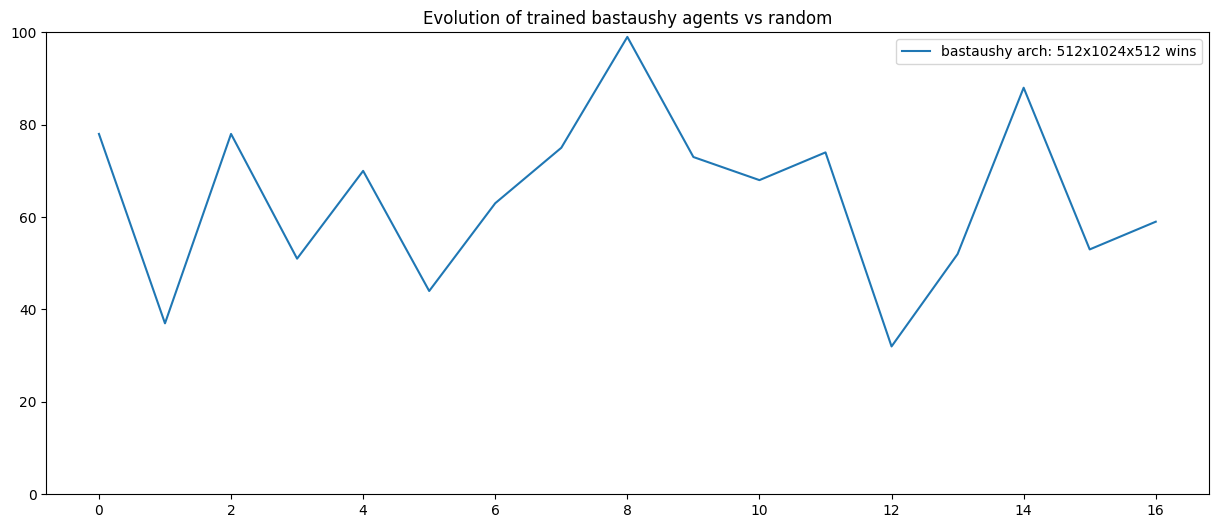

In [100]:
plt.figure(figsize=(15,6))
NUM_MODELS = 15

for arch in NET_ARCHS:
    
    #if arch in :
    
        arch_name = arch2str(arch)

        # cubic_interpolation_model = interp1d(range(len(bastaushy_vs_random_wins[arch_name])), bastaushy_vs_random_wins[arch_name], kind = "cubic", fill_value="extrapolate")
         
        # # Plotting the Graph
        # if arch in selected_archs:
        #     X_= np.linspace(0, NUM_MODELS, NUM_MODELS - 1)
        #     Y_= cubic_interpolation_model(X_)
        # else:
        #     X_= np.linspace(0, 7, 10)
        #     Y_= cubic_interpolation_model(X_)
        plt.plot(range(len(bastaushy_vs_random_wins[arch_name])), bastaushy_vs_random_wins[arch_name], label=f'bastaushy arch: {arch_name} wins')
        
plt.legend()
plt.title("Evolution of trained bastaushy agents vs random")
plt.ylim(0, 100)
plt.show()

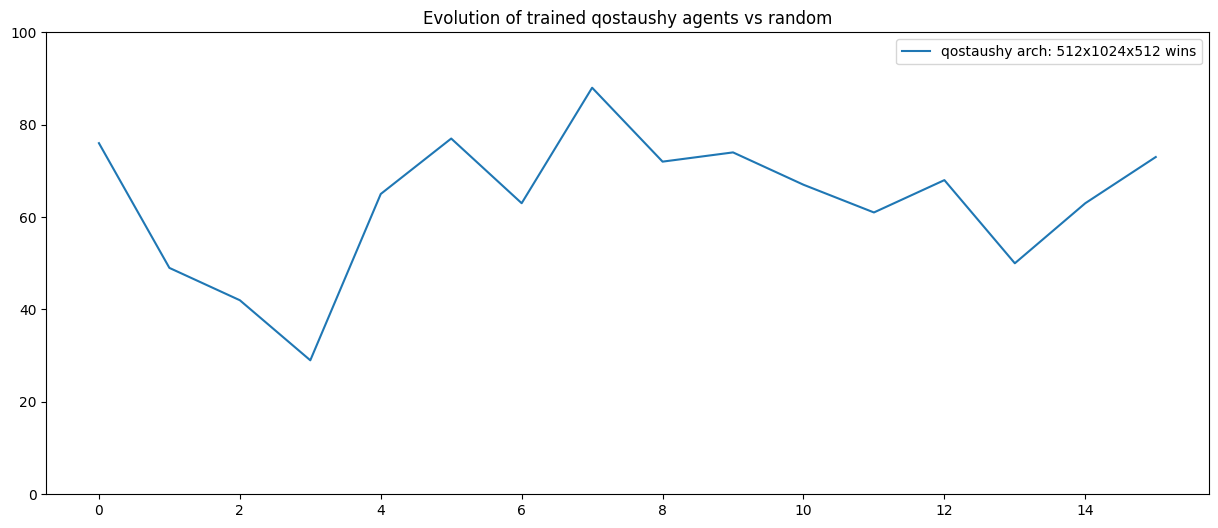

In [104]:
plt.figure(figsize=(15,6))

for arch in NET_ARCHS:
    
        arch_name = arch2str(arch)
        
        # cubic_interpolation_model = interp1d(range(len(qostaushy_vs_random_wins[arch_name])), qostaushy_vs_random_wins[arch_name], kind = "cubic")
         
        # # Plotting the Graph
        # if arch in selected_archs:
        #     X_= np.linspace(0, NUM_MODELS, NUM_MODELS - 1)
        #     Y_= cubic_interpolation_model(X_)
        # else:
        #     X_= np.linspace(0, 7, 10)
        #     Y_= cubic_interpolation_model(X_)
        
        plt.plot(range(len(qostaushy_vs_random_wins[arch_name])), qostaushy_vs_random_wins[arch_name], label=f'qostaushy arch: {arch_name} wins')
        
plt.legend()
plt.title("Evolution of trained qostaushy agents vs random")
plt.ylim(0, 100)
plt.show()

### 🐦 Play all trained policies

In [151]:
bastaushy_wins = {arch2str(key): [] for key in NET_ARCHS}

game_rewards = {arch2str(key): {} for key in NET_ARCHS}

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    game_rewards[arch_name] = {}

    for i in range(len(agents_learned_bastaushy[arch_name])):
        
        for j in range(len(agents_learned_qostaushy[arch_name])):
        
            game_rewards[arch_name][f'{i}vs{j}'] = []

    loc_plays_lst = []

    for n_agent, agent in tqdm(enumerate(agents_learned_bastaushy[arch_name])):

        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        full_opp_qostaushy = []
        
        for arch_loc in NET_ARCHS:
            
            full_opp_qostaushy += agents_learned_qostaushy[arch2str(arch_loc)] 

        for n_agent_opp, agent_opponent in enumerate(full_opp_qostaushy):

            REWARDS = {"bastaushy": [], "qostaushy": []}
            
            env = _get_env()#render_mode='human')
            
            # env.reset()

            policies = MultiAgentPolicyManager(policies=[agent, agent_opponent], env=env)
            
            test_envs = DummyVectorEnv([lambda: env for _ in range(10)])

            collector = Collector(policies, test_envs, exploration_noise=False)

            result = collector.collect(n_episode=1, reset_before_collect=True)

            game_rewards[arch_name][f'{n_agent}vs{n_agent_opp}'].append(REWARDS)
        # print(f"Bastaushy arch {arch_name} #{n_agent} wins {PLAYS["bastaushy"]} times")
            
        bastaushy_wins[arch_name].append(PLAYS["bastaushy"])

0it [00:00, ?it/s]

MOVE #38
qostaushy made action 17
qostaushy won 2
qostaushy won total 2
qostaushy won the game!!!


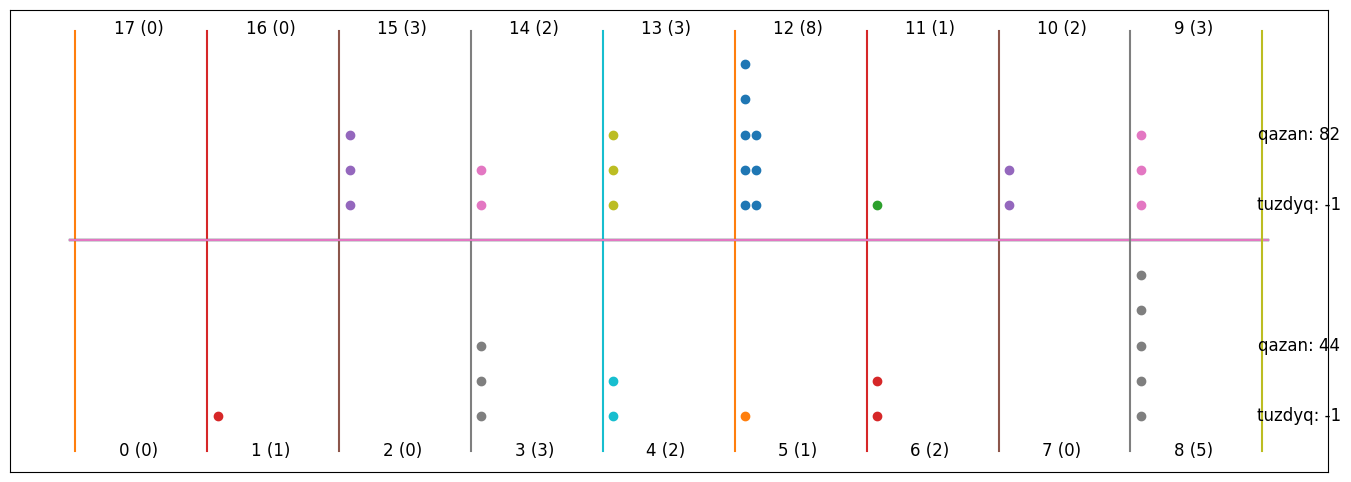

In [110]:
env = _get_env(render_mode='human')

policies = MultiAgentPolicyManager(policies=[agents_learned_bastaushy[arch_name][10], agents_learned_qostaushy[arch_name][0]], env=env)

test_envs = DummyVectorEnv([lambda: env for _ in range(10)])

collector = Collector(policies, test_envs, exploration_noise=False)

result = collector.collect(n_episode=1, reset_before_collect=True)

In [152]:
bastaushy_wins['512x1024x512']

[8, 5, 4, 7, 2, 7, 8, 7, 4, 8, 5]

{'512x1024x512': [8, 5, 4, 7, 2, 7, 8, 7, 4, 8, 5]}

In [118]:
qostaushy_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)
    
    for n_agent, agent in tqdm(enumerate(agents_learned_qostaushy[arch_name])):

        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        full_opp_bastaushy = []
        
        for arch_loc in NET_ARCHS:
            
            full_opp_bastaushy += agents_learned_bastaushy[arch2str(arch_loc)] 

        for n_agent_opp, agent_opponent in enumerate(full_opp_bastaushy):
            
            env = _get_env()#render_mode='human')

            policies = MultiAgentPolicyManager(policies=[agent_opponent, agent], env=env)
            
            test_envs = DummyVectorEnv([lambda: env for _ in range(10)])

            collector = Collector(policies, test_envs, exploration_noise=False)

            result = collector.collect(n_episode=1, reset_before_collect=True)

        # print(f"Bastaushy arch {arch_name} #{n_agent} wins {PLAYS["bastaushy"]} times")        
        qostaushy_wins[arch_name].append(PLAYS["qostaushy"])

0it [00:00, ?it/s]

In [119]:
qostaushy_wins['512x1024x512']

[6, 5, 4, 7, 4, 7, 5, 6, 3, 6, 3]

{'512x1024x512': [6, 5, 3, 4, 7, 4, 7, 5, 6, 3, 6]}

### 🦑 Save data to files

In [ ]:
for arch in tqdm(NET_ARCHS):
    if arch not in selected_archs:
        for _ in range(9, NUM_MODELS + 1):
            bastaushy_wins[arch_name].append(0)
            qostaushy_wins[arch_name].append(0)

In [36]:
with open("../data/bastaushy_vs_others.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(bastaushy_wins.keys())

    writer.writerows(zip(*bastaushy_wins.values()))

In [37]:
with open("../data/qostaushy_vs_others.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(qostaushy_wins.keys())

    writer.writerows(zip(*qostaushy_wins.values()))

### 🦚 Read data

In [35]:
df_vs_others_basta = pd.read_csv("../data/bastaushy_vs_others.csv")
df_vs_others_qosta = pd.read_csv("../data/qostaushy_vs_others.csv")

len(df_vs_others_basta['64x128x64'].values)

8

In [36]:
vs_others_basta = df_vs_others_basta.to_dict()

bastaushy_wins = {key: [] for key in vs_others_basta.keys()}

for key in vs_others_basta.keys():
    bastaushy_wins[key] = list(vs_others_basta[key].values())

In [37]:
vs_others_qosta = df_vs_others_qosta.to_dict()

qostaushy_wins = {key: [] for key in vs_others_qosta.keys()}

for key in vs_others_qosta.keys():
    qostaushy_wins[key] = list(vs_others_qosta[key].values())

### 🐈 Plot play results

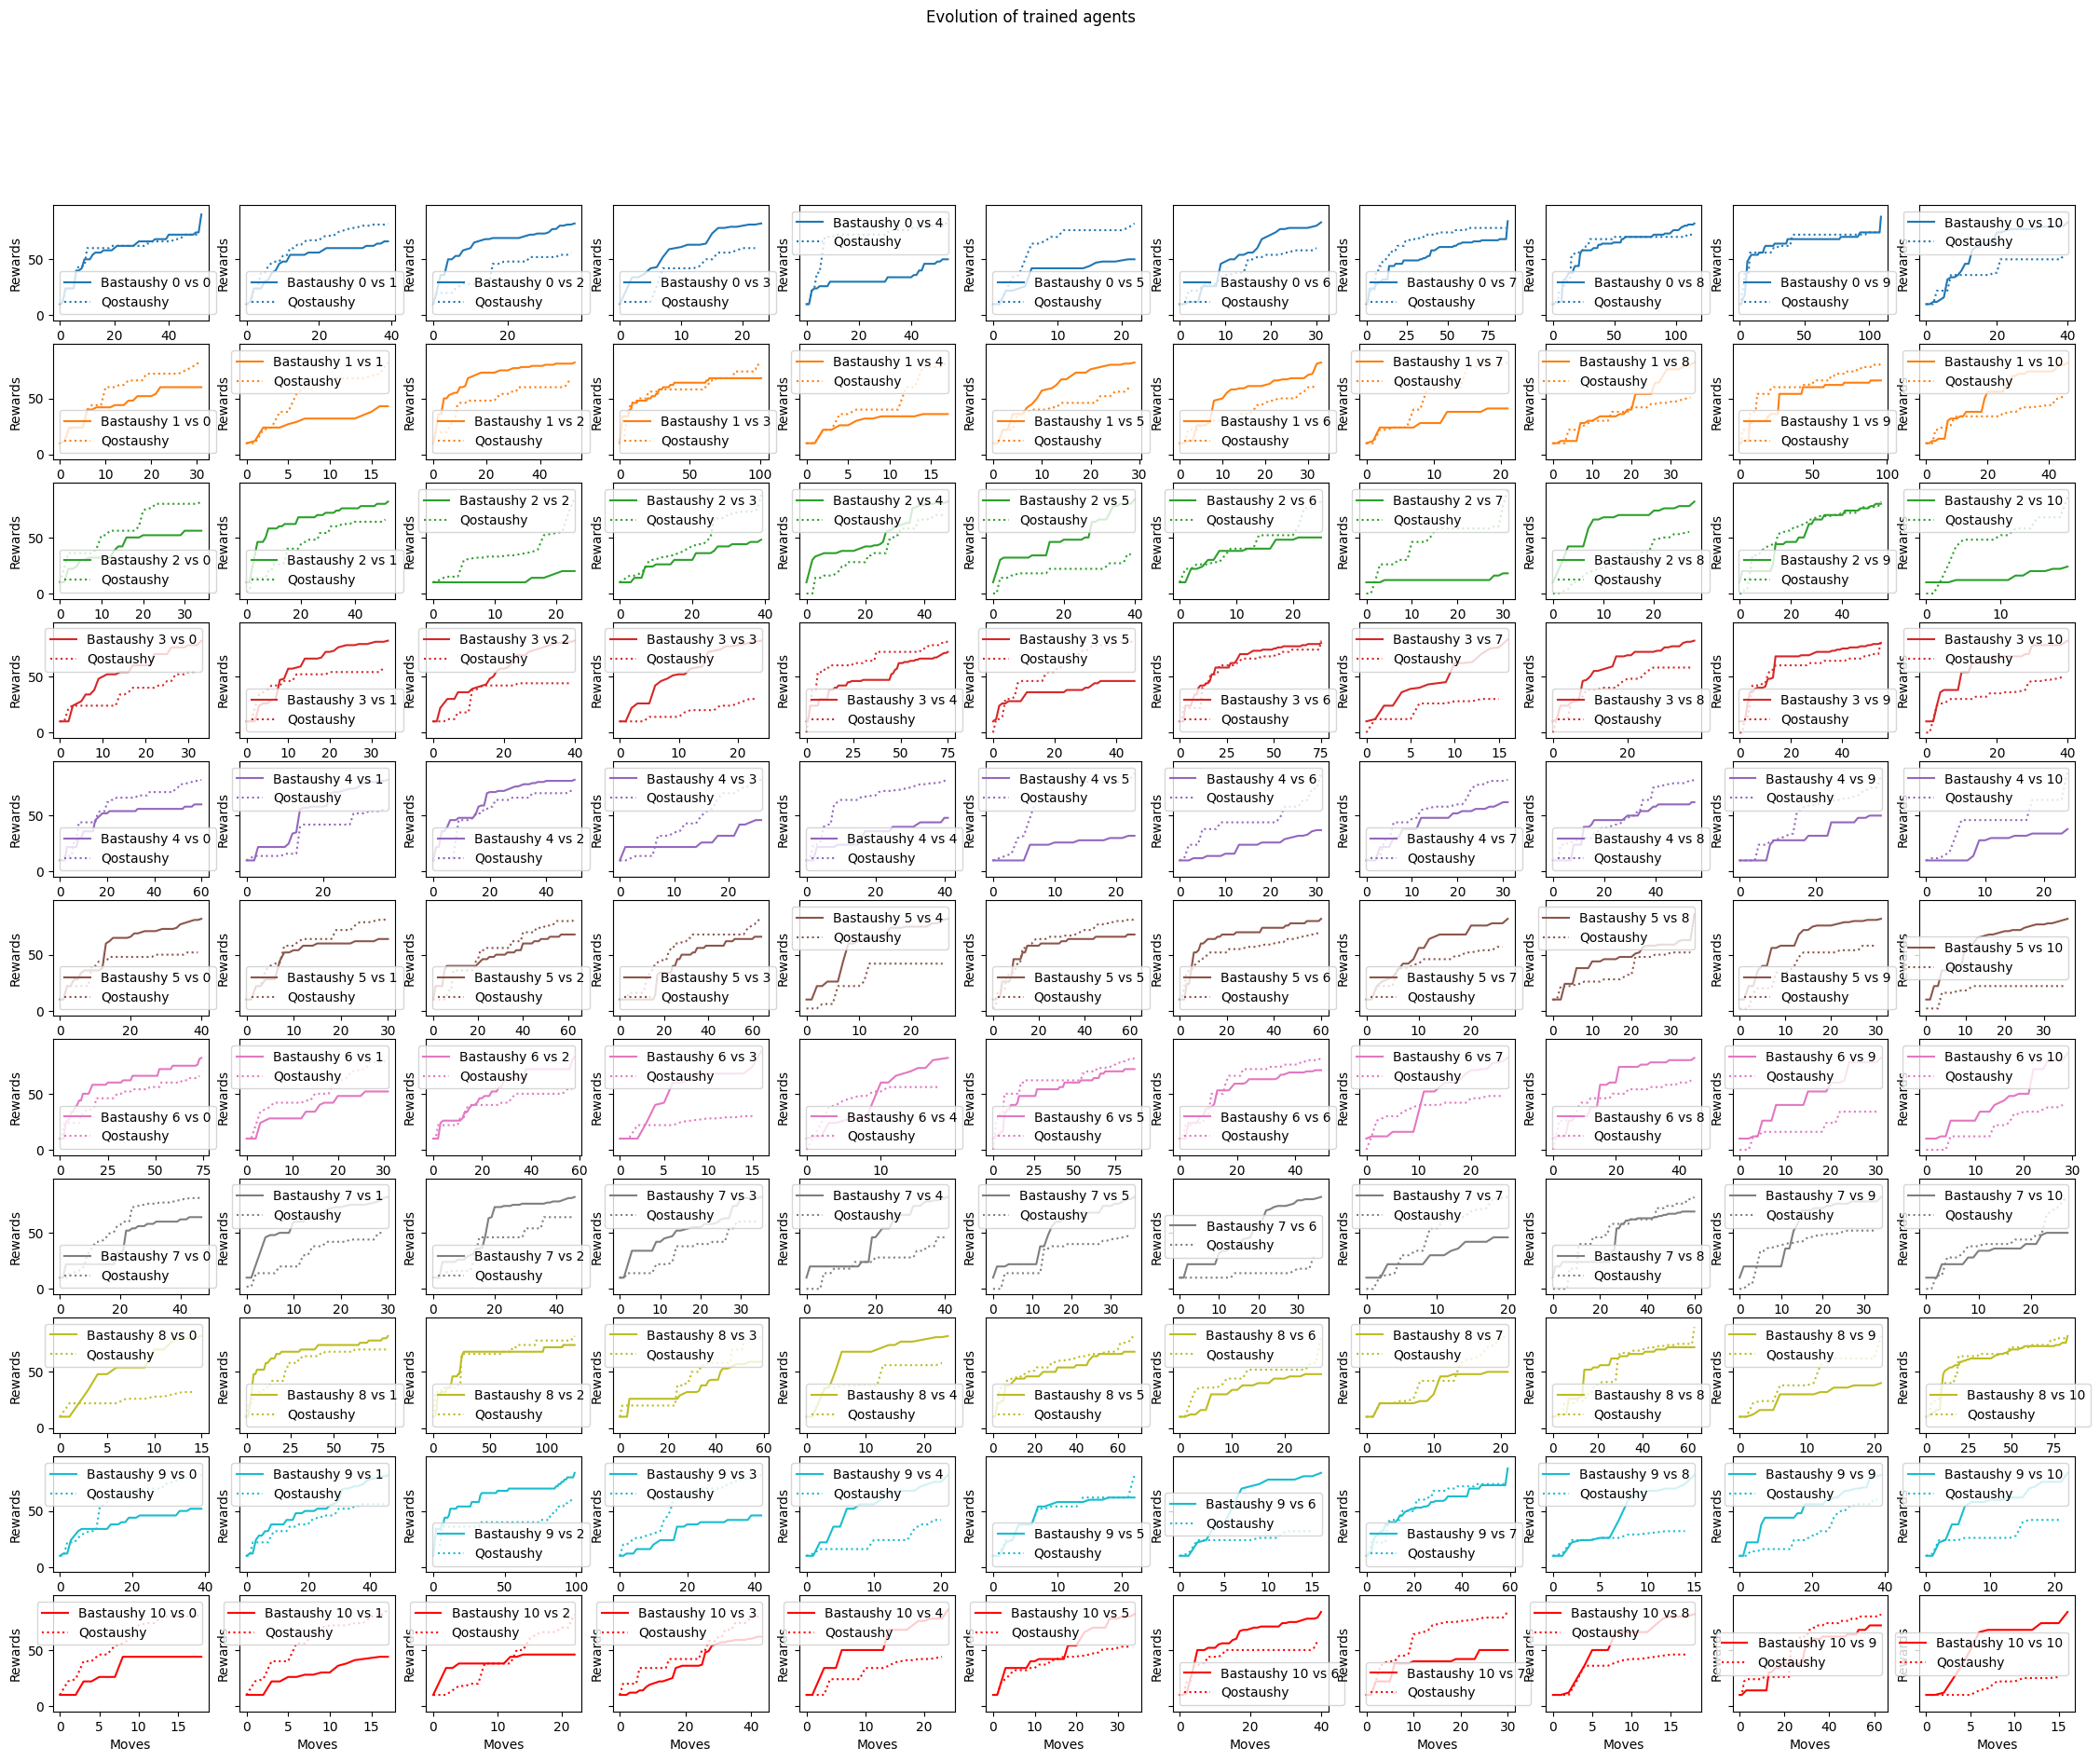

In [129]:
import matplotlib.colors as mcolors


list_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['red']

num_models = 11

fig, axes = plt.subplots(num_models, num_models, figsize=(28, 21), sharey=True)

fig.suptitle("Evolution of trained agents")
for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    for i in range(num_models):
        j = 0
        for key in game_rewards[arch_name].keys(): 
            if j == num_models:
                j = j % num_models
            
            if key.split('vs')[0] == str(i):
                x_basta = range(len(game_rewards[arch_name][key][0]['bastaushy']))
                axes[i][j].plot(x_basta, game_rewards[arch_name][key][0]['bastaushy'], color=list_colors[i], label=f'Bastaushy {i} vs {j}')
                x_qosta = range(len(game_rewards[arch_name][key][0]['qostaushy']))
                axes[i][j].plot(x_qosta, game_rewards[arch_name][key][0]['qostaushy'], color=list_colors[i], linestyle='dotted', label=f'Qostaushy')
                axes[i][j].set(xlabel="Moves", ylabel="Rewards")
                axes[i][j].legend()
                j += 1

plt.show()

In [157]:
for i in range(11):
    print('=========================')
    print('i =', i)
    total_win_steps = 0
    wins = 0
    for j in range(11):

        print(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy'][-1], game_rewards['512x1024x512'][f'{i}vs{j}'][0]['qostaushy'][-1])
        print('num_moves =', len(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy']))
        if game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy'][-1] > 81:
            wins += 1
            total_win_steps += len(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy'])
    print('wins =', wins)
    print('total_win_steps =', total_win_steps)

i = 0
90 72
num_moves = 53
66 82
num_moves = 40
82 56
num_moves = 39
82 60
num_moves = 24
50 86
num_moves = 55
50 82
num_moves = 23
83 60
num_moves = 32
84 78
num_moves = 88
82 72
num_moves = 116
88 74
num_moves = 110
83 54
num_moves = 41
wins = 8
total_win_steps = 503
i = 1
60 82
num_moves = 32
43 82
num_moves = 18
82 66
num_moves = 54
68 82
num_moves = 102
36 82
num_moves = 18
82 60
num_moves = 30
82 62
num_moves = 34
41 82
num_moves = 22
82 51
num_moves = 37
66 82
num_moves = 97
82 52
num_moves = 47
wins = 5
total_win_steps = 202
i = 2
56 82
num_moves = 35
82 66
num_moves = 53
20 85
num_moves = 24
48 88
num_moves = 40
82 70
num_moves = 49
84 35
num_moves = 41
50 82
num_moves = 26
18 94
num_moves = 32
82 55
num_moves = 29
80 82
num_moves = 56
24 86
num_moves = 20
wins = 4
total_win_steps = 172
i = 3
82 54
num_moves = 34
82 58
num_moves = 35
82 44
num_moves = 41
82 30
num_moves = 25
72 82
num_moves = 76
46 82
num_moves = 47
80 82
num_moves = 76
83 30
num_moves = 17
82 58
num_moves = 3

In [156]:
for i in range(11):
    print('=========================')
    print('i =', i)
    total_win_steps = 0
    wins = 0
    for j in range(11):

        print(game_rewards['512x1024x512'][f'{j}vs{i}'][0]['bastaushy'][-1], game_rewards['512x1024x512'][f'{j}vs{i}'][0]['qostaushy'][-1])
        print('num_moves =', len(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['qostaushy']))
        if game_rewards['512x1024x512'][f'{j}vs{i}'][0]['qostaushy'][-1] > 81:
            wins += 1
            total_win_steps += len(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['qostaushy'])
    print('wins =', wins)
    print('total_win_steps =', total_win_steps)

i = 0
90 72
num_moves = 52
60 82
num_moves = 40
56 82
num_moves = 38
82 54
num_moves = 23
60 82
num_moves = 55
82 52
num_moves = 23
82 66
num_moves = 31
64 82
num_moves = 87
82 32
num_moves = 115
52 82
num_moves = 109
44 82
num_moves = 40
wins = 6
total_win_steps = 369
i = 1
66 82
num_moves = 32
43 82
num_moves = 18
82 66
num_moves = 53
82 58
num_moves = 102
82 56
num_moves = 18
64 82
num_moves = 29
52 82
num_moves = 33
82 50
num_moves = 22
82 70
num_moves = 36
82 56
num_moves = 97
44 86
num_moves = 46
wins = 5
total_win_steps = 158
i = 2
82 56
num_moves = 35
82 66
num_moves = 52
20 85
num_moves = 24
82 44
num_moves = 40
82 72
num_moves = 48
68 82
num_moves = 40
83 54
num_moves = 26
82 64
num_moves = 32
74 82
num_moves = 28
84 61
num_moves = 56
46 82
num_moves = 20
wins = 4
total_win_steps = 112
i = 3
82 60
num_moves = 33
68 82
num_moves = 34
48 88
num_moves = 40
82 30
num_moves = 24
46 82
num_moves = 76
66 82
num_moves = 47
88 30
num_moves = 76
82 60
num_moves = 16
59 82
num_moves = 3

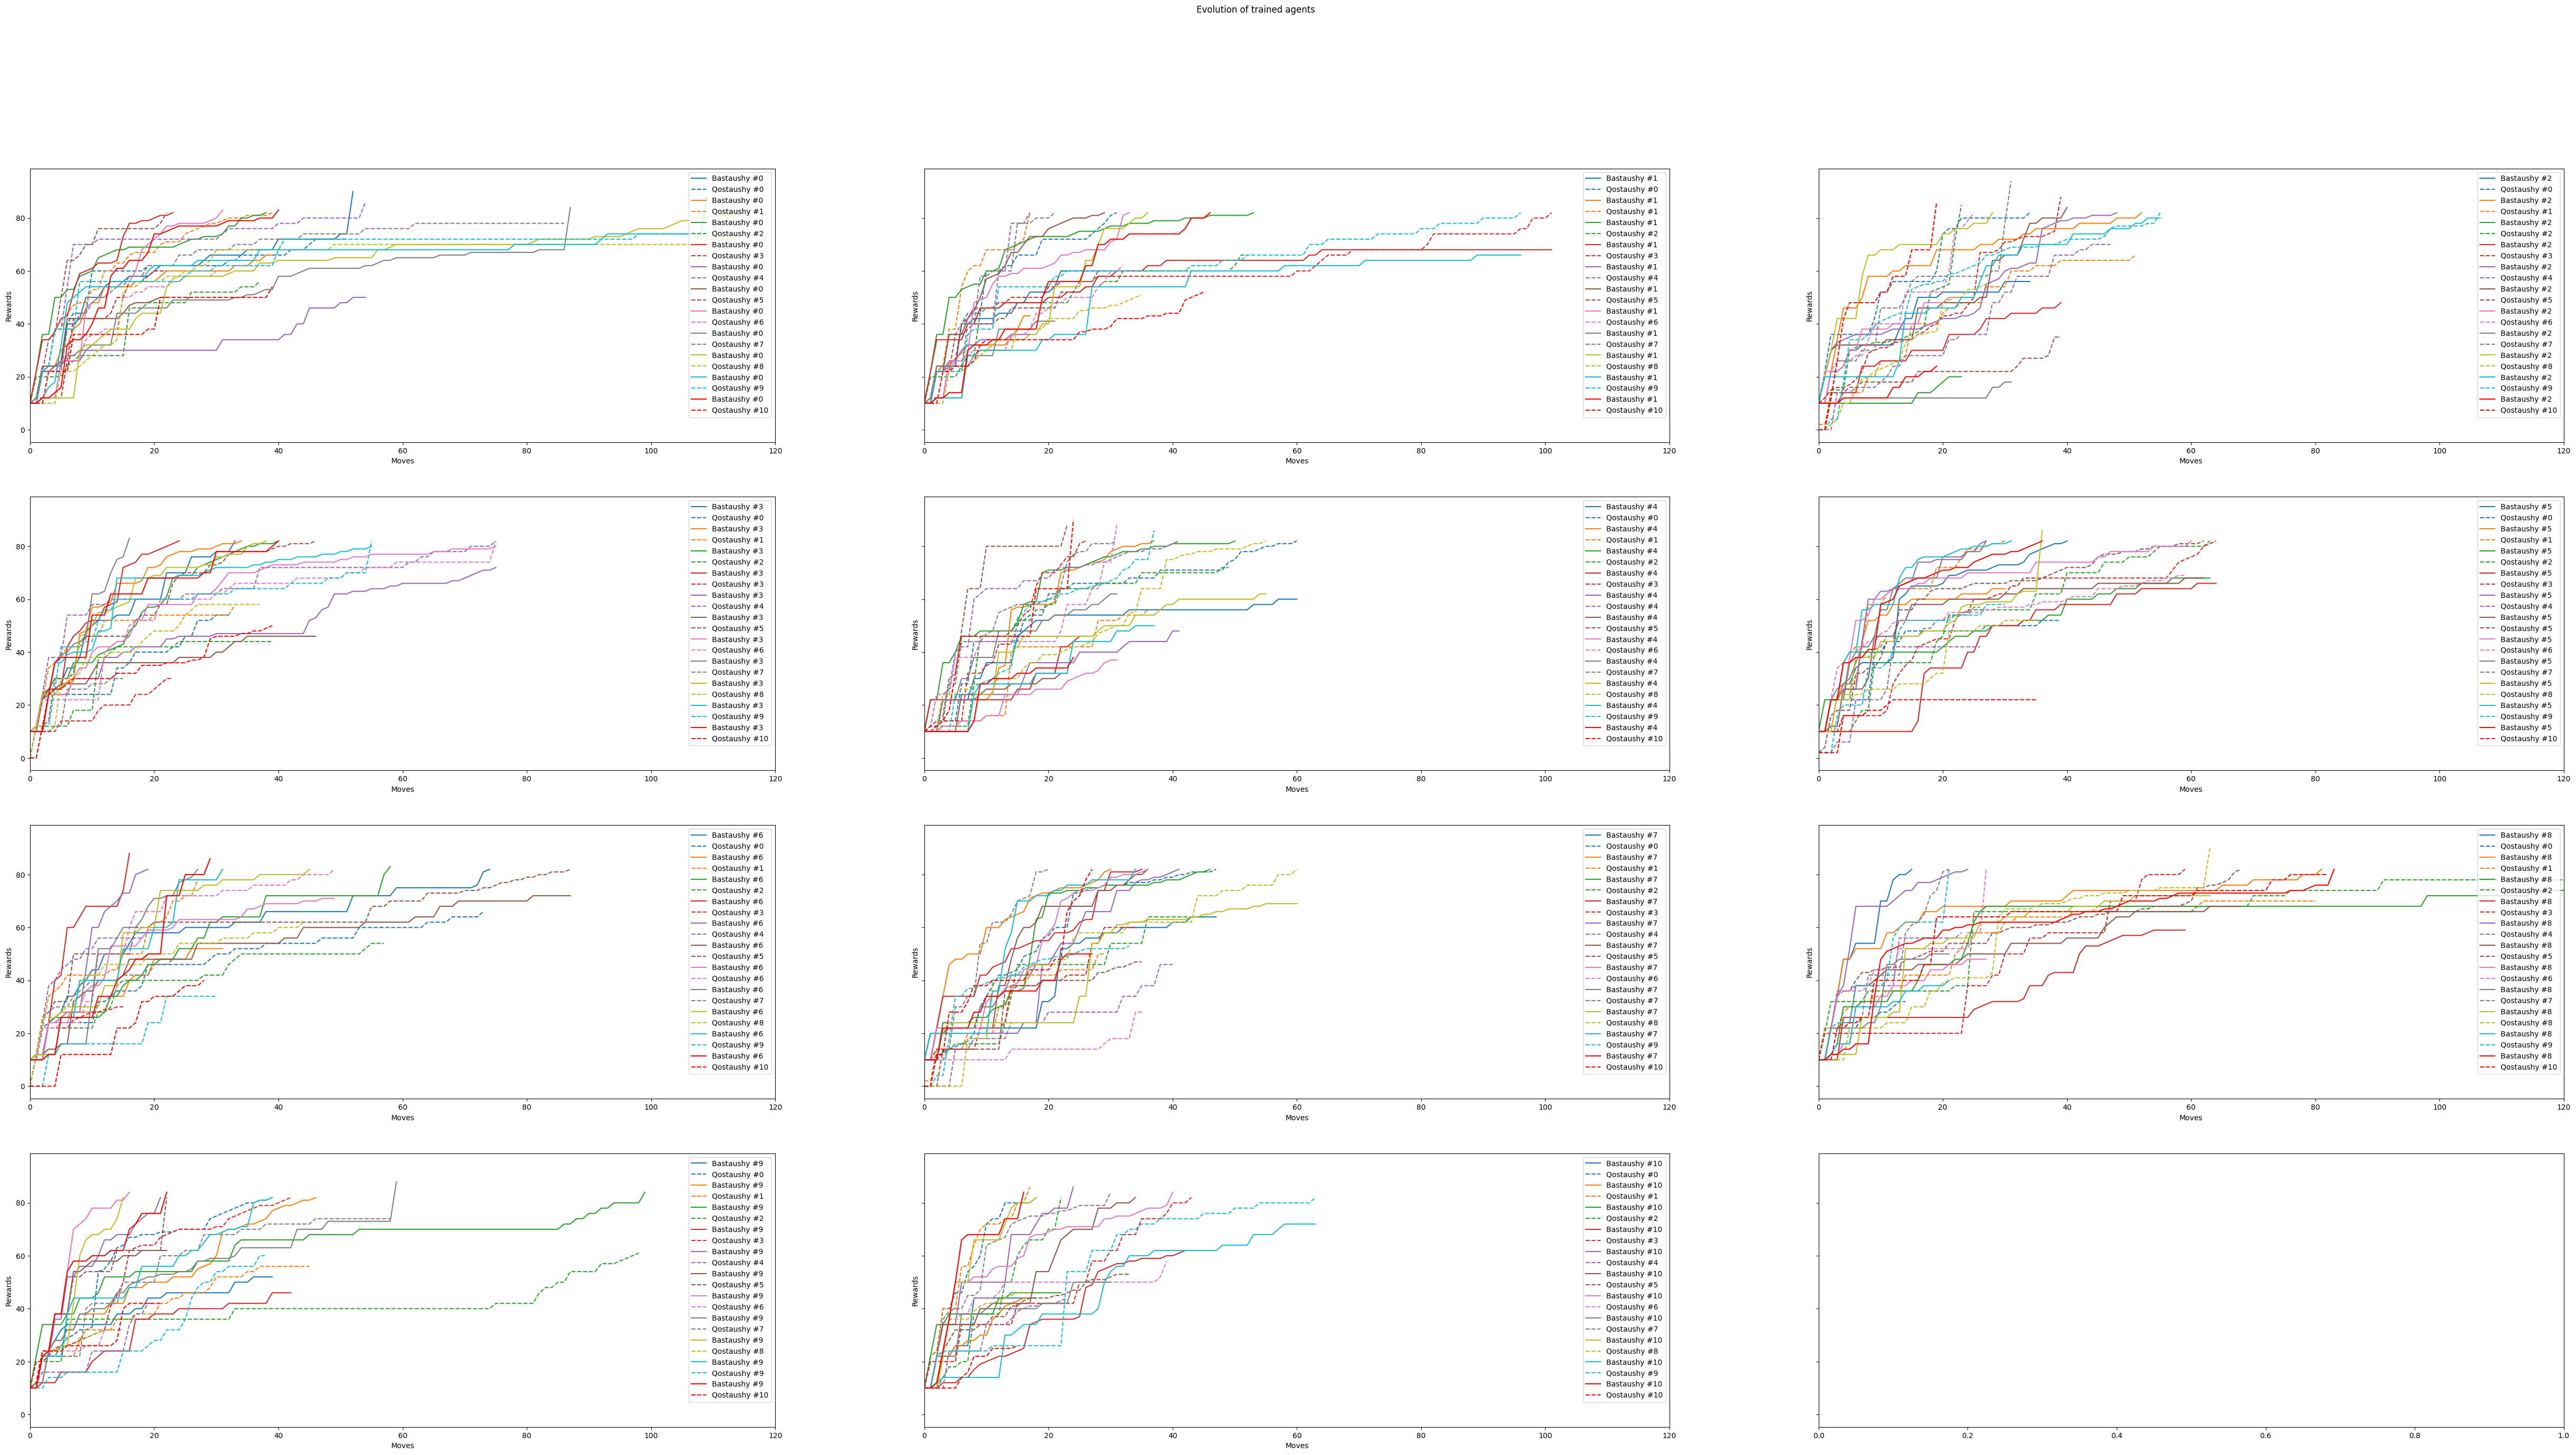

In [136]:
import math


num_models = 11

fig, axes = plt.subplots(4, 3, figsize=(62, 31), sharey=True)

fig.suptitle("Evolution of trained agents")

list_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['red']

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    vert = 0
    for i in range(num_models):
        j = 0
        for key in game_rewards[arch_name].keys(): 
            if j == num_models:
                j = j % num_models
                vert += 1
                vert = vert % 3
            n_agent = key.split('vs')[0]
            n_agent_opp = key.split('vs')[1]
            if n_agent == str(i):
                x_basta = range(len(game_rewards[arch_name][key][0]['bastaushy']))
                horiz = math.floor(i/3)
                axes[horiz][vert].plot(x_basta, game_rewards[arch_name][key][0]['bastaushy'], color=list_colors[j], label=f'Bastaushy #{n_agent}')
                x_qosta = range(len(game_rewards[arch_name][key][0]['qostaushy']))
                axes[horiz][vert].plot(x_qosta, game_rewards[arch_name][key][0]['qostaushy'], color=list_colors[j], linestyle='dashed', label=f'Qostaushy #{n_agent_opp}')
                axes[horiz][vert].set(xlabel="Moves", ylabel="Rewards")
                axes[horiz][vert].legend()
                axes[horiz][vert].set_xlim([0, 120])
                j += 1
plt.show()

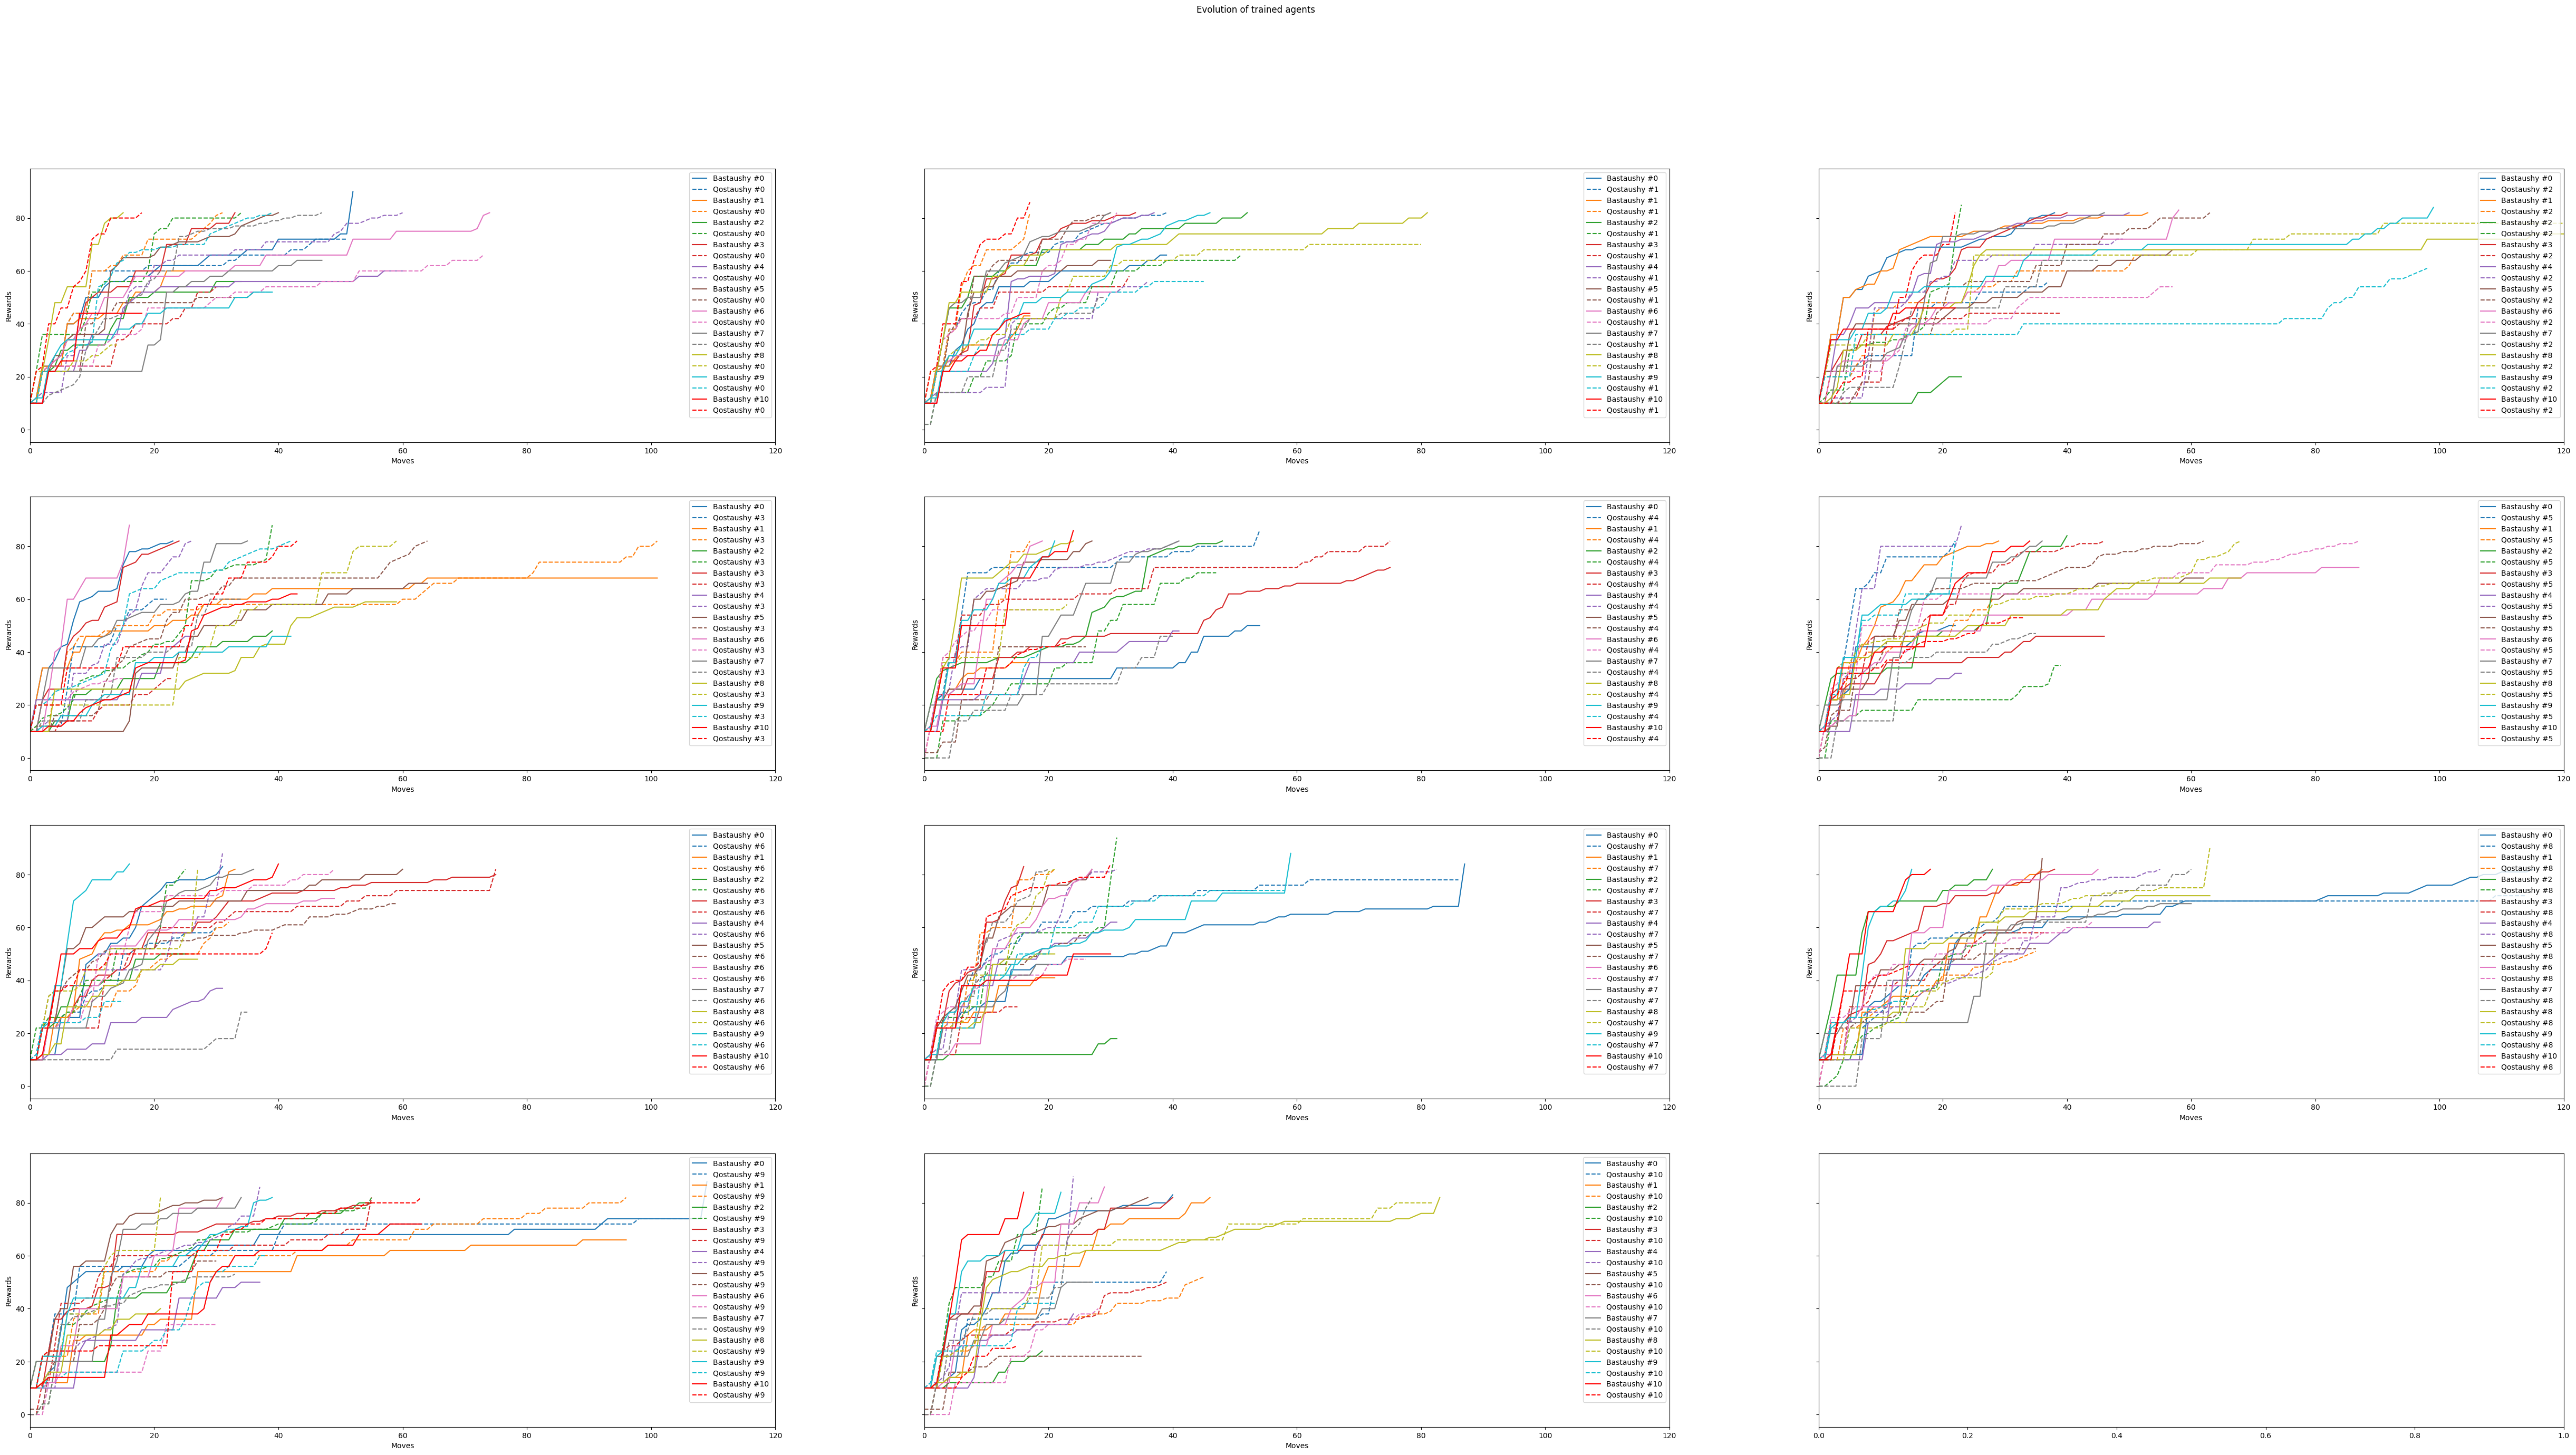

In [139]:
import math


num_models = 11

fig, axes = plt.subplots(4, 3, figsize=(62, 31), sharey=True)

fig.suptitle("Evolution of trained agents")

list_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['red']

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    vert = 0
    for i in range(num_models):
        j = 0
        for key in game_rewards[arch_name].keys(): 
            if j == num_models:
                j = j % num_models
                vert += 1
                vert = vert % 3
            n_agent = key.split('vs')[1]
            n_agent_opp = key.split('vs')[0]
            if n_agent == str(i):
                x_basta = range(len(game_rewards[arch_name][key][0]['bastaushy']))
                horiz = math.floor(i/3)
                axes[horiz][vert].plot(x_basta, game_rewards[arch_name][key][0]['bastaushy'], color=list_colors[j], label=f'Bastaushy #{n_agent_opp}')
                x_qosta = range(len(game_rewards[arch_name][key][0]['qostaushy']))
                axes[horiz][vert].plot(x_qosta, game_rewards[arch_name][key][0]['qostaushy'], color=list_colors[j], linestyle='dashed', label=f'Qostaushy #{n_agent}')
                axes[horiz][vert].set(xlabel="Moves", ylabel="Rewards")
                axes[horiz][vert].legend()
                axes[horiz][vert].set_xlim([0, 120])
                j += 1
plt.show()